In [1]:
!pip install -r ../../requirements.txt

You should consider upgrading via the 'c:\users\falchetto\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


# Configuration

In [2]:
ROOT_DIR = "../../"
DATA_DIR = ROOT_DIR + "data/"

DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

NN_NAME = 'FreeHandV3'

DEFAULT_CONFIG_FILENAME = ROOT_DIR + "default.ini"

In [3]:
import configparser

config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

# Imports

In [4]:
import sys
sys.path.append(ROOT_DIR)

import neural_networks
import datasetlib
import traintestsplitlib
import trainlib
import evaluationlib
import dataaugmentationlib

import math

# Dataset

## Dataset in a pandas Dataframe

In [5]:
dataset_df = datasetlib.load_dataset_dataframe(DATASET_2016_10a_FILENAME)

## Raw dataset

In [6]:
dataset_df

IQ signals Modulation_Label  \
0       [[-0.0059014712, -0.0023458179, -0.00074506126...             QPSK   
1       [[0.0050326153, 0.00094379985, -0.0018932355, ...             QPSK   
2       [[0.0052390713, 0.0073890695, 0.007276459, 0.0...             QPSK   
3       [[-0.0019859935, -0.0071501383, -0.00527185, -...             QPSK   
4       [[0.006674405, 0.0028359746, 0.005630027, 0.00...             QPSK   
...                                                   ...              ...   
219995  [[0.0062732296, -0.0050519477, 0.006672171, 0....             BPSK   
219996  [[-0.003903181, -0.0015884301, -0.00633375, 2....             BPSK   
219997  [[-0.0105958255, 0.005601244, -0.012161784, 0....             BPSK   
219998  [[-0.002136606, 0.00995837, 0.0059440527, -0.0...             BPSK   
219999  [[-0.008169517, 0.0013303901, -0.002522387, -0...             BPSK   

        SNR  
0         2  
1         2  
2         2  
3         2  
4         2  
...     ...  
219995  -18  
219996  -18  
219997  -18  
219998  -18  
219999  -18  

[220000 rows x 3 columns]

# Neural network

## Configuration

In [7]:
config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

## Data prepare

In [8]:
signals = datasetlib.signals(dataset_df)
labels = datasetlib.labels(dataset_df)

# [QPSQ, BPSK, ...]
mods = datasetlib.mods(dataset_df)
# [-18, -16, ...]
snrs = datasetlib.unique_snrs(dataset_df)

### Training and Test data partitioning

In [9]:
n_elements = len(signals)
training_set_percentage = TRAINING_SET_DIMENSION

train_index, test_index = traintestsplitlib.train_test_random_indexes(n_elements, training_set_percentage)

X_train, X_test, Y_train, Y_test = traintestsplitlib.split_x_y_train_test(signals, labels, mods, train_index, test_index)

X_train, Y_train = dataaugmentationlib.rotate_and_concatenate_with_signals(X_train, Y_train)

## Build the Neural Network

In [10]:
in_shp = list(X_train.shape[1:])
print(X_train.shape)
print(in_shp)
classes = mods

(660000, 2, 128)
[2, 128]


In [11]:
model = neural_networks.freehand_v3(in_shp)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2, 128)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 2, 128, 1)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2, 128, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 2, 128, 16)        272       
_________________________________________________________________
batch_normalization_1 (Batch (None, 2, 128, 16)        64        
_________________________________________________________________
dense (Dense)                (None, 2, 128, 256)       4352      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 128, 32)        32800 

### Train the model

In [12]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = NEURAL_NETWORK_FILENAME

history, model = trainlib.train(filepath, model, X_train, Y_train, X_test, Y_test, BATCH_SIZE, NB_EPOCH)

Epoch 1/100


  1/581 [..............................] - ETA: 2:20:10 - loss: 3.0006

  2/581 [..............................] - ETA: 38s - loss: 2.9543    

  3/581 [..............................] - ETA: 38s - loss: 2.9130

  4/581 [..............................] - ETA: 38s - loss: 2.8875

  5/581 [..............................] - ETA: 38s - loss: 2.8670

  6/581 [..............................] - ETA: 37s - loss: 2.8480

  7/581 [..............................] - ETA: 37s - loss: 2.8297

  8/581 [..............................] - ETA: 37s - loss: 2.8121

  9/581 [..............................] - ETA: 37s - loss: 2.7960

 10/581 [..............................] - ETA: 37s - loss: 2.7807



 11/581 [..............................] - ETA: 37s - loss: 2.7663



 12/581 [..............................] - ETA: 37s - loss: 2.7528

 13/581 [..............................] - ETA: 37s - loss: 2.7400

 14/581 [..............................] - ETA: 37s - loss: 2.7280

 15/581 [..............................] - ETA: 37s - loss: 2.7159

 16/581 [..............................] - ETA: 37s - loss: 2.7043

 17/581 [..............................] - ETA: 37s - loss: 2.6931

 18/581 [..............................] - ETA: 37s - loss: 2.6822

 19/581 [..............................] - ETA: 37s - loss: 2.6715

 20/581 [>.............................] - ETA: 37s - loss: 2.6611

 21/581 [>.............................] - ETA: 36s - loss: 2.6510

 22/581 [>.............................] - ETA: 36s - loss: 2.6413

 23/581 [>.............................] - ETA: 36s - loss: 2.6317

 24/581 [>.............................] - ETA: 36s - loss: 2.6223

 25/581 [>.............................] - ETA: 36s - loss: 2.6130

 26/581 [>.............................] - ETA: 36s - loss: 2.6040

 27/581 [>.............................] - ETA: 36s - loss: 2.5952

 28/581 [>.............................] - ETA: 36s - loss: 2.5866

 29/581 [>.............................] - ETA: 36s - loss: 2.5781

 30/581 [>.............................] - ETA: 36s - loss: 2.5698

 31/581 [>.............................] - ETA: 36s - loss: 2.5616

 32/581 [>.............................] - ETA: 36s - loss: 2.5536

 33/581 [>.............................] - ETA: 36s - loss: 2.5457

 34/581 [>.............................] - ETA: 36s - loss: 2.5379

 35/581 [>.............................] - ETA: 35s - loss: 2.5303

 36/581 [>.............................] - ETA: 35s - loss: 2.5227

 37/581 [>.............................] - ETA: 35s - loss: 2.5152

 38/581 [>.............................] - ETA: 35s - loss: 2.5079

 39/581 [=>............................] - ETA: 35s - loss: 2.5007

 40/581 [=>............................] - ETA: 35s - loss: 2.4936

 41/581 [=>............................] - ETA: 35s - loss: 2.4867

 42/581 [=>............................] - ETA: 35s - loss: 2.4798

 43/581 [=>............................] - ETA: 35s - loss: 2.4730



 44/581 [=>............................] - ETA: 35s - loss: 2.4664

 45/581 [=>............................] - ETA: 35s - loss: 2.4598

 46/581 [=>............................] - ETA: 35s - loss: 2.4533

 47/581 [=>............................] - ETA: 35s - loss: 2.4469

 48/581 [=>............................] - ETA: 35s - loss: 2.4406

 49/581 [=>............................] - ETA: 34s - loss: 2.4344

 50/581 [=>............................] - ETA: 34s - loss: 2.4283

 51/581 [=>............................] - ETA: 34s - loss: 2.4223

 52/581 [=>............................] - ETA: 34s - loss: 2.4163

 53/581 [=>............................] - ETA: 34s - loss: 2.4104

 54/581 [=>............................] - ETA: 34s - loss: 2.4046

 55/581 [=>............................] - ETA: 34s - loss: 2.3989

 56/581 [=>............................] - ETA: 34s - loss: 2.3932

 57/581 [=>............................] - ETA: 34s - loss: 2.3877

 58/581 [=>............................] - ETA: 34s - loss: 2.3822

 59/581 [==>...........................] - ETA: 34s - loss: 2.3768

 60/581 [==>...........................] - ETA: 34s - loss: 2.3715

 61/581 [==>...........................] - ETA: 34s - loss: 2.3662

 62/581 [==>...........................] - ETA: 34s - loss: 2.3610

 63/581 [==>...........................] - ETA: 34s - loss: 2.3559

 64/581 [==>...........................] - ETA: 34s - loss: 2.3508

 65/581 [==>...........................] - ETA: 33s - loss: 2.3458

 66/581 [==>...........................] - ETA: 33s - loss: 2.3408

 67/581 [==>...........................] - ETA: 33s - loss: 2.3359

 68/581 [==>...........................] - ETA: 33s - loss: 2.3311

 69/581 [==>...........................] - ETA: 33s - loss: 2.3263

 70/581 [==>...........................] - ETA: 33s - loss: 2.3216

 71/581 [==>...........................] - ETA: 33s - loss: 2.3169

 72/581 [==>...........................] - ETA: 33s - loss: 2.3123



 73/581 [==>...........................] - ETA: 33s - loss: 2.3077

 74/581 [==>...........................] - ETA: 33s - loss: 2.3032

 75/581 [==>...........................] - ETA: 33s - loss: 2.2987

 76/581 [==>...........................] - ETA: 33s - loss: 2.2943

 77/581 [==>...........................] - ETA: 33s - loss: 2.2899

 78/581 [===>..........................] - ETA: 33s - loss: 2.2856

 79/581 [===>..........................] - ETA: 33s - loss: 2.2813

 80/581 [===>..........................] - ETA: 32s - loss: 2.2771

 81/581 [===>..........................] - ETA: 32s - loss: 2.2728

 82/581 [===>..........................] - ETA: 32s - loss: 2.2687

 83/581 [===>..........................] - ETA: 32s - loss: 2.2646

 84/581 [===>..........................] - ETA: 32s - loss: 2.2605

 85/581 [===>..........................] - ETA: 32s - loss: 2.2565

 86/581 [===>..........................] - ETA: 32s - loss: 2.2525

 87/581 [===>..........................] - ETA: 32s - loss: 2.2486

 88/581 [===>..........................] - ETA: 32s - loss: 2.2447

 89/581 [===>..........................] - ETA: 32s - loss: 2.2409

 90/581 [===>..........................] - ETA: 32s - loss: 2.2371

 91/581 [===>..........................] - ETA: 32s - loss: 2.2333

 92/581 [===>..........................] - ETA: 32s - loss: 2.2296

 93/581 [===>..........................] - ETA: 32s - loss: 2.2259

 94/581 [===>..........................] - ETA: 32s - loss: 2.2222

 95/581 [===>..........................] - ETA: 31s - loss: 2.2186

 96/581 [===>..........................] - ETA: 31s - loss: 2.2150

 97/581 [====>.........................] - ETA: 31s - loss: 2.2115

 98/581 [====>.........................] - ETA: 31s - loss: 2.2079

 99/581 [====>.........................] - ETA: 31s - loss: 2.2045

100/581 [====>.........................] - ETA: 31s - loss: 2.2010



101/581 [====>.........................] - ETA: 31s - loss: 2.1976



102/581 [====>.........................] - ETA: 31s - loss: 2.1942

103/581 [====>.........................] - ETA: 31s - loss: 2.1909



104/581 [====>.........................] - ETA: 31s - loss: 2.1876



105/581 [====>.........................] - ETA: 31s - loss: 2.1843



106/581 [====>.........................] - ETA: 31s - loss: 2.1810



107/581 [====>.........................] - ETA: 31s - loss: 2.1778



108/581 [====>.........................] - ETA: 31s - loss: 2.1746



109/581 [====>.........................] - ETA: 31s - loss: 2.1715

110/581 [====>.........................] - ETA: 31s - loss: 2.1683

111/581 [====>.........................] - ETA: 30s - loss: 2.1652

112/581 [====>.........................] - ETA: 30s - loss: 2.1622

113/581 [====>.........................] - ETA: 30s - loss: 2.1591

114/581 [====>.........................] - ETA: 30s - loss: 2.1561



115/581 [====>.........................] - ETA: 30s - loss: 2.1531



116/581 [====>.........................] - ETA: 30s - loss: 2.1502

117/581 [=====>........................] - ETA: 30s - loss: 2.1473

118/581 [=====>........................] - ETA: 30s - loss: 2.1443

119/581 [=====>........................] - ETA: 30s - loss: 2.1415

120/581 [=====>........................] - ETA: 30s - loss: 2.1386

121/581 [=====>........................] - ETA: 30s - loss: 2.1358

122/581 [=====>........................] - ETA: 30s - loss: 2.1330

123/581 [=====>........................] - ETA: 30s - loss: 2.1302

124/581 [=====>........................] - ETA: 30s - loss: 2.1275

125/581 [=====>........................] - ETA: 30s - loss: 2.1247

126/581 [=====>........................] - ETA: 29s - loss: 2.1220

127/581 [=====>........................] - ETA: 29s - loss: 2.1193

128/581 [=====>........................] - ETA: 29s - loss: 2.1167

129/581 [=====>........................] - ETA: 29s - loss: 2.1140

130/581 [=====>........................] - ETA: 29s - loss: 2.1114

131/581 [=====>........................] - ETA: 29s - loss: 2.1088

132/581 [=====>........................] - ETA: 29s - loss: 2.1062

133/581 [=====>........................] - ETA: 29s - loss: 2.1037

134/581 [=====>........................] - ETA: 29s - loss: 2.1011

135/581 [=====>........................] - ETA: 29s - loss: 2.0986

136/581 [======>.......................] - ETA: 29s - loss: 2.0961

137/581 [======>.......................] - ETA: 29s - loss: 2.0937

138/581 [======>.......................] - ETA: 29s - loss: 2.0912

139/581 [======>.......................] - ETA: 29s - loss: 2.0888

140/581 [======>.......................] - ETA: 29s - loss: 2.0864

141/581 [======>.......................] - ETA: 28s - loss: 2.0840

142/581 [======>.......................] - ETA: 28s - loss: 2.0816

143/581 [======>.......................] - ETA: 28s - loss: 2.0792

144/581 [======>.......................] - ETA: 28s - loss: 2.0769

145/581 [======>.......................] - ETA: 28s - loss: 2.0746

146/581 [======>.......................] - ETA: 28s - loss: 2.0723

147/581 [======>.......................] - ETA: 28s - loss: 2.0700

148/581 [======>.......................] - ETA: 28s - loss: 2.0677

149/581 [======>.......................] - ETA: 28s - loss: 2.0654

150/581 [======>.......................] - ETA: 28s - loss: 2.0632

151/581 [======>.......................] - ETA: 28s - loss: 2.0610

152/581 [======>.......................] - ETA: 28s - loss: 2.0588

153/581 [======>.......................] - ETA: 28s - loss: 2.0566

154/581 [======>.......................] - ETA: 28s - loss: 2.0544

155/581 [=======>......................] - ETA: 28s - loss: 2.0523



156/581 [=======>......................] - ETA: 27s - loss: 2.0501

157/581 [=======>......................] - ETA: 27s - loss: 2.0480

158/581 [=======>......................] - ETA: 27s - loss: 2.0459

159/581 [=======>......................] - ETA: 27s - loss: 2.0438

160/581 [=======>......................] - ETA: 27s - loss: 2.0417



161/581 [=======>......................] - ETA: 27s - loss: 2.0397

162/581 [=======>......................] - ETA: 27s - loss: 2.0376

163/581 [=======>......................]

 - ETA: 27s - loss: 2.0356

164/581 [=======>......................] - ETA: 27s - loss: 2.0336



165/581 [=======>......................] - ETA: 27s - loss: 2.0316

166/581 [=======>......................] - ETA: 27s - loss: 2.0296

167/581 [=======>......................] - ETA: 27s - loss: 2.0276

168/581 [=======>......................] - ETA: 27s - loss: 2.0256

169/581 [=======>......................] - ETA: 27s - loss: 2.0237

170/581 [=======>......................] - ETA: 27s - loss: 2.0217

171/581 [=======>......................] - ETA: 26s - loss: 2.0198

172/581 [=======>......................] - ETA: 26s - loss: 2.0179

173/581 [=======>......................] - ETA: 26s - loss: 2.0160

174/581 [=======>......................] - ETA: 26s - loss: 2.0141

175/581 [========>.....................] - ETA: 26s - loss: 2.0123

176/581 [========>.....................] - ETA: 26s - loss: 2.0104

177/581 [========>.....................] - ETA: 26s - loss: 2.0085

178/581 [========>.....................] - ETA: 26s - loss: 2.0067

179/581 [========>.....................] - ETA: 26s - loss: 2.0049

180/581 [========>.....................] - ETA: 26s - loss: 2.0031

181/581 [========>.....................] - ETA: 26s - loss: 2.0012

182/581 [========>.....................] - ETA: 26s - loss: 1.9995

183/581 [========>.....................] - ETA: 26s - loss: 1.9977

184/581 [========>.....................] - ETA: 26s - loss: 1.9959

185/581 [========>.....................] - ETA: 26s - loss: 1.9941

186/581 [========>.....................] - ETA: 26s - loss: 1.9924

187/581 [========>.....................] - ETA: 25s - loss: 1.9907

188/581 [========>.....................] - ETA: 25s - loss: 1.9889



189/581 [========>.....................] - ETA: 25s - loss: 1.9872



190/581 [========>.....................] - ETA: 25s - loss: 1.9855

191/581 [========>.....................] - ETA: 25s - loss: 1.9838

192/581 [========>.....................] - ETA: 25s - loss: 1.9821

193/581 [========>.....................] - ETA: 25s - loss: 1.9805

194/581 [=========>....................] - ETA: 25s - loss: 1.9788

195/581 [=========>....................] - ETA: 25s - loss: 1.9772

196/581 [=========>....................] - ETA: 25s - loss: 1.9755

197/581 [=========>....................] - ETA: 25s - loss: 1.9739

198/581 [=========>....................] - ETA: 25s - loss: 1.9723

199/581 [=========>....................] - ETA: 25s - loss: 1.9707

200/581 [=========>....................] - ETA: 25s - loss: 1.9690

201/581 [=========>....................] - ETA: 25s - loss: 1.9675

202/581 [=========>....................] - ETA: 24s - loss: 1.9659

203/581 [=========>....................] - ETA: 24s - loss: 1.9643

204/581 [=========>....................] - ETA: 24s - loss: 1.9627

205/581 [=========>....................] - ETA: 24s - loss: 1.9612

206/581 [=========>....................] - ETA: 24s - loss: 1.9596

207/581 [=========>....................] - ETA: 24s - loss: 1.9581

208/581 [=========>....................] - ETA: 24s - loss: 1.9565

209/581 [=========>....................] - ETA: 24s - loss: 1.9550

210/581 [=========>....................] - ETA: 24s - loss: 1.9535

211/581 [=========>....................] - ETA: 24s - loss: 1.9520

212/581 [=========>....................] - ETA: 24s - loss: 1.9505

213/581 [=========>....................] - ETA: 24s - loss: 1.9490

214/581 [==========>...................] - ETA: 24s - loss: 1.9475

215/581 [==========>...................] - ETA: 24s - loss: 1.9460

216/581 [==========>...................] - ETA: 24s - loss: 1.9446

217/581 [==========>...................] - ETA: 23s - loss: 1.9431

218/581 [==========>...................] - ETA: 23s - loss: 1.9417

219/581 [==========>...................] - ETA: 23s - loss: 1.9402

220/581 [==========>...................] - ETA: 23s - loss: 1.9388

221/581 [==========>...................] - ETA: 23s - loss: 1.9374

222/581 [==========>...................] - ETA: 23s - loss: 1.9360

223/581 [==========>...................] - ETA: 23s - loss: 1.9345

224/581 [==========>...................] - ETA: 23s - loss: 1.9331

225/581 [==========>...................] - ETA: 23s - loss: 1.9317

226/581 [==========>...................] - ETA: 23s - loss: 1.9304

227/581 [==========>...................] - ETA: 23s - loss: 1.9290

228/581 [==========>...................] - ETA: 23s - loss: 1.9276

229/581 [==========>...................] - ETA: 23s - loss: 1.9262

230/581 [==========>...................] - ETA: 23s - loss: 1.9249

231/581 [==========>...................] - ETA: 23s - loss: 1.9235

232/581 [==========>...................] - ETA: 22s - loss: 1.9222

233/581 [===========>..................] - ETA: 22s - loss: 1.9208

234/581 [===========>..................] - ETA: 22s - loss: 1.9195

235/581 [===========>..................] - ETA: 22s - loss: 1.9182



236/581 [===========>..................] - ETA: 22s - loss: 1.9169



237/581 [===========>..................] - ETA: 22s - loss: 1.9156



238/581 [===========>..................] - ETA: 22s - loss: 1.9143

239/581 [===========>..................] - ETA: 22s - loss: 1.9130

240/581 [===========>..................] - ETA: 22s - loss: 1.9117

241/581 [===========>..................] - ETA: 22s - loss: 1.9104

242/581 [===========>..................] - ETA: 22s - loss: 1.9091

243/581 [===========>..................] - ETA: 22s - loss: 1.9079

244/581 [===========>..................] - ETA: 22s - loss: 1.9066

245/581 [===========>..................] - ETA: 22s - loss: 1.9053

246/581 [===========>..................] - ETA: 22s - loss: 1.9041

247/581 [===========>..................] - ETA: 21s - loss: 1.9028

248/581 [===========>..................] - ETA: 21s - loss: 1.9016

249/581 [===========>..................] - ETA: 21s - loss: 1.9004

250/581 [===========>..................] - ETA: 21s - loss: 1.8991

251/581 [===========>..................] - ETA: 21s - loss: 1.8979

252/581 [============>.................] - ETA: 21s - loss: 1.8967

253/581 [============>.................] - ETA: 21s - loss: 1.8955

254/581 [============>.................] - ETA: 21s - loss: 1.8943

255/581 [============>.................] - ETA: 21s - loss: 1.8931

256/581 [============>.................] - ETA: 21s - loss: 1.8919

257/581 [============>.................] - ETA: 21s - loss: 1.8907

258/581 [============>.................] - ETA: 21s - loss: 1.8895

259/581 [============>.................] - ETA: 21s - loss: 1.8884

260/581 [============>.................] - ETA: 21s - loss: 1.8872

261/581 [============>.................] - ETA: 21s - loss: 1.8860

262/581 [============>.................] - ETA: 21s - loss: 1.8849

263/581 [============>.................] - ETA: 20s - loss: 1.8837

264/581 [============>.................] - ETA: 20s - loss: 1.8826

265/581 [============>.................] - ETA: 20s - loss: 1.8814

266/581 [============>.................] - ETA: 20s - loss: 1.8803

267/581 [============>.................] - ETA: 20s - loss: 1.8792

268/581 [============>.................] - ETA: 20s - loss: 1.8780

269/581 [============>.................] - ETA: 20s - loss: 1.8769

270/581 [============>.................] - ETA: 20s - loss: 1.8758

271/581 [============>.................] - ETA: 20s - loss: 1.8747

272/581 [=============>................] - ETA: 20s - loss: 1.8736

273/581 [=============>................] - ETA: 20s - loss: 1.8725

274/581 [=============>................] - ETA: 20s - loss: 1.8714

275/581 [=============>................] - ETA: 20s - loss: 1.8703

276/581 [=============>................] - ETA: 20s - loss: 1.8692

277/581 [=============>................] - ETA: 20s - loss: 1.8682

278/581 [=============>................] - ETA: 19s - loss: 1.8671

279/581 [=============>................] - ETA: 19s - loss: 1.8660

280/581 [=============>................] - ETA: 19s - loss: 1.8650

281/581 [=============>................] - ETA: 19s - loss: 1.8639

282/581 [=============>................] - ETA: 19s - loss: 1.8628

283/581 [=============>................] - ETA: 19s - loss: 1.8618

284/581 [=============>................] - ETA: 19s - loss: 1.8607

285/581 [=============>................] - ETA: 19s - loss: 1.8597

286/581 [=============>................] - ETA: 19s - loss: 1.8587

287/581 [=============>................] - ETA: 19s - loss: 1.8576

288/581 [=============>................] - ETA: 19s - loss: 1.8566

289/581 [=============>................] - ETA: 19s - loss: 1.8556

290/581 [=============>................] - ETA: 19s - loss: 1.8546

291/581 [==============>...............] - ETA: 19s - loss: 1.8535

292/581 [==============>...............] - ETA: 19s - loss: 1.8525

293/581 [==============>...............] - ETA: 18s - loss: 1.8515

294/581 [==============>...............] - ETA: 18s - loss: 1.8505

295/581 [==============>...............] - ETA: 18s - loss: 1.8495

296/581 [==============>...............] - ETA: 18s - loss: 1.8485

297/581 [==============>...............] - ETA: 18s - loss: 1.8475

298/581 [==============>...............] - ETA: 18s - loss: 1.8465

299/581 [==============>...............] - ETA: 18s - loss: 1.8456

300/581 [==============>...............] - ETA: 18s - loss: 1.8446

301/581 [==============>...............] - ETA: 18s - loss: 1.8436

302/581 [==============>...............] - ETA: 18s - loss: 1.8426

303/581 [==============>...............] - ETA: 18s - loss: 1.8417

304/581 [==============>...............] - ETA: 18s - loss: 1.8407

305/581 [==============>...............] - ETA: 18s - loss: 1.8398

306/581 [==============>...............] - ETA: 18s - loss: 1.8388

307/581 [==============>...............] - ETA: 18s - loss: 1.8379

308/581 [==============>...............] - ETA: 17s - loss: 1.8369

309/581 [==============>...............] - ETA: 17s - loss: 1.8360

310/581 [===============>..............] - ETA: 17s - loss: 1.8350

311/581 [===============>..............] - ETA: 17s - loss: 1.8341

312/581 [===============>..............] - ETA: 17s - loss: 1.8332



313/581 [===============>..............] - ETA: 17s - loss: 1.8322

314/581 [===============>..............] - ETA: 17s - loss: 1.8313

315/581 [===============>..............] - ETA: 17s - loss: 1.8304

316/581 [===============>..............] - ETA: 17s - loss: 1.8295



317/581 [===============>..............] - ETA: 17s - loss: 1.8285

318/581 [===============>..............] - ETA: 17s - loss: 1.8276

319/581 [===============>..............] - ETA: 17s - loss: 1.8267



320/581 [===============>..............] - ETA: 17s - loss: 1.8258

321/581 [===============>..............] - ETA: 17s - loss: 1.8249

322/581 [===============>..............] - ETA: 17s - loss: 1.8240

323/581 [===============>..............] - ETA: 16s - loss: 1.8231

324/581 [===============>..............] - ETA: 16s - loss: 1.8222

325/581 [===============>..............] - ETA: 16s - loss: 1.8214

326/581 [===============>..............] - ETA: 16s - loss: 1.8205

327/581 [===============>..............] - ETA: 16s - loss: 1.8196

328/581 [===============>..............] - ETA: 16s - loss: 1.8187

329/581 [===============>..............] - ETA: 16s - loss: 1.8178

330/581 [================>.............] - ETA: 16s - loss: 1.8170

331/581 [================>.............] - ETA: 16s - loss: 1.8161

332/581 [================>.............] - ETA: 16s - loss: 1.8152

333/581 [================>.............] - ETA: 16s - loss: 1.8144

334/581 [================>.............] - ETA: 16s - loss: 1.8135

335/581 [================>.............] - ETA: 16s - loss: 1.8127

336/581 [================>.............] - ETA: 16s - loss: 1.8118

337/581 [================>.............] - ETA: 16s - loss: 1.8110

338/581 [================>.............] - ETA: 16s - loss: 1.8101



339/581 [================>.............] - ETA: 15s - loss: 1.8093



340/581 [================>.............] - ETA: 15s - loss: 1.8084

341/581 [================>.............] - ETA: 15s - loss: 1.8076

342/581 [================>.............] - ETA: 15s - loss: 1.8068

343/581 [================>.............] - ETA: 15s - loss: 1.8059

344/581 [================>.............] - ETA: 15s - loss: 1.8051

345/581 [================>.............] - ETA: 15s - loss: 1.8043

346/581 [================>.............] - ETA: 15s - loss: 1.8035

347/581 [================>.............] - ETA: 15s - loss: 1.8027

348/581 [================>.............] - ETA: 15s - loss: 1.8018

349/581 [=================>............] - ETA: 15s - loss: 1.8010

350/581 [=================>............] - ETA: 15s - loss: 1.8002

351/581 [=================>............] - ETA: 15s - loss: 1.7994

352/581 [=================>............] - ETA: 15s - loss: 1.7986

353/581 [=================>............] - ETA: 15s - loss: 1.7978

354/581 [=================>............] - ETA: 14s - loss: 1.7970

355/581 [=================>............] - ETA: 14s - loss: 1.7962

356/581 [=================>............] - ETA: 14s - loss: 1.7954

357/581 [=================>............] - ETA: 14s - loss: 1.7946

358/581 [=================>............] - ETA: 14s - loss: 1.7939

359/581 [=================>............] - ETA: 14s - loss: 1.7931

360/581 [=================>............] - ETA: 14s - loss: 1.7923

361/581 [=================>............] - ETA: 14s - loss: 1.7915

362/581 [=================>............] - ETA: 14s - loss: 1.7907

363/581 [=================>............] - ETA: 14s - loss: 1.7900

364/581 [=================>............] - ETA: 14s - loss: 1.7892

365/581 [=================>............] - ETA: 14s - loss: 1.7884

366/581 [=================>............] - ETA: 14s - loss: 1.7877

367/581 [=================>............] - ETA: 14s - loss: 1.7869

368/581 [==================>...........] - ETA: 14s - loss: 1.7862

369/581 [==================>...........] - ETA: 13s - loss: 1.7854

370/581 [==================>...........] - ETA: 13s - loss: 1.7847

371/581 [==================>...........] - ETA: 13s - loss: 1.7839

372/581 [==================>...........] - ETA: 13s - loss: 1.7832

373/581 [==================>...........] - ETA: 13s - loss: 1.7824

374/581 [==================>...........] - ETA: 13s - loss: 1.7817

375/581 [==================>...........] - ETA: 13s - loss: 1.7809

376/581 [==================>...........] - ETA: 13s - loss: 1.7802

377/581 [==================>...........] - ETA: 13s - loss: 1.7795

378/581 [==================>...........] - ETA: 13s - loss: 1.7787

379/581 [==================>...........] - ETA: 13s - loss: 1.7780

380/581 [==================>...........] - ETA: 13s - loss: 1.7773

381/581 [==================>...........] - ETA: 13s - loss: 1.7765

382/581 [==================>...........] - ETA: 13s - loss: 1.7758

383/581 [==================>...........] - ETA: 13s - loss: 1.7751

384/581 [==================>...........] - ETA: 12s - loss: 1.7744

385/581 [==================>...........] - ETA: 12s - loss: 1.7737

386/581 [==================>...........] - ETA: 12s - loss: 1.7729

387/581 [==================>...........] - ETA: 12s - loss: 1.7722

388/581 [===================>..........] - ETA: 12s - loss: 1.7715

389/581 [===================>..........] - ETA: 12s - loss: 1.7708

390/581 [===================>..........] - ETA: 12s - loss: 1.7701

391/581 [===================>..........] - ETA: 12s - loss: 1.7694

392/581 [===================>..........] - ETA: 12s - loss: 1.7687

393/581 [===================>..........] - ETA: 12s - loss: 1.7680

394/581 [===================>..........] - ETA: 12s - loss: 1.7673

395/581 [===================>..........] - ETA: 12s - loss: 1.7666

396/581 [===================>..........] - ETA: 12s - loss: 1.7659

397/581 [===================>..........] - ETA: 12s - loss: 1.7653

398/581 [===================>..........] - ETA: 12s - loss: 1.7646

399/581 [===================>..........] - ETA: 11s - loss: 1.7639

400/581 [===================>..........] - ETA: 11s - loss: 1.7632

401/581 [===================>..........] - ETA: 11s - loss: 1.7625

402/581 [===================>..........] - ETA: 11s - loss: 1.7618

403/581 [===================>..........] - ETA: 11s - loss: 1.7612

404/581 [===================>..........] - ETA: 11s - loss: 1.7605

405/581 [===================>..........] - ETA: 11s - loss: 1.7598

406/581 [===================>..........] - ETA: 11s - loss: 1.7592

407/581 [====================>.........] - ETA: 11s - loss: 1.7585

408/581 [====================>.........] - ETA: 11s - loss: 1.7578

409/581 [====================>.........] - ETA: 11s - loss: 1.7572

410/581 [====================>.........] - ETA: 11s - loss: 1.7565

411/581 [====================>.........] - ETA: 11s - loss: 1.7558



412/581 [====================>.........] - ETA: 11s - loss: 1.7552



413/581 [====================>.........] - ETA: 11s - loss: 1.7545



414/581 [====================>.........] - ETA: 11s - loss: 1.7539

415/581 [====================>.........] - ETA: 10s - loss: 1.7532

416/581 [====================>.........] - ETA: 10s - loss: 1.7526

417/581 [====================>.........] - ETA: 10s - loss: 1.7519

418/581 [====================>.........] - ETA: 10s - loss: 1.7513

419/581 [====================>.........] - ETA: 10s - loss: 1.7506

420/581 [====================>.........] - ETA: 10s - loss: 1.7500

421/581 [====================>.........] - ETA: 10s - loss: 1.7493

422/581 [====================>.........] - ETA: 10s - loss: 1.7487

423/581 [====================>.........] - ETA: 10s - loss: 1.7481

424/581 [====================>.........] - ETA: 10s - loss: 1.7474

425/581 [====================>.........] - ETA: 10s - loss: 1.7468

426/581 [====================>.........] - ETA: 10s - loss: 1.7462

427/581 [=====================>........] - ETA: 10s - loss: 1.7455

428/581 [=====================>........] - ETA: 10s - loss: 1.7449

429/581 [=====================>........] - ETA: 10s - loss: 1.7443

430/581 [=====================>........] - ETA: 9s - loss: 1.7437 

431/581 [=====================>........] - ETA: 9s - loss: 1.7431

432/581 [=====================>........] - ETA: 9s - loss: 1.7424

433/581 [=====================>........] - ETA: 9s - loss: 1.7418

434/581 [=====================>........] - ETA: 9s - loss: 1.7412

435/581 [=====================>........] - ETA: 9s - loss: 1.7406

436/581 [=====================>........] - ETA: 9s - loss: 1.7400

437/581 [=====================>........] - ETA: 9s - loss: 1.7394

438/581 [=====================>........] - ETA: 9s - loss: 1.7388

439/581 [=====================>........] - ETA: 9s - loss: 1.7382

440/581 [=====================>........] - ETA: 9s - loss: 1.7376

441/581 [=====================>........] - ETA: 9s - loss: 1.7369

442/581 [=====================>........] - ETA: 9s - loss: 1.7363

443/581 [=====================>........] - ETA: 9s - loss: 1.7358

444/581 [=====================>........] - ETA: 9s - loss: 1.7352

445/581 [=====================>........] - ETA: 8s - loss: 1.7346

446/581 [======================>.......] - ETA: 8s - loss: 1.7340



447/581 [======================>.......] - ETA: 8s - loss: 1.7334

448/581 [======================>.......] - ETA: 8s - loss: 1.7328

449/581 [======================>.......] - ETA: 8s - loss: 1.7322

450/581 [======================>.......] - ETA: 8s - loss: 1.7316

451/581 [======================>.......] - ETA: 8s - loss: 1.7310

452/581 [======================>.......] - ETA: 8s - loss: 1.7304

453/581 [======================>.......] - ETA: 8s - loss: 1.7299

454/581 [======================>.......] - ETA: 8s - loss: 1.7293

455/581 [======================>.......] - ETA: 8s - loss: 1.7287

456/581 [======================>.......] - ETA: 8s - loss: 1.7281

457/581 [======================>.......] - ETA: 8s - loss: 1.7275

458/581 [======================>.......] - ETA: 8s - loss: 1.7270

459/581 [======================>.......] - ETA: 8s - loss: 1.7264

460/581 [======================>.......] - ETA: 7s - loss: 1.7258

461/581 [======================>.......] - ETA: 7s - loss: 1.7253

462/581 [======================>.......] - ETA: 7s - loss: 1.7247

463/581 [======================>.......] - ETA: 7s - loss: 1.7241

464/581 [======================>.......] - ETA: 7s - loss: 1.7236

465/581 [=======================>......] - ETA: 7s - loss: 1.7230

466/581 [=======================>......] - ETA: 7s - loss: 1.7224

467/581 [=======================>......] - ETA: 7s - loss: 1.7219

468/581 [=======================>......] - ETA: 7s - loss: 1.7213

469/581 [=======================>......] - ETA: 7s - loss: 1.7208

470/581 [=======================>......] - ETA: 7s - loss: 1.7202

471/581 [=======================>......] - ETA: 7s - loss: 1.7197

472/581 [=======================>......] - ETA: 7s - loss: 1.7191

473/581 [=======================>......] - ETA: 7s - loss: 1.7186

474/581 [=======================>......] - ETA: 7s - loss: 1.7180

475/581 [=======================>......] - ETA: 6s - loss: 1.7175

476/581 [=======================>......] - ETA: 6s - loss: 1.7169

477/581 [=======================>......] - ETA: 6s - loss: 1.7164

478/581 [=======================>......] - ETA: 6s - loss: 1.7158

479/581 [=======================>......] - ETA: 6s - loss: 1.7153

480/581 [=======================>......] - ETA: 6s - loss: 1.7147

481/581 [=======================>......] - ETA: 6s - loss: 1.7142

482/581 [=======================>......] - ETA: 6s - loss: 1.7137

483/581 [=======================>......] - ETA: 6s - loss: 1.7131

484/581 [=======================>......] - ETA: 6s - loss: 1.7126

485/581 [========================>.....] - ETA: 6s - loss: 1.7121

486/581 [========================>.....] - ETA: 6s - loss: 1.7115

487/581 [========================>.....] - ETA: 6s - loss: 1.7110

488/581 [========================>.....] - ETA: 6s - loss: 1.7105

489/581 [========================>.....] - ETA: 6s - loss: 1.7100

490/581 [========================>.....] - ETA: 5s - loss: 1.7094

491/581 [========================>.....] - ETA: 5s - loss: 1.7089

492/581 [========================>.....] - ETA: 5s - loss: 1.7084

493/581 [========================>.....] - ETA: 5s - loss: 1.7079

494/581 [========================>.....] - ETA: 5s - loss: 1.7073

495/581 [========================>.....] - ETA: 5s - loss: 1.7068

496/581 [========================>.....] - ETA: 5s - loss: 1.7063

497/581 [========================>.....] - ETA: 5s - loss: 1.7058

498/581 [========================>.....] - ETA: 5s - loss: 1.7053

499/581 [========================>.....] - ETA: 5s - loss: 1.7048

500/581 [========================>.....] - ETA: 5s - loss: 1.7042

501/581 [========================>.....] - ETA: 5s - loss: 1.7037

502/581 [========================>.....] - ETA: 5s - loss: 1.7032

503/581 [========================>.....] - ETA: 5s - loss: 1.7027

504/581 [=========================>....] - ETA: 5s - loss: 1.7022

505/581 [=========================>....] - ETA: 5s - loss: 1.7017

506/581 [=========================>....] - ETA: 4s - loss: 1.7012

507/581 [=========================>....] - ETA: 4s - loss: 1.7007

508/581 [=========================>....] - ETA: 4s - loss: 1.7002

509/581 [=========================>....] - ETA: 4s - loss: 1.6997

510/581 [=========================>....] - ETA: 4s - loss: 1.6992

511/581 [=========================>....] - ETA: 4s - loss: 1.6987

512/581 [=========================>....] - ETA: 4s - loss: 1.6982

513/581 [=========================>....] - ETA: 4s - loss: 1.6977

514/581 [=========================>....] - ETA: 4s - loss: 1.6972

515/581 [=========================>....] - ETA: 4s - loss: 1.6967

516/581 [=========================>....] - ETA: 4s - loss: 1.6962

517/581 [=========================>....] - ETA: 4s - loss: 1.6957

518/581 [=========================>....] - ETA: 4s - loss: 1.6952

519/581 [=========================>....] - ETA: 4s - loss: 1.6948

520/581 [=========================>....] - ETA: 4s - loss: 1.6943

521/581 [=========================>....] - ETA: 3s - loss: 1.6938

522/581 [=========================>....] - ETA: 3s - loss: 1.6933

523/581 [==========================>...] - ETA: 3s - loss: 1.6928

524/581 [==========================>...] - ETA: 3s - loss: 1.6923

525/581 [==========================>...] - ETA: 3s - loss: 1.6918

526/581 [==========================>...] - ETA: 3s - loss: 1.6914

527/581 [==========================>...] - ETA: 3s - loss: 1.6909

528/581 [==========================>...] - ETA: 3s - loss: 1.6904

529/581 [==========================>...] - ETA: 3s - loss: 1.6899

530/581 [==========================>...] - ETA: 3s - loss: 1.6895

531/581 [==========================>...] - ETA: 3s - loss: 1.6890

532/581 [==========================>...] - ETA: 3s - loss: 1.6885

533/581 [==========================>...] - ETA: 3s - loss: 1.6880

534/581 [==========================>...] - ETA: 3s - loss: 1.6876

535/581 [==========================>...] - ETA: 3s - loss: 1.6871

536/581 [==========================>...] - ETA: 2s - loss: 1.6866

537/581 [==========================>...] - ETA: 2s - loss: 1.6862

538/581 [==========================>...] - ETA: 2s - loss: 1.6857

539/581 [==========================>...] - ETA: 2s - loss: 1.6852

540/581 [==========================>...] - ETA: 2s - loss: 1.6848

541/581 [==========================>...] - ETA: 2s - loss: 1.6843

542/581 [==========================>...] - ETA: 2s - loss: 1.6838

543/581 [===========================>..] - ETA: 2s - loss: 1.6834

544/581 [===========================>..] - ETA: 2s - loss: 1.6829

545/581 [===========================>..] - ETA: 2s - loss: 1.6825

546/581 [===========================>..] - ETA: 2s - loss: 1.6820

547/581 [===========================>..] - ETA: 2s - loss: 1.6816

548/581 [===========================>..] - ETA: 2s - loss: 1.6811

549/581 [===========================>..] - ETA: 2s - loss: 1.6806

550/581 [===========================>..] - ETA: 2s - loss: 1.6802

551/581 [===========================>..] - ETA: 1s - loss: 1.6797

552/581 [===========================>..] - ETA: 1s - loss: 1.6793

553/581 [===========================>..] - ETA: 1s - loss: 1.6788

554/581 [===========================>..] - ETA: 1s - loss: 1.6784

555/581 [===========================>..] - ETA: 1s - loss: 1.6779

556/581 [===========================>..] - ETA: 1s - loss: 1.6775

557/581 [===========================>..] - ETA: 1s - loss: 1.6770

558/581 [===========================>..] - ETA: 1s - loss: 1.6766

559/581 [===========================>..] - ETA: 1s - loss: 1.6762

560/581 [===========================>..] - ETA: 1s - loss: 1.6757

561/581 [===========================>..] - ETA: 1s - loss: 1.6753

562/581 [============================>.] - ETA: 1s - loss: 1.6748

563/581 [============================>.] - ETA: 1s - loss: 1.6744

564/581 [============================>.] - ETA: 1s - loss: 1.6739

565/581 [============================>.] - ETA: 1s - loss: 1.6735

566/581 [============================>.] - ETA: 0s - loss: 1.6731

567/581 [============================>.] - ETA: 0s - loss: 1.6726

568/581 [============================>.] - ETA: 0s - loss: 1.6722

569/581 [============================>.] - ETA: 0s - loss: 1.6718

570/581 [============================>.] - ETA: 0s - loss: 1.6713

571/581 [============================>.] - ETA: 0s - loss: 1.6709

572/581 [============================>.] - ETA: 0s - loss: 1.6705

573/581 [============================>.] - ETA: 0s - loss: 1.6700

574/581 [============================>.] - ETA: 0s - loss: 1.6696

575/581 [============================>.] - ETA: 0s - loss: 1.6692

576/581 [============================>.] - ETA: 0s - loss: 1.6688

577/581 [============================>.] - ETA: 0s - loss: 1.6683

578/581 [============================>.] - ETA: 0s - loss: 1.6679

579/581 [============================>.] - ETA: 0s - loss: 1.6675

580/581 [============================>.] - ETA: 0s - loss: 1.6671

581/581 [==============================] - ETA: 0s - loss: 1.6666

581/581 [==============================] - 55s 70ms/step - loss: 1.6662 - val_loss: 6.0473


Epoch 2/100
  1/581 [..............................] - ETA: 38s - loss: 1.2354

  2/581 [..............................] - ETA: 37s - loss: 1.2416

  3/581 [..............................] - ETA: 38s - loss: 1.2437

  4/581 [..............................] - ETA: 38s - loss: 1.2494

  5/581 [..............................] - ETA: 38s - loss: 1.2534

  6/581 [..............................] - ETA: 38s - loss: 1.2556

  7/581 [..............................] - ETA: 37s - loss: 1.2565

  8/581 [..............................] - ETA: 37s - loss: 1.2574

  9/581 [..............................] - ETA: 37s - loss: 1.2577

 10/581 [..............................] - ETA: 37s - loss: 1.2582

 11/581 [..............................] - ETA: 37s - loss: 1.2586

 12/581 [..............................] - ETA: 37s - loss: 1.2590

 13/581 [..............................] - ETA: 37s - loss: 1.2594

 14/581 [..............................] - ETA: 37s - loss: 1.2598

 15/581 [..............................] - ETA: 37s - loss: 1.2602

 16/581 [..............................] - ETA: 37s - loss: 1.2602

 17/581 [..............................] - ETA: 37s - loss: 1.2602

 18/581 [..............................] - ETA: 37s - loss: 1.2602

 19/581 [..............................] - ETA: 37s - loss: 1.2602

 20/581 [>.............................] - ETA: 37s - loss: 1.2601

 21/581 [>.............................] - ETA: 36s - loss: 1.2599

 22/581 [>.............................] - ETA: 36s - loss: 1.2597

 23/581 [>.............................] - ETA: 36s - loss: 1.2594

 24/581 [>.............................] - ETA: 36s - loss: 1.2592

 25/581 [>.............................] - ETA: 36s - loss: 1.2590

 26/581 [>.............................] - ETA: 36s - loss: 1.2589

 27/581 [>.............................] - ETA: 36s - loss: 1.2587

 28/581 [>.............................] - ETA: 36s - loss: 1.2586

 29/581 [>.............................] - ETA: 36s - loss: 1.2586

 30/581 [>.............................] - ETA: 36s - loss: 1.2585



 31/581 [>.............................] - ETA: 36s - loss: 1.2584

 32/581 [>.............................] - ETA: 36s - loss: 1.2583

 33/581 [>.............................] - ETA: 36s - loss: 1.2582



 34/581 [>.............................] - ETA: 36s - loss: 1.2580

 35/581 [>.............................] - ETA: 36s - loss: 1.2579

 36/581 [>.............................] - ETA: 36s - loss: 1.2578

 37/581 [>.............................] - ETA: 35s - loss: 1.2577

 38/581 [>.............................] - ETA: 35s - loss: 1.2576

 39/581 [=>............................] - ETA: 35s - loss: 1.2575

 40/581 [=>............................] - ETA: 35s - loss: 1.2574

 41/581 [=>............................] - ETA: 35s - loss: 1.2573

 42/581 [=>............................] - ETA: 35s - loss: 1.2573

 43/581 [=>............................] - ETA: 35s - loss: 1.2572

 44/581 [=>............................] - ETA: 35s - loss: 1.2571

 45/581 [=>............................] - ETA: 35s - loss: 1.2571

 46/581 [=>............................] - ETA: 35s - loss: 1.2570



 47/581 [=>............................] - ETA: 35s - loss: 1.2570



 48/581 [=>............................] - ETA: 35s - loss: 1.2569

 49/581 [=>............................] - ETA: 35s - loss: 1.2569

 50/581 [=>............................] - ETA: 35s - loss: 1.2568

 51/581 [=>............................] - ETA: 35s - loss: 1.2568

 52/581 [=>............................] - ETA: 34s - loss: 1.2567

 53/581 [=>............................] - ETA: 34s - loss: 1.2567

 54/581 [=>............................] - ETA: 34s - loss: 1.2566

 55/581 [=>............................] - ETA: 34s - loss: 1.2565

 56/581 [=>............................] - ETA: 34s - loss: 1.2565

 57/581 [=>............................] - ETA: 34s - loss: 1.2564

 58/581 [=>............................] - ETA: 34s - loss: 1.2563

 59/581 [==>...........................] - ETA: 34s - loss: 1.2562

 60/581 [==>...........................] - ETA: 34s - loss: 1.2562

 61/581 [==>...........................] - ETA: 34s - loss: 1.2561

 62/581 [==>...........................] - ETA: 34s - loss: 1.2560

 63/581 [==>...........................] - ETA: 34s - loss: 1.2559

 64/581 [==>...........................] - ETA: 34s - loss: 1.2558

 65/581 [==>...........................] - ETA: 34s - loss: 1.2558

 66/581 [==>...........................] - ETA: 34s - loss: 1.2557

 67/581 [==>...........................] - ETA: 33s - loss: 1.2556

 68/581 [==>...........................] - ETA: 33s - loss: 1.2555

 69/581 [==>...........................]

 - ETA: 33s - loss: 1.2554

 70/581 [==>...........................] - ETA: 33s - loss: 1.2553

 71/581 [==>...........................] - ETA: 33s - loss: 1.2553

 72/581 [==>...........................] - ETA: 33s - loss: 1.2552

 73/581 [==>...........................] - ETA: 33s - loss: 1.2551

 74/581 [==>...........................] - ETA: 33s - loss: 1.2550

 75/581 [==>...........................] - ETA: 33s - loss: 1.2549

 76/581 [==>...........................] - ETA: 33s - loss: 1.2549

 77/581 [==>...........................] - ETA: 33s - loss: 1.2548



 78/581 [===>..........................] - ETA: 33s - loss: 1.2548

 79/581 [===>..........................] - ETA: 33s - loss: 1.2547



 80/581 [===>..........................] - ETA: 33s - loss: 1.2547

 81/581 [===>..........................] - ETA: 33s - loss: 1.2546

 82/581 [===>..........................] - ETA: 32s - loss: 1.2546

 83/581 [===>..........................] - ETA: 32s - loss: 1.2545

 84/581 [===>..........................] - ETA: 32s - loss: 1.2545

 85/581 [===>..........................] - ETA: 32s - loss: 1.2544

 86/581 [===>..........................] - ETA: 32s - loss: 1.2543

 87/581 [===>..........................] - ETA: 32s - loss: 1.2543

 88/581 [===>..........................] - ETA: 32s - loss: 1.2542

 89/581 [===>..........................] - ETA: 32s - loss: 1.2542

 90/581 [===>..........................] - ETA: 32s - loss: 1.2541

 91/581 [===>..........................] - ETA: 32s - loss: 1.2541

 92/581 [===>..........................] - ETA: 32s - loss: 1.2540

 93/581 [===>..........................] - ETA: 32s - loss: 1.2539

 94/581 [===>..........................] - ETA: 32s - loss: 1.2539

 95/581 [===>..........................] - ETA: 32s - loss: 1.2538

 96/581 [===>..........................] - ETA: 32s - loss: 1.2538

 97/581 [====>.........................] - ETA: 31s - loss: 1.2537

 98/581 [====>.........................] - ETA: 31s - loss: 1.2536

 99/581 [====>.........................] - ETA: 31s - loss: 1.2535

100/581 [====>.........................] - ETA: 31s - loss: 1.2535

101/581 [====>.........................] - ETA: 31s - loss: 1.2534

102/581 [====>.........................] - ETA: 31s - loss: 1.2533

103/581 [====>.........................] - ETA: 31s - loss: 1.2532

104/581 [====>.........................] - ETA: 31s - loss: 1.2531

105/581 [====>.........................] - ETA: 31s - loss: 1.2531

106/581 [====>.........................] - ETA: 31s - loss: 1.2530

107/581 [====>.........................] - ETA: 31s - loss: 1.2529

108/581 [====>.........................] - ETA: 31s - loss: 1.2528

109/581 [====>.........................] - ETA: 31s - loss: 1.2527

110/581 [====>.........................] - ETA: 31s - loss: 1.2527

111/581 [====>.........................] - ETA: 31s - loss: 1.2526

112/581 [====>.........................] - ETA: 30s - loss: 1.2525

113/581 [====>.........................] - ETA: 30s - loss: 1.2524

114/581 [====>.........................] - ETA: 30s - loss: 1.2523

115/581 [====>.........................] - ETA: 30s - loss: 1.2523

116/581 [====>.........................] - ETA: 30s - loss: 1.2522

117/581 [=====>........................] - ETA: 30s - loss: 1.2521

118/581 [=====>........................] - ETA: 30s - loss: 1.2520

119/581 [=====>........................] - ETA: 30s - loss: 1.2519

120/581 [=====>........................] - ETA: 30s - loss: 1.2519

121/581 [=====>........................] - ETA: 30s - loss: 1.2518

122/581 [=====>........................] - ETA: 30s - loss: 1.2517

123/581 [=====>........................] - ETA: 30s - loss: 1.2516

124/581 [=====>........................] - ETA: 30s - loss: 1.2515

125/581 [=====>........................] - ETA: 30s - loss: 1.2515

126/581 [=====>........................] - ETA: 30s - loss: 1.2514

127/581 [=====>........................] - ETA: 29s - loss: 1.2513

128/581 [=====>........................] - ETA: 29s - loss: 1.2513

129/581 [=====>........................] - ETA: 29s - loss: 1.2512

130/581 [=====>........................] - ETA: 29s - loss: 1.2511

131/581 [=====>........................] - ETA: 29s - loss: 1.2510



132/581 [=====>........................] - ETA: 29s - loss: 1.2510



133/581 [=====>........................] - ETA: 29s - loss: 1.2509



134/581 [=====>........................] - ETA: 29s - loss: 1.2508



135/581 [=====>........................] - ETA: 29s - loss: 1.2508

136/581 [======>.......................] - ETA: 29s - loss: 1.2507

137/581 [======>.......................] - ETA: 29s - loss: 1.2507

138/581 [======>.......................] - ETA: 29s - loss: 1.2506

139/581 [======>.......................] - ETA: 29s - loss: 1.2505

140/581 [======>.......................] - ETA: 29s - loss: 1.2505

141/581 [======>.......................] - ETA: 29s - loss: 1.2504

142/581 [======>.......................] - ETA: 28s - loss: 1.2503

143/581 [======>.......................] - ETA: 28s - loss: 1.2503

144/581 [======>.......................] - ETA: 28s - loss: 1.2502

145/581 [======>.......................] - ETA: 28s - loss: 1.2501

146/581 [======>.......................] - ETA: 28s - loss: 1.2501

147/581 [======>.......................] - ETA: 28s - loss: 1.2500

148/581 [======>.......................] - ETA: 28s - loss: 1.2499

149/581 [======>.......................] - ETA: 28s - loss: 1.2499

150/581 [======>.......................] - ETA: 28s - loss: 1.2498

151/581 [======>.......................] - ETA: 28s - loss: 1.2498

152/581 [======>.......................] - ETA: 28s - loss: 1.2497

153/581 [======>.......................] - ETA: 28s - loss: 1.2496

154/581 [======>.......................] - ETA: 28s - loss: 1.2496

155/581 [=======>......................] - ETA: 28s - loss: 1.2495

156/581 [=======>......................] - ETA: 28s - loss: 1.2495

157/581 [=======>......................] - ETA: 28s - loss: 1.2494

158/581 [=======>......................] - ETA: 27s - loss: 1.2493

159/581 [=======>......................] - ETA: 27s - loss: 1.2493

160/581 [=======>......................] - ETA: 27s - loss: 1.2492

161/581 [=======>......................] - ETA: 27s - loss: 1.2492

162/581 [=======>......................] - ETA: 27s - loss: 1.2491

163/581 [=======>......................] - ETA: 27s - loss: 1.2491

164/581 [=======>......................] - ETA: 27s - loss: 1.2490

165/581 [=======>......................] - ETA: 27s - loss: 1.2489

166/581 [=======>......................] - ETA: 27s - loss: 1.2489

167/581 [=======>......................] - ETA: 27s - loss: 1.2488

168/581 [=======>......................] - ETA: 27s - loss: 1.2488

169/581 [=======>......................] - ETA: 27s - loss: 1.2487

170/581 [=======>......................] - ETA: 27s - loss: 1.2487

171/581 [=======>......................] - ETA: 27s - loss: 1.2486

172/581 [=======>......................] - ETA: 27s - loss: 1.2486

173/581 [=======>......................] - ETA: 26s - loss: 1.2485

174/581 [=======>......................] - ETA: 26s - loss: 1.2485

175/581 [========>.....................] - ETA: 26s - loss: 1.2484

176/581 [========>.....................] - ETA: 26s - loss: 1.2484

177/581 [========>.....................] - ETA: 26s - loss: 1.2483

178/581 [========>.....................] - ETA: 26s - loss: 1.2483

179/581 [========>.....................] - ETA: 26s - loss: 1.2482

180/581 [========>.....................] - ETA: 26s - loss: 1.2482

181/581 [========>.....................] - ETA: 26s - loss: 1.2481

182/581 [========>.....................] - ETA: 26s - loss: 1.2481

183/581 [========>.....................] - ETA: 26s - loss: 1.2480

184/581 [========>.....................] - ETA: 26s - loss: 1.2480

185/581 [========>.....................] - ETA: 26s - loss: 1.2479

186/581 [========>.....................] - ETA: 26s - loss: 1.2479

187/581 [========>.....................] - ETA: 26s - loss: 1.2478

188/581 [========>.....................] - ETA: 25s - loss: 1.2478



189/581 [========>.....................] - ETA: 25s - loss: 1.2478

190/581 [========>.....................] - ETA: 25s - loss: 1.2477

191/581 [========>.....................] - ETA: 25s - loss: 1.2477

192/581 [========>.....................] - ETA: 25s - loss: 1.2476

193/581 [========>.....................] - ETA: 25s - loss: 1.2476

194/581 [=========>....................] - ETA: 25s - loss: 1.2475

195/581 [=========>....................] - ETA: 25s - loss: 1.2475

196/581 [=========>....................] - ETA: 25s - loss: 1.2474

197/581 [=========>....................] - ETA: 25s - loss: 1.2474

198/581 [=========>....................] - ETA: 25s - loss: 1.2473



199/581 [=========>....................] - ETA: 25s - loss: 1.2473

200/581 [=========>....................] - ETA: 25s - loss: 1.2472

201/581 [=========>....................] - ETA: 25s - loss: 1.2472

202/581 [=========>....................] - ETA: 25s - loss: 1.2471

203/581 [=========>....................] - ETA: 24s - loss: 1.2471

204/581 [=========>....................] - ETA: 24s - loss: 1.2470

205/581 [=========>....................] - ETA: 24s - loss: 1.2470



206/581 [=========>....................] - ETA: 24s - loss: 1.2470



207/581 [=========>....................] - ETA: 24s - loss: 1.2469

208/581 [=========>....................] - ETA: 24s - loss: 1.2469

209/581 [=========>....................] - ETA: 24s - loss: 1.2468

210/581 [=========>....................] - ETA: 24s - loss: 1.2468

211/581 [=========>....................] - ETA: 24s - loss: 1.2467

212/581 [=========>....................] - ETA: 24s - loss: 1.2467

213/581 [=========>....................] - ETA: 24s - loss: 1.2466

214/581 [==========>...................] - ETA: 24s - loss: 1.2466

215/581 [==========>...................] - ETA: 24s - loss: 1.2465

216/581 [==========>...................] - ETA: 24s - loss: 1.2465

217/581 [==========>...................] - ETA: 24s - loss: 1.2464

218/581 [==========>...................] - ETA: 23s - loss: 1.2464

219/581 [==========>...................] - ETA: 23s - loss: 1.2463

220/581 [==========>...................] - ETA: 23s - loss: 1.2463

221/581 [==========>...................] - ETA: 23s - loss: 1.2462

222/581 [==========>...................] - ETA: 23s - loss: 1.2462

223/581 [==========>...................] - ETA: 23s - loss: 1.2461

224/581 [==========>...................] - ETA: 23s - loss: 1.2461

225/581 [==========>...................] - ETA: 23s - loss: 1.2460

226/581 [==========>...................] - ETA: 23s - loss: 1.2460

227/581 [==========>...................] - ETA: 23s - loss: 1.2459

228/581 [==========>...................] - ETA: 23s - loss: 1.2459

229/581 [==========>...................] - ETA: 23s - loss: 1.2459

230/581 [==========>...................] - ETA: 23s - loss: 1.2458

231/581 [==========>...................] - ETA: 23s - loss: 1.2458

232/581 [==========>...................] - ETA: 23s - loss: 1.2457

233/581 [===========>..................] - ETA: 22s - loss: 1.2457

234/581 [===========>..................] - ETA: 22s - loss: 1.2456

235/581 [===========>..................] - ETA: 22s - loss: 1.2456

236/581 [===========>..................] - ETA: 22s - loss: 1.2455



237/581 [===========>..................] - ETA: 22s - loss: 1.2455

238/581 [===========>..................] - ETA: 22s - loss: 1.2454

239/581 [===========>..................] - ETA: 22s - loss: 1.2454

240/581 [===========>..................] - ETA: 22s - loss: 1.2454

241/581 [===========>..................] - ETA: 22s - loss: 1.2453



242/581 [===========>..................] - ETA: 22s - loss: 1.2453

243/581 [===========>..................] - ETA: 22s - loss: 1.2452

244/581 [===========>..................] - ETA: 22s - loss: 1.2452

245/581 [===========>..................] - ETA: 22s - loss: 1.2451

246/581 [===========>..................] - ETA: 22s - loss: 1.2451

247/581 [===========>..................] - ETA: 22s - loss: 1.2451

248/581 [===========>..................] - ETA: 21s - loss: 1.2450

249/581 [===========>..................] - ETA: 21s - loss: 1.2450

250/581 [===========>..................] - ETA: 21s - loss: 1.2449

251/581 [===========>..................] - ETA: 21s - loss: 1.2449

252/581 [============>.................] - ETA: 21s - loss: 1.2448

253/581 [============>.................] - ETA: 21s - loss: 1.2448

254/581 [============>.................] - ETA: 21s - loss: 1.2448

255/581 [============>.................] - ETA: 21s - loss: 1.2447

256/581 [============>.................] - ETA: 21s - loss: 1.2447

257/581 [============>.................] - ETA: 21s - loss: 1.2446

258/581 [============>.................] - ETA: 21s - loss: 1.2446

259/581 [============>.................] - ETA: 21s - loss: 1.2445



260/581 [============>.................] - ETA: 21s - loss: 1.2445



261/581 [============>.................] - ETA: 21s - loss: 1.2445

262/581 [============>.................] - ETA: 21s - loss: 1.2444

263/581 [============>.................] - ETA: 20s - loss: 1.2444

264/581 [============>.................] - ETA: 20s - loss: 1.2443

265/581 [============>.................] - ETA: 20s - loss: 1.2443

266/581 [============>.................] - ETA: 20s - loss: 1.2443

267/581 [============>.................] - ETA: 20s - loss: 1.2442

268/581 [============>.................] - ETA: 20s - loss: 1.2442

269/581 [============>.................] - ETA: 20s - loss: 1.2441

270/581 [============>.................] - ETA: 20s - loss: 1.2441

271/581 [============>.................] - ETA: 20s - loss: 1.2441

272/581 [=============>................] - ETA: 20s - loss: 1.2440

273/581 [=============>................] - ETA: 20s - loss: 1.2440

274/581 [=============>................] - ETA: 20s - loss: 1.2440

275/581 [=============>................] - ETA: 20s - loss: 1.2439

276/581 [=============>................] - ETA: 20s - loss: 1.2439

277/581 [=============>................] - ETA: 20s - loss: 1.2438

278/581 [=============>................] - ETA: 20s - loss: 1.2438

279/581 [=============>................] - ETA: 19s - loss: 1.2438

280/581 [=============>................] - ETA: 19s - loss: 1.2437

281/581 [=============>................] - ETA: 19s - loss: 1.2437

282/581 [=============>................] - ETA: 19s - loss: 1.2437

283/581 [=============>................] - ETA: 19s - loss: 1.2436

284/581 [=============>................] - ETA: 19s - loss: 1.2436

285/581 [=============>................] - ETA: 19s - loss: 1.2436

286/581 [=============>................] - ETA: 19s - loss: 1.2435

287/581 [=============>................] - ETA: 19s - loss: 1.2435

288/581 [=============>................] - ETA: 19s - loss: 1.2435

289/581 [=============>................] - ETA: 19s - loss: 1.2434

290/581 [=============>................] - ETA: 19s - loss: 1.2434

291/581 [==============>...............] - ETA: 19s - loss: 1.2434

292/581 [==============>...............] - ETA: 19s - loss: 1.2433

293/581 [==============>...............] - ETA: 19s - loss: 1.2433

294/581 [==============>...............] - ETA: 18s - loss: 1.2432

295/581 [==============>...............] - ETA: 18s - loss: 1.2432

296/581 [==============>...............] - ETA: 18s - loss: 1.2432

297/581 [==============>...............] - ETA: 18s - loss: 1.2431

298/581 [==============>...............] - ETA: 18s - loss: 1.2431

299/581 [==============>...............] - ETA: 18s - loss: 1.2431

300/581 [==============>...............] - ETA: 18s - loss: 1.2430

301/581 [==============>...............] - ETA: 18s - loss: 1.2430

302/581 [==============>...............] - ETA: 18s - loss: 1.2430

303/581 [==============>...............] - ETA: 18s - loss: 1.2429

304/581 [==============>...............] - ETA: 18s - loss: 1.2429

305/581 [==============>...............] - ETA: 18s - loss: 1.2429

306/581 [==============>...............] - ETA: 18s - loss: 1.2428

307/581 [==============>...............] - ETA: 18s - loss: 1.2428

308/581 [==============>...............] - ETA: 18s - loss: 1.2428

309/581 [==============>...............] - ETA: 17s - loss: 1.2427

310/581 [===============>..............] - ETA: 17s - loss: 1.2427

311/581 [===============>..............] - ETA: 17s - loss: 1.2427

312/581 [===============>..............] - ETA: 17s - loss: 1.2426

313/581 [===============>..............] - ETA: 17s - loss: 1.2426

314/581 [===============>..............] - ETA: 17s - loss: 1.2425

315/581 [===============>..............] - ETA: 17s - loss: 1.2425

316/581 [===============>..............] - ETA: 17s - loss: 1.2425

317/581 [===============>..............] - ETA: 17s - loss: 1.2424

318/581 [===============>..............] - ETA: 17s - loss: 1.2424

319/581 [===============>..............] - ETA: 17s - loss: 1.2424

320/581 [===============>..............] - ETA: 17s - loss: 1.2423

321/581 [===============>..............] - ETA: 17s - loss: 1.2423

322/581 [===============>..............] - ETA: 17s - loss: 1.2423

323/581 [===============>..............] - ETA: 17s - loss: 1.2422

324/581 [===============>..............] - ETA: 16s - loss: 1.2422

325/581 [===============>..............] - ETA: 16s - loss: 1.2421

326/581 [===============>..............] - ETA: 16s - loss: 1.2421

327/581 [===============>..............] - ETA: 16s - loss: 1.2421

328/581 [===============>..............] - ETA: 16s - loss: 1.2420

329/581 [===============>..............] - ETA: 16s - loss: 1.2420

330/581 [================>.............] - ETA: 16s - loss: 1.2420

331/581 [================>.............] - ETA: 16s - loss: 1.2419

332/581 [================>.............] - ETA: 16s - loss: 1.2419

333/581 [================>.............] - ETA: 16s - loss: 1.2418

334/581 [================>.............] - ETA: 16s - loss: 1.2418

335/581 [================>.............] - ETA: 16s - loss: 1.2418

336/581 [================>.............] - ETA: 16s - loss: 1.2417

337/581 [================>.............] - ETA: 16s - loss: 1.2417

338/581 [================>.............] - ETA: 16s - loss: 1.2417

339/581 [================>.............] - ETA: 15s - loss: 1.2416

340/581 [================>.............] - ETA: 15s - loss: 1.2416

341/581 [================>.............] - ETA: 15s - loss: 1.2416

342/581 [================>.............] - ETA: 15s - loss: 1.2415

343/581 [================>.............] - ETA: 15s - loss: 1.2415

344/581 [================>.............] - ETA: 15s - loss: 1.2414

345/581 [================>.............] - ETA: 15s - loss: 1.2414

346/581 [================>.............] - ETA: 15s - loss: 1.2414

347/581 [================>.............] - ETA: 15s - loss: 1.2413

348/581 [================>.............] - ETA: 15s - loss: 1.2413

349/581 [=================>............] - ETA: 15s - loss: 1.2413

350/581 [=================>............] - ETA: 15s - loss: 1.2412

351/581 [=================>............] - ETA: 15s - loss: 1.2412

352/581 [=================>............] - ETA: 15s - loss: 1.2412

353/581 [=================>............] - ETA: 15s - loss: 1.2411

354/581 [=================>............] - ETA: 14s - loss: 1.2411

355/581 [=================>............] - ETA: 14s - loss: 1.2411

356/581 [=================>............] - ETA: 14s - loss: 1.2410

357/581 [=================>............] - ETA: 14s - loss: 1.2410

358/581 [=================>............] - ETA: 14s - loss: 1.2410

359/581 [=================>............] - ETA: 14s - loss: 1.2409

360/581 [=================>............] - ETA: 14s - loss: 1.2409

361/581 [=================>............] - ETA: 14s - loss: 1.2409

362/581 [=================>............] - ETA: 14s - loss: 1.2408

363/581 [=================>............] - ETA: 14s - loss: 1.2408

364/581 [=================>............] - ETA: 14s - loss: 1.2408

365/581 [=================>............] - ETA: 14s - loss: 1.2407

366/581 [=================>............] - ETA: 14s - loss: 1.2407

367/581 [=================>............] - ETA: 14s - loss: 1.2407

368/581 [==================>...........] - ETA: 14s - loss: 1.2406

369/581 [==================>...........] - ETA: 13s - loss: 1.2406



370/581 [==================>...........] - ETA: 13s - loss: 1.2406

371/581 [==================>...........] - ETA: 13s - loss: 1.2405

372/581 [==================>...........] - ETA: 13s - loss: 1.2405

373/581 [==================>...........] - ETA: 13s - loss: 1.2405

374/581 [==================>...........] - ETA: 13s - loss: 1.2404

375/581 [==================>...........] - ETA: 13s - loss: 1.2404

376/581 [==================>...........] - ETA: 13s - loss: 1.2404

377/581 [==================>...........] - ETA: 13s - loss: 1.2403

378/581 [==================>...........] - ETA: 13s - loss: 1.2403

379/581 [==================>...........] - ETA: 13s - loss: 1.2403

380/581 [==================>...........] - ETA: 13s - loss: 1.2402

381/581 [==================>...........] - ETA: 13s - loss: 1.2402

382/581 [==================>...........] - ETA: 13s - loss: 1.2402

383/581 [==================>...........] - ETA: 13s - loss: 1.2401

384/581 [==================>...........] - ETA: 13s - loss: 1.2401

385/581 [==================>...........] - ETA: 12s - loss: 1.2401

386/581 [==================>...........] - ETA: 12s - loss: 1.2401

387/581 [==================>...........] - ETA: 12s - loss: 1.2400

388/581 [===================>..........] - ETA: 12s - loss: 1.2400

389/581 [===================>..........] - ETA: 12s - loss: 1.2400

390/581 [===================>..........] - ETA: 12s - loss: 1.2399

391/581 [===================>..........] - ETA: 12s - loss: 1.2399

392/581 [===================>..........] - ETA: 12s - loss: 1.2399

393/581 [===================>..........] - ETA: 12s - loss: 1.2398

394/581 [===================>..........] - ETA: 12s - loss: 1.2398

395/581 [===================>..........] - ETA: 12s - loss: 1.2398

396/581 [===================>..........] - ETA: 12s - loss: 1.2397

397/581 [===================>..........] - ETA: 12s - loss: 1.2397

398/581 [===================>..........] - ETA: 12s - loss: 1.2397

399/581 [===================>..........] - ETA: 12s - loss: 1.2396

400/581 [===================>..........] - ETA: 11s - loss: 1.2396

401/581 [===================>..........] - ETA: 11s - loss: 1.2396

402/581 [===================>..........] - ETA: 11s - loss: 1.2395

403/581 [===================>..........] - ETA: 11s - loss: 1.2395

404/581 [===================>..........] - ETA: 11s - loss: 1.2395

405/581 [===================>..........] - ETA: 11s - loss: 1.2394

406/581 [===================>..........] - ETA: 11s - loss: 1.2394

407/581 [====================>.........] - ETA: 11s - loss: 1.2394

408/581 [====================>.........] - ETA: 11s - loss: 1.2394

409/581 [====================>.........] - ETA: 11s - loss: 1.2393

410/581 [====================>.........] - ETA: 11s - loss: 1.2393

411/581 [====================>.........] - ETA: 11s - loss: 1.2393

412/581 [====================>.........] - ETA: 11s - loss: 1.2392

413/581 [====================>.........] - ETA: 11s - loss: 1.2392

414/581 [====================>.........] - ETA: 11s - loss: 1.2392

415/581 [====================>.........] - ETA: 10s - loss: 1.2391

416/581 [====================>.........] - ETA: 10s - loss: 1.2391

417/581 [====================>.........] - ETA: 10s - loss: 1.2391

418/581 [====================>.........] - ETA: 10s - loss: 1.2390

419/581 [====================>.........] - ETA: 10s - loss: 1.2390

420/581 [====================>.........] - ETA: 10s - loss: 1.2390

421/581 [====================>.........] - ETA: 10s - loss: 1.2390

422/581 [====================>.........] - ETA: 10s - loss: 1.2389



423/581 [====================>.........] - ETA: 10s - loss: 1.2389

424/581 [====================>.........] - ETA: 10s - loss: 1.2389

425/581 [====================>.........] - ETA: 10s - loss: 1.2388

426/581 [====================>.........] - ETA: 10s - loss: 1.2388

427/581 [=====================>........] - ETA: 10s - loss: 1.2388

428/581 [=====================>........] - ETA: 10s - loss: 1.2387

429/581 [=====================>........] - ETA: 10s - loss: 1.2387

430/581 [=====================>........] - ETA: 9s - loss: 1.2387 

431/581 [=====================>........] - ETA: 9s - loss: 1.2386

432/581 [=====================>........] - ETA: 9s - loss: 1.2386

433/581 [=====================>........] - ETA: 9s - loss: 1.2386

434/581 [=====================>........] - ETA: 9s - loss: 1.2386

435/581 [=====================>........] - ETA: 9s - loss: 1.2385

436/581 [=====================>........] - ETA: 9s - loss: 1.2385

437/581 [=====================>........] - ETA: 9s - loss: 1.2385

438/581 [=====================>........] - ETA: 9s - loss: 1.2384

439/581 [=====================>........] - ETA: 9s - loss: 1.2384

440/581 [=====================>........] - ETA: 9s - loss: 1.2384

441/581 [=====================>........] - ETA: 9s - loss: 1.2383

442/581 [=====================>........] - ETA: 9s - loss: 1.2383

443/581 [=====================>........] - ETA: 9s - loss: 1.2383

444/581 [=====================>........] - ETA: 9s - loss: 1.2383

445/581 [=====================>........] - ETA: 8s - loss: 1.2382

446/581 [======================>.......] - ETA: 8s - loss: 1.2382

447/581 [======================>.......] - ETA: 8s - loss: 1.2382

448/581 [======================>.......] - ETA: 8s - loss: 1.2381

449/581 [======================>.......] - ETA: 8s - loss: 1.2381

450/581 [======================>.......] - ETA: 8s - loss: 1.2381

451/581 [======================>.......] - ETA: 8s - loss: 1.2380

452/581 [======================>.......] - ETA: 8s - loss: 1.2380

453/581 [======================>.......] - ETA: 8s - loss: 1.2380

454/581 [======================>.......] - ETA: 8s - loss: 1.2380

455/581 [======================>.......] - ETA: 8s - loss: 1.2379

456/581 [======================>.......]

 - ETA: 8s - loss: 1.2379

457/581 [======================>.......] - ETA: 8s - loss: 1.2379

458/581 [======================>.......] - ETA: 8s - loss: 1.2378

459/581 [======================>.......] - ETA: 8s - loss: 1.2378

460/581 [======================>.......] - ETA: 7s - loss: 1.2378

461/581 [======================>.......] - ETA: 7s - loss: 1.2378

462/581 [======================>.......] - ETA: 7s - loss: 1.2377

463/581 [======================>.......] - ETA: 7s - loss: 1.2377

464/581 [======================>.......] - ETA: 7s - loss: 1.2377

465/581 [=======================>......] - ETA: 7s - loss: 1.2377

466/581 [=======================>......] - ETA: 7s - loss: 1.2376

467/581 [=======================>......] - ETA: 7s - loss: 1.2376

468/581 [=======================>......] - ETA: 7s - loss: 1.2376

469/581 [=======================>......] - ETA: 7s - loss: 1.2375

470/581 [=======================>......] - ETA: 7s - loss: 1.2375

471/581 [=======================>......] - ETA: 7s - loss: 1.2375

472/581 [=======================>......] - ETA: 7s - loss: 1.2375

473/581 [=======================>......] - ETA: 7s - loss: 1.2374

474/581 [=======================>......] - ETA: 7s - loss: 1.2374

475/581 [=======================>......] - ETA: 7s - loss: 1.2374

476/581 [=======================>......] - ETA: 6s - loss: 1.2374

477/581 [=======================>......] - ETA: 6s - loss: 1.2373

478/581 [=======================>......] - ETA: 6s - loss: 1.2373

479/581 [=======================>......] - ETA: 6s - loss: 1.2373

480/581 [=======================>......] - ETA: 6s - loss: 1.2372

481/581 [=======================>......] - ETA: 6s - loss: 1.2372

482/581 [=======================>......] - ETA: 6s - loss: 1.2372

483/581 [=======================>......] - ETA: 6s - loss: 1.2372

484/581 [=======================>......] - ETA: 6s - loss: 1.2371

485/581 [========================>.....] - ETA: 6s - loss: 1.2371

486/581 [========================>.....] - ETA: 6s - loss: 1.2371

487/581 [========================>.....] - ETA: 6s - loss: 1.2371

488/581 [========================>.....] - ETA: 6s - loss: 1.2370

489/581 [========================>.....] - ETA: 6s - loss: 1.2370

490/581 [========================>.....] - ETA: 6s - loss: 1.2370

491/581 [========================>.....] - ETA: 5s - loss: 1.2370

492/581 [========================>.....] - ETA: 5s - loss: 1.2369

493/581 [========================>.....] - ETA: 5s - loss: 1.2369

494/581 [========================>.....] - ETA: 5s - loss: 1.2369

495/581 [========================>.....] - ETA: 5s - loss: 1.2368

496/581 [========================>.....] - ETA: 5s - loss: 1.2368

497/581 [========================>.....] - ETA: 5s - loss: 1.2368

498/581 [========================>.....] - ETA: 5s - loss: 1.2368

499/581 [========================>.....] - ETA: 5s - loss: 1.2367

500/581 [========================>.....] - ETA: 5s - loss: 1.2367

501/581 [========================>.....] - ETA: 5s - loss: 1.2367

502/581 [========================>.....] - ETA: 5s - loss: 1.2367

503/581 [========================>.....]

 - ETA: 5s - loss: 1.2366

504/581 [=========================>....] - ETA: 5s - loss: 1.2366

505/581 [=========================>....] - ETA: 5s - loss: 1.2366

506/581 [=========================>....] - ETA: 4s - loss: 1.2366

507/581 [=========================>....] - ETA: 4s - loss: 1.2365

508/581 [=========================>....] - ETA: 4s - loss: 1.2365

509/581 [=========================>....] - ETA: 4s - loss: 1.2365

510/581 [=========================>....] - ETA: 4s - loss: 1.2365



511/581 [=========================>....] - ETA: 4s - loss: 1.2364

512/581 [=========================>....] - ETA: 4s - loss: 1.2364

513/581 [=========================>....] - ETA: 4s - loss: 1.2364

514/581 [=========================>....] - ETA: 4s - loss: 1.2364

515/581 [=========================>....] - ETA: 4s - loss: 1.2363

516/581 [=========================>....] - ETA: 4s - loss: 1.2363

517/581 [=========================>....] - ETA: 4s - loss: 1.2363

518/581 [=========================>....] - ETA: 4s - loss: 1.2363

519/581 [=========================>....] - ETA: 4s - loss: 1.2362

520/581 [=========================>....] - ETA: 4s - loss: 1.2362

521/581 [=========================>....] - ETA: 3s - loss: 1.2362

522/581 [=========================>....] - ETA: 3s - loss: 1.2361

523/581 [==========================>...] - ETA: 3s - loss: 1.2361

524/581 [==========================>...] - ETA: 3s - loss: 1.2361

525/581 [==========================>...] - ETA: 3s - loss: 1.2361

526/581 [==========================>...] - ETA: 3s - loss: 1.2360

527/581 [==========================>...] - ETA: 3s - loss: 1.2360

528/581 [==========================>...] - ETA: 3s - loss: 1.2360

529/581 [==========================>...] - ETA: 3s - loss: 1.2360

530/581 [==========================>...] - ETA: 3s - loss: 1.2359

531/581 [==========================>...] - ETA: 3s - loss: 1.2359

532/581 [==========================>...] - ETA: 3s - loss: 1.2359

533/581 [==========================>...] - ETA: 3s - loss: 1.2359

534/581 [==========================>...] - ETA: 3s - loss: 1.2358

535/581 [==========================>...] - ETA: 3s - loss: 1.2358

536/581 [==========================>...] - ETA: 2s - loss: 1.2358

537/581 [==========================>...] - ETA: 2s - loss: 1.2358

538/581 [==========================>...] - ETA: 2s - loss: 1.2357

539/581 [==========================>...] - ETA: 2s - loss: 1.2357

540/581 [==========================>...] - ETA: 2s - loss: 1.2357



541/581 [==========================>...] - ETA: 2s - loss: 1.2357

542/581 [==========================>...] - ETA: 2s - loss: 1.2356

543/581 [===========================>..] - ETA: 2s - loss: 1.2356

544/581 [===========================>..] - ETA: 2s - loss: 1.2356

545/581 [===========================>..] - ETA: 2s - loss: 1.2356

546/581 [===========================>..] - ETA: 2s - loss: 1.2355

547/581 [===========================>..] - ETA: 2s - loss: 1.2355

548/581 [===========================>..] - ETA: 2s - loss: 1.2355



549/581 [===========================>..] - ETA: 2s - loss: 1.2355

550/581 [===========================>..] - ETA: 2s - loss: 1.2354

551/581 [===========================>..] - ETA: 1s - loss: 1.2354

552/581 [===========================>..] - ETA: 1s - loss: 1.2354

553/581 [===========================>..] - ETA: 1s - loss: 1.2354

554/581 [===========================>..] - ETA: 1s - loss: 1.2353

555/581 [===========================>..] - ETA: 1s - loss: 1.2353

556/581 [===========================>..] - ETA: 1s - loss: 1.2353

557/581 [===========================>..] - ETA: 1s - loss: 1.2353

558/581 [===========================>..] - ETA: 1s - loss: 1.2352

559/581 [===========================>..] - ETA: 1s - loss: 1.2352

560/581 [===========================>..] - ETA: 1s - loss: 1.2352

561/581 [===========================>..] - ETA: 1s - loss: 1.2352

562/581 [============================>.] - ETA: 1s - loss: 1.2352

563/581 [============================>.] - ETA: 1s - loss: 1.2351

564/581 [============================>.] - ETA: 1s - loss: 1.2351

565/581 [============================>.] - ETA: 1s - loss: 1.2351

566/581 [============================>.] - ETA: 0s - loss: 1.2351

567/581 [============================>.] - ETA: 0s - loss: 1.2350

568/581 [============================>.] - ETA: 0s - loss: 1.2350

569/581 [============================>.] - ETA: 0s - loss: 1.2350

570/581 [============================>.] - ETA: 0s - loss: 1.2350

571/581 [============================>.] - ETA: 0s - loss: 1.2349



572/581 [============================>.] - ETA: 0s - loss: 1.2349

573/581 [============================>.] - ETA: 0s - loss: 1.2349

574/581 [============================>.] - ETA: 0s - loss: 1.2349

575/581 [============================>.] - ETA: 0s - loss: 1.2348

576/581 [============================>.] - ETA: 0s - loss: 1.2348

577/581 [============================>.] - ETA: 0s - loss: 1.2348

578/581 [============================>.] - ETA: 0s - loss: 1.2348

579/581 [============================>.] - ETA: 0s - loss: 1.2347

580/581 [============================>.] - ETA: 0s - loss: 1.2347

581/581 [==============================] - 40s 68ms/step - loss: 1.2347 - val_loss: 1.1881


Epoch 3/100
  1/581 [..............................] - ETA: 38s - loss: 1.1815

  2/581 [..............................] - ETA: 38s - loss: 1.1761

  3/581 [..............................] - ETA: 38s - loss: 1.1776

  4/581 [..............................] - ETA: 38s - loss: 1.1776

  5/581 [..............................] - ETA: 38s - loss: 1.1774

  6/581 [..............................] - ETA: 38s - loss: 1.1767

  7/581 [..............................] - ETA: 38s - loss: 1.1756

  8/581 [..............................] - ETA: 37s - loss: 1.1746

  9/581 [..............................] - ETA: 37s - loss: 1.1746

 10/581 [..............................] - ETA: 37s - loss: 1.1752

 11/581 [..............................] - ETA: 37s - loss: 1.1756

 12/581 [..............................] - ETA: 37s - loss: 1.1766

 13/581 [..............................] - ETA: 37s - loss: 1.1775

 14/581 [..............................] - ETA: 37s - loss: 1.1784

 15/581 [..............................] - ETA: 37s - loss: 1.1794

 16/581 [..............................] - ETA: 37s - loss: 1.1803

 17/581 [..............................] - ETA: 37s - loss: 1.1811

 18/581 [..............................] - ETA: 37s - loss: 1.1819

 19/581 [..............................] - ETA: 37s - loss: 1.1826

 20/581 [>.............................] - ETA: 37s - loss: 1.1833

 21/581 [>.............................] - ETA: 37s - loss: 1.1838

 22/581 [>.............................] - ETA: 37s - loss: 1.1842

 23/581 [>.............................] - ETA: 37s - loss: 1.1846

 24/581 [>.............................] - ETA: 36s - loss: 1.1851

 25/581 [>.............................] - ETA: 36s - loss: 1.1857

 26/581 [>.............................] - ETA: 36s - loss: 1.1861

 27/581 [>.............................] - ETA: 36s - loss: 1.1866

 28/581 [>.............................] - ETA: 36s - loss: 1.1870

 29/581 [>.............................] - ETA: 36s - loss: 1.1875

 30/581 [>.............................] - ETA: 36s - loss: 1.1879

 31/581 [>.............................] - ETA: 36s - loss: 1.1884

 32/581 [>.............................] - ETA: 36s - loss: 1.1887

 33/581 [>.............................] - ETA: 36s - loss: 1.1891

 34/581 [>.............................] - ETA: 36s - loss: 1.1895

 35/581 [>.............................] - ETA: 36s - loss: 1.1899

 36/581 [>.............................] - ETA: 36s - loss: 1.1902

 37/581 [>.............................] - ETA: 36s - loss: 1.1904

 38/581 [>.............................] - ETA: 36s - loss: 1.1907

 39/581 [=>............................] - ETA: 35s - loss: 1.1910

 40/581 [=>............................] - ETA: 35s - loss: 1.1913

 41/581 [=>............................] - ETA: 35s - loss: 1.1916

 42/581 [=>............................] - ETA: 35s - loss: 1.1919

 43/581 [=>............................] - ETA: 35s - loss: 1.1921

 44/581 [=>............................] - ETA: 35s - loss: 1.1923

 45/581 [=>............................] - ETA: 35s - loss: 1.1925

 46/581 [=>............................] - ETA: 35s - loss: 1.1927

 47/581 [=>............................] - ETA: 35s - loss: 1.1929

 48/581 [=>............................] - ETA: 35s - loss: 1.1931

 49/581 [=>............................] - ETA: 35s - loss: 1.1933

 50/581 [=>............................] - ETA: 35s - loss: 1.1935

 51/581 [=>............................] - ETA: 35s - loss: 1.1937

 52/581 [=>............................] - ETA: 35s - loss: 1.1939

 53/581 [=>............................] - ETA: 34s - loss: 1.1940

 54/581 [=>............................] - ETA: 34s - loss: 1.1942

 55/581 [=>............................] - ETA: 34s - loss: 1.1943

 56/581 [=>............................] - ETA: 34s - loss: 1.1945

 57/581 [=>............................] - ETA: 34s - loss: 1.1946

 58/581 [=>............................] - ETA: 34s - loss: 1.1948

 59/581 [==>...........................] - ETA: 34s - loss: 1.1949

 60/581 [==>...........................] - ETA: 34s - loss: 1.1950

 61/581 [==>...........................] - ETA: 34s - loss: 1.1951

 62/581 [==>...........................] - ETA: 34s - loss: 1.1952

 63/581 [==>...........................] - ETA: 34s - loss: 1.1953

 64/581 [==>...........................] - ETA: 34s - loss: 1.1954

 65/581 [==>...........................] - ETA: 34s - loss: 1.1955



 66/581 [==>...........................] - ETA: 34s - loss: 1.1956

 67/581 [==>...........................] - ETA: 34s - loss: 1.1957

 68/581 [==>...........................] - ETA: 33s - loss: 1.1957

 69/581 [==>...........................] - ETA: 33s - loss: 1.1958

 70/581 [==>...........................] - ETA: 33s - loss: 1.1958

 71/581 [==>...........................] - ETA: 33s - loss: 1.1959

 72/581 [==>...........................] - ETA: 33s - loss: 1.1959

 73/581 [==>...........................] - ETA: 33s - loss: 1.1960

 74/581 [==>...........................] - ETA: 33s - loss: 1.1960

 75/581 [==>...........................] - ETA: 33s - loss: 1.1961

 76/581 [==>...........................] - ETA: 33s - loss: 1.1961

 77/581 [==>...........................] - ETA: 33s - loss: 1.1962

 78/581 [===>..........................] - ETA: 33s - loss: 1.1962

 79/581 [===>..........................] - ETA: 33s - loss: 1.1962

 80/581 [===>..........................] - ETA: 33s - loss: 1.1962

 81/581 [===>..........................] - ETA: 33s - loss: 1.1962

 82/581 [===>..........................] - ETA: 33s - loss: 1.1962

 83/581 [===>..........................] - ETA: 32s - loss: 1.1962

 84/581 [===>..........................] - ETA: 32s - loss: 1.1963

 85/581 [===>..........................] - ETA: 32s - loss: 1.1963

 86/581 [===>..........................] - ETA: 32s - loss: 1.1963

 87/581 [===>..........................] - ETA: 32s - loss: 1.1963

 88/581 [===>..........................] - ETA: 32s - loss: 1.1963

 89/581 [===>..........................] - ETA: 32s - loss: 1.1963

 90/581 [===>..........................] - ETA: 32s - loss: 1.1963

 91/581 [===>..........................] - ETA: 32s - loss: 1.1963

 92/581 [===>..........................] - ETA: 32s - loss: 1.1963

 93/581 [===>..........................] - ETA: 32s - loss: 1.1963

 94/581 [===>..........................] - ETA: 32s - loss: 1.1963

 95/581 [===>..........................] - ETA: 32s - loss: 1.1963

 96/581 [===>..........................] - ETA: 32s - loss: 1.1963

 97/581 [====>.........................] - ETA: 32s - loss: 1.1963

 98/581 [====>.........................] - ETA: 31s - loss: 1.1963

 99/581 [====>.........................] - ETA: 31s - loss: 1.1963

100/581 [====>.........................] - ETA: 31s - loss: 1.1963

101/581 [====>.........................] - ETA: 31s - loss: 1.1963

102/581 [====>.........................] - ETA: 31s - loss: 1.1963

103/581 [====>.........................] - ETA: 31s - loss: 1.1963

104/581 [====>.........................] - ETA: 31s - loss: 1.1963

105/581 [====>.........................] - ETA: 31s - loss: 1.1963

106/581 [====>.........................] - ETA: 31s - loss: 1.1963

107/581 [====>.........................] - ETA: 31s - loss: 1.1963

108/581 [====>.........................] - ETA: 31s - loss: 1.1963

109/581 [====>.........................] - ETA: 31s - loss: 1.1963



110/581 [====>.........................] - ETA: 31s - loss: 1.1963

111/581 [====>.........................] - ETA: 31s - loss: 1.1964

112/581 [====>.........................] - ETA: 31s - loss: 1.1964



113/581 [====>.........................] - ETA: 31s - loss: 1.1964

114/581 [====>.........................] - ETA: 31s - loss: 1.1964

115/581 [====>.........................] - ETA: 31s - loss: 1.1964

116/581 [====>.........................] - ETA: 31s - loss: 1.1964

117/581 [=====>........................] - ETA: 30s - loss: 1.1964

118/581 [=====>........................] - ETA: 30s - loss: 1.1964

119/581 [=====>........................] - ETA: 30s - loss: 1.1964



120/581 [=====>........................] - ETA: 30s - loss: 1.1964

121/581 [=====>........................] - ETA: 30s - loss: 1.1964

122/581 [=====>........................] - ETA: 30s - loss: 1.1964



123/581 [=====>........................] - ETA: 30s - loss: 1.1964

124/581 [=====>........................] - ETA: 30s - loss: 1.1964

125/581 [=====>........................] - ETA: 30s - loss: 1.1964

126/581 [=====>........................] - ETA: 30s - loss: 1.1964

127/581 [=====>........................] - ETA: 30s - loss: 1.1964

128/581 [=====>........................] - ETA: 30s - loss: 1.1964



129/581 [=====>........................] - ETA: 30s - loss: 1.1963

130/581 [=====>........................] - ETA: 30s - loss: 1.1963

131/581 [=====>........................] - ETA: 29s - loss: 1.1963

132/581 [=====>........................] - ETA: 29s - loss: 1.1963



133/581 [=====>........................] - ETA: 29s - loss: 1.1963

134/581 [=====>........................] - ETA: 29s - loss: 1.1963

135/581 [=====>........................] - ETA: 29s - loss: 1.1963

136/581 [======>.......................] - ETA: 29s - loss: 1.1963

137/581 [======>.......................] - ETA: 29s - loss: 1.1963

138/581 [======>.......................] - ETA: 29s - loss: 1.1963

139/581 [======>.......................] - ETA: 29s - loss: 1.1963

140/581 [======>.......................] - ETA: 29s - loss: 1.1963

141/581 [======>.......................] - ETA: 29s - loss: 1.1963

142/581 [======>.......................] - ETA: 29s - loss: 1.1962

143/581 [======>.......................] - ETA: 29s - loss: 1.1962

144/581 [======>.......................] - ETA: 29s - loss: 1.1962

145/581 [======>.......................] - ETA: 29s - loss: 1.1962

146/581 [======>.......................] - ETA: 29s - loss: 1.1962



147/581 [======>.......................] - ETA: 29s - loss: 1.1962

148/581 [======>.......................] - ETA: 28s - loss: 1.1962

149/581 [======>.......................] - ETA: 28s - loss: 1.1962

150/581 [======>.......................] - ETA: 28s - loss: 1.1962

151/581 [======>.......................] - ETA: 28s - loss: 1.1961



152/581 [======>.......................] - ETA: 28s - loss: 1.1961

153/581 [======>.......................] - ETA: 28s - loss: 1.1961

154/581 [======>.......................] - ETA: 28s - loss: 1.1961

155/581 [=======>......................] - ETA: 28s - loss: 1.1961

156/581 [=======>......................] - ETA: 28s - loss: 1.1961

157/581 [=======>......................] - ETA: 28s - loss: 1.1961

158/581 [=======>......................] - ETA: 28s - loss: 1.1961

159/581 [=======>......................] - ETA: 28s - loss: 1.1961

160/581 [=======>......................] - ETA: 28s - loss: 1.1961

161/581 [=======>......................] - ETA: 28s - loss: 1.1961

162/581 [=======>......................] - ETA: 27s - loss: 1.1961

163/581 [=======>......................] - ETA: 27s - loss: 1.1961

164/581 [=======>......................] - ETA: 27s - loss: 1.1960

165/581 [=======>......................] - ETA: 27s - loss: 1.1960

166/581 [=======>......................] - ETA: 27s - loss: 1.1960

167/581 [=======>......................] - ETA: 27s - loss: 1.1960

168/581 [=======>......................] - ETA: 27s - loss: 1.1960

169/581 [=======>......................] - ETA: 27s - loss: 1.1960

170/581 [=======>......................] - ETA: 27s - loss: 1.1960

171/581 [=======>......................] - ETA: 27s - loss: 1.1960

172/581 [=======>......................] - ETA: 27s - loss: 1.1960

173/581 [=======>......................] - ETA: 27s - loss: 1.1960

174/581 [=======>......................] - ETA: 27s - loss: 1.1960

175/581 [========>.....................] - ETA: 27s - loss: 1.1960

176/581 [========>.....................] - ETA: 27s - loss: 1.1959

177/581 [========>.....................] - ETA: 26s - loss: 1.1959

178/581 [========>.....................] - ETA: 26s - loss: 1.1959

179/581 [========>.....................] - ETA: 26s - loss: 1.1959

180/581 [========>.....................] - ETA: 26s - loss: 1.1959

181/581 [========>.....................] - ETA: 26s - loss: 1.1959

182/581 [========>.....................] - ETA: 26s - loss: 1.1959

183/581 [========>.....................] - ETA: 26s - loss: 1.1959

184/581 [========>.....................] - ETA: 26s - loss: 1.1959

185/581 [========>.....................] - ETA: 26s - loss: 1.1959

186/581 [========>.....................] - ETA: 26s - loss: 1.1958

187/581 [========>.....................] - ETA: 26s - loss: 1.1958

188/581 [========>.....................] - ETA: 26s - loss: 1.1958

189/581 [========>.....................] - ETA: 26s - loss: 1.1958

190/581 [========>.....................] - ETA: 26s - loss: 1.1958

191/581 [========>.....................] - ETA: 26s - loss: 1.1958

192/581 [========>.....................] - ETA: 25s - loss: 1.1958

193/581 [========>.....................] - ETA: 25s - loss: 1.1958

194/581 [=========>....................] - ETA: 25s - loss: 1.1958

195/581 [=========>....................] - ETA: 25s - loss: 1.1957

196/581 [=========>....................] - ETA: 25s - loss: 1.1957

197/581 [=========>....................] - ETA: 25s - loss: 1.1957

198/581 [=========>....................] - ETA: 25s - loss: 1.1957

199/581 [=========>....................] - ETA: 25s - loss: 1.1957

200/581 [=========>....................] - ETA: 25s - loss: 1.1957

201/581 [=========>....................] - ETA: 25s - loss: 1.1957

202/581 [=========>....................] - ETA: 25s - loss: 1.1956

203/581 [=========>....................] - ETA: 25s - loss: 1.1956

204/581 [=========>....................] - ETA: 25s - loss: 1.1956

205/581 [=========>....................] - ETA: 25s - loss: 1.1956

206/581 [=========>....................] - ETA: 24s - loss: 1.1956

207/581 [=========>....................] - ETA: 24s - loss: 1.1956

208/581 [=========>....................] - ETA: 24s - loss: 1.1956

209/581 [=========>....................] - ETA: 24s - loss: 1.1955

210/581 [=========>....................] - ETA: 24s - loss: 1.1955

211/581 [=========>....................] - ETA: 24s - loss: 1.1955

212/581 [=========>....................] - ETA: 24s - loss: 1.1955

213/581 [=========>....................] - ETA: 24s - loss: 1.1955

214/581 [==========>...................] - ETA: 24s - loss: 1.1955

215/581 [==========>...................] - ETA: 24s - loss: 1.1954

216/581 [==========>...................] - ETA: 24s - loss: 1.1954

217/581 [==========>...................] - ETA: 24s - loss: 1.1954

218/581 [==========>...................] - ETA: 24s - loss: 1.1954

219/581 [==========>...................] - ETA: 24s - loss: 1.1954

220/581 [==========>...................] - ETA: 24s - loss: 1.1954

221/581 [==========>...................] - ETA: 23s - loss: 1.1954

222/581 [==========>...................] - ETA: 23s - loss: 1.1953

223/581 [==========>...................] - ETA: 23s - loss: 1.1953

224/581 [==========>...................] - ETA: 23s - loss: 1.1953

225/581 [==========>...................] - ETA: 23s - loss: 1.1953

226/581 [==========>...................] - ETA: 23s - loss: 1.1953



227/581 [==========>...................] - ETA: 23s - loss: 1.1952

228/581 [==========>...................] - ETA: 23s - loss: 1.1952



229/581 [==========>...................] - ETA: 23s - loss: 1.1952

230/581 [==========>...................] - ETA: 23s - loss: 1.1952

231/581 [==========>...................] - ETA: 23s - loss: 1.1952

232/581 [==========>...................] - ETA: 23s - loss: 1.1952

233/581 [===========>..................] - ETA: 23s - loss: 1.1952

234/581 [===========>..................] - ETA: 23s - loss: 1.1951

235/581 [===========>..................] - ETA: 23s - loss: 1.1951

236/581 [===========>..................] - ETA: 22s - loss: 1.1951

237/581 [===========>..................] - ETA: 22s - loss: 1.1951

238/581 [===========>..................] - ETA: 22s - loss: 1.1951

239/581 [===========>..................] - ETA: 22s - loss: 1.1951



240/581 [===========>..................] - ETA: 22s - loss: 1.1951

241/581 [===========>..................] - ETA: 22s - loss: 1.1950

242/581 [===========>..................] - ETA: 22s - loss: 1.1950

243/581 [===========>..................] - ETA: 22s - loss: 1.1950

244/581 [===========>..................]

 - ETA: 22s - loss: 1.1950

245/581 [===========>..................] - ETA: 22s - loss: 1.1950



246/581 [===========>..................] - ETA: 22s - loss: 1.1950

247/581 [===========>..................] - ETA: 22s - loss: 1.1949

248/581 [===========>..................] - ETA: 22s - loss: 1.1949

249/581 [===========>..................] - ETA: 22s - loss: 1.1949

250/581 [===========>..................] - ETA: 22s - loss: 1.1949

251/581 [===========>..................] - ETA: 21s - loss: 1.1949

252/581 [============>.................] - ETA: 21s - loss: 1.1948

253/581 [============>.................] - ETA: 21s - loss: 1.1948



254/581 [============>.................] - ETA: 21s - loss: 1.1948

255/581 [============>.................] - ETA: 21s - loss: 1.1948

256/581 [============>.................] - ETA: 21s - loss: 1.1948

257/581 [============>.................] - ETA: 21s - loss: 1.1947

258/581 [============>.................] - ETA: 21s - loss: 1.1947

259/581 [============>.................] - ETA: 21s - loss: 1.1947

260/581 [============>.................] - ETA: 21s - loss: 1.1947

261/581 [============>.................] - ETA: 21s - loss: 1.1947

262/581 [============>.................] - ETA: 21s - loss: 1.1946

263/581 [============>.................] - ETA: 21s - loss: 1.1946

264/581 [============>.................] - ETA: 21s - loss: 1.1946

265/581 [============>.................] - ETA: 21s - loss: 1.1946

266/581 [============>.................] - ETA: 21s - loss: 1.1946



267/581 [============>.................] - ETA: 20s - loss: 1.1945

268/581 [============>.................] - ETA: 20s - loss: 1.1945

269/581 [============>.................] - ETA: 20s - loss: 1.1945

270/581 [============>.................] - ETA: 20s - loss: 1.1945

271/581 [============>.................] - ETA: 20s - loss: 1.1945

272/581 [=============>................] - ETA: 20s - loss: 1.1944

273/581 [=============>................] - ETA: 20s - loss: 1.1944

274/581 [=============>................] - ETA: 20s - loss: 1.1944

275/581 [=============>................] - ETA: 20s - loss: 1.1944

276/581 [=============>................] - ETA: 20s - loss: 1.1944

277/581 [=============>................] - ETA: 20s - loss: 1.1943

278/581 [=============>................] - ETA: 20s - loss: 1.1943

279/581 [=============>................] - ETA: 20s - loss: 1.1943

280/581 [=============>................] - ETA: 20s - loss: 1.1943

281/581 [=============>................] - ETA: 20s - loss: 1.1943

282/581 [=============>................] - ETA: 19s - loss: 1.1942

283/581 [=============>................] - ETA: 19s - loss: 1.1942

284/581 [=============>................] - ETA: 19s - loss: 1.1942

285/581 [=============>................] - ETA: 19s - loss: 1.1942

286/581 [=============>................] - ETA: 19s - loss: 1.1942

287/581 [=============>................] - ETA: 19s - loss: 1.1941

288/581 [=============>................] - ETA: 19s - loss: 1.1941

289/581 [=============>................] - ETA: 19s - loss: 1.1941

290/581 [=============>................] - ETA: 19s - loss: 1.1941

291/581 [==============>...............] - ETA: 19s - loss: 1.1941

292/581 [==============>...............] - ETA: 19s - loss: 1.1940



293/581 [==============>...............] - ETA: 19s - loss: 1.1940

294/581 [==============>...............] - ETA: 19s - loss: 1.1940

295/581 [==============>...............] - ETA: 19s - loss: 1.1940

296/581 [==============>...............] - ETA: 19s - loss: 1.1940

297/581 [==============>...............] - ETA: 19s - loss: 1.1939

298/581 [==============>...............] - ETA: 18s - loss: 1.1939

299/581 [==============>...............] - ETA: 18s - loss: 1.1939

300/581 [==============>...............] - ETA: 18s - loss: 1.1939

301/581 [==============>...............] - ETA: 18s - loss: 1.1939

302/581 [==============>...............] - ETA: 18s - loss: 1.1938

303/581 [==============>...............] - ETA: 18s - loss: 1.1938

304/581 [==============>...............] - ETA: 18s - loss: 1.1938

305/581 [==============>...............] - ETA: 18s - loss: 1.1938

306/581 [==============>...............] - ETA: 18s - loss: 1.1938



307/581 [==============>...............] - ETA: 18s - loss: 1.1937

308/581 [==============>...............] - ETA: 18s - loss: 1.1937

309/581 [==============>...............] - ETA: 18s - loss: 1.1937

310/581 [===============>..............] - ETA: 18s - loss: 1.1937

311/581 [===============>..............] - ETA: 18s - loss: 1.1937

312/581 [===============>..............] - ETA: 18s - loss: 1.1937

313/581 [===============>..............] - ETA: 17s - loss: 1.1936



314/581 [===============>..............] - ETA: 17s - loss: 1.1936



315/581 [===============>..............] - ETA: 17s - loss: 1.1936

316/581 [===============>..............] - ETA: 17s - loss: 1.1936

317/581 [===============>..............] - ETA: 17s - loss: 1.1936

318/581 [===============>..............] - ETA: 17s - loss: 1.1935



319/581 [===============>..............] - ETA: 17s - loss: 1.1935

320/581 [===============>..............] - ETA: 17s - loss: 1.1935

321/581 [===============>..............] - ETA: 17s - loss: 1.1935



322/581 [===============>..............] - ETA: 17s - loss: 1.1935



323/581 [===============>..............] - ETA: 17s - loss: 1.1935

324/581 [===============>..............] - ETA: 17s - loss: 1.1934



325/581 [===============>..............] - ETA: 17s - loss: 1.1934



326/581 [===============>..............] - ETA: 17s - loss: 1.1934



327/581 [===============>..............] - ETA: 17s - loss: 1.1934



328/581 [===============>..............] - ETA: 16s - loss: 1.1934



329/581 [===============>..............] - ETA: 16s - loss: 1.1934



330/581 [================>.............] - ETA: 16s - loss: 1.1933

331/581 [================>.............] - ETA: 16s - loss: 1.1933



332/581 [================>.............] - ETA: 16s - loss: 1.1933

333/581 [================>.............] - ETA: 16s - loss: 1.1933



334/581 [================>.............] - ETA: 16s - loss: 1.1933

335/581 [================>.............] - ETA: 16s - loss: 1.1933



336/581 [================>.............] - ETA: 16s - loss: 1.1932



337/581 [================>.............] - ETA: 16s - loss: 1.1932



338/581 [================>.............] - ETA: 16s - loss: 1.1932



339/581 [================>.............] - ETA: 16s - loss: 1.1932



340/581 [================>.............] - ETA: 16s - loss: 1.1932



341/581 [================>.............] - ETA: 16s - loss: 1.1932



342/581 [================>.............] - ETA: 16s - loss: 1.1931



343/581 [================>.............] - ETA: 15s - loss: 1.1931



344/581 [================>.............] - ETA: 15s - loss: 1.1931

345/581 [================>.............] - ETA: 15s - loss: 1.1931



346/581 [================>.............] - ETA: 15s - loss: 1.1931



347/581 [================>.............] - ETA: 15s - loss: 1.1931



348/581 [================>.............] - ETA: 15s - loss: 1.1931

349/581 [=================>............] - ETA: 15s - loss: 1.1930



350/581 [=================>............] - ETA: 15s - loss: 1.1930



351/581 [=================>............] - ETA: 15s - loss: 1.1930

352/581 [=================>............] - ETA: 15s - loss: 1.1930



353/581 [=================>............] - ETA: 15s - loss: 1.1930

354/581 [=================>............] - ETA: 15s - loss: 1.1930

355/581 [=================>............] - ETA: 15s - loss: 1.1930



356/581 [=================>............] - ETA: 15s - loss: 1.1929

357/581 [=================>............] - ETA: 15s - loss: 1.1929

358/581 [=================>............] - ETA: 14s - loss: 1.1929

359/581 [=================>............] - ETA: 14s - loss: 1.1929



360/581 [=================>............] - ETA: 14s - loss: 1.1929

361/581 [=================>............] - ETA: 14s - loss: 1.1929

362/581 [=================>............] - ETA: 14s - loss: 1.1929

363/581 [=================>............] - ETA: 14s - loss: 1.1928

364/581 [=================>............] - ETA: 14s - loss: 1.1928

365/581 [=================>............] - ETA: 14s - loss: 1.1928

366/581 [=================>............] - ETA: 14s - loss: 1.1928



367/581 [=================>............] - ETA: 14s - loss: 1.1928



368/581 [==================>...........] - ETA: 14s - loss: 1.1928



369/581 [==================>...........] - ETA: 14s - loss: 1.1928

370/581 [==================>...........] - ETA: 14s - loss: 1.1928

371/581 [==================>...........] - ETA: 14s - loss: 1.1927

372/581 [==================>...........] - ETA: 14s - loss: 1.1927

373/581 [==================>...........] - ETA: 13s - loss: 1.1927

374/581 [==================>...........] - ETA: 13s - loss: 1.1927



375/581 [==================>...........] - ETA: 13s - loss: 1.1927



376/581 [==================>...........] - ETA: 13s - loss: 1.1927



377/581 [==================>...........] - ETA: 13s - loss: 1.1927

378/581 [==================>...........] - ETA: 13s - loss: 1.1927



379/581 [==================>...........] - ETA: 13s - loss: 1.1926



380/581 [==================>...........] - ETA: 13s - loss: 1.1926

381/581 [==================>...........] - ETA: 13s - loss: 1.1926

382/581 [==================>...........] - ETA: 13s - loss: 1.1926

383/581 [==================>...........] - ETA: 13s - loss: 1.1926



384/581 [==================>...........] - ETA: 13s - loss: 1.1926

385/581 [==================>...........] - ETA: 13s - loss: 1.1926



386/581 [==================>...........] - ETA: 13s - loss: 1.1926



387/581 [==================>...........] - ETA: 13s - loss: 1.1925



388/581 [===================>..........] - ETA: 12s - loss: 1.1925



389/581 [===================>..........] - ETA: 12s - loss: 1.1925



390/581 [===================>..........] - ETA: 12s - loss: 1.1925



391/581 [===================>..........] - ETA: 12s - loss: 1.1925



392/581 [===================>..........] - ETA: 12s - loss: 1.1925



393/581 [===================>..........] - ETA: 12s - loss: 1.1925



394/581 [===================>..........] - ETA: 12s - loss: 1.1925

395/581 [===================>..........] - ETA: 12s - loss: 1.1924

396/581 [===================>..........] - ETA: 12s - loss: 1.1924

397/581 [===================>..........] - ETA: 12s - loss: 1.1924



398/581 [===================>..........] - ETA: 12s - loss: 1.1924

399/581 [===================>..........] - ETA: 12s - loss: 1.1924

400/581 [===================>..........] - ETA: 12s - loss: 1.1924

401/581 [===================>..........] - ETA: 12s - loss: 1.1924

402/581 [===================>..........] - ETA: 12s - loss: 1.1924



403/581 [===================>..........] - ETA: 11s - loss: 1.1924

404/581 [===================>..........] - ETA: 11s - loss: 1.1923



405/581 [===================>..........] - ETA: 11s - loss: 1.1923



406/581 [===================>..........] - ETA: 11s - loss: 1.1923

407/581 [====================>.........] - ETA: 11s - loss: 1.1923



408/581 [====================>.........] - ETA: 11s - loss: 1.1923

409/581 [====================>.........] - ETA: 11s - loss: 1.1923



410/581 [====================>.........] - ETA: 11s - loss: 1.1923

411/581 [====================>.........] - ETA: 11s - loss: 1.1923



412/581 [====================>.........] - ETA: 11s - loss: 1.1923

413/581 [====================>.........] - ETA: 11s - loss: 1.1922

414/581 [====================>.........] - ETA: 11s - loss: 1.1922



415/581 [====================>.........] - ETA: 11s - loss: 1.1922



416/581 [====================>.........] - ETA: 11s - loss: 1.1922

417/581 [====================>.........] - ETA: 11s - loss: 1.1922

418/581 [====================>.........] - ETA: 10s - loss: 1.1922



419/581 [====================>.........] - ETA: 10s - loss: 1.1922

420/581 [====================>.........] - ETA: 10s - loss: 1.1922



421/581 [====================>.........] - ETA: 10s - loss: 1.1922

422/581 [====================>.........] - ETA: 10s - loss: 1.1921

423/581 [====================>.........] - ETA: 10s - loss: 1.1921

424/581 [====================>.........] - ETA: 10s - loss: 1.1921

425/581 [====================>.........] - ETA: 10s - loss: 1.1921



426/581 [====================>.........] - ETA: 10s - loss: 1.1921

427/581 [=====================>........] - ETA: 10s - loss: 1.1921



428/581 [=====================>........] - ETA: 10s - loss: 1.1921



429/581 [=====================>........] - ETA: 10s - loss: 1.1921

430/581 [=====================>........] - ETA: 10s - loss: 1.1920



431/581 [=====================>........] - ETA: 10s - loss: 1.1920



432/581 [=====================>........] - ETA: 10s - loss: 1.1920

433/581 [=====================>........] - ETA: 9s - loss: 1.1920 



434/581 [=====================>........] - ETA: 9s - loss: 1.1920



435/581 [=====================>........] - ETA: 9s - loss: 1.1920

436/581 [=====================>........] - ETA: 9s - loss: 1.1920

437/581 [=====================>........] - ETA: 9s - loss: 1.1920



438/581 [=====================>........] - ETA: 9s - loss: 1.1920



439/581 [=====================>........] - ETA: 9s - loss: 1.1919



440/581 [=====================>........] - ETA: 9s - loss: 1.1919



441/581 [=====================>........] - ETA: 9s - loss: 1.1919

442/581 [=====================>........] - ETA: 9s - loss: 1.1919



443/581 [=====================>........] - ETA: 9s - loss: 1.1919



444/581 [=====================>........] - ETA: 9s - loss: 1.1919

445/581 [=====================>........] - ETA: 9s - loss: 1.1919

446/581 [======================>.......] - ETA: 9s - loss: 1.1919

447/581 [======================>.......] - ETA: 8s - loss: 1.1919

448/581 [======================>.......] - ETA: 8s - loss: 1.1919



449/581 [======================>.......] - ETA: 8s - loss: 1.1918

450/581 [======================>.......] - ETA: 8s - loss: 1.1918



451/581 [======================>.......] - ETA: 8s - loss: 1.1918

452/581 [======================>.......] - ETA: 8s - loss: 1.1918



453/581 [======================>.......] - ETA: 8s - loss: 1.1918



454/581 [======================>.......] - ETA: 8s - loss: 1.1918



455/581 [======================>.......] - ETA: 8s - loss: 1.1918



456/581 [======================>.......] - ETA: 8s - loss: 1.1918



457/581 [======================>.......] - ETA: 8s - loss: 1.1918



458/581 [======================>.......] - ETA: 8s - loss: 1.1918



459/581 [======================>.......] - ETA: 8s - loss: 1.1917



460/581 [======================>.......] - ETA: 8s - loss: 1.1917



461/581 [======================>.......] - ETA: 8s - loss: 1.1917



462/581 [======================>.......] - ETA: 7s - loss: 1.1917

463/581 [======================>.......] - ETA: 7s - loss: 1.1917

464/581 [======================>.......] - ETA: 7s - loss: 1.1917



465/581 [=======================>......] - ETA: 7s - loss: 1.1917



466/581 [=======================>......] - ETA: 7s - loss: 1.1917

467/581 [=======================>......] - ETA: 7s - loss: 1.1917



468/581 [=======================>......] - ETA: 7s - loss: 1.1917

469/581 [=======================>......] - ETA: 7s - loss: 1.1916



470/581 [=======================>......] - ETA: 7s - loss: 1.1916

471/581 [=======================>......] - ETA: 7s - loss: 1.1916



472/581 [=======================>......] - ETA: 7s - loss: 1.1916



473/581 [=======================>......] - ETA: 7s - loss: 1.1916



474/581 [=======================>......] - ETA: 7s - loss: 1.1916



475/581 [=======================>......] - ETA: 7s - loss: 1.1916

476/581 [=======================>......] - ETA: 7s - loss: 1.1916

477/581 [=======================>......] - ETA: 6s - loss: 1.1916

478/581 [=======================>......] - ETA: 6s - loss: 1.1916

479/581 [=======================>......] - ETA: 6s - loss: 1.1916



480/581 [=======================>......] - ETA: 6s - loss: 1.1915

481/581 [=======================>......] - ETA: 6s - loss: 1.1915



482/581 [=======================>......] - ETA: 6s - loss: 1.1915



483/581 [=======================>......] - ETA: 6s - loss: 1.1915



484/581 [=======================>......] - ETA: 6s - loss: 1.1915



485/581 [========================>.....] - ETA: 6s - loss: 1.1915



486/581 [========================>.....] - ETA: 6s - loss: 1.1915



487/581 [========================>.....] - ETA: 6s - loss: 1.1915

488/581 [========================>.....] - ETA: 6s - loss: 1.1915



489/581 [========================>.....] - ETA: 6s - loss: 1.1915



490/581 [========================>.....] - ETA: 6s - loss: 1.1914

491/581 [========================>.....] - ETA: 6s - loss: 1.1914

492/581 [========================>.....] - ETA: 5s - loss: 1.1914

493/581 [========================>.....] - ETA: 5s - loss: 1.1914



494/581 [========================>.....] - ETA: 5s - loss: 1.1914



495/581 [========================>.....] - ETA: 5s - loss: 1.1914

496/581 [========================>.....] - ETA: 5s - loss: 1.1914



497/581 [========================>.....] - ETA: 5s - loss: 1.1914



498/581 [========================>.....] - ETA: 5s - loss: 1.1914

499/581 [========================>.....] - ETA: 5s - loss: 1.1914

500/581 [========================>.....] - ETA: 5s - loss: 1.1913

501/581 [========================>.....] - ETA: 5s - loss: 1.1913

502/581 [========================>.....] - ETA: 5s - loss: 1.1913

503/581 [========================>.....] - ETA: 5s - loss: 1.1913

504/581 [=========================>....] - ETA: 5s - loss: 1.1913

505/581 [=========================>....] - ETA: 5s - loss: 1.1913

506/581 [=========================>....] - ETA: 5s - loss: 1.1913

507/581 [=========================>....] - ETA: 4s - loss: 1.1913

508/581 [=========================>....] - ETA: 4s - loss: 1.1913



509/581 [=========================>....] - ETA: 4s - loss: 1.1912

510/581 [=========================>....] - ETA: 4s - loss: 1.1912

511/581 [=========================>....] - ETA: 4s - loss: 1.1912

512/581 [=========================>....] - ETA: 4s - loss: 1.1912

513/581 [=========================>....] - ETA: 4s - loss: 1.1912

514/581 [=========================>....] - ETA: 4s - loss: 1.1912

515/581 [=========================>....] - ETA: 4s - loss: 1.1912

516/581 [=========================>....] - ETA: 4s - loss: 1.1912



517/581 [=========================>....] - ETA: 4s - loss: 1.1912



518/581 [=========================>....] - ETA: 4s - loss: 1.1912



519/581 [=========================>....] - ETA: 4s - loss: 1.1911

520/581 [=========================>....] - ETA: 4s - loss: 1.1911



521/581 [=========================>....] - ETA: 4s - loss: 1.1911



522/581 [=========================>....] - ETA: 3s - loss: 1.1911



523/581 [==========================>...] - ETA: 3s - loss: 1.1911

524/581 [==========================>...] - ETA: 3s - loss: 1.1911



525/581 [==========================>...] - ETA: 3s - loss: 1.1911



526/581 [==========================>...] - ETA: 3s - loss: 1.1911

527/581 [==========================>...] - ETA: 3s - loss: 1.1911

528/581 [==========================>...] - ETA: 3s - loss: 1.1911



529/581 [==========================>...] - ETA: 3s - loss: 1.1910



530/581 [==========================>...] - ETA: 3s - loss: 1.1910



531/581 [==========================>...] - ETA: 3s - loss: 1.1910

532/581 [==========================>...] - ETA: 3s - loss: 1.1910

533/581 [==========================>...] - ETA: 3s - loss: 1.1910



534/581 [==========================>...] - ETA: 3s - loss: 1.1910

535/581 [==========================>...] - ETA: 3s - loss: 1.1910



536/581 [==========================>...] - ETA: 3s - loss: 1.1910



537/581 [==========================>...] - ETA: 2s - loss: 1.1910

538/581 [==========================>...] - ETA: 2s - loss: 1.1910

539/581 [==========================>...] - ETA: 2s - loss: 1.1910



540/581 [==========================>...] - ETA: 2s - loss: 1.1909

541/581 [==========================>...] - ETA: 2s - loss: 1.1909

542/581 [==========================>...] - ETA: 2s - loss: 1.1909

543/581 [===========================>..] - ETA: 2s - loss: 1.1909

544/581 [===========================>..] - ETA: 2s - loss: 1.1909



545/581 [===========================>..] - ETA: 2s - loss: 1.1909

546/581 [===========================>..] - ETA: 2s - loss: 1.1909

547/581 [===========================>..] - ETA: 2s - loss: 1.1909

548/581 [===========================>..] - ETA: 2s - loss: 1.1909

549/581 [===========================>..] - ETA: 2s - loss: 1.1909



550/581 [===========================>..] - ETA: 2s - loss: 1.1908



551/581 [===========================>..] - ETA: 2s - loss: 1.1908

552/581 [===========================>..] - ETA: 1s - loss: 1.1908

553/581 [===========================>..] - ETA: 1s - loss: 1.1908

554/581 [===========================>..] - ETA: 1s - loss: 1.1908

555/581 [===========================>..] - ETA: 1s - loss: 1.1908

556/581 [===========================>..] - ETA: 1s - loss: 1.1908

557/581 [===========================>..] - ETA: 1s - loss: 1.1908



558/581 [===========================>..] - ETA: 1s - loss: 1.1908

559/581 [===========================>..] - ETA: 1s - loss: 1.1908



560/581 [===========================>..] - ETA: 1s - loss: 1.1907

561/581 [===========================>..] - ETA: 1s - loss: 1.1907



562/581 [============================>.] - ETA: 1s - loss: 1.1907

563/581 [============================>.] - ETA: 1s - loss: 1.1907



564/581 [============================>.] - ETA: 1s - loss: 1.1907

565/581 [============================>.]

 - ETA: 1s - loss: 1.1907

566/581 [============================>.] - ETA: 1s - loss: 1.1907

567/581 [============================>.] - ETA: 0s - loss: 1.1907



568/581 [============================>.] - ETA: 0s - loss: 1.1907

569/581 [============================>.] - ETA: 0s - loss: 1.1907



570/581 [============================>.] - ETA: 0s - loss: 1.1907

571/581 [============================>.] - ETA: 0s - loss: 1.1906

572/581 [============================>.] - ETA: 0s - loss: 1.1906

573/581 [============================>.] - ETA: 0s - loss: 1.1906

574/581 [============================>.] - ETA: 0s - loss: 1.1906



575/581 [============================>.] - ETA: 0s - loss: 1.1906



576/581 [============================>.] - ETA: 0s - loss: 1.1906



577/581 [============================>.] - ETA: 0s - loss: 1.1906



578/581 [============================>.] - ETA: 0s - loss: 1.1906

579/581 [============================>.] - ETA: 0s - loss: 1.1906

580/581 [============================>.] - ETA: 0s - loss: 1.1906

581/581 [==============================] - 41s 70ms/step - loss: 1.1905 - val_loss: 1.1713


Epoch 4/100


  1/581 [..............................] - ETA: 39s - loss: 1.1835

  2/581 [..............................] - ETA: 38s - loss: 1.1847



  3/581 [..............................] - ETA: 38s - loss: 1.1838

  4/581 [..............................] - ETA: 38s - loss: 1.1844



  5/581 [..............................] - ETA: 38s - loss: 1.1828



  6/581 [..............................] - ETA: 38s - loss: 1.1804

  7/581 [..............................] - ETA: 38s - loss: 1.1788

  8/581 [..............................] - ETA: 39s - loss: 1.1785



  9/581 [..............................] - ETA: 38s - loss: 1.1792



 10/581 [..............................] - ETA: 38s - loss: 1.1799



 11/581 [..............................] - ETA: 38s - loss: 1.1806



 12/581 [..............................] - ETA: 38s - loss: 1.1814

 13/581 [..............................] - ETA: 38s - loss: 1.1818



 14/581 [..............................] - ETA: 38s - loss: 1.1819



 15/581 [..............................] - ETA: 37s - loss: 1.1818



 16/581 [..............................] - ETA: 37s - loss: 1.1816

 17/581 [..............................] - ETA: 37s - loss: 1.1813

 18/581 [..............................] - ETA: 37s - loss: 1.1810

 19/581 [..............................] - ETA: 37s - loss: 1.1807



 20/581 [>.............................] - ETA: 37s - loss: 1.1803

 21/581 [>.............................] - ETA: 37s - loss: 1.1800

 22/581 [>.............................] - ETA: 37s - loss: 1.1796



 23/581 [>.............................] - ETA: 37s - loss: 1.1793

 24/581 [>.............................] - ETA: 37s - loss: 1.1790



 25/581 [>.............................] - ETA: 37s - loss: 1.1787

 26/581 [>.............................] - ETA: 36s - loss: 1.1784

 27/581 [>.............................] - ETA: 36s - loss: 1.1781

 28/581 [>.............................] - ETA: 36s - loss: 1.1778

 29/581 [>.............................] - ETA: 36s - loss: 1.1776

 30/581 [>.............................] - ETA: 36s - loss: 1.1773

 31/581 [>.............................] - ETA: 36s - loss: 1.1772

 32/581 [>.............................] - ETA: 36s - loss: 1.1770

 33/581 [>.............................] - ETA: 36s - loss: 1.1768

 34/581 [>.............................] - ETA: 36s - loss: 1.1766

 35/581 [>.............................] - ETA: 36s - loss: 1.1764

 36/581 [>.............................] - ETA: 36s - loss: 1.1763

 37/581 [>.............................] - ETA: 36s - loss: 1.1762



 38/581 [>.............................] - ETA: 36s - loss: 1.1761

 39/581 [=>............................] - ETA: 36s - loss: 1.1761

 40/581 [=>............................] - ETA: 36s - loss: 1.1761

 41/581 [=>............................] - ETA: 36s - loss: 1.1760

 42/581 [=>............................] - ETA: 36s - loss: 1.1759

 43/581 [=>............................] - ETA: 35s - loss: 1.1759

 44/581 [=>............................] - ETA: 35s - loss: 1.1757

 45/581 [=>............................] - ETA: 35s - loss: 1.1756

 46/581 [=>............................] - ETA: 35s - loss: 1.1755



 47/581 [=>............................] - ETA: 35s - loss: 1.1754

 48/581 [=>............................] - ETA: 35s - loss: 1.1753

 49/581 [=>............................] - ETA: 35s - loss: 1.1752

 50/581 [=>............................] - ETA: 35s - loss: 1.1752



 51/581 [=>............................] - ETA: 35s - loss: 1.1751

 52/581 [=>............................] - ETA: 35s - loss: 1.1751

 53/581 [=>............................] - ETA: 35s - loss: 1.1750

 54/581 [=>............................] - ETA: 35s - loss: 1.1750



 55/581 [=>............................] - ETA: 35s - loss: 1.1749

 56/581 [=>............................] - ETA: 35s - loss: 1.1749

 57/581 [=>............................] - ETA: 35s - loss: 1.1748

 58/581 [=>............................] - ETA: 35s - loss: 1.1747

 59/581 [==>...........................] - ETA: 35s - loss: 1.1746

 60/581 [==>...........................] - ETA: 35s - loss: 1.1745

 61/581 [==>...........................] - ETA: 35s - loss: 1.1745

 62/581 [==>...........................] - ETA: 35s - loss: 1.1744



 63/581 [==>...........................] - ETA: 35s - loss: 1.1744

 64/581 [==>...........................] - ETA: 35s - loss: 1.1744

 65/581 [==>...........................] - ETA: 34s - loss: 1.1743

 66/581 [==>...........................] - ETA: 34s - loss: 1.1743

 67/581 [==>...........................] - ETA: 34s - loss: 1.1743

 68/581 [==>...........................] - ETA: 34s - loss: 1.1743

 69/581 [==>...........................] - ETA: 34s - loss: 1.1742

 70/581 [==>...........................] - ETA: 34s - loss: 1.1742

 71/581 [==>...........................] - ETA: 34s - loss: 1.1742

 72/581 [==>...........................] - ETA: 34s - loss: 1.1741

 73/581 [==>...........................] - ETA: 34s - loss: 1.1741

 74/581 [==>...........................] - ETA: 34s - loss: 1.1740

 75/581 [==>...........................] - ETA: 34s - loss: 1.1740



 76/581 [==>...........................] - ETA: 34s - loss: 1.1739

 77/581 [==>...........................] - ETA: 34s - loss: 1.1739

 78/581 [===>..........................] - ETA: 34s - loss: 1.1738

 79/581 [===>..........................] - ETA: 34s - loss: 1.1738

 80/581 [===>..........................] - ETA: 33s - loss: 1.1738

 81/581 [===>..........................] - ETA: 33s - loss: 1.1737

 82/581 [===>..........................] - ETA: 33s - loss: 1.1737

 83/581 [===>..........................] - ETA: 33s - loss: 1.1737

 84/581 [===>..........................] - ETA: 33s - loss: 1.1736

 85/581 [===>..........................] - ETA: 33s - loss: 1.1736

 86/581 [===>..........................] - ETA: 33s - loss: 1.1736

 87/581 [===>..........................] - ETA: 33s - loss: 1.1736

 88/581 [===>..........................] - ETA: 33s - loss: 1.1735

 89/581 [===>..........................] - ETA: 33s - loss: 1.1735

 90/581 [===>..........................] - ETA: 33s - loss: 1.1735

 91/581 [===>..........................] - ETA: 33s - loss: 1.1735

 92/581 [===>..........................] - ETA: 33s - loss: 1.1734

 93/581 [===>..........................] - ETA: 33s - loss: 1.1734

 94/581 [===>..........................] - ETA: 33s - loss: 1.1734

 95/581 [===>..........................] - ETA: 33s - loss: 1.1734

 96/581 [===>..........................] - ETA: 33s - loss: 1.1733

 97/581 [====>.........................] - ETA: 32s - loss: 1.1733

 98/581 [====>.........................] - ETA: 32s - loss: 1.1733

 99/581 [====>.........................] - ETA: 32s - loss: 1.1733

100/581 [====>.........................] - ETA: 32s - loss: 1.1732

101/581 [====>.........................] - ETA: 32s - loss: 1.1732

102/581 [====>.........................] - ETA: 32s - loss: 1.1732

103/581 [====>.........................] - ETA: 32s - loss: 1.1731

104/581 [====>.........................] - ETA: 32s - loss: 1.1731

105/581 [====>.........................] - ETA: 32s - loss: 1.1731

106/581 [====>.........................] - ETA: 32s - loss: 1.1730

107/581 [====>.........................] - ETA: 32s - loss: 1.1730

108/581 [====>.........................] - ETA: 32s - loss: 1.1730

109/581 [====>.........................] - ETA: 32s - loss: 1.1730

110/581 [====>.........................] - ETA: 32s - loss: 1.1729

111/581 [====>.........................] - ETA: 31s - loss: 1.1729

112/581 [====>.........................] - ETA: 31s - loss: 1.1729

113/581 [====>.........................] - ETA: 31s - loss: 1.1728

114/581 [====>.........................] - ETA: 31s - loss: 1.1728

115/581 [====>.........................] - ETA: 31s - loss: 1.1728

116/581 [====>.........................] - ETA: 31s - loss: 1.1728

117/581 [=====>........................] - ETA: 31s - loss: 1.1727

118/581 [=====>........................] - ETA: 31s - loss: 1.1727

119/581 [=====>........................] - ETA: 31s - loss: 1.1727

120/581 [=====>........................] - ETA: 31s - loss: 1.1727

121/581 [=====>........................] - ETA: 31s - loss: 1.1727

122/581 [=====>........................] - ETA: 31s - loss: 1.1727

123/581 [=====>........................] - ETA: 31s - loss: 1.1726

124/581 [=====>........................] - ETA: 31s - loss: 1.1726



125/581 [=====>........................] - ETA: 31s - loss: 1.1726

126/581 [=====>........................] - ETA: 30s - loss: 1.1726

127/581 [=====>........................] - ETA: 30s - loss: 1.1726

128/581 [=====>........................] - ETA: 30s - loss: 1.1726



129/581 [=====>........................] - ETA: 30s - loss: 1.1726

130/581 [=====>........................] - ETA: 30s - loss: 1.1725

131/581 [=====>........................] - ETA: 30s - loss: 1.1725

132/581 [=====>........................] - ETA: 30s - loss: 1.1725

133/581 [=====>........................] - ETA: 30s - loss: 1.1725

134/581 [=====>........................] - ETA: 30s - loss: 1.1725

135/581 [=====>........................] - ETA: 30s - loss: 1.1725

136/581 [======>.......................] - ETA: 30s - loss: 1.1724

137/581 [======>.......................] - ETA: 30s - loss: 1.1724

138/581 [======>.......................] - ETA: 30s - loss: 1.1724

139/581 [======>.......................] - ETA: 30s - loss: 1.1724

140/581 [======>.......................] - ETA: 30s - loss: 1.1723



141/581 [======>.......................] - ETA: 30s - loss: 1.1723

142/581 [======>.......................] - ETA: 29s - loss: 1.1723

143/581 [======>.......................] - ETA: 29s - loss: 1.1723

144/581 [======>.......................] - ETA: 29s - loss: 1.1722

145/581 [======>.......................] - ETA: 29s - loss: 1.1722

146/581 [======>.......................] - ETA: 29s - loss: 1.1722



147/581 [======>.......................] - ETA: 29s - loss: 1.1722

148/581 [======>.......................] - ETA: 29s - loss: 1.1721

149/581 [======>.......................] - ETA: 29s - loss: 1.1721

150/581 [======>.......................] - ETA: 29s - loss: 1.1721

151/581 [======>.......................] - ETA: 29s - loss: 1.1721

152/581 [======>.......................] - ETA: 29s - loss: 1.1720

153/581 [======>.......................] - ETA: 29s - loss: 1.1720

154/581 [======>.......................] - ETA: 29s - loss: 1.1720

155/581 [=======>......................] - ETA: 29s - loss: 1.1720

156/581 [=======>......................] - ETA: 28s - loss: 1.1719

157/581 [=======>......................] - ETA: 28s - loss: 1.1719

158/581 [=======>......................] - ETA: 28s - loss: 1.1719

159/581 [=======>......................] - ETA: 28s - loss: 1.1719

160/581 [=======>......................] - ETA: 28s - loss: 1.1718

161/581 [=======>......................] - ETA: 28s - loss: 1.1718

162/581 [=======>......................] - ETA: 28s - loss: 1.1718

163/581 [=======>......................] - ETA: 28s - loss: 1.1717

164/581 [=======>......................] - ETA: 28s - loss: 1.1717

165/581 [=======>......................] - ETA: 28s - loss: 1.1717

166/581 [=======>......................] - ETA: 28s - loss: 1.1717

167/581 [=======>......................] - ETA: 28s - loss: 1.1716

168/581 [=======>......................] - ETA: 28s - loss: 1.1716

169/581 [=======>......................] - ETA: 28s - loss: 1.1716

170/581 [=======>......................] - ETA: 28s - loss: 1.1715

171/581 [=======>......................] - ETA: 27s - loss: 1.1715

172/581 [=======>......................] - ETA: 27s - loss: 1.1715

173/581 [=======>......................] - ETA: 27s - loss: 1.1714

174/581 [=======>......................]

 - ETA: 27s - loss: 1.1714

175/581 [========>.....................] - ETA: 27s - loss: 1.1714

176/581 [========>.....................] - ETA: 27s - loss: 1.1713

177/581 [========>.....................] - ETA: 27s - loss: 1.1713

178/581 [========>.....................] - ETA: 27s - loss: 1.1713

179/581 [========>.....................] - ETA: 27s - loss: 1.1713

180/581 [========>.....................] - ETA: 27s - loss: 1.1712

181/581 [========>.....................] - ETA: 27s - loss: 1.1712

182/581 [========>.....................] - ETA: 27s - loss: 1.1712

183/581 [========>.....................] - ETA: 27s - loss: 1.1712

184/581 [========>.....................] - ETA: 27s - loss: 1.1711

185/581 [========>.....................] - ETA: 26s - loss: 1.1711

186/581 [========>.....................] - ETA: 26s - loss: 1.1711

187/581 [========>.....................] - ETA: 26s - loss: 1.1711



188/581 [========>.....................] - ETA: 26s - loss: 1.1711



189/581 [========>.....................] - ETA: 26s - loss: 1.1710



190/581 [========>.....................] - ETA: 26s - loss: 1.1710

191/581 [========>.....................] - ETA: 26s - loss: 1.1710

192/581 [========>.....................] - ETA: 26s - loss: 1.1710

193/581 [========>.....................] - ETA: 26s - loss: 1.1709

194/581 [=========>....................] - ETA: 26s - loss: 1.1709

195/581 [=========>....................] - ETA: 26s - loss: 1.1709

196/581 [=========>....................] - ETA: 26s - loss: 1.1709

197/581 [=========>....................] - ETA: 26s - loss: 1.1708

198/581 [=========>....................] - ETA: 26s - loss: 1.1708

199/581 [=========>....................] - ETA: 25s - loss: 1.1708

200/581 [=========>....................] - ETA: 25s - loss: 1.1708

201/581 [=========>....................] - ETA: 25s - loss: 1.1707

202/581 [=========>....................] - ETA: 25s - loss: 1.1707

203/581 [=========>....................] - ETA: 25s - loss: 1.1707

204/581 [=========>....................] - ETA: 25s - loss: 1.1707

205/581 [=========>....................] - ETA: 25s - loss: 1.1707



206/581 [=========>....................] - ETA: 25s - loss: 1.1706



207/581 [=========>....................] - ETA: 25s - loss: 1.1706

208/581 [=========>....................] - ETA: 25s - loss: 1.1706



209/581 [=========>....................] - ETA: 25s - loss: 1.1706



210/581 [=========>....................] - ETA: 25s - loss: 1.1705

211/581 [=========>....................] - ETA: 25s - loss: 1.1705

212/581 [=========>....................] - ETA: 25s - loss: 1.1705



213/581 [=========>....................] - ETA: 24s - loss: 1.1705

214/581 [==========>...................] - ETA: 24s - loss: 1.1705



215/581 [==========>...................] - ETA: 24s - loss: 1.1704

216/581 [==========>...................] - ETA: 24s - loss: 1.1704

217/581 [==========>...................] - ETA: 24s - loss: 1.1704

218/581 [==========>...................] - ETA: 24s - loss: 1.1704

219/581 [==========>...................] - ETA: 24s - loss: 1.1704

220/581 [==========>...................] - ETA: 24s - loss: 1.1704

221/581 [==========>...................] - ETA: 24s - loss: 1.1703

222/581 [==========>...................] - ETA: 24s - loss: 1.1703



223/581 [==========>...................] - ETA: 24s - loss: 1.1703



224/581 [==========>...................] - ETA: 24s - loss: 1.1703

225/581 [==========>...................] - ETA: 24s - loss: 1.1703

226/581 [==========>...................] - ETA: 24s - loss: 1.1702

227/581 [==========>...................] - ETA: 23s - loss: 1.1702

228/581 [==========>...................] - ETA: 23s - loss: 1.1702

229/581 [==========>...................] - ETA: 23s - loss: 1.1702

230/581 [==========>...................] - ETA: 23s - loss: 1.1702

231/581 [==========>...................] - ETA: 23s - loss: 1.1702



232/581 [==========>...................] - ETA: 23s - loss: 1.1701

233/581 [===========>..................] - ETA: 23s - loss: 1.1701

234/581 [===========>..................] - ETA: 23s - loss: 1.1701

235/581 [===========>..................] - ETA: 23s - loss: 1.1701

236/581 [===========>..................] - ETA: 23s - loss: 1.1701

237/581 [===========>..................] - ETA: 23s - loss: 1.1701

238/581 [===========>..................] - ETA: 23s - loss: 1.1701

239/581 [===========>..................] - ETA: 23s - loss: 1.1700

240/581 [===========>..................] - ETA: 23s - loss: 1.1700

241/581 [===========>..................] - ETA: 23s - loss: 1.1700

242/581 [===========>..................] - ETA: 22s - loss: 1.1700

243/581 [===========>..................] - ETA: 22s - loss: 1.1700

244/581 [===========>..................] - ETA: 22s - loss: 1.1700

245/581 [===========>..................] - ETA: 22s - loss: 1.1700

246/581 [===========>..................] - ETA: 22s - loss: 1.1700

247/581 [===========>..................] - ETA: 22s - loss: 1.1699

248/581 [===========>..................] - ETA: 22s - loss: 1.1699

249/581 [===========>..................] - ETA: 22s - loss: 1.1699

250/581 [===========>..................] - ETA: 22s - loss: 1.1699

251/581 [===========>..................] - ETA: 22s - loss: 1.1699

252/581 [============>.................] - ETA: 22s - loss: 1.1699

253/581 [============>.................] - ETA: 22s - loss: 1.1699



254/581 [============>.................] - ETA: 22s - loss: 1.1698

255/581 [============>.................] - ETA: 22s - loss: 1.1698

256/581 [============>.................] - ETA: 22s - loss: 1.1698

257/581 [============>.................] - ETA: 21s - loss: 1.1698

258/581 [============>.................] - ETA: 21s - loss: 1.1698

259/581 [============>.................] - ETA: 21s - loss: 1.1698

260/581 [============>.................] - ETA: 21s - loss: 1.1697

261/581 [============>.................] - ETA: 21s - loss: 1.1697

262/581 [============>.................] - ETA: 21s - loss: 1.1697

263/581 [============>.................] - ETA: 21s - loss: 1.1697

264/581 [============>.................] - ETA: 21s - loss: 1.1697

265/581 [============>.................] - ETA: 21s - loss: 1.1697

266/581 [============>.................] - ETA: 21s - loss: 1.1696

267/581 [============>.................] - ETA: 21s - loss: 1.1696

268/581 [============>.................] - ETA: 21s - loss: 1.1696

269/581 [============>.................] - ETA: 21s - loss: 1.1696

270/581 [============>.................] - ETA: 21s - loss: 1.1696



271/581 [============>.................] - ETA: 21s - loss: 1.1696



272/581 [=============>................] - ETA: 20s - loss: 1.1695

273/581 [=============>................] - ETA: 20s - loss: 1.1695

274/581 [=============>................] - ETA: 20s - loss: 1.1695

275/581 [=============>................] - ETA: 20s - loss: 1.1695

276/581 [=============>................] - ETA: 20s - loss: 1.1695

277/581 [=============>................] - ETA: 20s - loss: 1.1695

278/581 [=============>................] - ETA: 20s - loss: 1.1695

279/581 [=============>................] - ETA: 20s - loss: 1.1694

280/581 [=============>................] - ETA: 20s - loss: 1.1694

281/581 [=============>................] - ETA: 20s - loss: 1.1694

282/581 [=============>................] - ETA: 20s - loss: 1.1694

283/581 [=============>................] - ETA: 20s - loss: 1.1694

284/581 [=============>................] - ETA: 20s - loss: 1.1694

285/581 [=============>................] - ETA: 20s - loss: 1.1694

286/581 [=============>................] - ETA: 20s - loss: 1.1693

287/581 [=============>................] - ETA: 19s - loss: 1.1693

288/581 [=============>................] - ETA: 19s - loss: 1.1693

289/581 [=============>................] - ETA: 19s - loss: 1.1693

290/581 [=============>................] - ETA: 19s - loss: 1.1693

291/581 [==============>...............] - ETA: 19s - loss: 1.1693

292/581 [==============>...............] - ETA: 19s - loss: 1.1693

293/581 [==============>...............] - ETA: 19s - loss: 1.1693

294/581 [==============>...............] - ETA: 19s - loss: 1.1692

295/581 [==============>...............] - ETA: 19s - loss: 1.1692

296/581 [==============>...............] - ETA: 19s - loss: 1.1692

297/581 [==============>...............] - ETA: 19s - loss: 1.1692



298/581 [==============>...............] - ETA: 19s - loss: 1.1692

299/581 [==============>...............] - ETA: 19s - loss: 1.1692



300/581 [==============>...............] - ETA: 19s - loss: 1.1692

301/581 [==============>...............] - ETA: 18s - loss: 1.1692

302/581 [==============>...............] - ETA: 18s - loss: 1.1692

303/581 [==============>...............] - ETA: 18s - loss: 1.1692

304/581 [==============>...............] - ETA: 18s - loss: 1.1691

305/581 [==============>...............] - ETA: 18s - loss: 1.1691

306/581 [==============>...............] - ETA: 18s - loss: 1.1691

307/581 [==============>...............] - ETA: 18s - loss: 1.1691

308/581 [==============>...............] - ETA: 18s - loss: 1.1691

309/581 [==============>...............] - ETA: 18s - loss: 1.1691

310/581 [===============>..............] - ETA: 18s - loss: 1.1691

311/581 [===============>..............] - ETA: 18s - loss: 1.1691

312/581 [===============>..............] - ETA: 18s - loss: 1.1691



313/581 [===============>..............] - ETA: 18s - loss: 1.1691

314/581 [===============>..............] - ETA: 18s - loss: 1.1691

315/581 [===============>..............] - ETA: 18s - loss: 1.1691

316/581 [===============>..............] - ETA: 17s - loss: 1.1690

317/581 [===============>..............] - ETA: 17s - loss: 1.1690

318/581 [===============>..............] - ETA: 17s - loss: 1.1690

319/581 [===============>..............] - ETA: 17s - loss: 1.1690

320/581 [===============>..............] - ETA: 17s - loss: 1.1690

321/581 [===============>..............] - ETA: 17s - loss: 1.1690

322/581 [===============>..............] - ETA: 17s - loss: 1.1690

323/581 [===============>..............] - ETA: 17s - loss: 1.1690

324/581 [===============>..............] - ETA: 17s - loss: 1.1690

325/581 [===============>..............] - ETA: 17s - loss: 1.1690

326/581 [===============>..............] - ETA: 17s - loss: 1.1690

327/581 [===============>..............] - ETA: 17s - loss: 1.1690

328/581 [===============>..............] - ETA: 17s - loss: 1.1689

329/581 [===============>..............] - ETA: 17s - loss: 1.1689



330/581 [================>.............] - ETA: 16s - loss: 1.1689

331/581 [================>.............] - ETA: 16s - loss: 1.1689

332/581 [================>.............] - ETA: 16s - loss: 1.1689

333/581 [================>.............] - ETA: 16s - loss: 1.1689

334/581 [================>.............] - ETA: 16s - loss: 1.1689

335/581 [================>.............] - ETA: 16s - loss: 1.1689

336/581 [================>.............] - ETA: 16s - loss: 1.1689

337/581 [================>.............] - ETA: 16s - loss: 1.1689

338/581 [================>.............] - ETA: 16s - loss: 1.1689

339/581 [================>.............] - ETA: 16s - loss: 1.1689

340/581 [================>.............] - ETA: 16s - loss: 1.1688

341/581 [================>.............] - ETA: 16s - loss: 1.1688

342/581 [================>.............] - ETA: 16s - loss: 1.1688

343/581 [================>.............] - ETA: 16s - loss: 1.1688

344/581 [================>.............] - ETA: 16s - loss: 1.1688

345/581 [================>.............] - ETA: 15s - loss: 1.1688

346/581 [================>.............] - ETA: 15s - loss: 1.1688

347/581 [================>.............] - ETA: 15s - loss: 1.1688

348/581 [================>.............] - ETA: 15s - loss: 1.1688

349/581 [=================>............] - ETA: 15s - loss: 1.1688

350/581 [=================>............] - ETA: 15s - loss: 1.1688

351/581 [=================>............] - ETA: 15s - loss: 1.1688

352/581 [=================>............] - ETA: 15s - loss: 1.1688

353/581 [=================>............] - ETA: 15s - loss: 1.1687

354/581 [=================>............] - ETA: 15s - loss: 1.1687

355/581 [=================>............] - ETA: 15s - loss: 1.1687

356/581 [=================>............] - ETA: 15s - loss: 1.1687

357/581 [=================>............] - ETA: 15s - loss: 1.1687

358/581 [=================>............] - ETA: 15s - loss: 1.1687

359/581 [=================>............] - ETA: 15s - loss: 1.1687

360/581 [=================>............] - ETA: 14s - loss: 1.1687

361/581 [=================>............] - ETA: 14s - loss: 1.1687

362/581 [=================>............] - ETA: 14s - loss: 1.1687

363/581 [=================>............] - ETA: 14s - loss: 1.1687

364/581 [=================>............] - ETA: 14s - loss: 1.1687

365/581 [=================>............] - ETA: 14s - loss: 1.1687

366/581 [=================>............] - ETA: 14s - loss: 1.1687

367/581 [=================>............] - ETA: 14s - loss: 1.1686

368/581 [==================>...........] - ETA: 14s - loss: 1.1686

369/581 [==================>...........] - ETA: 14s - loss: 1.1686

370/581 [==================>...........] - ETA: 14s - loss: 1.1686

371/581 [==================>...........] - ETA: 14s - loss: 1.1686

372/581 [==================>...........] - ETA: 14s - loss: 1.1686

373/581 [==================>...........] - ETA: 14s - loss: 1.1686

374/581 [==================>...........] - ETA: 14s - loss: 1.1686

375/581 [==================>...........] - ETA: 13s - loss: 1.1686

376/581 [==================>...........] - ETA: 13s - loss: 1.1686

377/581 [==================>...........] - ETA: 13s - loss: 1.1686

378/581 [==================>...........] - ETA: 13s - loss: 1.1686

379/581 [==================>...........] - ETA: 13s - loss: 1.1686

380/581 [==================>...........] - ETA: 13s - loss: 1.1686

381/581 [==================>...........] - ETA: 13s - loss: 1.1686

382/581 [==================>...........] - ETA: 13s - loss: 1.1685

383/581 [==================>...........] - ETA: 13s - loss: 1.1685

384/581 [==================>...........] - ETA: 13s - loss: 1.1685

385/581 [==================>...........] - ETA: 13s - loss: 1.1685

386/581 [==================>...........] - ETA: 13s - loss: 1.1685

387/581 [==================>...........] - ETA: 13s - loss: 1.1685

388/581 [===================>..........] - ETA: 13s - loss: 1.1685

389/581 [===================>..........] - ETA: 13s - loss: 1.1685

390/581 [===================>..........] - ETA: 12s - loss: 1.1685

391/581 [===================>..........] - ETA: 12s - loss: 1.1685

392/581 [===================>..........] - ETA: 12s - loss: 1.1685

393/581 [===================>..........] - ETA: 12s - loss: 1.1685

394/581 [===================>..........] - ETA: 12s - loss: 1.1685

395/581 [===================>..........] - ETA: 12s - loss: 1.1685

396/581 [===================>..........] - ETA: 12s - loss: 1.1685

397/581 [===================>..........] - ETA: 12s - loss: 1.1685

398/581 [===================>..........] - ETA: 12s - loss: 1.1685

399/581 [===================>..........] - ETA: 12s - loss: 1.1684

400/581 [===================>..........] - ETA: 12s - loss: 1.1684

401/581 [===================>..........] - ETA: 12s - loss: 1.1684

402/581 [===================>..........] - ETA: 12s - loss: 1.1684

403/581 [===================>..........] - ETA: 12s - loss: 1.1684

404/581 [===================>..........] - ETA: 11s - loss: 1.1684

405/581 [===================>..........] - ETA: 11s - loss: 1.1684

406/581 [===================>..........] - ETA: 11s - loss: 1.1684

407/581 [====================>.........] - ETA: 11s - loss: 1.1684

408/581 [====================>.........] - ETA: 11s - loss: 1.1684

409/581 [====================>.........] - ETA: 11s - loss: 1.1684

410/581 [====================>.........] - ETA: 11s - loss: 1.1684

411/581 [====================>.........] - ETA: 11s - loss: 1.1684

412/581 [====================>.........] - ETA: 11s - loss: 1.1684

413/581 [====================>.........] - ETA: 11s - loss: 1.1684

414/581 [====================>.........] - ETA: 11s - loss: 1.1684

415/581 [====================>.........] - ETA: 11s - loss: 1.1684

416/581 [====================>.........] - ETA: 11s - loss: 1.1683

417/581 [====================>.........] - ETA: 11s - loss: 1.1683

418/581 [====================>.........] - ETA: 11s - loss: 1.1683

419/581 [====================>.........] - ETA: 10s - loss: 1.1683

420/581 [====================>.........] - ETA: 10s - loss: 1.1683

421/581 [====================>.........] - ETA: 10s - loss: 1.1683

422/581 [====================>.........] - ETA: 10s - loss: 1.1683

423/581 [====================>.........] - ETA: 10s - loss: 1.1683

424/581 [====================>.........] - ETA: 10s - loss: 1.1683

425/581 [====================>.........] - ETA: 10s - loss: 1.1683

426/581 [====================>.........] - ETA: 10s - loss: 1.1683

427/581 [=====================>........] - ETA: 10s - loss: 1.1683

428/581 [=====================>........] - ETA: 10s - loss: 1.1683

429/581 [=====================>........] - ETA: 10s - loss: 1.1683



430/581 [=====================>........] - ETA: 10s - loss: 1.1683

431/581 [=====================>........] - ETA: 10s - loss: 1.1683

432/581 [=====================>........] - ETA: 10s - loss: 1.1683

433/581 [=====================>........] - ETA: 10s - loss: 1.1683

434/581 [=====================>........] - ETA: 9s - loss: 1.1682 

435/581 [=====================>........] - ETA: 9s - loss: 1.1682

436/581 [=====================>........] - ETA: 9s - loss: 1.1682

437/581 [=====================>........] - ETA: 9s - loss: 1.1682



438/581 [=====================>........] - ETA: 9s - loss: 1.1682

439/581 [=====================>........] - ETA: 9s - loss: 1.1682

440/581 [=====================>........] - ETA: 9s - loss: 1.1682

441/581 [=====================>........] - ETA: 9s - loss: 1.1682

442/581 [=====================>........] - ETA: 9s - loss: 1.1682

443/581 [=====================>........] - ETA: 9s - loss: 1.1682

444/581 [=====================>........] - ETA: 9s - loss: 1.1682

445/581 [=====================>........] - ETA: 9s - loss: 1.1682

446/581 [======================>.......] - ETA: 9s - loss: 1.1682

447/581 [======================>.......] - ETA: 9s - loss: 1.1682

448/581 [======================>.......] - ETA: 9s - loss: 1.1682

449/581 [======================>.......] - ETA: 8s - loss: 1.1682

450/581 [======================>.......] - ETA: 8s - loss: 1.1682

451/581 [======================>.......] - ETA: 8s - loss: 1.1682

452/581 [======================>.......] - ETA: 8s - loss: 1.1682

453/581 [======================>.......] - ETA: 8s - loss: 1.1682

454/581 [======================>.......] - ETA: 8s - loss: 1.1682

455/581 [======================>.......] - ETA: 8s - loss: 1.1681

456/581 [======================>.......] - ETA: 8s - loss: 1.1681

457/581 [======================>.......] - ETA: 8s - loss: 1.1681

458/581 [======================>.......] - ETA: 8s - loss: 1.1681

459/581 [======================>.......] - ETA: 8s - loss: 1.1681



460/581 [======================>.......] - ETA: 8s - loss: 1.1681

461/581 [======================>.......] - ETA: 8s - loss: 1.1681



462/581 [======================>.......] - ETA: 8s - loss: 1.1681



463/581 [======================>.......] - ETA: 8s - loss: 1.1681

464/581 [======================>.......] - ETA: 7s - loss: 1.1681

465/581 [=======================>......] - ETA: 7s - loss: 1.1681

466/581 [=======================>......] - ETA: 7s - loss: 1.1681

467/581 [=======================>......] - ETA: 7s - loss: 1.1681

468/581 [=======================>......] - ETA: 7s - loss: 1.1681

469/581 [=======================>......] - ETA: 7s - loss: 1.1681

470/581 [=======================>......] - ETA: 7s - loss: 1.1681

471/581 [=======================>......] - ETA: 7s - loss: 1.1681

472/581 [=======================>......] - ETA: 7s - loss: 1.1681

473/581 [=======================>......] - ETA: 7s - loss: 1.1681

474/581 [=======================>......] - ETA: 7s - loss: 1.1681

475/581 [=======================>......] - ETA: 7s - loss: 1.1681

476/581 [=======================>......] - ETA: 7s - loss: 1.1681

477/581 [=======================>......] - ETA: 7s - loss: 1.1680

478/581 [=======================>......] - ETA: 7s - loss: 1.1680

479/581 [=======================>......] - ETA: 6s - loss: 1.1680

480/581 [=======================>......] - ETA: 6s - loss: 1.1680

481/581 [=======================>......] - ETA: 6s - loss: 1.1680

482/581 [=======================>......] - ETA: 6s - loss: 1.1680

483/581 [=======================>......] - ETA: 6s - loss: 1.1680

484/581 [=======================>......] - ETA: 6s - loss: 1.1680

485/581 [========================>.....] - ETA: 6s - loss: 1.1680

486/581 [========================>.....] - ETA: 6s - loss: 1.1680

487/581 [========================>.....] - ETA: 6s - loss: 1.1680

488/581 [========================>.....] - ETA: 6s - loss: 1.1680

489/581 [========================>.....] - ETA: 6s - loss: 1.1680

490/581 [========================>.....] - ETA: 6s - loss: 1.1680

491/581 [========================>.....] - ETA: 6s - loss: 1.1680

492/581 [========================>.....] - ETA: 6s - loss: 1.1680

493/581 [========================>.....] - ETA: 6s - loss: 1.1680

494/581 [========================>.....] - ETA: 5s - loss: 1.1680

495/581 [========================>.....] - ETA: 5s - loss: 1.1680

496/581 [========================>.....] - ETA: 5s - loss: 1.1680

497/581 [========================>.....] - ETA: 5s - loss: 1.1680

498/581 [========================>.....] - ETA: 5s - loss: 1.1680

499/581 [========================>.....] - ETA: 5s - loss: 1.1680

500/581 [========================>.....] - ETA: 5s - loss: 1.1680

501/581 [========================>.....] - ETA: 5s - loss: 1.1680

502/581 [========================>.....] - ETA: 5s - loss: 1.1679

503/581 [========================>.....] - ETA: 5s - loss: 1.1679

504/581 [=========================>....] - ETA: 5s - loss: 1.1679

505/581 [=========================>....] - ETA: 5s - loss: 1.1679

506/581 [=========================>....] - ETA: 5s - loss: 1.1679

507/581 [=========================>....] - ETA: 5s - loss: 1.1679

508/581 [=========================>....] - ETA: 4s - loss: 1.1679

509/581 [=========================>....] - ETA: 4s - loss: 1.1679

510/581 [=========================>....] - ETA: 4s - loss: 1.1679



511/581 [=========================>....] - ETA: 4s - loss: 1.1679

512/581 [=========================>....] - ETA: 4s - loss: 1.1679

513/581 [=========================>....] - ETA: 4s - loss: 1.1679

514/581 [=========================>....] - ETA: 4s - loss: 1.1679

515/581 [=========================>....] - ETA: 4s - loss: 1.1679

516/581 [=========================>....] - ETA: 4s - loss: 1.1679

517/581 [=========================>....] - ETA: 4s - loss: 1.1679

518/581 [=========================>....] - ETA: 4s - loss: 1.1679



519/581 [=========================>....] - ETA: 4s - loss: 1.1679

520/581 [=========================>....] - ETA: 4s - loss: 1.1679

521/581 [=========================>....] - ETA: 4s - loss: 1.1679

522/581 [=========================>....] - ETA: 4s - loss: 1.1679

523/581 [==========================>...] - ETA: 3s - loss: 1.1679

524/581 [==========================>...] - ETA: 3s - loss: 1.1678

525/581 [==========================>...] - ETA: 3s - loss: 1.1678

526/581 [==========================>...] - ETA: 3s - loss: 1.1678

527/581 [==========================>...] - ETA: 3s - loss: 1.1678

528/581 [==========================>...] - ETA: 3s - loss: 1.1678

529/581 [==========================>...] - ETA: 3s - loss: 1.1678

530/581 [==========================>...] - ETA: 3s - loss: 1.1678

531/581 [==========================>...] - ETA: 3s - loss: 1.1678

532/581 [==========================>...] - ETA: 3s - loss: 1.1678

533/581 [==========================>...] - ETA: 3s - loss: 1.1678

534/581 [==========================>...] - ETA: 3s - loss: 1.1678

535/581 [==========================>...] - ETA: 3s - loss: 1.1678

536/581 [==========================>...] - ETA: 3s - loss: 1.1678

537/581 [==========================>...] - ETA: 3s - loss: 1.1678

538/581 [==========================>...] - ETA: 2s - loss: 1.1678

539/581 [==========================>...] - ETA: 2s - loss: 1.1678

540/581 [==========================>...] - ETA: 2s - loss: 1.1678

541/581 [==========================>...] - ETA: 2s - loss: 1.1678

542/581 [==========================>...] - ETA: 2s - loss: 1.1678

543/581 [===========================>..] - ETA: 2s - loss: 1.1678

544/581 [===========================>..] - ETA: 2s - loss: 1.1678

545/581 [===========================>..] - ETA: 2s - loss: 1.1678

546/581 [===========================>..] - ETA: 2s - loss: 1.1678

547/581 [===========================>..] - ETA: 2s - loss: 1.1678

548/581 [===========================>..] - ETA: 2s - loss: 1.1677

549/581 [===========================>..] - ETA: 2s - loss: 1.1677

550/581 [===========================>..] - ETA: 2s - loss: 1.1677

551/581 [===========================>..] - ETA: 2s - loss: 1.1677

552/581 [===========================>..] - ETA: 1s - loss: 1.1677

553/581 [===========================>..] - ETA: 1s - loss: 1.1677

554/581 [===========================>..] - ETA: 1s - loss: 1.1677

555/581 [===========================>..] - ETA: 1s - loss: 1.1677

556/581 [===========================>..] - ETA: 1s - loss: 1.1677

557/581 [===========================>..] - ETA: 1s - loss: 1.1677

558/581 [===========================>..] - ETA: 1s - loss: 1.1677

559/581 [===========================>..] - ETA: 1s - loss: 1.1677

560/581 [===========================>..] - ETA: 1s - loss: 1.1677

561/581 [===========================>..] - ETA: 1s - loss: 1.1677

562/581 [============================>.] - ETA: 1s - loss: 1.1677

563/581 [============================>.] - ETA: 1s - loss: 1.1677

564/581 [============================>.] - ETA: 1s - loss: 1.1677

565/581 [============================>.] - ETA: 1s - loss: 1.1677

566/581 [============================>.] - ETA: 1s - loss: 1.1677

567/581 [============================>.] - ETA: 0s - loss: 1.1677

568/581 [============================>.] - ETA: 0s - loss: 1.1676

569/581 [============================>.] - ETA: 0s - loss: 1.1676

570/581 [============================>.] - ETA: 0s - loss: 1.1676

571/581 [============================>.] - ETA: 0s - loss: 1.1676

572/581 [============================>.] - ETA: 0s - loss: 1.1676

573/581 [============================>.] - ETA: 0s - loss: 1.1676

574/581 [============================>.] - ETA: 0s - loss: 1.1676

575/581 [============================>.] - ETA: 0s - loss: 1.1676

576/581 [============================>.] - ETA: 0s - loss: 1.1676

577/581 [============================>.] - ETA: 0s - loss: 1.1676

578/581 [============================>.] - ETA: 0s - loss: 1.1676

579/581 [============================>.] - ETA: 0s - loss: 1.1676

580/581 [============================>.] - ETA: 0s - loss: 1.1676

581/581 [==============================] - 41s 71ms/step - loss: 1.1676 - val_loss: 1.1478


Epoch 5/100


  1/581 [..............................] - ETA: 38s - loss: 1.1235

  2/581 [..............................] - ETA: 38s - loss: 1.1239

  3/581 [..............................] - ETA: 38s - loss: 1.1332

  4/581 [..............................] - ETA: 38s - loss: 1.1377

  5/581 [..............................] - ETA: 38s - loss: 1.1400

  6/581 [..............................] - ETA: 38s - loss: 1.1426

  7/581 [..............................] - ETA: 38s - loss: 1.1440



  8/581 [..............................] - ETA: 38s - loss: 1.1458



  9/581 [..............................] - ETA: 37s - loss: 1.1473

 10/581 [..............................] - ETA: 37s - loss: 1.1489

 11/581 [..............................] - ETA: 37s - loss: 1.1504

 12/581 [..............................] - ETA: 37s - loss: 1.1518

 13/581 [..............................] - ETA: 37s - loss: 1.1527

 14/581 [..............................] - ETA: 37s - loss: 1.1536

 15/581 [..............................] - ETA: 37s - loss: 1.1545

 16/581 [..............................] - ETA: 37s - loss: 1.1553

 17/581 [..............................] - ETA: 37s - loss: 1.1562

 18/581 [..............................] - ETA: 37s - loss: 1.1572

 19/581 [..............................] - ETA: 37s - loss: 1.1580

 20/581 [>.............................] - ETA: 37s - loss: 1.1586

 21/581 [>.............................] - ETA: 37s - loss: 1.1591

 22/581 [>.............................] - ETA: 36s - loss: 1.1596

 23/581 [>.............................] - ETA: 36s - loss: 1.1599

 24/581 [>.............................] - ETA: 36s - loss: 1.1602

 25/581 [>.............................] - ETA: 36s - loss: 1.1605

 26/581 [>.............................] - ETA: 36s - loss: 1.1608

 27/581 [>.............................] - ETA: 36s - loss: 1.1609

 28/581 [>.............................] - ETA: 36s - loss: 1.1611

 29/581 [>.............................] - ETA: 36s - loss: 1.1611

 30/581 [>.............................] - ETA: 36s - loss: 1.1612

 31/581 [>.............................] - ETA: 36s - loss: 1.1612

 32/581 [>.............................] - ETA: 36s - loss: 1.1613

 33/581 [>.............................] - ETA: 36s - loss: 1.1613

 34/581 [>.............................] - ETA: 36s - loss: 1.1612

 35/581 [>.............................] - ETA: 36s - loss: 1.1612

 36/581 [>.............................] - ETA: 36s - loss: 1.1612

 37/581 [>.............................] - ETA: 36s - loss: 1.1611

 38/581 [>.............................] - ETA: 36s - loss: 1.1611

 39/581 [=>............................] - ETA: 36s - loss: 1.1611

 40/581 [=>............................] - ETA: 36s - loss: 1.1610

 41/581 [=>............................] - ETA: 36s - loss: 1.1610

 42/581 [=>............................] - ETA: 36s - loss: 1.1609

 43/581 [=>............................] - ETA: 36s - loss: 1.1608

 44/581 [=>............................] - ETA: 36s - loss: 1.1608

 45/581 [=>............................] - ETA: 36s - loss: 1.1607

 46/581 [=>............................] - ETA: 36s - loss: 1.1606

 47/581 [=>............................] - ETA: 36s - loss: 1.1606

 48/581 [=>............................] - ETA: 36s - loss: 1.1605

 49/581 [=>............................] - ETA: 36s - loss: 1.1604

 50/581 [=>............................] - ETA: 36s - loss: 1.1603

 51/581 [=>............................] - ETA: 36s - loss: 1.1602

 52/581 [=>............................] - ETA: 36s - loss: 1.1601

 53/581 [=>............................] - ETA: 36s - loss: 1.1600

 54/581 [=>............................] - ETA: 36s - loss: 1.1599

 55/581 [=>............................] - ETA: 36s - loss: 1.1598

 56/581 [=>............................] - ETA: 35s - loss: 1.1597

 57/581 [=>............................] - ETA: 35s - loss: 1.1596

 58/581 [=>............................] - ETA: 35s - loss: 1.1595

 59/581 [==>...........................] - ETA: 35s - loss: 1.1595

 60/581 [==>...........................] - ETA: 35s - loss: 1.1594

 61/581 [==>...........................] - ETA: 35s - loss: 1.1594

 62/581 [==>...........................] - ETA: 35s - loss: 1.1593

 63/581 [==>...........................] - ETA: 35s - loss: 1.1592

 64/581 [==>...........................] - ETA: 35s - loss: 1.1591

 65/581 [==>...........................] - ETA: 35s - loss: 1.1590

 66/581 [==>...........................] - ETA: 35s - loss: 1.1590

 67/581 [==>...........................] - ETA: 35s - loss: 1.1589

 68/581 [==>...........................] - ETA: 34s - loss: 1.1589

 69/581 [==>...........................] - ETA: 34s - loss: 1.1588

 70/581 [==>...........................] - ETA: 34s - loss: 1.1588

 71/581 [==>...........................] - ETA: 34s - loss: 1.1587

 72/581 [==>...........................] - ETA: 34s - loss: 1.1587

 73/581 [==>...........................] - ETA: 34s - loss: 1.1586

 74/581 [==>...........................] - ETA: 34s - loss: 1.1586

 75/581 [==>...........................] - ETA: 34s - loss: 1.1585

 76/581 [==>...........................] - ETA: 34s - loss: 1.1585

 77/581 [==>...........................] - ETA: 34s - loss: 1.1585

 78/581 [===>..........................] - ETA: 34s - loss: 1.1584

 79/581 [===>..........................] - ETA: 34s - loss: 1.1584

 80/581 [===>..........................] - ETA: 34s - loss: 1.1583

 81/581 [===>..........................] - ETA: 34s - loss: 1.1583

 82/581 [===>..........................] - ETA: 34s - loss: 1.1582

 83/581 [===>..........................] - ETA: 34s - loss: 1.1581

 84/581 [===>..........................] - ETA: 33s - loss: 1.1581

 85/581 [===>..........................] - ETA: 33s - loss: 1.1580

 86/581 [===>..........................] - ETA: 33s - loss: 1.1579

 87/581 [===>..........................] - ETA: 33s - loss: 1.1579

 88/581 [===>..........................] - ETA: 33s - loss: 1.1578

 89/581 [===>..........................] - ETA: 33s - loss: 1.1577

 90/581 [===>..........................] - ETA: 33s - loss: 1.1577

 91/581 [===>..........................] - ETA: 33s - loss: 1.1576

 92/581 [===>..........................] - ETA: 33s - loss: 1.1575

 93/581 [===>..........................] - ETA: 33s - loss: 1.1575

 94/581 [===>..........................] - ETA: 33s - loss: 1.1574

 95/581 [===>..........................] - ETA: 33s - loss: 1.1574

 96/581 [===>..........................] - ETA: 33s - loss: 1.1573

 97/581 [====>.........................] - ETA: 33s - loss: 1.1572

 98/581 [====>.........................] - ETA: 33s - loss: 1.1572

 99/581 [====>.........................] - ETA: 32s - loss: 1.1571

100/581 [====>.........................] - ETA: 32s - loss: 1.1570

101/581 [====>.........................] - ETA: 32s - loss: 1.1570

102/581 [====>.........................] - ETA: 32s - loss: 1.1569

103/581 [====>.........................] - ETA: 32s - loss: 1.1569

104/581 [====>.........................] - ETA: 32s - loss: 1.1568

105/581 [====>.........................] - ETA: 32s - loss: 1.1567

106/581 [====>.........................] - ETA: 32s - loss: 1.1567

107/581 [====>.........................] - ETA: 32s - loss: 1.1566

108/581 [====>.........................] - ETA: 32s - loss: 1.1566

109/581 [====>.........................] - ETA: 32s - loss: 1.1565

110/581 [====>.........................] - ETA: 32s - loss: 1.1565



111/581 [====>.........................] - ETA: 32s - loss: 1.1564



112/581 [====>.........................] - ETA: 32s - loss: 1.1564

113/581 [====>.........................] - ETA: 31s - loss: 1.1563

114/581 [====>.........................] - ETA: 31s - loss: 1.1563

115/581 [====>.........................] - ETA: 31s - loss: 1.1562

116/581 [====>.........................] - ETA: 31s - loss: 1.1562

117/581 [=====>........................] - ETA: 31s - loss: 1.1562

118/581 [=====>........................] - ETA: 31s - loss: 1.1561

119/581 [=====>........................] - ETA: 31s - loss: 1.1561

120/581 [=====>........................] - ETA: 31s - loss: 1.1560

121/581 [=====>........................] - ETA: 31s - loss: 1.1560

122/581 [=====>........................] - ETA: 31s - loss: 1.1560

123/581 [=====>........................] - ETA: 31s - loss: 1.1560

124/581 [=====>........................] - ETA: 31s - loss: 1.1559

125/581 [=====>........................] - ETA: 31s - loss: 1.1559

126/581 [=====>........................] - ETA: 30s - loss: 1.1559

127/581 [=====>........................] - ETA: 30s - loss: 1.1558



128/581 [=====>........................] - ETA: 30s - loss: 1.1558

129/581 [=====>........................] - ETA: 30s - loss: 1.1558

130/581 [=====>........................] - ETA: 30s - loss: 1.1557

131/581 [=====>........................] - ETA: 30s - loss: 1.1557

132/581 [=====>........................] - ETA: 30s - loss: 1.1557

133/581 [=====>........................] - ETA: 30s - loss: 1.1556

134/581 [=====>........................] - ETA: 30s - loss: 1.1556

135/581 [=====>........................] - ETA: 30s - loss: 1.1556

136/581 [======>.......................] - ETA: 30s - loss: 1.1556

137/581 [======>.......................] - ETA: 30s - loss: 1.1555

138/581 [======>.......................] - ETA: 30s - loss: 1.1555

139/581 [======>.......................] - ETA: 30s - loss: 1.1555

140/581 [======>.......................] - ETA: 29s - loss: 1.1554

141/581 [======>.......................] - ETA: 29s - loss: 1.1554

142/581 [======>.......................] - ETA: 29s - loss: 1.1554

143/581 [======>.......................] - ETA: 29s - loss: 1.1554

144/581 [======>.......................] - ETA: 29s - loss: 1.1554

145/581 [======>.......................] - ETA: 29s - loss: 1.1553

146/581 [======>.......................] - ETA: 29s - loss: 1.1553

147/581 [======>.......................] - ETA: 29s - loss: 1.1553



148/581 [======>.......................] - ETA: 29s - loss: 1.1553

149/581 [======>.......................] - ETA: 29s - loss: 1.1553

150/581 [======>.......................] - ETA: 29s - loss: 1.1552

151/581 [======>.......................] - ETA: 29s - loss: 1.1552

152/581 [======>.......................] - ETA: 29s - loss: 1.1552

153/581 [======>.......................] - ETA: 28s - loss: 1.1552

154/581 [======>.......................] - ETA: 28s - loss: 1.1551

155/581 [=======>......................] - ETA: 28s - loss: 1.1551

156/581 [=======>......................] - ETA: 28s - loss: 1.1551

157/581 [=======>......................] - ETA: 28s - loss: 1.1551

158/581 [=======>......................] - ETA: 28s - loss: 1.1551

159/581 [=======>......................] - ETA: 28s - loss: 1.1550

160/581 [=======>......................] - ETA: 28s - loss: 1.1550

161/581 [=======>......................] - ETA: 28s - loss: 1.1550

162/581 [=======>......................] - ETA: 28s - loss: 1.1550

163/581 [=======>......................] - ETA: 28s - loss: 1.1550

164/581 [=======>......................] - ETA: 28s - loss: 1.1550

165/581 [=======>......................] - ETA: 28s - loss: 1.1549

166/581 [=======>......................] - ETA: 28s - loss: 1.1549



167/581 [=======>......................] - ETA: 27s - loss: 1.1549



168/581 [=======>......................] - ETA: 27s - loss: 1.1549



169/581 [=======>......................] - ETA: 27s - loss: 1.1549

170/581 [=======>......................] - ETA: 27s - loss: 1.1549

171/581 [=======>......................] - ETA: 27s - loss: 1.1548

172/581 [=======>......................] - ETA: 27s - loss: 1.1548

173/581 [=======>......................] - ETA: 27s - loss: 1.1548

174/581 [=======>......................] - ETA: 27s - loss: 1.1548

175/581 [========>.....................] - ETA: 27s - loss: 1.1548

176/581 [========>.....................] - ETA: 27s - loss: 1.1548

177/581 [========>.....................] - ETA: 27s - loss: 1.1547

178/581 [========>.....................] - ETA: 27s - loss: 1.1547

179/581 [========>.....................] - ETA: 27s - loss: 1.1547

180/581 [========>.....................] - ETA: 27s - loss: 1.1547

181/581 [========>.....................] - ETA: 26s - loss: 1.1547

182/581 [========>.....................] - ETA: 26s - loss: 1.1546

183/581 [========>.....................] - ETA: 26s - loss: 1.1546

184/581 [========>.....................] - ETA: 26s - loss: 1.1546

185/581 [========>.....................] - ETA: 26s - loss: 1.1546

186/581 [========>.....................] - ETA: 26s - loss: 1.1546

187/581 [========>.....................] - ETA: 26s - loss: 1.1545



188/581 [========>.....................] - ETA: 26s - loss: 1.1545

189/581 [========>.....................] - ETA: 26s - loss: 1.1545

190/581 [========>.....................] - ETA: 26s - loss: 1.1545

191/581 [========>.....................] - ETA: 26s - loss: 1.1545

192/581 [========>.....................] - ETA: 26s - loss: 1.1544

193/581 [========>.....................] - ETA: 26s - loss: 1.1544

194/581 [=========>....................] - ETA: 26s - loss: 1.1544

195/581 [=========>....................] - ETA: 26s - loss: 1.1544

196/581 [=========>....................] - ETA: 25s - loss: 1.1544

197/581 [=========>....................] - ETA: 25s - loss: 1.1544

198/581 [=========>....................] - ETA: 25s - loss: 1.1543

199/581 [=========>....................] - ETA: 25s - loss: 1.1543

200/581 [=========>....................] - ETA: 25s - loss: 1.1543

201/581 [=========>....................] - ETA: 25s - loss: 1.1543

202/581 [=========>....................] - ETA: 25s - loss: 1.1543

203/581 [=========>....................] - ETA: 25s - loss: 1.1543

204/581 [=========>....................] - ETA: 25s - loss: 1.1543

205/581 [=========>....................] - ETA: 25s - loss: 1.1542

206/581 [=========>....................] - ETA: 25s - loss: 1.1542

207/581 [=========>....................] - ETA: 25s - loss: 1.1542

208/581 [=========>....................] - ETA: 25s - loss: 1.1542

209/581 [=========>....................] - ETA: 25s - loss: 1.1542

210/581 [=========>....................] - ETA: 24s - loss: 1.1542

211/581 [=========>....................] - ETA: 24s - loss: 1.1542

212/581 [=========>....................] - ETA: 24s - loss: 1.1542

213/581 [=========>....................] - ETA: 24s - loss: 1.1542

214/581 [==========>...................] - ETA: 24s - loss: 1.1541

215/581 [==========>...................] - ETA: 24s - loss: 1.1541

216/581 [==========>...................] - ETA: 24s - loss: 1.1541

217/581 [==========>...................] - ETA: 24s - loss: 1.1541

218/581 [==========>...................] - ETA: 24s - loss: 1.1541

219/581 [==========>...................] - ETA: 24s - loss: 1.1541

220/581 [==========>...................] - ETA: 24s - loss: 1.1541

221/581 [==========>...................] - ETA: 24s - loss: 1.1541

222/581 [==========>...................] - ETA: 24s - loss: 1.1541

223/581 [==========>...................] - ETA: 24s - loss: 1.1540

224/581 [==========>...................] - ETA: 23s - loss: 1.1540

225/581 [==========>...................] - ETA: 23s - loss: 1.1540

226/581 [==========>...................] - ETA: 23s - loss: 1.1540

227/581 [==========>...................] - ETA: 23s - loss: 1.1540

228/581 [==========>...................] - ETA: 23s - loss: 1.1540

229/581 [==========>...................] - ETA: 23s - loss: 1.1540

230/581 [==========>...................] - ETA: 23s - loss: 1.1540

231/581 [==========>...................] - ETA: 23s - loss: 1.1540

232/581 [==========>...................] - ETA: 23s - loss: 1.1540

233/581 [===========>..................] - ETA: 23s - loss: 1.1540

234/581 [===========>..................] - ETA: 23s - loss: 1.1539

235/581 [===========>..................] - ETA: 23s - loss: 1.1539

236/581 [===========>..................] - ETA: 23s - loss: 1.1539

237/581 [===========>..................] - ETA: 23s - loss: 1.1539

238/581 [===========>..................] - ETA: 23s - loss: 1.1539



239/581 [===========>..................] - ETA: 22s - loss: 1.1539



240/581 [===========>..................] - ETA: 22s - loss: 1.1539

241/581 [===========>..................] - ETA: 22s - loss: 1.1539



242/581 [===========>..................] - ETA: 22s - loss: 1.1539

243/581 [===========>..................] - ETA: 22s - loss: 1.1539

244/581 [===========>..................] - ETA: 22s - loss: 1.1539

245/581 [===========>..................] - ETA: 22s - loss: 1.1538

246/581 [===========>..................] - ETA: 22s - loss: 1.1538

247/581 [===========>..................] - ETA: 22s - loss: 1.1538

248/581 [===========>..................] - ETA: 22s - loss: 1.1538

249/581 [===========>..................] - ETA: 22s - loss: 1.1538

250/581 [===========>..................] - ETA: 22s - loss: 1.1538

251/581 [===========>..................] - ETA: 22s - loss: 1.1538

252/581 [============>.................] - ETA: 22s - loss: 1.1538

253/581 [============>.................] - ETA: 22s - loss: 1.1538

254/581 [============>.................] - ETA: 21s - loss: 1.1538

255/581 [============>.................] - ETA: 21s - loss: 1.1538

256/581 [============>.................] - ETA: 21s - loss: 1.1538

257/581 [============>.................] - ETA: 21s - loss: 1.1538

258/581 [============>.................] - ETA: 21s - loss: 1.1538

259/581 [============>.................] - ETA: 21s - loss: 1.1537

260/581 [============>.................] - ETA: 21s - loss: 1.1537

261/581 [============>.................] - ETA: 21s - loss: 1.1537

262/581 [============>.................] - ETA: 21s - loss: 1.1537

263/581 [============>.................] - ETA: 21s - loss: 1.1537

264/581 [============>.................] - ETA: 21s - loss: 1.1537

265/581 [============>.................] - ETA: 21s - loss: 1.1537

266/581 [============>.................] - ETA: 21s - loss: 1.1537

267/581 [============>.................] - ETA: 21s - loss: 1.1537



268/581 [============>.................] - ETA: 20s - loss: 1.1537

269/581 [============>.................] - ETA: 20s - loss: 1.1537

270/581 [============>.................] - ETA: 20s - loss: 1.1537

271/581 [============>.................] - ETA: 20s - loss: 1.1537

272/581 [=============>................] - ETA: 20s - loss: 1.1537

273/581 [=============>................] - ETA: 20s - loss: 1.1536

274/581 [=============>................] - ETA: 20s - loss: 1.1536

275/581 [=============>................] - ETA: 20s - loss: 1.1536

276/581 [=============>................] - ETA: 20s - loss: 1.1536

277/581 [=============>................] - ETA: 20s - loss: 1.1536

278/581 [=============>................] - ETA: 20s - loss: 1.1536

279/581 [=============>................] - ETA: 20s - loss: 1.1536

280/581 [=============>................] - ETA: 20s - loss: 1.1536

281/581 [=============>................] - ETA: 20s - loss: 1.1536

282/581 [=============>................] - ETA: 20s - loss: 1.1536

283/581 [=============>................] - ETA: 19s - loss: 1.1536

284/581 [=============>................] - ETA: 19s - loss: 1.1536

285/581 [=============>................] - ETA: 19s - loss: 1.1536

286/581 [=============>................] - ETA: 19s - loss: 1.1536

287/581 [=============>................] - ETA: 19s - loss: 1.1536

288/581 [=============>................] - ETA: 19s - loss: 1.1536

289/581 [=============>................] - ETA: 19s - loss: 1.1535

290/581 [=============>................] - ETA: 19s - loss: 1.1535

291/581 [==============>...............] - ETA: 19s - loss: 1.1535

292/581 [==============>...............] - ETA: 19s - loss: 1.1535



293/581 [==============>...............] - ETA: 19s - loss: 1.1535



294/581 [==============>...............] - ETA: 19s - loss: 1.1535

295/581 [==============>...............] - ETA: 19s - loss: 1.1535

296/581 [==============>...............] - ETA: 19s - loss: 1.1535

297/581 [==============>...............] - ETA: 19s - loss: 1.1535

298/581 [==============>...............] - ETA: 18s - loss: 1.1535

299/581 [==============>...............] - ETA: 18s - loss: 1.1535



300/581 [==============>...............] - ETA: 18s - loss: 1.1535

301/581 [==============>...............] - ETA: 18s - loss: 1.1534



302/581 [==============>...............] - ETA: 18s - loss: 1.1534

303/581 [==============>...............] - ETA: 18s - loss: 1.1534

304/581 [==============>...............] - ETA: 18s - loss: 1.1534



305/581 [==============>...............] - ETA: 18s - loss: 1.1534

306/581 [==============>...............] - ETA: 18s - loss: 1.1534

307/581 [==============>...............] - ETA: 18s - loss: 1.1534

308/581 [==============>...............] - ETA: 18s - loss: 1.1534

309/581 [==============>...............] - ETA: 18s - loss: 1.1534

310/581 [===============>..............] - ETA: 18s - loss: 1.1534

311/581 [===============>..............] - ETA: 18s - loss: 1.1534

312/581 [===============>..............] - ETA: 18s - loss: 1.1534

313/581 [===============>..............] - ETA: 17s - loss: 1.1534

314/581 [===============>..............] - ETA: 17s - loss: 1.1533

315/581 [===============>..............] - ETA: 17s - loss: 1.1533

316/581 [===============>..............] - ETA: 17s - loss: 1.1533

317/581 [===============>..............] - ETA: 17s - loss: 1.1533



318/581 [===============>..............] - ETA: 17s - loss: 1.1533



319/581 [===============>..............] - ETA: 17s - loss: 1.1533

320/581 [===============>..............] - ETA: 17s - loss: 1.1533

321/581 [===============>..............] - ETA: 17s - loss: 1.1533

322/581 [===============>..............] - ETA: 17s - loss: 1.1533

323/581 [===============>..............] - ETA: 17s - loss: 1.1533

324/581 [===============>..............] - ETA: 17s - loss: 1.1533

325/581 [===============>..............] - ETA: 17s - loss: 1.1533

326/581 [===============>..............] - ETA: 17s - loss: 1.1533

327/581 [===============>..............] - ETA: 17s - loss: 1.1533

328/581 [===============>..............] - ETA: 16s - loss: 1.1533

329/581 [===============>..............] - ETA: 16s - loss: 1.1533

330/581 [================>.............] - ETA: 16s - loss: 1.1533

331/581 [================>.............] - ETA: 16s - loss: 1.1532

332/581 [================>.............] - ETA: 16s - loss: 1.1532

333/581 [================>.............] - ETA: 16s - loss: 1.1532



334/581 [================>.............] - ETA: 16s - loss: 1.1532

335/581 [================>.............] - ETA: 16s - loss: 1.1532

336/581 [================>.............] - ETA: 16s - loss: 1.1532

337/581 [================>.............] - ETA: 16s - loss: 1.1532

338/581 [================>.............] - ETA: 16s - loss: 1.1532

339/581 [================>.............] - ETA: 16s - loss: 1.1532

340/581 [================>.............] - ETA: 16s - loss: 1.1532

341/581 [================>.............] - ETA: 16s - loss: 1.1532

342/581 [================>.............] - ETA: 16s - loss: 1.1532

343/581 [================>.............] - ETA: 15s - loss: 1.1532

344/581 [================>.............] - ETA: 15s - loss: 1.1532

345/581 [================>.............] - ETA: 15s - loss: 1.1532

346/581 [================>.............] - ETA: 15s - loss: 1.1532

347/581 [================>.............] - ETA: 15s - loss: 1.1532

348/581 [================>.............] - ETA: 15s - loss: 1.1532

349/581 [=================>............] - ETA: 15s - loss: 1.1532



350/581 [=================>............] - ETA: 15s - loss: 1.1532

351/581 [=================>............] - ETA: 15s - loss: 1.1532

352/581 [=================>............] - ETA: 15s - loss: 1.1531

353/581 [=================>............] - ETA: 15s - loss: 1.1531



354/581 [=================>............] - ETA: 15s - loss: 1.1531

355/581 [=================>............] - ETA: 15s - loss: 1.1531



356/581 [=================>............] - ETA: 15s - loss: 1.1531

357/581 [=================>............] - ETA: 15s - loss: 1.1531

358/581 [=================>............] - ETA: 14s - loss: 1.1531

359/581 [=================>............] - ETA: 14s - loss: 1.1531

360/581 [=================>............] - ETA: 14s - loss: 1.1531



361/581 [=================>............] - ETA: 14s - loss: 1.1531

362/581 [=================>............] - ETA: 14s - loss: 1.1531



363/581 [=================>............] - ETA: 14s - loss: 1.1531



364/581 [=================>............] - ETA: 14s - loss: 1.1531



365/581 [=================>............] - ETA: 14s - loss: 1.1531



366/581 [=================>............] - ETA: 14s - loss: 1.1531

367/581 [=================>............] - ETA: 14s - loss: 1.1531

368/581 [==================>...........] - ETA: 14s - loss: 1.1531

369/581 [==================>...........] - ETA: 14s - loss: 1.1531

370/581 [==================>...........] - ETA: 14s - loss: 1.1531

371/581 [==================>...........] - ETA: 14s - loss: 1.1531

372/581 [==================>...........] - ETA: 14s - loss: 1.1531



373/581 [==================>...........] - ETA: 13s - loss: 1.1531

374/581 [==================>...........] - ETA: 13s - loss: 1.1530



375/581 [==================>...........] - ETA: 13s - loss: 1.1530

376/581 [==================>...........] - ETA: 13s - loss: 1.1530

377/581 [==================>...........] - ETA: 13s - loss: 1.1530

378/581 [==================>...........] - ETA: 13s - loss: 1.1530



379/581 [==================>...........] - ETA: 13s - loss: 1.1530

380/581 [==================>...........] - ETA: 13s - loss: 1.1530

381/581 [==================>...........] - ETA: 13s - loss: 1.1530

382/581 [==================>...........] - ETA: 13s - loss: 1.1530



383/581 [==================>...........] - ETA: 13s - loss: 1.1530

384/581 [==================>...........] - ETA: 13s - loss: 1.1530

385/581 [==================>...........] - ETA: 13s - loss: 1.1530

386/581 [==================>...........] - ETA: 13s - loss: 1.1530

387/581 [==================>...........] - ETA: 13s - loss: 1.1530

388/581 [===================>..........] - ETA: 12s - loss: 1.1530



389/581 [===================>..........] - ETA: 12s - loss: 1.1530

390/581 [===================>..........] - ETA: 12s - loss: 1.1530

391/581 [===================>..........] - ETA: 12s - loss: 1.1530

392/581 [===================>..........] - ETA: 12s - loss: 1.1530



393/581 [===================>..........] - ETA: 12s - loss: 1.1530

394/581 [===================>..........] - ETA: 12s - loss: 1.1530

395/581 [===================>..........] - ETA: 12s - loss: 1.1529



396/581 [===================>..........] - ETA: 12s - loss: 1.1529

397/581 [===================>..........] - ETA: 12s - loss: 1.1529

398/581 [===================>..........] - ETA: 12s - loss: 1.1529

399/581 [===================>..........] - ETA: 12s - loss: 1.1529

400/581 [===================>..........] - ETA: 12s - loss: 1.1529

401/581 [===================>..........] - ETA: 12s - loss: 1.1529

402/581 [===================>..........] - ETA: 12s - loss: 1.1529

403/581 [===================>..........] - ETA: 11s - loss: 1.1529

404/581 [===================>..........] - ETA: 11s - loss: 1.1529

405/581 [===================>..........] - ETA: 11s - loss: 1.1529

406/581 [===================>..........] - ETA: 11s - loss: 1.1529

407/581 [====================>.........] - ETA: 11s - loss: 1.1529

408/581 [====================>.........] - ETA: 11s - loss: 1.1529

409/581 [====================>.........] - ETA: 11s - loss: 1.1529

410/581 [====================>.........] - ETA: 11s - loss: 1.1529

411/581 [====================>.........] - ETA: 11s - loss: 1.1529



412/581 [====================>.........] - ETA: 11s - loss: 1.1528



413/581 [====================>.........] - ETA: 11s - loss: 1.1528

414/581 [====================>.........] - ETA: 11s - loss: 1.1528

415/581 [====================>.........] - ETA: 11s - loss: 1.1528

416/581 [====================>.........] - ETA: 11s - loss: 1.1528

417/581 [====================>.........] - ETA: 11s - loss: 1.1528

418/581 [====================>.........] - ETA: 10s - loss: 1.1528

419/581 [====================>.........] - ETA: 10s - loss: 1.1528

420/581 [====================>.........] - ETA: 10s - loss: 1.1528

421/581 [====================>.........] - ETA: 10s - loss: 1.1528

422/581 [====================>.........] - ETA: 10s - loss: 1.1528

423/581 [====================>.........] - ETA: 10s - loss: 1.1528

424/581 [====================>.........] - ETA: 10s - loss: 1.1528

425/581 [====================>.........] - ETA: 10s - loss: 1.1528

426/581 [====================>.........] - ETA: 10s - loss: 1.1528

427/581 [=====================>........] - ETA: 10s - loss: 1.1528

428/581 [=====================>........] - ETA: 10s - loss: 1.1527

429/581 [=====================>........] - ETA: 10s - loss: 1.1527

430/581 [=====================>........] - ETA: 10s - loss: 1.1527

431/581 [=====================>........] - ETA: 10s - loss: 1.1527

432/581 [=====================>........] - ETA: 10s - loss: 1.1527

433/581 [=====================>........] - ETA: 9s - loss: 1.1527 

434/581 [=====================>........] - ETA: 9s - loss: 1.1527

435/581 [=====================>........] - ETA: 9s - loss: 1.1527

436/581 [=====================>........] - ETA: 9s - loss: 1.1527

437/581 [=====================>........] - ETA: 9s - loss: 1.1527

438/581 [=====================>........] - ETA: 9s - loss: 1.1527

439/581 [=====================>........] - ETA: 9s - loss: 1.1527

440/581 [=====================>........] - ETA: 9s - loss: 1.1527

441/581 [=====================>........] - ETA: 9s - loss: 1.1527

442/581 [=====================>........] - ETA: 9s - loss: 1.1526

443/581 [=====================>........] - ETA: 9s - loss: 1.1526

444/581 [=====================>........] - ETA: 9s - loss: 1.1526

445/581 [=====================>........] - ETA: 9s - loss: 1.1526

446/581 [======================>.......] - ETA: 9s - loss: 1.1526

447/581 [======================>.......] - ETA: 9s - loss: 1.1526

448/581 [======================>.......] - ETA: 8s - loss: 1.1526

449/581 [======================>.......] - ETA: 8s - loss: 1.1526



450/581 [======================>.......] - ETA: 8s - loss: 1.1526

451/581 [======================>.......] - ETA: 8s - loss: 1.1526

452/581 [======================>.......] - ETA: 8s - loss: 1.1526

453/581 [======================>.......] - ETA: 8s - loss: 1.1526



454/581 [======================>.......] - ETA: 8s - loss: 1.1526

455/581 [======================>.......] - ETA: 8s - loss: 1.1526

456/581 [======================>.......] - ETA: 8s - loss: 1.1526

457/581 [======================>.......] - ETA: 8s - loss: 1.1525

458/581 [======================>.......] - ETA: 8s - loss: 1.1525

459/581 [======================>.......] - ETA: 8s - loss: 1.1525

460/581 [======================>.......] - ETA: 8s - loss: 1.1525

461/581 [======================>.......] - ETA: 8s - loss: 1.1525

462/581 [======================>.......] - ETA: 8s - loss: 1.1525

463/581 [======================>.......] - ETA: 7s - loss: 1.1525

464/581 [======================>.......] - ETA: 7s - loss: 1.1525

465/581 [=======================>......] - ETA: 7s - loss: 1.1525

466/581 [=======================>......] - ETA: 7s - loss: 1.1525

467/581 [=======================>......] - ETA: 7s - loss: 1.1525

468/581 [=======================>......] - ETA: 7s - loss: 1.1525

469/581 [=======================>......] - ETA: 7s - loss: 1.1525

470/581 [=======================>......] - ETA: 7s - loss: 1.1525

471/581 [=======================>......] - ETA: 7s - loss: 1.1525

472/581 [=======================>......] - ETA: 7s - loss: 1.1525

473/581 [=======================>......] - ETA: 7s - loss: 1.1524

474/581 [=======================>......] - ETA: 7s - loss: 1.1524

475/581 [=======================>......] - ETA: 7s - loss: 1.1524

476/581 [=======================>......] - ETA: 7s - loss: 1.1524

477/581 [=======================>......] - ETA: 7s - loss: 1.1524

478/581 [=======================>......] - ETA: 6s - loss: 1.1524

479/581 [=======================>......] - ETA: 6s - loss: 1.1524

480/581 [=======================>......] - ETA: 6s - loss: 1.1524

481/581 [=======================>......] - ETA: 6s - loss: 1.1524

482/581 [=======================>......] - ETA: 6s - loss: 1.1524

483/581 [=======================>......] - ETA: 6s - loss: 1.1524



484/581 [=======================>......] - ETA: 6s - loss: 1.1524

485/581 [========================>.....] - ETA: 6s - loss: 1.1524

486/581 [========================>.....] - ETA: 6s - loss: 1.1524

487/581 [========================>.....] - ETA: 6s - loss: 1.1524

488/581 [========================>.....] - ETA: 6s - loss: 1.1524

489/581 [========================>.....] - ETA: 6s - loss: 1.1523

490/581 [========================>.....] - ETA: 6s - loss: 1.1523

491/581 [========================>.....] - ETA: 6s - loss: 1.1523

492/581 [========================>.....] - ETA: 6s - loss: 1.1523

493/581 [========================>.....] - ETA: 5s - loss: 1.1523

494/581 [========================>.....] - ETA: 5s - loss: 1.1523

495/581 [========================>.....] - ETA: 5s - loss: 1.1523

496/581 [========================>.....] - ETA: 5s - loss: 1.1523

497/581 [========================>.....] - ETA: 5s - loss: 1.1523



498/581 [========================>.....] - ETA: 5s - loss: 1.1523

499/581 [========================>.....] - ETA: 5s - loss: 1.1523



500/581 [========================>.....] - ETA: 5s - loss: 1.1523



501/581 [========================>.....] - ETA: 5s - loss: 1.1523

502/581 [========================>.....] - ETA: 5s - loss: 1.1523

503/581 [========================>.....] - ETA: 5s - loss: 1.1523

504/581 [=========================>....] - ETA: 5s - loss: 1.1522

505/581 [=========================>....] - ETA: 5s - loss: 1.1522

506/581 [=========================>....] - ETA: 5s - loss: 1.1522

507/581 [=========================>....] - ETA: 5s - loss: 1.1522

508/581 [=========================>....] - ETA: 4s - loss: 1.1522

509/581 [=========================>....] - ETA: 4s - loss: 1.1522

510/581 [=========================>....] - ETA: 4s - loss: 1.1522

511/581 [=========================>....] - ETA: 4s - loss: 1.1522

512/581 [=========================>....] - ETA: 4s - loss: 1.1522



513/581 [=========================>....] - ETA: 4s - loss: 1.1522

514/581 [=========================>....] - ETA: 4s - loss: 1.1522

515/581 [=========================>....] - ETA: 4s - loss: 1.1522

516/581 [=========================>....] - ETA: 4s - loss: 1.1522

517/581 [=========================>....] - ETA: 4s - loss: 1.1522

518/581 [=========================>....] - ETA: 4s - loss: 1.1522

519/581 [=========================>....] - ETA: 4s - loss: 1.1521

520/581 [=========================>....] - ETA: 4s - loss: 1.1521

521/581 [=========================>....] - ETA: 4s - loss: 1.1521

522/581 [=========================>....] - ETA: 4s - loss: 1.1521

523/581 [==========================>...] - ETA: 3s - loss: 1.1521

524/581 [==========================>...] - ETA: 3s - loss: 1.1521

525/581 [==========================>...] - ETA: 3s - loss: 1.1521

526/581 [==========================>...] - ETA: 3s - loss: 1.1521

527/581 [==========================>...] - ETA: 3s - loss: 1.1521

528/581 [==========================>...] - ETA: 3s - loss: 1.1521

529/581 [==========================>...] - ETA: 3s - loss: 1.1521

530/581 [==========================>...] - ETA: 3s - loss: 1.1521

531/581 [==========================>...] - ETA: 3s - loss: 1.1521

532/581 [==========================>...] - ETA: 3s - loss: 1.1521

533/581 [==========================>...] - ETA: 3s - loss: 1.1520

534/581 [==========================>...] - ETA: 3s - loss: 1.1520



535/581 [==========================>...] - ETA: 3s - loss: 1.1520



536/581 [==========================>...] - ETA: 3s - loss: 1.1520

537/581 [==========================>...] - ETA: 2s - loss: 1.1520

538/581 [==========================>...] - ETA: 2s - loss: 1.1520

539/581 [==========================>...] - ETA: 2s - loss: 1.1520

540/581 [==========================>...] - ETA: 2s - loss: 1.1520



541/581 [==========================>...] - ETA: 2s - loss: 1.1520

542/581 [==========================>...] - ETA: 2s - loss: 1.1520

543/581 [===========================>..] - ETA: 2s - loss: 1.1520

544/581 [===========================>..] - ETA: 2s - loss: 1.1520



545/581 [===========================>..] - ETA: 2s - loss: 1.1520



546/581 [===========================>..] - ETA: 2s - loss: 1.1520

547/581 [===========================>..] - ETA: 2s - loss: 1.1520

548/581 [===========================>..] - ETA: 2s - loss: 1.1519

549/581 [===========================>..] - ETA: 2s - loss: 1.1519

550/581 [===========================>..] - ETA: 2s - loss: 1.1519



551/581 [===========================>..] - ETA: 2s - loss: 1.1519



552/581 [===========================>..] - ETA: 1s - loss: 1.1519

553/581 [===========================>..] - ETA: 1s - loss: 1.1519

554/581 [===========================>..] - ETA: 1s - loss: 1.1519

555/581 [===========================>..] - ETA: 1s - loss: 1.1519



556/581 [===========================>..] - ETA: 1s - loss: 1.1519

557/581 [===========================>..] - ETA: 1s - loss: 1.1519

558/581 [===========================>..] - ETA: 1s - loss: 1.1519



559/581 [===========================>..] - ETA: 1s - loss: 1.1519



560/581 [===========================>..] - ETA: 1s - loss: 1.1519

561/581 [===========================>..] - ETA: 1s - loss: 1.1519

562/581 [============================>.] - ETA: 1s - loss: 1.1519

563/581 [============================>.] - ETA: 1s - loss: 1.1519

564/581 [============================>.] - ETA: 1s - loss: 1.1518

565/581 [============================>.] - ETA: 1s - loss: 1.1518



566/581 [============================>.] - ETA: 1s - loss: 1.1518



567/581 [============================>.] - ETA: 0s - loss: 1.1518



568/581 [============================>.] - ETA: 0s - loss: 1.1518



569/581 [============================>.] - ETA: 0s - loss: 1.1518



570/581 [============================>.] - ETA: 0s - loss: 1.1518



571/581 [============================>.] - ETA: 0s - loss: 1.1518



572/581 [============================>.] - ETA: 0s - loss: 1.1518

573/581 [============================>.] - ETA: 0s - loss: 1.1518

574/581 [============================>.] - ETA: 0s - loss: 1.1518

575/581 [============================>.] - ETA: 0s - loss: 1.1518

576/581 [============================>.] - ETA: 0s - loss: 1.1518

577/581 [============================>.] - ETA: 0s - loss: 1.1518

578/581 [============================>.] - ETA: 0s - loss: 1.1518

579/581 [============================>.]

 - ETA: 0s - loss: 1.1518

580/581 [============================>.] - ETA: 0s - loss: 1.1518

581/581 [==============================] - 41s 70ms/step - loss: 1.1517 - val_loss: 1.1337


Epoch 6/100
  1/581 [..............................] - ETA: 40s - loss: 1.1851

  2/581 [..............................] - ETA: 38s - loss: 1.1615



  3/581 [..............................] - ETA: 38s - loss: 1.1522

  4/581 [..............................] - ETA: 37s - loss: 1.1503

  5/581 [..............................] - ETA: 37s - loss: 1.1497



  6/581 [..............................] - ETA: 37s - loss: 1.1501



  7/581 [..............................] - ETA: 37s - loss: 1.1507

  8/581 [..............................] - ETA: 37s - loss: 1.1520

  9/581 [..............................] - ETA: 37s - loss: 1.1527

 10/581 [..............................] - ETA: 37s - loss: 1.1533

 11/581 [..............................] - ETA: 37s - loss: 1.1537

 12/581 [..............................] - ETA: 37s - loss: 1.1540



 13/581 [..............................] - ETA: 37s - loss: 1.1539



 14/581 [..............................] - ETA: 37s - loss: 1.1537



 15/581 [..............................] - ETA: 37s - loss: 1.1534



 16/581 [..............................] - ETA: 37s - loss: 1.1531

 17/581 [..............................] - ETA: 37s - loss: 1.1528

 18/581 [..............................] - ETA: 37s - loss: 1.1526

 19/581 [..............................] - ETA: 37s - loss: 1.1524

 20/581 [>.............................] - ETA: 37s - loss: 1.1522

 21/581 [>.............................] - ETA: 37s - loss: 1.1519

 22/581 [>.............................] - ETA: 37s - loss: 1.1516

 23/581 [>.............................] - ETA: 37s - loss: 1.1514

 24/581 [>.............................] - ETA: 37s - loss: 1.1510

 25/581 [>.............................] - ETA: 37s - loss: 1.1506

 26/581 [>.............................] - ETA: 37s - loss: 1.1503

 27/581 [>.............................] - ETA: 37s - loss: 1.1499

 28/581 [>.............................] - ETA: 37s - loss: 1.1495

 29/581 [>.............................] - ETA: 37s - loss: 1.1491

 30/581 [>.............................] - ETA: 37s - loss: 1.1488

 31/581 [>.............................] - ETA: 37s - loss: 1.1484

 32/581 [>.............................] - ETA: 37s - loss: 1.1481

 33/581 [>.............................] - ETA: 37s - loss: 1.1478

 34/581 [>.............................] - ETA: 37s - loss: 1.1476

 35/581 [>.............................] - ETA: 36s - loss: 1.1473

 36/581 [>.............................] - ETA: 36s - loss: 1.1471

 37/581 [>.............................] - ETA: 36s - loss: 1.1469



 38/581 [>.............................] - ETA: 36s - loss: 1.1466

 39/581 [=>............................] - ETA: 36s - loss: 1.1465

 40/581 [=>............................] - ETA: 36s - loss: 1.1463

 41/581 [=>............................] - ETA: 36s - loss: 1.1462

 42/581 [=>............................] - ETA: 36s - loss: 1.1460

 43/581 [=>............................] - ETA: 36s - loss: 1.1458

 44/581 [=>............................] - ETA: 36s - loss: 1.1457

 45/581 [=>............................] - ETA: 36s - loss: 1.1455

 46/581 [=>............................] - ETA: 36s - loss: 1.1454

 47/581 [=>............................] - ETA: 36s - loss: 1.1452

 48/581 [=>............................] - ETA: 37s - loss: 1.1451

 49/581 [=>............................] - ETA: 37s - loss: 1.1449

 50/581 [=>............................] - ETA: 37s - loss: 1.1448

 51/581 [=>............................] - ETA: 37s - loss: 1.1446

 52/581 [=>............................] - ETA: 37s - loss: 1.1445

 53/581 [=>............................] - ETA: 37s - loss: 1.1444

 54/581 [=>............................] - ETA: 36s - loss: 1.1442

 55/581 [=>............................] - ETA: 36s - loss: 1.1441

 56/581 [=>............................] - ETA: 36s - loss: 1.1440

 57/581 [=>............................] - ETA: 36s - loss: 1.1439

 58/581 [=>............................] - ETA: 36s - loss: 1.1438

 59/581 [==>...........................] - ETA: 36s - loss: 1.1437

 60/581 [==>...........................] - ETA: 36s - loss: 1.1436

 61/581 [==>...........................] - ETA: 36s - loss: 1.1435

 62/581 [==>...........................] - ETA: 36s - loss: 1.1435

 63/581 [==>...........................] - ETA: 36s - loss: 1.1434

 64/581 [==>...........................] - ETA: 35s - loss: 1.1433

 65/581 [==>...........................] - ETA: 35s - loss: 1.1432

 66/581 [==>...........................] - ETA: 35s - loss: 1.1431

 67/581 [==>...........................] - ETA: 35s - loss: 1.1431



 68/581 [==>...........................] - ETA: 35s - loss: 1.1430

 69/581 [==>...........................] - ETA: 35s - loss: 1.1429



 70/581 [==>...........................] - ETA: 35s - loss: 1.1428

 71/581 [==>...........................] - ETA: 35s - loss: 1.1428

 72/581 [==>...........................] - ETA: 35s - loss: 1.1427

 73/581 [==>...........................] - ETA: 35s - loss: 1.1426



 74/581 [==>...........................] - ETA: 35s - loss: 1.1425



 75/581 [==>...........................] - ETA: 34s - loss: 1.1424

 76/581 [==>...........................] - ETA: 34s - loss: 1.1424

 77/581 [==>...........................] - ETA: 34s - loss: 1.1423

 78/581 [===>..........................] - ETA: 34s - loss: 1.1422

 79/581 [===>..........................] - ETA: 34s - loss: 1.1421



 80/581 [===>..........................] - ETA: 34s - loss: 1.1421



 81/581 [===>..........................] - ETA: 34s - loss: 1.1420



 82/581 [===>..........................] - ETA: 34s - loss: 1.1419

 83/581 [===>..........................] - ETA: 34s - loss: 1.1418

 84/581 [===>..........................] - ETA: 34s - loss: 1.1418

 85/581 [===>..........................] - ETA: 34s - loss: 1.1417

 86/581 [===>..........................] - ETA: 33s - loss: 1.1416

 87/581 [===>..........................] - ETA: 33s - loss: 1.1416

 88/581 [===>..........................] - ETA: 33s - loss: 1.1415

 89/581 [===>..........................] - ETA: 33s - loss: 1.1414

 90/581 [===>..........................] - ETA: 33s - loss: 1.1414

 91/581 [===>..........................] - ETA: 33s - loss: 1.1413

 92/581 [===>..........................] - ETA: 33s - loss: 1.1413

 93/581 [===>..........................] - ETA: 33s - loss: 1.1412

 94/581 [===>..........................] - ETA: 33s - loss: 1.1412

 95/581 [===>..........................] - ETA: 33s - loss: 1.1411

 96/581 [===>..........................] - ETA: 33s - loss: 1.1411

 97/581 [====>.........................] - ETA: 33s - loss: 1.1410

 98/581 [====>.........................] - ETA: 32s - loss: 1.1410

 99/581 [====>.........................] - ETA: 32s - loss: 1.1409

100/581 [====>.........................] - ETA: 32s - loss: 1.1409

101/581 [====>.........................] - ETA: 32s - loss: 1.1408

102/581 [====>.........................] - ETA: 32s - loss: 1.1408

103/581 [====>.........................] - ETA: 32s - loss: 1.1407

104/581 [====>.........................] - ETA: 32s - loss: 1.1407

105/581 [====>.........................] - ETA: 32s - loss: 1.1407

106/581 [====>.........................] - ETA: 32s - loss: 1.1406

107/581 [====>.........................] - ETA: 32s - loss: 1.1406

108/581 [====>.........................] - ETA: 32s - loss: 1.1405

109/581 [====>.........................] - ETA: 32s - loss: 1.1405

110/581 [====>.........................] - ETA: 32s - loss: 1.1404

111/581 [====>.........................] - ETA: 31s - loss: 1.1403

112/581 [====>.........................] - ETA: 31s - loss: 1.1403

113/581 [====>.........................] - ETA: 31s - loss: 1.1402

114/581 [====>.........................] - ETA: 31s - loss: 1.1402



115/581 [====>.........................] - ETA: 31s - loss: 1.1401



116/581 [====>.........................] - ETA: 31s - loss: 1.1401

117/581 [=====>........................] - ETA: 31s - loss: 1.1400



118/581 [=====>........................] - ETA: 31s - loss: 1.1400

119/581 [=====>........................] - ETA: 31s - loss: 1.1400

120/581 [=====>........................] - ETA: 31s - loss: 1.1399

121/581 [=====>........................] - ETA: 31s - loss: 1.1399

122/581 [=====>........................] - ETA: 31s - loss: 1.1398

123/581 [=====>........................] - ETA: 31s - loss: 1.1398

124/581 [=====>........................] - ETA: 31s - loss: 1.1398



125/581 [=====>........................] - ETA: 31s - loss: 1.1397



126/581 [=====>........................] - ETA: 31s - loss: 1.1397



127/581 [=====>........................] - ETA: 30s - loss: 1.1397

128/581 [=====>........................] - ETA: 30s - loss: 1.1397

129/581 [=====>........................] - ETA: 30s - loss: 1.1396

130/581 [=====>........................] - ETA: 30s - loss: 1.1396



131/581 [=====>........................] - ETA: 30s - loss: 1.1396

132/581 [=====>........................] - ETA: 30s - loss: 1.1396

133/581 [=====>........................] - ETA: 30s - loss: 1.1395

134/581 [=====>........................] - ETA: 30s - loss: 1.1395

135/581 [=====>........................] - ETA: 30s - loss: 1.1395

136/581 [======>.......................] - ETA: 30s - loss: 1.1395

137/581 [======>.......................] - ETA: 30s - loss: 1.1394

138/581 [======>.......................] - ETA: 30s - loss: 1.1394

139/581 [======>.......................] - ETA: 30s - loss: 1.1394

140/581 [======>.......................] - ETA: 30s - loss: 1.1394

141/581 [======>.......................] - ETA: 30s - loss: 1.1393

142/581 [======>.......................] - ETA: 29s - loss: 1.1393

143/581 [======>.......................] - ETA: 29s - loss: 1.1393

144/581 [======>.......................] - ETA: 29s - loss: 1.1393

145/581 [======>.......................] - ETA: 29s - loss: 1.1392

146/581 [======>.......................] - ETA: 29s - loss: 1.1392

147/581 [======>.......................] - ETA: 29s - loss: 1.1392

148/581 [======>.......................] - ETA: 29s - loss: 1.1391

149/581 [======>.......................] - ETA: 29s - loss: 1.1391

150/581 [======>.......................] - ETA: 29s - loss: 1.1391

151/581 [======>.......................] - ETA: 29s - loss: 1.1391

152/581 [======>.......................] - ETA: 29s - loss: 1.1390

153/581 [======>.......................] - ETA: 29s - loss: 1.1390

154/581 [======>.......................] - ETA: 29s - loss: 1.1390

155/581 [=======>......................] - ETA: 29s - loss: 1.1390

156/581 [=======>......................] - ETA: 29s - loss: 1.1389

157/581 [=======>......................]

 - ETA: 29s - loss: 1.1389

158/581 [=======>......................] - ETA: 28s - loss: 1.1389

159/581 [=======>......................] - ETA: 28s - loss: 1.1389

160/581 [=======>......................] - ETA: 28s - loss: 1.1388

161/581 [=======>......................] - ETA: 28s - loss: 1.1388

162/581 [=======>......................] - ETA: 28s - loss: 1.1388

163/581 [=======>......................] - ETA: 28s - loss: 1.1388

164/581 [=======>......................] - ETA: 28s - loss: 1.1388

165/581 [=======>......................] - ETA: 28s - loss: 1.1387

166/581 [=======>......................] - ETA: 28s - loss: 1.1387

167/581 [=======>......................] - ETA: 28s - loss: 1.1387

168/581 [=======>......................] - ETA: 28s - loss: 1.1387

169/581 [=======>......................] - ETA: 28s - loss: 1.1387

170/581 [=======>......................] - ETA: 28s - loss: 1.1386

171/581 [=======>......................] - ETA: 28s - loss: 1.1386

172/581 [=======>......................] - ETA: 28s - loss: 1.1386

173/581 [=======>......................] - ETA: 28s - loss: 1.1386

174/581 [=======>......................] - ETA: 28s - loss: 1.1385

175/581 [========>.....................] - ETA: 28s - loss: 1.1385

176/581 [========>.....................] - ETA: 28s - loss: 1.1385

177/581 [========>.....................] - ETA: 27s - loss: 1.1385

178/581 [========>.....................] - ETA: 27s - loss: 1.1385

179/581 [========>.....................] - ETA: 27s - loss: 1.1385

180/581 [========>.....................] - ETA: 27s - loss: 1.1384

181/581 [========>.....................] - ETA: 27s - loss: 1.1384

182/581 [========>.....................] - ETA: 27s - loss: 1.1384



183/581 [========>.....................] - ETA: 27s - loss: 1.1384

184/581 [========>.....................] - ETA: 27s - loss: 1.1384

185/581 [========>.....................] - ETA: 27s - loss: 1.1384

186/581 [========>.....................] - ETA: 27s - loss: 1.1384



187/581 [========>.....................] - ETA: 27s - loss: 1.1383



188/581 [========>.....................] - ETA: 27s - loss: 1.1383

189/581 [========>.....................] - ETA: 27s - loss: 1.1383

190/581 [========>.....................] - ETA: 27s - loss: 1.1383

191/581 [========>.....................] - ETA: 26s - loss: 1.1383

192/581 [========>.....................] - ETA: 26s - loss: 1.1383

193/581 [========>.....................] - ETA: 26s - loss: 1.1383

194/581 [=========>....................] - ETA: 26s - loss: 1.1383

195/581 [=========>....................] - ETA: 26s - loss: 1.1382

196/581 [=========>....................] - ETA: 26s - loss: 1.1382

197/581 [=========>....................] - ETA: 26s - loss: 1.1382

198/581 [=========>....................] - ETA: 26s - loss: 1.1382



199/581 [=========>....................] - ETA: 26s - loss: 1.1382

200/581 [=========>....................] - ETA: 26s - loss: 1.1382

201/581 [=========>....................] - ETA: 26s - loss: 1.1382



202/581 [=========>....................] - ETA: 26s - loss: 1.1382

203/581 [=========>....................] - ETA: 26s - loss: 1.1382

204/581 [=========>....................] - ETA: 26s - loss: 1.1382

205/581 [=========>....................] - ETA: 25s - loss: 1.1381

206/581 [=========>....................] - ETA: 25s - loss: 1.1381

207/581 [=========>....................] - ETA: 25s - loss: 1.1381

208/581 [=========>....................] - ETA: 25s - loss: 1.1381

209/581 [=========>....................] - ETA: 25s - loss: 1.1381

210/581 [=========>....................] - ETA: 25s - loss: 1.1381

211/581 [=========>....................] - ETA: 25s - loss: 1.1381

212/581 [=========>....................] - ETA: 25s - loss: 1.1381

213/581 [=========>....................] - ETA: 25s - loss: 1.1381

214/581 [==========>...................] - ETA: 25s - loss: 1.1381

215/581 [==========>...................] - ETA: 25s - loss: 1.1381

216/581 [==========>...................] - ETA: 25s - loss: 1.1381



217/581 [==========>...................] - ETA: 25s - loss: 1.1381



218/581 [==========>...................] - ETA: 25s - loss: 1.1381

219/581 [==========>...................] - ETA: 25s - loss: 1.1381

220/581 [==========>...................] - ETA: 24s - loss: 1.1380

221/581 [==========>...................] - ETA: 24s - loss: 1.1380

222/581 [==========>...................] - ETA: 24s - loss: 1.1380



223/581 [==========>...................] - ETA: 24s - loss: 1.1380

224/581 [==========>...................] - ETA: 24s - loss: 1.1380

225/581 [==========>...................] - ETA: 24s - loss: 1.1380

226/581 [==========>...................] - ETA: 24s - loss: 1.1380

227/581 [==========>...................] - ETA: 24s - loss: 1.1380

228/581 [==========>...................] - ETA: 24s - loss: 1.1380

229/581 [==========>...................] - ETA: 24s - loss: 1.1380

230/581 [==========>...................] - ETA: 24s - loss: 1.1380

231/581 [==========>...................] - ETA: 24s - loss: 1.1380



232/581 [==========>...................] - ETA: 24s - loss: 1.1380

233/581 [===========>..................] - ETA: 24s - loss: 1.1380

234/581 [===========>..................] - ETA: 23s - loss: 1.1380

235/581 [===========>..................] - ETA: 23s - loss: 1.1380

236/581 [===========>..................] - ETA: 23s - loss: 1.1380

237/581 [===========>..................] - ETA: 23s - loss: 1.1380



238/581 [===========>..................] - ETA: 23s - loss: 1.1379

239/581 [===========>..................] - ETA: 23s - loss: 1.1379

240/581 [===========>..................] - ETA: 23s - loss: 1.1379

241/581 [===========>..................] - ETA: 23s - loss: 1.1379

242/581 [===========>..................] - ETA: 23s - loss: 1.1379

243/581 [===========>..................] - ETA: 23s - loss: 1.1379

244/581 [===========>..................] - ETA: 23s - loss: 1.1379

245/581 [===========>..................] - ETA: 23s - loss: 1.1379

246/581 [===========>..................] - ETA: 23s - loss: 1.1379

247/581 [===========>..................] - ETA: 23s - loss: 1.1379

248/581 [===========>..................] - ETA: 23s - loss: 1.1379

249/581 [===========>..................] - ETA: 22s - loss: 1.1379

250/581 [===========>..................] - ETA: 22s - loss: 1.1379

251/581 [===========>..................] - ETA: 22s - loss: 1.1379

252/581 [============>.................] - ETA: 22s - loss: 1.1379

253/581 [============>.................] - ETA: 22s - loss: 1.1379

254/581 [============>.................] - ETA: 22s - loss: 1.1379

255/581 [============>.................] - ETA: 22s - loss: 1.1379

256/581 [============>.................] - ETA: 22s - loss: 1.1379

257/581 [============>.................] - ETA: 22s - loss: 1.1379

258/581 [============>.................] - ETA: 22s - loss: 1.1379

259/581 [============>.................] - ETA: 22s - loss: 1.1379

260/581 [============>.................] - ETA: 22s - loss: 1.1379

261/581 [============>.................] - ETA: 22s - loss: 1.1379

262/581 [============>.................] - ETA: 22s - loss: 1.1379



263/581 [============>.................] - ETA: 22s - loss: 1.1379

264/581 [============>.................] - ETA: 21s - loss: 1.1379

265/581 [============>.................] - ETA: 21s - loss: 1.1379

266/581 [============>.................] - ETA: 21s - loss: 1.1379

267/581 [============>.................] - ETA: 21s - loss: 1.1379

268/581 [============>.................] - ETA: 21s - loss: 1.1379



269/581 [============>.................] - ETA: 21s - loss: 1.1379

270/581 [============>.................] - ETA: 21s - loss: 1.1379

271/581 [============>.................] - ETA: 21s - loss: 1.1379



272/581 [=============>................] - ETA: 21s - loss: 1.1379

273/581 [=============>................] - ETA: 21s - loss: 1.1379



274/581 [=============>................] - ETA: 21s - loss: 1.1379



275/581 [=============>................] - ETA: 21s - loss: 1.1379

276/581 [=============>................] - ETA: 21s - loss: 1.1379



277/581 [=============>................] - ETA: 21s - loss: 1.1379

278/581 [=============>................] - ETA: 20s - loss: 1.1379

279/581 [=============>................] - ETA: 20s - loss: 1.1379

280/581 [=============>................] - ETA: 20s - loss: 1.1379

281/581 [=============>................] - ETA: 20s - loss: 1.1379

282/581 [=============>................] - ETA: 20s - loss: 1.1379

283/581 [=============>................] - ETA: 20s - loss: 1.1379

284/581 [=============>................] - ETA: 20s - loss: 1.1379

285/581 [=============>................] - ETA: 20s - loss: 1.1379

286/581 [=============>................] - ETA: 20s - loss: 1.1379

287/581 [=============>................] - ETA: 20s - loss: 1.1379

288/581 [=============>................] - ETA: 20s - loss: 1.1379

289/581 [=============>................] - ETA: 20s - loss: 1.1379

290/581 [=============>................] - ETA: 20s - loss: 1.1379

291/581 [==============>...............] - ETA: 20s - loss: 1.1379

292/581 [==============>...............] - ETA: 19s - loss: 1.1379

293/581 [==============>...............] - ETA: 19s - loss: 1.1379

294/581 [==============>...............] - ETA: 19s - loss: 1.1379

295/581 [==============>...............] - ETA: 19s - loss: 1.1379



296/581 [==============>...............] - ETA: 19s - loss: 1.1379

297/581 [==============>...............] - ETA: 19s - loss: 1.1379



298/581 [==============>...............] - ETA: 19s - loss: 1.1379



299/581 [==============>...............] - ETA: 19s - loss: 1.1379

300/581 [==============>...............] - ETA: 19s - loss: 1.1379

301/581 [==============>...............] - ETA: 19s - loss: 1.1379

302/581 [==============>...............] - ETA: 19s - loss: 1.1379

303/581 [==============>...............] - ETA: 19s - loss: 1.1379

304/581 [==============>...............] - ETA: 19s - loss: 1.1379

305/581 [==============>...............] - ETA: 19s - loss: 1.1379

306/581 [==============>...............] - ETA: 18s - loss: 1.1379

307/581 [==============>...............] - ETA: 18s - loss: 1.1379

308/581 [==============>...............] - ETA: 18s - loss: 1.1379

309/581 [==============>...............] - ETA: 18s - loss: 1.1379

310/581 [===============>..............] - ETA: 18s - loss: 1.1379

311/581 [===============>..............] - ETA: 18s - loss: 1.1379

312/581 [===============>..............] - ETA: 18s - loss: 1.1379

313/581 [===============>..............] - ETA: 18s - loss: 1.1379



314/581 [===============>..............] - ETA: 18s - loss: 1.1379

315/581 [===============>..............] - ETA: 18s - loss: 1.1379

316/581 [===============>..............] - ETA: 18s - loss: 1.1379

317/581 [===============>..............] - ETA: 18s - loss: 1.1379



318/581 [===============>..............] - ETA: 18s - loss: 1.1379

319/581 [===============>..............] - ETA: 18s - loss: 1.1379

320/581 [===============>..............] - ETA: 17s - loss: 1.1379

321/581 [===============>..............] - ETA: 17s - loss: 1.1379

322/581 [===============>..............] - ETA: 17s - loss: 1.1379

323/581 [===============>..............] - ETA: 17s - loss: 1.1379

324/581 [===============>..............] - ETA: 17s - loss: 1.1379

325/581 [===============>..............] - ETA: 17s - loss: 1.1379

326/581 [===============>..............] - ETA: 17s - loss: 1.1379

327/581 [===============>..............] - ETA: 17s - loss: 1.1379

328/581 [===============>..............] - ETA: 17s - loss: 1.1379

329/581 [===============>..............] - ETA: 17s - loss: 1.1379

330/581 [================>.............] - ETA: 17s - loss: 1.1379

331/581 [================>.............] - ETA: 17s - loss: 1.1379

332/581 [================>.............] - ETA: 17s - loss: 1.1379

333/581 [================>.............] - ETA: 17s - loss: 1.1379

334/581 [================>.............] - ETA: 16s - loss: 1.1379

335/581 [================>.............] - ETA: 16s - loss: 1.1379

336/581 [================>.............] - ETA: 16s - loss: 1.1379

337/581 [================>.............] - ETA: 16s - loss: 1.1379

338/581 [================>.............] - ETA: 16s - loss: 1.1379

339/581 [================>.............] - ETA: 16s - loss: 1.1379

340/581 [================>.............] - ETA: 16s - loss: 1.1379

341/581 [================>.............] - ETA: 16s - loss: 1.1379

342/581 [================>.............] - ETA: 16s - loss: 1.1379

343/581 [================>.............] - ETA: 16s - loss: 1.1379



344/581 [================>.............] - ETA: 16s - loss: 1.1379



345/581 [================>.............] - ETA: 16s - loss: 1.1379

346/581 [================>.............] - ETA: 16s - loss: 1.1379

347/581 [================>.............] - ETA: 16s - loss: 1.1379

348/581 [================>.............] - ETA: 15s - loss: 1.1379

349/581 [=================>............] - ETA: 15s - loss: 1.1379

350/581 [=================>............] - ETA: 15s - loss: 1.1379

351/581 [=================>............] - ETA: 15s - loss: 1.1379

352/581 [=================>............] - ETA: 15s - loss: 1.1379

353/581 [=================>............] - ETA: 15s - loss: 1.1379

354/581 [=================>............] - ETA: 15s - loss: 1.1379

355/581 [=================>............] - ETA: 15s - loss: 1.1379

356/581 [=================>............] - ETA: 15s - loss: 1.1379



357/581 [=================>............] - ETA: 15s - loss: 1.1379

358/581 [=================>............] - ETA: 15s - loss: 1.1379



359/581 [=================>............] - ETA: 15s - loss: 1.1379

360/581 [=================>............] - ETA: 15s - loss: 1.1379



361/581 [=================>............] - ETA: 15s - loss: 1.1379

362/581 [=================>............] - ETA: 14s - loss: 1.1379

363/581 [=================>............] - ETA: 14s - loss: 1.1379

364/581 [=================>............] - ETA: 14s - loss: 1.1379

365/581 [=================>............] - ETA: 14s - loss: 1.1379

366/581 [=================>............] - ETA: 14s - loss: 1.1379

367/581 [=================>............] - ETA: 14s - loss: 1.1379



368/581 [==================>...........] - ETA: 14s - loss: 1.1379

369/581 [==================>...........] - ETA: 14s - loss: 1.1379

370/581 [==================>...........] - ETA: 14s - loss: 1.1379

371/581 [==================>...........] - ETA: 14s - loss: 1.1379

372/581 [==================>...........] - ETA: 14s - loss: 1.1379

373/581 [==================>...........] - ETA: 14s - loss: 1.1379

374/581 [==================>...........] - ETA: 14s - loss: 1.1379

375/581 [==================>...........] - ETA: 14s - loss: 1.1379



376/581 [==================>...........] - ETA: 14s - loss: 1.1379

377/581 [==================>...........] - ETA: 13s - loss: 1.1379

378/581 [==================>...........] - ETA: 13s - loss: 1.1379

379/581 [==================>...........] - ETA: 13s - loss: 1.1379

380/581 [==================>...........] - ETA: 13s - loss: 1.1379



381/581 [==================>...........] - ETA: 13s - loss: 1.1379



382/581 [==================>...........] - ETA: 13s - loss: 1.1379



383/581 [==================>...........] - ETA: 13s - loss: 1.1379



384/581 [==================>...........] - ETA: 13s - loss: 1.1379

385/581 [==================>...........] - ETA: 13s - loss: 1.1379



386/581 [==================>...........] - ETA: 13s - loss: 1.1379

387/581 [==================>...........] - ETA: 13s - loss: 1.1379



388/581 [===================>..........] - ETA: 13s - loss: 1.1379



389/581 [===================>..........] - ETA: 13s - loss: 1.1379

390/581 [===================>..........] - ETA: 13s - loss: 1.1379

391/581 [===================>..........] - ETA: 12s - loss: 1.1379

392/581 [===================>..........] - ETA: 12s - loss: 1.1379

393/581 [===================>..........] - ETA: 12s - loss: 1.1379

394/581 [===================>..........] - ETA: 12s - loss: 1.1379



395/581 [===================>..........] - ETA: 12s - loss: 1.1379

396/581 [===================>..........] - ETA: 12s - loss: 1.1379

397/581 [===================>..........] - ETA: 12s - loss: 1.1379

398/581 [===================>..........] - ETA: 12s - loss: 1.1379

399/581 [===================>..........] - ETA: 12s - loss: 1.1379



400/581 [===================>..........] - ETA: 12s - loss: 1.1379

401/581 [===================>..........] - ETA: 12s - loss: 1.1379

402/581 [===================>..........] - ETA: 12s - loss: 1.1379



403/581 [===================>..........] - ETA: 12s - loss: 1.1379

404/581 [===================>..........] - ETA: 12s - loss: 1.1379

405/581 [===================>..........] - ETA: 12s - loss: 1.1379

406/581 [===================>..........] - ETA: 11s - loss: 1.1379

407/581 [====================>.........] - ETA: 11s - loss: 1.1379

408/581 [====================>.........] - ETA: 11s - loss: 1.1379

409/581 [====================>.........] - ETA: 11s - loss: 1.1379

410/581 [====================>.........] - ETA: 11s - loss: 1.1379

411/581 [====================>.........] - ETA: 11s - loss: 1.1379



412/581 [====================>.........] - ETA: 11s - loss: 1.1379



413/581 [====================>.........] - ETA: 11s - loss: 1.1379

414/581 [====================>.........] - ETA: 11s - loss: 1.1379

415/581 [====================>.........] - ETA: 11s - loss: 1.1379

416/581 [====================>.........] - ETA: 11s - loss: 1.1379

417/581 [====================>.........] - ETA: 11s - loss: 1.1379

418/581 [====================>.........] - ETA: 11s - loss: 1.1379

419/581 [====================>.........] - ETA: 11s - loss: 1.1379

420/581 [====================>.........] - ETA: 11s - loss: 1.1379

421/581 [====================>.........] - ETA: 10s - loss: 1.1379

422/581 [====================>.........] - ETA: 10s - loss: 1.1379

423/581 [====================>.........] - ETA: 10s - loss: 1.1379

424/581 [====================>.........] - ETA: 10s - loss: 1.1379

425/581 [====================>.........] - ETA: 10s - loss: 1.1379

426/581 [====================>.........] - ETA: 10s - loss: 1.1379

427/581 [=====================>........] - ETA: 10s - loss: 1.1379

428/581 [=====================>........] - ETA: 10s - loss: 1.1379

429/581 [=====================>........] - ETA: 10s - loss: 1.1379

430/581 [=====================>........] - ETA: 10s - loss: 1.1379

431/581 [=====================>........] - ETA: 10s - loss: 1.1379

432/581 [=====================>........] - ETA: 10s - loss: 1.1379



433/581 [=====================>........] - ETA: 10s - loss: 1.1379

434/581 [=====================>........] - ETA: 10s - loss: 1.1379



435/581 [=====================>........] - ETA: 10s - loss: 1.1379

436/581 [=====================>........] - ETA: 9s - loss: 1.1379 

437/581 [=====================>........] - ETA: 9s - loss: 1.1379

438/581 [=====================>........] - ETA: 9s - loss: 1.1379

439/581 [=====================>........] - ETA: 9s - loss: 1.1379



440/581 [=====================>........] - ETA: 9s - loss: 1.1379

441/581 [=====================>........] - ETA: 9s - loss: 1.1379

442/581 [=====================>........] - ETA: 9s - loss: 1.1379

443/581 [=====================>........] - ETA: 9s - loss: 1.1379

444/581 [=====================>........] - ETA: 9s - loss: 1.1379

445/581 [=====================>........] - ETA: 9s - loss: 1.1379

446/581 [======================>.......] - ETA: 9s - loss: 1.1379

447/581 [======================>.......] - ETA: 9s - loss: 1.1379

448/581 [======================>.......] - ETA: 9s - loss: 1.1379

449/581 [======================>.......] - ETA: 9s - loss: 1.1379

450/581 [======================>.......] - ETA: 8s - loss: 1.1379

451/581 [======================>.......] - ETA: 8s - loss: 1.1379

452/581 [======================>.......] - ETA: 8s - loss: 1.1379



453/581 [======================>.......] - ETA: 8s - loss: 1.1379

454/581 [======================>.......] - ETA: 8s - loss: 1.1379

455/581 [======================>.......] - ETA: 8s - loss: 1.1379

456/581 [======================>.......] - ETA: 8s - loss: 1.1379

457/581 [======================>.......] - ETA: 8s - loss: 1.1379

458/581 [======================>.......] - ETA: 8s - loss: 1.1379

459/581 [======================>.......] - ETA: 8s - loss: 1.1379

460/581 [======================>.......] - ETA: 8s - loss: 1.1379

461/581 [======================>.......] - ETA: 8s - loss: 1.1379

462/581 [======================>.......] - ETA: 8s - loss: 1.1379

463/581 [======================>.......] - ETA: 8s - loss: 1.1379

464/581 [======================>.......] - ETA: 8s - loss: 1.1379

465/581 [=======================>......] - ETA: 7s - loss: 1.1380

466/581 [=======================>......] - ETA: 7s - loss: 1.1380

467/581 [=======================>......] - ETA: 7s - loss: 1.1380

468/581 [=======================>......] - ETA: 7s - loss: 1.1380

469/581 [=======================>......] - ETA: 7s - loss: 1.1380

470/581 [=======================>......] - ETA: 7s - loss: 1.1380

471/581 [=======================>......] - ETA: 7s - loss: 1.1380

472/581 [=======================>......] - ETA: 7s - loss: 1.1380

473/581 [=======================>......] - ETA: 7s - loss: 1.1380

474/581 [=======================>......] - ETA: 7s - loss: 1.1380

475/581 [=======================>......] - ETA: 7s - loss: 1.1380

476/581 [=======================>......] - ETA: 7s - loss: 1.1380

477/581 [=======================>......] - ETA: 7s - loss: 1.1380



478/581 [=======================>......] - ETA: 7s - loss: 1.1380



479/581 [=======================>......] - ETA: 6s - loss: 1.1380



480/581 [=======================>......] - ETA: 6s - loss: 1.1380

481/581 [=======================>......] - ETA: 6s - loss: 1.1380

482/581 [=======================>......] - ETA: 6s - loss: 1.1380

483/581 [=======================>......] - ETA: 6s - loss: 1.1380

484/581 [=======================>......] - ETA: 6s - loss: 1.1380

485/581 [========================>.....] - ETA: 6s - loss: 1.1380

486/581 [========================>.....] - ETA: 6s - loss: 1.1380

487/581 [========================>.....] - ETA: 6s - loss: 1.1379

488/581 [========================>.....] - ETA: 6s - loss: 1.1379



489/581 [========================>.....] - ETA: 6s - loss: 1.1379



490/581 [========================>.....] - ETA: 6s - loss: 1.1379

491/581 [========================>.....] - ETA: 6s - loss: 1.1379

492/581 [========================>.....] - ETA: 6s - loss: 1.1379

493/581 [========================>.....] - ETA: 6s - loss: 1.1379

494/581 [========================>.....] - ETA: 5s - loss: 1.1379

495/581 [========================>.....] - ETA: 5s - loss: 1.1379

496/581 [========================>.....] - ETA: 5s - loss: 1.1379



497/581 [========================>.....] - ETA: 5s - loss: 1.1379

498/581 [========================>.....] - ETA: 5s - loss: 1.1379

499/581 [========================>.....] - ETA: 5s - loss: 1.1379

500/581 [========================>.....] - ETA: 5s - loss: 1.1379

501/581 [========================>.....] - ETA: 5s - loss: 1.1379

502/581 [========================>.....] - ETA: 5s - loss: 1.1379

503/581 [========================>.....] - ETA: 5s - loss: 1.1379

504/581 [=========================>....] - ETA: 5s - loss: 1.1379

505/581 [=========================>....] - ETA: 5s - loss: 1.1379

506/581 [=========================>....] - ETA: 5s - loss: 1.1379



507/581 [=========================>....] - ETA: 5s - loss: 1.1379



508/581 [=========================>....] - ETA: 4s - loss: 1.1379

509/581 [=========================>....] - ETA: 4s - loss: 1.1379

510/581 [=========================>....] - ETA: 4s - loss: 1.1379

511/581 [=========================>....] - ETA: 4s - loss: 1.1379

512/581 [=========================>....] - ETA: 4s - loss: 1.1379

513/581 [=========================>....] - ETA: 4s - loss: 1.1379

514/581 [=========================>....] - ETA: 4s - loss: 1.1379

515/581 [=========================>....] - ETA: 4s - loss: 1.1379



516/581 [=========================>....] - ETA: 4s - loss: 1.1379

517/581 [=========================>....] - ETA: 4s - loss: 1.1379

518/581 [=========================>....] - ETA: 4s - loss: 1.1379



519/581 [=========================>....] - ETA: 4s - loss: 1.1379

520/581 [=========================>....] - ETA: 4s - loss: 1.1379

521/581 [=========================>....] - ETA: 4s - loss: 1.1379

522/581 [=========================>....] - ETA: 4s - loss: 1.1379

523/581 [==========================>...] - ETA: 3s - loss: 1.1379

524/581 [==========================>...] - ETA: 3s - loss: 1.1379

525/581 [==========================>...] - ETA: 3s - loss: 1.1379

526/581 [==========================>...] - ETA: 3s - loss: 1.1379

527/581 [==========================>...] - ETA: 3s - loss: 1.1379

528/581 [==========================>...] - ETA: 3s - loss: 1.1379



529/581 [==========================>...] - ETA: 3s - loss: 1.1379

530/581 [==========================>...] - ETA: 3s - loss: 1.1379

531/581 [==========================>...] - ETA: 3s - loss: 1.1379

532/581 [==========================>...] - ETA: 3s - loss: 1.1379

533/581 [==========================>...] - ETA: 3s - loss: 1.1379

534/581 [==========================>...] - ETA: 3s - loss: 1.1379

535/581 [==========================>...] - ETA: 3s - loss: 1.1379

536/581 [==========================>...] - ETA: 3s - loss: 1.1379

537/581 [==========================>...] - ETA: 2s - loss: 1.1379

538/581 [==========================>...] - ETA: 2s - loss: 1.1379

539/581 [==========================>...] - ETA: 2s - loss: 1.1379

540/581 [==========================>...] - ETA: 2s - loss: 1.1379

541/581 [==========================>...] - ETA: 2s - loss: 1.1379

542/581 [==========================>...] - ETA: 2s - loss: 1.1379

543/581 [===========================>..] - ETA: 2s - loss: 1.1379

544/581 [===========================>..] - ETA: 2s - loss: 1.1379

545/581 [===========================>..] - ETA: 2s - loss: 1.1379

546/581 [===========================>..] - ETA: 2s - loss: 1.1379

547/581 [===========================>..] - ETA: 2s - loss: 1.1379

548/581 [===========================>..] - ETA: 2s - loss: 1.1379

549/581 [===========================>..] - ETA: 2s - loss: 1.1379

550/581 [===========================>..] - ETA: 2s - loss: 1.1379



551/581 [===========================>..] - ETA: 2s - loss: 1.1379

552/581 [===========================>..] - ETA: 1s - loss: 1.1379

553/581 [===========================>..] - ETA: 1s - loss: 1.1379

554/581 [===========================>..] - ETA: 1s - loss: 1.1379

555/581 [===========================>..] - ETA: 1s - loss: 1.1379

556/581 [===========================>..] - ETA: 1s - loss: 1.1379

557/581 [===========================>..] - ETA: 1s - loss: 1.1379

558/581 [===========================>..] - ETA: 1s - loss: 1.1379

559/581 [===========================>..] - ETA: 1s - loss: 1.1379

560/581 [===========================>..] - ETA: 1s - loss: 1.1379

561/581 [===========================>..] - ETA: 1s - loss: 1.1379

562/581 [============================>.] - ETA: 1s - loss: 1.1379

563/581 [============================>.] - ETA: 1s - loss: 1.1378

564/581 [============================>.] - ETA: 1s - loss: 1.1378

565/581 [============================>.] - ETA: 1s - loss: 1.1378

566/581 [============================>.] - ETA: 1s - loss: 1.1378

567/581 [============================>.] - ETA: 0s - loss: 1.1378

568/581 [============================>.] - ETA: 0s - loss: 1.1378

569/581 [============================>.] - ETA: 0s - loss: 1.1378

570/581 [============================>.] - ETA: 0s - loss: 1.1378

571/581 [============================>.] - ETA: 0s - loss: 1.1378

572/581 [============================>.] - ETA: 0s - loss: 1.1378

573/581 [============================>.] - ETA: 0s - loss: 1.1378

574/581 [============================>.] - ETA: 0s - loss: 1.1378

575/581 [============================>.] - ETA: 0s - loss: 1.1378

576/581 [============================>.] - ETA: 0s - loss: 1.1378

577/581 [============================>.] - ETA: 0s - loss: 1.1378

578/581 [============================>.] - ETA: 0s - loss: 1.1378

579/581 [============================>.] - ETA: 0s - loss: 1.1378

580/581 [============================>.] - ETA: 0s - loss: 1.1378

581/581 [==============================] - 41s 70ms/step - loss: 1.1378 - val_loss: 1.1145


Epoch 7/100
  1/581 [..............................] - ETA: 38s - loss: 1.1100

  2/581 [..............................] - ETA: 37s - loss: 1.1242

  3/581 [..............................] - ETA: 37s - loss: 1.1289

  4/581 [..............................] - ETA: 38s - loss: 1.1329

  5/581 [..............................] - ETA: 37s - loss: 1.1344

  6/581 [..............................] - ETA: 37s - loss: 1.1342

  7/581 [..............................] - ETA: 37s - loss: 1.1339

  8/581 [..............................] - ETA: 37s - loss: 1.1344

  9/581 [..............................] - ETA: 37s - loss: 1.1345

 10/581 [..............................] - ETA: 37s - loss: 1.1344

 11/581 [..............................] - ETA: 37s - loss: 1.1345

 12/581 [..............................] - ETA: 37s - loss: 1.1344

 13/581 [..............................] - ETA: 37s - loss: 1.1340

 14/581 [..............................] - ETA: 37s - loss: 1.1337

 15/581 [..............................] - ETA: 37s - loss: 1.1334

 16/581 [..............................] - ETA: 37s - loss: 1.1331

 17/581 [..............................] - ETA: 37s - loss: 1.1328

 18/581 [..............................] - ETA: 37s - loss: 1.1326

 19/581 [..............................] - ETA: 37s - loss: 1.1324

 20/581 [>.............................] - ETA: 37s - loss: 1.1323

 21/581 [>.............................] - ETA: 37s - loss: 1.1322

 22/581 [>.............................] - ETA: 36s - loss: 1.1321

 23/581 [>.............................] - ETA: 36s - loss: 1.1320

 24/581 [>.............................] - ETA: 36s - loss: 1.1319

 25/581 [>.............................] - ETA: 36s - loss: 1.1318

 26/581 [>.............................] - ETA: 36s - loss: 1.1317

 27/581 [>.............................] - ETA: 36s - loss: 1.1317

 28/581 [>.............................] - ETA: 36s - loss: 1.1316

 29/581 [>.............................] - ETA: 36s - loss: 1.1315

 30/581 [>.............................] - ETA: 36s - loss: 1.1314

 31/581 [>.............................] - ETA: 36s - loss: 1.1313



 32/581 [>.............................] - ETA: 36s - loss: 1.1311



 33/581 [>.............................] - ETA: 36s - loss: 1.1310

 34/581 [>.............................] - ETA: 36s - loss: 1.1308



 35/581 [>.............................] - ETA: 36s - loss: 1.1306

 36/581 [>.............................] - ETA: 35s - loss: 1.1304

 37/581 [>.............................] - ETA: 35s - loss: 1.1302

 38/581 [>.............................] - ETA: 35s - loss: 1.1300

 39/581 [=>............................] - ETA: 35s - loss: 1.1299

 40/581 [=>............................] - ETA: 35s - loss: 1.1297

 41/581 [=>............................] - ETA: 35s - loss: 1.1294

 42/581 [=>............................] - ETA: 35s - loss: 1.1292

 43/581 [=>............................] - ETA: 35s - loss: 1.1290

 44/581 [=>............................] - ETA: 35s - loss: 1.1288

 45/581 [=>............................] - ETA: 35s - loss: 1.1286

 46/581 [=>............................] - ETA: 35s - loss: 1.1284

 47/581 [=>............................] - ETA: 35s - loss: 1.1282

 48/581 [=>............................] - ETA: 35s - loss: 1.1281

 49/581 [=>............................] - ETA: 35s - loss: 1.1279



 50/581 [=>............................] - ETA: 35s - loss: 1.1278

 51/581 [=>............................] - ETA: 35s - loss: 1.1277

 52/581 [=>............................] - ETA: 35s - loss: 1.1276

 53/581 [=>............................] - ETA: 35s - loss: 1.1275

 54/581 [=>............................] - ETA: 35s - loss: 1.1274

 55/581 [=>............................] - ETA: 35s - loss: 1.1274

 56/581 [=>............................] - ETA: 35s - loss: 1.1272

 57/581 [=>............................] - ETA: 35s - loss: 1.1271

 58/581 [=>............................] - ETA: 35s - loss: 1.1270

 59/581 [==>...........................] - ETA: 34s - loss: 1.1268

 60/581 [==>...........................] - ETA: 34s - loss: 1.1267

 61/581 [==>...........................] - ETA: 34s - loss: 1.1266

 62/581 [==>...........................] - ETA: 34s - loss: 1.1265

 63/581 [==>...........................] - ETA: 34s - loss: 1.1264

 64/581 [==>...........................] - ETA: 34s - loss: 1.1263

 65/581 [==>...........................] - ETA: 34s - loss: 1.1262



 66/581 [==>...........................] - ETA: 34s - loss: 1.1261

 67/581 [==>...........................] - ETA: 34s - loss: 1.1260

 68/581 [==>...........................] - ETA: 34s - loss: 1.1259

 69/581 [==>...........................] - ETA: 34s - loss: 1.1258

 70/581 [==>...........................] - ETA: 34s - loss: 1.1257

 71/581 [==>...........................] - ETA: 34s - loss: 1.1256

 72/581 [==>...........................] - ETA: 34s - loss: 1.1255

 73/581 [==>...........................] - ETA: 33s - loss: 1.1254

 74/581 [==>...........................] - ETA: 33s - loss: 1.1254

 75/581 [==>...........................] - ETA: 33s - loss: 1.1253

 76/581 [==>...........................] - ETA: 33s - loss: 1.1252

 77/581 [==>...........................] - ETA: 33s - loss: 1.1251

 78/581 [===>..........................] - ETA: 33s - loss: 1.1250

 79/581 [===>..........................] - ETA: 33s - loss: 1.1250



 80/581 [===>..........................] - ETA: 33s - loss: 1.1249

 81/581 [===>..........................] - ETA: 33s - loss: 1.1248

 82/581 [===>..........................] - ETA: 33s - loss: 1.1248

 83/581 [===>..........................] - ETA: 33s - loss: 1.1247

 84/581 [===>..........................] - ETA: 33s - loss: 1.1246

 85/581 [===>..........................] - ETA: 33s - loss: 1.1246

 86/581 [===>..........................] - ETA: 33s - loss: 1.1245

 87/581 [===>..........................] - ETA: 33s - loss: 1.1244



 88/581 [===>..........................] - ETA: 32s - loss: 1.1244

 89/581 [===>..........................] - ETA: 32s - loss: 1.1243

 90/581 [===>..........................] - ETA: 32s - loss: 1.1243

 91/581 [===>..........................] - ETA: 32s - loss: 1.1242

 92/581 [===>..........................] - ETA: 32s - loss: 1.1241

 93/581 [===>..........................] - ETA: 32s - loss: 1.1241

 94/581 [===>..........................] - ETA: 32s - loss: 1.1240

 95/581 [===>..........................] - ETA: 32s - loss: 1.1240

 96/581 [===>..........................] - ETA: 32s - loss: 1.1239

 97/581 [====>.........................] - ETA: 32s - loss: 1.1238

 98/581 [====>.........................] - ETA: 32s - loss: 1.1238



 99/581 [====>.........................] - ETA: 32s - loss: 1.1237

100/581 [====>.........................] - ETA: 32s - loss: 1.1237

101/581 [====>.........................] - ETA: 32s - loss: 1.1237

102/581 [====>.........................] - ETA: 32s - loss: 1.1236

103/581 [====>.........................] - ETA: 32s - loss: 1.1236

104/581 [====>.........................] - ETA: 31s - loss: 1.1236

105/581 [====>.........................] - ETA: 31s - loss: 1.1235

106/581 [====>.........................] - ETA: 31s - loss: 1.1235

107/581 [====>.........................] - ETA: 31s - loss: 1.1235

108/581 [====>.........................] - ETA: 31s - loss: 1.1235

109/581 [====>.........................] - ETA: 31s - loss: 1.1234

110/581 [====>.........................] - ETA: 31s - loss: 1.1234

111/581 [====>.........................] - ETA: 31s - loss: 1.1234

112/581 [====>.........................] - ETA: 31s - loss: 1.1234

113/581 [====>.........................] - ETA: 31s - loss: 1.1234

114/581 [====>.........................] - ETA: 31s - loss: 1.1234

115/581 [====>.........................]

 - ETA: 31s - loss: 1.1234

116/581 [====>.........................] - ETA: 31s - loss: 1.1234

117/581 [=====>........................] - ETA: 31s - loss: 1.1233

118/581 [=====>........................] - ETA: 31s - loss: 1.1233

119/581 [=====>........................] - ETA: 30s - loss: 1.1233

120/581 [=====>........................] - ETA: 30s - loss: 1.1233

121/581 [=====>........................] - ETA: 30s - loss: 1.1233

122/581 [=====>........................] - ETA: 30s - loss: 1.1233

123/581 [=====>........................] - ETA: 30s - loss: 1.1233

124/581 [=====>........................] - ETA: 30s - loss: 1.1233

125/581 [=====>........................] - ETA: 30s - loss: 1.1232

126/581 [=====>........................] - ETA: 30s - loss: 1.1232

127/581 [=====>........................] - ETA: 30s - loss: 1.1232

128/581 [=====>........................] - ETA: 30s - loss: 1.1232

129/581 [=====>........................] - ETA: 30s - loss: 1.1232

130/581 [=====>........................] - ETA: 30s - loss: 1.1232

131/581 [=====>........................] - ETA: 30s - loss: 1.1232

132/581 [=====>........................] - ETA: 30s - loss: 1.1232

133/581 [=====>........................] - ETA: 30s - loss: 1.1232

134/581 [=====>........................] - ETA: 29s - loss: 1.1232

135/581 [=====>........................] - ETA: 29s - loss: 1.1232

136/581 [======>.......................] - ETA: 29s - loss: 1.1232

137/581 [======>.......................] - ETA: 29s - loss: 1.1232

138/581 [======>.......................] - ETA: 29s - loss: 1.1232

139/581 [======>.......................] - ETA: 29s - loss: 1.1232

140/581 [======>.......................] - ETA: 29s - loss: 1.1232

141/581 [======>.......................] - ETA: 29s - loss: 1.1231



142/581 [======>.......................] - ETA: 29s - loss: 1.1231

143/581 [======>.......................]

 - ETA: 29s - loss: 1.1231

144/581 [======>.......................] - ETA: 29s - loss: 1.1231

145/581 [======>.......................] - ETA: 29s - loss: 1.1231

146/581 [======>.......................] - ETA: 29s - loss: 1.1231

147/581 [======>.......................] - ETA: 29s - loss: 1.1231

148/581 [======>.......................] - ETA: 28s - loss: 1.1231

149/581 [======>.......................] - ETA: 28s - loss: 1.1231

150/581 [======>.......................] - ETA: 28s - loss: 1.1231



151/581 [======>.......................] - ETA: 28s - loss: 1.1231

152/581 [======>.......................] - ETA: 28s - loss: 1.1231

153/581 [======>.......................] - ETA: 28s - loss: 1.1230

154/581 [======>.......................] - ETA: 28s - loss: 1.1230

155/581 [=======>......................] - ETA: 28s - loss: 1.1230

156/581 [=======>......................] - ETA: 28s - loss: 1.1230

157/581 [=======>......................] - ETA: 28s - loss: 1.1230

158/581 [=======>......................] - ETA: 28s - loss: 1.1230

159/581 [=======>......................] - ETA: 28s - loss: 1.1230



160/581 [=======>......................] - ETA: 28s - loss: 1.1230



161/581 [=======>......................] - ETA: 28s - loss: 1.1230

162/581 [=======>......................] - ETA: 28s - loss: 1.1230

163/581 [=======>......................] - ETA: 27s - loss: 1.1230

164/581 [=======>......................] - ETA: 27s - loss: 1.1230

165/581 [=======>......................] - ETA: 27s - loss: 1.1229

166/581 [=======>......................] - ETA: 27s - loss: 1.1229



167/581 [=======>......................] - ETA: 27s - loss: 1.1229

168/581 [=======>......................] - ETA: 27s - loss: 1.1229

169/581 [=======>......................] - ETA: 27s - loss: 1.1229

170/581 [=======>......................] - ETA: 27s - loss: 1.1229

171/581 [=======>......................] - ETA: 27s - loss: 1.1229

172/581 [=======>......................] - ETA: 27s - loss: 1.1229

173/581 [=======>......................] - ETA: 27s - loss: 1.1229

174/581 [=======>......................] - ETA: 27s - loss: 1.1228

175/581 [========>.....................] - ETA: 27s - loss: 1.1228

176/581 [========>.....................] - ETA: 27s - loss: 1.1228

177/581 [========>.....................] - ETA: 27s - loss: 1.1228

178/581 [========>.....................] - ETA: 26s - loss: 1.1228

179/581 [========>.....................] - ETA: 26s - loss: 1.1228

180/581 [========>.....................] - ETA: 26s - loss: 1.1228

181/581 [========>.....................] - ETA: 26s - loss: 1.1228

182/581 [========>.....................] - ETA: 26s - loss: 1.1227

183/581 [========>.....................] - ETA: 26s - loss: 1.1227

184/581 [========>.....................] - ETA: 26s - loss: 1.1227

185/581 [========>.....................] - ETA: 26s - loss: 1.1227

186/581 [========>.....................] - ETA: 26s - loss: 1.1227

187/581 [========>.....................] - ETA: 26s - loss: 1.1227



188/581 [========>.....................] - ETA: 26s - loss: 1.1227



189/581 [========>.....................] - ETA: 26s - loss: 1.1227

190/581 [========>.....................] - ETA: 26s - loss: 1.1227



191/581 [========>.....................] - ETA: 26s - loss: 1.1227

192/581 [========>.....................] - ETA: 26s - loss: 1.1227

193/581 [========>.....................] - ETA: 25s - loss: 1.1226



194/581 [=========>....................] - ETA: 25s - loss: 1.1226



195/581 [=========>....................] - ETA: 25s - loss: 1.1226

196/581 [=========>....................] - ETA: 25s - loss: 1.1226



197/581 [=========>....................] - ETA: 25s - loss: 1.1226

198/581 [=========>....................] - ETA: 25s - loss: 1.1226

199/581 [=========>....................] - ETA: 25s - loss: 1.1226

200/581 [=========>....................] - ETA: 25s - loss: 1.1226

201/581 [=========>....................] - ETA: 25s - loss: 1.1226

202/581 [=========>....................] - ETA: 25s - loss: 1.1226

203/581 [=========>....................] - ETA: 25s - loss: 1.1225

204/581 [=========>....................] - ETA: 25s - loss: 1.1225



205/581 [=========>....................] - ETA: 25s - loss: 1.1225

206/581 [=========>....................] - ETA: 25s - loss: 1.1225

207/581 [=========>....................] - ETA: 24s - loss: 1.1225

208/581 [=========>....................] - ETA: 24s - loss: 1.1225

209/581 [=========>....................] - ETA: 24s - loss: 1.1225

210/581 [=========>....................] - ETA: 24s - loss: 1.1225

211/581 [=========>....................] - ETA: 24s - loss: 1.1225

212/581 [=========>....................] - ETA: 24s - loss: 1.1225

213/581 [=========>....................] - ETA: 24s - loss: 1.1225

214/581 [==========>...................] - ETA: 24s - loss: 1.1224

215/581 [==========>...................] - ETA: 24s - loss: 1.1224

216/581 [==========>...................] - ETA: 24s - loss: 1.1224

217/581 [==========>...................] - ETA: 24s - loss: 1.1224

218/581 [==========>...................] - ETA: 24s - loss: 1.1224

219/581 [==========>...................] - ETA: 24s - loss: 1.1224



220/581 [==========>...................] - ETA: 24s - loss: 1.1224

221/581 [==========>...................] - ETA: 24s - loss: 1.1224

222/581 [==========>...................] - ETA: 23s - loss: 1.1224



223/581 [==========>...................] - ETA: 23s - loss: 1.1224

224/581 [==========>...................] - ETA: 23s - loss: 1.1224



225/581 [==========>...................] - ETA: 23s - loss: 1.1224

226/581 [==========>...................] - ETA: 23s - loss: 1.1224

227/581 [==========>...................] - ETA: 23s - loss: 1.1224



228/581 [==========>...................] - ETA: 23s - loss: 1.1224



229/581 [==========>...................] - ETA: 23s - loss: 1.1224

230/581 [==========>...................] - ETA: 23s - loss: 1.1224



231/581 [==========>...................] - ETA: 23s - loss: 1.1224

232/581 [==========>...................] - ETA: 23s - loss: 1.1224

233/581 [===========>..................] - ETA: 23s - loss: 1.1224

234/581 [===========>..................] - ETA: 23s - loss: 1.1224

235/581 [===========>..................] - ETA: 23s - loss: 1.1224

236/581 [===========>..................] - ETA: 23s - loss: 1.1224

237/581 [===========>..................] - ETA: 22s - loss: 1.1224

238/581 [===========>..................] - ETA: 22s - loss: 1.1224

239/581 [===========>..................] - ETA: 22s - loss: 1.1224

240/581 [===========>..................] - ETA: 22s - loss: 1.1224

241/581 [===========>..................] - ETA: 22s - loss: 1.1224

242/581 [===========>..................] - ETA: 22s - loss: 1.1224

243/581 [===========>..................] - ETA: 22s - loss: 1.1224

244/581 [===========>..................] - ETA: 22s - loss: 1.1224

245/581 [===========>..................] - ETA: 22s - loss: 1.1224

246/581 [===========>..................] - ETA: 22s - loss: 1.1224



247/581 [===========>..................] - ETA: 22s - loss: 1.1224

248/581 [===========>..................] - ETA: 22s - loss: 1.1224

249/581 [===========>..................] - ETA: 22s - loss: 1.1224

250/581 [===========>..................] - ETA: 22s - loss: 1.1224

251/581 [===========>..................] - ETA: 22s - loss: 1.1224

252/581 [============>.................] - ETA: 21s - loss: 1.1224

253/581 [============>.................] - ETA: 21s - loss: 1.1224

254/581 [============>.................] - ETA: 21s - loss: 1.1224

255/581 [============>.................] - ETA: 21s - loss: 1.1224

256/581 [============>.................] - ETA: 21s - loss: 1.1224

257/581 [============>.................] - ETA: 21s - loss: 1.1224

258/581 [============>.................] - ETA: 21s - loss: 1.1224

259/581 [============>.................] - ETA: 21s - loss: 1.1224

260/581 [============>.................] - ETA: 21s - loss: 1.1224



261/581 [============>.................] - ETA: 21s - loss: 1.1224

262/581 [============>.................] - ETA: 21s - loss: 1.1224

263/581 [============>.................] - ETA: 21s - loss: 1.1224

264/581 [============>.................] - ETA: 21s - loss: 1.1224

265/581 [============>.................] - ETA: 21s - loss: 1.1224

266/581 [============>.................] - ETA: 21s - loss: 1.1225

267/581 [============>.................] - ETA: 20s - loss: 1.1225

268/581 [============>.................] - ETA: 20s - loss: 1.1225



269/581 [============>.................] - ETA: 20s - loss: 1.1225

270/581 [============>.................] - ETA: 20s - loss: 1.1225

271/581 [============>.................] - ETA: 20s - loss: 1.1225

272/581 [=============>................] - ETA: 20s - loss: 1.1225

273/581 [=============>................] - ETA: 20s - loss: 1.1225

274/581 [=============>................] - ETA: 20s - loss: 1.1225

275/581 [=============>................] - ETA: 20s - loss: 1.1225

276/581 [=============>................] - ETA: 20s - loss: 1.1225

277/581 [=============>................] - ETA: 20s - loss: 1.1225

278/581 [=============>................] - ETA: 20s - loss: 1.1225

279/581 [=============>................] - ETA: 20s - loss: 1.1225



280/581 [=============>................] - ETA: 20s - loss: 1.1225

281/581 [=============>................] - ETA: 20s - loss: 1.1225

282/581 [=============>................] - ETA: 19s - loss: 1.1225

283/581 [=============>................] - ETA: 19s - loss: 1.1225

284/581 [=============>................] - ETA: 19s - loss: 1.1225

285/581 [=============>................] - ETA: 19s - loss: 1.1225

286/581 [=============>................] - ETA: 19s - loss: 1.1225

287/581 [=============>................] - ETA: 19s - loss: 1.1225

288/581 [=============>................] - ETA: 19s - loss: 1.1225

289/581 [=============>................] - ETA: 19s - loss: 1.1225

290/581 [=============>................] - ETA: 19s - loss: 1.1225

291/581 [==============>...............] - ETA: 19s - loss: 1.1225

292/581 [==============>...............] - ETA: 19s - loss: 1.1225

293/581 [==============>...............] - ETA: 19s - loss: 1.1225

294/581 [==============>...............] - ETA: 19s - loss: 1.1225

295/581 [==============>...............] - ETA: 19s - loss: 1.1225

296/581 [==============>...............] - ETA: 19s - loss: 1.1225

297/581 [==============>...............] - ETA: 18s - loss: 1.1225

298/581 [==============>...............] - ETA: 18s - loss: 1.1225

299/581 [==============>...............] - ETA: 18s - loss: 1.1225

300/581 [==============>...............] - ETA: 18s - loss: 1.1225

301/581 [==============>...............] - ETA: 18s - loss: 1.1225

302/581 [==============>...............] - ETA: 18s - loss: 1.1225

303/581 [==============>...............] - ETA: 18s - loss: 1.1225

304/581 [==============>...............] - ETA: 18s - loss: 1.1225

305/581 [==============>...............] - ETA: 18s - loss: 1.1225

306/581 [==============>...............] - ETA: 18s - loss: 1.1225



307/581 [==============>...............] - ETA: 18s - loss: 1.1225



308/581 [==============>...............] - ETA: 18s - loss: 1.1225

309/581 [==============>...............] - ETA: 18s - loss: 1.1225

310/581 [===============>..............] - ETA: 18s - loss: 1.1225

311/581 [===============>..............] - ETA: 18s - loss: 1.1225

312/581 [===============>..............] - ETA: 17s - loss: 1.1225

313/581 [===============>..............] - ETA: 17s - loss: 1.1225

314/581 [===============>..............] - ETA: 17s - loss: 1.1225

315/581 [===============>..............] - ETA: 17s - loss: 1.1225

316/581 [===============>..............] - ETA: 17s - loss: 1.1225

317/581 [===============>..............] - ETA: 17s - loss: 1.1225

318/581 [===============>..............] - ETA: 17s - loss: 1.1225

319/581 [===============>..............] - ETA: 17s - loss: 1.1225

320/581 [===============>..............] - ETA: 17s - loss: 1.1225

321/581 [===============>..............] - ETA: 17s - loss: 1.1225

322/581 [===============>..............] - ETA: 17s - loss: 1.1225

323/581 [===============>..............] - ETA: 17s - loss: 1.1225

324/581 [===============>..............] - ETA: 17s - loss: 1.1225



325/581 [===============>..............] - ETA: 17s - loss: 1.1225

326/581 [===============>..............] - ETA: 17s - loss: 1.1225

327/581 [===============>..............] - ETA: 16s - loss: 1.1225

328/581 [===============>..............] - ETA: 16s - loss: 1.1225

329/581 [===============>..............] - ETA: 16s - loss: 1.1225

330/581 [================>.............] - ETA: 16s - loss: 1.1225

331/581 [================>.............] - ETA: 16s - loss: 1.1225

332/581 [================>.............] - ETA: 16s - loss: 1.1225



333/581 [================>.............] - ETA: 16s - loss: 1.1225

334/581 [================>.............] - ETA: 16s - loss: 1.1225

335/581 [================>.............] - ETA: 16s - loss: 1.1225

336/581 [================>.............] - ETA: 16s - loss: 1.1225

337/581 [================>.............] - ETA: 16s - loss: 1.1225

338/581 [================>.............] - ETA: 16s - loss: 1.1225



339/581 [================>.............] - ETA: 16s - loss: 1.1225

340/581 [================>.............] - ETA: 16s - loss: 1.1225



341/581 [================>.............] - ETA: 16s - loss: 1.1225

342/581 [================>.............] - ETA: 15s - loss: 1.1225



343/581 [================>.............] - ETA: 15s - loss: 1.1225

344/581 [================>.............] - ETA: 15s - loss: 1.1225

345/581 [================>.............] - ETA: 15s - loss: 1.1225

346/581 [================>.............] - ETA: 15s - loss: 1.1225

347/581 [================>.............] - ETA: 15s - loss: 1.1225

348/581 [================>.............] - ETA: 15s - loss: 1.1225

349/581 [=================>............] - ETA: 15s - loss: 1.1225

350/581 [=================>............] - ETA: 15s - loss: 1.1225

351/581 [=================>............] - ETA: 15s - loss: 1.1225

352/581 [=================>............] - ETA: 15s - loss: 1.1225

353/581 [=================>............] - ETA: 15s - loss: 1.1225

354/581 [=================>............] - ETA: 15s - loss: 1.1225

355/581 [=================>............] - ETA: 15s - loss: 1.1225

356/581 [=================>............] - ETA: 15s - loss: 1.1225

357/581 [=================>............] - ETA: 14s - loss: 1.1225

358/581 [=================>............] - ETA: 14s - loss: 1.1225

359/581 [=================>............] - ETA: 14s - loss: 1.1225

360/581 [=================>............] - ETA: 14s - loss: 1.1225



361/581 [=================>............] - ETA: 14s - loss: 1.1225

362/581 [=================>............] - ETA: 14s - loss: 1.1225

363/581 [=================>............] - ETA: 14s - loss: 1.1225



364/581 [=================>............] - ETA: 14s - loss: 1.1225

365/581 [=================>............] - ETA: 14s - loss: 1.1225



366/581 [=================>............] - ETA: 14s - loss: 1.1225

367/581 [=================>............] - ETA: 14s - loss: 1.1225

368/581 [==================>...........] - ETA: 14s - loss: 1.1225



369/581 [==================>...........] - ETA: 14s - loss: 1.1225



370/581 [==================>...........] - ETA: 14s - loss: 1.1225



371/581 [==================>...........] - ETA: 14s - loss: 1.1225

372/581 [==================>...........] - ETA: 13s - loss: 1.1225

373/581 [==================>...........] - ETA: 13s - loss: 1.1225

374/581 [==================>...........] - ETA: 13s - loss: 1.1225

375/581 [==================>...........] - ETA: 13s - loss: 1.1225

376/581 [==================>...........] - ETA: 13s - loss: 1.1225

377/581 [==================>...........] - ETA: 13s - loss: 1.1225

378/581 [==================>...........] - ETA: 13s - loss: 1.1225

379/581 [==================>...........] - ETA: 13s - loss: 1.1225

380/581 [==================>...........] - ETA: 13s - loss: 1.1225

381/581 [==================>...........] - ETA: 13s - loss: 1.1225

382/581 [==================>...........] - ETA: 13s - loss: 1.1225

383/581 [==================>...........] - ETA: 13s - loss: 1.1225

384/581 [==================>...........] - ETA: 13s - loss: 1.1225

385/581 [==================>...........] - ETA: 13s - loss: 1.1225

386/581 [==================>...........] - ETA: 13s - loss: 1.1225

387/581 [==================>...........] - ETA: 12s - loss: 1.1225

388/581 [===================>..........] - ETA: 12s - loss: 1.1225

389/581 [===================>..........] - ETA: 12s - loss: 1.1225

390/581 [===================>..........] - ETA: 12s - loss: 1.1225



391/581 [===================>..........] - ETA: 12s - loss: 1.1225

392/581 [===================>..........] - ETA: 12s - loss: 1.1225

393/581 [===================>..........] - ETA: 12s - loss: 1.1225

394/581 [===================>..........] - ETA: 12s - loss: 1.1225

395/581 [===================>..........] - ETA: 12s - loss: 1.1225

396/581 [===================>..........] - ETA: 12s - loss: 1.1225



397/581 [===================>..........] - ETA: 12s - loss: 1.1225

398/581 [===================>..........] - ETA: 12s - loss: 1.1225

399/581 [===================>..........] - ETA: 12s - loss: 1.1225

400/581 [===================>..........] - ETA: 12s - loss: 1.1225

401/581 [===================>..........] - ETA: 12s - loss: 1.1225

402/581 [===================>..........] - ETA: 11s - loss: 1.1225

403/581 [===================>..........] - ETA: 11s - loss: 1.1225



404/581 [===================>..........] - ETA: 11s - loss: 1.1225



405/581 [===================>..........] - ETA: 11s - loss: 1.1225

406/581 [===================>..........] - ETA: 11s - loss: 1.1225



407/581 [====================>.........] - ETA: 11s - loss: 1.1225



408/581 [====================>.........] - ETA: 11s - loss: 1.1225

409/581 [====================>.........] - ETA: 11s - loss: 1.1225

410/581 [====================>.........] - ETA: 11s - loss: 1.1225

411/581 [====================>.........] - ETA: 11s - loss: 1.1226

412/581 [====================>.........] - ETA: 11s - loss: 1.1226

413/581 [====================>.........] - ETA: 11s - loss: 1.1226



414/581 [====================>.........] - ETA: 11s - loss: 1.1226

415/581 [====================>.........] - ETA: 11s - loss: 1.1226



416/581 [====================>.........] - ETA: 11s - loss: 1.1226

417/581 [====================>.........] - ETA: 10s - loss: 1.1226

418/581 [====================>.........] - ETA: 10s - loss: 1.1226

419/581 [====================>.........] - ETA: 10s - loss: 1.1226

420/581 [====================>.........]

 - ETA: 10s - loss: 1.1226

421/581 [====================>.........] - ETA: 10s - loss: 1.1226

422/581 [====================>.........] - ETA: 10s - loss: 1.1226

423/581 [====================>.........] - ETA: 10s - loss: 1.1226

424/581 [====================>.........] - ETA: 10s - loss: 1.1226

425/581 [====================>.........] - ETA: 10s - loss: 1.1226



426/581 [====================>.........] - ETA: 10s - loss: 1.1226



427/581 [=====================>........] - ETA: 10s - loss: 1.1226

428/581 [=====================>........] - ETA: 10s - loss: 1.1226

429/581 [=====================>........] - ETA: 10s - loss: 1.1226

430/581 [=====================>........] - ETA: 10s - loss: 1.1226

431/581 [=====================>........] - ETA: 10s - loss: 1.1226

432/581 [=====================>........] - ETA: 9s - loss: 1.1226 

433/581 [=====================>........] - ETA: 9s - loss: 1.1226

434/581 [=====================>........] - ETA: 9s - loss: 1.1226

435/581 [=====================>........] - ETA: 9s - loss: 1.1226

436/581 [=====================>........] - ETA: 9s - loss: 1.1226

437/581 [=====================>........] - ETA: 9s - loss: 1.1226

438/581 [=====================>........] - ETA: 9s - loss: 1.1226



439/581 [=====================>........] - ETA: 9s - loss: 1.1226

440/581 [=====================>........] - ETA: 9s - loss: 1.1226

441/581 [=====================>........] - ETA: 9s - loss: 1.1226



442/581 [=====================>........] - ETA: 9s - loss: 1.1226

443/581 [=====================>........] - ETA: 9s - loss: 1.1226

444/581 [=====================>........] - ETA: 9s - loss: 1.1227



445/581 [=====================>........] - ETA: 9s - loss: 1.1227



446/581 [======================>.......] - ETA: 9s - loss: 1.1227

447/581 [======================>.......] - ETA: 8s - loss: 1.1227

448/581 [======================>.......] - ETA: 8s - loss: 1.1227

449/581 [======================>.......] - ETA: 8s - loss: 1.1227

450/581 [======================>.......] - ETA: 8s - loss: 1.1227



451/581 [======================>.......] - ETA: 8s - loss: 1.1227



452/581 [======================>.......] - ETA: 8s - loss: 1.1227

453/581 [======================>.......] - ETA: 8s - loss: 1.1227



454/581 [======================>.......] - ETA: 8s - loss: 1.1227

455/581 [======================>.......] - ETA: 8s - loss: 1.1227

456/581 [======================>.......] - ETA: 8s - loss: 1.1227

457/581 [======================>.......] - ETA: 8s - loss: 1.1227



458/581 [======================>.......] - ETA: 8s - loss: 1.1227

459/581 [======================>.......] - ETA: 8s - loss: 1.1227

460/581 [======================>.......] - ETA: 8s - loss: 1.1227

461/581 [======================>.......] - ETA: 8s - loss: 1.1227

462/581 [======================>.......] - ETA: 7s - loss: 1.1227

463/581 [======================>.......] - ETA: 7s - loss: 1.1227



464/581 [======================>.......] - ETA: 7s - loss: 1.1227



465/581 [=======================>......] - ETA: 7s - loss: 1.1227

466/581 [=======================>......] - ETA: 7s - loss: 1.1227



467/581 [=======================>......] - ETA: 7s - loss: 1.1227

468/581 [=======================>......] - ETA: 7s - loss: 1.1227

469/581 [=======================>......] - ETA: 7s - loss: 1.1227

470/581 [=======================>......] - ETA: 7s - loss: 1.1227

471/581 [=======================>......] - ETA: 7s - loss: 1.1227

472/581 [=======================>......] - ETA: 7s - loss: 1.1227



473/581 [=======================>......] - ETA: 7s - loss: 1.1227

474/581 [=======================>......] - ETA: 7s - loss: 1.1227

475/581 [=======================>......] - ETA: 7s - loss: 1.1227

476/581 [=======================>......] - ETA: 7s - loss: 1.1227

477/581 [=======================>......] - ETA: 6s - loss: 1.1227

478/581 [=======================>......] - ETA: 6s - loss: 1.1227

479/581 [=======================>......] - ETA: 6s - loss: 1.1227

480/581 [=======================>......] - ETA: 6s - loss: 1.1227

481/581 [=======================>......] - ETA: 6s - loss: 1.1227

482/581 [=======================>......] - ETA: 6s - loss: 1.1227

483/581 [=======================>......] - ETA: 6s - loss: 1.1227

484/581 [=======================>......] - ETA: 6s - loss: 1.1228

485/581 [========================>.....] - ETA: 6s - loss: 1.1228



486/581 [========================>.....] - ETA: 6s - loss: 1.1228



487/581 [========================>.....] - ETA: 6s - loss: 1.1228

488/581 [========================>.....] - ETA: 6s - loss: 1.1228

489/581 [========================>.....] - ETA: 6s - loss: 1.1228

490/581 [========================>.....] - ETA: 6s - loss: 1.1228

491/581 [========================>.....] - ETA: 6s - loss: 1.1228



492/581 [========================>.....] - ETA: 5s - loss: 1.1228

493/581 [========================>.....] - ETA: 5s - loss: 1.1228

494/581 [========================>.....] - ETA: 5s - loss: 1.1228

495/581 [========================>.....] - ETA: 5s - loss: 1.1228

496/581 [========================>.....] - ETA: 5s - loss: 1.1228

497/581 [========================>.....] - ETA: 5s - loss: 1.1228

498/581 [========================>.....] - ETA: 5s - loss: 1.1228

499/581 [========================>.....] - ETA: 5s - loss: 1.1228

500/581 [========================>.....] - ETA: 5s - loss: 1.1228



501/581 [========================>.....] - ETA: 5s - loss: 1.1228

502/581 [========================>.....] - ETA: 5s - loss: 1.1228

503/581 [========================>.....] - ETA: 5s - loss: 1.1228

504/581 [=========================>....] - ETA: 5s - loss: 1.1228

505/581 [=========================>....] - ETA: 5s - loss: 1.1228

506/581 [=========================>....] - ETA: 5s - loss: 1.1228



507/581 [=========================>....] - ETA: 4s - loss: 1.1228



508/581 [=========================>....] - ETA: 4s - loss: 1.1228

509/581 [=========================>....] - ETA: 4s - loss: 1.1228

510/581 [=========================>....] - ETA: 4s - loss: 1.1228

511/581 [=========================>....] - ETA: 4s - loss: 1.1228

512/581 [=========================>....] - ETA: 4s - loss: 1.1228

513/581 [=========================>....] - ETA: 4s - loss: 1.1228

514/581 [=========================>....] - ETA: 4s - loss: 1.1228

515/581 [=========================>....] - ETA: 4s - loss: 1.1228

516/581 [=========================>....] - ETA: 4s - loss: 1.1228

517/581 [=========================>....] - ETA: 4s - loss: 1.1228

518/581 [=========================>....] - ETA: 4s - loss: 1.1228

519/581 [=========================>....] - ETA: 4s - loss: 1.1228

520/581 [=========================>....] - ETA: 4s - loss: 1.1229

521/581 [=========================>....] - ETA: 4s - loss: 1.1229



522/581 [=========================>....] - ETA: 3s - loss: 1.1229

523/581 [==========================>...] - ETA: 3s - loss: 1.1229

524/581 [==========================>...] - ETA: 3s - loss: 1.1229

525/581 [==========================>...] - ETA: 3s - loss: 1.1229

526/581 [==========================>...] - ETA: 3s - loss: 1.1229



527/581 [==========================>...] - ETA: 3s - loss: 1.1229

528/581 [==========================>...] - ETA: 3s - loss: 1.1229

529/581 [==========================>...] - ETA: 3s - loss: 1.1229

530/581 [==========================>...] - ETA: 3s - loss: 1.1229

531/581 [==========================>...] - ETA: 3s - loss: 1.1229



532/581 [==========================>...] - ETA: 3s - loss: 1.1229

533/581 [==========================>...] - ETA: 3s - loss: 1.1229

534/581 [==========================>...] - ETA: 3s - loss: 1.1229



535/581 [==========================>...] - ETA: 3s - loss: 1.1229



536/581 [==========================>...] - ETA: 3s - loss: 1.1229



537/581 [==========================>...] - ETA: 2s - loss: 1.1229



538/581 [==========================>...] - ETA: 2s - loss: 1.1229

539/581 [==========================>...] - ETA: 2s - loss: 1.1229

540/581 [==========================>...] - ETA: 2s - loss: 1.1229



541/581 [==========================>...] - ETA: 2s - loss: 1.1229



542/581 [==========================>...] - ETA: 2s - loss: 1.1229



543/581 [===========================>..] - ETA: 2s - loss: 1.1229

544/581 [===========================>..] - ETA: 2s - loss: 1.1229

545/581 [===========================>..] - ETA: 2s - loss: 1.1229

546/581 [===========================>..] - ETA: 2s - loss: 1.1229

547/581 [===========================>..] - ETA: 2s - loss: 1.1229

548/581 [===========================>..] - ETA: 2s - loss: 1.1229

549/581 [===========================>..] - ETA: 2s - loss: 1.1229

550/581 [===========================>..] - ETA: 2s - loss: 1.1229



551/581 [===========================>..] - ETA: 2s - loss: 1.1229



552/581 [===========================>..] - ETA: 1s - loss: 1.1229

553/581 [===========================>..] - ETA: 1s - loss: 1.1229

554/581 [===========================>..] - ETA: 1s - loss: 1.1229

555/581 [===========================>..] - ETA: 1s - loss: 1.1229

556/581 [===========================>..] - ETA: 1s - loss: 1.1229

557/581 [===========================>..] - ETA: 1s - loss: 1.1229

558/581 [===========================>..] - ETA: 1s - loss: 1.1229

559/581 [===========================>..] - ETA: 1s - loss: 1.1229

560/581 [===========================>..] - ETA: 1s - loss: 1.1229

561/581 [===========================>..] - ETA: 1s - loss: 1.1230

562/581 [============================>.] - ETA: 1s - loss: 1.1230

563/581 [============================>.] - ETA: 1s - loss: 1.1230

564/581 [============================>.] - ETA: 1s - loss: 1.1230

565/581 [============================>.] - ETA: 1s - loss: 1.1230

566/581 [============================>.] - ETA: 1s - loss: 1.1230

567/581 [============================>.] - ETA: 0s - loss: 1.1230

568/581 [============================>.] - ETA: 0s - loss: 1.1230

569/581 [============================>.] - ETA: 0s - loss: 1.1230

570/581 [============================>.] - ETA: 0s - loss: 1.1230

571/581 [============================>.] - ETA: 0s - loss: 1.1230

572/581 [============================>.] - ETA: 0s - loss: 1.1230

573/581 [============================>.] - ETA: 0s - loss: 1.1230



574/581 [============================>.] - ETA: 0s - loss: 1.1230

575/581 [============================>.] - ETA: 0s - loss: 1.1230

576/581 [============================>.] - ETA: 0s - loss: 1.1230

577/581 [============================>.] - ETA: 0s - loss: 1.1230

578/581 [============================>.] - ETA: 0s - loss: 1.1230

579/581 [============================>.] - ETA: 0s - loss: 1.1230

580/581 [============================>.] - ETA: 0s - loss: 1.1230

581/581 [==============================] - 40s 69ms/step - loss: 1.1230 - val_loss: 1.1190


Epoch 8/100
  1/581 [..............................] - ETA: 38s - loss: 1.0582

  2/581 [..............................] - ETA: 38s - loss: 1.0784



  3/581 [..............................] - ETA: 38s - loss: 1.0911

  4/581 [..............................] - ETA: 38s - loss: 1.0989

  5/581 [..............................] - ETA: 39s - loss: 1.1025

  6/581 [..............................] - ETA: 39s - loss: 1.1053



  7/581 [..............................] - ETA: 38s - loss: 1.1075

  8/581 [..............................] - ETA: 38s - loss: 1.1091



  9/581 [..............................] - ETA: 38s - loss: 1.1102



 10/581 [..............................] - ETA: 38s - loss: 1.1114

 11/581 [..............................] - ETA: 38s - loss: 1.1123

 12/581 [..............................] - ETA: 38s - loss: 1.1127

 13/581 [..............................] - ETA: 38s - loss: 1.1135

 14/581 [..............................] - ETA: 38s - loss: 1.1141

 15/581 [..............................] - ETA: 37s - loss: 1.1148

 16/581 [..............................] - ETA: 37s - loss: 1.1153



 17/581 [..............................] - ETA: 37s - loss: 1.1157



 18/581 [..............................] - ETA: 37s - loss: 1.1160



 19/581 [..............................] - ETA: 37s - loss: 1.1163

 20/581 [>.............................] - ETA: 37s - loss: 1.1166



 21/581 [>.............................] - ETA: 37s - loss: 1.1170

 22/581 [>.............................] - ETA: 37s - loss: 1.1173

 23/581 [>.............................] - ETA: 37s - loss: 1.1176

 24/581 [>.............................] - ETA: 37s - loss: 1.1179

 25/581 [>.............................] - ETA: 37s - loss: 1.1182

 26/581 [>.............................] - ETA: 37s - loss: 1.1184

 27/581 [>.............................] - ETA: 36s - loss: 1.1186



 28/581 [>.............................] - ETA: 36s - loss: 1.1187

 29/581 [>.............................] - ETA: 36s - loss: 1.1190

 30/581 [>.............................] - ETA: 36s - loss: 1.1191

 31/581 [>.............................] - ETA: 36s - loss: 1.1192

 32/581 [>.............................] - ETA: 36s - loss: 1.1193

 33/581 [>.............................] - ETA: 36s - loss: 1.1194

 34/581 [>.............................] - ETA: 36s - loss: 1.1195



 35/581 [>.............................] - ETA: 36s - loss: 1.1195

 36/581 [>.............................] - ETA: 36s - loss: 1.1195



 37/581 [>.............................] - ETA: 36s - loss: 1.1195



 38/581 [>.............................] - ETA: 36s - loss: 1.1195



 39/581 [=>............................] - ETA: 36s - loss: 1.1194

 40/581 [=>............................] - ETA: 36s - loss: 1.1194



 41/581 [=>............................] - ETA: 35s - loss: 1.1193



 42/581 [=>............................] - ETA: 35s - loss: 1.1192



 43/581 [=>............................] - ETA: 35s - loss: 1.1192

 44/581 [=>............................] - ETA: 35s - loss: 1.1191



 45/581 [=>............................] - ETA: 35s - loss: 1.1191



 46/581 [=>............................] - ETA: 35s - loss: 1.1190

 47/581 [=>............................] - ETA: 35s - loss: 1.1189

 48/581 [=>............................] - ETA: 35s - loss: 1.1189

 49/581 [=>............................] - ETA: 35s - loss: 1.1188

 50/581 [=>............................] - ETA: 35s - loss: 1.1188

 51/581 [=>............................] - ETA: 35s - loss: 1.1188



 52/581 [=>............................] - ETA: 35s - loss: 1.1187

 53/581 [=>............................] - ETA: 35s - loss: 1.1187

 54/581 [=>............................] - ETA: 35s - loss: 1.1186

 55/581 [=>............................] - ETA: 35s - loss: 1.1186

 56/581 [=>............................] - ETA: 35s - loss: 1.1185

 57/581 [=>............................] - ETA: 35s - loss: 1.1185

 58/581 [=>............................] - ETA: 35s - loss: 1.1184

 59/581 [==>...........................] - ETA: 35s - loss: 1.1184

 60/581 [==>...........................] - ETA: 35s - loss: 1.1183

 61/581 [==>...........................] - ETA: 35s - loss: 1.1183



 62/581 [==>...........................] - ETA: 35s - loss: 1.1183



 63/581 [==>...........................] - ETA: 35s - loss: 1.1182



 64/581 [==>...........................] - ETA: 34s - loss: 1.1182

 65/581 [==>...........................] - ETA: 34s - loss: 1.1182

 66/581 [==>...........................] - ETA: 34s - loss: 1.1181

 67/581 [==>...........................] - ETA: 34s - loss: 1.1181

 68/581 [==>...........................] - ETA: 34s - loss: 1.1181

 69/581 [==>...........................] - ETA: 34s - loss: 1.1181

 70/581 [==>...........................] - ETA: 34s - loss: 1.1181

 71/581 [==>...........................] - ETA: 34s - loss: 1.1180

 72/581 [==>...........................] - ETA: 34s - loss: 1.1180

 73/581 [==>...........................] - ETA: 34s - loss: 1.1180

 74/581 [==>...........................] - ETA: 34s - loss: 1.1180

 75/581 [==>...........................] - ETA: 34s - loss: 1.1179



 76/581 [==>...........................] - ETA: 34s - loss: 1.1179

 77/581 [==>...........................] - ETA: 33s - loss: 1.1179

 78/581 [===>..........................] - ETA: 33s - loss: 1.1178

 79/581 [===>..........................] - ETA: 33s - loss: 1.1178

 80/581 [===>..........................] - ETA: 33s - loss: 1.1177

 81/581 [===>..........................] - ETA: 33s - loss: 1.1177

 82/581 [===>..........................] - ETA: 33s - loss: 1.1177

 83/581 [===>..........................] - ETA: 33s - loss: 1.1177

 84/581 [===>..........................] - ETA: 33s - loss: 1.1176

 85/581 [===>..........................] - ETA: 33s - loss: 1.1176

 86/581 [===>..........................] - ETA: 33s - loss: 1.1176

 87/581 [===>..........................] - ETA: 33s - loss: 1.1176

 88/581 [===>..........................] - ETA: 33s - loss: 1.1175

 89/581 [===>..........................] - ETA: 33s - loss: 1.1175

 90/581 [===>..........................] - ETA: 33s - loss: 1.1175

 91/581 [===>..........................] - ETA: 32s - loss: 1.1175

 92/581 [===>..........................] - ETA: 32s - loss: 1.1174

 93/581 [===>..........................] - ETA: 32s - loss: 1.1174

 94/581 [===>..........................] - ETA: 32s - loss: 1.1174

 95/581 [===>..........................] - ETA: 32s - loss: 1.1173

 96/581 [===>..........................] - ETA: 32s - loss: 1.1173

 97/581 [====>.........................] - ETA: 32s - loss: 1.1173

 98/581 [====>.........................] - ETA: 32s - loss: 1.1173

 99/581 [====>.........................] - ETA: 32s - loss: 1.1173

100/581 [====>.........................] - ETA: 32s - loss: 1.1172

101/581 [====>.........................] - ETA: 32s - loss: 1.1172

102/581 [====>.........................] - ETA: 32s - loss: 1.1172

103/581 [====>.........................] - ETA: 32s - loss: 1.1172

104/581 [====>.........................] - ETA: 32s - loss: 1.1171

105/581 [====>.........................] - ETA: 32s - loss: 1.1171

106/581 [====>.........................] - ETA: 32s - loss: 1.1171

107/581 [====>.........................] - ETA: 32s - loss: 1.1171

108/581 [====>.........................] - ETA: 32s - loss: 1.1171



109/581 [====>.........................] - ETA: 32s - loss: 1.1170



110/581 [====>.........................] - ETA: 32s - loss: 1.1170

111/581 [====>.........................] - ETA: 32s - loss: 1.1170

112/581 [====>.........................] - ETA: 32s - loss: 1.1170

113/581 [====>.........................] - ETA: 32s - loss: 1.1169

114/581 [====>.........................] - ETA: 32s - loss: 1.1169

115/581 [====>.........................] - ETA: 31s - loss: 1.1169

116/581 [====>.........................] - ETA: 31s - loss: 1.1169

117/581 [=====>........................] - ETA: 31s - loss: 1.1169

118/581 [=====>........................] - ETA: 31s - loss: 1.1169



119/581 [=====>........................] - ETA: 31s - loss: 1.1168



120/581 [=====>........................] - ETA: 31s - loss: 1.1168

121/581 [=====>........................] - ETA: 31s - loss: 1.1168

122/581 [=====>........................] - ETA: 31s - loss: 1.1168

123/581 [=====>........................] - ETA: 31s - loss: 1.1168

124/581 [=====>........................] - ETA: 31s - loss: 1.1167

125/581 [=====>........................] - ETA: 31s - loss: 1.1167

126/581 [=====>........................] - ETA: 31s - loss: 1.1167

127/581 [=====>........................] - ETA: 31s - loss: 1.1167

128/581 [=====>........................] - ETA: 30s - loss: 1.1167

129/581 [=====>........................] - ETA: 30s - loss: 1.1166

130/581 [=====>........................] - ETA: 30s - loss: 1.1166

131/581 [=====>........................] - ETA: 30s - loss: 1.1166

132/581 [=====>........................] - ETA: 30s - loss: 1.1166

133/581 [=====>........................] - ETA: 30s - loss: 1.1166

134/581 [=====>........................] - ETA: 30s - loss: 1.1166

135/581 [=====>........................] - ETA: 30s - loss: 1.1166

136/581 [======>.......................] - ETA: 30s - loss: 1.1165

137/581 [======>.......................] - ETA: 30s - loss: 1.1165

138/581 [======>.......................] - ETA: 30s - loss: 1.1165

139/581 [======>.......................] - ETA: 30s - loss: 1.1165

140/581 [======>.......................] - ETA: 30s - loss: 1.1165



141/581 [======>.......................] - ETA: 29s - loss: 1.1165

142/581 [======>.......................] - ETA: 29s - loss: 1.1165

143/581 [======>.......................] - ETA: 29s - loss: 1.1165

144/581 [======>.......................] - ETA: 29s - loss: 1.1165

145/581 [======>.......................] - ETA: 29s - loss: 1.1165

146/581 [======>.......................] - ETA: 29s - loss: 1.1165

147/581 [======>.......................] - ETA: 29s - loss: 1.1165

148/581 [======>.......................] - ETA: 29s - loss: 1.1164

149/581 [======>.......................] - ETA: 29s - loss: 1.1164

150/581 [======>.......................] - ETA: 29s - loss: 1.1164

151/581 [======>.......................] - ETA: 29s - loss: 1.1164

152/581 [======>.......................] - ETA: 29s - loss: 1.1164

153/581 [======>.......................] - ETA: 29s - loss: 1.1164

154/581 [======>.......................] - ETA: 29s - loss: 1.1164



155/581 [=======>......................] - ETA: 28s - loss: 1.1163

156/581 [=======>......................] - ETA: 28s - loss: 1.1163



157/581 [=======>......................] - ETA: 28s - loss: 1.1163

158/581 [=======>......................] - ETA: 28s - loss: 1.1163

159/581 [=======>......................] - ETA: 28s - loss: 1.1163



160/581 [=======>......................] - ETA: 28s - loss: 1.1163

161/581 [=======>......................] - ETA: 28s - loss: 1.1162

162/581 [=======>......................] - ETA: 28s - loss: 1.1162

163/581 [=======>......................] - ETA: 28s - loss: 1.1162

164/581 [=======>......................] - ETA: 28s - loss: 1.1162



165/581 [=======>......................] - ETA: 28s - loss: 1.1162

166/581 [=======>......................] - ETA: 28s - loss: 1.1162

167/581 [=======>......................] - ETA: 28s - loss: 1.1162

168/581 [=======>......................] - ETA: 27s - loss: 1.1162

169/581 [=======>......................] - ETA: 27s - loss: 1.1161

170/581 [=======>......................] - ETA: 27s - loss: 1.1161

171/581 [=======>......................] - ETA: 27s - loss: 1.1161

172/581 [=======>......................] - ETA: 27s - loss: 1.1161

173/581 [=======>......................] - ETA: 27s - loss: 1.1161

174/581 [=======>......................] - ETA: 27s - loss: 1.1161

175/581 [========>.....................] - ETA: 27s - loss: 1.1161

176/581 [========>.....................] - ETA: 27s - loss: 1.1161

177/581 [========>.....................] - ETA: 27s - loss: 1.1161

178/581 [========>.....................] - ETA: 27s - loss: 1.1161

179/581 [========>.....................] - ETA: 27s - loss: 1.1161

180/581 [========>.....................] - ETA: 27s - loss: 1.1161

181/581 [========>.....................] - ETA: 27s - loss: 1.1161

182/581 [========>.....................] - ETA: 27s - loss: 1.1161

183/581 [========>.....................] - ETA: 26s - loss: 1.1161

184/581 [========>.....................] - ETA: 26s - loss: 1.1161

185/581 [========>.....................] - ETA: 26s - loss: 1.1161

186/581 [========>.....................] - ETA: 26s - loss: 1.1160

187/581 [========>.....................] - ETA: 26s - loss: 1.1160

188/581 [========>.....................] - ETA: 26s - loss: 1.1160

189/581 [========>.....................] - ETA: 26s - loss: 1.1160



190/581 [========>.....................] - ETA: 26s - loss: 1.1160

191/581 [========>.....................] - ETA: 26s - loss: 1.1160

192/581 [========>.....................] - ETA: 26s - loss: 1.1160

193/581 [========>.....................] - ETA: 26s - loss: 1.1160

194/581 [=========>....................] - ETA: 26s - loss: 1.1160



195/581 [=========>....................] - ETA: 26s - loss: 1.1160

196/581 [=========>....................] - ETA: 26s - loss: 1.1160

197/581 [=========>....................] - ETA: 25s - loss: 1.1160

198/581 [=========>....................] - ETA: 25s - loss: 1.1160



199/581 [=========>....................] - ETA: 25s - loss: 1.1160



200/581 [=========>....................] - ETA: 25s - loss: 1.1160

201/581 [=========>....................] - ETA: 25s - loss: 1.1160

202/581 [=========>....................] - ETA: 25s - loss: 1.1160

203/581 [=========>....................] - ETA: 25s - loss: 1.1160

204/581 [=========>....................] - ETA: 25s - loss: 1.1160

205/581 [=========>....................] - ETA: 25s - loss: 1.1160

206/581 [=========>....................] - ETA: 25s - loss: 1.1160

207/581 [=========>....................] - ETA: 25s - loss: 1.1160

208/581 [=========>....................] - ETA: 25s - loss: 1.1160

209/581 [=========>....................] - ETA: 25s - loss: 1.1160

210/581 [=========>....................] - ETA: 25s - loss: 1.1160

211/581 [=========>....................] - ETA: 25s - loss: 1.1160

212/581 [=========>....................] - ETA: 24s - loss: 1.1160



213/581 [=========>....................] - ETA: 24s - loss: 1.1160

214/581 [==========>...................] - ETA: 24s - loss: 1.1160



215/581 [==========>...................] - ETA: 24s - loss: 1.1160



216/581 [==========>...................] - ETA: 24s - loss: 1.1160



217/581 [==========>...................] - ETA: 24s - loss: 1.1160

218/581 [==========>...................] - ETA: 24s - loss: 1.1160

219/581 [==========>...................] - ETA: 24s - loss: 1.1160

220/581 [==========>...................] - ETA: 24s - loss: 1.1159

221/581 [==========>...................] - ETA: 24s - loss: 1.1159

222/581 [==========>...................] - ETA: 24s - loss: 1.1159



223/581 [==========>...................] - ETA: 24s - loss: 1.1159

224/581 [==========>...................] - ETA: 24s - loss: 1.1159

225/581 [==========>...................] - ETA: 24s - loss: 1.1159

226/581 [==========>...................] - ETA: 23s - loss: 1.1159

227/581 [==========>...................] - ETA: 23s - loss: 1.1159

228/581 [==========>...................] - ETA: 23s - loss: 1.1159

229/581 [==========>...................] - ETA: 23s - loss: 1.1159

230/581 [==========>...................] - ETA: 23s - loss: 1.1159

231/581 [==========>...................] - ETA: 23s - loss: 1.1159

232/581 [==========>...................] - ETA: 23s - loss: 1.1159

233/581 [===========>..................] - ETA: 23s - loss: 1.1159

234/581 [===========>..................] - ETA: 23s - loss: 1.1159

235/581 [===========>..................] - ETA: 23s - loss: 1.1159

236/581 [===========>..................] - ETA: 23s - loss: 1.1159



237/581 [===========>..................] - ETA: 23s - loss: 1.1159

238/581 [===========>..................] - ETA: 23s - loss: 1.1158

239/581 [===========>..................] - ETA: 23s - loss: 1.1158

240/581 [===========>..................] - ETA: 23s - loss: 1.1158



241/581 [===========>..................] - ETA: 22s - loss: 1.1158



242/581 [===========>..................] - ETA: 22s - loss: 1.1158

243/581 [===========>..................] - ETA: 22s - loss: 1.1158

244/581 [===========>..................] - ETA: 22s - loss: 1.1158

245/581 [===========>..................] - ETA: 22s - loss: 1.1158

246/581 [===========>..................] - ETA: 22s - loss: 1.1158

247/581 [===========>..................] - ETA: 22s - loss: 1.1158

248/581 [===========>..................] - ETA: 22s - loss: 1.1158

249/581 [===========>..................] - ETA: 22s - loss: 1.1158

250/581 [===========>..................] - ETA: 22s - loss: 1.1158

251/581 [===========>..................] - ETA: 22s - loss: 1.1157

252/581 [============>.................] - ETA: 22s - loss: 1.1157

253/581 [============>.................] - ETA: 22s - loss: 1.1157

254/581 [============>.................] - ETA: 22s - loss: 1.1157

255/581 [============>.................] - ETA: 22s - loss: 1.1157

256/581 [============>.................] - ETA: 21s - loss: 1.1157

257/581 [============>.................] - ETA: 21s - loss: 1.1157

258/581 [============>.................] - ETA: 21s - loss: 1.1157

259/581 [============>.................] - ETA: 21s - loss: 1.1157

260/581 [============>.................] - ETA: 21s - loss: 1.1157

261/581 [============>.................] - ETA: 21s - loss: 1.1157

262/581 [============>.................] - ETA: 21s - loss: 1.1157

263/581 [============>.................] - ETA: 21s - loss: 1.1157

264/581 [============>.................] - ETA: 21s - loss: 1.1157

265/581 [============>.................] - ETA: 21s - loss: 1.1157

266/581 [============>.................] - ETA: 21s - loss: 1.1157

267/581 [============>.................] - ETA: 21s - loss: 1.1157

268/581 [============>.................] - ETA: 21s - loss: 1.1156

269/581 [============>.................] - ETA: 21s - loss: 1.1156

270/581 [============>.................] - ETA: 20s - loss: 1.1156



271/581 [============>.................] - ETA: 20s - loss: 1.1156



272/581 [=============>................] - ETA: 20s - loss: 1.1156

273/581 [=============>................] - ETA: 20s - loss: 1.1156



274/581 [=============>................] - ETA: 20s - loss: 1.1156

275/581 [=============>................] - ETA: 20s - loss: 1.1156



276/581 [=============>................] - ETA: 20s - loss: 1.1156



277/581 [=============>................] - ETA: 20s - loss: 1.1156

278/581 [=============>................] - ETA: 20s - loss: 1.1156

279/581 [=============>................] - ETA: 20s - loss: 1.1156



280/581 [=============>................] - ETA: 20s - loss: 1.1156



281/581 [=============>................] - ETA: 20s - loss: 1.1156



282/581 [=============>................] - ETA: 20s - loss: 1.1156

283/581 [=============>................] - ETA: 20s - loss: 1.1156

284/581 [=============>................] - ETA: 20s - loss: 1.1156

285/581 [=============>................] - ETA: 20s - loss: 1.1156

286/581 [=============>................] - ETA: 20s - loss: 1.1156

287/581 [=============>................] - ETA: 19s - loss: 1.1156

288/581 [=============>................] - ETA: 19s - loss: 1.1156

289/581 [=============>................] - ETA: 19s - loss: 1.1156

290/581 [=============>................] - ETA: 19s - loss: 1.1156

291/581 [==============>...............] - ETA: 19s - loss: 1.1156

292/581 [==============>...............] - ETA: 19s - loss: 1.1156

293/581 [==============>...............] - ETA: 19s - loss: 1.1156

294/581 [==============>...............] - ETA: 19s - loss: 1.1156

295/581 [==============>...............] - ETA: 19s - loss: 1.1156

296/581 [==============>...............] - ETA: 19s - loss: 1.1156

297/581 [==============>...............] - ETA: 19s - loss: 1.1156

298/581 [==============>...............] - ETA: 19s - loss: 1.1156

299/581 [==============>...............] - ETA: 19s - loss: 1.1156

300/581 [==============>...............] - ETA: 19s - loss: 1.1156

301/581 [==============>...............] - ETA: 18s - loss: 1.1155

302/581 [==============>...............] - ETA: 18s - loss: 1.1155

303/581 [==============>...............] - ETA: 18s - loss: 1.1155

304/581 [==============>...............] - ETA: 18s - loss: 1.1155

305/581 [==============>...............] - ETA: 18s - loss: 1.1155

306/581 [==============>...............] - ETA: 18s - loss: 1.1155

307/581 [==============>...............] - ETA: 18s - loss: 1.1155

308/581 [==============>...............] - ETA: 18s - loss: 1.1155

309/581 [==============>...............] - ETA: 18s - loss: 1.1155

310/581 [===============>..............] - ETA: 18s - loss: 1.1155

311/581 [===============>..............] - ETA: 18s - loss: 1.1155

312/581 [===============>..............] - ETA: 18s - loss: 1.1155

313/581 [===============>..............] - ETA: 18s - loss: 1.1155

314/581 [===============>..............] - ETA: 18s - loss: 1.1155

315/581 [===============>..............] - ETA: 18s - loss: 1.1155

316/581 [===============>..............] - ETA: 17s - loss: 1.1155

317/581 [===============>..............] - ETA: 17s - loss: 1.1155

318/581 [===============>..............] - ETA: 17s - loss: 1.1155

319/581 [===============>..............] - ETA: 17s - loss: 1.1155



320/581 [===============>..............] - ETA: 17s - loss: 1.1155



321/581 [===============>..............] - ETA: 17s - loss: 1.1155



322/581 [===============>..............] - ETA: 17s - loss: 1.1155

323/581 [===============>..............] - ETA: 17s - loss: 1.1155

324/581 [===============>..............] - ETA: 17s - loss: 1.1155



325/581 [===============>..............] - ETA: 17s - loss: 1.1155



326/581 [===============>..............] - ETA: 17s - loss: 1.1155

327/581 [===============>..............] - ETA: 17s - loss: 1.1155



328/581 [===============>..............] - ETA: 17s - loss: 1.1154

329/581 [===============>..............] - ETA: 17s - loss: 1.1154

330/581 [================>.............] - ETA: 16s - loss: 1.1154

331/581 [================>.............] - ETA: 16s - loss: 1.1154

332/581 [================>.............] - ETA: 16s - loss: 1.1154

333/581 [================>.............] - ETA: 16s - loss: 1.1154

334/581 [================>.............] - ETA: 16s - loss: 1.1154

335/581 [================>.............] - ETA: 16s - loss: 1.1154

336/581 [================>.............] - ETA: 16s - loss: 1.1154

337/581 [================>.............] - ETA: 16s - loss: 1.1154



338/581 [================>.............] - ETA: 16s - loss: 1.1154



339/581 [================>.............] - ETA: 16s - loss: 1.1154

340/581 [================>.............] - ETA: 16s - loss: 1.1154

341/581 [================>.............] - ETA: 16s - loss: 1.1154

342/581 [================>.............] - ETA: 16s - loss: 1.1154

343/581 [================>.............] - ETA: 16s - loss: 1.1154

344/581 [================>.............] - ETA: 16s - loss: 1.1154

345/581 [================>.............] - ETA: 15s - loss: 1.1154

346/581 [================>.............] - ETA: 15s - loss: 1.1154



347/581 [================>.............] - ETA: 15s - loss: 1.1154

348/581 [================>.............] - ETA: 15s - loss: 1.1154

349/581 [=================>............] - ETA: 15s - loss: 1.1154

350/581 [=================>............] - ETA: 15s - loss: 1.1154

351/581 [=================>............] - ETA: 15s - loss: 1.1154

352/581 [=================>............] - ETA: 15s - loss: 1.1154

353/581 [=================>............] - ETA: 15s - loss: 1.1154

354/581 [=================>............] - ETA: 15s - loss: 1.1154

355/581 [=================>............] - ETA: 15s - loss: 1.1154

356/581 [=================>............] - ETA: 15s - loss: 1.1154

357/581 [=================>............] - ETA: 15s - loss: 1.1154

358/581 [=================>............] - ETA: 15s - loss: 1.1154

359/581 [=================>............] - ETA: 15s - loss: 1.1154

360/581 [=================>............] - ETA: 15s - loss: 1.1154

361/581 [=================>............] - ETA: 14s - loss: 1.1154

362/581 [=================>............] - ETA: 14s - loss: 1.1154

363/581 [=================>............] - ETA: 14s - loss: 1.1154

364/581 [=================>............] - ETA: 14s - loss: 1.1154

365/581 [=================>............] - ETA: 14s - loss: 1.1154

366/581 [=================>............] - ETA: 14s - loss: 1.1153

367/581 [=================>............] - ETA: 14s - loss: 1.1153

368/581 [==================>...........] - ETA: 14s - loss: 1.1153

369/581 [==================>...........] - ETA: 14s - loss: 1.1153

370/581 [==================>...........] - ETA: 14s - loss: 1.1153

371/581 [==================>...........] - ETA: 14s - loss: 1.1153



372/581 [==================>...........] - ETA: 14s - loss: 1.1153



373/581 [==================>...........] - ETA: 14s - loss: 1.1153

374/581 [==================>...........] - ETA: 14s - loss: 1.1153

375/581 [==================>...........] - ETA: 14s - loss: 1.1153

376/581 [==================>...........] - ETA: 13s - loss: 1.1153

377/581 [==================>...........] - ETA: 13s - loss: 1.1153

378/581 [==================>...........] - ETA: 13s - loss: 1.1153

379/581 [==================>...........] - ETA: 13s - loss: 1.1153



380/581 [==================>...........] - ETA: 13s - loss: 1.1153

381/581 [==================>...........] - ETA: 13s - loss: 1.1153

382/581 [==================>...........] - ETA: 13s - loss: 1.1153

383/581 [==================>...........] - ETA: 13s - loss: 1.1153

384/581 [==================>...........] - ETA: 13s - loss: 1.1153

385/581 [==================>...........] - ETA: 13s - loss: 1.1153

386/581 [==================>...........] - ETA: 13s - loss: 1.1153

387/581 [==================>...........] - ETA: 13s - loss: 1.1153

388/581 [===================>..........] - ETA: 13s - loss: 1.1153

389/581 [===================>..........] - ETA: 13s - loss: 1.1153

390/581 [===================>..........] - ETA: 12s - loss: 1.1153



391/581 [===================>..........] - ETA: 12s - loss: 1.1153

392/581 [===================>..........] - ETA: 12s - loss: 1.1153

393/581 [===================>..........] - ETA: 12s - loss: 1.1153



394/581 [===================>..........] - ETA: 12s - loss: 1.1153

395/581 [===================>..........] - ETA: 12s - loss: 1.1153

396/581 [===================>..........] - ETA: 12s - loss: 1.1153



397/581 [===================>..........] - ETA: 12s - loss: 1.1153



398/581 [===================>..........] - ETA: 12s - loss: 1.1153

399/581 [===================>..........] - ETA: 12s - loss: 1.1153

400/581 [===================>..........] - ETA: 12s - loss: 1.1153

401/581 [===================>..........] - ETA: 12s - loss: 1.1153

402/581 [===================>..........] - ETA: 12s - loss: 1.1153



403/581 [===================>..........] - ETA: 12s - loss: 1.1153

404/581 [===================>..........] - ETA: 12s - loss: 1.1153

405/581 [===================>..........] - ETA: 11s - loss: 1.1153

406/581 [===================>..........] - ETA: 11s - loss: 1.1153

407/581 [====================>.........] - ETA: 11s - loss: 1.1153



408/581 [====================>.........] - ETA: 11s - loss: 1.1153



409/581 [====================>.........] - ETA: 11s - loss: 1.1153

410/581 [====================>.........] - ETA: 11s - loss: 1.1153



411/581 [====================>.........] - ETA: 11s - loss: 1.1153



412/581 [====================>.........] - ETA: 11s - loss: 1.1153

413/581 [====================>.........] - ETA: 11s - loss: 1.1153



414/581 [====================>.........] - ETA: 11s - loss: 1.1153



415/581 [====================>.........] - ETA: 11s - loss: 1.1153

416/581 [====================>.........] - ETA: 11s - loss: 1.1153

417/581 [====================>.........] - ETA: 11s - loss: 1.1153

418/581 [====================>.........] - ETA: 11s - loss: 1.1153

419/581 [====================>.........] - ETA: 11s - loss: 1.1153

420/581 [====================>.........] - ETA: 10s - loss: 1.1153

421/581 [====================>.........] - ETA: 10s - loss: 1.1153

422/581 [====================>.........] - ETA: 10s - loss: 1.1153

423/581 [====================>.........] - ETA: 10s - loss: 1.1153

424/581 [====================>.........] - ETA: 10s - loss: 1.1153



425/581 [====================>.........] - ETA: 10s - loss: 1.1153

426/581 [====================>.........] - ETA: 10s - loss: 1.1153



427/581 [=====================>........] - ETA: 10s - loss: 1.1153

428/581 [=====================>........] - ETA: 10s - loss: 1.1153

429/581 [=====================>........] - ETA: 10s - loss: 1.1153

430/581 [=====================>........] - ETA: 10s - loss: 1.1153

431/581 [=====================>........] - ETA: 10s - loss: 1.1153

432/581 [=====================>........] - ETA: 10s - loss: 1.1153

433/581 [=====================>........] - ETA: 10s - loss: 1.1153

434/581 [=====================>........] - ETA: 10s - loss: 1.1152



435/581 [=====================>........] - ETA: 9s - loss: 1.1152 

436/581 [=====================>........] - ETA: 9s - loss: 1.1152



437/581 [=====================>........] - ETA: 9s - loss: 1.1152

438/581 [=====================>........] - ETA: 9s - loss: 1.1152

439/581 [=====================>........] - ETA: 9s - loss: 1.1152

440/581 [=====================>........] - ETA: 9s - loss: 1.1152

441/581 [=====================>........] - ETA: 9s - loss: 1.1152

442/581 [=====================>........] - ETA: 9s - loss: 1.1152

443/581 [=====================>........] - ETA: 9s - loss: 1.1152

444/581 [=====================>........] - ETA: 9s - loss: 1.1152

445/581 [=====================>........] - ETA: 9s - loss: 1.1152

446/581 [======================>.......] - ETA: 9s - loss: 1.1152

447/581 [======================>.......] - ETA: 9s - loss: 1.1152

448/581 [======================>.......] - ETA: 9s - loss: 1.1152

449/581 [======================>.......] - ETA: 8s - loss: 1.1152

450/581 [======================>.......] - ETA: 8s - loss: 1.1152

451/581 [======================>.......] - ETA: 8s - loss: 1.1152

452/581 [======================>.......] - ETA: 8s - loss: 1.1152

453/581 [======================>.......] - ETA: 8s - loss: 1.1152

454/581 [======================>.......] - ETA: 8s - loss: 1.1152

455/581 [======================>.......] - ETA: 8s - loss: 1.1152

456/581 [======================>.......] - ETA: 8s - loss: 1.1152

457/581 [======================>.......] - ETA: 8s - loss: 1.1152

458/581 [======================>.......] - ETA: 8s - loss: 1.1152

459/581 [======================>.......] - ETA: 8s - loss: 1.1152

460/581 [======================>.......] - ETA: 8s - loss: 1.1152

461/581 [======================>.......] - ETA: 8s - loss: 1.1152

462/581 [======================>.......] - ETA: 8s - loss: 1.1152

463/581 [======================>.......] - ETA: 8s - loss: 1.1152

464/581 [======================>.......] - ETA: 7s - loss: 1.1152

465/581 [=======================>......] - ETA: 7s - loss: 1.1152

466/581 [=======================>......] - ETA: 7s - loss: 1.1152

467/581 [=======================>......] - ETA: 7s - loss: 1.1152

468/581 [=======================>......] - ETA: 7s - loss: 1.1152

469/581 [=======================>......] - ETA: 7s - loss: 1.1152

470/581 [=======================>......] - ETA: 7s - loss: 1.1152

471/581 [=======================>......] - ETA: 7s - loss: 1.1152

472/581 [=======================>......] - ETA: 7s - loss: 1.1152

473/581 [=======================>......] - ETA: 7s - loss: 1.1152

474/581 [=======================>......] - ETA: 7s - loss: 1.1152

475/581 [=======================>......] - ETA: 7s - loss: 1.1152



476/581 [=======================>......] - ETA: 7s - loss: 1.1152

477/581 [=======================>......] - ETA: 7s - loss: 1.1152

478/581 [=======================>......] - ETA: 7s - loss: 1.1152

479/581 [=======================>......] - ETA: 6s - loss: 1.1152

480/581 [=======================>......] - ETA: 6s - loss: 1.1152

481/581 [=======================>......] - ETA: 6s - loss: 1.1152

482/581 [=======================>......] - ETA: 6s - loss: 1.1152

483/581 [=======================>......] - ETA: 6s - loss: 1.1152

484/581 [=======================>......] - ETA: 6s - loss: 1.1152

485/581 [========================>.....] - ETA: 6s - loss: 1.1152

486/581 [========================>.....] - ETA: 6s - loss: 1.1152

487/581 [========================>.....] - ETA: 6s - loss: 1.1152

488/581 [========================>.....] - ETA: 6s - loss: 1.1152

489/581 [========================>.....] - ETA: 6s - loss: 1.1152

490/581 [========================>.....] - ETA: 6s - loss: 1.1152

491/581 [========================>.....] - ETA: 6s - loss: 1.1152

492/581 [========================>.....] - ETA: 6s - loss: 1.1152



493/581 [========================>.....] - ETA: 6s - loss: 1.1152

494/581 [========================>.....] - ETA: 5s - loss: 1.1152

495/581 [========================>.....] - ETA: 5s - loss: 1.1152

496/581 [========================>.....] - ETA: 5s - loss: 1.1152

497/581 [========================>.....] - ETA: 5s - loss: 1.1152

498/581 [========================>.....] - ETA: 5s - loss: 1.1152

499/581 [========================>.....] - ETA: 5s - loss: 1.1152

500/581 [========================>.....] - ETA: 5s - loss: 1.1152

501/581 [========================>.....] - ETA: 5s - loss: 1.1152

502/581 [========================>.....] - ETA: 5s - loss: 1.1152

503/581 [========================>.....] - ETA: 5s - loss: 1.1152

504/581 [=========================>....] - ETA: 5s - loss: 1.1152

505/581 [=========================>....] - ETA: 5s - loss: 1.1152

506/581 [=========================>....] - ETA: 5s - loss: 1.1152

507/581 [=========================>....] - ETA: 5s - loss: 1.1152

508/581 [=========================>....] - ETA: 5s - loss: 1.1152



509/581 [=========================>....] - ETA: 4s - loss: 1.1152

510/581 [=========================>....] - ETA: 4s - loss: 1.1152

511/581 [=========================>....] - ETA: 4s - loss: 1.1152

512/581 [=========================>....] - ETA: 4s - loss: 1.1152

513/581 [=========================>....] - ETA: 4s - loss: 1.1152

514/581 [=========================>....] - ETA: 4s - loss: 1.1152

515/581 [=========================>....] - ETA: 4s - loss: 1.1152

516/581 [=========================>....] - ETA: 4s - loss: 1.1152

517/581 [=========================>....] - ETA: 4s - loss: 1.1152

518/581 [=========================>....] - ETA: 4s - loss: 1.1152

519/581 [=========================>....] - ETA: 4s - loss: 1.1152

520/581 [=========================>....] - ETA: 4s - loss: 1.1152

521/581 [=========================>....] - ETA: 4s - loss: 1.1152

522/581 [=========================>....] - ETA: 4s - loss: 1.1152

523/581 [==========================>...] - ETA: 3s - loss: 1.1152

524/581 [==========================>...] - ETA: 3s - loss: 1.1152

525/581 [==========================>...] - ETA: 3s - loss: 1.1152

526/581 [==========================>...] - ETA: 3s - loss: 1.1152

527/581 [==========================>...] - ETA: 3s - loss: 1.1152

528/581 [==========================>...] - ETA: 3s - loss: 1.1152

529/581 [==========================>...] - ETA: 3s - loss: 1.1152

530/581 [==========================>...] - ETA: 3s - loss: 1.1153

531/581 [==========================>...] - ETA: 3s - loss: 1.1153

532/581 [==========================>...] - ETA: 3s - loss: 1.1153

533/581 [==========================>...] - ETA: 3s - loss: 1.1153

534/581 [==========================>...] - ETA: 3s - loss: 1.1153

535/581 [==========================>...] - ETA: 3s - loss: 1.1153

536/581 [==========================>...] - ETA: 3s - loss: 1.1153

537/581 [==========================>...] - ETA: 3s - loss: 1.1153

538/581 [==========================>...] - ETA: 2s - loss: 1.1153

539/581 [==========================>...] - ETA: 2s - loss: 1.1153

540/581 [==========================>...] - ETA: 2s - loss: 1.1153

541/581 [==========================>...] - ETA: 2s - loss: 1.1153

542/581 [==========================>...] - ETA: 2s - loss: 1.1153



543/581 [===========================>..] - ETA: 2s - loss: 1.1153



544/581 [===========================>..] - ETA: 2s - loss: 1.1153

545/581 [===========================>..] - ETA: 2s - loss: 1.1153



546/581 [===========================>..] - ETA: 2s - loss: 1.1153



547/581 [===========================>..] - ETA: 2s - loss: 1.1153



548/581 [===========================>..] - ETA: 2s - loss: 1.1153

549/581 [===========================>..] - ETA: 2s - loss: 1.1153

550/581 [===========================>..] - ETA: 2s - loss: 1.1153

551/581 [===========================>..] - ETA: 2s - loss: 1.1153

552/581 [===========================>..] - ETA: 1s - loss: 1.1153

553/581 [===========================>..] - ETA: 1s - loss: 1.1153

554/581 [===========================>..] - ETA: 1s - loss: 1.1153

555/581 [===========================>..] - ETA: 1s - loss: 1.1153

556/581 [===========================>..] - ETA: 1s - loss: 1.1153

557/581 [===========================>..] - ETA: 1s - loss: 1.1153

558/581 [===========================>..] - ETA: 1s - loss: 1.1153

559/581 [===========================>..] - ETA: 1s - loss: 1.1153

560/581 [===========================>..] - ETA: 1s - loss: 1.1153

561/581 [===========================>..] - ETA: 1s - loss: 1.1153

562/581 [============================>.] - ETA: 1s - loss: 1.1153



563/581 [============================>.] - ETA: 1s - loss: 1.1153

564/581 [============================>.] - ETA: 1s - loss: 1.1153

565/581 [============================>.] - ETA: 1s - loss: 1.1153

566/581 [============================>.] - ETA: 1s - loss: 1.1153

567/581 [============================>.] - ETA: 0s - loss: 1.1153

568/581 [============================>.] - ETA: 0s - loss: 1.1153

569/581 [============================>.] - ETA: 0s - loss: 1.1153

570/581 [============================>.] - ETA: 0s - loss: 1.1153

571/581 [============================>.] - ETA: 0s - loss: 1.1153

572/581 [============================>.] - ETA: 0s - loss: 1.1153



573/581 [============================>.] - ETA: 0s - loss: 1.1153

574/581 [============================>.] - ETA: 0s - loss: 1.1153

575/581 [============================>.] - ETA: 0s - loss: 1.1153

576/581 [============================>.] - ETA: 0s - loss: 1.1153



577/581 [============================>.] - ETA: 0s - loss: 1.1153

578/581 [============================>.] - ETA: 0s - loss: 1.1153

579/581 [============================>.] - ETA: 0s - loss: 1.1153



580/581 [============================>.] - ETA: 0s - loss: 1.1153

581/581 [==============================] - 41s 71ms/step - loss: 1.1153 - val_loss: 1.1063


Epoch 9/100


  1/581 [..............................] - ETA: 37s - loss: 1.1689

  2/581 [..............................] - ETA: 38s - loss: 1.1674



  3/581 [..............................] - ETA: 38s - loss: 1.1634

  4/581 [..............................] - ETA: 38s - loss: 1.1559

  5/581 [..............................] - ETA: 38s - loss: 1.1514

  6/581 [..............................] - ETA: 37s - loss: 1.1480

  7/581 [..............................] - ETA: 37s - loss: 1.1452



  8/581 [..............................] - ETA: 37s - loss: 1.1433

  9/581 [..............................] - ETA: 37s - loss: 1.1408

 10/581 [..............................] - ETA: 37s - loss: 1.1388

 11/581 [..............................] - ETA: 37s - loss: 1.1368

 12/581 [..............................] - ETA: 37s - loss: 1.1349



 13/581 [..............................] - ETA: 37s - loss: 1.1335



 14/581 [..............................] - ETA: 37s - loss: 1.1324



 15/581 [..............................] - ETA: 37s - loss: 1.1315



 16/581 [..............................] - ETA: 37s - loss: 1.1308

 17/581 [..............................] - ETA: 37s - loss: 1.1300



 18/581 [..............................] - ETA: 37s - loss: 1.1293

 19/581 [..............................] - ETA: 37s - loss: 1.1288

 20/581 [>.............................] - ETA: 37s - loss: 1.1282

 21/581 [>.............................] - ETA: 36s - loss: 1.1277

 22/581 [>.............................] - ETA: 36s - loss: 1.1272

 23/581 [>.............................] - ETA: 36s - loss: 1.1267

 24/581 [>.............................] - ETA: 36s - loss: 1.1262

 25/581 [>.............................] - ETA: 36s - loss: 1.1259

 26/581 [>.............................] - ETA: 36s - loss: 1.1255

 27/581 [>.............................] - ETA: 36s - loss: 1.1251

 28/581 [>.............................] - ETA: 36s - loss: 1.1247

 29/581 [>.............................] - ETA: 36s - loss: 1.1244



 30/581 [>.............................] - ETA: 36s - loss: 1.1241



 31/581 [>.............................] - ETA: 36s - loss: 1.1238



 32/581 [>.............................] - ETA: 36s - loss: 1.1235

 33/581 [>.............................] - ETA: 36s - loss: 1.1233

 34/581 [>.............................] - ETA: 36s - loss: 1.1231

 35/581 [>.............................] - ETA: 36s - loss: 1.1229

 36/581 [>.............................] - ETA: 35s - loss: 1.1226

 37/581 [>.............................] - ETA: 35s - loss: 1.1224

 38/581 [>.............................] - ETA: 35s - loss: 1.1222

 39/581 [=>............................] - ETA: 35s - loss: 1.1219

 40/581 [=>............................] - ETA: 35s - loss: 1.1217

 41/581 [=>............................] - ETA: 35s - loss: 1.1214

 42/581 [=>............................] - ETA: 35s - loss: 1.1212

 43/581 [=>............................] - ETA: 35s - loss: 1.1210

 44/581 [=>............................] - ETA: 35s - loss: 1.1208



 45/581 [=>............................] - ETA: 35s - loss: 1.1206



 46/581 [=>............................] - ETA: 35s - loss: 1.1205

 47/581 [=>............................] - ETA: 35s - loss: 1.1203

 48/581 [=>............................] - ETA: 35s - loss: 1.1201

 49/581 [=>............................] - ETA: 35s - loss: 1.1200

 50/581 [=>............................] - ETA: 35s - loss: 1.1198

 51/581 [=>............................] - ETA: 35s - loss: 1.1197

 52/581 [=>............................] - ETA: 35s - loss: 1.1195

 53/581 [=>............................] - ETA: 34s - loss: 1.1194



 54/581 [=>............................] - ETA: 34s - loss: 1.1193



 55/581 [=>............................] - ETA: 34s - loss: 1.1191

 56/581 [=>............................] - ETA: 34s - loss: 1.1190

 57/581 [=>............................] - ETA: 34s - loss: 1.1189

 58/581 [=>............................] - ETA: 34s - loss: 1.1188

 59/581 [==>...........................] - ETA: 34s - loss: 1.1186

 60/581 [==>...........................] - ETA: 34s - loss: 1.1185

 61/581 [==>...........................] - ETA: 34s - loss: 1.1184

 62/581 [==>...........................] - ETA: 34s - loss: 1.1182

 63/581 [==>...........................] - ETA: 34s - loss: 1.1181

 64/581 [==>...........................] - ETA: 34s - loss: 1.1180

 65/581 [==>...........................] - ETA: 34s - loss: 1.1179

 66/581 [==>...........................] - ETA: 34s - loss: 1.1178



 67/581 [==>...........................] - ETA: 33s - loss: 1.1178

 68/581 [==>...........................] - ETA: 33s - loss: 1.1177

 69/581 [==>...........................] - ETA: 33s - loss: 1.1176

 70/581 [==>...........................] - ETA: 33s - loss: 1.1175

 71/581 [==>...........................] - ETA: 33s - loss: 1.1174

 72/581 [==>...........................] - ETA: 33s - loss: 1.1173

 73/581 [==>...........................] - ETA: 33s - loss: 1.1172

 74/581 [==>...........................] - ETA: 33s - loss: 1.1171

 75/581 [==>...........................] - ETA: 33s - loss: 1.1170



 76/581 [==>...........................] - ETA: 33s - loss: 1.1170



 77/581 [==>...........................] - ETA: 33s - loss: 1.1169



 78/581 [===>..........................] - ETA: 33s - loss: 1.1168



 79/581 [===>..........................] - ETA: 33s - loss: 1.1167

 80/581 [===>..........................] - ETA: 33s - loss: 1.1166

 81/581 [===>..........................] - ETA: 33s - loss: 1.1165

 82/581 [===>..........................] - ETA: 32s - loss: 1.1164



 83/581 [===>..........................] - ETA: 32s - loss: 1.1163

 84/581 [===>..........................] - ETA: 32s - loss: 1.1163

 85/581 [===>..........................] - ETA: 32s - loss: 1.1162



 86/581 [===>..........................] - ETA: 32s - loss: 1.1161

 87/581 [===>..........................] - ETA: 32s - loss: 1.1160



 88/581 [===>..........................] - ETA: 32s - loss: 1.1159

 89/581 [===>..........................] - ETA: 32s - loss: 1.1158

 90/581 [===>..........................] - ETA: 32s - loss: 1.1157

 91/581 [===>..........................] - ETA: 32s - loss: 1.1156



 92/581 [===>..........................] - ETA: 32s - loss: 1.1156



 93/581 [===>..........................] - ETA: 32s - loss: 1.1155

 94/581 [===>..........................] - ETA: 32s - loss: 1.1154

 95/581 [===>..........................] - ETA: 32s - loss: 1.1153

 96/581 [===>..........................] - ETA: 31s - loss: 1.1152

 97/581 [====>.........................] - ETA: 31s - loss: 1.1151

 98/581 [====>.........................] - ETA: 31s - loss: 1.1150

 99/581 [====>.........................] - ETA: 31s - loss: 1.1150

100/581 [====>.........................] - ETA: 31s - loss: 1.1149

101/581 [====>.........................] - ETA: 31s - loss: 1.1148

102/581 [====>.........................] - ETA: 31s - loss: 1.1147



103/581 [====>.........................] - ETA: 31s - loss: 1.1147

104/581 [====>.........................] - ETA: 31s - loss: 1.1146

105/581 [====>.........................] - ETA: 31s - loss: 1.1145

106/581 [====>.........................] - ETA: 31s - loss: 1.1144

107/581 [====>.........................] - ETA: 31s - loss: 1.1144

108/581 [====>.........................] - ETA: 31s - loss: 1.1143

109/581 [====>.........................] - ETA: 31s - loss: 1.1142

110/581 [====>.........................] - ETA: 31s - loss: 1.1142

111/581 [====>.........................] - ETA: 31s - loss: 1.1141

112/581 [====>.........................] - ETA: 31s - loss: 1.1140

113/581 [====>.........................] - ETA: 30s - loss: 1.1140

114/581 [====>.........................] - ETA: 30s - loss: 1.1139

115/581 [====>.........................] - ETA: 30s - loss: 1.1138

116/581 [====>.........................] - ETA: 30s - loss: 1.1138

117/581 [=====>........................] - ETA: 30s - loss: 1.1137

118/581 [=====>........................] - ETA: 30s - loss: 1.1137

119/581 [=====>........................] - ETA: 30s - loss: 1.1136

120/581 [=====>........................] - ETA: 30s - loss: 1.1136

121/581 [=====>........................] - ETA: 30s - loss: 1.1135

122/581 [=====>........................] - ETA: 30s - loss: 1.1135

123/581 [=====>........................] - ETA: 30s - loss: 1.1134



124/581 [=====>........................] - ETA: 30s - loss: 1.1134



125/581 [=====>........................] - ETA: 30s - loss: 1.1134

126/581 [=====>........................] - ETA: 30s - loss: 1.1133

127/581 [=====>........................] - ETA: 30s - loss: 1.1133

128/581 [=====>........................] - ETA: 29s - loss: 1.1132

129/581 [=====>........................] - ETA: 29s - loss: 1.1132

130/581 [=====>........................] - ETA: 29s - loss: 1.1131

131/581 [=====>........................] - ETA: 29s - loss: 1.1131

132/581 [=====>........................] - ETA: 29s - loss: 1.1131

133/581 [=====>........................] - ETA: 29s - loss: 1.1130

134/581 [=====>........................] - ETA: 29s - loss: 1.1130

135/581 [=====>........................] - ETA: 29s - loss: 1.1130

136/581 [======>.......................] - ETA: 29s - loss: 1.1129

137/581 [======>.......................] - ETA: 29s - loss: 1.1129

138/581 [======>.......................] - ETA: 29s - loss: 1.1128

139/581 [======>.......................] - ETA: 29s - loss: 1.1128

140/581 [======>.......................] - ETA: 29s - loss: 1.1128

141/581 [======>.......................] - ETA: 29s - loss: 1.1127

142/581 [======>.......................] - ETA: 29s - loss: 1.1127

143/581 [======>.......................] - ETA: 28s - loss: 1.1127

144/581 [======>.......................] - ETA: 28s - loss: 1.1126

145/581 [======>.......................] - ETA: 28s - loss: 1.1126

146/581 [======>.......................] - ETA: 28s - loss: 1.1126

147/581 [======>.......................] - ETA: 28s - loss: 1.1125

148/581 [======>.......................] - ETA: 28s - loss: 1.1125

149/581 [======>.......................] - ETA: 28s - loss: 1.1125

150/581 [======>.......................] - ETA: 28s - loss: 1.1125

151/581 [======>.......................] - ETA: 28s - loss: 1.1124

152/581 [======>.......................] - ETA: 28s - loss: 1.1124

153/581 [======>.......................] - ETA: 28s - loss: 1.1124

154/581 [======>.......................] - ETA: 28s - loss: 1.1124

155/581 [=======>......................] - ETA: 28s - loss: 1.1124

156/581 [=======>......................] - ETA: 28s - loss: 1.1123

157/581 [=======>......................] - ETA: 28s - loss: 1.1123

158/581 [=======>......................] - ETA: 27s - loss: 1.1123

159/581 [=======>......................] - ETA: 27s - loss: 1.1123

160/581 [=======>......................] - ETA: 27s - loss: 1.1122

161/581 [=======>......................] - ETA: 27s - loss: 1.1122

162/581 [=======>......................] - ETA: 27s - loss: 1.1122

163/581 [=======>......................] - ETA: 27s - loss: 1.1122

164/581 [=======>......................] - ETA: 27s - loss: 1.1121

165/581 [=======>......................] - ETA: 27s - loss: 1.1121

166/581 [=======>......................] - ETA: 27s - loss: 1.1121

167/581 [=======>......................] - ETA: 27s - loss: 1.1121

168/581 [=======>......................] - ETA: 27s - loss: 1.1121

169/581 [=======>......................] - ETA: 27s - loss: 1.1120

170/581 [=======>......................] - ETA: 27s - loss: 1.1120

171/581 [=======>......................] - ETA: 27s - loss: 1.1120

172/581 [=======>......................] - ETA: 27s - loss: 1.1120

173/581 [=======>......................] - ETA: 26s - loss: 1.1120

174/581 [=======>......................] - ETA: 26s - loss: 1.1119

175/581 [========>.....................] - ETA: 26s - loss: 1.1119

176/581 [========>.....................] - ETA: 26s - loss: 1.1119

177/581 [========>.....................] - ETA: 26s - loss: 1.1119

178/581 [========>.....................] - ETA: 26s - loss: 1.1119

179/581 [========>.....................] - ETA: 26s - loss: 1.1118

180/581 [========>.....................] - ETA: 26s - loss: 1.1118

181/581 [========>.....................] - ETA: 26s - loss: 1.1118

182/581 [========>.....................] - ETA: 26s - loss: 1.1118



183/581 [========>.....................] - ETA: 26s - loss: 1.1118

184/581 [========>.....................] - ETA: 26s - loss: 1.1118



185/581 [========>.....................] - ETA: 26s - loss: 1.1118

186/581 [========>.....................] - ETA: 26s - loss: 1.1118

187/581 [========>.....................] - ETA: 26s - loss: 1.1118

188/581 [========>.....................] - ETA: 26s - loss: 1.1117

189/581 [========>.....................] - ETA: 25s - loss: 1.1117

190/581 [========>.....................] - ETA: 25s - loss: 1.1117

191/581 [========>.....................] - ETA: 25s - loss: 1.1117

192/581 [========>.....................] - ETA: 25s - loss: 1.1117

193/581 [========>.....................] - ETA: 25s - loss: 1.1117

194/581 [=========>....................] - ETA: 25s - loss: 1.1117

195/581 [=========>....................] - ETA: 25s - loss: 1.1117

196/581 [=========>....................] - ETA: 25s - loss: 1.1116

197/581 [=========>....................] - ETA: 25s - loss: 1.1116

198/581 [=========>....................] - ETA: 25s - loss: 1.1116

199/581 [=========>....................]

 - ETA: 25s - loss: 1.1116

200/581 [=========>....................] - ETA: 25s - loss: 1.1116

201/581 [=========>....................] - ETA: 25s - loss: 1.1116

202/581 [=========>....................] - ETA: 25s - loss: 1.1116

203/581 [=========>....................] - ETA: 25s - loss: 1.1116

204/581 [=========>....................] - ETA: 24s - loss: 1.1116

205/581 [=========>....................] - ETA: 24s - loss: 1.1116

206/581 [=========>....................] - ETA: 24s - loss: 1.1116

207/581 [=========>....................] - ETA: 24s - loss: 1.1115

208/581 [=========>....................] - ETA: 24s - loss: 1.1115

209/581 [=========>....................] - ETA: 24s - loss: 1.1115

210/581 [=========>....................] - ETA: 24s - loss: 1.1115

211/581 [=========>....................] - ETA: 24s - loss: 1.1115

212/581 [=========>....................] - ETA: 24s - loss: 1.1115

213/581 [=========>....................] - ETA: 24s - loss: 1.1115

214/581 [==========>...................] - ETA: 24s - loss: 1.1115

215/581 [==========>...................] - ETA: 24s - loss: 1.1115

216/581 [==========>...................] - ETA: 24s - loss: 1.1115

217/581 [==========>...................] - ETA: 24s - loss: 1.1114

218/581 [==========>...................] - ETA: 24s - loss: 1.1114

219/581 [==========>...................] - ETA: 23s - loss: 1.1114

220/581 [==========>...................] - ETA: 23s - loss: 1.1114

221/581 [==========>...................] - ETA: 23s - loss: 1.1114

222/581 [==========>...................] - ETA: 23s - loss: 1.1114

223/581 [==========>...................] - ETA: 23s - loss: 1.1114

224/581 [==========>...................] - ETA: 23s - loss: 1.1114

225/581 [==========>...................] - ETA: 23s - loss: 1.1114

226/581 [==========>...................] - ETA: 23s - loss: 1.1114

227/581 [==========>...................] - ETA: 23s - loss: 1.1113

228/581 [==========>...................] - ETA: 23s - loss: 1.1113

229/581 [==========>...................] - ETA: 23s - loss: 1.1113

230/581 [==========>...................] - ETA: 23s - loss: 1.1113

231/581 [==========>...................] - ETA: 23s - loss: 1.1113

232/581 [==========>...................] - ETA: 23s - loss: 1.1113

233/581 [===========>..................] - ETA: 23s - loss: 1.1113



234/581 [===========>..................] - ETA: 22s - loss: 1.1113

235/581 [===========>..................] - ETA: 22s - loss: 1.1113

236/581 [===========>..................] - ETA: 22s - loss: 1.1113

237/581 [===========>..................] - ETA: 22s - loss: 1.1112

238/581 [===========>..................] - ETA: 22s - loss: 1.1112

239/581 [===========>..................] - ETA: 22s - loss: 1.1112

240/581 [===========>..................] - ETA: 22s - loss: 1.1112

241/581 [===========>..................] - ETA: 22s - loss: 1.1112

242/581 [===========>..................] - ETA: 22s - loss: 1.1112

243/581 [===========>..................] - ETA: 22s - loss: 1.1112

244/581 [===========>..................] - ETA: 22s - loss: 1.1112

245/581 [===========>..................] - ETA: 22s - loss: 1.1111

246/581 [===========>..................] - ETA: 22s - loss: 1.1111

247/581 [===========>..................] - ETA: 22s - loss: 1.1111

248/581 [===========>..................] - ETA: 22s - loss: 1.1111



249/581 [===========>..................] - ETA: 21s - loss: 1.1111

250/581 [===========>..................] - ETA: 21s - loss: 1.1111

251/581 [===========>..................] - ETA: 21s - loss: 1.1111

252/581 [============>.................] - ETA: 21s - loss: 1.1111

253/581 [============>.................] - ETA: 21s - loss: 1.1111

254/581 [============>.................] - ETA: 21s - loss: 1.1110

255/581 [============>.................] - ETA: 21s - loss: 1.1110

256/581 [============>.................] - ETA: 21s - loss: 1.1110

257/581 [============>.................] - ETA: 21s - loss: 1.1110

258/581 [============>.................] - ETA: 21s - loss: 1.1110

259/581 [============>.................] - ETA: 21s - loss: 1.1110

260/581 [============>.................] - ETA: 21s - loss: 1.1110

261/581 [============>.................] - ETA: 21s - loss: 1.1110



262/581 [============>.................] - ETA: 21s - loss: 1.1109

263/581 [============>.................] - ETA: 21s - loss: 1.1109

264/581 [============>.................] - ETA: 20s - loss: 1.1109

265/581 [============>.................] - ETA: 20s - loss: 1.1109

266/581 [============>.................] - ETA: 20s - loss: 1.1109

267/581 [============>.................] - ETA: 20s - loss: 1.1109

268/581 [============>.................] - ETA: 20s - loss: 1.1109

269/581 [============>.................] - ETA: 20s - loss: 1.1109

270/581 [============>.................] - ETA: 20s - loss: 1.1108

271/581 [============>.................] - ETA: 20s - loss: 1.1108

272/581 [=============>................] - ETA: 20s - loss: 1.1108

273/581 [=============>................] - ETA: 20s - loss: 1.1108

274/581 [=============>................] - ETA: 20s - loss: 1.1108

275/581 [=============>................] - ETA: 20s - loss: 1.1108



276/581 [=============>................] - ETA: 20s - loss: 1.1108



277/581 [=============>................] - ETA: 20s - loss: 1.1108

278/581 [=============>................] - ETA: 20s - loss: 1.1107

279/581 [=============>................] - ETA: 19s - loss: 1.1107

280/581 [=============>................] - ETA: 19s - loss: 1.1107

281/581 [=============>................] - ETA: 19s - loss: 1.1107

282/581 [=============>................] - ETA: 19s - loss: 1.1107

283/581 [=============>................] - ETA: 19s - loss: 1.1107

284/581 [=============>................] - ETA: 19s - loss: 1.1107

285/581 [=============>................] - ETA: 19s - loss: 1.1107

286/581 [=============>................] - ETA: 19s - loss: 1.1106

287/581 [=============>................] - ETA: 19s - loss: 1.1106

288/581 [=============>................] - ETA: 19s - loss: 1.1106

289/581 [=============>................] - ETA: 19s - loss: 1.1106

290/581 [=============>................] - ETA: 19s - loss: 1.1106

291/581 [==============>...............] - ETA: 19s - loss: 1.1106

292/581 [==============>...............] - ETA: 19s - loss: 1.1106

293/581 [==============>...............] - ETA: 19s - loss: 1.1105

294/581 [==============>...............] - ETA: 19s - loss: 1.1105

295/581 [==============>...............] - ETA: 18s - loss: 1.1105

296/581 [==============>...............] - ETA: 18s - loss: 1.1105

297/581 [==============>...............] - ETA: 18s - loss: 1.1105

298/581 [==============>...............] - ETA: 18s - loss: 1.1105

299/581 [==============>...............] - ETA: 18s - loss: 1.1105

300/581 [==============>...............] - ETA: 18s - loss: 1.1104

301/581 [==============>...............] - ETA: 18s - loss: 1.1104

302/581 [==============>...............] - ETA: 18s - loss: 1.1104

303/581 [==============>...............] - ETA: 18s - loss: 1.1104

304/581 [==============>...............] - ETA: 18s - loss: 1.1104

305/581 [==============>...............] - ETA: 18s - loss: 1.1104

306/581 [==============>...............] - ETA: 18s - loss: 1.1104

307/581 [==============>...............] - ETA: 18s - loss: 1.1103

308/581 [==============>...............] - ETA: 18s - loss: 1.1103

309/581 [==============>...............] - ETA: 18s - loss: 1.1103

310/581 [===============>..............] - ETA: 17s - loss: 1.1103

311/581 [===============>..............] - ETA: 17s - loss: 1.1103

312/581 [===============>..............] - ETA: 17s - loss: 1.1103

313/581 [===============>..............] - ETA: 17s - loss: 1.1103

314/581 [===============>..............] - ETA: 17s - loss: 1.1103

315/581 [===============>..............] - ETA: 17s - loss: 1.1102

316/581 [===============>..............] - ETA: 17s - loss: 1.1102

317/581 [===============>..............] - ETA: 17s - loss: 1.1102

318/581 [===============>..............] - ETA: 17s - loss: 1.1102

319/581 [===============>..............] - ETA: 17s - loss: 1.1102

320/581 [===============>..............] - ETA: 17s - loss: 1.1102

321/581 [===============>..............] - ETA: 17s - loss: 1.1102

322/581 [===============>..............] - ETA: 17s - loss: 1.1101

323/581 [===============>..............] - ETA: 17s - loss: 1.1101

324/581 [===============>..............] - ETA: 17s - loss: 1.1101

325/581 [===============>..............] - ETA: 16s - loss: 1.1101

326/581 [===============>..............] - ETA: 16s - loss: 1.1101

327/581 [===============>..............] - ETA: 16s - loss: 1.1101

328/581 [===============>..............] - ETA: 16s - loss: 1.1101

329/581 [===============>..............] - ETA: 16s - loss: 1.1101

330/581 [================>.............] - ETA: 16s - loss: 1.1101

331/581 [================>.............] - ETA: 16s - loss: 1.1100

332/581 [================>.............] - ETA: 16s - loss: 1.1100

333/581 [================>.............] - ETA: 16s - loss: 1.1100

334/581 [================>.............] - ETA: 16s - loss: 1.1100

335/581 [================>.............] - ETA: 16s - loss: 1.1100

336/581 [================>.............] - ETA: 16s - loss: 1.1100

337/581 [================>.............] - ETA: 16s - loss: 1.1100

338/581 [================>.............] - ETA: 16s - loss: 1.1100

339/581 [================>.............] - ETA: 16s - loss: 1.1100

340/581 [================>.............] - ETA: 15s - loss: 1.1100

341/581 [================>.............] - ETA: 15s - loss: 1.1099

342/581 [================>.............] - ETA: 15s - loss: 1.1099

343/581 [================>.............] - ETA: 15s - loss: 1.1099

344/581 [================>.............] - ETA: 15s - loss: 1.1099

345/581 [================>.............] - ETA: 15s - loss: 1.1099

346/581 [================>.............] - ETA: 15s - loss: 1.1099

347/581 [================>.............] - ETA: 15s - loss: 1.1099

348/581 [================>.............] - ETA: 15s - loss: 1.1099

349/581 [=================>............] - ETA: 15s - loss: 1.1099

350/581 [=================>............] - ETA: 15s - loss: 1.1099

351/581 [=================>............] - ETA: 15s - loss: 1.1098

352/581 [=================>............] - ETA: 15s - loss: 1.1098



353/581 [=================>............] - ETA: 15s - loss: 1.1098

354/581 [=================>............] - ETA: 15s - loss: 1.1098

355/581 [=================>............] - ETA: 14s - loss: 1.1098

356/581 [=================>............] - ETA: 14s - loss: 1.1098

357/581 [=================>............] - ETA: 14s - loss: 1.1098



358/581 [=================>............] - ETA: 14s - loss: 1.1098

359/581 [=================>............] - ETA: 14s - loss: 1.1098

360/581 [=================>............] - ETA: 14s - loss: 1.1098

361/581 [=================>............] - ETA: 14s - loss: 1.1097

362/581 [=================>............] - ETA: 14s - loss: 1.1097

363/581 [=================>............] - ETA: 14s - loss: 1.1097

364/581 [=================>............] - ETA: 14s - loss: 1.1097

365/581 [=================>............] - ETA: 14s - loss: 1.1097

366/581 [=================>............] - ETA: 14s - loss: 1.1097

367/581 [=================>............] - ETA: 14s - loss: 1.1097

368/581 [==================>...........] - ETA: 14s - loss: 1.1097

369/581 [==================>...........] - ETA: 14s - loss: 1.1097

370/581 [==================>...........] - ETA: 13s - loss: 1.1097

371/581 [==================>...........] - ETA: 13s - loss: 1.1097

372/581 [==================>...........] - ETA: 13s - loss: 1.1096

373/581 [==================>...........] - ETA: 13s - loss: 1.1096

374/581 [==================>...........] - ETA: 13s - loss: 1.1096

375/581 [==================>...........] - ETA: 13s - loss: 1.1096

376/581 [==================>...........] - ETA: 13s - loss: 1.1096

377/581 [==================>...........] - ETA: 13s - loss: 1.1096

378/581 [==================>...........] - ETA: 13s - loss: 1.1096

379/581 [==================>...........] - ETA: 13s - loss: 1.1096

380/581 [==================>...........] - ETA: 13s - loss: 1.1096

381/581 [==================>...........] - ETA: 13s - loss: 1.1096

382/581 [==================>...........] - ETA: 13s - loss: 1.1096

383/581 [==================>...........] - ETA: 13s - loss: 1.1096

384/581 [==================>...........] - ETA: 13s - loss: 1.1096

385/581 [==================>...........] - ETA: 12s - loss: 1.1096

386/581 [==================>...........] - ETA: 12s - loss: 1.1095

387/581 [==================>...........] - ETA: 12s - loss: 1.1095

388/581 [===================>..........] - ETA: 12s - loss: 1.1095

389/581 [===================>..........] - ETA: 12s - loss: 1.1095

390/581 [===================>..........] - ETA: 12s - loss: 1.1095

391/581 [===================>..........] - ETA: 12s - loss: 1.1095

392/581 [===================>..........] - ETA: 12s - loss: 1.1095

393/581 [===================>..........] - ETA: 12s - loss: 1.1095

394/581 [===================>..........] - ETA: 12s - loss: 1.1095

395/581 [===================>..........] - ETA: 12s - loss: 1.1095

396/581 [===================>..........] - ETA: 12s - loss: 1.1095

397/581 [===================>..........] - ETA: 12s - loss: 1.1095

398/581 [===================>..........] - ETA: 12s - loss: 1.1095

399/581 [===================>..........] - ETA: 12s - loss: 1.1095

400/581 [===================>..........] - ETA: 11s - loss: 1.1094

401/581 [===================>..........] - ETA: 11s - loss: 1.1094

402/581 [===================>..........] - ETA: 11s - loss: 1.1094

403/581 [===================>..........] - ETA: 11s - loss: 1.1094

404/581 [===================>..........] - ETA: 11s - loss: 1.1094

405/581 [===================>..........] - ETA: 11s - loss: 1.1094

406/581 [===================>..........] - ETA: 11s - loss: 1.1094

407/581 [====================>.........] - ETA: 11s - loss: 1.1094

408/581 [====================>.........] - ETA: 11s - loss: 1.1094

409/581 [====================>.........] - ETA: 11s - loss: 1.1094

410/581 [====================>.........] - ETA: 11s - loss: 1.1094

411/581 [====================>.........] - ETA: 11s - loss: 1.1094

412/581 [====================>.........] - ETA: 11s - loss: 1.1094

413/581 [====================>.........] - ETA: 11s - loss: 1.1094

414/581 [====================>.........] - ETA: 11s - loss: 1.1094

415/581 [====================>.........] - ETA: 10s - loss: 1.1094



416/581 [====================>.........] - ETA: 10s - loss: 1.1094

417/581 [====================>.........] - ETA: 10s - loss: 1.1093



418/581 [====================>.........] - ETA: 10s - loss: 1.1093

419/581 [====================>.........] - ETA: 10s - loss: 1.1093

420/581 [====================>.........] - ETA: 10s - loss: 1.1093

421/581 [====================>.........] - ETA: 10s - loss: 1.1093

422/581 [====================>.........] - ETA: 10s - loss: 1.1093

423/581 [====================>.........] - ETA: 10s - loss: 1.1093

424/581 [====================>.........] - ETA: 10s - loss: 1.1093

425/581 [====================>.........] - ETA: 10s - loss: 1.1093

426/581 [====================>.........] - ETA: 10s - loss: 1.1093

427/581 [=====================>........] - ETA: 10s - loss: 1.1093

428/581 [=====================>........] - ETA: 10s - loss: 1.1093

429/581 [=====================>........] - ETA: 10s - loss: 1.1093



430/581 [=====================>........] - ETA: 9s - loss: 1.1093 

431/581 [=====================>........] - ETA: 9s - loss: 1.1093

432/581 [=====================>........] - ETA: 9s - loss: 1.1093

433/581 [=====================>........] - ETA: 9s - loss: 1.1093

434/581 [=====================>........] - ETA: 9s - loss: 1.1093

435/581 [=====================>........] - ETA: 9s - loss: 1.1092

436/581 [=====================>........] - ETA: 9s - loss: 1.1092

437/581 [=====================>........] - ETA: 9s - loss: 1.1092

438/581 [=====================>........] - ETA: 9s - loss: 1.1092

439/581 [=====================>........] - ETA: 9s - loss: 1.1092

440/581 [=====================>........] - ETA: 9s - loss: 1.1092

441/581 [=====================>........] - ETA: 9s - loss: 1.1092

442/581 [=====================>........] - ETA: 9s - loss: 1.1092

443/581 [=====================>........] - ETA: 9s - loss: 1.1092

444/581 [=====================>........] - ETA: 9s - loss: 1.1092

445/581 [=====================>........] - ETA: 9s - loss: 1.1092

446/581 [======================>.......] - ETA: 8s - loss: 1.1092

447/581 [======================>.......] - ETA: 8s - loss: 1.1092

448/581 [======================>.......] - ETA: 8s - loss: 1.1092

449/581 [======================>.......] - ETA: 8s - loss: 1.1092

450/581 [======================>.......] - ETA: 8s - loss: 1.1092

451/581 [======================>.......] - ETA: 8s - loss: 1.1092

452/581 [======================>.......] - ETA: 8s - loss: 1.1092

453/581 [======================>.......] - ETA: 8s - loss: 1.1092

454/581 [======================>.......] - ETA: 8s - loss: 1.1092

455/581 [======================>.......] - ETA: 8s - loss: 1.1092

456/581 [======================>.......] - ETA: 8s - loss: 1.1092

457/581 [======================>.......] - ETA: 8s - loss: 1.1092

458/581 [======================>.......] - ETA: 8s - loss: 1.1092

459/581 [======================>.......] - ETA: 8s - loss: 1.1091



460/581 [======================>.......] - ETA: 8s - loss: 1.1091

461/581 [======================>.......] - ETA: 7s - loss: 1.1091

462/581 [======================>.......] - ETA: 7s - loss: 1.1091

463/581 [======================>.......] - ETA: 7s - loss: 1.1091

464/581 [======================>.......] - ETA: 7s - loss: 1.1091

465/581 [=======================>......] - ETA: 7s - loss: 1.1091

466/581 [=======================>......] - ETA: 7s - loss: 1.1091

467/581 [=======================>......] - ETA: 7s - loss: 1.1091

468/581 [=======================>......] - ETA: 7s - loss: 1.1091

469/581 [=======================>......] - ETA: 7s - loss: 1.1091

470/581 [=======================>......] - ETA: 7s - loss: 1.1091

471/581 [=======================>......] - ETA: 7s - loss: 1.1091

472/581 [=======================>......] - ETA: 7s - loss: 1.1091

473/581 [=======================>......] - ETA: 7s - loss: 1.1091

474/581 [=======================>......] - ETA: 7s - loss: 1.1091

475/581 [=======================>......] - ETA: 7s - loss: 1.1091

476/581 [=======================>......] - ETA: 6s - loss: 1.1091

477/581 [=======================>......] - ETA: 6s - loss: 1.1091

478/581 [=======================>......] - ETA: 6s - loss: 1.1091

479/581 [=======================>......] - ETA: 6s - loss: 1.1091

480/581 [=======================>......] - ETA: 6s - loss: 1.1091

481/581 [=======================>......] - ETA: 6s - loss: 1.1091

482/581 [=======================>......] - ETA: 6s - loss: 1.1091

483/581 [=======================>......] - ETA: 6s - loss: 1.1091

484/581 [=======================>......] - ETA: 6s - loss: 1.1091

485/581 [========================>.....] - ETA: 6s - loss: 1.1091

486/581 [========================>.....] - ETA: 6s - loss: 1.1091

487/581 [========================>.....] - ETA: 6s - loss: 1.1091

488/581 [========================>.....] - ETA: 6s - loss: 1.1091

489/581 [========================>.....] - ETA: 6s - loss: 1.1091

490/581 [========================>.....] - ETA: 6s - loss: 1.1091

491/581 [========================>.....] - ETA: 5s - loss: 1.1091

492/581 [========================>.....] - ETA: 5s - loss: 1.1091

493/581 [========================>.....] - ETA: 5s - loss: 1.1091

494/581 [========================>.....] - ETA: 5s - loss: 1.1091

495/581 [========================>.....] - ETA: 5s - loss: 1.1091

496/581 [========================>.....] - ETA: 5s - loss: 1.1091

497/581 [========================>.....] - ETA: 5s - loss: 1.1091

498/581 [========================>.....] - ETA: 5s - loss: 1.1091

499/581 [========================>.....] - ETA: 5s - loss: 1.1091

500/581 [========================>.....] - ETA: 5s - loss: 1.1091

501/581 [========================>.....] - ETA: 5s - loss: 1.1091

502/581 [========================>.....] - ETA: 5s - loss: 1.1091

503/581 [========================>.....] - ETA: 5s - loss: 1.1091

504/581 [=========================>....] - ETA: 5s - loss: 1.1091

505/581 [=========================>....] - ETA: 5s - loss: 1.1091

506/581 [=========================>....] - ETA: 4s - loss: 1.1091

507/581 [=========================>....] - ETA: 4s - loss: 1.1091

508/581 [=========================>....] - ETA: 4s - loss: 1.1091

509/581 [=========================>....] - ETA: 4s - loss: 1.1091

510/581 [=========================>....] - ETA: 4s - loss: 1.1090

511/581 [=========================>....] - ETA: 4s - loss: 1.1090

512/581 [=========================>....] - ETA: 4s - loss: 1.1090

513/581 [=========================>....] - ETA: 4s - loss: 1.1090

514/581 [=========================>....] - ETA: 4s - loss: 1.1090

515/581 [=========================>....] - ETA: 4s - loss: 1.1090

516/581 [=========================>....] - ETA: 4s - loss: 1.1090

517/581 [=========================>....] - ETA: 4s - loss: 1.1090

518/581 [=========================>....] - ETA: 4s - loss: 1.1090



519/581 [=========================>....] - ETA: 4s - loss: 1.1090

520/581 [=========================>....] - ETA: 4s - loss: 1.1090



521/581 [=========================>....] - ETA: 3s - loss: 1.1090

522/581 [=========================>....] - ETA: 3s - loss: 1.1090

523/581 [==========================>...] - ETA: 3s - loss: 1.1090

524/581 [==========================>...] - ETA: 3s - loss: 1.1090

525/581 [==========================>...] - ETA: 3s - loss: 1.1090

526/581 [==========================>...] - ETA: 3s - loss: 1.1090

527/581 [==========================>...] - ETA: 3s - loss: 1.1090

528/581 [==========================>...] - ETA: 3s - loss: 1.1090

529/581 [==========================>...] - ETA: 3s - loss: 1.1090

530/581 [==========================>...] - ETA: 3s - loss: 1.1090

531/581 [==========================>...] - ETA: 3s - loss: 1.1090

532/581 [==========================>...] - ETA: 3s - loss: 1.1090

533/581 [==========================>...] - ETA: 3s - loss: 1.1090

534/581 [==========================>...] - ETA: 3s - loss: 1.1090

535/581 [==========================>...] - ETA: 3s - loss: 1.1090

536/581 [==========================>...] - ETA: 2s - loss: 1.1090

537/581 [==========================>...] - ETA: 2s - loss: 1.1090

538/581 [==========================>...] - ETA: 2s - loss: 1.1090

539/581 [==========================>...] - ETA: 2s - loss: 1.1090

540/581 [==========================>...] - ETA: 2s - loss: 1.1090

541/581 [==========================>...] - ETA: 2s - loss: 1.1090

542/581 [==========================>...] - ETA: 2s - loss: 1.1090

543/581 [===========================>..] - ETA: 2s - loss: 1.1090

544/581 [===========================>..] - ETA: 2s - loss: 1.1090

545/581 [===========================>..] - ETA: 2s - loss: 1.1090

546/581 [===========================>..] - ETA: 2s - loss: 1.1090

547/581 [===========================>..] - ETA: 2s - loss: 1.1090

548/581 [===========================>..] - ETA: 2s - loss: 1.1090

549/581 [===========================>..] - ETA: 2s - loss: 1.1090

550/581 [===========================>..] - ETA: 2s - loss: 1.1090

551/581 [===========================>..] - ETA: 1s - loss: 1.1090

552/581 [===========================>..] - ETA: 1s - loss: 1.1090

553/581 [===========================>..] - ETA: 1s - loss: 1.1090

554/581 [===========================>..] - ETA: 1s - loss: 1.1090

555/581 [===========================>..] - ETA: 1s - loss: 1.1090

556/581 [===========================>..] - ETA: 1s - loss: 1.1090

557/581 [===========================>..] - ETA: 1s - loss: 1.1090

558/581 [===========================>..] - ETA: 1s - loss: 1.1090

559/581 [===========================>..] - ETA: 1s - loss: 1.1089

560/581 [===========================>..] - ETA: 1s - loss: 1.1089

561/581 [===========================>..] - ETA: 1s - loss: 1.1089

562/581 [============================>.] - ETA: 1s - loss: 1.1089

563/581 [============================>.] - ETA: 1s - loss: 1.1089

564/581 [============================>.] - ETA: 1s - loss: 1.1089

565/581 [============================>.] - ETA: 1s - loss: 1.1089

566/581 [============================>.] - ETA: 0s - loss: 1.1089

567/581 [============================>.] - ETA: 0s - loss: 1.1089

568/581 [============================>.] - ETA: 0s - loss: 1.1089

569/581 [============================>.] - ETA: 0s - loss: 1.1089

570/581 [============================>.] - ETA: 0s - loss: 1.1089

571/581 [============================>.] - ETA: 0s - loss: 1.1089

572/581 [============================>.] - ETA: 0s - loss: 1.1089

573/581 [============================>.] - ETA: 0s - loss: 1.1089

574/581 [============================>.] - ETA: 0s - loss: 1.1089

575/581 [============================>.] - ETA: 0s - loss: 1.1089

576/581 [============================>.] - ETA: 0s - loss: 1.1089

577/581 [============================>.] - ETA: 0s - loss: 1.1089

578/581 [============================>.] - ETA: 0s - loss: 1.1089

579/581 [============================>.] - ETA: 0s - loss: 1.1089

580/581 [============================>.] - ETA: 0s - loss: 1.1089

581/581 [==============================] - 40s 69ms/step - loss: 1.1089 - val_loss: 1.1076


Epoch 10/100
  1/581 [..............................] - ETA: 37s - loss: 1.0762

  2/581 [..............................] - ETA: 38s - loss: 1.0851

  3/581 [..............................] - ETA: 38s - loss: 1.0862

  4/581 [..............................] - ETA: 38s - loss: 1.0842

  5/581 [..............................] - ETA: 38s - loss: 1.0833

  6/581 [..............................] - ETA: 37s - loss: 1.0824



  7/581 [..............................] - ETA: 37s - loss: 1.0823

  8/581 [..............................] - ETA: 37s - loss: 1.0817

  9/581 [..............................] - ETA: 37s - loss: 1.0809

 10/581 [..............................] - ETA: 37s - loss: 1.0814



 11/581 [..............................] - ETA: 37s - loss: 1.0815



 12/581 [..............................] - ETA: 37s - loss: 1.0818

 13/581 [..............................] - ETA: 37s - loss: 1.0818



 14/581 [..............................] - ETA: 37s - loss: 1.0820

 15/581 [..............................] - ETA: 37s - loss: 1.0822



 16/581 [..............................] - ETA: 37s - loss: 1.0824



 17/581 [..............................] - ETA: 37s - loss: 1.0826



 18/581 [..............................] - ETA: 37s - loss: 1.0828

 19/581 [..............................] - ETA: 37s - loss: 1.0830

 20/581 [>.............................] - ETA: 37s - loss: 1.0832

 21/581 [>.............................] - ETA: 36s - loss: 1.0836

 22/581 [>.............................] - ETA: 36s - loss: 1.0839

 23/581 [>.............................] - ETA: 36s - loss: 1.0842

 24/581 [>.............................] - ETA: 36s - loss: 1.0844

 25/581 [>.............................] - ETA: 36s - loss: 1.0846

 26/581 [>.............................] - ETA: 36s - loss: 1.0848

 27/581 [>.............................] - ETA: 36s - loss: 1.0850

 28/581 [>.............................] - ETA: 36s - loss: 1.0851

 29/581 [>.............................] - ETA: 36s - loss: 1.0852

 30/581 [>.............................] - ETA: 36s - loss: 1.0852

 31/581 [>.............................] - ETA: 36s - loss: 1.0853

 32/581 [>.............................] - ETA: 36s - loss: 1.0854

 33/581 [>.............................] - ETA: 36s - loss: 1.0855

 34/581 [>.............................] - ETA: 36s - loss: 1.0857

 35/581 [>.............................] - ETA: 36s - loss: 1.0858

 36/581 [>.............................] - ETA: 36s - loss: 1.0860

 37/581 [>.............................] - ETA: 35s - loss: 1.0861

 38/581 [>.............................] - ETA: 35s - loss: 1.0862



 39/581 [=>............................] - ETA: 35s - loss: 1.0864

 40/581 [=>............................] - ETA: 35s - loss: 1.0865

 41/581 [=>............................] - ETA: 35s - loss: 1.0866

 42/581 [=>............................] - ETA: 35s - loss: 1.0867

 43/581 [=>............................] - ETA: 35s - loss: 1.0868

 44/581 [=>............................] - ETA: 35s - loss: 1.0869

 45/581 [=>............................] - ETA: 35s - loss: 1.0870

 46/581 [=>............................] - ETA: 35s - loss: 1.0871

 47/581 [=>............................] - ETA: 35s - loss: 1.0872

 48/581 [=>............................] - ETA: 35s - loss: 1.0873

 49/581 [=>............................] - ETA: 35s - loss: 1.0874

 50/581 [=>............................] - ETA: 35s - loss: 1.0875

 51/581 [=>............................] - ETA: 35s - loss: 1.0876

 52/581 [=>............................] - ETA: 34s - loss: 1.0877

 53/581 [=>............................] - ETA: 34s - loss: 1.0878

 54/581 [=>............................] - ETA: 34s - loss: 1.0879

 55/581 [=>............................] - ETA: 34s - loss: 1.0880

 56/581 [=>............................] - ETA: 34s - loss: 1.0881

 57/581 [=>............................] - ETA: 34s - loss: 1.0883

 58/581 [=>............................] - ETA: 34s - loss: 1.0884

 59/581 [==>...........................] - ETA: 34s - loss: 1.0885

 60/581 [==>...........................] - ETA: 34s - loss: 1.0887

 61/581 [==>...........................] - ETA: 34s - loss: 1.0888

 62/581 [==>...........................] - ETA: 34s - loss: 1.0889

 63/581 [==>...........................] - ETA: 34s - loss: 1.0891

 64/581 [==>...........................] - ETA: 34s - loss: 1.0892

 65/581 [==>...........................] - ETA: 34s - loss: 1.0893

 66/581 [==>...........................] - ETA: 34s - loss: 1.0894

 67/581 [==>...........................] - ETA: 33s - loss: 1.0895

 68/581 [==>...........................] - ETA: 33s - loss: 1.0896

 69/581 [==>...........................] - ETA: 33s - loss: 1.0898

 70/581 [==>...........................] - ETA: 33s - loss: 1.0899

 71/581 [==>...........................] - ETA: 33s - loss: 1.0899

 72/581 [==>...........................] - ETA: 33s - loss: 1.0900

 73/581 [==>...........................] - ETA: 33s - loss: 1.0901

 74/581 [==>...........................] - ETA: 33s - loss: 1.0902

 75/581 [==>...........................] - ETA: 33s - loss: 1.0903

 76/581 [==>...........................] - ETA: 33s - loss: 1.0903

 77/581 [==>...........................] - ETA: 33s - loss: 1.0904

 78/581 [===>..........................] - ETA: 33s - loss: 1.0905

 79/581 [===>..........................] - ETA: 33s - loss: 1.0906

 80/581 [===>..........................] - ETA: 33s - loss: 1.0907

 81/581 [===>..........................] - ETA: 33s - loss: 1.0907

 82/581 [===>..........................] - ETA: 32s - loss: 1.0908

 83/581 [===>..........................] - ETA: 32s - loss: 1.0908

 84/581 [===>..........................] - ETA: 32s - loss: 1.0909

 85/581 [===>..........................] - ETA: 32s - loss: 1.0910

 86/581 [===>..........................] - ETA: 32s - loss: 1.0910

 87/581 [===>..........................] - ETA: 32s - loss: 1.0911

 88/581 [===>..........................] - ETA: 32s - loss: 1.0912

 89/581 [===>..........................] - ETA: 32s - loss: 1.0912

 90/581 [===>..........................] - ETA: 32s - loss: 1.0913

 91/581 [===>..........................] - ETA: 32s - loss: 1.0913

 92/581 [===>..........................] - ETA: 32s - loss: 1.0914

 93/581 [===>..........................] - ETA: 32s - loss: 1.0914

 94/581 [===>..........................] - ETA: 32s - loss: 1.0915

 95/581 [===>..........................] - ETA: 32s - loss: 1.0915

 96/581 [===>..........................] - ETA: 32s - loss: 1.0915

 97/581 [====>.........................] - ETA: 31s - loss: 1.0916

 98/581 [====>.........................] - ETA: 31s - loss: 1.0916

 99/581 [====>.........................] - ETA: 31s - loss: 1.0916

100/581 [====>.........................] - ETA: 31s - loss: 1.0917

101/581 [====>.........................] - ETA: 31s - loss: 1.0917

102/581 [====>.........................] - ETA: 31s - loss: 1.0918

103/581 [====>.........................] - ETA: 31s - loss: 1.0918

104/581 [====>.........................] - ETA: 31s - loss: 1.0919

105/581 [====>.........................] - ETA: 31s - loss: 1.0919

106/581 [====>.........................] - ETA: 31s - loss: 1.0919

107/581 [====>.........................] - ETA: 31s - loss: 1.0920

108/581 [====>.........................] - ETA: 31s - loss: 1.0920

109/581 [====>.........................] - ETA: 31s - loss: 1.0920

110/581 [====>.........................] - ETA: 31s - loss: 1.0921

111/581 [====>.........................] - ETA: 31s - loss: 1.0921

112/581 [====>.........................] - ETA: 31s - loss: 1.0922

113/581 [====>.........................] - ETA: 30s - loss: 1.0922

114/581 [====>.........................] - ETA: 30s - loss: 1.0922

115/581 [====>.........................] - ETA: 30s - loss: 1.0923

116/581 [====>.........................] - ETA: 30s - loss: 1.0923

117/581 [=====>........................] - ETA: 30s - loss: 1.0923

118/581 [=====>........................] - ETA: 30s - loss: 1.0924

119/581 [=====>........................] - ETA: 30s - loss: 1.0924

120/581 [=====>........................] - ETA: 30s - loss: 1.0924

121/581 [=====>........................] - ETA: 30s - loss: 1.0925

122/581 [=====>........................] - ETA: 30s - loss: 1.0925

123/581 [=====>........................] - ETA: 30s - loss: 1.0926

124/581 [=====>........................] - ETA: 30s - loss: 1.0926

125/581 [=====>........................] - ETA: 30s - loss: 1.0926

126/581 [=====>........................] - ETA: 30s - loss: 1.0927

127/581 [=====>........................] - ETA: 30s - loss: 1.0927



128/581 [=====>........................] - ETA: 29s - loss: 1.0928

129/581 [=====>........................] - ETA: 29s - loss: 1.0928

130/581 [=====>........................] - ETA: 29s - loss: 1.0929

131/581 [=====>........................] - ETA: 29s - loss: 1.0929

132/581 [=====>........................] - ETA: 29s - loss: 1.0930

133/581 [=====>........................] - ETA: 29s - loss: 1.0930

134/581 [=====>........................] - ETA: 29s - loss: 1.0931

135/581 [=====>........................] - ETA: 29s - loss: 1.0931

136/581 [======>.......................] - ETA: 29s - loss: 1.0932

137/581 [======>.......................] - ETA: 29s - loss: 1.0932

138/581 [======>.......................] - ETA: 29s - loss: 1.0933

139/581 [======>.......................] - ETA: 29s - loss: 1.0933

140/581 [======>.......................] - ETA: 29s - loss: 1.0933

141/581 [======>.......................] - ETA: 29s - loss: 1.0934

142/581 [======>.......................] - ETA: 29s - loss: 1.0934

143/581 [======>.......................] - ETA: 28s - loss: 1.0935

144/581 [======>.......................] - ETA: 28s - loss: 1.0935

145/581 [======>.......................] - ETA: 28s - loss: 1.0935

146/581 [======>.......................] - ETA: 28s - loss: 1.0936

147/581 [======>.......................] - ETA: 28s - loss: 1.0936

148/581 [======>.......................] - ETA: 28s - loss: 1.0936

149/581 [======>.......................] - ETA: 28s - loss: 1.0937

150/581 [======>.......................] - ETA: 28s - loss: 1.0937

151/581 [======>.......................] - ETA: 28s - loss: 1.0937

152/581 [======>.......................] - ETA: 28s - loss: 1.0938

153/581 [======>.......................] - ETA: 28s - loss: 1.0938

154/581 [======>.......................] - ETA: 28s - loss: 1.0938

155/581 [=======>......................] - ETA: 28s - loss: 1.0939

156/581 [=======>......................] - ETA: 28s - loss: 1.0939

157/581 [=======>......................] - ETA: 28s - loss: 1.0939

158/581 [=======>......................] - ETA: 27s - loss: 1.0940

159/581 [=======>......................] - ETA: 27s - loss: 1.0940

160/581 [=======>......................] - ETA: 27s - loss: 1.0940

161/581 [=======>......................] - ETA: 27s - loss: 1.0941

162/581 [=======>......................]

 - ETA: 27s - loss: 1.0941

163/581 [=======>......................] - ETA: 27s - loss: 1.0941

164/581 [=======>......................] - ETA: 27s - loss: 1.0942

165/581 [=======>......................] - ETA: 27s - loss: 1.0942

166/581 [=======>......................] - ETA: 27s - loss: 1.0942

167/581 [=======>......................] - ETA: 27s - loss: 1.0943

168/581 [=======>......................] - ETA: 27s - loss: 1.0943

169/581 [=======>......................] - ETA: 27s - loss: 1.0943

170/581 [=======>......................] - ETA: 27s - loss: 1.0943

171/581 [=======>......................] - ETA: 27s - loss: 1.0944

172/581 [=======>......................] - ETA: 27s - loss: 1.0944

173/581 [=======>......................] - ETA: 26s - loss: 1.0944

174/581 [=======>......................] - ETA: 26s - loss: 1.0945

175/581 [========>.....................] - ETA: 26s - loss: 1.0945

176/581 [========>.....................] - ETA: 26s - loss: 1.0945

177/581 [========>.....................] - ETA: 26s - loss: 1.0946

178/581 [========>.....................] - ETA: 26s - loss: 1.0946

179/581 [========>.....................] - ETA: 26s - loss: 1.0946

180/581 [========>.....................] - ETA: 26s - loss: 1.0946

181/581 [========>.....................] - ETA: 26s - loss: 1.0947

182/581 [========>.....................] - ETA: 26s - loss: 1.0947

183/581 [========>.....................] - ETA: 26s - loss: 1.0947

184/581 [========>.....................] - ETA: 26s - loss: 1.0947

185/581 [========>.....................] - ETA: 26s - loss: 1.0947

186/581 [========>.....................] - ETA: 26s - loss: 1.0948

187/581 [========>.....................] - ETA: 26s - loss: 1.0948

188/581 [========>.....................] - ETA: 25s - loss: 1.0948

189/581 [========>.....................] - ETA: 25s - loss: 1.0948

190/581 [========>.....................] - ETA: 25s - loss: 1.0948

191/581 [========>.....................] - ETA: 25s - loss: 1.0949

192/581 [========>.....................] - ETA: 25s - loss: 1.0949

193/581 [========>.....................] - ETA: 25s - loss: 1.0949

194/581 [=========>....................] - ETA: 25s - loss: 1.0949

195/581 [=========>....................]

 - ETA: 25s - loss: 1.0949

196/581 [=========>....................] - ETA: 25s - loss: 1.0949

197/581 [=========>....................] - ETA: 25s - loss: 1.0950

198/581 [=========>....................] - ETA: 25s - loss: 1.0950

199/581 [=========>....................] - ETA: 25s - loss: 1.0950

200/581 [=========>....................] - ETA: 25s - loss: 1.0950

201/581 [=========>....................] - ETA: 25s - loss: 1.0950

202/581 [=========>....................] - ETA: 25s - loss: 1.0951

203/581 [=========>....................] - ETA: 24s - loss: 1.0951

204/581 [=========>....................] - ETA: 24s - loss: 1.0951



205/581 [=========>....................] - ETA: 24s - loss: 1.0951

206/581 [=========>....................] - ETA: 24s - loss: 1.0951

207/581 [=========>....................] - ETA: 24s - loss: 1.0951

208/581 [=========>....................] - ETA: 24s - loss: 1.0952

209/581 [=========>....................] - ETA: 24s - loss: 1.0952

210/581 [=========>....................] - ETA: 24s - loss: 1.0952

211/581 [=========>....................] - ETA: 24s - loss: 1.0952

212/581 [=========>....................] - ETA: 24s - loss: 1.0952

213/581 [=========>....................] - ETA: 24s - loss: 1.0952

214/581 [==========>...................] - ETA: 24s - loss: 1.0952

215/581 [==========>...................] - ETA: 24s - loss: 1.0952

216/581 [==========>...................] - ETA: 24s - loss: 1.0953

217/581 [==========>...................] - ETA: 24s - loss: 1.0953

218/581 [==========>...................] - ETA: 24s - loss: 1.0953

219/581 [==========>...................] - ETA: 23s - loss: 1.0953

220/581 [==========>...................] - ETA: 23s - loss: 1.0953

221/581 [==========>...................] - ETA: 23s - loss: 1.0953

222/581 [==========>...................] - ETA: 23s - loss: 1.0953

223/581 [==========>...................] - ETA: 23s - loss: 1.0953

224/581 [==========>...................] - ETA: 23s - loss: 1.0954

225/581 [==========>...................] - ETA: 23s - loss: 1.0954

226/581 [==========>...................] - ETA: 23s - loss: 1.0954

227/581 [==========>...................] - ETA: 23s - loss: 1.0954

228/581 [==========>...................] - ETA: 23s - loss: 1.0954

229/581 [==========>...................] - ETA: 23s - loss: 1.0954

230/581 [==========>...................] - ETA: 23s - loss: 1.0954

231/581 [==========>...................] - ETA: 23s - loss: 1.0954

232/581 [==========>...................] - ETA: 23s - loss: 1.0954

233/581 [===========>..................] - ETA: 23s - loss: 1.0954

234/581 [===========>..................] - ETA: 22s - loss: 1.0954

235/581 [===========>..................] - ETA: 22s - loss: 1.0954

236/581 [===========>..................] - ETA: 22s - loss: 1.0954

237/581 [===========>..................] - ETA: 22s - loss: 1.0955



238/581 [===========>..................] - ETA: 22s - loss: 1.0955

239/581 [===========>..................] - ETA: 22s - loss: 1.0955

240/581 [===========>..................] - ETA: 22s - loss: 1.0955

241/581 [===========>..................] - ETA: 22s - loss: 1.0955

242/581 [===========>..................] - ETA: 22s - loss: 1.0955

243/581 [===========>..................] - ETA: 22s - loss: 1.0955

244/581 [===========>..................] - ETA: 22s - loss: 1.0955

245/581 [===========>..................] - ETA: 22s - loss: 1.0955

246/581 [===========>..................] - ETA: 22s - loss: 1.0955

247/581 [===========>..................] - ETA: 22s - loss: 1.0955

248/581 [===========>..................] - ETA: 22s - loss: 1.0955

249/581 [===========>..................] - ETA: 21s - loss: 1.0955

250/581 [===========>..................] - ETA: 21s - loss: 1.0955

251/581 [===========>..................] - ETA: 21s - loss: 1.0956

252/581 [============>.................] - ETA: 21s - loss: 1.0956

253/581 [============>.................] - ETA: 21s - loss: 1.0956

254/581 [============>.................] - ETA: 21s - loss: 1.0956

255/581 [============>.................] - ETA: 21s - loss: 1.0956

256/581 [============>.................] - ETA: 21s - loss: 1.0956

257/581 [============>.................] - ETA: 21s - loss: 1.0956

258/581 [============>.................] - ETA: 21s - loss: 1.0956

259/581 [============>.................] - ETA: 21s - loss: 1.0956

260/581 [============>.................] - ETA: 21s - loss: 1.0956

261/581 [============>.................] - ETA: 21s - loss: 1.0956

262/581 [============>.................] - ETA: 21s - loss: 1.0956

263/581 [============>.................] - ETA: 21s - loss: 1.0956

264/581 [============>.................] - ETA: 20s - loss: 1.0956

265/581 [============>.................] - ETA: 20s - loss: 1.0957

266/581 [============>.................] - ETA: 20s - loss: 1.0957

267/581 [============>.................] - ETA: 20s - loss: 1.0957

268/581 [============>.................] - ETA: 20s - loss: 1.0957

269/581 [============>.................] - ETA: 20s - loss: 1.0957

270/581 [============>.................] - ETA: 20s - loss: 1.0957

271/581 [============>.................] - ETA: 20s - loss: 1.0957

272/581 [=============>................] - ETA: 20s - loss: 1.0957

273/581 [=============>................] - ETA: 20s - loss: 1.0957



274/581 [=============>................] - ETA: 20s - loss: 1.0957

275/581 [=============>................] - ETA: 20s - loss: 1.0957

276/581 [=============>................] - ETA: 20s - loss: 1.0957

277/581 [=============>................] - ETA: 20s - loss: 1.0957

278/581 [=============>................] - ETA: 20s - loss: 1.0958

279/581 [=============>................] - ETA: 19s - loss: 1.0958

280/581 [=============>................] - ETA: 19s - loss: 1.0958

281/581 [=============>................] - ETA: 19s - loss: 1.0958

282/581 [=============>................] - ETA: 19s - loss: 1.0958

283/581 [=============>................] - ETA: 19s - loss: 1.0958

284/581 [=============>................] - ETA: 19s - loss: 1.0958

285/581 [=============>................] - ETA: 19s - loss: 1.0958

286/581 [=============>................] - ETA: 19s - loss: 1.0958

287/581 [=============>................] - ETA: 19s - loss: 1.0958

288/581 [=============>................] - ETA: 19s - loss: 1.0958

289/581 [=============>................] - ETA: 19s - loss: 1.0958

290/581 [=============>................] - ETA: 19s - loss: 1.0958

291/581 [==============>...............] - ETA: 19s - loss: 1.0958

292/581 [==============>...............] - ETA: 19s - loss: 1.0958

293/581 [==============>...............] - ETA: 19s - loss: 1.0958

294/581 [==============>...............] - ETA: 18s - loss: 1.0958

295/581 [==============>...............] - ETA: 18s - loss: 1.0958

296/581 [==============>...............] - ETA: 18s - loss: 1.0958

297/581 [==============>...............] - ETA: 18s - loss: 1.0958

298/581 [==============>...............] - ETA: 18s - loss: 1.0958

299/581 [==============>...............] - ETA: 18s - loss: 1.0959

300/581 [==============>...............] - ETA: 18s - loss: 1.0959

301/581 [==============>...............] - ETA: 18s - loss: 1.0959



302/581 [==============>...............] - ETA: 18s - loss: 1.0959

303/581 [==============>...............] - ETA: 18s - loss: 1.0959

304/581 [==============>...............] - ETA: 18s - loss: 1.0959

305/581 [==============>...............] - ETA: 18s - loss: 1.0959

306/581 [==============>...............] - ETA: 18s - loss: 1.0959

307/581 [==============>...............] - ETA: 18s - loss: 1.0959

308/581 [==============>...............] - ETA: 18s - loss: 1.0959

309/581 [==============>...............] - ETA: 18s - loss: 1.0959

310/581 [===============>..............] - ETA: 17s - loss: 1.0959

311/581 [===============>..............] - ETA: 17s - loss: 1.0959

312/581 [===============>..............] - ETA: 17s - loss: 1.0959

313/581 [===============>..............] - ETA: 17s - loss: 1.0959

314/581 [===============>..............] - ETA: 17s - loss: 1.0959

315/581 [===============>..............] - ETA: 17s - loss: 1.0960

316/581 [===============>..............] - ETA: 17s - loss: 1.0960

317/581 [===============>..............] - ETA: 17s - loss: 1.0960

318/581 [===============>..............] - ETA: 17s - loss: 1.0960

319/581 [===============>..............] - ETA: 17s - loss: 1.0960

320/581 [===============>..............] - ETA: 17s - loss: 1.0960

321/581 [===============>..............] - ETA: 17s - loss: 1.0960

322/581 [===============>..............] - ETA: 17s - loss: 1.0960

323/581 [===============>..............] - ETA: 17s - loss: 1.0960

324/581 [===============>..............] - ETA: 17s - loss: 1.0960

325/581 [===============>..............] - ETA: 16s - loss: 1.0960

326/581 [===============>..............] - ETA: 16s - loss: 1.0960



327/581 [===============>..............] - ETA: 16s - loss: 1.0961

328/581 [===============>..............] - ETA: 16s - loss: 1.0961

329/581 [===============>..............] - ETA: 16s - loss: 1.0961



330/581 [================>.............] - ETA: 16s - loss: 1.0961

331/581 [================>.............] - ETA: 16s - loss: 1.0961

332/581 [================>.............] - ETA: 16s - loss: 1.0961

333/581 [================>.............] - ETA: 16s - loss: 1.0961

334/581 [================>.............] - ETA: 16s - loss: 1.0961

335/581 [================>.............]

 - ETA: 16s - loss: 1.0961

336/581 [================>.............] - ETA: 16s - loss: 1.0961

337/581 [================>.............] - ETA: 16s - loss: 1.0961

338/581 [================>.............] - ETA: 16s - loss: 1.0962

339/581 [================>.............] - ETA: 16s - loss: 1.0962

340/581 [================>.............] - ETA: 15s - loss: 1.0962

341/581 [================>.............] - ETA: 15s - loss: 1.0962

342/581 [================>.............] - ETA: 15s - loss: 1.0962



343/581 [================>.............] - ETA: 15s - loss: 1.0962

344/581 [================>.............] - ETA: 15s - loss: 1.0962

345/581 [================>.............] - ETA: 15s - loss: 1.0962

346/581 [================>.............] - ETA: 15s - loss: 1.0962

347/581 [================>.............] - ETA: 15s - loss: 1.0962

348/581 [================>.............] - ETA: 15s - loss: 1.0962

349/581 [=================>............] - ETA: 15s - loss: 1.0962

350/581 [=================>............] - ETA: 15s - loss: 1.0962

351/581 [=================>............] - ETA: 15s - loss: 1.0962

352/581 [=================>............] - ETA: 15s - loss: 1.0963

353/581 [=================>............] - ETA: 15s - loss: 1.0963

354/581 [=================>............] - ETA: 15s - loss: 1.0963

355/581 [=================>............] - ETA: 14s - loss: 1.0963

356/581 [=================>............] - ETA: 14s - loss: 1.0963

357/581 [=================>............] - ETA: 14s - loss: 1.0963

358/581 [=================>............] - ETA: 14s - loss: 1.0963

359/581 [=================>............] - ETA: 14s - loss: 1.0963

360/581 [=================>............] - ETA: 14s - loss: 1.0963

361/581 [=================>............] - ETA: 14s - loss: 1.0963

362/581 [=================>............] - ETA: 14s - loss: 1.0963

363/581 [=================>............] - ETA: 14s - loss: 1.0963

364/581 [=================>............] - ETA: 14s - loss: 1.0963

365/581 [=================>............] - ETA: 14s - loss: 1.0963

366/581 [=================>............] - ETA: 14s - loss: 1.0963

367/581 [=================>............] - ETA: 14s - loss: 1.0963

368/581 [==================>...........] - ETA: 14s - loss: 1.0963

369/581 [==================>...........] - ETA: 14s - loss: 1.0963

370/581 [==================>...........] - ETA: 13s - loss: 1.0963

371/581 [==================>...........] - ETA: 13s - loss: 1.0963

372/581 [==================>...........] - ETA: 13s - loss: 1.0964

373/581 [==================>...........] - ETA: 13s - loss: 1.0964

374/581 [==================>...........] - ETA: 13s - loss: 1.0964

375/581 [==================>...........]

 - ETA: 13s - loss: 1.0964

376/581 [==================>...........] - ETA: 13s - loss: 1.0964

377/581 [==================>...........] - ETA: 13s - loss: 1.0964

378/581 [==================>...........] - ETA: 13s - loss: 1.0964

379/581 [==================>...........] - ETA: 13s - loss: 1.0964

380/581 [==================>...........] - ETA: 13s - loss: 1.0964

381/581 [==================>...........] - ETA: 13s - loss: 1.0964



382/581 [==================>...........] - ETA: 13s - loss: 1.0964

383/581 [==================>...........] - ETA: 13s - loss: 1.0964

384/581 [==================>...........] - ETA: 13s - loss: 1.0964

385/581 [==================>...........] - ETA: 12s - loss: 1.0964

386/581 [==================>...........] - ETA: 12s - loss: 1.0964

387/581 [==================>...........] - ETA: 12s - loss: 1.0964

388/581 [===================>..........] - ETA: 12s - loss: 1.0964

389/581 [===================>..........] - ETA: 12s - loss: 1.0964

390/581 [===================>..........] - ETA: 12s - loss: 1.0964

391/581 [===================>..........] - ETA: 12s - loss: 1.0964

392/581 [===================>..........] - ETA: 12s - loss: 1.0964

393/581 [===================>..........] - ETA: 12s - loss: 1.0964

394/581 [===================>..........] - ETA: 12s - loss: 1.0964

395/581 [===================>..........] - ETA: 12s - loss: 1.0964

396/581 [===================>..........] - ETA: 12s - loss: 1.0964



397/581 [===================>..........] - ETA: 12s - loss: 1.0964



398/581 [===================>..........] - ETA: 12s - loss: 1.0964



399/581 [===================>..........] - ETA: 12s - loss: 1.0964

400/581 [===================>..........] - ETA: 11s - loss: 1.0964

401/581 [===================>..........] - ETA: 11s - loss: 1.0965

402/581 [===================>..........] - ETA: 11s - loss: 1.0965

403/581 [===================>..........] - ETA: 11s - loss: 1.0965

404/581 [===================>..........] - ETA: 11s - loss: 1.0965

405/581 [===================>..........] - ETA: 11s - loss: 1.0965

406/581 [===================>..........] - ETA: 11s - loss: 1.0965

407/581 [====================>.........] - ETA: 11s - loss: 1.0965

408/581 [====================>.........] - ETA: 11s - loss: 1.0965

409/581 [====================>.........] - ETA: 11s - loss: 1.0965

410/581 [====================>.........] - ETA: 11s - loss: 1.0965

411/581 [====================>.........] - ETA: 11s - loss: 1.0965

412/581 [====================>.........] - ETA: 11s - loss: 1.0965

413/581 [====================>.........] - ETA: 11s - loss: 1.0965

414/581 [====================>.........] - ETA: 11s - loss: 1.0965

415/581 [====================>.........] - ETA: 10s - loss: 1.0965



416/581 [====================>.........] - ETA: 10s - loss: 1.0965

417/581 [====================>.........] - ETA: 10s - loss: 1.0965

418/581 [====================>.........] - ETA: 10s - loss: 1.0965

419/581 [====================>.........] - ETA: 10s - loss: 1.0965

420/581 [====================>.........] - ETA: 10s - loss: 1.0965

421/581 [====================>.........] - ETA: 10s - loss: 1.0965

422/581 [====================>.........]

 - ETA: 10s - loss: 1.0965

423/581 [====================>.........] - ETA: 10s - loss: 1.0965



424/581 [====================>.........] - ETA: 10s - loss: 1.0965

425/581 [====================>.........] - ETA: 10s - loss: 1.0965

426/581 [====================>.........] - ETA: 10s - loss: 1.0965

427/581 [=====================>........] - ETA: 10s - loss: 1.0965

428/581 [=====================>........] - ETA: 10s - loss: 1.0965

429/581 [=====================>........] - ETA: 10s - loss: 1.0965

430/581 [=====================>........] - ETA: 9s - loss: 1.0965 

431/581 [=====================>........] - ETA: 9s - loss: 1.0965

432/581 [=====================>........] - ETA: 9s - loss: 1.0965

433/581 [=====================>........] - ETA: 9s - loss: 1.0965

434/581 [=====================>........] - ETA: 9s - loss: 1.0966

435/581 [=====================>........] - ETA: 9s - loss: 1.0966

436/581 [=====================>........] - ETA: 9s - loss: 1.0966

437/581 [=====================>........] - ETA: 9s - loss: 1.0966

438/581 [=====================>........] - ETA: 9s - loss: 1.0966

439/581 [=====================>........] - ETA: 9s - loss: 1.0966

440/581 [=====================>........] - ETA: 9s - loss: 1.0966

441/581 [=====================>........] - ETA: 9s - loss: 1.0966

442/581 [=====================>........] - ETA: 9s - loss: 1.0966

443/581 [=====================>........] - ETA: 9s - loss: 1.0966

444/581 [=====================>........] - ETA: 9s - loss: 1.0966

445/581 [=====================>........] - ETA: 9s - loss: 1.0966

446/581 [======================>.......] - ETA: 8s - loss: 1.0966

447/581 [======================>.......] - ETA: 8s - loss: 1.0966

448/581 [======================>.......] - ETA: 8s - loss: 1.0966

449/581 [======================>.......] - ETA: 8s - loss: 1.0966

450/581 [======================>.......] - ETA: 8s - loss: 1.0966

451/581 [======================>.......] - ETA: 8s - loss: 1.0966

452/581 [======================>.......] - ETA: 8s - loss: 1.0966

453/581 [======================>.......] - ETA: 8s - loss: 1.0966

454/581 [======================>.......] - ETA: 8s - loss: 1.0966

455/581 [======================>.......] - ETA: 8s - loss: 1.0966

456/581 [======================>.......] - ETA: 8s - loss: 1.0967

457/581 [======================>.......] - ETA: 8s - loss: 1.0967

458/581 [======================>.......] - ETA: 8s - loss: 1.0967

459/581 [======================>.......] - ETA: 8s - loss: 1.0967

460/581 [======================>.......] - ETA: 8s - loss: 1.0967

461/581 [======================>.......] - ETA: 7s - loss: 1.0967

462/581 [======================>.......] - ETA: 7s - loss: 1.0967

463/581 [======================>.......] - ETA: 7s - loss: 1.0967

464/581 [======================>.......] - ETA: 7s - loss: 1.0967

465/581 [=======================>......] - ETA: 7s - loss: 1.0967

466/581 [=======================>......] - ETA: 7s - loss: 1.0967

467/581 [=======================>......] - ETA: 7s - loss: 1.0967

468/581 [=======================>......] - ETA: 7s - loss: 1.0967

469/581 [=======================>......] - ETA: 7s - loss: 1.0967

470/581 [=======================>......] - ETA: 7s - loss: 1.0967

471/581 [=======================>......] - ETA: 7s - loss: 1.0967

472/581 [=======================>......] - ETA: 7s - loss: 1.0967

473/581 [=======================>......] - ETA: 7s - loss: 1.0967

474/581 [=======================>......] - ETA: 7s - loss: 1.0967

475/581 [=======================>......] - ETA: 7s - loss: 1.0967

476/581 [=======================>......] - ETA: 6s - loss: 1.0967

477/581 [=======================>......] - ETA: 6s - loss: 1.0967

478/581 [=======================>......] - ETA: 6s - loss: 1.0967

479/581 [=======================>......] - ETA: 6s - loss: 1.0967

480/581 [=======================>......] - ETA: 6s - loss: 1.0968

481/581 [=======================>......] - ETA: 6s - loss: 1.0968

482/581 [=======================>......] - ETA: 6s - loss: 1.0968

483/581 [=======================>......] - ETA: 6s - loss: 1.0968

484/581 [=======================>......] - ETA: 6s - loss: 1.0968

485/581 [========================>.....] - ETA: 6s - loss: 1.0968

486/581 [========================>.....] - ETA: 6s - loss: 1.0968

487/581 [========================>.....] - ETA: 6s - loss: 1.0968

488/581 [========================>.....] - ETA: 6s - loss: 1.0968

489/581 [========================>.....] - ETA: 6s - loss: 1.0968

490/581 [========================>.....] - ETA: 6s - loss: 1.0968

491/581 [========================>.....] - ETA: 5s - loss: 1.0968

492/581 [========================>.....] - ETA: 5s - loss: 1.0968

493/581 [========================>.....] - ETA: 5s - loss: 1.0968

494/581 [========================>.....] - ETA: 5s - loss: 1.0968

495/581 [========================>.....] - ETA: 5s - loss: 1.0968

496/581 [========================>.....] - ETA: 5s - loss: 1.0968

497/581 [========================>.....] - ETA: 5s - loss: 1.0968



498/581 [========================>.....] - ETA: 5s - loss: 1.0968



499/581 [========================>.....] - ETA: 5s - loss: 1.0968



500/581 [========================>.....] - ETA: 5s - loss: 1.0968

501/581 [========================>.....] - ETA: 5s - loss: 1.0968

502/581 [========================>.....] - ETA: 5s - loss: 1.0968



503/581 [========================>.....] - ETA: 5s - loss: 1.0968



504/581 [=========================>....] - ETA: 5s - loss: 1.0969



505/581 [=========================>....] - ETA: 5s - loss: 1.0969

506/581 [=========================>....] - ETA: 4s - loss: 1.0969

507/581 [=========================>....] - ETA: 4s - loss: 1.0969



508/581 [=========================>....] - ETA: 4s - loss: 1.0969

509/581 [=========================>....] - ETA: 4s - loss: 1.0969

510/581 [=========================>....] - ETA: 4s - loss: 1.0969



511/581 [=========================>....] - ETA: 4s - loss: 1.0969

512/581 [=========================>....] - ETA: 4s - loss: 1.0969



513/581 [=========================>....] - ETA: 4s - loss: 1.0969

514/581 [=========================>....] - ETA: 4s - loss: 1.0969

515/581 [=========================>....] - ETA: 4s - loss: 1.0969

516/581 [=========================>....] - ETA: 4s - loss: 1.0969



517/581 [=========================>....] - ETA: 4s - loss: 1.0969

518/581 [=========================>....] - ETA: 4s - loss: 1.0969

519/581 [=========================>....] - ETA: 4s - loss: 1.0969

520/581 [=========================>....] - ETA: 4s - loss: 1.0969

521/581 [=========================>....] - ETA: 3s - loss: 1.0969

522/581 [=========================>....] - ETA: 3s - loss: 1.0969

523/581 [==========================>...] - ETA: 3s - loss: 1.0969

524/581 [==========================>...] - ETA: 3s - loss: 1.0969

525/581 [==========================>...] - ETA: 3s - loss: 1.0970

526/581 [==========================>...] - ETA: 3s - loss: 1.0970

527/581 [==========================>...] - ETA: 3s - loss: 1.0970

528/581 [==========================>...] - ETA: 3s - loss: 1.0970

529/581 [==========================>...] - ETA: 3s - loss: 1.0970

530/581 [==========================>...] - ETA: 3s - loss: 1.0970

531/581 [==========================>...] - ETA: 3s - loss: 1.0970

532/581 [==========================>...] - ETA: 3s - loss: 1.0970

533/581 [==========================>...] - ETA: 3s - loss: 1.0970

534/581 [==========================>...] - ETA: 3s - loss: 1.0970



535/581 [==========================>...] - ETA: 3s - loss: 1.0970



536/581 [==========================>...] - ETA: 2s - loss: 1.0970

537/581 [==========================>...] - ETA: 2s - loss: 1.0970

538/581 [==========================>...] - ETA: 2s - loss: 1.0970

539/581 [==========================>...] - ETA: 2s - loss: 1.0970

540/581 [==========================>...] - ETA: 2s - loss: 1.0970

541/581 [==========================>...] - ETA: 2s - loss: 1.0970

542/581 [==========================>...] - ETA: 2s - loss: 1.0970



543/581 [===========================>..] - ETA: 2s - loss: 1.0970

544/581 [===========================>..] - ETA: 2s - loss: 1.0970

545/581 [===========================>..] - ETA: 2s - loss: 1.0970

546/581 [===========================>..] - ETA: 2s - loss: 1.0970

547/581 [===========================>..] - ETA: 2s - loss: 1.0970

548/581 [===========================>..] - ETA: 2s - loss: 1.0970

549/581 [===========================>..] - ETA: 2s - loss: 1.0971

550/581 [===========================>..] - ETA: 2s - loss: 1.0971

551/581 [===========================>..] - ETA: 1s - loss: 1.0971

552/581 [===========================>..] - ETA: 1s - loss: 1.0971

553/581 [===========================>..] - ETA: 1s - loss: 1.0971

554/581 [===========================>..] - ETA: 1s - loss: 1.0971

555/581 [===========================>..] - ETA: 1s - loss: 1.0971

556/581 [===========================>..] - ETA: 1s - loss: 1.0971

557/581 [===========================>..] - ETA: 1s - loss: 1.0971

558/581 [===========================>..] - ETA: 1s - loss: 1.0971

559/581 [===========================>..] - ETA: 1s - loss: 1.0971



560/581 [===========================>..] - ETA: 1s - loss: 1.0971

561/581 [===========================>..] - ETA: 1s - loss: 1.0971

562/581 [============================>.] - ETA: 1s - loss: 1.0971

563/581 [============================>.] - ETA: 1s - loss: 1.0971

564/581 [============================>.] - ETA: 1s - loss: 1.0971

565/581 [============================>.] - ETA: 1s - loss: 1.0971

566/581 [============================>.] - ETA: 0s - loss: 1.0971

567/581 [============================>.] - ETA: 0s - loss: 1.0971

568/581 [============================>.] - ETA: 0s - loss: 1.0971

569/581 [============================>.] - ETA: 0s - loss: 1.0971

570/581 [============================>.] - ETA: 0s - loss: 1.0971

571/581 [============================>.] - ETA: 0s - loss: 1.0971

572/581 [============================>.] - ETA: 0s - loss: 1.0971

573/581 [============================>.] - ETA: 0s - loss: 1.0971

574/581 [============================>.] - ETA: 0s - loss: 1.0971

575/581 [============================>.] - ETA: 0s - loss: 1.0972

576/581 [============================>.] - ETA: 0s - loss: 1.0972

577/581 [============================>.] - ETA: 0s - loss: 1.0972

578/581 [============================>.] - ETA: 0s - loss: 1.0972

579/581 [============================>.] - ETA: 0s - loss: 1.0972

580/581 [============================>.] - ETA: 0s - loss: 1.0972

581/581 [==============================] - 40s 69ms/step - loss: 1.0972 - val_loss: 1.1171


Epoch 11/100
  1/581 [..............................] - ETA: 38s - loss: 1.0545

  2/581 [..............................] - ETA: 38s - loss: 1.0674

  3/581 [..............................] - ETA: 38s - loss: 1.0709

  4/581 [..............................] - ETA: 38s - loss: 1.0776

  5/581 [..............................] - ETA: 38s - loss: 1.0837

  6/581 [..............................] - ETA: 38s - loss: 1.0881



  7/581 [..............................] - ETA: 38s - loss: 1.0910

  8/581 [..............................] - ETA: 38s - loss: 1.0929

  9/581 [..............................] - ETA: 38s - loss: 1.0947

 10/581 [..............................] - ETA: 38s - loss: 1.0965

 11/581 [..............................] - ETA: 37s - loss: 1.0976

 12/581 [..............................] - ETA: 37s - loss: 1.0981

 13/581 [..............................] - ETA: 37s - loss: 1.0984

 14/581 [..............................] - ETA: 37s - loss: 1.0988

 15/581 [..............................] - ETA: 37s - loss: 1.0992

 16/581 [..............................] - ETA: 37s - loss: 1.0996

 17/581 [..............................] - ETA: 37s - loss: 1.0998

 18/581 [..............................] - ETA: 37s - loss: 1.1000

 19/581 [..............................] - ETA: 37s - loss: 1.1003

 20/581 [>.............................] - ETA: 37s - loss: 1.1006

 21/581 [>.............................] - ETA: 37s - loss: 1.1010

 22/581 [>.............................] - ETA: 37s - loss: 1.1013

 23/581 [>.............................] - ETA: 37s - loss: 1.1018

 24/581 [>.............................] - ETA: 37s - loss: 1.1021

 25/581 [>.............................] - ETA: 36s - loss: 1.1024

 26/581 [>.............................] - ETA: 36s - loss: 1.1027

 27/581 [>.............................] - ETA: 36s - loss: 1.1028

 28/581 [>.............................] - ETA: 36s - loss: 1.1030

 29/581 [>.............................] - ETA: 36s - loss: 1.1031

 30/581 [>.............................] - ETA: 36s - loss: 1.1032

 31/581 [>.............................] - ETA: 36s - loss: 1.1033

 32/581 [>.............................] - ETA: 36s - loss: 1.1033

 33/581 [>.............................] - ETA: 36s - loss: 1.1033

 34/581 [>.............................] - ETA: 36s - loss: 1.1033

 35/581 [>.............................] - ETA: 36s - loss: 1.1033

 36/581 [>.............................] - ETA: 36s - loss: 1.1033



 37/581 [>.............................] - ETA: 36s - loss: 1.1032

 38/581 [>.............................] - ETA: 36s - loss: 1.1032

 39/581 [=>............................] - ETA: 35s - loss: 1.1032

 40/581 [=>............................] - ETA: 35s - loss: 1.1031

 41/581 [=>............................] - ETA: 35s - loss: 1.1031

 42/581 [=>............................] - ETA: 35s - loss: 1.1030

 43/581 [=>............................] - ETA: 35s - loss: 1.1029

 44/581 [=>............................] - ETA: 35s - loss: 1.1028

 45/581 [=>............................] - ETA: 35s - loss: 1.1027

 46/581 [=>............................] - ETA: 35s - loss: 1.1026

 47/581 [=>............................] - ETA: 35s - loss: 1.1025



 48/581 [=>............................] - ETA: 35s - loss: 1.1024

 49/581 [=>............................] - ETA: 35s - loss: 1.1023

 50/581 [=>............................] - ETA: 35s - loss: 1.1022



 51/581 [=>............................] - ETA: 35s - loss: 1.1021

 52/581 [=>............................] - ETA: 35s - loss: 1.1020

 53/581 [=>............................] - ETA: 35s - loss: 1.1018

 54/581 [=>............................] - ETA: 35s - loss: 1.1017

 55/581 [=>............................] - ETA: 34s - loss: 1.1016

 56/581 [=>............................] - ETA: 34s - loss: 1.1015

 57/581 [=>............................] - ETA: 34s - loss: 1.1014

 58/581 [=>............................] - ETA: 34s - loss: 1.1013

 59/581 [==>...........................] - ETA: 34s - loss: 1.1012

 60/581 [==>...........................] - ETA: 34s - loss: 1.1010

 61/581 [==>...........................] - ETA: 34s - loss: 1.1009

 62/581 [==>...........................] - ETA: 34s - loss: 1.1008

 63/581 [==>...........................] - ETA: 34s - loss: 1.1007

 64/581 [==>...........................] - ETA: 34s - loss: 1.1006

 65/581 [==>...........................] - ETA: 34s - loss: 1.1005

 66/581 [==>...........................] - ETA: 34s - loss: 1.1004

 67/581 [==>...........................] - ETA: 34s - loss: 1.1003

 68/581 [==>...........................] - ETA: 34s - loss: 1.1002

 69/581 [==>...........................] - ETA: 33s - loss: 1.1001

 70/581 [==>...........................] - ETA: 33s - loss: 1.1000

 71/581 [==>...........................] - ETA: 33s - loss: 1.0999

 72/581 [==>...........................] - ETA: 33s - loss: 1.0998

 73/581 [==>...........................] - ETA: 33s - loss: 1.0997



 74/581 [==>...........................] - ETA: 33s - loss: 1.0996

 75/581 [==>...........................] - ETA: 33s - loss: 1.0995



 76/581 [==>...........................] - ETA: 33s - loss: 1.0994

 77/581 [==>...........................] - ETA: 33s - loss: 1.0993



 78/581 [===>..........................] - ETA: 33s - loss: 1.0992



 79/581 [===>..........................] - ETA: 33s - loss: 1.0991

 80/581 [===>..........................] - ETA: 33s - loss: 1.0990

 81/581 [===>..........................] - ETA: 33s - loss: 1.0989

 82/581 [===>..........................] - ETA: 33s - loss: 1.0989

 83/581 [===>..........................] - ETA: 33s - loss: 1.0988

 84/581 [===>..........................] - ETA: 32s - loss: 1.0988

 85/581 [===>..........................] - ETA: 32s - loss: 1.0987

 86/581 [===>..........................] - ETA: 32s - loss: 1.0986

 87/581 [===>..........................] - ETA: 32s - loss: 1.0986

 88/581 [===>..........................] - ETA: 32s - loss: 1.0985



 89/581 [===>..........................] - ETA: 32s - loss: 1.0984



 90/581 [===>..........................] - ETA: 32s - loss: 1.0984

 91/581 [===>..........................] - ETA: 32s - loss: 1.0983

 92/581 [===>..........................] - ETA: 32s - loss: 1.0982

 93/581 [===>..........................] - ETA: 32s - loss: 1.0981

 94/581 [===>..........................] - ETA: 32s - loss: 1.0981

 95/581 [===>..........................] - ETA: 32s - loss: 1.0980

 96/581 [===>..........................] - ETA: 32s - loss: 1.0979

 97/581 [====>.........................] - ETA: 32s - loss: 1.0978

 98/581 [====>.........................] - ETA: 32s - loss: 1.0978

 99/581 [====>.........................] - ETA: 31s - loss: 1.0977

100/581 [====>.........................] - ETA: 31s - loss: 1.0976

101/581 [====>.........................] - ETA: 31s - loss: 1.0975

102/581 [====>.........................] - ETA: 31s - loss: 1.0975

103/581 [====>.........................] - ETA: 31s - loss: 1.0974

104/581 [====>.........................] - ETA: 31s - loss: 1.0973

105/581 [====>.........................] - ETA: 31s - loss: 1.0973

106/581 [====>.........................] - ETA: 31s - loss: 1.0972

107/581 [====>.........................] - ETA: 31s - loss: 1.0972

108/581 [====>.........................] - ETA: 31s - loss: 1.0971

109/581 [====>.........................] - ETA: 31s - loss: 1.0970

110/581 [====>.........................] - ETA: 31s - loss: 1.0970

111/581 [====>.........................] - ETA: 31s - loss: 1.0969

112/581 [====>.........................] - ETA: 31s - loss: 1.0968

113/581 [====>.........................] - ETA: 31s - loss: 1.0968

114/581 [====>.........................] - ETA: 30s - loss: 1.0967

115/581 [====>.........................] - ETA: 30s - loss: 1.0966

116/581 [====>.........................] - ETA: 30s - loss: 1.0966

117/581 [=====>........................] - ETA: 30s - loss: 1.0965

118/581 [=====>........................] - ETA: 30s - loss: 1.0964

119/581 [=====>........................] - ETA: 30s - loss: 1.0964

120/581 [=====>........................] - ETA: 30s - loss: 1.0963

121/581 [=====>........................] - ETA: 30s - loss: 1.0962

122/581 [=====>........................] - ETA: 30s - loss: 1.0962

123/581 [=====>........................] - ETA: 30s - loss: 1.0961

124/581 [=====>........................] - ETA: 30s - loss: 1.0961

125/581 [=====>........................] - ETA: 30s - loss: 1.0960

126/581 [=====>........................] - ETA: 30s - loss: 1.0959

127/581 [=====>........................] - ETA: 30s - loss: 1.0959

128/581 [=====>........................] - ETA: 30s - loss: 1.0958

129/581 [=====>........................] - ETA: 29s - loss: 1.0958

130/581 [=====>........................] - ETA: 29s - loss: 1.0957

131/581 [=====>........................] - ETA: 29s - loss: 1.0957

132/581 [=====>........................] - ETA: 29s - loss: 1.0956

133/581 [=====>........................] - ETA: 29s - loss: 1.0956

134/581 [=====>........................] - ETA: 29s - loss: 1.0955

135/581 [=====>........................] - ETA: 29s - loss: 1.0955

136/581 [======>.......................] - ETA: 29s - loss: 1.0954

137/581 [======>.......................] - ETA: 29s - loss: 1.0954

138/581 [======>.......................] - ETA: 29s - loss: 1.0953

139/581 [======>.......................] - ETA: 29s - loss: 1.0953

140/581 [======>.......................] - ETA: 29s - loss: 1.0952

141/581 [======>.......................] - ETA: 29s - loss: 1.0952

142/581 [======>.......................] - ETA: 29s - loss: 1.0952

143/581 [======>.......................] - ETA: 29s - loss: 1.0951

144/581 [======>.......................] - ETA: 28s - loss: 1.0951

145/581 [======>.......................] - ETA: 28s - loss: 1.0950

146/581 [======>.......................] - ETA: 28s - loss: 1.0950

147/581 [======>.......................] - ETA: 28s - loss: 1.0950

148/581 [======>.......................] - ETA: 28s - loss: 1.0949

149/581 [======>.......................]

 - ETA: 28s - loss: 1.0949

150/581 [======>.......................] - ETA: 28s - loss: 1.0948

151/581 [======>.......................] - ETA: 28s - loss: 1.0948

152/581 [======>.......................] - ETA: 28s - loss: 1.0948

153/581 [======>.......................] - ETA: 28s - loss: 1.0947

154/581 [======>.......................] - ETA: 28s - loss: 1.0947

155/581 [=======>......................] - ETA: 28s - loss: 1.0947

156/581 [=======>......................] - ETA: 28s - loss: 1.0947

157/581 [=======>......................] - ETA: 28s - loss: 1.0946

158/581 [=======>......................] - ETA: 28s - loss: 1.0946

159/581 [=======>......................] - ETA: 27s - loss: 1.0946

160/581 [=======>......................] - ETA: 27s - loss: 1.0946

161/581 [=======>......................] - ETA: 27s - loss: 1.0945

162/581 [=======>......................] - ETA: 27s - loss: 1.0945



163/581 [=======>......................] - ETA: 27s - loss: 1.0945

164/581 [=======>......................] - ETA: 27s - loss: 1.0945

165/581 [=======>......................] - ETA: 27s - loss: 1.0945

166/581 [=======>......................] - ETA: 27s - loss: 1.0944

167/581 [=======>......................] - ETA: 27s - loss: 1.0944

168/581 [=======>......................] - ETA: 27s - loss: 1.0944

169/581 [=======>......................] - ETA: 27s - loss: 1.0944

170/581 [=======>......................] - ETA: 27s - loss: 1.0943

171/581 [=======>......................] - ETA: 27s - loss: 1.0943

172/581 [=======>......................] - ETA: 27s - loss: 1.0943

173/581 [=======>......................] - ETA: 27s - loss: 1.0943

174/581 [=======>......................] - ETA: 27s - loss: 1.0942

175/581 [========>.....................] - ETA: 26s - loss: 1.0942

176/581 [========>.....................] - ETA: 26s - loss: 1.0942

177/581 [========>.....................] - ETA: 26s - loss: 1.0941

178/581 [========>.....................] - ETA: 26s - loss: 1.0941

179/581 [========>.....................] - ETA: 26s - loss: 1.0941

180/581 [========>.....................] - ETA: 26s - loss: 1.0941

181/581 [========>.....................] - ETA: 26s - loss: 1.0940

182/581 [========>.....................] - ETA: 26s - loss: 1.0940

183/581 [========>.....................] - ETA: 26s - loss: 1.0940

184/581 [========>.....................] - ETA: 26s - loss: 1.0940

185/581 [========>.....................] - ETA: 26s - loss: 1.0939

186/581 [========>.....................] - ETA: 26s - loss: 1.0939

187/581 [========>.....................] - ETA: 26s - loss: 1.0939

188/581 [========>.....................] - ETA: 26s - loss: 1.0939

189/581 [========>.....................] - ETA: 26s - loss: 1.0938

190/581 [========>.....................] - ETA: 25s - loss: 1.0938

191/581 [========>.....................] - ETA: 25s - loss: 1.0938

192/581 [========>.....................] - ETA: 25s - loss: 1.0937

193/581 [========>.....................] - ETA: 25s - loss: 1.0937

194/581 [=========>....................] - ETA: 25s - loss: 1.0937

195/581 [=========>....................] - ETA: 25s - loss: 1.0937

196/581 [=========>....................] - ETA: 25s - loss: 1.0937

197/581 [=========>....................] - ETA: 25s - loss: 1.0936

198/581 [=========>....................] - ETA: 25s - loss: 1.0936

199/581 [=========>....................] - ETA: 25s - loss: 1.0936

200/581 [=========>....................] - ETA: 25s - loss: 1.0936

201/581 [=========>....................] - ETA: 25s - loss: 1.0935

202/581 [=========>....................] - ETA: 25s - loss: 1.0935

203/581 [=========>....................] - ETA: 25s - loss: 1.0935

204/581 [=========>....................] - ETA: 25s - loss: 1.0935

205/581 [=========>....................] - ETA: 24s - loss: 1.0935

206/581 [=========>....................] - ETA: 24s - loss: 1.0934

207/581 [=========>....................] - ETA: 24s - loss: 1.0934

208/581 [=========>....................] - ETA: 24s - loss: 1.0934

209/581 [=========>....................] - ETA: 24s - loss: 1.0934

210/581 [=========>....................] - ETA: 24s - loss: 1.0934

211/581 [=========>....................] - ETA: 24s - loss: 1.0933

212/581 [=========>....................] - ETA: 24s - loss: 1.0933

213/581 [=========>....................] - ETA: 24s - loss: 1.0933

214/581 [==========>...................] - ETA: 24s - loss: 1.0933

215/581 [==========>...................] - ETA: 24s - loss: 1.0932

216/581 [==========>...................] - ETA: 24s - loss: 1.0932

217/581 [==========>...................] - ETA: 24s - loss: 1.0932

218/581 [==========>...................] - ETA: 24s - loss: 1.0932

219/581 [==========>...................] - ETA: 24s - loss: 1.0932

220/581 [==========>...................] - ETA: 23s - loss: 1.0931

221/581 [==========>...................] - ETA: 23s - loss: 1.0931



222/581 [==========>...................] - ETA: 23s - loss: 1.0931



223/581 [==========>...................] - ETA: 23s - loss: 1.0931

224/581 [==========>...................] - ETA: 23s - loss: 1.0931

225/581 [==========>...................] - ETA: 23s - loss: 1.0930

226/581 [==========>...................] - ETA: 23s - loss: 1.0930

227/581 [==========>...................] - ETA: 23s - loss: 1.0930

228/581 [==========>...................] - ETA: 23s - loss: 1.0930

229/581 [==========>...................] - ETA: 23s - loss: 1.0930

230/581 [==========>...................] - ETA: 23s - loss: 1.0929

231/581 [==========>...................] - ETA: 23s - loss: 1.0929

232/581 [==========>...................] - ETA: 23s - loss: 1.0929

233/581 [===========>..................] - ETA: 23s - loss: 1.0929

234/581 [===========>..................] - ETA: 23s - loss: 1.0929

235/581 [===========>..................] - ETA: 22s - loss: 1.0928

236/581 [===========>..................] - ETA: 22s - loss: 1.0928

237/581 [===========>..................] - ETA: 22s - loss: 1.0928

238/581 [===========>..................] - ETA: 22s - loss: 1.0928



239/581 [===========>..................] - ETA: 22s - loss: 1.0928

240/581 [===========>..................] - ETA: 22s - loss: 1.0928

241/581 [===========>..................] - ETA: 22s - loss: 1.0927

242/581 [===========>..................] - ETA: 22s - loss: 1.0927

243/581 [===========>..................] - ETA: 22s - loss: 1.0927



244/581 [===========>..................] - ETA: 22s - loss: 1.0927

245/581 [===========>..................] - ETA: 22s - loss: 1.0927



246/581 [===========>..................] - ETA: 22s - loss: 1.0927

247/581 [===========>..................] - ETA: 22s - loss: 1.0927

248/581 [===========>..................] - ETA: 22s - loss: 1.0926

249/581 [===========>..................] - ETA: 22s - loss: 1.0926

250/581 [===========>..................] - ETA: 21s - loss: 1.0926

251/581 [===========>..................] - ETA: 21s - loss: 1.0926

252/581 [============>.................] - ETA: 21s - loss: 1.0926

253/581 [============>.................] - ETA: 21s - loss: 1.0926

254/581 [============>.................] - ETA: 21s - loss: 1.0925

255/581 [============>.................] - ETA: 21s - loss: 1.0925

256/581 [============>.................] - ETA: 21s - loss: 1.0925

257/581 [============>.................] - ETA: 21s - loss: 1.0925

258/581 [============>.................] - ETA: 21s - loss: 1.0925

259/581 [============>.................] - ETA: 21s - loss: 1.0925

260/581 [============>.................] - ETA: 21s - loss: 1.0924

261/581 [============>.................] - ETA: 21s - loss: 1.0924

262/581 [============>.................] - ETA: 21s - loss: 1.0924

263/581 [============>.................] - ETA: 21s - loss: 1.0924

264/581 [============>.................] - ETA: 21s - loss: 1.0924

265/581 [============>.................] - ETA: 20s - loss: 1.0924

266/581 [============>.................] - ETA: 20s - loss: 1.0924

267/581 [============>.................] - ETA: 20s - loss: 1.0923

268/581 [============>.................] - ETA: 20s - loss: 1.0923

269/581 [============>.................] - ETA: 20s - loss: 1.0923

270/581 [============>.................] - ETA: 20s - loss: 1.0923

271/581 [============>.................] - ETA: 20s - loss: 1.0923

272/581 [=============>................] - ETA: 20s - loss: 1.0923

273/581 [=============>................] - ETA: 20s - loss: 1.0923

274/581 [=============>................] - ETA: 20s - loss: 1.0922

275/581 [=============>................] - ETA: 20s - loss: 1.0922

276/581 [=============>................] - ETA: 20s - loss: 1.0922

277/581 [=============>................] - ETA: 20s - loss: 1.0922

278/581 [=============>................] - ETA: 20s - loss: 1.0922

279/581 [=============>................] - ETA: 20s - loss: 1.0922

280/581 [=============>................] - ETA: 19s - loss: 1.0922

281/581 [=============>................] - ETA: 19s - loss: 1.0922

282/581 [=============>................] - ETA: 19s - loss: 1.0921

283/581 [=============>................] - ETA: 19s - loss: 1.0921

284/581 [=============>................] - ETA: 19s - loss: 1.0921

285/581 [=============>................] - ETA: 19s - loss: 1.0921

286/581 [=============>................] - ETA: 19s - loss: 1.0921

287/581 [=============>................] - ETA: 19s - loss: 1.0921

288/581 [=============>................] - ETA: 19s - loss: 1.0921

289/581 [=============>................] - ETA: 19s - loss: 1.0921

290/581 [=============>................] - ETA: 19s - loss: 1.0921

291/581 [==============>...............] - ETA: 19s - loss: 1.0920

292/581 [==============>...............] - ETA: 19s - loss: 1.0920

293/581 [==============>...............] - ETA: 19s - loss: 1.0920

294/581 [==============>...............] - ETA: 19s - loss: 1.0920

295/581 [==============>...............] - ETA: 18s - loss: 1.0920

296/581 [==============>...............] - ETA: 18s - loss: 1.0920

297/581 [==============>...............] - ETA: 18s - loss: 1.0920

298/581 [==============>...............] - ETA: 18s - loss: 1.0920

299/581 [==============>...............] - ETA: 18s - loss: 1.0920

300/581 [==============>...............] - ETA: 18s - loss: 1.0920

301/581 [==============>...............] - ETA: 18s - loss: 1.0919

302/581 [==============>...............] - ETA: 18s - loss: 1.0919

303/581 [==============>...............] - ETA: 18s - loss: 1.0919

304/581 [==============>...............] - ETA: 18s - loss: 1.0919

305/581 [==============>...............] - ETA: 18s - loss: 1.0919

306/581 [==============>...............] - ETA: 18s - loss: 1.0919

307/581 [==============>...............] - ETA: 18s - loss: 1.0919

308/581 [==============>...............] - ETA: 18s - loss: 1.0919

309/581 [==============>...............] - ETA: 18s - loss: 1.0919

310/581 [===============>..............] - ETA: 17s - loss: 1.0919

311/581 [===============>..............] - ETA: 17s - loss: 1.0918

312/581 [===============>..............] - ETA: 17s - loss: 1.0918

313/581 [===============>..............] - ETA: 17s - loss: 1.0918

314/581 [===============>..............] - ETA: 17s - loss: 1.0918

315/581 [===============>..............] - ETA: 17s - loss: 1.0918

316/581 [===============>..............] - ETA: 17s - loss: 1.0918

317/581 [===============>..............] - ETA: 17s - loss: 1.0918

318/581 [===============>..............] - ETA: 17s - loss: 1.0918

319/581 [===============>..............] - ETA: 17s - loss: 1.0918

320/581 [===============>..............] - ETA: 17s - loss: 1.0918

321/581 [===============>..............] - ETA: 17s - loss: 1.0918

322/581 [===============>..............] - ETA: 17s - loss: 1.0918

323/581 [===============>..............] - ETA: 17s - loss: 1.0917

324/581 [===============>..............] - ETA: 17s - loss: 1.0917

325/581 [===============>..............] - ETA: 16s - loss: 1.0917

326/581 [===============>..............] - ETA: 16s - loss: 1.0917

327/581 [===============>..............] - ETA: 16s - loss: 1.0917

328/581 [===============>..............] - ETA: 16s - loss: 1.0917

329/581 [===============>..............] - ETA: 16s - loss: 1.0917

330/581 [================>.............] - ETA: 16s - loss: 1.0917

331/581 [================>.............] - ETA: 16s - loss: 1.0917

332/581 [================>.............] - ETA: 16s - loss: 1.0917

333/581 [================>.............] - ETA: 16s - loss: 1.0917

334/581 [================>.............] - ETA: 16s - loss: 1.0917

335/581 [================>.............] - ETA: 16s - loss: 1.0917

336/581 [================>.............] - ETA: 16s - loss: 1.0917

337/581 [================>.............] - ETA: 16s - loss: 1.0916

338/581 [================>.............] - ETA: 16s - loss: 1.0916

339/581 [================>.............] - ETA: 16s - loss: 1.0916



340/581 [================>.............] - ETA: 15s - loss: 1.0916

341/581 [================>.............] - ETA: 15s - loss: 1.0916

342/581 [================>.............] - ETA: 15s - loss: 1.0916

343/581 [================>.............] - ETA: 15s - loss: 1.0916

344/581 [================>.............] - ETA: 15s - loss: 1.0916

345/581 [================>.............] - ETA: 15s - loss: 1.0916

346/581 [================>.............] - ETA: 15s - loss: 1.0916

347/581 [================>.............] - ETA: 15s - loss: 1.0916

348/581 [================>.............] - ETA: 15s - loss: 1.0916

349/581 [=================>............] - ETA: 15s - loss: 1.0916

350/581 [=================>............] - ETA: 15s - loss: 1.0916

351/581 [=================>............] - ETA: 15s - loss: 1.0916

352/581 [=================>............] - ETA: 15s - loss: 1.0916

353/581 [=================>............] - ETA: 15s - loss: 1.0916

354/581 [=================>............] - ETA: 15s - loss: 1.0916

355/581 [=================>............] - ETA: 14s - loss: 1.0916

356/581 [=================>............] - ETA: 14s - loss: 1.0916

357/581 [=================>............] - ETA: 14s - loss: 1.0916

358/581 [=================>............] - ETA: 14s - loss: 1.0916

359/581 [=================>............] - ETA: 14s - loss: 1.0915

360/581 [=================>............] - ETA: 14s - loss: 1.0915

361/581 [=================>............] - ETA: 14s - loss: 1.0915

362/581 [=================>............] - ETA: 14s - loss: 1.0915

363/581 [=================>............] - ETA: 14s - loss: 1.0915

364/581 [=================>............] - ETA: 14s - loss: 1.0915

365/581 [=================>............] - ETA: 14s - loss: 1.0915

366/581 [=================>............] - ETA: 14s - loss: 1.0915

367/581 [=================>............] - ETA: 14s - loss: 1.0915

368/581 [==================>...........] - ETA: 14s - loss: 1.0915

369/581 [==================>...........] - ETA: 14s - loss: 1.0915

370/581 [==================>...........] - ETA: 13s - loss: 1.0915

371/581 [==================>...........] - ETA: 13s - loss: 1.0915

372/581 [==================>...........] - ETA: 13s - loss: 1.0915

373/581 [==================>...........] - ETA: 13s - loss: 1.0915

374/581 [==================>...........] - ETA: 13s - loss: 1.0915

375/581 [==================>...........] - ETA: 13s - loss: 1.0915

376/581 [==================>...........] - ETA: 13s - loss: 1.0915

377/581 [==================>...........] - ETA: 13s - loss: 1.0915

378/581 [==================>...........] - ETA: 13s - loss: 1.0915

379/581 [==================>...........] - ETA: 13s - loss: 1.0915

380/581 [==================>...........] - ETA: 13s - loss: 1.0915

381/581 [==================>...........] - ETA: 13s - loss: 1.0915

382/581 [==================>...........] - ETA: 13s - loss: 1.0915

383/581 [==================>...........] - ETA: 13s - loss: 1.0915

384/581 [==================>...........] - ETA: 13s - loss: 1.0915

385/581 [==================>...........] - ETA: 13s - loss: 1.0915

386/581 [==================>...........] - ETA: 12s - loss: 1.0914

387/581 [==================>...........] - ETA: 12s - loss: 1.0914

388/581 [===================>..........] - ETA: 12s - loss: 1.0914

389/581 [===================>..........] - ETA: 12s - loss: 1.0914

390/581 [===================>..........] - ETA: 12s - loss: 1.0914

391/581 [===================>..........] - ETA: 12s - loss: 1.0914



392/581 [===================>..........] - ETA: 12s - loss: 1.0914

393/581 [===================>..........] - ETA: 12s - loss: 1.0914

394/581 [===================>..........] - ETA: 12s - loss: 1.0914



395/581 [===================>..........] - ETA: 12s - loss: 1.0914

396/581 [===================>..........] - ETA: 12s - loss: 1.0914

397/581 [===================>..........] - ETA: 12s - loss: 1.0914

398/581 [===================>..........] - ETA: 12s - loss: 1.0914

399/581 [===================>..........] - ETA: 12s - loss: 1.0914

400/581 [===================>..........] - ETA: 12s - loss: 1.0914

401/581 [===================>..........] - ETA: 11s - loss: 1.0914

402/581 [===================>..........] - ETA: 11s - loss: 1.0914

403/581 [===================>..........] - ETA: 11s - loss: 1.0914

404/581 [===================>..........] - ETA: 11s - loss: 1.0914

405/581 [===================>..........] - ETA: 11s - loss: 1.0914

406/581 [===================>..........] - ETA: 11s - loss: 1.0914

407/581 [====================>.........] - ETA: 11s - loss: 1.0914

408/581 [====================>.........] - ETA: 11s - loss: 1.0914

409/581 [====================>.........] - ETA: 11s - loss: 1.0914

410/581 [====================>.........] - ETA: 11s - loss: 1.0914

411/581 [====================>.........] - ETA: 11s - loss: 1.0914

412/581 [====================>.........] - ETA: 11s - loss: 1.0914

413/581 [====================>.........] - ETA: 11s - loss: 1.0914



414/581 [====================>.........] - ETA: 11s - loss: 1.0914



415/581 [====================>.........] - ETA: 11s - loss: 1.0914



416/581 [====================>.........] - ETA: 10s - loss: 1.0914

417/581 [====================>.........] - ETA: 10s - loss: 1.0914

418/581 [====================>.........] - ETA: 10s - loss: 1.0914

419/581 [====================>.........] - ETA: 10s - loss: 1.0914

420/581 [====================>.........] - ETA: 10s - loss: 1.0914

421/581 [====================>.........] - ETA: 10s - loss: 1.0914

422/581 [====================>.........] - ETA: 10s - loss: 1.0914

423/581 [====================>.........] - ETA: 10s - loss: 1.0914

424/581 [====================>.........] - ETA: 10s - loss: 1.0914

425/581 [====================>.........] - ETA: 10s - loss: 1.0914

426/581 [====================>.........] - ETA: 10s - loss: 1.0914

427/581 [=====================>........] - ETA: 10s - loss: 1.0914

428/581 [=====================>........] - ETA: 10s - loss: 1.0914

429/581 [=====================>........] - ETA: 10s - loss: 1.0914

430/581 [=====================>........] - ETA: 10s - loss: 1.0913

431/581 [=====================>........] - ETA: 9s - loss: 1.0913 

432/581 [=====================>........] - ETA: 9s - loss: 1.0913

433/581 [=====================>........] - ETA: 9s - loss: 1.0913

434/581 [=====================>........] - ETA: 9s - loss: 1.0913

435/581 [=====================>........] - ETA: 9s - loss: 1.0913

436/581 [=====================>........] - ETA: 9s - loss: 1.0913

437/581 [=====================>........] - ETA: 9s - loss: 1.0913

438/581 [=====================>........] - ETA: 9s - loss: 1.0913

439/581 [=====================>........] - ETA: 9s - loss: 1.0913

440/581 [=====================>........] - ETA: 9s - loss: 1.0913

441/581 [=====================>........] - ETA: 9s - loss: 1.0913

442/581 [=====================>........] - ETA: 9s - loss: 1.0913

443/581 [=====================>........] - ETA: 9s - loss: 1.0913

444/581 [=====================>........] - ETA: 9s - loss: 1.0913

445/581 [=====================>........] - ETA: 9s - loss: 1.0913

446/581 [======================>.......] - ETA: 8s - loss: 1.0913

447/581 [======================>.......] - ETA: 8s - loss: 1.0913

448/581 [======================>.......] - ETA: 8s - loss: 1.0913

449/581 [======================>.......] - ETA: 8s - loss: 1.0913

450/581 [======================>.......] - ETA: 8s - loss: 1.0913

451/581 [======================>.......] - ETA: 8s - loss: 1.0913

452/581 [======================>.......] - ETA: 8s - loss: 1.0913

453/581 [======================>.......] - ETA: 8s - loss: 1.0913

454/581 [======================>.......] - ETA: 8s - loss: 1.0913

455/581 [======================>.......] - ETA: 8s - loss: 1.0913

456/581 [======================>.......] - ETA: 8s - loss: 1.0913

457/581 [======================>.......] - ETA: 8s - loss: 1.0913

458/581 [======================>.......] - ETA: 8s - loss: 1.0913

459/581 [======================>.......] - ETA: 8s - loss: 1.0913

460/581 [======================>.......] - ETA: 8s - loss: 1.0913

461/581 [======================>.......] - ETA: 7s - loss: 1.0913

462/581 [======================>.......] - ETA: 7s - loss: 1.0913

463/581 [======================>.......] - ETA: 7s - loss: 1.0913

464/581 [======================>.......] - ETA: 7s - loss: 1.0913

465/581 [=======================>......] - ETA: 7s - loss: 1.0913

466/581 [=======================>......] - ETA: 7s - loss: 1.0913

467/581 [=======================>......] - ETA: 7s - loss: 1.0913

468/581 [=======================>......] - ETA: 7s - loss: 1.0913

469/581 [=======================>......] - ETA: 7s - loss: 1.0913

470/581 [=======================>......] - ETA: 7s - loss: 1.0913

471/581 [=======================>......] - ETA: 7s - loss: 1.0913

472/581 [=======================>......] - ETA: 7s - loss: 1.0913

473/581 [=======================>......] - ETA: 7s - loss: 1.0913

474/581 [=======================>......] - ETA: 7s - loss: 1.0913

475/581 [=======================>......] - ETA: 7s - loss: 1.0913

476/581 [=======================>......] - ETA: 6s - loss: 1.0913

477/581 [=======================>......] - ETA: 6s - loss: 1.0913

478/581 [=======================>......] - ETA: 6s - loss: 1.0913

479/581 [=======================>......] - ETA: 6s - loss: 1.0913

480/581 [=======================>......] - ETA: 6s - loss: 1.0913

481/581 [=======================>......] - ETA: 6s - loss: 1.0913

482/581 [=======================>......] - ETA: 6s - loss: 1.0913

483/581 [=======================>......] - ETA: 6s - loss: 1.0913

484/581 [=======================>......] - ETA: 6s - loss: 1.0913

485/581 [========================>.....] - ETA: 6s - loss: 1.0913

486/581 [========================>.....] - ETA: 6s - loss: 1.0913

487/581 [========================>.....] - ETA: 6s - loss: 1.0913

488/581 [========================>.....] - ETA: 6s - loss: 1.0913

489/581 [========================>.....] - ETA: 6s - loss: 1.0913

490/581 [========================>.....] - ETA: 6s - loss: 1.0913

491/581 [========================>.....] - ETA: 5s - loss: 1.0913

492/581 [========================>.....] - ETA: 5s - loss: 1.0913

493/581 [========================>.....] - ETA: 5s - loss: 1.0913

494/581 [========================>.....] - ETA: 5s - loss: 1.0913

495/581 [========================>.....] - ETA: 5s - loss: 1.0913

496/581 [========================>.....] - ETA: 5s - loss: 1.0913

497/581 [========================>.....] - ETA: 5s - loss: 1.0913

498/581 [========================>.....] - ETA: 5s - loss: 1.0913

499/581 [========================>.....] - ETA: 5s - loss: 1.0913

500/581 [========================>.....] - ETA: 5s - loss: 1.0913

501/581 [========================>.....] - ETA: 5s - loss: 1.0913

502/581 [========================>.....] - ETA: 5s - loss: 1.0913

503/581 [========================>.....] - ETA: 5s - loss: 1.0913

504/581 [=========================>....] - ETA: 5s - loss: 1.0913

505/581 [=========================>....] - ETA: 5s - loss: 1.0913

506/581 [=========================>....] - ETA: 4s - loss: 1.0913

507/581 [=========================>....] - ETA: 4s - loss: 1.0913

508/581 [=========================>....] - ETA: 4s - loss: 1.0913

509/581 [=========================>....] - ETA: 4s - loss: 1.0913

510/581 [=========================>....] - ETA: 4s - loss: 1.0913

511/581 [=========================>....] - ETA: 4s - loss: 1.0913

512/581 [=========================>....] - ETA: 4s - loss: 1.0913

513/581 [=========================>....] - ETA: 4s - loss: 1.0913

514/581 [=========================>....] - ETA: 4s - loss: 1.0913

515/581 [=========================>....] - ETA: 4s - loss: 1.0913

516/581 [=========================>....]

 - ETA: 4s - loss: 1.0913

517/581 [=========================>....] - ETA: 4s - loss: 1.0913

518/581 [=========================>....] - ETA: 4s - loss: 1.0913

519/581 [=========================>....] - ETA: 4s - loss: 1.0913

520/581 [=========================>....] - ETA: 4s - loss: 1.0913

521/581 [=========================>....] - ETA: 3s - loss: 1.0913

522/581 [=========================>....] - ETA: 3s - loss: 1.0913

523/581 [==========================>...] - ETA: 3s - loss: 1.0913

524/581 [==========================>...] - ETA: 3s - loss: 1.0913

525/581 [==========================>...] - ETA: 3s - loss: 1.0913

526/581 [==========================>...] - ETA: 3s - loss: 1.0913

527/581 [==========================>...] - ETA: 3s - loss: 1.0913

528/581 [==========================>...] - ETA: 3s - loss: 1.0913

529/581 [==========================>...] - ETA: 3s - loss: 1.0913

530/581 [==========================>...] - ETA: 3s - loss: 1.0913

531/581 [==========================>...] - ETA: 3s - loss: 1.0913

532/581 [==========================>...] - ETA: 3s - loss: 1.0913

533/581 [==========================>...] - ETA: 3s - loss: 1.0913

534/581 [==========================>...] - ETA: 3s - loss: 1.0913

535/581 [==========================>...] - ETA: 3s - loss: 1.0913

536/581 [==========================>...] - ETA: 2s - loss: 1.0913

537/581 [==========================>...] - ETA: 2s - loss: 1.0913

538/581 [==========================>...] - ETA: 2s - loss: 1.0913

539/581 [==========================>...] - ETA: 2s - loss: 1.0913

540/581 [==========================>...] - ETA: 2s - loss: 1.0913

541/581 [==========================>...] - ETA: 2s - loss: 1.0913

542/581 [==========================>...] - ETA: 2s - loss: 1.0913

543/581 [===========================>..] - ETA: 2s - loss: 1.0913

544/581 [===========================>..] - ETA: 2s - loss: 1.0913

545/581 [===========================>..] - ETA: 2s - loss: 1.0913

546/581 [===========================>..] - ETA: 2s - loss: 1.0913

547/581 [===========================>..] - ETA: 2s - loss: 1.0913

548/581 [===========================>..] - ETA: 2s - loss: 1.0913

549/581 [===========================>..] - ETA: 2s - loss: 1.0913



550/581 [===========================>..] - ETA: 2s - loss: 1.0913

551/581 [===========================>..] - ETA: 1s - loss: 1.0913

552/581 [===========================>..] - ETA: 1s - loss: 1.0913

553/581 [===========================>..] - ETA: 1s - loss: 1.0913

554/581 [===========================>..] - ETA: 1s - loss: 1.0913



555/581 [===========================>..] - ETA: 1s - loss: 1.0913

556/581 [===========================>..] - ETA: 1s - loss: 1.0913



557/581 [===========================>..] - ETA: 1s - loss: 1.0913

558/581 [===========================>..] - ETA: 1s - loss: 1.0913

559/581 [===========================>..] - ETA: 1s - loss: 1.0913

560/581 [===========================>..] - ETA: 1s - loss: 1.0913

561/581 [===========================>..] - ETA: 1s - loss: 1.0913

562/581 [============================>.] - ETA: 1s - loss: 1.0913

563/581 [============================>.] - ETA: 1s - loss: 1.0913

564/581 [============================>.] - ETA: 1s - loss: 1.0913

565/581 [============================>.] - ETA: 1s - loss: 1.0913

566/581 [============================>.] - ETA: 0s - loss: 1.0913

567/581 [============================>.] - ETA: 0s - loss: 1.0913

568/581 [============================>.] - ETA: 0s - loss: 1.0913

569/581 [============================>.] - ETA: 0s - loss: 1.0913

570/581 [============================>.] - ETA: 0s - loss: 1.0913

571/581 [============================>.] - ETA: 0s - loss: 1.0913

572/581 [============================>.] - ETA: 0s - loss: 1.0913

573/581 [============================>.] - ETA: 0s - loss: 1.0913

574/581 [============================>.] - ETA: 0s - loss: 1.0914

575/581 [============================>.] - ETA: 0s - loss: 1.0914

576/581 [============================>.] - ETA: 0s - loss: 1.0914

577/581 [============================>.] - ETA: 0s - loss: 1.0914

578/581 [============================>.] - ETA: 0s - loss: 1.0914

579/581 [============================>.] - ETA: 0s - loss: 1.0914

580/581 [============================>.] - ETA: 0s - loss: 1.0914

581/581 [==============================] - 40s 69ms/step - loss: 1.0914 - val_loss: 1.1035


Epoch 12/100


  1/581 [..............................] - ETA: 38s - loss: 1.0503

  2/581 [..............................] - ETA: 38s - loss: 1.0410

  3/581 [..............................] - ETA: 38s - loss: 1.0437

  4/581 [..............................] - ETA: 38s - loss: 1.0476

  5/581 [..............................] - ETA: 38s - loss: 1.0488

  6/581 [..............................] - ETA: 38s - loss: 1.0499

  7/581 [..............................] - ETA: 37s - loss: 1.0508

  8/581 [..............................] - ETA: 37s - loss: 1.0523

  9/581 [..............................] - ETA: 37s - loss: 1.0539

 10/581 [..............................] - ETA: 37s - loss: 1.0558

 11/581 [..............................] - ETA: 37s - loss: 1.0569

 12/581 [..............................] - ETA: 37s - loss: 1.0578

 13/581 [..............................] - ETA: 37s - loss: 1.0583

 14/581 [..............................] - ETA: 37s - loss: 1.0589

 15/581 [..............................] - ETA: 37s - loss: 1.0594

 16/581 [..............................] - ETA: 37s - loss: 1.0599

 17/581 [..............................] - ETA: 37s - loss: 1.0605

 18/581 [..............................] - ETA: 37s - loss: 1.0610

 19/581 [..............................] - ETA: 37s - loss: 1.0614

 20/581 [>.............................] - ETA: 37s - loss: 1.0618

 21/581 [>.............................] - ETA: 37s - loss: 1.0623

 22/581 [>.............................] - ETA: 37s - loss: 1.0627

 23/581 [>.............................] - ETA: 37s - loss: 1.0630

 24/581 [>.............................] - ETA: 36s - loss: 1.0632

 25/581 [>.............................] - ETA: 36s - loss: 1.0634

 26/581 [>.............................] - ETA: 36s - loss: 1.0635

 27/581 [>.............................] - ETA: 36s - loss: 1.0637

 28/581 [>.............................] - ETA: 36s - loss: 1.0638

 29/581 [>.............................] - ETA: 36s - loss: 1.0639

 30/581 [>.............................] - ETA: 36s - loss: 1.0641

 31/581 [>.............................] - ETA: 36s - loss: 1.0642

 32/581 [>.............................] - ETA: 36s - loss: 1.0644

 33/581 [>.............................] - ETA: 36s - loss: 1.0645

 34/581 [>.............................] - ETA: 36s - loss: 1.0646

 35/581 [>.............................] - ETA: 36s - loss: 1.0647

 36/581 [>.............................] - ETA: 36s - loss: 1.0649

 37/581 [>.............................] - ETA: 36s - loss: 1.0651

 38/581 [>.............................] - ETA: 36s - loss: 1.0654

 39/581 [=>............................] - ETA: 35s - loss: 1.0655

 40/581 [=>............................] - ETA: 35s - loss: 1.0657



 41/581 [=>............................] - ETA: 35s - loss: 1.0658

 42/581 [=>............................]

 - ETA: 35s - loss: 1.0659

 43/581 [=>............................] - ETA: 35s - loss: 1.0661

 44/581 [=>............................] - ETA: 35s - loss: 1.0662

 45/581 [=>............................] - ETA: 35s - loss: 1.0664



 46/581 [=>............................] - ETA: 35s - loss: 1.0666

 47/581 [=>............................] - ETA: 35s - loss: 1.0667

 48/581 [=>............................] - ETA: 35s - loss: 1.0668

 49/581 [=>............................] - ETA: 35s - loss: 1.0670

 50/581 [=>............................] - ETA: 35s - loss: 1.0670

 51/581 [=>............................] - ETA: 35s - loss: 1.0671

 52/581 [=>............................] - ETA: 35s - loss: 1.0673

 53/581 [=>............................] - ETA: 35s - loss: 1.0674

 54/581 [=>............................] - ETA: 34s - loss: 1.0675

 55/581 [=>............................] - ETA: 34s - loss: 1.0677

 56/581 [=>............................] - ETA: 34s - loss: 1.0678

 57/581 [=>............................] - ETA: 34s - loss: 1.0680

 58/581 [=>............................] - ETA: 34s - loss: 1.0681

 59/581 [==>...........................] - ETA: 34s - loss: 1.0683

 60/581 [==>...........................] - ETA: 34s - loss: 1.0684

 61/581 [==>...........................] - ETA: 34s - loss: 1.0685

 62/581 [==>...........................] - ETA: 34s - loss: 1.0687

 63/581 [==>...........................] - ETA: 34s - loss: 1.0688

 64/581 [==>...........................] - ETA: 34s - loss: 1.0690

 65/581 [==>...........................] - ETA: 34s - loss: 1.0691

 66/581 [==>...........................] - ETA: 34s - loss: 1.0693

 67/581 [==>...........................] - ETA: 34s - loss: 1.0694

 68/581 [==>...........................] - ETA: 34s - loss: 1.0695

 69/581 [==>...........................] - ETA: 33s - loss: 1.0697

 70/581 [==>...........................] - ETA: 33s - loss: 1.0698

 71/581 [==>...........................] - ETA: 33s - loss: 1.0700

 72/581 [==>...........................] - ETA: 33s - loss: 1.0701



 73/581 [==>...........................] - ETA: 33s - loss: 1.0702

 74/581 [==>...........................] - ETA: 33s - loss: 1.0704

 75/581 [==>...........................] - ETA: 33s - loss: 1.0705

 76/581 [==>...........................] - ETA: 33s - loss: 1.0707

 77/581 [==>...........................] - ETA: 33s - loss: 1.0708

 78/581 [===>..........................] - ETA: 33s - loss: 1.0709

 79/581 [===>..........................] - ETA: 33s - loss: 1.0710

 80/581 [===>..........................] - ETA: 33s - loss: 1.0712

 81/581 [===>..........................] - ETA: 33s - loss: 1.0713

 82/581 [===>..........................] - ETA: 33s - loss: 1.0714



 83/581 [===>..........................] - ETA: 33s - loss: 1.0715



 84/581 [===>..........................] - ETA: 32s - loss: 1.0716

 85/581 [===>..........................] - ETA: 32s - loss: 1.0717

 86/581 [===>..........................] - ETA: 32s - loss: 1.0719

 87/581 [===>..........................] - ETA: 32s - loss: 1.0720

 88/581 [===>..........................] - ETA: 32s - loss: 1.0721

 89/581 [===>..........................] - ETA: 32s - loss: 1.0722

 90/581 [===>..........................] - ETA: 32s - loss: 1.0723

 91/581 [===>..........................] - ETA: 32s - loss: 1.0724

 92/581 [===>..........................] - ETA: 32s - loss: 1.0725

 93/581 [===>..........................] - ETA: 32s - loss: 1.0726

 94/581 [===>..........................] - ETA: 32s - loss: 1.0727

 95/581 [===>..........................] - ETA: 32s - loss: 1.0728

 96/581 [===>..........................] - ETA: 32s - loss: 1.0728

 97/581 [====>.........................] - ETA: 32s - loss: 1.0729

 98/581 [====>.........................] - ETA: 32s - loss: 1.0730

 99/581 [====>.........................] - ETA: 31s - loss: 1.0731

100/581 [====>.........................] - ETA: 31s - loss: 1.0732

101/581 [====>.........................] - ETA: 31s - loss: 1.0732

102/581 [====>.........................] - ETA: 31s - loss: 1.0733

103/581 [====>.........................] - ETA: 31s - loss: 1.0734

104/581 [====>.........................] - ETA: 31s - loss: 1.0735

105/581 [====>.........................] - ETA: 31s - loss: 1.0735

106/581 [====>.........................] - ETA: 31s - loss: 1.0736

107/581 [====>.........................] - ETA: 31s - loss: 1.0737

108/581 [====>.........................] - ETA: 31s - loss: 1.0737

109/581 [====>.........................] - ETA: 31s - loss: 1.0738

110/581 [====>.........................] - ETA: 31s - loss: 1.0739



111/581 [====>.........................] - ETA: 31s - loss: 1.0739

112/581 [====>.........................] - ETA: 31s - loss: 1.0740

113/581 [====>.........................] - ETA: 31s - loss: 1.0741

114/581 [====>.........................] - ETA: 30s - loss: 1.0741

115/581 [====>.........................] - ETA: 30s - loss: 1.0742

116/581 [====>.........................] - ETA: 30s - loss: 1.0742

117/581 [=====>........................] - ETA: 30s - loss: 1.0743

118/581 [=====>........................] - ETA: 30s - loss: 1.0743

119/581 [=====>........................] - ETA: 30s - loss: 1.0744

120/581 [=====>........................] - ETA: 30s - loss: 1.0744

121/581 [=====>........................] - ETA: 30s - loss: 1.0745



122/581 [=====>........................] - ETA: 30s - loss: 1.0745

123/581 [=====>........................] - ETA: 30s - loss: 1.0746

124/581 [=====>........................] - ETA: 30s - loss: 1.0746

125/581 [=====>........................] - ETA: 30s - loss: 1.0747

126/581 [=====>........................] - ETA: 30s - loss: 1.0747

127/581 [=====>........................] - ETA: 30s - loss: 1.0748

128/581 [=====>........................] - ETA: 30s - loss: 1.0749

129/581 [=====>........................] - ETA: 29s - loss: 1.0749

130/581 [=====>........................] - ETA: 29s - loss: 1.0750

131/581 [=====>........................] - ETA: 29s - loss: 1.0750

132/581 [=====>........................] - ETA: 29s - loss: 1.0751

133/581 [=====>........................] - ETA: 29s - loss: 1.0751

134/581 [=====>........................] - ETA: 29s - loss: 1.0752

135/581 [=====>........................] - ETA: 29s - loss: 1.0752

136/581 [======>.......................] - ETA: 29s - loss: 1.0753

137/581 [======>.......................] - ETA: 29s - loss: 1.0753

138/581 [======>.......................] - ETA: 29s - loss: 1.0754

139/581 [======>.......................] - ETA: 29s - loss: 1.0754

140/581 [======>.......................] - ETA: 29s - loss: 1.0755

141/581 [======>.......................] - ETA: 29s - loss: 1.0755

142/581 [======>.......................] - ETA: 29s - loss: 1.0756

143/581 [======>.......................] - ETA: 29s - loss: 1.0756

144/581 [======>.......................] - ETA: 28s - loss: 1.0757

145/581 [======>.......................] - ETA: 28s - loss: 1.0757

146/581 [======>.......................] - ETA: 28s - loss: 1.0757



147/581 [======>.......................] - ETA: 28s - loss: 1.0758

148/581 [======>.......................] - ETA: 28s - loss: 1.0758

149/581 [======>.......................] - ETA: 28s - loss: 1.0759

150/581 [======>.......................] - ETA: 28s - loss: 1.0759

151/581 [======>.......................] - ETA: 28s - loss: 1.0759

152/581 [======>.......................] - ETA: 28s - loss: 1.0760

153/581 [======>.......................] - ETA: 28s - loss: 1.0760

154/581 [======>.......................] - ETA: 28s - loss: 1.0761

155/581 [=======>......................] - ETA: 28s - loss: 1.0761

156/581 [=======>......................] - ETA: 28s - loss: 1.0761

157/581 [=======>......................] - ETA: 28s - loss: 1.0762



158/581 [=======>......................] - ETA: 28s - loss: 1.0762

159/581 [=======>......................] - ETA: 27s - loss: 1.0762

160/581 [=======>......................] - ETA: 27s - loss: 1.0763



161/581 [=======>......................] - ETA: 27s - loss: 1.0763

162/581 [=======>......................] - ETA: 27s - loss: 1.0763



163/581 [=======>......................] - ETA: 27s - loss: 1.0764

164/581 [=======>......................] - ETA: 27s - loss: 1.0764

165/581 [=======>......................] - ETA: 27s - loss: 1.0764

166/581 [=======>......................] - ETA: 27s - loss: 1.0764

167/581 [=======>......................] - ETA: 27s - loss: 1.0765

168/581 [=======>......................] - ETA: 27s - loss: 1.0765

169/581 [=======>......................] - ETA: 27s - loss: 1.0765

170/581 [=======>......................] - ETA: 27s - loss: 1.0766

171/581 [=======>......................] - ETA: 27s - loss: 1.0766

172/581 [=======>......................] - ETA: 27s - loss: 1.0766

173/581 [=======>......................] - ETA: 27s - loss: 1.0766

174/581 [=======>......................] - ETA: 26s - loss: 1.0767

175/581 [========>.....................] - ETA: 26s - loss: 1.0767

176/581 [========>.....................] - ETA: 26s - loss: 1.0767

177/581 [========>.....................] - ETA: 26s - loss: 1.0767

178/581 [========>.....................] - ETA: 26s - loss: 1.0768

179/581 [========>.....................] - ETA: 26s - loss: 1.0768

180/581 [========>.....................] - ETA: 26s - loss: 1.0768

181/581 [========>.....................] - ETA: 26s - loss: 1.0768

182/581 [========>.....................] - ETA: 26s - loss: 1.0769

183/581 [========>.....................] - ETA: 26s - loss: 1.0769

184/581 [========>.....................] - ETA: 26s - loss: 1.0769

185/581 [========>.....................] - ETA: 26s - loss: 1.0769

186/581 [========>.....................] - ETA: 26s - loss: 1.0769

187/581 [========>.....................] - ETA: 26s - loss: 1.0770

188/581 [========>.....................] - ETA: 26s - loss: 1.0770

189/581 [========>.....................] - ETA: 26s - loss: 1.0770

190/581 [========>.....................] - ETA: 25s - loss: 1.0770

191/581 [========>.....................] - ETA: 25s - loss: 1.0770

192/581 [========>.....................] - ETA: 25s - loss: 1.0771

193/581 [========>.....................] - ETA: 25s - loss: 1.0771

194/581 [=========>....................] - ETA: 25s - loss: 1.0771



195/581 [=========>....................] - ETA: 25s - loss: 1.0771

196/581 [=========>....................] - ETA: 25s - loss: 1.0771



197/581 [=========>....................] - ETA: 25s - loss: 1.0772



198/581 [=========>....................] - ETA: 25s - loss: 1.0772



199/581 [=========>....................] - ETA: 25s - loss: 1.0772

200/581 [=========>....................] - ETA: 25s - loss: 1.0772

201/581 [=========>....................] - ETA: 25s - loss: 1.0772

202/581 [=========>....................] - ETA: 25s - loss: 1.0772

203/581 [=========>....................] - ETA: 25s - loss: 1.0773

204/581 [=========>....................] - ETA: 25s - loss: 1.0773

205/581 [=========>....................] - ETA: 24s - loss: 1.0773

206/581 [=========>....................] - ETA: 24s - loss: 1.0773

207/581 [=========>....................] - ETA: 24s - loss: 1.0773

208/581 [=========>....................] - ETA: 24s - loss: 1.0773

209/581 [=========>....................] - ETA: 24s - loss: 1.0773

210/581 [=========>....................] - ETA: 24s - loss: 1.0774

211/581 [=========>....................] - ETA: 24s - loss: 1.0774



212/581 [=========>....................] - ETA: 24s - loss: 1.0774

213/581 [=========>....................] - ETA: 24s - loss: 1.0774



214/581 [==========>...................] - ETA: 24s - loss: 1.0774



215/581 [==========>...................] - ETA: 24s - loss: 1.0774

216/581 [==========>...................] - ETA: 24s - loss: 1.0775

217/581 [==========>...................] - ETA: 24s - loss: 1.0775

218/581 [==========>...................] - ETA: 24s - loss: 1.0775

219/581 [==========>...................] - ETA: 24s - loss: 1.0775

220/581 [==========>...................] - ETA: 23s - loss: 1.0775

221/581 [==========>...................] - ETA: 23s - loss: 1.0775

222/581 [==========>...................] - ETA: 23s - loss: 1.0775



223/581 [==========>...................] - ETA: 23s - loss: 1.0775

224/581 [==========>...................] - ETA: 23s - loss: 1.0776

225/581 [==========>...................]

 - ETA: 23s - loss: 1.0776

226/581 [==========>...................] - ETA: 23s - loss: 1.0776

227/581 [==========>...................] - ETA: 23s - loss: 1.0776

228/581 [==========>...................] - ETA: 23s - loss: 1.0776

229/581 [==========>...................] - ETA: 23s - loss: 1.0776

230/581 [==========>...................] - ETA: 23s - loss: 1.0776

231/581 [==========>...................] - ETA: 23s - loss: 1.0777

232/581 [==========>...................] - ETA: 23s - loss: 1.0777

233/581 [===========>..................] - ETA: 23s - loss: 1.0777

234/581 [===========>..................] - ETA: 23s - loss: 1.0777

235/581 [===========>..................] - ETA: 22s - loss: 1.0777

236/581 [===========>..................] - ETA: 22s - loss: 1.0777

237/581 [===========>..................] - ETA: 22s - loss: 1.0777

238/581 [===========>..................] - ETA: 22s - loss: 1.0777

239/581 [===========>..................] - ETA: 22s - loss: 1.0778

240/581 [===========>..................] - ETA: 22s - loss: 1.0778

241/581 [===========>..................] - ETA: 22s - loss: 1.0778

242/581 [===========>..................] - ETA: 22s - loss: 1.0778

243/581 [===========>..................] - ETA: 22s - loss: 1.0778

244/581 [===========>..................] - ETA: 22s - loss: 1.0778

245/581 [===========>..................] - ETA: 22s - loss: 1.0778

246/581 [===========>..................] - ETA: 22s - loss: 1.0778

247/581 [===========>..................] - ETA: 22s - loss: 1.0779

248/581 [===========>..................] - ETA: 22s - loss: 1.0779

249/581 [===========>..................] - ETA: 22s - loss: 1.0779

250/581 [===========>..................] - ETA: 21s - loss: 1.0779

251/581 [===========>..................] - ETA: 21s - loss: 1.0779

252/581 [============>.................] - ETA: 21s - loss: 1.0779

253/581 [============>.................] - ETA: 21s - loss: 1.0779

254/581 [============>.................] - ETA: 21s - loss: 1.0779

255/581 [============>.................] - ETA: 21s - loss: 1.0779

256/581 [============>.................] - ETA: 21s - loss: 1.0779

257/581 [============>.................] - ETA: 21s - loss: 1.0779

258/581 [============>.................] - ETA: 21s - loss: 1.0780

259/581 [============>.................] - ETA: 21s - loss: 1.0780

260/581 [============>.................] - ETA: 21s - loss: 1.0780

261/581 [============>.................] - ETA: 21s - loss: 1.0780

262/581 [============>.................] - ETA: 21s - loss: 1.0780

263/581 [============>.................] - ETA: 21s - loss: 1.0780

264/581 [============>.................] - ETA: 21s - loss: 1.0780

265/581 [============>.................] - ETA: 20s - loss: 1.0780

266/581 [============>.................] - ETA: 20s - loss: 1.0780

267/581 [============>.................] - ETA: 20s - loss: 1.0780

268/581 [============>.................] - ETA: 20s - loss: 1.0780

269/581 [============>.................] - ETA: 20s - loss: 1.0781

270/581 [============>.................] - ETA: 20s - loss: 1.0781

271/581 [============>.................] - ETA: 20s - loss: 1.0781

272/581 [=============>................] - ETA: 20s - loss: 1.0781

273/581 [=============>................] - ETA: 20s - loss: 1.0781

274/581 [=============>................] - ETA: 20s - loss: 1.0781

275/581 [=============>................] - ETA: 20s - loss: 1.0781

276/581 [=============>................] - ETA: 20s - loss: 1.0781

277/581 [=============>................] - ETA: 20s - loss: 1.0781

278/581 [=============>................] - ETA: 20s - loss: 1.0781

279/581 [=============>................] - ETA: 20s - loss: 1.0781

280/581 [=============>................] - ETA: 19s - loss: 1.0781

281/581 [=============>................] - ETA: 19s - loss: 1.0782

282/581 [=============>................] - ETA: 19s - loss: 1.0782

283/581 [=============>................] - ETA: 19s - loss: 1.0782

284/581 [=============>................] - ETA: 19s - loss: 1.0782

285/581 [=============>................] - ETA: 19s - loss: 1.0782

286/581 [=============>................] - ETA: 19s - loss: 1.0782

287/581 [=============>................] - ETA: 19s - loss: 1.0782

288/581 [=============>................] - ETA: 19s - loss: 1.0782



289/581 [=============>................] - ETA: 19s - loss: 1.0782



290/581 [=============>................] - ETA: 19s - loss: 1.0782

291/581 [==============>...............] - ETA: 19s - loss: 1.0783

292/581 [==============>...............] - ETA: 19s - loss: 1.0783

293/581 [==============>...............] - ETA: 19s - loss: 1.0783

294/581 [==============>...............] - ETA: 19s - loss: 1.0783

295/581 [==============>...............] - ETA: 18s - loss: 1.0783

296/581 [==============>...............] - ETA: 18s - loss: 1.0783

297/581 [==============>...............] - ETA: 18s - loss: 1.0783

298/581 [==============>...............] - ETA: 18s - loss: 1.0783

299/581 [==============>...............] - ETA: 18s - loss: 1.0783

300/581 [==============>...............] - ETA: 18s - loss: 1.0784

301/581 [==============>...............] - ETA: 18s - loss: 1.0784

302/581 [==============>...............] - ETA: 18s - loss: 1.0784

303/581 [==============>...............] - ETA: 18s - loss: 1.0784

304/581 [==============>...............] - ETA: 18s - loss: 1.0784

305/581 [==============>...............] - ETA: 18s - loss: 1.0784

306/581 [==============>...............] - ETA: 18s - loss: 1.0784

307/581 [==============>...............] - ETA: 18s - loss: 1.0784

308/581 [==============>...............] - ETA: 18s - loss: 1.0784

309/581 [==============>...............] - ETA: 18s - loss: 1.0784

310/581 [===============>..............] - ETA: 17s - loss: 1.0785

311/581 [===============>..............] - ETA: 17s - loss: 1.0785

312/581 [===============>..............] - ETA: 17s - loss: 1.0785

313/581 [===============>..............] - ETA: 17s - loss: 1.0785



314/581 [===============>..............] - ETA: 17s - loss: 1.0785

315/581 [===============>..............] - ETA: 17s - loss: 1.0785

316/581 [===============>..............] - ETA: 17s - loss: 1.0785

317/581 [===============>..............] - ETA: 17s - loss: 1.0785

318/581 [===============>..............] - ETA: 17s - loss: 1.0785

319/581 [===============>..............] - ETA: 17s - loss: 1.0785

320/581 [===============>..............] - ETA: 17s - loss: 1.0786

321/581 [===============>..............] - ETA: 17s - loss: 1.0786

322/581 [===============>..............] - ETA: 17s - loss: 1.0786

323/581 [===============>..............] - ETA: 17s - loss: 1.0786

324/581 [===============>..............] - ETA: 17s - loss: 1.0786

325/581 [===============>..............] - ETA: 16s - loss: 1.0786

326/581 [===============>..............] - ETA: 16s - loss: 1.0786

327/581 [===============>..............] - ETA: 16s - loss: 1.0786

328/581 [===============>..............] - ETA: 16s - loss: 1.0786

329/581 [===============>..............] - ETA: 16s - loss: 1.0786

330/581 [================>.............] - ETA: 16s - loss: 1.0786

331/581 [================>.............] - ETA: 16s - loss: 1.0787

332/581 [================>.............] - ETA: 16s - loss: 1.0787

333/581 [================>.............] - ETA: 16s - loss: 1.0787

334/581 [================>.............] - ETA: 16s - loss: 1.0787

335/581 [================>.............] - ETA: 16s - loss: 1.0787

336/581 [================>.............] - ETA: 16s - loss: 1.0787

337/581 [================>.............] - ETA: 16s - loss: 1.0787

338/581 [================>.............] - ETA: 16s - loss: 1.0787

339/581 [================>.............] - ETA: 16s - loss: 1.0787

340/581 [================>.............] - ETA: 16s - loss: 1.0787

341/581 [================>.............] - ETA: 15s - loss: 1.0787

342/581 [================>.............] - ETA: 15s - loss: 1.0788

343/581 [================>.............] - ETA: 15s - loss: 1.0788

344/581 [================>.............] - ETA: 15s - loss: 1.0788



345/581 [================>.............] - ETA: 15s - loss: 1.0788

346/581 [================>.............] - ETA: 15s - loss: 1.0788

347/581 [================>.............] - ETA: 15s - loss: 1.0788

348/581 [================>.............] - ETA: 15s - loss: 1.0788

349/581 [=================>............] - ETA: 15s - loss: 1.0788

350/581 [=================>............] - ETA: 15s - loss: 1.0788

351/581 [=================>............] - ETA: 15s - loss: 1.0788

352/581 [=================>............] - ETA: 15s - loss: 1.0789

353/581 [=================>............] - ETA: 15s - loss: 1.0789

354/581 [=================>............] - ETA: 15s - loss: 1.0789

355/581 [=================>............] - ETA: 15s - loss: 1.0789

356/581 [=================>............] - ETA: 14s - loss: 1.0789

357/581 [=================>............] - ETA: 14s - loss: 1.0789

358/581 [=================>............] - ETA: 14s - loss: 1.0789

359/581 [=================>............] - ETA: 14s - loss: 1.0789

360/581 [=================>............] - ETA: 14s - loss: 1.0789

361/581 [=================>............] - ETA: 14s - loss: 1.0789

362/581 [=================>............] - ETA: 14s - loss: 1.0789

363/581 [=================>............] - ETA: 14s - loss: 1.0789

364/581 [=================>............] - ETA: 14s - loss: 1.0790

365/581 [=================>............] - ETA: 14s - loss: 1.0790

366/581 [=================>............] - ETA: 14s - loss: 1.0790

367/581 [=================>............] - ETA: 14s - loss: 1.0790

368/581 [==================>...........] - ETA: 14s - loss: 1.0790

369/581 [==================>...........] - ETA: 14s - loss: 1.0790

370/581 [==================>...........] - ETA: 14s - loss: 1.0790

371/581 [==================>...........] - ETA: 13s - loss: 1.0790

372/581 [==================>...........] - ETA: 13s - loss: 1.0790

373/581 [==================>...........] - ETA: 13s - loss: 1.0790

374/581 [==================>...........] - ETA: 13s - loss: 1.0790

375/581 [==================>...........] - ETA: 13s - loss: 1.0790



376/581 [==================>...........] - ETA: 13s - loss: 1.0791

377/581 [==================>...........] - ETA: 13s - loss: 1.0791

378/581 [==================>...........] - ETA: 13s - loss: 1.0791

379/581 [==================>...........] - ETA: 13s - loss: 1.0791

380/581 [==================>...........] - ETA: 13s - loss: 1.0791

381/581 [==================>...........] - ETA: 13s - loss: 1.0791

382/581 [==================>...........] - ETA: 13s - loss: 1.0791

383/581 [==================>...........] - ETA: 13s - loss: 1.0791

384/581 [==================>...........] - ETA: 13s - loss: 1.0791

385/581 [==================>...........] - ETA: 13s - loss: 1.0791

386/581 [==================>...........] - ETA: 12s - loss: 1.0791

387/581 [==================>...........] - ETA: 12s - loss: 1.0791

388/581 [===================>..........] - ETA: 12s - loss: 1.0792

389/581 [===================>..........] - ETA: 12s - loss: 1.0792

390/581 [===================>..........] - ETA: 12s - loss: 1.0792

391/581 [===================>..........] - ETA: 12s - loss: 1.0792

392/581 [===================>..........] - ETA: 12s - loss: 1.0792

393/581 [===================>..........] - ETA: 12s - loss: 1.0792

394/581 [===================>..........] - ETA: 12s - loss: 1.0792



395/581 [===================>..........] - ETA: 12s - loss: 1.0792

396/581 [===================>..........] - ETA: 12s - loss: 1.0792

397/581 [===================>..........] - ETA: 12s - loss: 1.0792



398/581 [===================>..........] - ETA: 12s - loss: 1.0792

399/581 [===================>..........] - ETA: 12s - loss: 1.0793

400/581 [===================>..........] - ETA: 12s - loss: 1.0793

401/581 [===================>..........] - ETA: 11s - loss: 1.0793



402/581 [===================>..........] - ETA: 11s - loss: 1.0793

403/581 [===================>..........] - ETA: 11s - loss: 1.0793



404/581 [===================>..........] - ETA: 11s - loss: 1.0793



405/581 [===================>..........] - ETA: 11s - loss: 1.0793

406/581 [===================>..........] - ETA: 11s - loss: 1.0793

407/581 [====================>.........] - ETA: 11s - loss: 1.0793

408/581 [====================>.........] - ETA: 11s - loss: 1.0793

409/581 [====================>.........] - ETA: 11s - loss: 1.0793

410/581 [====================>.........] - ETA: 11s - loss: 1.0794

411/581 [====================>.........] - ETA: 11s - loss: 1.0794

412/581 [====================>.........] - ETA: 11s - loss: 1.0794

413/581 [====================>.........] - ETA: 11s - loss: 1.0794

414/581 [====================>.........] - ETA: 11s - loss: 1.0794



415/581 [====================>.........] - ETA: 11s - loss: 1.0794



416/581 [====================>.........] - ETA: 10s - loss: 1.0794



417/581 [====================>.........] - ETA: 10s - loss: 1.0794

418/581 [====================>.........] - ETA: 10s - loss: 1.0794

419/581 [====================>.........] - ETA: 10s - loss: 1.0794

420/581 [====================>.........] - ETA: 10s - loss: 1.0794

421/581 [====================>.........] - ETA: 10s - loss: 1.0795

422/581 [====================>.........] - ETA: 10s - loss: 1.0795

423/581 [====================>.........] - ETA: 10s - loss: 1.0795

424/581 [====================>.........] - ETA: 10s - loss: 1.0795

425/581 [====================>.........] - ETA: 10s - loss: 1.0795

426/581 [====================>.........] - ETA: 10s - loss: 1.0795

427/581 [=====================>........] - ETA: 10s - loss: 1.0795

428/581 [=====================>........] - ETA: 10s - loss: 1.0795

429/581 [=====================>........] - ETA: 10s - loss: 1.0795

430/581 [=====================>........] - ETA: 10s - loss: 1.0795

431/581 [=====================>........] - ETA: 9s - loss: 1.0795 

432/581 [=====================>........] - ETA: 9s - loss: 1.0796

433/581 [=====================>........] - ETA: 9s - loss: 1.0796

434/581 [=====================>........] - ETA: 9s - loss: 1.0796

435/581 [=====================>........] - ETA: 9s - loss: 1.0796

436/581 [=====================>........] - ETA: 9s - loss: 1.0796

437/581 [=====================>........] - ETA: 9s - loss: 1.0796

438/581 [=====================>........] - ETA: 9s - loss: 1.0796

439/581 [=====================>........] - ETA: 9s - loss: 1.0796

440/581 [=====================>........] - ETA: 9s - loss: 1.0796

441/581 [=====================>........] - ETA: 9s - loss: 1.0796

442/581 [=====================>........] - ETA: 9s - loss: 1.0796

443/581 [=====================>........] - ETA: 9s - loss: 1.0796

444/581 [=====================>........] - ETA: 9s - loss: 1.0797

445/581 [=====================>........] - ETA: 9s - loss: 1.0797

446/581 [======================>.......] - ETA: 8s - loss: 1.0797

447/581 [======================>.......] - ETA: 8s - loss: 1.0797

448/581 [======================>.......] - ETA: 8s - loss: 1.0797

449/581 [======================>.......] - ETA: 8s - loss: 1.0797

450/581 [======================>.......] - ETA: 8s - loss: 1.0797

451/581 [======================>.......] - ETA: 8s - loss: 1.0797

452/581 [======================>.......] - ETA: 8s - loss: 1.0797

453/581 [======================>.......] - ETA: 8s - loss: 1.0797

454/581 [======================>.......] - ETA: 8s - loss: 1.0797

455/581 [======================>.......] - ETA: 8s - loss: 1.0797

456/581 [======================>.......] - ETA: 8s - loss: 1.0797

457/581 [======================>.......] - ETA: 8s - loss: 1.0798

458/581 [======================>.......] - ETA: 8s - loss: 1.0798

459/581 [======================>.......] - ETA: 8s - loss: 1.0798

460/581 [======================>.......]

 - ETA: 8s - loss: 1.0798

461/581 [======================>.......] - ETA: 7s - loss: 1.0798

462/581 [======================>.......] - ETA: 7s - loss: 1.0798

463/581 [======================>.......] - ETA: 7s - loss: 1.0798

464/581 [======================>.......] - ETA: 7s - loss: 1.0798

465/581 [=======================>......] - ETA: 7s - loss: 1.0798

466/581 [=======================>......] - ETA: 7s - loss: 1.0798

467/581 [=======================>......] - ETA: 7s - loss: 1.0798

468/581 [=======================>......] - ETA: 7s - loss: 1.0798

469/581 [=======================>......] - ETA: 7s - loss: 1.0798

470/581 [=======================>......] - ETA: 7s - loss: 1.0799

471/581 [=======================>......] - ETA: 7s - loss: 1.0799

472/581 [=======================>......] - ETA: 7s - loss: 1.0799

473/581 [=======================>......] - ETA: 7s - loss: 1.0799

474/581 [=======================>......] - ETA: 7s - loss: 1.0799

475/581 [=======================>......] - ETA: 7s - loss: 1.0799

476/581 [=======================>......] - ETA: 6s - loss: 1.0799

477/581 [=======================>......] - ETA: 6s - loss: 1.0799

478/581 [=======================>......] - ETA: 6s - loss: 1.0799

479/581 [=======================>......] - ETA: 6s - loss: 1.0799

480/581 [=======================>......] - ETA: 6s - loss: 1.0799

481/581 [=======================>......] - ETA: 6s - loss: 1.0799

482/581 [=======================>......] - ETA: 6s - loss: 1.0799

483/581 [=======================>......] - ETA: 6s - loss: 1.0799

484/581 [=======================>......] - ETA: 6s - loss: 1.0800

485/581 [========================>.....] - ETA: 6s - loss: 1.0800

486/581 [========================>.....] - ETA: 6s - loss: 1.0800

487/581 [========================>.....] - ETA: 6s - loss: 1.0800

488/581 [========================>.....] - ETA: 6s - loss: 1.0800



489/581 [========================>.....] - ETA: 6s - loss: 1.0800



490/581 [========================>.....] - ETA: 6s - loss: 1.0800

491/581 [========================>.....] - ETA: 5s - loss: 1.0800

492/581 [========================>.....] - ETA: 5s - loss: 1.0800

493/581 [========================>.....] - ETA: 5s - loss: 1.0800

494/581 [========================>.....] - ETA: 5s - loss: 1.0800

495/581 [========================>.....] - ETA: 5s - loss: 1.0800

496/581 [========================>.....] - ETA: 5s - loss: 1.0800

497/581 [========================>.....] - ETA: 5s - loss: 1.0801

498/581 [========================>.....] - ETA: 5s - loss: 1.0801

499/581 [========================>.....] - ETA: 5s - loss: 1.0801

500/581 [========================>.....] - ETA: 5s - loss: 1.0801

501/581 [========================>.....] - ETA: 5s - loss: 1.0801

502/581 [========================>.....] - ETA: 5s - loss: 1.0801

503/581 [========================>.....] - ETA: 5s - loss: 1.0801

504/581 [=========================>....] - ETA: 5s - loss: 1.0801

505/581 [=========================>....] - ETA: 5s - loss: 1.0801

506/581 [=========================>....] - ETA: 4s - loss: 1.0801

507/581 [=========================>....] - ETA: 4s - loss: 1.0801

508/581 [=========================>....] - ETA: 4s - loss: 1.0801

509/581 [=========================>....] - ETA: 4s - loss: 1.0801

510/581 [=========================>....] - ETA: 4s - loss: 1.0802

511/581 [=========================>....] - ETA: 4s - loss: 1.0802

512/581 [=========================>....] - ETA: 4s - loss: 1.0802

513/581 [=========================>....] - ETA: 4s - loss: 1.0802

514/581 [=========================>....] - ETA: 4s - loss: 1.0802

515/581 [=========================>....] - ETA: 4s - loss: 1.0802

516/581 [=========================>....] - ETA: 4s - loss: 1.0802

517/581 [=========================>....] - ETA: 4s - loss: 1.0802

518/581 [=========================>....] - ETA: 4s - loss: 1.0802

519/581 [=========================>....] - ETA: 4s - loss: 1.0802

520/581 [=========================>....] - ETA: 4s - loss: 1.0802

521/581 [=========================>....] - ETA: 3s - loss: 1.0802

522/581 [=========================>....] - ETA: 3s - loss: 1.0802

523/581 [==========================>...] - ETA: 3s - loss: 1.0802

524/581 [==========================>...] - ETA: 3s - loss: 1.0802

525/581 [==========================>...] - ETA: 3s - loss: 1.0803

526/581 [==========================>...] - ETA: 3s - loss: 1.0803

527/581 [==========================>...] - ETA: 3s - loss: 1.0803

528/581 [==========================>...] - ETA: 3s - loss: 1.0803

529/581 [==========================>...] - ETA: 3s - loss: 1.0803

530/581 [==========================>...] - ETA: 3s - loss: 1.0803

531/581 [==========================>...] - ETA: 3s - loss: 1.0803



532/581 [==========================>...] - ETA: 3s - loss: 1.0803

533/581 [==========================>...] - ETA: 3s - loss: 1.0803

534/581 [==========================>...] - ETA: 3s - loss: 1.0803

535/581 [==========================>...] - ETA: 3s - loss: 1.0803

536/581 [==========================>...] - ETA: 2s - loss: 1.0803

537/581 [==========================>...] - ETA: 2s - loss: 1.0803

538/581 [==========================>...] - ETA: 2s - loss: 1.0803

539/581 [==========================>...] - ETA: 2s - loss: 1.0804

540/581 [==========================>...] - ETA: 2s - loss: 1.0804

541/581 [==========================>...] - ETA: 2s - loss: 1.0804

542/581 [==========================>...] - ETA: 2s - loss: 1.0804

543/581 [===========================>..] - ETA: 2s - loss: 1.0804

544/581 [===========================>..] - ETA: 2s - loss: 1.0804

545/581 [===========================>..] - ETA: 2s - loss: 1.0804

546/581 [===========================>..] - ETA: 2s - loss: 1.0804

547/581 [===========================>..] - ETA: 2s - loss: 1.0804

548/581 [===========================>..] - ETA: 2s - loss: 1.0804

549/581 [===========================>..] - ETA: 2s - loss: 1.0804

550/581 [===========================>..] - ETA: 2s - loss: 1.0804

551/581 [===========================>..] - ETA: 1s - loss: 1.0804

552/581 [===========================>..] - ETA: 1s - loss: 1.0804

553/581 [===========================>..] - ETA: 1s - loss: 1.0804

554/581 [===========================>..] - ETA: 1s - loss: 1.0805



555/581 [===========================>..] - ETA: 1s - loss: 1.0805

556/581 [===========================>..] - ETA: 1s - loss: 1.0805

557/581 [===========================>..] - ETA: 1s - loss: 1.0805

558/581 [===========================>..] - ETA: 1s - loss: 1.0805

559/581 [===========================>..] - ETA: 1s - loss: 1.0805

560/581 [===========================>..] - ETA: 1s - loss: 1.0805

561/581 [===========================>..] - ETA: 1s - loss: 1.0805

562/581 [============================>.] - ETA: 1s - loss: 1.0805

563/581 [============================>.] - ETA: 1s - loss: 1.0805

564/581 [============================>.] - ETA: 1s - loss: 1.0805

565/581 [============================>.] - ETA: 1s - loss: 1.0805

566/581 [============================>.] - ETA: 0s - loss: 1.0805

567/581 [============================>.] - ETA: 0s - loss: 1.0805

568/581 [============================>.] - ETA: 0s - loss: 1.0805

569/581 [============================>.] - ETA: 0s - loss: 1.0805

570/581 [============================>.] - ETA: 0s - loss: 1.0806

571/581 [============================>.] - ETA: 0s - loss: 1.0806

572/581 [============================>.] - ETA: 0s - loss: 1.0806

573/581 [============================>.] - ETA: 0s - loss: 1.0806

574/581 [============================>.] - ETA: 0s - loss: 1.0806

575/581 [============================>.] - ETA: 0s - loss: 1.0806

576/581 [============================>.] - ETA: 0s - loss: 1.0806

577/581 [============================>.] - ETA: 0s - loss: 1.0806

578/581 [============================>.] - ETA: 0s - loss: 1.0806

579/581 [============================>.] - ETA: 0s - loss: 1.0806

580/581 [============================>.] - ETA: 0s - loss: 1.0806

581/581 [==============================] - 40s 69ms/step - loss: 1.0806 - val_loss: 1.1001


Epoch 13/100


  1/581 [..............................] - ETA: 38s - loss: 1.0300

  2/581 [..............................] - ETA: 38s - loss: 1.0580

  3/581 [..............................] - ETA: 38s - loss: 1.0659

  4/581 [..............................] - ETA: 38s - loss: 1.0730

  5/581 [..............................] - ETA: 38s - loss: 1.0771

  6/581 [..............................] - ETA: 38s - loss: 1.0817

  7/581 [..............................] - ETA: 38s - loss: 1.0837

  8/581 [..............................] - ETA: 38s - loss: 1.0858

  9/581 [..............................] - ETA: 38s - loss: 1.0862

 10/581 [..............................] - ETA: 38s - loss: 1.0869

 11/581 [..............................] - ETA: 38s - loss: 1.0872

 12/581 [..............................] - ETA: 38s - loss: 1.0873

 13/581 [..............................] - ETA: 38s - loss: 1.0876

 14/581 [..............................] - ETA: 38s - loss: 1.0878

 15/581 [..............................] - ETA: 37s - loss: 1.0881

 16/581 [..............................] - ETA: 37s - loss: 1.0884

 17/581 [..............................] - ETA: 37s - loss: 1.0887

 18/581 [..............................] - ETA: 37s - loss: 1.0889

 19/581 [..............................] - ETA: 37s - loss: 1.0890

 20/581 [>.............................] - ETA: 37s - loss: 1.0890

 21/581 [>.............................] - ETA: 37s - loss: 1.0890

 22/581 [>.............................] - ETA: 37s - loss: 1.0889

 23/581 [>.............................] - ETA: 37s - loss: 1.0888

 24/581 [>.............................] - ETA: 37s - loss: 1.0886



 25/581 [>.............................] - ETA: 37s - loss: 1.0885

 26/581 [>.............................] - ETA: 37s - loss: 1.0882

 27/581 [>.............................] - ETA: 36s - loss: 1.0880

 28/581 [>.............................] - ETA: 36s - loss: 1.0879

 29/581 [>.............................] - ETA: 36s - loss: 1.0879

 30/581 [>.............................] - ETA: 36s - loss: 1.0879

 31/581 [>.............................] - ETA: 36s - loss: 1.0879

 32/581 [>.............................] - ETA: 36s - loss: 1.0878

 33/581 [>.............................] - ETA: 36s - loss: 1.0877

 34/581 [>.............................] - ETA: 36s - loss: 1.0877

 35/581 [>.............................] - ETA: 36s - loss: 1.0875

 36/581 [>.............................] - ETA: 36s - loss: 1.0875

 37/581 [>.............................] - ETA: 36s - loss: 1.0874

 38/581 [>.............................] - ETA: 36s - loss: 1.0874

 39/581 [=>............................] - ETA: 36s - loss: 1.0873

 40/581 [=>............................] - ETA: 35s - loss: 1.0873

 41/581 [=>............................] - ETA: 35s - loss: 1.0872

 42/581 [=>............................] - ETA: 35s - loss: 1.0871

 43/581 [=>............................] - ETA: 35s - loss: 1.0870

 44/581 [=>............................] - ETA: 35s - loss: 1.0869

 45/581 [=>............................] - ETA: 35s - loss: 1.0868

 46/581 [=>............................] - ETA: 35s - loss: 1.0868

 47/581 [=>............................] - ETA: 35s - loss: 1.0866

 48/581 [=>............................] - ETA: 35s - loss: 1.0865

 49/581 [=>............................] - ETA: 35s - loss: 1.0864

 50/581 [=>............................] - ETA: 35s - loss: 1.0863

 51/581 [=>............................] - ETA: 35s - loss: 1.0861

 52/581 [=>............................] - ETA: 35s - loss: 1.0860

 53/581 [=>............................] - ETA: 35s - loss: 1.0858

 54/581 [=>............................] - ETA: 34s - loss: 1.0857

 55/581 [=>............................] - ETA: 34s - loss: 1.0856

 56/581 [=>............................] - ETA: 34s - loss: 1.0855

 57/581 [=>............................] - ETA: 34s - loss: 1.0853

 58/581 [=>............................] - ETA: 34s - loss: 1.0852

 59/581 [==>...........................] - ETA: 34s - loss: 1.0851

 60/581 [==>...........................] - ETA: 34s - loss: 1.0850

 61/581 [==>...........................] - ETA: 34s - loss: 1.0849

 62/581 [==>...........................] - ETA: 34s - loss: 1.0847

 63/581 [==>...........................] - ETA: 34s - loss: 1.0846

 64/581 [==>...........................] - ETA: 34s - loss: 1.0845

 65/581 [==>...........................] - ETA: 34s - loss: 1.0843

 66/581 [==>...........................] - ETA: 34s - loss: 1.0842

 67/581 [==>...........................] - ETA: 34s - loss: 1.0840

 68/581 [==>...........................] - ETA: 34s - loss: 1.0839

 69/581 [==>...........................] - ETA: 33s - loss: 1.0838

 70/581 [==>...........................] - ETA: 33s - loss: 1.0836

 71/581 [==>...........................] - ETA: 33s - loss: 1.0835

 72/581 [==>...........................] - ETA: 33s - loss: 1.0834

 73/581 [==>...........................] - ETA: 33s - loss: 1.0832

 74/581 [==>...........................] - ETA: 33s - loss: 1.0831

 75/581 [==>...........................] - ETA: 33s - loss: 1.0830

 76/581 [==>...........................] - ETA: 33s - loss: 1.0829

 77/581 [==>...........................] - ETA: 33s - loss: 1.0828

 78/581 [===>..........................] - ETA: 33s - loss: 1.0827

 79/581 [===>..........................] - ETA: 33s - loss: 1.0826

 80/581 [===>..........................] - ETA: 33s - loss: 1.0825

 81/581 [===>..........................] - ETA: 33s - loss: 1.0824

 82/581 [===>..........................] - ETA: 33s - loss: 1.0823

 83/581 [===>..........................] - ETA: 33s - loss: 1.0822

 84/581 [===>..........................] - ETA: 32s - loss: 1.0821

 85/581 [===>..........................] - ETA: 32s - loss: 1.0821

 86/581 [===>..........................] - ETA: 32s - loss: 1.0820

 87/581 [===>..........................] - ETA: 32s - loss: 1.0819

 88/581 [===>..........................] - ETA: 32s - loss: 1.0818

 89/581 [===>..........................] - ETA: 32s - loss: 1.0817

 90/581 [===>..........................] - ETA: 32s - loss: 1.0817

 91/581 [===>..........................] - ETA: 32s - loss: 1.0816

 92/581 [===>..........................] - ETA: 32s - loss: 1.0815

 93/581 [===>..........................] - ETA: 32s - loss: 1.0814

 94/581 [===>..........................] - ETA: 32s - loss: 1.0814

 95/581 [===>..........................] - ETA: 32s - loss: 1.0813

 96/581 [===>..........................] - ETA: 32s - loss: 1.0812

 97/581 [====>.........................] - ETA: 32s - loss: 1.0812

 98/581 [====>.........................] - ETA: 32s - loss: 1.0811

 99/581 [====>.........................] - ETA: 31s - loss: 1.0810

100/581 [====>.........................] - ETA: 31s - loss: 1.0809

101/581 [====>.........................] - ETA: 31s - loss: 1.0809

102/581 [====>.........................] - ETA: 31s - loss: 1.0808

103/581 [====>.........................] - ETA: 31s - loss: 1.0807

104/581 [====>.........................] - ETA: 31s - loss: 1.0807

105/581 [====>.........................] - ETA: 31s - loss: 1.0806

106/581 [====>.........................] - ETA: 31s - loss: 1.0806



107/581 [====>.........................] - ETA: 31s - loss: 1.0805



108/581 [====>.........................] - ETA: 31s - loss: 1.0804



109/581 [====>.........................] - ETA: 31s - loss: 1.0804



110/581 [====>.........................] - ETA: 31s - loss: 1.0803



111/581 [====>.........................] - ETA: 31s - loss: 1.0802

112/581 [====>.........................] - ETA: 31s - loss: 1.0802

113/581 [====>.........................] - ETA: 31s - loss: 1.0801

114/581 [====>.........................] - ETA: 30s - loss: 1.0801

115/581 [====>.........................] - ETA: 30s - loss: 1.0800

116/581 [====>.........................] - ETA: 30s - loss: 1.0800



117/581 [=====>........................] - ETA: 30s - loss: 1.0799

118/581 [=====>........................] - ETA: 30s - loss: 1.0799

119/581 [=====>........................] - ETA: 30s - loss: 1.0799

120/581 [=====>........................] - ETA: 30s - loss: 1.0798

121/581 [=====>........................] - ETA: 30s - loss: 1.0798

122/581 [=====>........................] - ETA: 30s - loss: 1.0798

123/581 [=====>........................] - ETA: 30s - loss: 1.0797

124/581 [=====>........................] - ETA: 30s - loss: 1.0797

125/581 [=====>........................] - ETA: 30s - loss: 1.0797

126/581 [=====>........................] - ETA: 30s - loss: 1.0796

127/581 [=====>........................] - ETA: 30s - loss: 1.0796

128/581 [=====>........................] - ETA: 30s - loss: 1.0796

129/581 [=====>........................] - ETA: 29s - loss: 1.0796

130/581 [=====>........................] - ETA: 29s - loss: 1.0795

131/581 [=====>........................] - ETA: 29s - loss: 1.0795

132/581 [=====>........................] - ETA: 29s - loss: 1.0795

133/581 [=====>........................] - ETA: 29s - loss: 1.0794

134/581 [=====>........................] - ETA: 29s - loss: 1.0794

135/581 [=====>........................] - ETA: 29s - loss: 1.0794

136/581 [======>.......................] - ETA: 29s - loss: 1.0793

137/581 [======>.......................] - ETA: 29s - loss: 1.0793

138/581 [======>.......................] - ETA: 29s - loss: 1.0793

139/581 [======>.......................] - ETA: 29s - loss: 1.0792

140/581 [======>.......................] - ETA: 29s - loss: 1.0792

141/581 [======>.......................] - ETA: 29s - loss: 1.0792

142/581 [======>.......................] - ETA: 29s - loss: 1.0792

143/581 [======>.......................] - ETA: 29s - loss: 1.0791

144/581 [======>.......................] - ETA: 28s - loss: 1.0791

145/581 [======>.......................] - ETA: 28s - loss: 1.0791

146/581 [======>.......................] - ETA: 28s - loss: 1.0790

147/581 [======>.......................] - ETA: 28s - loss: 1.0790

148/581 [======>.......................] - ETA: 28s - loss: 1.0790

149/581 [======>.......................] - ETA: 28s - loss: 1.0789

150/581 [======>.......................] - ETA: 28s - loss: 1.0789

151/581 [======>.......................] - ETA: 28s - loss: 1.0789

152/581 [======>.......................] - ETA: 28s - loss: 1.0789

153/581 [======>.......................] - ETA: 28s - loss: 1.0788

154/581 [======>.......................] - ETA: 28s - loss: 1.0788

155/581 [=======>......................] - ETA: 28s - loss: 1.0788

156/581 [=======>......................] - ETA: 28s - loss: 1.0787

157/581 [=======>......................] - ETA: 28s - loss: 1.0787

158/581 [=======>......................] - ETA: 28s - loss: 1.0787

159/581 [=======>......................] - ETA: 27s - loss: 1.0787

160/581 [=======>......................] - ETA: 27s - loss: 1.0786

161/581 [=======>......................] - ETA: 27s - loss: 1.0786

162/581 [=======>......................] - ETA: 27s - loss: 1.0786

163/581 [=======>......................] - ETA: 27s - loss: 1.0786

164/581 [=======>......................] - ETA: 27s - loss: 1.0785

165/581 [=======>......................] - ETA: 27s - loss: 1.0785

166/581 [=======>......................] - ETA: 27s - loss: 1.0785

167/581 [=======>......................] - ETA: 27s - loss: 1.0785

168/581 [=======>......................] - ETA: 27s - loss: 1.0784

169/581 [=======>......................] - ETA: 27s - loss: 1.0784

170/581 [=======>......................] - ETA: 27s - loss: 1.0784

171/581 [=======>......................] - ETA: 27s - loss: 1.0784

172/581 [=======>......................] - ETA: 27s - loss: 1.0784

173/581 [=======>......................] - ETA: 27s - loss: 1.0783

174/581 [=======>......................] - ETA: 26s - loss: 1.0783

175/581 [========>.....................] - ETA: 26s - loss: 1.0783

176/581 [========>.....................] - ETA: 26s - loss: 1.0783

177/581 [========>.....................] - ETA: 26s - loss: 1.0782

178/581 [========>.....................] - ETA: 26s - loss: 1.0782

179/581 [========>.....................] - ETA: 26s - loss: 1.0782

180/581 [========>.....................] - ETA: 26s - loss: 1.0782

181/581 [========>.....................] - ETA: 26s - loss: 1.0782

182/581 [========>.....................] - ETA: 26s - loss: 1.0781

183/581 [========>.....................] - ETA: 26s - loss: 1.0781

184/581 [========>.....................] - ETA: 26s - loss: 1.0781

185/581 [========>.....................] - ETA: 26s - loss: 1.0781

186/581 [========>.....................] - ETA: 26s - loss: 1.0781

187/581 [========>.....................] - ETA: 26s - loss: 1.0780

188/581 [========>.....................] - ETA: 26s - loss: 1.0780

189/581 [========>.....................] - ETA: 26s - loss: 1.0780

190/581 [========>.....................] - ETA: 25s - loss: 1.0780

191/581 [========>.....................] - ETA: 25s - loss: 1.0780

192/581 [========>.....................] - ETA: 25s - loss: 1.0779

193/581 [========>.....................] - ETA: 25s - loss: 1.0779

194/581 [=========>....................] - ETA: 25s - loss: 1.0779

195/581 [=========>....................] - ETA: 25s - loss: 1.0779

196/581 [=========>....................] - ETA: 25s - loss: 1.0779

197/581 [=========>....................] - ETA: 25s - loss: 1.0779

198/581 [=========>....................] - ETA: 25s - loss: 1.0778

199/581 [=========>....................] - ETA: 25s - loss: 1.0778

200/581 [=========>....................] - ETA: 25s - loss: 1.0778

201/581 [=========>....................] - ETA: 25s - loss: 1.0778

202/581 [=========>....................] - ETA: 25s - loss: 1.0778

203/581 [=========>....................] - ETA: 25s - loss: 1.0778

204/581 [=========>....................] - ETA: 25s - loss: 1.0777

205/581 [=========>....................] - ETA: 24s - loss: 1.0777

206/581 [=========>....................] - ETA: 24s - loss: 1.0777

207/581 [=========>....................] - ETA: 24s - loss: 1.0777

208/581 [=========>....................] - ETA: 24s - loss: 1.0777

209/581 [=========>....................] - ETA: 24s - loss: 1.0777

210/581 [=========>....................] - ETA: 24s - loss: 1.0776

211/581 [=========>....................] - ETA: 24s - loss: 1.0776

212/581 [=========>....................] - ETA: 24s - loss: 1.0776

213/581 [=========>....................] - ETA: 24s - loss: 1.0776

214/581 [==========>...................] - ETA: 24s - loss: 1.0776

215/581 [==========>...................] - ETA: 24s - loss: 1.0776

216/581 [==========>...................] - ETA: 24s - loss: 1.0775

217/581 [==========>...................] - ETA: 24s - loss: 1.0775

218/581 [==========>...................] - ETA: 24s - loss: 1.0775

219/581 [==========>...................] - ETA: 24s - loss: 1.0775

220/581 [==========>...................] - ETA: 23s - loss: 1.0775

221/581 [==========>...................] - ETA: 23s - loss: 1.0775

222/581 [==========>...................] - ETA: 23s - loss: 1.0774

223/581 [==========>...................] - ETA: 23s - loss: 1.0774

224/581 [==========>...................] - ETA: 23s - loss: 1.0774

225/581 [==========>...................] - ETA: 23s - loss: 1.0774

226/581 [==========>...................] - ETA: 23s - loss: 1.0774

227/581 [==========>...................] - ETA: 23s - loss: 1.0774

228/581 [==========>...................] - ETA: 23s - loss: 1.0774

229/581 [==========>...................] - ETA: 23s - loss: 1.0773

230/581 [==========>...................] - ETA: 23s - loss: 1.0773

231/581 [==========>...................] - ETA: 23s - loss: 1.0773

232/581 [==========>...................] - ETA: 23s - loss: 1.0773

233/581 [===========>..................] - ETA: 23s - loss: 1.0773

234/581 [===========>..................] - ETA: 23s - loss: 1.0773

235/581 [===========>..................] - ETA: 22s - loss: 1.0772

236/581 [===========>..................] - ETA: 22s - loss: 1.0772

237/581 [===========>..................] - ETA: 22s - loss: 1.0772

238/581 [===========>..................] - ETA: 22s - loss: 1.0772

239/581 [===========>..................] - ETA: 22s - loss: 1.0772

240/581 [===========>..................] - ETA: 22s - loss: 1.0772



241/581 [===========>..................] - ETA: 22s - loss: 1.0772

242/581 [===========>..................] - ETA: 22s - loss: 1.0772

243/581 [===========>..................] - ETA: 22s - loss: 1.0771

244/581 [===========>..................] - ETA: 22s - loss: 1.0771

245/581 [===========>..................] - ETA: 22s - loss: 1.0771

246/581 [===========>..................] - ETA: 22s - loss: 1.0771

247/581 [===========>..................] - ETA: 22s - loss: 1.0771

248/581 [===========>..................] - ETA: 22s - loss: 1.0771

249/581 [===========>..................] - ETA: 22s - loss: 1.0771

250/581 [===========>..................] - ETA: 21s - loss: 1.0771

251/581 [===========>..................] - ETA: 21s - loss: 1.0771

252/581 [============>.................] - ETA: 21s - loss: 1.0771

253/581 [============>.................] - ETA: 21s - loss: 1.0770

254/581 [============>.................] - ETA: 21s - loss: 1.0770

255/581 [============>.................] - ETA: 21s - loss: 1.0770

256/581 [============>.................] - ETA: 21s - loss: 1.0770

257/581 [============>.................] - ETA: 21s - loss: 1.0770

258/581 [============>.................] - ETA: 21s - loss: 1.0770

259/581 [============>.................] - ETA: 21s - loss: 1.0770

260/581 [============>.................] - ETA: 21s - loss: 1.0770

261/581 [============>.................] - ETA: 21s - loss: 1.0770

262/581 [============>.................] - ETA: 21s - loss: 1.0770



263/581 [============>.................] - ETA: 21s - loss: 1.0770

264/581 [============>.................] - ETA: 21s - loss: 1.0770

265/581 [============>.................] - ETA: 20s - loss: 1.0770

266/581 [============>.................] - ETA: 20s - loss: 1.0769

267/581 [============>.................] - ETA: 20s - loss: 1.0769

268/581 [============>.................] - ETA: 20s - loss: 1.0769



269/581 [============>.................] - ETA: 20s - loss: 1.0769



270/581 [============>.................] - ETA: 20s - loss: 1.0769

271/581 [============>.................] - ETA: 20s - loss: 1.0769

272/581 [=============>................] - ETA: 20s - loss: 1.0769

273/581 [=============>................] - ETA: 20s - loss: 1.0769

274/581 [=============>................] - ETA: 20s - loss: 1.0769

275/581 [=============>................] - ETA: 20s - loss: 1.0769

276/581 [=============>................] - ETA: 20s - loss: 1.0769

277/581 [=============>................] - ETA: 20s - loss: 1.0769

278/581 [=============>................] - ETA: 20s - loss: 1.0769

279/581 [=============>................] - ETA: 20s - loss: 1.0769

280/581 [=============>................] - ETA: 19s - loss: 1.0769

281/581 [=============>................] - ETA: 19s - loss: 1.0768

282/581 [=============>................] - ETA: 19s - loss: 1.0768



283/581 [=============>................] - ETA: 19s - loss: 1.0768

284/581 [=============>................] - ETA: 19s - loss: 1.0768

285/581 [=============>................] - ETA: 19s - loss: 1.0768

286/581 [=============>................] - ETA: 19s - loss: 1.0768

287/581 [=============>................] - ETA: 19s - loss: 1.0768



288/581 [=============>................] - ETA: 19s - loss: 1.0768

289/581 [=============>................] - ETA: 19s - loss: 1.0768

290/581 [=============>................] - ETA: 19s - loss: 1.0768



291/581 [==============>...............] - ETA: 19s - loss: 1.0768



292/581 [==============>...............] - ETA: 19s - loss: 1.0768

293/581 [==============>...............] - ETA: 19s - loss: 1.0768

294/581 [==============>...............] - ETA: 19s - loss: 1.0768

295/581 [==============>...............] - ETA: 18s - loss: 1.0768

296/581 [==============>...............] - ETA: 18s - loss: 1.0768

297/581 [==============>...............] - ETA: 18s - loss: 1.0768

298/581 [==============>...............] - ETA: 18s - loss: 1.0768

299/581 [==============>...............] - ETA: 18s - loss: 1.0768

300/581 [==============>...............] - ETA: 18s - loss: 1.0768

301/581 [==============>...............] - ETA: 18s - loss: 1.0767

302/581 [==============>...............] - ETA: 18s - loss: 1.0767

303/581 [==============>...............] - ETA: 18s - loss: 1.0767

304/581 [==============>...............] - ETA: 18s - loss: 1.0767

305/581 [==============>...............] - ETA: 18s - loss: 1.0767

306/581 [==============>...............] - ETA: 18s - loss: 1.0767

307/581 [==============>...............] - ETA: 18s - loss: 1.0767

308/581 [==============>...............] - ETA: 18s - loss: 1.0767

309/581 [==============>...............] - ETA: 18s - loss: 1.0767

310/581 [===============>..............] - ETA: 17s - loss: 1.0767

311/581 [===============>..............] - ETA: 17s - loss: 1.0767

312/581 [===============>..............] - ETA: 17s - loss: 1.0767

313/581 [===============>..............] - ETA: 17s - loss: 1.0767

314/581 [===============>..............] - ETA: 17s - loss: 1.0767

315/581 [===============>..............] - ETA: 17s - loss: 1.0767

316/581 [===============>..............] - ETA: 17s - loss: 1.0767

317/581 [===============>..............] - ETA: 17s - loss: 1.0767

318/581 [===============>..............] - ETA: 17s - loss: 1.0767

319/581 [===============>..............] - ETA: 17s - loss: 1.0767

320/581 [===============>..............] - ETA: 17s - loss: 1.0767

321/581 [===============>..............] - ETA: 17s - loss: 1.0767

322/581 [===============>..............] - ETA: 17s - loss: 1.0767

323/581 [===============>..............] - ETA: 17s - loss: 1.0766

324/581 [===============>..............] - ETA: 17s - loss: 1.0766

325/581 [===============>..............] - ETA: 16s - loss: 1.0766

326/581 [===============>..............] - ETA: 16s - loss: 1.0766

327/581 [===============>..............] - ETA: 16s - loss: 1.0766

328/581 [===============>..............] - ETA: 16s - loss: 1.0766

329/581 [===============>..............] - ETA: 16s - loss: 1.0766

330/581 [================>.............] - ETA: 16s - loss: 1.0766

331/581 [================>.............] - ETA: 16s - loss: 1.0766

332/581 [================>.............] - ETA: 16s - loss: 1.0766

333/581 [================>.............] - ETA: 16s - loss: 1.0766

334/581 [================>.............] - ETA: 16s - loss: 1.0766

335/581 [================>.............] - ETA: 16s - loss: 1.0766

336/581 [================>.............] - ETA: 16s - loss: 1.0766

337/581 [================>.............] - ETA: 16s - loss: 1.0766

338/581 [================>.............] - ETA: 16s - loss: 1.0766

339/581 [================>.............] - ETA: 16s - loss: 1.0766

340/581 [================>.............] - ETA: 15s - loss: 1.0766

341/581 [================>.............] - ETA: 15s - loss: 1.0766

342/581 [================>.............] - ETA: 15s - loss: 1.0766

343/581 [================>.............] - ETA: 15s - loss: 1.0766

344/581 [================>.............] - ETA: 15s - loss: 1.0766

345/581 [================>.............] - ETA: 15s - loss: 1.0766

346/581 [================>.............] - ETA: 15s - loss: 1.0765

347/581 [================>.............] - ETA: 15s - loss: 1.0765

348/581 [================>.............] - ETA: 15s - loss: 1.0765

349/581 [=================>............] - ETA: 15s - loss: 1.0765

350/581 [=================>............] - ETA: 15s - loss: 1.0765

351/581 [=================>............] - ETA: 15s - loss: 1.0765

352/581 [=================>............] - ETA: 15s - loss: 1.0765

353/581 [=================>............] - ETA: 15s - loss: 1.0765

354/581 [=================>............] - ETA: 15s - loss: 1.0765

355/581 [=================>............] - ETA: 14s - loss: 1.0765



356/581 [=================>............] - ETA: 14s - loss: 1.0765

357/581 [=================>............] - ETA: 14s - loss: 1.0765

358/581 [=================>............] - ETA: 14s - loss: 1.0765

359/581 [=================>............] - ETA: 14s - loss: 1.0765

360/581 [=================>............] - ETA: 14s - loss: 1.0765

361/581 [=================>............] - ETA: 14s - loss: 1.0765

362/581 [=================>............] - ETA: 14s - loss: 1.0765

363/581 [=================>............] - ETA: 14s - loss: 1.0765

364/581 [=================>............] - ETA: 14s - loss: 1.0765

365/581 [=================>............] - ETA: 14s - loss: 1.0765

366/581 [=================>............] - ETA: 14s - loss: 1.0765

367/581 [=================>............] - ETA: 14s - loss: 1.0765

368/581 [==================>...........] - ETA: 14s - loss: 1.0765

369/581 [==================>...........] - ETA: 14s - loss: 1.0765

370/581 [==================>...........] - ETA: 14s - loss: 1.0765

371/581 [==================>...........] - ETA: 13s - loss: 1.0765

372/581 [==================>...........] - ETA: 13s - loss: 1.0765

373/581 [==================>...........] - ETA: 13s - loss: 1.0765

374/581 [==================>...........] - ETA: 13s - loss: 1.0765

375/581 [==================>...........] - ETA: 13s - loss: 1.0765

376/581 [==================>...........] - ETA: 13s - loss: 1.0765

377/581 [==================>...........] - ETA: 13s - loss: 1.0765

378/581 [==================>...........] - ETA: 13s - loss: 1.0765

379/581 [==================>...........] - ETA: 13s - loss: 1.0765

380/581 [==================>...........] - ETA: 13s - loss: 1.0765

381/581 [==================>...........] - ETA: 13s - loss: 1.0765

382/581 [==================>...........] - ETA: 13s - loss: 1.0765

383/581 [==================>...........] - ETA: 13s - loss: 1.0764

384/581 [==================>...........] - ETA: 13s - loss: 1.0764

385/581 [==================>...........] - ETA: 13s - loss: 1.0764

386/581 [==================>...........] - ETA: 12s - loss: 1.0764

387/581 [==================>...........] - ETA: 12s - loss: 1.0764

388/581 [===================>..........] - ETA: 12s - loss: 1.0764

389/581 [===================>..........] - ETA: 12s - loss: 1.0764

390/581 [===================>..........] - ETA: 12s - loss: 1.0764

391/581 [===================>..........] - ETA: 12s - loss: 1.0764

392/581 [===================>..........] - ETA: 12s - loss: 1.0764

393/581 [===================>..........] - ETA: 12s - loss: 1.0764

394/581 [===================>..........] - ETA: 12s - loss: 1.0764

395/581 [===================>..........] - ETA: 12s - loss: 1.0764

396/581 [===================>..........] - ETA: 12s - loss: 1.0764

397/581 [===================>..........] - ETA: 12s - loss: 1.0764

398/581 [===================>..........] - ETA: 12s - loss: 1.0764

399/581 [===================>..........] - ETA: 12s - loss: 1.0764

400/581 [===================>..........] - ETA: 12s - loss: 1.0764

401/581 [===================>..........] - ETA: 11s - loss: 1.0764

402/581 [===================>..........] - ETA: 11s - loss: 1.0764

403/581 [===================>..........] - ETA: 11s - loss: 1.0764

404/581 [===================>..........] - ETA: 11s - loss: 1.0764

405/581 [===================>..........] - ETA: 11s - loss: 1.0764

406/581 [===================>..........] - ETA: 11s - loss: 1.0764

407/581 [====================>.........] - ETA: 11s - loss: 1.0764

408/581 [====================>.........] - ETA: 11s - loss: 1.0764

409/581 [====================>.........] - ETA: 11s - loss: 1.0764

410/581 [====================>.........] - ETA: 11s - loss: 1.0764

411/581 [====================>.........] - ETA: 11s - loss: 1.0764

412/581 [====================>.........] - ETA: 11s - loss: 1.0764

413/581 [====================>.........] - ETA: 11s - loss: 1.0764

414/581 [====================>.........] - ETA: 11s - loss: 1.0764

415/581 [====================>.........] - ETA: 11s - loss: 1.0764

416/581 [====================>.........] - ETA: 10s - loss: 1.0764

417/581 [====================>.........] - ETA: 10s - loss: 1.0764

418/581 [====================>.........] - ETA: 10s - loss: 1.0764

419/581 [====================>.........] - ETA: 10s - loss: 1.0764

420/581 [====================>.........] - ETA: 10s - loss: 1.0764

421/581 [====================>.........] - ETA: 10s - loss: 1.0764

422/581 [====================>.........] - ETA: 10s - loss: 1.0764

423/581 [====================>.........] - ETA: 10s - loss: 1.0764

424/581 [====================>.........] - ETA: 10s - loss: 1.0764

425/581 [====================>.........] - ETA: 10s - loss: 1.0764

426/581 [====================>.........] - ETA: 10s - loss: 1.0764

427/581 [=====================>........] - ETA: 10s - loss: 1.0763

428/581 [=====================>........] - ETA: 10s - loss: 1.0763

429/581 [=====================>........] - ETA: 10s - loss: 1.0763

430/581 [=====================>........] - ETA: 10s - loss: 1.0763

431/581 [=====================>........] - ETA: 9s - loss: 1.0763 

432/581 [=====================>........] - ETA: 9s - loss: 1.0763

433/581 [=====================>........] - ETA: 9s - loss: 1.0763

434/581 [=====================>........] - ETA: 9s - loss: 1.0763

435/581 [=====================>........] - ETA: 9s - loss: 1.0763

436/581 [=====================>........] - ETA: 9s - loss: 1.0763

437/581 [=====================>........] - ETA: 9s - loss: 1.0763

438/581 [=====================>........] - ETA: 9s - loss: 1.0763

439/581 [=====================>........] - ETA: 9s - loss: 1.0763

440/581 [=====================>........] - ETA: 9s - loss: 1.0763

441/581 [=====================>........]

 - ETA: 9s - loss: 1.0763

442/581 [=====================>........] - ETA: 9s - loss: 1.0763

443/581 [=====================>........] - ETA: 9s - loss: 1.0763



444/581 [=====================>........] - ETA: 9s - loss: 1.0763

445/581 [=====================>........] - ETA: 9s - loss: 1.0763

446/581 [======================>.......] - ETA: 8s - loss: 1.0763

447/581 [======================>.......] - ETA: 8s - loss: 1.0763

448/581 [======================>.......] - ETA: 8s - loss: 1.0763

449/581 [======================>.......] - ETA: 8s - loss: 1.0763

450/581 [======================>.......] - ETA: 8s - loss: 1.0763

451/581 [======================>.......] - ETA: 8s - loss: 1.0763

452/581 [======================>.......] - ETA: 8s - loss: 1.0763

453/581 [======================>.......] - ETA: 8s - loss: 1.0763

454/581 [======================>.......] - ETA: 8s - loss: 1.0763

455/581 [======================>.......] - ETA: 8s - loss: 1.0763

456/581 [======================>.......] - ETA: 8s - loss: 1.0763

457/581 [======================>.......]

 - ETA: 8s - loss: 1.0763

458/581 [======================>.......] - ETA: 8s - loss: 1.0763

459/581 [======================>.......] - ETA: 8s - loss: 1.0763

460/581 [======================>.......] - ETA: 8s - loss: 1.0763

461/581 [======================>.......] - ETA: 7s - loss: 1.0763

462/581 [======================>.......] - ETA: 7s - loss: 1.0763

463/581 [======================>.......] - ETA: 7s - loss: 1.0763

464/581 [======================>.......] - ETA: 7s - loss: 1.0763

465/581 [=======================>......] - ETA: 7s - loss: 1.0763

466/581 [=======================>......] - ETA: 7s - loss: 1.0763

467/581 [=======================>......] - ETA: 7s - loss: 1.0763

468/581 [=======================>......] - ETA: 7s - loss: 1.0763

469/581 [=======================>......] - ETA: 7s - loss: 1.0763

470/581 [=======================>......] - ETA: 7s - loss: 1.0763

471/581 [=======================>......] - ETA: 7s - loss: 1.0763

472/581 [=======================>......] - ETA: 7s - loss: 1.0763

473/581 [=======================>......] - ETA: 7s - loss: 1.0763

474/581 [=======================>......] - ETA: 7s - loss: 1.0763

475/581 [=======================>......] - ETA: 7s - loss: 1.0763

476/581 [=======================>......] - ETA: 6s - loss: 1.0763

477/581 [=======================>......] - ETA: 6s - loss: 1.0763

478/581 [=======================>......] - ETA: 6s - loss: 1.0763

479/581 [=======================>......] - ETA: 6s - loss: 1.0763

480/581 [=======================>......] - ETA: 6s - loss: 1.0763

481/581 [=======================>......] - ETA: 6s - loss: 1.0763

482/581 [=======================>......] - ETA: 6s - loss: 1.0763

483/581 [=======================>......] - ETA: 6s - loss: 1.0763

484/581 [=======================>......] - ETA: 6s - loss: 1.0763

485/581 [========================>.....] - ETA: 6s - loss: 1.0763

486/581 [========================>.....] - ETA: 6s - loss: 1.0763

487/581 [========================>.....] - ETA: 6s - loss: 1.0763

488/581 [========================>.....] - ETA: 6s - loss: 1.0763

489/581 [========================>.....] - ETA: 6s - loss: 1.0763

490/581 [========================>.....] - ETA: 6s - loss: 1.0763

491/581 [========================>.....] - ETA: 5s - loss: 1.0762



492/581 [========================>.....] - ETA: 5s - loss: 1.0762

493/581 [========================>.....] - ETA: 5s - loss: 1.0762

494/581 [========================>.....] - ETA: 5s - loss: 1.0762

495/581 [========================>.....] - ETA: 5s - loss: 1.0762

496/581 [========================>.....] - ETA: 5s - loss: 1.0762

497/581 [========================>.....] - ETA: 5s - loss: 1.0762

498/581 [========================>.....] - ETA: 5s - loss: 1.0762

499/581 [========================>.....] - ETA: 5s - loss: 1.0762



500/581 [========================>.....] - ETA: 5s - loss: 1.0762

501/581 [========================>.....] - ETA: 5s - loss: 1.0762

502/581 [========================>.....] - ETA: 5s - loss: 1.0762

503/581 [========================>.....] - ETA: 5s - loss: 1.0762

504/581 [=========================>....] - ETA: 5s - loss: 1.0762

505/581 [=========================>....] - ETA: 5s - loss: 1.0762

506/581 [=========================>....] - ETA: 4s - loss: 1.0762

507/581 [=========================>....] - ETA: 4s - loss: 1.0762

508/581 [=========================>....] - ETA: 4s - loss: 1.0762

509/581 [=========================>....] - ETA: 4s - loss: 1.0762

510/581 [=========================>....] - ETA: 4s - loss: 1.0762

511/581 [=========================>....] - ETA: 4s - loss: 1.0762

512/581 [=========================>....] - ETA: 4s - loss: 1.0762

513/581 [=========================>....] - ETA: 4s - loss: 1.0762

514/581 [=========================>....] - ETA: 4s - loss: 1.0762

515/581 [=========================>....] - ETA: 4s - loss: 1.0762

516/581 [=========================>....] - ETA: 4s - loss: 1.0762

517/581 [=========================>....] - ETA: 4s - loss: 1.0762

518/581 [=========================>....] - ETA: 4s - loss: 1.0762

519/581 [=========================>....] - ETA: 4s - loss: 1.0762

520/581 [=========================>....]

 - ETA: 4s - loss: 1.0762



521/581 [=========================>....] - ETA: 3s - loss: 1.0762

522/581 [=========================>....] - ETA: 3s - loss: 1.0762

523/581 [==========================>...] - ETA: 3s - loss: 1.0762

524/581 [==========================>...] - ETA: 3s - loss: 1.0762

525/581 [==========================>...] - ETA: 3s - loss: 1.0762

526/581 [==========================>...] - ETA: 3s - loss: 1.0762

527/581 [==========================>...] - ETA: 3s - loss: 1.0762

528/581 [==========================>...] - ETA: 3s - loss: 1.0762

529/581 [==========================>...] - ETA: 3s - loss: 1.0762

530/581 [==========================>...] - ETA: 3s - loss: 1.0762

531/581 [==========================>...] - ETA: 3s - loss: 1.0762

532/581 [==========================>...] - ETA: 3s - loss: 1.0762

533/581 [==========================>...] - ETA: 3s - loss: 1.0762

534/581 [==========================>...] - ETA: 3s - loss: 1.0762

535/581 [==========================>...] - ETA: 3s - loss: 1.0762

536/581 [==========================>...] - ETA: 2s - loss: 1.0762

537/581 [==========================>...] - ETA: 2s - loss: 1.0762

538/581 [==========================>...] - ETA: 2s - loss: 1.0762

539/581 [==========================>...] - ETA: 2s - loss: 1.0762

540/581 [==========================>...] - ETA: 2s - loss: 1.0762



541/581 [==========================>...] - ETA: 2s - loss: 1.0762

542/581 [==========================>...] - ETA: 2s - loss: 1.0762

543/581 [===========================>..] - ETA: 2s - loss: 1.0762

544/581 [===========================>..] - ETA: 2s - loss: 1.0762

545/581 [===========================>..] - ETA: 2s - loss: 1.0763

546/581 [===========================>..] - ETA: 2s - loss: 1.0763

547/581 [===========================>..] - ETA: 2s - loss: 1.0763

548/581 [===========================>..] - ETA: 2s - loss: 1.0763

549/581 [===========================>..] - ETA: 2s - loss: 1.0763

550/581 [===========================>..] - ETA: 2s - loss: 1.0763

551/581 [===========================>..] - ETA: 1s - loss: 1.0763

552/581 [===========================>..] - ETA: 1s - loss: 1.0763

553/581 [===========================>..] - ETA: 1s - loss: 1.0763

554/581 [===========================>..] - ETA: 1s - loss: 1.0763

555/581 [===========================>..] - ETA: 1s - loss: 1.0763

556/581 [===========================>..] - ETA: 1s - loss: 1.0763

557/581 [===========================>..] - ETA: 1s - loss: 1.0763

558/581 [===========================>..] - ETA: 1s - loss: 1.0763

559/581 [===========================>..] - ETA: 1s - loss: 1.0763

560/581 [===========================>..] - ETA: 1s - loss: 1.0763

561/581 [===========================>..] - ETA: 1s - loss: 1.0763

562/581 [============================>.] - ETA: 1s - loss: 1.0763

563/581 [============================>.] - ETA: 1s - loss: 1.0763

564/581 [============================>.] - ETA: 1s - loss: 1.0763

565/581 [============================>.] - ETA: 1s - loss: 1.0763



566/581 [============================>.] - ETA: 0s - loss: 1.0763



567/581 [============================>.] - ETA: 0s - loss: 1.0763

568/581 [============================>.] - ETA: 0s - loss: 1.0763

569/581 [============================>.] - ETA: 0s - loss: 1.0763

570/581 [============================>.] - ETA: 0s - loss: 1.0763

571/581 [============================>.] - ETA: 0s - loss: 1.0763

572/581 [============================>.] - ETA: 0s - loss: 1.0763

573/581 [============================>.] - ETA: 0s - loss: 1.0763

574/581 [============================>.] - ETA: 0s - loss: 1.0763

575/581 [============================>.] - ETA: 0s - loss: 1.0763

576/581 [============================>.] - ETA: 0s - loss: 1.0763

577/581 [============================>.] - ETA: 0s - loss: 1.0763

578/581 [============================>.] - ETA: 0s - loss: 1.0763

579/581 [============================>.] - ETA: 0s - loss: 1.0763

580/581 [============================>.] - ETA: 0s - loss: 1.0763

581/581 [==============================] - 40s 69ms/step - loss: 1.0763 - val_loss: 1.1043


Epoch 14/100
  1/581 [..............................] - ETA: 42s - loss: 1.0603

  2/581 [..............................] - ETA: 41s - loss: 1.0562

  3/581 [..............................] - ETA: 41s - loss: 1.0499

  4/581 [..............................] - ETA: 41s - loss: 1.0530

  5/581 [..............................] - ETA: 40s - loss: 1.0566

  6/581 [..............................] - ETA: 40s - loss: 1.0577

  7/581 [..............................] - ETA: 39s - loss: 1.0584

  8/581 [..............................] - ETA: 39s - loss: 1.0584

  9/581 [..............................] - ETA: 39s - loss: 1.0586

 10/581 [..............................] - ETA: 38s - loss: 1.0588

 11/581 [..............................] - ETA: 38s - loss: 1.0595

 12/581 [..............................] - ETA: 38s - loss: 1.0602



 13/581 [..............................] - ETA: 38s - loss: 1.0602

 14/581 [..............................] - ETA: 38s - loss: 1.0602

 15/581 [..............................] - ETA: 38s - loss: 1.0603

 16/581 [..............................] - ETA: 38s - loss: 1.0603

 17/581 [..............................] - ETA: 38s - loss: 1.0602

 18/581 [..............................] - ETA: 38s - loss: 1.0603

 19/581 [..............................] - ETA: 38s - loss: 1.0603

 20/581 [>.............................] - ETA: 38s - loss: 1.0603

 21/581 [>.............................] - ETA: 38s - loss: 1.0604



 22/581 [>.............................] - ETA: 38s - loss: 1.0605

 23/581 [>.............................] - ETA: 38s - loss: 1.0607

 24/581 [>.............................] - ETA: 38s - loss: 1.0609

 25/581 [>.............................] - ETA: 38s - loss: 1.0611



 26/581 [>.............................] - ETA: 38s - loss: 1.0613



 27/581 [>.............................] - ETA: 38s - loss: 1.0613



 28/581 [>.............................] - ETA: 37s - loss: 1.0613

 29/581 [>.............................] - ETA: 37s - loss: 1.0614



 30/581 [>.............................] - ETA: 37s - loss: 1.0614

 31/581 [>.............................] - ETA: 37s - loss: 1.0614



 32/581 [>.............................] - ETA: 37s - loss: 1.0615

 33/581 [>.............................] - ETA: 37s - loss: 1.0616



 34/581 [>.............................] - ETA: 37s - loss: 1.0617

 35/581 [>.............................] - ETA: 37s - loss: 1.0617

 36/581 [>.............................] - ETA: 37s - loss: 1.0618



 37/581 [>.............................] - ETA: 37s - loss: 1.0619

 38/581 [>.............................] - ETA: 37s - loss: 1.0619

 39/581 [=>............................] - ETA: 37s - loss: 1.0620

 40/581 [=>............................] - ETA: 37s - loss: 1.0620

 41/581 [=>............................] - ETA: 36s - loss: 1.0620

 42/581 [=>............................] - ETA: 36s - loss: 1.0620

 43/581 [=>............................] - ETA: 36s - loss: 1.0621

 44/581 [=>............................] - ETA: 36s - loss: 1.0621

 45/581 [=>............................] - ETA: 36s - loss: 1.0621

 46/581 [=>............................] - ETA: 36s - loss: 1.0620

 47/581 [=>............................] - ETA: 36s - loss: 1.0620

 48/581 [=>............................] - ETA: 36s - loss: 1.0620

 49/581 [=>............................] - ETA: 36s - loss: 1.0620

 50/581 [=>............................] - ETA: 36s - loss: 1.0620

 51/581 [=>............................] - ETA: 36s - loss: 1.0620

 52/581 [=>............................] - ETA: 36s - loss: 1.0620

 53/581 [=>............................] - ETA: 36s - loss: 1.0620

 54/581 [=>............................] - ETA: 35s - loss: 1.0620

 55/581 [=>............................] - ETA: 35s - loss: 1.0620

 56/581 [=>............................] - ETA: 35s - loss: 1.0620

 57/581 [=>............................] - ETA: 35s - loss: 1.0620

 58/581 [=>............................] - ETA: 35s - loss: 1.0620

 59/581 [==>...........................] - ETA: 35s - loss: 1.0619



 60/581 [==>...........................] - ETA: 35s - loss: 1.0619

 61/581 [==>...........................] - ETA: 35s - loss: 1.0619

 62/581 [==>...........................] - ETA: 35s - loss: 1.0619

 63/581 [==>...........................] - ETA: 35s - loss: 1.0619

 64/581 [==>...........................] - ETA: 35s - loss: 1.0619

 65/581 [==>...........................] - ETA: 35s - loss: 1.0619

 66/581 [==>...........................] - ETA: 34s - loss: 1.0619

 67/581 [==>...........................] - ETA: 34s - loss: 1.0619

 68/581 [==>...........................] - ETA: 34s - loss: 1.0619



 69/581 [==>...........................] - ETA: 34s - loss: 1.0619



 70/581 [==>...........................] - ETA: 34s - loss: 1.0619

 71/581 [==>...........................] - ETA: 34s - loss: 1.0620

 72/581 [==>...........................] - ETA: 34s - loss: 1.0620

 73/581 [==>...........................] - ETA: 34s - loss: 1.0620

 74/581 [==>...........................] - ETA: 34s - loss: 1.0620

 75/581 [==>...........................] - ETA: 34s - loss: 1.0619

 76/581 [==>...........................] - ETA: 34s - loss: 1.0619

 77/581 [==>...........................] - ETA: 34s - loss: 1.0619

 78/581 [===>..........................] - ETA: 34s - loss: 1.0619

 79/581 [===>..........................] - ETA: 33s - loss: 1.0619



 80/581 [===>..........................] - ETA: 33s - loss: 1.0618

 81/581 [===>..........................] - ETA: 34s - loss: 1.0618

 82/581 [===>..........................] - ETA: 34s - loss: 1.0618

 83/581 [===>..........................] - ETA: 34s - loss: 1.0618

 84/581 [===>..........................] - ETA: 34s - loss: 1.0618

 85/581 [===>..........................] - ETA: 34s - loss: 1.0618

 86/581 [===>..........................] - ETA: 34s - loss: 1.0617

 87/581 [===>..........................] - ETA: 34s - loss: 1.0617

 88/581 [===>..........................] - ETA: 34s - loss: 1.0617

 89/581 [===>..........................] - ETA: 34s - loss: 1.0617

 90/581 [===>..........................] - ETA: 34s - loss: 1.0617



 91/581 [===>..........................] - ETA: 34s - loss: 1.0617

 92/581 [===>..........................] - ETA: 34s - loss: 1.0617

 93/581 [===>..........................] - ETA: 34s - loss: 1.0618

 94/581 [===>..........................] - ETA: 34s - loss: 1.0618

 95/581 [===>..........................] - ETA: 34s - loss: 1.0618

 96/581 [===>..........................] - ETA: 34s - loss: 1.0618

 97/581 [====>.........................] - ETA: 34s - loss: 1.0618

 98/581 [====>.........................] - ETA: 34s - loss: 1.0618

 99/581 [====>.........................] - ETA: 34s - loss: 1.0619



100/581 [====>.........................] - ETA: 34s - loss: 1.0619

101/581 [====>.........................] - ETA: 33s - loss: 1.0619



102/581 [====>.........................] - ETA: 33s - loss: 1.0619

103/581 [====>.........................] - ETA: 33s - loss: 1.0619

104/581 [====>.........................] - ETA: 33s - loss: 1.0620

105/581 [====>.........................] - ETA: 33s - loss: 1.0620

106/581 [====>.........................] - ETA: 33s - loss: 1.0620

107/581 [====>.........................] - ETA: 33s - loss: 1.0620

108/581 [====>.........................] - ETA: 33s - loss: 1.0620

109/581 [====>.........................] - ETA: 33s - loss: 1.0620

110/581 [====>.........................] - ETA: 33s - loss: 1.0620

111/581 [====>.........................] - ETA: 33s - loss: 1.0621

112/581 [====>.........................] - ETA: 33s - loss: 1.0621

113/581 [====>.........................] - ETA: 33s - loss: 1.0621

114/581 [====>.........................] - ETA: 33s - loss: 1.0621



115/581 [====>.........................] - ETA: 33s - loss: 1.0621

116/581 [====>.........................] - ETA: 33s - loss: 1.0621

117/581 [=====>........................] - ETA: 33s - loss: 1.0621

118/581 [=====>........................] - ETA: 33s - loss: 1.0621

119/581 [=====>........................] - ETA: 33s - loss: 1.0621

120/581 [=====>........................] - ETA: 33s - loss: 1.0621

121/581 [=====>........................] - ETA: 33s - loss: 1.0621

122/581 [=====>........................] - ETA: 33s - loss: 1.0621

123/581 [=====>........................] - ETA: 33s - loss: 1.0621

124/581 [=====>........................] - ETA: 33s - loss: 1.0621

125/581 [=====>........................] - ETA: 33s - loss: 1.0621

126/581 [=====>........................] - ETA: 33s - loss: 1.0621

127/581 [=====>........................] - ETA: 32s - loss: 1.0621

128/581 [=====>........................] - ETA: 32s - loss: 1.0621

129/581 [=====>........................] - ETA: 32s - loss: 1.0621

130/581 [=====>........................] - ETA: 32s - loss: 1.0621

131/581 [=====>........................] - ETA: 32s - loss: 1.0621

132/581 [=====>........................] - ETA: 32s - loss: 1.0621

133/581 [=====>........................] - ETA: 32s - loss: 1.0621

134/581 [=====>........................] - ETA: 32s - loss: 1.0621

135/581 [=====>........................] - ETA: 32s - loss: 1.0621

136/581 [======>.......................] - ETA: 32s - loss: 1.0621

137/581 [======>.......................] - ETA: 32s - loss: 1.0621

138/581 [======>.......................] - ETA: 32s - loss: 1.0621

139/581 [======>.......................] - ETA: 32s - loss: 1.0621

140/581 [======>.......................] - ETA: 32s - loss: 1.0621

141/581 [======>.......................] - ETA: 32s - loss: 1.0621

142/581 [======>.......................] - ETA: 32s - loss: 1.0621

143/581 [======>.......................] - ETA: 31s - loss: 1.0621

144/581 [======>.......................] - ETA: 31s - loss: 1.0621

145/581 [======>.......................] - ETA: 31s - loss: 1.0621

146/581 [======>.......................] - ETA: 31s - loss: 1.0621

147/581 [======>.......................] - ETA: 31s - loss: 1.0621

148/581 [======>.......................] - ETA: 31s - loss: 1.0621

149/581 [======>.......................] - ETA: 31s - loss: 1.0621

150/581 [======>.......................] - ETA: 31s - loss: 1.0621

151/581 [======>.......................] - ETA: 31s - loss: 1.0621

152/581 [======>.......................] - ETA: 31s - loss: 1.0621



153/581 [======>.......................] - ETA: 31s - loss: 1.0621

154/581 [======>.......................] - ETA: 31s - loss: 1.0621

155/581 [=======>......................] - ETA: 31s - loss: 1.0621

156/581 [=======>......................] - ETA: 31s - loss: 1.0621

157/581 [=======>......................] - ETA: 31s - loss: 1.0621

158/581 [=======>......................] - ETA: 31s - loss: 1.0621

159/581 [=======>......................] - ETA: 31s - loss: 1.0622

160/581 [=======>......................] - ETA: 31s - loss: 1.0622

161/581 [=======>......................] - ETA: 31s - loss: 1.0622

162/581 [=======>......................] - ETA: 31s - loss: 1.0622

163/581 [=======>......................] - ETA: 31s - loss: 1.0622

164/581 [=======>......................] - ETA: 31s - loss: 1.0622

165/581 [=======>......................] - ETA: 30s - loss: 1.0622



166/581 [=======>......................] - ETA: 30s - loss: 1.0622

167/581 [=======>......................] - ETA: 30s - loss: 1.0622

168/581 [=======>......................] - ETA: 30s - loss: 1.0622

169/581 [=======>......................] - ETA: 30s - loss: 1.0622

170/581 [=======>......................] - ETA: 30s - loss: 1.0622

171/581 [=======>......................] - ETA: 30s - loss: 1.0622

172/581 [=======>......................] - ETA: 30s - loss: 1.0622

173/581 [=======>......................] - ETA: 30s - loss: 1.0622

174/581 [=======>......................] - ETA: 30s - loss: 1.0622

175/581 [========>.....................] - ETA: 30s - loss: 1.0622

176/581 [========>.....................] - ETA: 30s - loss: 1.0622

177/581 [========>.....................] - ETA: 30s - loss: 1.0622

178/581 [========>.....................] - ETA: 30s - loss: 1.0622

179/581 [========>.....................] - ETA: 30s - loss: 1.0622

180/581 [========>.....................] - ETA: 29s - loss: 1.0622

181/581 [========>.....................] - ETA: 29s - loss: 1.0622

182/581 [========>.....................] - ETA: 29s - loss: 1.0623

183/581 [========>.....................] - ETA: 29s - loss: 1.0623

184/581 [========>.....................] - ETA: 29s - loss: 1.0623

185/581 [========>.....................] - ETA: 29s - loss: 1.0623

186/581 [========>.....................] - ETA: 29s - loss: 1.0623

187/581 [========>.....................] - ETA: 29s - loss: 1.0623

188/581 [========>.....................] - ETA: 29s - loss: 1.0623

189/581 [========>.....................] - ETA: 29s - loss: 1.0623

190/581 [========>.....................] - ETA: 29s - loss: 1.0623

191/581 [========>.....................] - ETA: 29s - loss: 1.0623

192/581 [========>.....................] - ETA: 29s - loss: 1.0623

193/581 [========>.....................] - ETA: 28s - loss: 1.0623

194/581 [=========>....................] - ETA: 28s - loss: 1.0623

195/581 [=========>....................] - ETA: 28s - loss: 1.0623

196/581 [=========>....................] - ETA: 28s - loss: 1.0623

197/581 [=========>....................] - ETA: 28s - loss: 1.0623



198/581 [=========>....................] - ETA: 28s - loss: 1.0623

199/581 [=========>....................] - ETA: 28s - loss: 1.0623

200/581 [=========>....................] - ETA: 28s - loss: 1.0623

201/581 [=========>....................] - ETA: 28s - loss: 1.0623

202/581 [=========>....................] - ETA: 28s - loss: 1.0624

203/581 [=========>....................] - ETA: 28s - loss: 1.0624

204/581 [=========>....................] - ETA: 27s - loss: 1.0624

205/581 [=========>....................] - ETA: 27s - loss: 1.0624

206/581 [=========>....................] - ETA: 27s - loss: 1.0624

207/581 [=========>....................] - ETA: 27s - loss: 1.0624

208/581 [=========>....................] - ETA: 27s - loss: 1.0624

209/581 [=========>....................] - ETA: 27s - loss: 1.0624



210/581 [=========>....................] - ETA: 27s - loss: 1.0624



211/581 [=========>....................] - ETA: 27s - loss: 1.0624

212/581 [=========>....................] - ETA: 27s - loss: 1.0624

213/581 [=========>....................] - ETA: 27s - loss: 1.0624

214/581 [==========>...................] - ETA: 27s - loss: 1.0625



215/581 [==========>...................] - ETA: 26s - loss: 1.0625

216/581 [==========>...................] - ETA: 26s - loss: 1.0625

217/581 [==========>...................] - ETA: 26s - loss: 1.0625

218/581 [==========>...................] - ETA: 26s - loss: 1.0625

219/581 [==========>...................] - ETA: 26s - loss: 1.0625

220/581 [==========>...................] - ETA: 26s - loss: 1.0625

221/581 [==========>...................] - ETA: 26s - loss: 1.0625

222/581 [==========>...................] - ETA: 26s - loss: 1.0625

223/581 [==========>...................] - ETA: 26s - loss: 1.0625

224/581 [==========>...................] - ETA: 26s - loss: 1.0625



225/581 [==========>...................] - ETA: 26s - loss: 1.0625



226/581 [==========>...................] - ETA: 26s - loss: 1.0626



227/581 [==========>...................] - ETA: 25s - loss: 1.0626

228/581 [==========>...................] - ETA: 25s - loss: 1.0626

229/581 [==========>...................] - ETA: 25s - loss: 1.0626

230/581 [==========>...................] - ETA: 25s - loss: 1.0626

231/581 [==========>...................] - ETA: 25s - loss: 1.0626

232/581 [==========>...................] - ETA: 25s - loss: 1.0626

233/581 [===========>..................] - ETA: 25s - loss: 1.0626

234/581 [===========>..................] - ETA: 25s - loss: 1.0626

235/581 [===========>..................] - ETA: 25s - loss: 1.0626

236/581 [===========>..................] - ETA: 25s - loss: 1.0626

237/581 [===========>..................] - ETA: 25s - loss: 1.0626

238/581 [===========>..................] - ETA: 25s - loss: 1.0626

239/581 [===========>..................] - ETA: 24s - loss: 1.0626

240/581 [===========>..................] - ETA: 24s - loss: 1.0627

241/581 [===========>..................] - ETA: 24s - loss: 1.0627

242/581 [===========>..................] - ETA: 24s - loss: 1.0627

243/581 [===========>..................] - ETA: 24s - loss: 1.0627

244/581 [===========>..................] - ETA: 24s - loss: 1.0627

245/581 [===========>..................] - ETA: 24s - loss: 1.0627

246/581 [===========>..................] - ETA: 24s - loss: 1.0627

247/581 [===========>..................] - ETA: 24s - loss: 1.0627

248/581 [===========>..................] - ETA: 24s - loss: 1.0627

249/581 [===========>..................] - ETA: 24s - loss: 1.0627

250/581 [===========>..................] - ETA: 24s - loss: 1.0627

251/581 [===========>..................] - ETA: 24s - loss: 1.0627

252/581 [============>.................] - ETA: 23s - loss: 1.0627

253/581 [============>.................] - ETA: 23s - loss: 1.0627

254/581 [============>.................] - ETA: 23s - loss: 1.0627

255/581 [============>.................] - ETA: 23s - loss: 1.0627

256/581 [============>.................] - ETA: 23s - loss: 1.0627

257/581 [============>.................] - ETA: 23s - loss: 1.0628



258/581 [============>.................] - ETA: 23s - loss: 1.0628



259/581 [============>.................] - ETA: 23s - loss: 1.0628

260/581 [============>.................] - ETA: 23s - loss: 1.0628

261/581 [============>.................] - ETA: 23s - loss: 1.0628

262/581 [============>.................] - ETA: 23s - loss: 1.0628

263/581 [============>.................] - ETA: 23s - loss: 1.0628

264/581 [============>.................] - ETA: 22s - loss: 1.0628

265/581 [============>.................] - ETA: 22s - loss: 1.0628

266/581 [============>.................] - ETA: 22s - loss: 1.0628

267/581 [============>.................] - ETA: 22s - loss: 1.0628

268/581 [============>.................] - ETA: 22s - loss: 1.0628

269/581 [============>.................] - ETA: 22s - loss: 1.0628

270/581 [============>.................] - ETA: 22s - loss: 1.0628



271/581 [============>.................] - ETA: 22s - loss: 1.0628



272/581 [=============>................] - ETA: 22s - loss: 1.0628

273/581 [=============>................] - ETA: 22s - loss: 1.0628



274/581 [=============>................] - ETA: 22s - loss: 1.0628

275/581 [=============>................] - ETA: 22s - loss: 1.0628

276/581 [=============>................] - ETA: 22s - loss: 1.0628

277/581 [=============>................] - ETA: 21s - loss: 1.0628

278/581 [=============>................] - ETA: 21s - loss: 1.0628

279/581 [=============>................] - ETA: 21s - loss: 1.0628

280/581 [=============>................] - ETA: 21s - loss: 1.0628

281/581 [=============>................] - ETA: 21s - loss: 1.0628

282/581 [=============>................] - ETA: 21s - loss: 1.0628

283/581 [=============>................] - ETA: 21s - loss: 1.0628

284/581 [=============>................] - ETA: 21s - loss: 1.0628

285/581 [=============>................] - ETA: 21s - loss: 1.0628

286/581 [=============>................] - ETA: 21s - loss: 1.0628

287/581 [=============>................] - ETA: 21s - loss: 1.0628

288/581 [=============>................] - ETA: 21s - loss: 1.0628

289/581 [=============>................] - ETA: 21s - loss: 1.0628

290/581 [=============>................] - ETA: 20s - loss: 1.0628

291/581 [==============>...............] - ETA: 20s - loss: 1.0628

292/581 [==============>...............] - ETA: 20s - loss: 1.0628

293/581 [==============>...............] - ETA: 20s - loss: 1.0628

294/581 [==============>...............] - ETA: 20s - loss: 1.0628

295/581 [==============>...............] - ETA: 20s - loss: 1.0628

296/581 [==============>...............] - ETA: 20s - loss: 1.0628

297/581 [==============>...............] - ETA: 20s - loss: 1.0628

298/581 [==============>...............] - ETA: 20s - loss: 1.0628

299/581 [==============>...............] - ETA: 20s - loss: 1.0628

300/581 [==============>...............] - ETA: 20s - loss: 1.0628

301/581 [==============>...............] - ETA: 20s - loss: 1.0628

302/581 [==============>...............] - ETA: 20s - loss: 1.0628

303/581 [==============>...............] - ETA: 19s - loss: 1.0628

304/581 [==============>...............] - ETA: 19s - loss: 1.0628

305/581 [==============>...............] - ETA: 19s - loss: 1.0629



306/581 [==============>...............] - ETA: 19s - loss: 1.0629

307/581 [==============>...............] - ETA: 19s - loss: 1.0629

308/581 [==============>...............] - ETA: 19s - loss: 1.0629



309/581 [==============>...............] - ETA: 19s - loss: 1.0629

310/581 [===============>..............] - ETA: 19s - loss: 1.0629

311/581 [===============>..............] - ETA: 19s - loss: 1.0629

312/581 [===============>..............] - ETA: 19s - loss: 1.0629

313/581 [===============>..............] - ETA: 19s - loss: 1.0629

314/581 [===============>..............] - ETA: 19s - loss: 1.0629

315/581 [===============>..............] - ETA: 19s - loss: 1.0629

316/581 [===============>..............] - ETA: 18s - loss: 1.0629

317/581 [===============>..............] - ETA: 18s - loss: 1.0629

318/581 [===============>..............] - ETA: 18s - loss: 1.0629

319/581 [===============>..............] - ETA: 18s - loss: 1.0629

320/581 [===============>..............] - ETA: 18s - loss: 1.0629

321/581 [===============>..............] - ETA: 18s - loss: 1.0629

322/581 [===============>..............] - ETA: 18s - loss: 1.0629

323/581 [===============>..............] - ETA: 18s - loss: 1.0629

324/581 [===============>..............] - ETA: 18s - loss: 1.0629

325/581 [===============>..............] - ETA: 18s - loss: 1.0629

326/581 [===============>..............] - ETA: 18s - loss: 1.0629

327/581 [===============>..............] - ETA: 18s - loss: 1.0629

328/581 [===============>..............] - ETA: 18s - loss: 1.0629

329/581 [===============>..............] - ETA: 17s - loss: 1.0629

330/581 [================>.............] - ETA: 17s - loss: 1.0629

331/581 [================>.............] - ETA: 17s - loss: 1.0629

332/581 [================>.............] - ETA: 17s - loss: 1.0629



333/581 [================>.............] - ETA: 17s - loss: 1.0629

334/581 [================>.............] - ETA: 17s - loss: 1.0629

335/581 [================>.............] - ETA: 17s - loss: 1.0629

336/581 [================>.............] - ETA: 17s - loss: 1.0629

337/581 [================>.............] - ETA: 17s - loss: 1.0629

338/581 [================>.............] - ETA: 17s - loss: 1.0629

339/581 [================>.............] - ETA: 17s - loss: 1.0629

340/581 [================>.............] - ETA: 17s - loss: 1.0629

341/581 [================>.............] - ETA: 17s - loss: 1.0629

342/581 [================>.............] - ETA: 17s - loss: 1.0629

343/581 [================>.............] - ETA: 16s - loss: 1.0629

344/581 [================>.............] - ETA: 16s - loss: 1.0629

345/581 [================>.............] - ETA: 16s - loss: 1.0629

346/581 [================>.............] - ETA: 16s - loss: 1.0629

347/581 [================>.............] - ETA: 16s - loss: 1.0629

348/581 [================>.............] - ETA: 16s - loss: 1.0629



349/581 [=================>............] - ETA: 16s - loss: 1.0629



350/581 [=================>............] - ETA: 16s - loss: 1.0629

351/581 [=================>............] - ETA: 16s - loss: 1.0629

352/581 [=================>............] - ETA: 16s - loss: 1.0629

353/581 [=================>............] - ETA: 16s - loss: 1.0629



354/581 [=================>............] - ETA: 16s - loss: 1.0629

355/581 [=================>............] - ETA: 16s - loss: 1.0629

356/581 [=================>............] - ETA: 16s - loss: 1.0629

357/581 [=================>............] - ETA: 15s - loss: 1.0629

358/581 [=================>............] - ETA: 15s - loss: 1.0629

359/581 [=================>............] - ETA: 15s - loss: 1.0629

360/581 [=================>............] - ETA: 15s - loss: 1.0629



361/581 [=================>............] - ETA: 15s - loss: 1.0629

362/581 [=================>............] - ETA: 15s - loss: 1.0629

363/581 [=================>............] - ETA: 15s - loss: 1.0629

364/581 [=================>............] - ETA: 15s - loss: 1.0629

365/581 [=================>............] - ETA: 15s - loss: 1.0629

366/581 [=================>............] - ETA: 15s - loss: 1.0629

367/581 [=================>............] - ETA: 15s - loss: 1.0629

368/581 [==================>...........] - ETA: 15s - loss: 1.0629

369/581 [==================>...........] - ETA: 15s - loss: 1.0629

370/581 [==================>...........] - ETA: 15s - loss: 1.0629

371/581 [==================>...........] - ETA: 14s - loss: 1.0629

372/581 [==================>...........] - ETA: 14s - loss: 1.0629

373/581 [==================>...........] - ETA: 14s - loss: 1.0629

374/581 [==================>...........] - ETA: 14s - loss: 1.0629

375/581 [==================>...........] - ETA: 14s - loss: 1.0629



376/581 [==================>...........] - ETA: 14s - loss: 1.0629

377/581 [==================>...........] - ETA: 14s - loss: 1.0629



378/581 [==================>...........] - ETA: 14s - loss: 1.0629

379/581 [==================>...........] - ETA: 14s - loss: 1.0629

380/581 [==================>...........] - ETA: 14s - loss: 1.0630

381/581 [==================>...........] - ETA: 14s - loss: 1.0630

382/581 [==================>...........] - ETA: 14s - loss: 1.0630

383/581 [==================>...........] - ETA: 14s - loss: 1.0630

384/581 [==================>...........] - ETA: 14s - loss: 1.0630

385/581 [==================>...........] - ETA: 14s - loss: 1.0630

386/581 [==================>...........] - ETA: 14s - loss: 1.0630

387/581 [==================>...........] - ETA: 13s - loss: 1.0630

388/581 [===================>..........] - ETA: 13s - loss: 1.0630



389/581 [===================>..........] - ETA: 13s - loss: 1.0630

390/581 [===================>..........] - ETA: 13s - loss: 1.0630

391/581 [===================>..........] - ETA: 13s - loss: 1.0630

392/581 [===================>..........] - ETA: 13s - loss: 1.0630

393/581 [===================>..........] - ETA: 13s - loss: 1.0630

394/581 [===================>..........] - ETA: 13s - loss: 1.0630

395/581 [===================>..........] - ETA: 13s - loss: 1.0630

396/581 [===================>..........] - ETA: 13s - loss: 1.0630

397/581 [===================>..........] - ETA: 13s - loss: 1.0630

398/581 [===================>..........] - ETA: 13s - loss: 1.0630

399/581 [===================>..........] - ETA: 13s - loss: 1.0631

400/581 [===================>..........] - ETA: 13s - loss: 1.0631

401/581 [===================>..........] - ETA: 13s - loss: 1.0631

402/581 [===================>..........] - ETA: 12s - loss: 1.0631

403/581 [===================>..........] - ETA: 12s - loss: 1.0631

404/581 [===================>..........] - ETA: 12s - loss: 1.0631

405/581 [===================>..........] - ETA: 12s - loss: 1.0631

406/581 [===================>..........] - ETA: 12s - loss: 1.0631

407/581 [====================>.........] - ETA: 12s - loss: 1.0631

408/581 [====================>.........] - ETA: 12s - loss: 1.0631

409/581 [====================>.........] - ETA: 12s - loss: 1.0631

410/581 [====================>.........] - ETA: 12s - loss: 1.0631



411/581 [====================>.........] - ETA: 12s - loss: 1.0631

412/581 [====================>.........] - ETA: 12s - loss: 1.0631

413/581 [====================>.........] - ETA: 12s - loss: 1.0631

414/581 [====================>.........] - ETA: 12s - loss: 1.0631

415/581 [====================>.........] - ETA: 11s - loss: 1.0631

416/581 [====================>.........] - ETA: 11s - loss: 1.0632

417/581 [====================>.........] - ETA: 11s - loss: 1.0632

418/581 [====================>.........] - ETA: 11s - loss: 1.0632

419/581 [====================>.........] - ETA: 11s - loss: 1.0632

420/581 [====================>.........] - ETA: 11s - loss: 1.0632

421/581 [====================>.........] - ETA: 11s - loss: 1.0632

422/581 [====================>.........] - ETA: 11s - loss: 1.0632

423/581 [====================>.........] - ETA: 11s - loss: 1.0632

424/581 [====================>.........] - ETA: 11s - loss: 1.0632

425/581 [====================>.........] - ETA: 11s - loss: 1.0632

426/581 [====================>.........] - ETA: 11s - loss: 1.0632

427/581 [=====================>........] - ETA: 11s - loss: 1.0632

428/581 [=====================>........] - ETA: 11s - loss: 1.0632

429/581 [=====================>........] - ETA: 10s - loss: 1.0632

430/581 [=====================>........] - ETA: 10s - loss: 1.0633

431/581 [=====================>........] - ETA: 10s - loss: 1.0633

432/581 [=====================>........] - ETA: 10s - loss: 1.0633

433/581 [=====================>........] - ETA: 10s - loss: 1.0633

434/581 [=====================>........] - ETA: 10s - loss: 1.0633



435/581 [=====================>........] - ETA: 10s - loss: 1.0633

436/581 [=====================>........] - ETA: 10s - loss: 1.0633

437/581 [=====================>........] - ETA: 10s - loss: 1.0633

438/581 [=====================>........] - ETA: 10s - loss: 1.0633

439/581 [=====================>........] - ETA: 10s - loss: 1.0633

440/581 [=====================>........] - ETA: 10s - loss: 1.0633

441/581 [=====================>........] - ETA: 10s - loss: 1.0633

442/581 [=====================>........] - ETA: 10s - loss: 1.0633

443/581 [=====================>........] - ETA: 9s - loss: 1.0633 

444/581 [=====================>........] - ETA: 9s - loss: 1.0634

445/581 [=====================>........] - ETA: 9s - loss: 1.0634

446/581 [======================>.......] - ETA: 9s - loss: 1.0634

447/581 [======================>.......] - ETA: 9s - loss: 1.0634

448/581 [======================>.......] - ETA: 9s - loss: 1.0634

449/581 [======================>.......] - ETA: 9s - loss: 1.0634

450/581 [======================>.......] - ETA: 9s - loss: 1.0634

451/581 [======================>.......] - ETA: 9s - loss: 1.0634

452/581 [======================>.......] - ETA: 9s - loss: 1.0634

453/581 [======================>.......] - ETA: 9s - loss: 1.0634

454/581 [======================>.......] - ETA: 9s - loss: 1.0634

455/581 [======================>.......] - ETA: 9s - loss: 1.0634

456/581 [======================>.......] - ETA: 9s - loss: 1.0634

457/581 [======================>.......] - ETA: 8s - loss: 1.0634

458/581 [======================>.......] - ETA: 8s - loss: 1.0635

459/581 [======================>.......] - ETA: 8s - loss: 1.0635

460/581 [======================>.......] - ETA: 8s - loss: 1.0635

461/581 [======================>.......] - ETA: 8s - loss: 1.0635

462/581 [======================>.......] - ETA: 8s - loss: 1.0635

463/581 [======================>.......] - ETA: 8s - loss: 1.0635

464/581 [======================>.......] - ETA: 8s - loss: 1.0635

465/581 [=======================>......] - ETA: 8s - loss: 1.0635

466/581 [=======================>......] - ETA: 8s - loss: 1.0635

467/581 [=======================>......] - ETA: 8s - loss: 1.0635

468/581 [=======================>......] - ETA: 8s - loss: 1.0635

469/581 [=======================>......] - ETA: 8s - loss: 1.0635

470/581 [=======================>......] - ETA: 8s - loss: 1.0635



471/581 [=======================>......] - ETA: 7s - loss: 1.0635

472/581 [=======================>......] - ETA: 7s - loss: 1.0636



473/581 [=======================>......] - ETA: 7s - loss: 1.0636

474/581 [=======================>......] - ETA: 7s - loss: 1.0636

475/581 [=======================>......] - ETA: 7s - loss: 1.0636



476/581 [=======================>......] - ETA: 7s - loss: 1.0636

477/581 [=======================>......] - ETA: 7s - loss: 1.0636

478/581 [=======================>......] - ETA: 7s - loss: 1.0636

479/581 [=======================>......] - ETA: 7s - loss: 1.0636

480/581 [=======================>......] - ETA: 7s - loss: 1.0636

481/581 [=======================>......] - ETA: 7s - loss: 1.0636



482/581 [=======================>......] - ETA: 7s - loss: 1.0636



483/581 [=======================>......] - ETA: 7s - loss: 1.0636

484/581 [=======================>......] - ETA: 6s - loss: 1.0636

485/581 [========================>.....] - ETA: 6s - loss: 1.0636

486/581 [========================>.....] - ETA: 6s - loss: 1.0636



487/581 [========================>.....] - ETA: 6s - loss: 1.0636

488/581 [========================>.....] - ETA: 6s - loss: 1.0637

489/581 [========================>.....] - ETA: 6s - loss: 1.0637

490/581 [========================>.....] - ETA: 6s - loss: 1.0637

491/581 [========================>.....] - ETA: 6s - loss: 1.0637



492/581 [========================>.....] - ETA: 6s - loss: 1.0637

493/581 [========================>.....] - ETA: 6s - loss: 1.0637

494/581 [========================>.....] - ETA: 6s - loss: 1.0637

495/581 [========================>.....] - ETA: 6s - loss: 1.0637



496/581 [========================>.....] - ETA: 6s - loss: 1.0637

497/581 [========================>.....] - ETA: 6s - loss: 1.0637

498/581 [========================>.....] - ETA: 5s - loss: 1.0637

499/581 [========================>.....] - ETA: 5s - loss: 1.0637

500/581 [========================>.....] - ETA: 5s - loss: 1.0637

501/581 [========================>.....] - ETA: 5s - loss: 1.0637

502/581 [========================>.....] - ETA: 5s - loss: 1.0637

503/581 [========================>.....] - ETA: 5s - loss: 1.0637

504/581 [=========================>....] - ETA: 5s - loss: 1.0638

505/581 [=========================>....] - ETA: 5s - loss: 1.0638

506/581 [=========================>....] - ETA: 5s - loss: 1.0638

507/581 [=========================>....] - ETA: 5s - loss: 1.0638

508/581 [=========================>....] - ETA: 5s - loss: 1.0638

509/581 [=========================>....] - ETA: 5s - loss: 1.0638

510/581 [=========================>....] - ETA: 5s - loss: 1.0638



511/581 [=========================>....] - ETA: 5s - loss: 1.0638

512/581 [=========================>....] - ETA: 4s - loss: 1.0638

513/581 [=========================>....] - ETA: 4s - loss: 1.0638

514/581 [=========================>....] - ETA: 4s - loss: 1.0638

515/581 [=========================>....] - ETA: 4s - loss: 1.0638



516/581 [=========================>....] - ETA: 4s - loss: 1.0638

517/581 [=========================>....] - ETA: 4s - loss: 1.0638

518/581 [=========================>....] - ETA: 4s - loss: 1.0638

519/581 [=========================>....] - ETA: 4s - loss: 1.0639

520/581 [=========================>....] - ETA: 4s - loss: 1.0639

521/581 [=========================>....] - ETA: 4s - loss: 1.0639

522/581 [=========================>....] - ETA: 4s - loss: 1.0639

523/581 [==========================>...] - ETA: 4s - loss: 1.0639

524/581 [==========================>...] - ETA: 4s - loss: 1.0639

525/581 [==========================>...] - ETA: 4s - loss: 1.0639



526/581 [==========================>...] - ETA: 3s - loss: 1.0639

527/581 [==========================>...] - ETA: 3s - loss: 1.0639

528/581 [==========================>...] - ETA: 3s - loss: 1.0639

529/581 [==========================>...] - ETA: 3s - loss: 1.0639

530/581 [==========================>...] - ETA: 3s - loss: 1.0639

531/581 [==========================>...] - ETA: 3s - loss: 1.0639

532/581 [==========================>...] - ETA: 3s - loss: 1.0640

533/581 [==========================>...] - ETA: 3s - loss: 1.0640

534/581 [==========================>...] - ETA: 3s - loss: 1.0640

535/581 [==========================>...] - ETA: 3s - loss: 1.0640

536/581 [==========================>...] - ETA: 3s - loss: 1.0640



537/581 [==========================>...] - ETA: 3s - loss: 1.0640

538/581 [==========================>...] - ETA: 3s - loss: 1.0640

539/581 [==========================>...] - ETA: 3s - loss: 1.0640

540/581 [==========================>...] - ETA: 2s - loss: 1.0640

541/581 [==========================>...] - ETA: 2s - loss: 1.0640

542/581 [==========================>...] - ETA: 2s - loss: 1.0640

543/581 [===========================>..] - ETA: 2s - loss: 1.0640

544/581 [===========================>..] - ETA: 2s - loss: 1.0640

545/581 [===========================>..] - ETA: 2s - loss: 1.0641

546/581 [===========================>..] - ETA: 2s - loss: 1.0641

547/581 [===========================>..] - ETA: 2s - loss: 1.0641

548/581 [===========================>..] - ETA: 2s - loss: 1.0641

549/581 [===========================>..] - ETA: 2s - loss: 1.0641

550/581 [===========================>..] - ETA: 2s - loss: 1.0641

551/581 [===========================>..] - ETA: 2s - loss: 1.0641

552/581 [===========================>..] - ETA: 2s - loss: 1.0641

553/581 [===========================>..] - ETA: 2s - loss: 1.0641

554/581 [===========================>..] - ETA: 1s - loss: 1.0641

555/581 [===========================>..] - ETA: 1s - loss: 1.0641

556/581 [===========================>..] - ETA: 1s - loss: 1.0641

557/581 [===========================>..] - ETA: 1s - loss: 1.0641

558/581 [===========================>..] - ETA: 1s - loss: 1.0642

559/581 [===========================>..] - ETA: 1s - loss: 1.0642

560/581 [===========================>..] - ETA: 1s - loss: 1.0642

561/581 [===========================>..] - ETA: 1s - loss: 1.0642

562/581 [============================>.] - ETA: 1s - loss: 1.0642

563/581 [============================>.] - ETA: 1s - loss: 1.0642

564/581 [============================>.] - ETA: 1s - loss: 1.0642

565/581 [============================>.] - ETA: 1s - loss: 1.0642

566/581 [============================>.] - ETA: 1s - loss: 1.0642

567/581 [============================>.] - ETA: 1s - loss: 1.0642

568/581 [============================>.] - ETA: 0s - loss: 1.0642

569/581 [============================>.] - ETA: 0s - loss: 1.0642

570/581 [============================>.] - ETA: 0s - loss: 1.0642

571/581 [============================>.] - ETA: 0s - loss: 1.0643

572/581 [============================>.] - ETA: 0s - loss: 1.0643

573/581 [============================>.] - ETA: 0s - loss: 1.0643

574/581 [============================>.] - ETA: 0s - loss: 1.0643

575/581 [============================>.] - ETA: 0s - loss: 1.0643

576/581 [============================>.] - ETA: 0s - loss: 1.0643

577/581 [============================>.] - ETA: 0s - loss: 1.0643

578/581 [============================>.] - ETA: 0s - loss: 1.0643

579/581 [============================>.] - ETA: 0s - loss: 1.0643

580/581 [============================>.] - ETA: 0s - loss: 1.0643

581/581 [==============================] - 43s 74ms/step - loss: 1.0643 - val_loss: 1.1073


Epoch 15/100
  1/581 [..............................] - ETA: 37s - loss: 1.0461

  2/581 [..............................] - ETA: 37s - loss: 1.0385

  3/581 [..............................] - ETA: 37s - loss: 1.0358

  4/581 [..............................] - ETA: 37s - loss: 1.0365

  5/581 [..............................] - ETA: 37s - loss: 1.0399

  6/581 [..............................] - ETA: 37s - loss: 1.0435

  7/581 [..............................] - ETA: 37s - loss: 1.0464

  8/581 [..............................] - ETA: 37s - loss: 1.0481

  9/581 [..............................] - ETA: 37s - loss: 1.0499

 10/581 [..............................] - ETA: 37s - loss: 1.0516

 11/581 [..............................] - ETA: 37s - loss: 1.0530

 12/581 [..............................] - ETA: 37s - loss: 1.0540

 13/581 [..............................] - ETA: 37s - loss: 1.0549

 14/581 [..............................] - ETA: 37s - loss: 1.0556

 15/581 [..............................] - ETA: 37s - loss: 1.0560

 16/581 [..............................] - ETA: 37s - loss: 1.0566

 17/581 [..............................] - ETA: 37s - loss: 1.0571

 18/581 [..............................] - ETA: 37s - loss: 1.0574

 19/581 [..............................] - ETA: 37s - loss: 1.0575

 20/581 [>.............................] - ETA: 37s - loss: 1.0577

 21/581 [>.............................] - ETA: 36s - loss: 1.0579

 22/581 [>.............................] - ETA: 37s - loss: 1.0580

 23/581 [>.............................] - ETA: 37s - loss: 1.0581

 24/581 [>.............................] - ETA: 37s - loss: 1.0582

 25/581 [>.............................] - ETA: 37s - loss: 1.0582

 26/581 [>.............................] - ETA: 37s - loss: 1.0581

 27/581 [>.............................] - ETA: 37s - loss: 1.0580

 28/581 [>.............................] - ETA: 37s - loss: 1.0580

 29/581 [>.............................] - ETA: 36s - loss: 1.0579

 30/581 [>.............................] - ETA: 36s - loss: 1.0579

 31/581 [>.............................] - ETA: 36s - loss: 1.0580

 32/581 [>.............................] - ETA: 36s - loss: 1.0580

 33/581 [>.............................] - ETA: 36s - loss: 1.0581

 34/581 [>.............................] - ETA: 36s - loss: 1.0582

 35/581 [>.............................] - ETA: 36s - loss: 1.0583

 36/581 [>.............................] - ETA: 36s - loss: 1.0583

 37/581 [>.............................] - ETA: 36s - loss: 1.0584

 38/581 [>.............................] - ETA: 36s - loss: 1.0585

 39/581 [=>............................] - ETA: 36s - loss: 1.0586

 40/581 [=>............................] - ETA: 36s - loss: 1.0587

 41/581 [=>............................] - ETA: 36s - loss: 1.0588

 42/581 [=>............................] - ETA: 35s - loss: 1.0589

 43/581 [=>............................] - ETA: 35s - loss: 1.0590

 44/581 [=>............................] - ETA: 35s - loss: 1.0590

 45/581 [=>............................] - ETA: 35s - loss: 1.0591

 46/581 [=>............................] - ETA: 35s - loss: 1.0592

 47/581 [=>............................] - ETA: 35s - loss: 1.0593

 48/581 [=>............................] - ETA: 35s - loss: 1.0593

 49/581 [=>............................] - ETA: 35s - loss: 1.0594

 50/581 [=>............................] - ETA: 35s - loss: 1.0595

 51/581 [=>............................] - ETA: 35s - loss: 1.0596

 52/581 [=>............................] - ETA: 35s - loss: 1.0597

 53/581 [=>............................] - ETA: 35s - loss: 1.0597

 54/581 [=>............................] - ETA: 35s - loss: 1.0598



 55/581 [=>............................] - ETA: 35s - loss: 1.0599

 56/581 [=>............................] - ETA: 34s - loss: 1.0599

 57/581 [=>............................] - ETA: 34s - loss: 1.0600

 58/581 [=>............................] - ETA: 34s - loss: 1.0600

 59/581 [==>...........................] - ETA: 34s - loss: 1.0600

 60/581 [==>...........................] - ETA: 34s - loss: 1.0601

 61/581 [==>...........................] - ETA: 34s - loss: 1.0601

 62/581 [==>...........................] - ETA: 34s - loss: 1.0601

 63/581 [==>...........................] - ETA: 34s - loss: 1.0601

 64/581 [==>...........................] - ETA: 34s - loss: 1.0601

 65/581 [==>...........................] - ETA: 34s - loss: 1.0601

 66/581 [==>...........................] - ETA: 34s - loss: 1.0601

 67/581 [==>...........................] - ETA: 34s - loss: 1.0601

 68/581 [==>...........................] - ETA: 34s - loss: 1.0601

 69/581 [==>...........................] - ETA: 34s - loss: 1.0601

 70/581 [==>...........................] - ETA: 34s - loss: 1.0601

 71/581 [==>...........................] - ETA: 33s - loss: 1.0601

 72/581 [==>...........................] - ETA: 33s - loss: 1.0600

 73/581 [==>...........................] - ETA: 33s - loss: 1.0600

 74/581 [==>...........................] - ETA: 33s - loss: 1.0600

 75/581 [==>...........................] - ETA: 33s - loss: 1.0600

 76/581 [==>...........................] - ETA: 33s - loss: 1.0600

 77/581 [==>...........................] - ETA: 33s - loss: 1.0600

 78/581 [===>..........................] - ETA: 33s - loss: 1.0600

 79/581 [===>..........................] - ETA: 33s - loss: 1.0600

 80/581 [===>..........................] - ETA: 33s - loss: 1.0600

 81/581 [===>..........................] - ETA: 33s - loss: 1.0600

 82/581 [===>..........................] - ETA: 33s - loss: 1.0600

 83/581 [===>..........................] - ETA: 33s - loss: 1.0600

 84/581 [===>..........................] - ETA: 33s - loss: 1.0600

 85/581 [===>..........................] - ETA: 33s - loss: 1.0600

 86/581 [===>..........................] - ETA: 32s - loss: 1.0600

 87/581 [===>..........................] - ETA: 32s - loss: 1.0600

 88/581 [===>..........................] - ETA: 32s - loss: 1.0600

 89/581 [===>..........................] - ETA: 32s - loss: 1.0600

 90/581 [===>..........................] - ETA: 32s - loss: 1.0600

 91/581 [===>..........................] - ETA: 32s - loss: 1.0601

 92/581 [===>..........................] - ETA: 32s - loss: 1.0601

 93/581 [===>..........................] - ETA: 32s - loss: 1.0601

 94/581 [===>..........................] - ETA: 32s - loss: 1.0601

 95/581 [===>..........................] - ETA: 32s - loss: 1.0601

 96/581 [===>..........................] - ETA: 32s - loss: 1.0602

 97/581 [====>.........................] - ETA: 32s - loss: 1.0602

 98/581 [====>.........................] - ETA: 32s - loss: 1.0602

 99/581 [====>.........................] - ETA: 32s - loss: 1.0602

100/581 [====>.........................] - ETA: 32s - loss: 1.0602

101/581 [====>.........................] - ETA: 31s - loss: 1.0603

102/581 [====>.........................] - ETA: 31s - loss: 1.0603

103/581 [====>.........................] - ETA: 31s - loss: 1.0603

104/581 [====>.........................] - ETA: 31s - loss: 1.0604

105/581 [====>.........................] - ETA: 31s - loss: 1.0604

106/581 [====>.........................] - ETA: 31s - loss: 1.0604

107/581 [====>.........................] - ETA: 31s - loss: 1.0604

108/581 [====>.........................] - ETA: 31s - loss: 1.0604

109/581 [====>.........................] - ETA: 31s - loss: 1.0604

110/581 [====>.........................] - ETA: 31s - loss: 1.0605

111/581 [====>.........................] - ETA: 31s - loss: 1.0605

112/581 [====>.........................] - ETA: 31s - loss: 1.0605

113/581 [====>.........................] - ETA: 31s - loss: 1.0605

114/581 [====>.........................] - ETA: 31s - loss: 1.0605

115/581 [====>.........................] - ETA: 31s - loss: 1.0605

116/581 [====>.........................] - ETA: 30s - loss: 1.0605

117/581 [=====>........................] - ETA: 30s - loss: 1.0605

118/581 [=====>........................] - ETA: 30s - loss: 1.0605

119/581 [=====>........................] - ETA: 30s - loss: 1.0605

120/581 [=====>........................] - ETA: 30s - loss: 1.0605

121/581 [=====>........................] - ETA: 30s - loss: 1.0605

122/581 [=====>........................] - ETA: 30s - loss: 1.0605

123/581 [=====>........................] - ETA: 30s - loss: 1.0605

124/581 [=====>........................] - ETA: 30s - loss: 1.0604

125/581 [=====>........................] - ETA: 30s - loss: 1.0604

126/581 [=====>........................] - ETA: 30s - loss: 1.0604

127/581 [=====>........................] - ETA: 30s - loss: 1.0604

128/581 [=====>........................] - ETA: 30s - loss: 1.0604

129/581 [=====>........................] - ETA: 30s - loss: 1.0604

130/581 [=====>........................] - ETA: 30s - loss: 1.0604

131/581 [=====>........................] - ETA: 29s - loss: 1.0604

132/581 [=====>........................] - ETA: 29s - loss: 1.0604

133/581 [=====>........................] - ETA: 29s - loss: 1.0604

134/581 [=====>........................] - ETA: 29s - loss: 1.0604

135/581 [=====>........................] - ETA: 29s - loss: 1.0604

136/581 [======>.......................] - ETA: 29s - loss: 1.0604

137/581 [======>.......................] - ETA: 29s - loss: 1.0604

138/581 [======>.......................] - ETA: 29s - loss: 1.0603

139/581 [======>.......................] - ETA: 29s - loss: 1.0603

140/581 [======>.......................] - ETA: 29s - loss: 1.0603

141/581 [======>.......................] - ETA: 29s - loss: 1.0603



142/581 [======>.......................] - ETA: 29s - loss: 1.0603

143/581 [======>.......................] - ETA: 29s - loss: 1.0603

144/581 [======>.......................] - ETA: 29s - loss: 1.0603

145/581 [======>.......................] - ETA: 28s - loss: 1.0602

146/581 [======>.......................] - ETA: 28s - loss: 1.0602

147/581 [======>.......................] - ETA: 28s - loss: 1.0602

148/581 [======>.......................] - ETA: 28s - loss: 1.0602

149/581 [======>.......................] - ETA: 28s - loss: 1.0602

150/581 [======>.......................] - ETA: 28s - loss: 1.0602

151/581 [======>.......................] - ETA: 28s - loss: 1.0602

152/581 [======>.......................] - ETA: 28s - loss: 1.0602

153/581 [======>.......................] - ETA: 28s - loss: 1.0602

154/581 [======>.......................] - ETA: 28s - loss: 1.0602

155/581 [=======>......................] - ETA: 28s - loss: 1.0601

156/581 [=======>......................] - ETA: 28s - loss: 1.0601

157/581 [=======>......................] - ETA: 28s - loss: 1.0601

158/581 [=======>......................] - ETA: 28s - loss: 1.0601

159/581 [=======>......................] - ETA: 28s - loss: 1.0601

160/581 [=======>......................] - ETA: 27s - loss: 1.0601

161/581 [=======>......................] - ETA: 27s - loss: 1.0601

162/581 [=======>......................] - ETA: 27s - loss: 1.0601

163/581 [=======>......................] - ETA: 27s - loss: 1.0601

164/581 [=======>......................] - ETA: 27s - loss: 1.0601

165/581 [=======>......................] - ETA: 27s - loss: 1.0601

166/581 [=======>......................] - ETA: 27s - loss: 1.0601

167/581 [=======>......................] - ETA: 27s - loss: 1.0600

168/581 [=======>......................] - ETA: 27s - loss: 1.0600

169/581 [=======>......................] - ETA: 27s - loss: 1.0600

170/581 [=======>......................] - ETA: 27s - loss: 1.0600

171/581 [=======>......................] - ETA: 27s - loss: 1.0600

172/581 [=======>......................] - ETA: 27s - loss: 1.0600

173/581 [=======>......................] - ETA: 27s - loss: 1.0600

174/581 [=======>......................] - ETA: 27s - loss: 1.0600

175/581 [========>.....................] - ETA: 26s - loss: 1.0600

176/581 [========>.....................] - ETA: 26s - loss: 1.0600

177/581 [========>.....................] - ETA: 26s - loss: 1.0600

178/581 [========>.....................] - ETA: 26s - loss: 1.0600

179/581 [========>.....................] - ETA: 26s - loss: 1.0600

180/581 [========>.....................] - ETA: 26s - loss: 1.0600

181/581 [========>.....................] - ETA: 26s - loss: 1.0600

182/581 [========>.....................] - ETA: 26s - loss: 1.0600

183/581 [========>.....................] - ETA: 26s - loss: 1.0601

184/581 [========>.....................] - ETA: 26s - loss: 1.0601

185/581 [========>.....................] - ETA: 26s - loss: 1.0601

186/581 [========>.....................] - ETA: 26s - loss: 1.0601

187/581 [========>.....................] - ETA: 26s - loss: 1.0601

188/581 [========>.....................] - ETA: 26s - loss: 1.0601

189/581 [========>.....................] - ETA: 26s - loss: 1.0601

190/581 [========>.....................] - ETA: 25s - loss: 1.0601

191/581 [========>.....................] - ETA: 25s - loss: 1.0601



192/581 [========>.....................] - ETA: 25s - loss: 1.0601

193/581 [========>.....................] - ETA: 25s - loss: 1.0601

194/581 [=========>....................] - ETA: 25s - loss: 1.0601

195/581 [=========>....................] - ETA: 25s - loss: 1.0601

196/581 [=========>....................] - ETA: 25s - loss: 1.0601

197/581 [=========>....................] - ETA: 25s - loss: 1.0601

198/581 [=========>....................] - ETA: 25s - loss: 1.0601

199/581 [=========>....................] - ETA: 25s - loss: 1.0601

200/581 [=========>....................] - ETA: 25s - loss: 1.0601

201/581 [=========>....................] - ETA: 25s - loss: 1.0601

202/581 [=========>....................] - ETA: 25s - loss: 1.0601

203/581 [=========>....................] - ETA: 25s - loss: 1.0602

204/581 [=========>....................] - ETA: 25s - loss: 1.0602

205/581 [=========>....................] - ETA: 24s - loss: 1.0602

206/581 [=========>....................] - ETA: 24s - loss: 1.0602

207/581 [=========>....................] - ETA: 24s - loss: 1.0602

208/581 [=========>....................] - ETA: 24s - loss: 1.0602

209/581 [=========>....................] - ETA: 24s - loss: 1.0602

210/581 [=========>....................] - ETA: 24s - loss: 1.0602

211/581 [=========>....................] - ETA: 24s - loss: 1.0602

212/581 [=========>....................] - ETA: 24s - loss: 1.0602

213/581 [=========>....................] - ETA: 24s - loss: 1.0602

214/581 [==========>...................] - ETA: 24s - loss: 1.0602

215/581 [==========>...................] - ETA: 24s - loss: 1.0602

216/581 [==========>...................] - ETA: 24s - loss: 1.0602

217/581 [==========>...................] - ETA: 24s - loss: 1.0603

218/581 [==========>...................] - ETA: 24s - loss: 1.0603

219/581 [==========>...................] - ETA: 24s - loss: 1.0603

220/581 [==========>...................] - ETA: 23s - loss: 1.0603

221/581 [==========>...................] - ETA: 23s - loss: 1.0603

222/581 [==========>...................] - ETA: 23s - loss: 1.0603

223/581 [==========>...................] - ETA: 23s - loss: 1.0603

224/581 [==========>...................] - ETA: 23s - loss: 1.0603

225/581 [==========>...................] - ETA: 23s - loss: 1.0603

226/581 [==========>...................] - ETA: 23s - loss: 1.0603

227/581 [==========>...................] - ETA: 23s - loss: 1.0603

228/581 [==========>...................] - ETA: 23s - loss: 1.0603

229/581 [==========>...................] - ETA: 23s - loss: 1.0603

230/581 [==========>...................] - ETA: 23s - loss: 1.0603

231/581 [==========>...................] - ETA: 23s - loss: 1.0603

232/581 [==========>...................] - ETA: 23s - loss: 1.0603

233/581 [===========>..................] - ETA: 23s - loss: 1.0603

234/581 [===========>..................] - ETA: 23s - loss: 1.0604

235/581 [===========>..................] - ETA: 22s - loss: 1.0604

236/581 [===========>..................] - ETA: 22s - loss: 1.0604

237/581 [===========>..................] - ETA: 22s - loss: 1.0604

238/581 [===========>..................] - ETA: 22s - loss: 1.0604

239/581 [===========>..................] - ETA: 22s - loss: 1.0604

240/581 [===========>..................] - ETA: 22s - loss: 1.0604

241/581 [===========>..................] - ETA: 22s - loss: 1.0604

242/581 [===========>..................] - ETA: 22s - loss: 1.0604

243/581 [===========>..................] - ETA: 22s - loss: 1.0604

244/581 [===========>..................] - ETA: 22s - loss: 1.0604

245/581 [===========>..................] - ETA: 22s - loss: 1.0604

246/581 [===========>..................] - ETA: 22s - loss: 1.0604

247/581 [===========>..................] - ETA: 22s - loss: 1.0604

248/581 [===========>..................] - ETA: 22s - loss: 1.0604

249/581 [===========>..................] - ETA: 22s - loss: 1.0605

250/581 [===========>..................] - ETA: 21s - loss: 1.0605

251/581 [===========>..................] - ETA: 21s - loss: 1.0605

252/581 [============>.................] - ETA: 21s - loss: 1.0605

253/581 [============>.................] - ETA: 21s - loss: 1.0605

254/581 [============>.................] - ETA: 21s - loss: 1.0605

255/581 [============>.................] - ETA: 21s - loss: 1.0605

256/581 [============>.................] - ETA: 21s - loss: 1.0605

257/581 [============>.................] - ETA: 21s - loss: 1.0605

258/581 [============>.................] - ETA: 21s - loss: 1.0605

259/581 [============>.................]

 - ETA: 21s - loss: 1.0605

260/581 [============>.................] - ETA: 21s - loss: 1.0605

261/581 [============>.................] - ETA: 21s - loss: 1.0605



262/581 [============>.................] - ETA: 21s - loss: 1.0605

263/581 [============>.................] - ETA: 21s - loss: 1.0605

264/581 [============>.................] - ETA: 21s - loss: 1.0605

265/581 [============>.................] - ETA: 20s - loss: 1.0605

266/581 [============>.................] - ETA: 20s - loss: 1.0605

267/581 [============>.................] - ETA: 20s - loss: 1.0606

268/581 [============>.................] - ETA: 20s - loss: 1.0606

269/581 [============>.................] - ETA: 20s - loss: 1.0606

270/581 [============>.................] - ETA: 20s - loss: 1.0606

271/581 [============>.................] - ETA: 20s - loss: 1.0606

272/581 [=============>................] - ETA: 20s - loss: 1.0606

273/581 [=============>................] - ETA: 20s - loss: 1.0606

274/581 [=============>................] - ETA: 20s - loss: 1.0606

275/581 [=============>................] - ETA: 20s - loss: 1.0606

276/581 [=============>................] - ETA: 20s - loss: 1.0606

277/581 [=============>................] - ETA: 20s - loss: 1.0606

278/581 [=============>................] - ETA: 20s - loss: 1.0606

279/581 [=============>................] - ETA: 20s - loss: 1.0606

280/581 [=============>................] - ETA: 19s - loss: 1.0606

281/581 [=============>................] - ETA: 19s - loss: 1.0606

282/581 [=============>................] - ETA: 19s - loss: 1.0606

283/581 [=============>................] - ETA: 19s - loss: 1.0606

284/581 [=============>................] - ETA: 19s - loss: 1.0606

285/581 [=============>................] - ETA: 19s - loss: 1.0607

286/581 [=============>................] - ETA: 19s - loss: 1.0607



287/581 [=============>................] - ETA: 19s - loss: 1.0607

288/581 [=============>................] - ETA: 19s - loss: 1.0607

289/581 [=============>................] - ETA: 19s - loss: 1.0607

290/581 [=============>................] - ETA: 19s - loss: 1.0607

291/581 [==============>...............] - ETA: 19s - loss: 1.0607

292/581 [==============>...............] - ETA: 19s - loss: 1.0607



293/581 [==============>...............] - ETA: 19s - loss: 1.0607

294/581 [==============>...............] - ETA: 19s - loss: 1.0607

295/581 [==============>...............] - ETA: 18s - loss: 1.0607

296/581 [==============>...............] - ETA: 18s - loss: 1.0607

297/581 [==============>...............] - ETA: 18s - loss: 1.0607

298/581 [==============>...............] - ETA: 18s - loss: 1.0607

299/581 [==============>...............] - ETA: 18s - loss: 1.0607



300/581 [==============>...............] - ETA: 18s - loss: 1.0607



301/581 [==============>...............] - ETA: 18s - loss: 1.0607

302/581 [==============>...............] - ETA: 18s - loss: 1.0607

303/581 [==============>...............] - ETA: 18s - loss: 1.0607

304/581 [==============>...............] - ETA: 18s - loss: 1.0607

305/581 [==============>...............] - ETA: 18s - loss: 1.0607

306/581 [==============>...............] - ETA: 18s - loss: 1.0607

307/581 [==============>...............] - ETA: 18s - loss: 1.0608

308/581 [==============>...............] - ETA: 18s - loss: 1.0608

309/581 [==============>...............] - ETA: 18s - loss: 1.0608

310/581 [===============>..............] - ETA: 17s - loss: 1.0608

311/581 [===============>..............] - ETA: 17s - loss: 1.0608

312/581 [===============>..............] - ETA: 17s - loss: 1.0608

313/581 [===============>..............] - ETA: 17s - loss: 1.0608

314/581 [===============>..............] - ETA: 17s - loss: 1.0608

315/581 [===============>..............] - ETA: 17s - loss: 1.0608

316/581 [===============>..............] - ETA: 17s - loss: 1.0608

317/581 [===============>..............] - ETA: 17s - loss: 1.0608

318/581 [===============>..............] - ETA: 17s - loss: 1.0608

319/581 [===============>..............] - ETA: 17s - loss: 1.0608

320/581 [===============>..............] - ETA: 17s - loss: 1.0608

321/581 [===============>..............] - ETA: 17s - loss: 1.0608



322/581 [===============>..............] - ETA: 17s - loss: 1.0608



323/581 [===============>..............] - ETA: 17s - loss: 1.0608

324/581 [===============>..............] - ETA: 17s - loss: 1.0608

325/581 [===============>..............] - ETA: 16s - loss: 1.0608

326/581 [===============>..............] - ETA: 16s - loss: 1.0608

327/581 [===============>..............] - ETA: 16s - loss: 1.0609

328/581 [===============>..............] - ETA: 16s - loss: 1.0609

329/581 [===============>..............] - ETA: 16s - loss: 1.0609

330/581 [================>.............] - ETA: 16s - loss: 1.0609

331/581 [================>.............] - ETA: 16s - loss: 1.0609

332/581 [================>.............] - ETA: 16s - loss: 1.0609

333/581 [================>.............] - ETA: 16s - loss: 1.0609

334/581 [================>.............] - ETA: 16s - loss: 1.0609

335/581 [================>.............] - ETA: 16s - loss: 1.0609

336/581 [================>.............] - ETA: 16s - loss: 1.0609

337/581 [================>.............] - ETA: 16s - loss: 1.0609

338/581 [================>.............] - ETA: 16s - loss: 1.0609

339/581 [================>.............] - ETA: 16s - loss: 1.0609

340/581 [================>.............] - ETA: 15s - loss: 1.0609

341/581 [================>.............] - ETA: 15s - loss: 1.0609

342/581 [================>.............] - ETA: 15s - loss: 1.0609

343/581 [================>.............] - ETA: 15s - loss: 1.0609

344/581 [================>.............] - ETA: 15s - loss: 1.0609

345/581 [================>.............] - ETA: 15s - loss: 1.0609

346/581 [================>.............] - ETA: 15s - loss: 1.0609

347/581 [================>.............] - ETA: 15s - loss: 1.0609

348/581 [================>.............] - ETA: 15s - loss: 1.0609

349/581 [=================>............] - ETA: 15s - loss: 1.0610

350/581 [=================>............] - ETA: 15s - loss: 1.0610

351/581 [=================>............] - ETA: 15s - loss: 1.0610

352/581 [=================>............] - ETA: 15s - loss: 1.0610

353/581 [=================>............] - ETA: 15s - loss: 1.0610

354/581 [=================>............] - ETA: 15s - loss: 1.0610

355/581 [=================>............] - ETA: 14s - loss: 1.0610

356/581 [=================>............] - ETA: 14s - loss: 1.0610

357/581 [=================>............] - ETA: 14s - loss: 1.0610

358/581 [=================>............] - ETA: 14s - loss: 1.0610

359/581 [=================>............] - ETA: 14s - loss: 1.0610

360/581 [=================>............] - ETA: 14s - loss: 1.0610

361/581 [=================>............] - ETA: 14s - loss: 1.0610

362/581 [=================>............] - ETA: 14s - loss: 1.0610

363/581 [=================>............] - ETA: 14s - loss: 1.0610

364/581 [=================>............] - ETA: 14s - loss: 1.0610

365/581 [=================>............] - ETA: 14s - loss: 1.0610

366/581 [=================>............] - ETA: 14s - loss: 1.0610

367/581 [=================>............] - ETA: 14s - loss: 1.0610

368/581 [==================>...........] - ETA: 14s - loss: 1.0610

369/581 [==================>...........] - ETA: 14s - loss: 1.0610

370/581 [==================>...........] - ETA: 14s - loss: 1.0610

371/581 [==================>...........] - ETA: 13s - loss: 1.0610

372/581 [==================>...........] - ETA: 13s - loss: 1.0610

373/581 [==================>...........] - ETA: 13s - loss: 1.0610

374/581 [==================>...........] - ETA: 13s - loss: 1.0610

375/581 [==================>...........] - ETA: 13s - loss: 1.0610

376/581 [==================>...........] - ETA: 13s - loss: 1.0610

377/581 [==================>...........] - ETA: 13s - loss: 1.0610

378/581 [==================>...........] - ETA: 13s - loss: 1.0610

379/581 [==================>...........] - ETA: 13s - loss: 1.0610

380/581 [==================>...........] - ETA: 13s - loss: 1.0610

381/581 [==================>...........] - ETA: 13s - loss: 1.0610

382/581 [==================>...........] - ETA: 13s - loss: 1.0610

383/581 [==================>...........] - ETA: 13s - loss: 1.0610

384/581 [==================>...........] - ETA: 13s - loss: 1.0610

385/581 [==================>...........] - ETA: 13s - loss: 1.0610

386/581 [==================>...........] - ETA: 12s - loss: 1.0610

387/581 [==================>...........] - ETA: 12s - loss: 1.0610

388/581 [===================>..........] - ETA: 12s - loss: 1.0610

389/581 [===================>..........] - ETA: 12s - loss: 1.0610

390/581 [===================>..........] - ETA: 12s - loss: 1.0610

391/581 [===================>..........] - ETA: 12s - loss: 1.0610

392/581 [===================>..........] - ETA: 12s - loss: 1.0610

393/581 [===================>..........] - ETA: 12s - loss: 1.0610

394/581 [===================>..........] - ETA: 12s - loss: 1.0610



395/581 [===================>..........] - ETA: 12s - loss: 1.0610



396/581 [===================>..........] - ETA: 12s - loss: 1.0610



397/581 [===================>..........] - ETA: 12s - loss: 1.0610

398/581 [===================>..........] - ETA: 12s - loss: 1.0610

399/581 [===================>..........] - ETA: 12s - loss: 1.0610

400/581 [===================>..........] - ETA: 12s - loss: 1.0610

401/581 [===================>..........] - ETA: 11s - loss: 1.0610

402/581 [===================>..........] - ETA: 11s - loss: 1.0611

403/581 [===================>..........] - ETA: 11s - loss: 1.0611

404/581 [===================>..........] - ETA: 11s - loss: 1.0611

405/581 [===================>..........] - ETA: 11s - loss: 1.0611

406/581 [===================>..........] - ETA: 11s - loss: 1.0611

407/581 [====================>.........] - ETA: 11s - loss: 1.0611

408/581 [====================>.........] - ETA: 11s - loss: 1.0611

409/581 [====================>.........] - ETA: 11s - loss: 1.0611

410/581 [====================>.........] - ETA: 11s - loss: 1.0611

411/581 [====================>.........] - ETA: 11s - loss: 1.0611

412/581 [====================>.........] - ETA: 11s - loss: 1.0611

413/581 [====================>.........] - ETA: 11s - loss: 1.0611

414/581 [====================>.........] - ETA: 11s - loss: 1.0611

415/581 [====================>.........] - ETA: 11s - loss: 1.0611

416/581 [====================>.........] - ETA: 10s - loss: 1.0611

417/581 [====================>.........] - ETA: 10s - loss: 1.0611

418/581 [====================>.........] - ETA: 10s - loss: 1.0611

419/581 [====================>.........] - ETA: 10s - loss: 1.0611



420/581 [====================>.........] - ETA: 10s - loss: 1.0611

421/581 [====================>.........] - ETA: 10s - loss: 1.0611

422/581 [====================>.........] - ETA: 10s - loss: 1.0611

423/581 [====================>.........] - ETA: 10s - loss: 1.0611

424/581 [====================>.........] - ETA: 10s - loss: 1.0611

425/581 [====================>.........] - ETA: 10s - loss: 1.0611



426/581 [====================>.........] - ETA: 10s - loss: 1.0611

427/581 [=====================>........] - ETA: 10s - loss: 1.0611

428/581 [=====================>........] - ETA: 10s - loss: 1.0611

429/581 [=====================>........] - ETA: 10s - loss: 1.0611

430/581 [=====================>........] - ETA: 10s - loss: 1.0611

431/581 [=====================>........] - ETA: 9s - loss: 1.0611 

432/581 [=====================>........] - ETA: 9s - loss: 1.0611

433/581 [=====================>........] - ETA: 9s - loss: 1.0611

434/581 [=====================>........] - ETA: 9s - loss: 1.0611

435/581 [=====================>........] - ETA: 9s - loss: 1.0611

436/581 [=====================>........] - ETA: 9s - loss: 1.0611

437/581 [=====================>........] - ETA: 9s - loss: 1.0611

438/581 [=====================>........] - ETA: 9s - loss: 1.0611

439/581 [=====================>........] - ETA: 9s - loss: 1.0611

440/581 [=====================>........] - ETA: 9s - loss: 1.0611

441/581 [=====================>........] - ETA: 9s - loss: 1.0611

442/581 [=====================>........] - ETA: 9s - loss: 1.0611



443/581 [=====================>........] - ETA: 9s - loss: 1.0611

444/581 [=====================>........] - ETA: 9s - loss: 1.0611

445/581 [=====================>........] - ETA: 9s - loss: 1.0611



446/581 [======================>.......] - ETA: 8s - loss: 1.0611

447/581 [======================>.......] - ETA: 8s - loss: 1.0611

448/581 [======================>.......] - ETA: 8s - loss: 1.0611

449/581 [======================>.......] - ETA: 8s - loss: 1.0611

450/581 [======================>.......] - ETA: 8s - loss: 1.0611

451/581 [======================>.......] - ETA: 8s - loss: 1.0611

452/581 [======================>.......] - ETA: 8s - loss: 1.0611

453/581 [======================>.......] - ETA: 8s - loss: 1.0611

454/581 [======================>.......] - ETA: 8s - loss: 1.0611

455/581 [======================>.......] - ETA: 8s - loss: 1.0611

456/581 [======================>.......] - ETA: 8s - loss: 1.0611

457/581 [======================>.......] - ETA: 8s - loss: 1.0611



458/581 [======================>.......] - ETA: 8s - loss: 1.0611

459/581 [======================>.......] - ETA: 8s - loss: 1.0611

460/581 [======================>.......] - ETA: 8s - loss: 1.0611

461/581 [======================>.......] - ETA: 7s - loss: 1.0611

462/581 [======================>.......] - ETA: 7s - loss: 1.0611

463/581 [======================>.......] - ETA: 7s - loss: 1.0611

464/581 [======================>.......] - ETA: 7s - loss: 1.0611

465/581 [=======================>......] - ETA: 7s - loss: 1.0611

466/581 [=======================>......] - ETA: 7s - loss: 1.0611

467/581 [=======================>......] - ETA: 7s - loss: 1.0611

468/581 [=======================>......] - ETA: 7s - loss: 1.0611

469/581 [=======================>......] - ETA: 7s - loss: 1.0611

470/581 [=======================>......] - ETA: 7s - loss: 1.0611



471/581 [=======================>......] - ETA: 7s - loss: 1.0611

472/581 [=======================>......] - ETA: 7s - loss: 1.0611

473/581 [=======================>......] - ETA: 7s - loss: 1.0611

474/581 [=======================>......] - ETA: 7s - loss: 1.0611

475/581 [=======================>......] - ETA: 7s - loss: 1.0611

476/581 [=======================>......] - ETA: 6s - loss: 1.0611

477/581 [=======================>......] - ETA: 6s - loss: 1.0611

478/581 [=======================>......] - ETA: 6s - loss: 1.0611

479/581 [=======================>......] - ETA: 6s - loss: 1.0611

480/581 [=======================>......] - ETA: 6s - loss: 1.0611

481/581 [=======================>......] - ETA: 6s - loss: 1.0611

482/581 [=======================>......] - ETA: 6s - loss: 1.0611

483/581 [=======================>......] - ETA: 6s - loss: 1.0611

484/581 [=======================>......] - ETA: 6s - loss: 1.0611

485/581 [========================>.....] - ETA: 6s - loss: 1.0611

486/581 [========================>.....] - ETA: 6s - loss: 1.0611

487/581 [========================>.....] - ETA: 6s - loss: 1.0611

488/581 [========================>.....] - ETA: 6s - loss: 1.0611

489/581 [========================>.....] - ETA: 6s - loss: 1.0611

490/581 [========================>.....] - ETA: 6s - loss: 1.0611

491/581 [========================>.....] - ETA: 5s - loss: 1.0611

492/581 [========================>.....] - ETA: 5s - loss: 1.0611

493/581 [========================>.....] - ETA: 5s - loss: 1.0611

494/581 [========================>.....] - ETA: 5s - loss: 1.0611

495/581 [========================>.....] - ETA: 5s - loss: 1.0612

496/581 [========================>.....] - ETA: 5s - loss: 1.0612

497/581 [========================>.....] - ETA: 5s - loss: 1.0612

498/581 [========================>.....] - ETA: 5s - loss: 1.0612

499/581 [========================>.....] - ETA: 5s - loss: 1.0612

500/581 [========================>.....] - ETA: 5s - loss: 1.0612

501/581 [========================>.....] - ETA: 5s - loss: 1.0612

502/581 [========================>.....] - ETA: 5s - loss: 1.0612

503/581 [========================>.....] - ETA: 5s - loss: 1.0612

504/581 [=========================>....] - ETA: 5s - loss: 1.0612

505/581 [=========================>....] - ETA: 5s - loss: 1.0612

506/581 [=========================>....] - ETA: 4s - loss: 1.0612

507/581 [=========================>....] - ETA: 4s - loss: 1.0612

508/581 [=========================>....] - ETA: 4s - loss: 1.0612

509/581 [=========================>....] - ETA: 4s - loss: 1.0612

510/581 [=========================>....] - ETA: 4s - loss: 1.0612

511/581 [=========================>....] - ETA: 4s - loss: 1.0612

512/581 [=========================>....] - ETA: 4s - loss: 1.0612

513/581 [=========================>....] - ETA: 4s - loss: 1.0612

514/581 [=========================>....] - ETA: 4s - loss: 1.0612

515/581 [=========================>....] - ETA: 4s - loss: 1.0612

516/581 [=========================>....] - ETA: 4s - loss: 1.0612

517/581 [=========================>....] - ETA: 4s - loss: 1.0612

518/581 [=========================>....] - ETA: 4s - loss: 1.0612

519/581 [=========================>....] - ETA: 4s - loss: 1.0612

520/581 [=========================>....] - ETA: 4s - loss: 1.0612

521/581 [=========================>....] - ETA: 3s - loss: 1.0612

522/581 [=========================>....] - ETA: 3s - loss: 1.0612

523/581 [==========================>...] - ETA: 3s - loss: 1.0612

524/581 [==========================>...] - ETA: 3s - loss: 1.0612

525/581 [==========================>...] - ETA: 3s - loss: 1.0612

526/581 [==========================>...] - ETA: 3s - loss: 1.0612

527/581 [==========================>...] - ETA: 3s - loss: 1.0612

528/581 [==========================>...] - ETA: 3s - loss: 1.0612

529/581 [==========================>...] - ETA: 3s - loss: 1.0612

530/581 [==========================>...] - ETA: 3s - loss: 1.0612

531/581 [==========================>...] - ETA: 3s - loss: 1.0612

532/581 [==========================>...] - ETA: 3s - loss: 1.0612

533/581 [==========================>...] - ETA: 3s - loss: 1.0612

534/581 [==========================>...] - ETA: 3s - loss: 1.0612

535/581 [==========================>...] - ETA: 3s - loss: 1.0612

536/581 [==========================>...] - ETA: 2s - loss: 1.0612

537/581 [==========================>...] - ETA: 2s - loss: 1.0612

538/581 [==========================>...] - ETA: 2s - loss: 1.0612

539/581 [==========================>...] - ETA: 2s - loss: 1.0612

540/581 [==========================>...] - ETA: 2s - loss: 1.0612

541/581 [==========================>...] - ETA: 2s - loss: 1.0612

542/581 [==========================>...] - ETA: 2s - loss: 1.0612

543/581 [===========================>..] - ETA: 2s - loss: 1.0612

544/581 [===========================>..] - ETA: 2s - loss: 1.0612

545/581 [===========================>..] - ETA: 2s - loss: 1.0612

546/581 [===========================>..] - ETA: 2s - loss: 1.0612

547/581 [===========================>..] - ETA: 2s - loss: 1.0612

548/581 [===========================>..] - ETA: 2s - loss: 1.0612

549/581 [===========================>..] - ETA: 2s - loss: 1.0612

550/581 [===========================>..] - ETA: 2s - loss: 1.0612

551/581 [===========================>..] - ETA: 1s - loss: 1.0612

552/581 [===========================>..] - ETA: 1s - loss: 1.0612

553/581 [===========================>..] - ETA: 1s - loss: 1.0612

554/581 [===========================>..] - ETA: 1s - loss: 1.0612

555/581 [===========================>..] - ETA: 1s - loss: 1.0612

556/581 [===========================>..] - ETA: 1s - loss: 1.0612

557/581 [===========================>..] - ETA: 1s - loss: 1.0613

558/581 [===========================>..] - ETA: 1s - loss: 1.0613

559/581 [===========================>..] - ETA: 1s - loss: 1.0613



560/581 [===========================>..] - ETA: 1s - loss: 1.0613

561/581 [===========================>..] - ETA: 1s - loss: 1.0613

562/581 [============================>.] - ETA: 1s - loss: 1.0613

563/581 [============================>.] - ETA: 1s - loss: 1.0613

564/581 [============================>.] - ETA: 1s - loss: 1.0613

565/581 [============================>.] - ETA: 1s - loss: 1.0613

566/581 [============================>.] - ETA: 0s - loss: 1.0613

567/581 [============================>.] - ETA: 0s - loss: 1.0613

568/581 [============================>.] - ETA: 0s - loss: 1.0613

569/581 [============================>.] - ETA: 0s - loss: 1.0613

570/581 [============================>.] - ETA: 0s - loss: 1.0613

571/581 [============================>.] - ETA: 0s - loss: 1.0613

572/581 [============================>.] - ETA: 0s - loss: 1.0613

573/581 [============================>.] - ETA: 0s - loss: 1.0613

574/581 [============================>.] - ETA: 0s - loss: 1.0613

575/581 [============================>.] - ETA: 0s - loss: 1.0613

576/581 [============================>.] - ETA: 0s - loss: 1.0613

577/581 [============================>.] - ETA: 0s - loss: 1.0613

578/581 [============================>.] - ETA: 0s - loss: 1.0613

579/581 [============================>.] - ETA: 0s - loss: 1.0613

580/581 [============================>.] - ETA: 0s - loss: 1.0613

581/581 [==============================] - 40s 69ms/step - loss: 1.0613 - val_loss: 1.0910


Epoch 16/100


  1/581 [..............................] - ETA: 38s - loss: 1.0637

  2/581 [..............................] - ETA: 38s - loss: 1.0609

  3/581 [..............................] - ETA: 38s - loss: 1.0597

  4/581 [..............................] - ETA: 38s - loss: 1.0561

  5/581 [..............................] - ETA: 38s - loss: 1.0531

  6/581 [..............................] - ETA: 38s - loss: 1.0515

  7/581 [..............................] - ETA: 38s - loss: 1.0508

  8/581 [..............................] - ETA: 38s - loss: 1.0503

  9/581 [..............................] - ETA: 37s - loss: 1.0506

 10/581 [..............................] - ETA: 37s - loss: 1.0513

 11/581 [..............................] - ETA: 37s - loss: 1.0514

 12/581 [..............................] - ETA: 37s - loss: 1.0514

 13/581 [..............................] - ETA: 37s - loss: 1.0519

 14/581 [..............................] - ETA: 37s - loss: 1.0525

 15/581 [..............................] - ETA: 37s - loss: 1.0530

 16/581 [..............................] - ETA: 37s - loss: 1.0531

 17/581 [..............................] - ETA: 37s - loss: 1.0531

 18/581 [..............................] - ETA: 37s - loss: 1.0531

 19/581 [..............................] - ETA: 37s - loss: 1.0531

 20/581 [>.............................] - ETA: 37s - loss: 1.0529

 21/581 [>.............................] - ETA: 37s - loss: 1.0527

 22/581 [>.............................] - ETA: 37s - loss: 1.0525

 23/581 [>.............................] - ETA: 37s - loss: 1.0524

 24/581 [>.............................] - ETA: 36s - loss: 1.0524

 25/581 [>.............................] - ETA: 36s - loss: 1.0523

 26/581 [>.............................] - ETA: 36s - loss: 1.0523

 27/581 [>.............................] - ETA: 36s - loss: 1.0522

 28/581 [>.............................] - ETA: 36s - loss: 1.0520

 29/581 [>.............................] - ETA: 36s - loss: 1.0520

 30/581 [>.............................] - ETA: 36s - loss: 1.0518

 31/581 [>.............................] - ETA: 36s - loss: 1.0517

 32/581 [>.............................] - ETA: 36s - loss: 1.0515

 33/581 [>.............................] - ETA: 36s - loss: 1.0513

 34/581 [>.............................] - ETA: 36s - loss: 1.0512

 35/581 [>.............................] - ETA: 36s - loss: 1.0510

 36/581 [>.............................] - ETA: 36s - loss: 1.0508

 37/581 [>.............................] - ETA: 36s - loss: 1.0507

 38/581 [>.............................] - ETA: 36s - loss: 1.0506

 39/581 [=>............................] - ETA: 35s - loss: 1.0504

 40/581 [=>............................] - ETA: 35s - loss: 1.0503

 41/581 [=>............................] - ETA: 35s - loss: 1.0502

 42/581 [=>............................] - ETA: 35s - loss: 1.0501

 43/581 [=>............................] - ETA: 35s - loss: 1.0501

 44/581 [=>............................] - ETA: 35s - loss: 1.0500

 45/581 [=>............................] - ETA: 35s - loss: 1.0500

 46/581 [=>............................] - ETA: 35s - loss: 1.0499

 47/581 [=>............................] - ETA: 35s - loss: 1.0499

 48/581 [=>............................] - ETA: 35s - loss: 1.0498

 49/581 [=>............................] - ETA: 35s - loss: 1.0498

 50/581 [=>............................] - ETA: 35s - loss: 1.0498

 51/581 [=>............................] - ETA: 35s - loss: 1.0498

 52/581 [=>............................] - ETA: 35s - loss: 1.0498

 53/581 [=>............................] - ETA: 35s - loss: 1.0498

 54/581 [=>............................] - ETA: 34s - loss: 1.0497

 55/581 [=>............................] - ETA: 34s - loss: 1.0497

 56/581 [=>............................] - ETA: 34s - loss: 1.0497

 57/581 [=>............................] - ETA: 34s - loss: 1.0497

 58/581 [=>............................] - ETA: 34s - loss: 1.0497

 59/581 [==>...........................] - ETA: 34s - loss: 1.0497

 60/581 [==>...........................] - ETA: 34s - loss: 1.0497

 61/581 [==>...........................] - ETA: 34s - loss: 1.0497

 62/581 [==>...........................] - ETA: 34s - loss: 1.0497

 63/581 [==>...........................] - ETA: 34s - loss: 1.0497

 64/581 [==>...........................] - ETA: 34s - loss: 1.0497

 65/581 [==>...........................] - ETA: 34s - loss: 1.0497

 66/581 [==>...........................] - ETA: 34s - loss: 1.0496

 67/581 [==>...........................] - ETA: 34s - loss: 1.0496

 68/581 [==>...........................] - ETA: 34s - loss: 1.0496

 69/581 [==>...........................] - ETA: 33s - loss: 1.0496

 70/581 [==>...........................] - ETA: 33s - loss: 1.0496

 71/581 [==>...........................] - ETA: 33s - loss: 1.0496

 72/581 [==>...........................] - ETA: 33s - loss: 1.0496

 73/581 [==>...........................] - ETA: 33s - loss: 1.0497

 74/581 [==>...........................] - ETA: 33s - loss: 1.0497

 75/581 [==>...........................] - ETA: 33s - loss: 1.0497

 76/581 [==>...........................] - ETA: 33s - loss: 1.0497

 77/581 [==>...........................]

 - ETA: 33s - loss: 1.0498

 78/581 [===>..........................] - ETA: 33s - loss: 1.0498

 79/581 [===>..........................] - ETA: 33s - loss: 1.0498

 80/581 [===>..........................] - ETA: 33s - loss: 1.0498

 81/581 [===>..........................] - ETA: 33s - loss: 1.0499

 82/581 [===>..........................] - ETA: 33s - loss: 1.0499

 83/581 [===>..........................] - ETA: 33s - loss: 1.0499

 84/581 [===>..........................] - ETA: 32s - loss: 1.0500

 85/581 [===>..........................] - ETA: 32s - loss: 1.0500

 86/581 [===>..........................] - ETA: 32s - loss: 1.0500

 87/581 [===>..........................] - ETA: 32s - loss: 1.0500

 88/581 [===>..........................] - ETA: 32s - loss: 1.0501

 89/581 [===>..........................] - ETA: 32s - loss: 1.0501

 90/581 [===>..........................] - ETA: 32s - loss: 1.0501

 91/581 [===>..........................] - ETA: 32s - loss: 1.0502

 92/581 [===>..........................] - ETA: 32s - loss: 1.0502

 93/581 [===>..........................] - ETA: 32s - loss: 1.0502

 94/581 [===>..........................] - ETA: 32s - loss: 1.0502

 95/581 [===>..........................] - ETA: 32s - loss: 1.0503

 96/581 [===>..........................] - ETA: 32s - loss: 1.0503

 97/581 [====>.........................] - ETA: 32s - loss: 1.0503

 98/581 [====>.........................] - ETA: 32s - loss: 1.0503

 99/581 [====>.........................] - ETA: 31s - loss: 1.0504

100/581 [====>.........................] - ETA: 31s - loss: 1.0504

101/581 [====>.........................] - ETA: 31s - loss: 1.0504

102/581 [====>.........................] - ETA: 31s - loss: 1.0505

103/581 [====>.........................] - ETA: 31s - loss: 1.0505

104/581 [====>.........................] - ETA: 31s - loss: 1.0505

105/581 [====>.........................] - ETA: 31s - loss: 1.0505

106/581 [====>.........................] - ETA: 31s - loss: 1.0505

107/581 [====>.........................] - ETA: 31s - loss: 1.0506

108/581 [====>.........................] - ETA: 31s - loss: 1.0506

109/581 [====>.........................] - ETA: 31s - loss: 1.0506

110/581 [====>.........................] - ETA: 31s - loss: 1.0506

111/581 [====>.........................] - ETA: 31s - loss: 1.0506

112/581 [====>.........................] - ETA: 31s - loss: 1.0506

113/581 [====>.........................] - ETA: 31s - loss: 1.0506

114/581 [====>.........................] - ETA: 30s - loss: 1.0507

115/581 [====>.........................] - ETA: 30s - loss: 1.0507

116/581 [====>.........................] - ETA: 30s - loss: 1.0507

117/581 [=====>........................] - ETA: 30s - loss: 1.0507

118/581 [=====>........................] - ETA: 30s - loss: 1.0507

119/581 [=====>........................] - ETA: 30s - loss: 1.0507

120/581 [=====>........................] - ETA: 30s - loss: 1.0507

121/581 [=====>........................] - ETA: 30s - loss: 1.0507

122/581 [=====>........................] - ETA: 30s - loss: 1.0507

123/581 [=====>........................] - ETA: 30s - loss: 1.0507

124/581 [=====>........................] - ETA: 30s - loss: 1.0507

125/581 [=====>........................] - ETA: 30s - loss: 1.0508

126/581 [=====>........................] - ETA: 30s - loss: 1.0508

127/581 [=====>........................] - ETA: 30s - loss: 1.0508

128/581 [=====>........................] - ETA: 30s - loss: 1.0508

129/581 [=====>........................] - ETA: 29s - loss: 1.0508

130/581 [=====>........................] - ETA: 29s - loss: 1.0508

131/581 [=====>........................] - ETA: 29s - loss: 1.0508

132/581 [=====>........................] - ETA: 29s - loss: 1.0508

133/581 [=====>........................] - ETA: 29s - loss: 1.0508

134/581 [=====>........................] - ETA: 29s - loss: 1.0508

135/581 [=====>........................] - ETA: 29s - loss: 1.0508

136/581 [======>.......................] - ETA: 29s - loss: 1.0508

137/581 [======>.......................] - ETA: 29s - loss: 1.0508

138/581 [======>.......................] - ETA: 29s - loss: 1.0508

139/581 [======>.......................] - ETA: 29s - loss: 1.0508

140/581 [======>.......................] - ETA: 29s - loss: 1.0508

141/581 [======>.......................] - ETA: 29s - loss: 1.0508

142/581 [======>.......................] - ETA: 29s - loss: 1.0508

143/581 [======>.......................] - ETA: 29s - loss: 1.0508

144/581 [======>.......................] - ETA: 28s - loss: 1.0508

145/581 [======>.......................] - ETA: 28s - loss: 1.0509

146/581 [======>.......................] - ETA: 28s - loss: 1.0509

147/581 [======>.......................] - ETA: 28s - loss: 1.0509

148/581 [======>.......................] - ETA: 28s - loss: 1.0509

149/581 [======>.......................] - ETA: 28s - loss: 1.0509

150/581 [======>.......................] - ETA: 28s - loss: 1.0509

151/581 [======>.......................] - ETA: 28s - loss: 1.0509

152/581 [======>.......................] - ETA: 28s - loss: 1.0509

153/581 [======>.......................] - ETA: 28s - loss: 1.0509

154/581 [======>.......................] - ETA: 28s - loss: 1.0509

155/581 [=======>......................] - ETA: 28s - loss: 1.0509

156/581 [=======>......................] - ETA: 28s - loss: 1.0509

157/581 [=======>......................] - ETA: 28s - loss: 1.0509

158/581 [=======>......................] - ETA: 28s - loss: 1.0509

159/581 [=======>......................] - ETA: 27s - loss: 1.0509

160/581 [=======>......................] - ETA: 27s - loss: 1.0509

161/581 [=======>......................] - ETA: 27s - loss: 1.0509

162/581 [=======>......................] - ETA: 27s - loss: 1.0509

163/581 [=======>......................] - ETA: 27s - loss: 1.0510

164/581 [=======>......................] - ETA: 27s - loss: 1.0510

165/581 [=======>......................] - ETA: 27s - loss: 1.0510

166/581 [=======>......................] - ETA: 27s - loss: 1.0510

167/581 [=======>......................] - ETA: 27s - loss: 1.0510

168/581 [=======>......................] - ETA: 27s - loss: 1.0510

169/581 [=======>......................] - ETA: 27s - loss: 1.0510

170/581 [=======>......................] - ETA: 27s - loss: 1.0510

171/581 [=======>......................] - ETA: 27s - loss: 1.0510

172/581 [=======>......................] - ETA: 27s - loss: 1.0510

173/581 [=======>......................] - ETA: 27s - loss: 1.0510

174/581 [=======>......................] - ETA: 26s - loss: 1.0510

175/581 [========>.....................] - ETA: 26s - loss: 1.0510

176/581 [========>.....................] - ETA: 26s - loss: 1.0510

177/581 [========>.....................] - ETA: 26s - loss: 1.0510

178/581 [========>.....................] - ETA: 26s - loss: 1.0510

179/581 [========>.....................] - ETA: 26s - loss: 1.0509

180/581 [========>.....................] - ETA: 26s - loss: 1.0509

181/581 [========>.....................] - ETA: 26s - loss: 1.0509

182/581 [========>.....................] - ETA: 26s - loss: 1.0509

183/581 [========>.....................] - ETA: 26s - loss: 1.0509

184/581 [========>.....................] - ETA: 26s - loss: 1.0509

185/581 [========>.....................] - ETA: 26s - loss: 1.0509

186/581 [========>.....................] - ETA: 26s - loss: 1.0509

187/581 [========>.....................] - ETA: 26s - loss: 1.0509

188/581 [========>.....................] - ETA: 26s - loss: 1.0509

189/581 [========>.....................] - ETA: 26s - loss: 1.0509

190/581 [========>.....................] - ETA: 25s - loss: 1.0509

191/581 [========>.....................] - ETA: 25s - loss: 1.0509

192/581 [========>.....................] - ETA: 25s - loss: 1.0509

193/581 [========>.....................] - ETA: 25s - loss: 1.0509

194/581 [=========>....................] - ETA: 25s - loss: 1.0509

195/581 [=========>....................] - ETA: 25s - loss: 1.0509

196/581 [=========>....................] - ETA: 25s - loss: 1.0509

197/581 [=========>....................] - ETA: 25s - loss: 1.0509

198/581 [=========>....................] - ETA: 25s - loss: 1.0509

199/581 [=========>....................] - ETA: 25s - loss: 1.0509

200/581 [=========>....................] - ETA: 25s - loss: 1.0509

201/581 [=========>....................] - ETA: 25s - loss: 1.0509

202/581 [=========>....................] - ETA: 25s - loss: 1.0509

203/581 [=========>....................] - ETA: 25s - loss: 1.0509

204/581 [=========>....................] - ETA: 25s - loss: 1.0509

205/581 [=========>....................] - ETA: 24s - loss: 1.0509

206/581 [=========>....................] - ETA: 24s - loss: 1.0510

207/581 [=========>....................] - ETA: 24s - loss: 1.0510

208/581 [=========>....................] - ETA: 24s - loss: 1.0510

209/581 [=========>....................] - ETA: 24s - loss: 1.0510

210/581 [=========>....................] - ETA: 24s - loss: 1.0510

211/581 [=========>....................] - ETA: 24s - loss: 1.0510

212/581 [=========>....................] - ETA: 24s - loss: 1.0510

213/581 [=========>....................] - ETA: 24s - loss: 1.0510

214/581 [==========>...................] - ETA: 24s - loss: 1.0510

215/581 [==========>...................] - ETA: 24s - loss: 1.0510

216/581 [==========>...................] - ETA: 24s - loss: 1.0510

217/581 [==========>...................] - ETA: 24s - loss: 1.0510

218/581 [==========>...................] - ETA: 24s - loss: 1.0510



219/581 [==========>...................] - ETA: 24s - loss: 1.0510

220/581 [==========>...................] - ETA: 23s - loss: 1.0510

221/581 [==========>...................] - ETA: 23s - loss: 1.0510

222/581 [==========>...................] - ETA: 23s - loss: 1.0510

223/581 [==========>...................] - ETA: 23s - loss: 1.0510

224/581 [==========>...................] - ETA: 23s - loss: 1.0510

225/581 [==========>...................] - ETA: 23s - loss: 1.0510

226/581 [==========>...................] - ETA: 23s - loss: 1.0510

227/581 [==========>...................] - ETA: 23s - loss: 1.0510

228/581 [==========>...................] - ETA: 23s - loss: 1.0510

229/581 [==========>...................] - ETA: 23s - loss: 1.0510

230/581 [==========>...................] - ETA: 23s - loss: 1.0510

231/581 [==========>...................] - ETA: 23s - loss: 1.0510

232/581 [==========>...................] - ETA: 23s - loss: 1.0510

233/581 [===========>..................] - ETA: 23s - loss: 1.0510

234/581 [===========>..................] - ETA: 23s - loss: 1.0510

235/581 [===========>..................] - ETA: 22s - loss: 1.0510

236/581 [===========>..................] - ETA: 22s - loss: 1.0510

237/581 [===========>..................] - ETA: 22s - loss: 1.0510

238/581 [===========>..................] - ETA: 22s - loss: 1.0510

239/581 [===========>..................] - ETA: 22s - loss: 1.0510

240/581 [===========>..................] - ETA: 22s - loss: 1.0510

241/581 [===========>..................] - ETA: 22s - loss: 1.0510

242/581 [===========>..................] - ETA: 22s - loss: 1.0510

243/581 [===========>..................] - ETA: 22s - loss: 1.0510

244/581 [===========>..................] - ETA: 22s - loss: 1.0510

245/581 [===========>..................] - ETA: 22s - loss: 1.0510

246/581 [===========>..................] - ETA: 22s - loss: 1.0510

247/581 [===========>..................] - ETA: 22s - loss: 1.0510

248/581 [===========>..................] - ETA: 22s - loss: 1.0510

249/581 [===========>..................] - ETA: 22s - loss: 1.0510

250/581 [===========>..................] - ETA: 21s - loss: 1.0510

251/581 [===========>..................] - ETA: 21s - loss: 1.0510

252/581 [============>.................] - ETA: 21s - loss: 1.0510

253/581 [============>.................] - ETA: 21s - loss: 1.0510

254/581 [============>.................] - ETA: 21s - loss: 1.0510

255/581 [============>.................] - ETA: 21s - loss: 1.0510

256/581 [============>.................] - ETA: 21s - loss: 1.0510

257/581 [============>.................] - ETA: 21s - loss: 1.0510

258/581 [============>.................] - ETA: 21s - loss: 1.0510

259/581 [============>.................] - ETA: 21s - loss: 1.0510

260/581 [============>.................] - ETA: 21s - loss: 1.0510

261/581 [============>.................] - ETA: 21s - loss: 1.0511

262/581 [============>.................] - ETA: 21s - loss: 1.0511

263/581 [============>.................] - ETA: 21s - loss: 1.0511

264/581 [============>.................] - ETA: 21s - loss: 1.0511

265/581 [============>.................] - ETA: 20s - loss: 1.0511

266/581 [============>.................] - ETA: 20s - loss: 1.0511

267/581 [============>.................] - ETA: 20s - loss: 1.0511

268/581 [============>.................] - ETA: 20s - loss: 1.0511

269/581 [============>.................] - ETA: 20s - loss: 1.0511

270/581 [============>.................] - ETA: 20s - loss: 1.0511

271/581 [============>.................] - ETA: 20s - loss: 1.0511

272/581 [=============>................] - ETA: 20s - loss: 1.0511

273/581 [=============>................] - ETA: 20s - loss: 1.0511

274/581 [=============>................] - ETA: 20s - loss: 1.0511

275/581 [=============>................] - ETA: 20s - loss: 1.0511

276/581 [=============>................] - ETA: 20s - loss: 1.0511

277/581 [=============>................] - ETA: 20s - loss: 1.0511

278/581 [=============>................] - ETA: 20s - loss: 1.0511

279/581 [=============>................] - ETA: 20s - loss: 1.0511

280/581 [=============>................] - ETA: 19s - loss: 1.0511

281/581 [=============>................] - ETA: 19s - loss: 1.0511

282/581 [=============>................] - ETA: 19s - loss: 1.0511

283/581 [=============>................] - ETA: 19s - loss: 1.0511

284/581 [=============>................] - ETA: 19s - loss: 1.0512

285/581 [=============>................] - ETA: 19s - loss: 1.0512

286/581 [=============>................] - ETA: 19s - loss: 1.0512

287/581 [=============>................] - ETA: 19s - loss: 1.0512

288/581 [=============>................] - ETA: 19s - loss: 1.0512

289/581 [=============>................] - ETA: 19s - loss: 1.0512

290/581 [=============>................] - ETA: 19s - loss: 1.0512

291/581 [==============>...............] - ETA: 19s - loss: 1.0512

292/581 [==============>...............] - ETA: 19s - loss: 1.0512

293/581 [==============>...............] - ETA: 19s - loss: 1.0512

294/581 [==============>...............] - ETA: 19s - loss: 1.0512

295/581 [==============>...............] - ETA: 18s - loss: 1.0512

296/581 [==============>...............] - ETA: 18s - loss: 1.0512

297/581 [==============>...............] - ETA: 18s - loss: 1.0512

298/581 [==============>...............] - ETA: 18s - loss: 1.0512

299/581 [==============>...............] - ETA: 18s - loss: 1.0512

300/581 [==============>...............] - ETA: 18s - loss: 1.0512

301/581 [==============>...............] - ETA: 18s - loss: 1.0512

302/581 [==============>...............] - ETA: 18s - loss: 1.0512

303/581 [==============>...............] - ETA: 18s - loss: 1.0512

304/581 [==============>...............] - ETA: 18s - loss: 1.0512

305/581 [==============>...............] - ETA: 18s - loss: 1.0512

306/581 [==============>...............] - ETA: 18s - loss: 1.0512

307/581 [==============>...............] - ETA: 18s - loss: 1.0512

308/581 [==============>...............] - ETA: 18s - loss: 1.0512

309/581 [==============>...............] - ETA: 18s - loss: 1.0513

310/581 [===============>..............] - ETA: 17s - loss: 1.0513

311/581 [===============>..............] - ETA: 17s - loss: 1.0513

312/581 [===============>..............] - ETA: 17s - loss: 1.0513

313/581 [===============>..............] - ETA: 17s - loss: 1.0513

314/581 [===============>..............] - ETA: 17s - loss: 1.0513

315/581 [===============>..............] - ETA: 17s - loss: 1.0513

316/581 [===============>..............] - ETA: 17s - loss: 1.0513

317/581 [===============>..............] - ETA: 17s - loss: 1.0513



318/581 [===============>..............] - ETA: 17s - loss: 1.0513

319/581 [===============>..............] - ETA: 17s - loss: 1.0513

320/581 [===============>..............] - ETA: 17s - loss: 1.0513

321/581 [===============>..............] - ETA: 17s - loss: 1.0513

322/581 [===============>..............] - ETA: 17s - loss: 1.0513

323/581 [===============>..............] - ETA: 17s - loss: 1.0513

324/581 [===============>..............] - ETA: 17s - loss: 1.0513

325/581 [===============>..............] - ETA: 16s - loss: 1.0513

326/581 [===============>..............] - ETA: 16s - loss: 1.0513

327/581 [===============>..............] - ETA: 16s - loss: 1.0513

328/581 [===============>..............] - ETA: 16s - loss: 1.0514

329/581 [===============>..............] - ETA: 16s - loss: 1.0514

330/581 [================>.............] - ETA: 16s - loss: 1.0514

331/581 [================>.............] - ETA: 16s - loss: 1.0514

332/581 [================>.............] - ETA: 16s - loss: 1.0514

333/581 [================>.............] - ETA: 16s - loss: 1.0514

334/581 [================>.............] - ETA: 16s - loss: 1.0514

335/581 [================>.............] - ETA: 16s - loss: 1.0514

336/581 [================>.............] - ETA: 16s - loss: 1.0514

337/581 [================>.............] - ETA: 16s - loss: 1.0514

338/581 [================>.............] - ETA: 16s - loss: 1.0514

339/581 [================>.............] - ETA: 16s - loss: 1.0514

340/581 [================>.............] - ETA: 15s - loss: 1.0514

341/581 [================>.............] - ETA: 15s - loss: 1.0514

342/581 [================>.............] - ETA: 15s - loss: 1.0514

343/581 [================>.............] - ETA: 15s - loss: 1.0514

344/581 [================>.............] - ETA: 15s - loss: 1.0515

345/581 [================>.............] - ETA: 15s - loss: 1.0515

346/581 [================>.............] - ETA: 15s - loss: 1.0515

347/581 [================>.............] - ETA: 15s - loss: 1.0515

348/581 [================>.............] - ETA: 15s - loss: 1.0515

349/581 [=================>............] - ETA: 15s - loss: 1.0515

350/581 [=================>............] - ETA: 15s - loss: 1.0515

351/581 [=================>............] - ETA: 15s - loss: 1.0515

352/581 [=================>............] - ETA: 15s - loss: 1.0515

353/581 [=================>............] - ETA: 15s - loss: 1.0515

354/581 [=================>............] - ETA: 15s - loss: 1.0515

355/581 [=================>............] - ETA: 14s - loss: 1.0515

356/581 [=================>............] - ETA: 14s - loss: 1.0515

357/581 [=================>............] - ETA: 14s - loss: 1.0515

358/581 [=================>............] - ETA: 14s - loss: 1.0515

359/581 [=================>............] - ETA: 14s - loss: 1.0516

360/581 [=================>............] - ETA: 14s - loss: 1.0516

361/581 [=================>............] - ETA: 14s - loss: 1.0516

362/581 [=================>............] - ETA: 14s - loss: 1.0516

363/581 [=================>............] - ETA: 14s - loss: 1.0516

364/581 [=================>............] - ETA: 14s - loss: 1.0516

365/581 [=================>............] - ETA: 14s - loss: 1.0516

366/581 [=================>............] - ETA: 14s - loss: 1.0516

367/581 [=================>............] - ETA: 14s - loss: 1.0516

368/581 [==================>...........] - ETA: 14s - loss: 1.0516

369/581 [==================>...........] - ETA: 14s - loss: 1.0516

370/581 [==================>...........] - ETA: 13s - loss: 1.0516

371/581 [==================>...........] - ETA: 13s - loss: 1.0517

372/581 [==================>...........] - ETA: 13s - loss: 1.0517

373/581 [==================>...........] - ETA: 13s - loss: 1.0517

374/581 [==================>...........] - ETA: 13s - loss: 1.0517

375/581 [==================>...........] - ETA: 13s - loss: 1.0517

376/581 [==================>...........] - ETA: 13s - loss: 1.0517

377/581 [==================>...........] - ETA: 13s - loss: 1.0517

378/581 [==================>...........] - ETA: 13s - loss: 1.0517

379/581 [==================>...........] - ETA: 13s - loss: 1.0517

380/581 [==================>...........] - ETA: 13s - loss: 1.0517

381/581 [==================>...........] - ETA: 13s - loss: 1.0517

382/581 [==================>...........] - ETA: 13s - loss: 1.0517

383/581 [==================>...........] - ETA: 13s - loss: 1.0517

384/581 [==================>...........] - ETA: 13s - loss: 1.0517

385/581 [==================>...........] - ETA: 13s - loss: 1.0518

386/581 [==================>...........] - ETA: 12s - loss: 1.0518

387/581 [==================>...........] - ETA: 12s - loss: 1.0518

388/581 [===================>..........] - ETA: 12s - loss: 1.0518

389/581 [===================>..........] - ETA: 12s - loss: 1.0518

390/581 [===================>..........] - ETA: 12s - loss: 1.0518

391/581 [===================>..........] - ETA: 12s - loss: 1.0518

392/581 [===================>..........] - ETA: 12s - loss: 1.0518

393/581 [===================>..........] - ETA: 12s - loss: 1.0518

394/581 [===================>..........] - ETA: 12s - loss: 1.0518

395/581 [===================>..........] - ETA: 12s - loss: 1.0518

396/581 [===================>..........] - ETA: 12s - loss: 1.0518

397/581 [===================>..........] - ETA: 12s - loss: 1.0519

398/581 [===================>..........] - ETA: 12s - loss: 1.0519

399/581 [===================>..........] - ETA: 12s - loss: 1.0519

400/581 [===================>..........] - ETA: 12s - loss: 1.0519

401/581 [===================>..........] - ETA: 11s - loss: 1.0519

402/581 [===================>..........] - ETA: 11s - loss: 1.0519

403/581 [===================>..........] - ETA: 11s - loss: 1.0519

404/581 [===================>..........] - ETA: 11s - loss: 1.0519

405/581 [===================>..........] - ETA: 11s - loss: 1.0519

406/581 [===================>..........] - ETA: 11s - loss: 1.0519

407/581 [====================>.........] - ETA: 11s - loss: 1.0519

408/581 [====================>.........] - ETA: 11s - loss: 1.0519

409/581 [====================>.........] - ETA: 11s - loss: 1.0519

410/581 [====================>.........] - ETA: 11s - loss: 1.0520

411/581 [====================>.........] - ETA: 11s - loss: 1.0520

412/581 [====================>.........] - ETA: 11s - loss: 1.0520

413/581 [====================>.........] - ETA: 11s - loss: 1.0520

414/581 [====================>.........] - ETA: 11s - loss: 1.0520

415/581 [====================>.........] - ETA: 11s - loss: 1.0520

416/581 [====================>.........] - ETA: 10s - loss: 1.0520

417/581 [====================>.........] - ETA: 10s - loss: 1.0520

418/581 [====================>.........] - ETA: 10s - loss: 1.0520

419/581 [====================>.........] - ETA: 10s - loss: 1.0520

420/581 [====================>.........] - ETA: 10s - loss: 1.0520

421/581 [====================>.........] - ETA: 10s - loss: 1.0520

422/581 [====================>.........] - ETA: 10s - loss: 1.0520

423/581 [====================>.........] - ETA: 10s - loss: 1.0520

424/581 [====================>.........] - ETA: 10s - loss: 1.0521

425/581 [====================>.........] - ETA: 10s - loss: 1.0521

426/581 [====================>.........] - ETA: 10s - loss: 1.0521

427/581 [=====================>........] - ETA: 10s - loss: 1.0521

428/581 [=====================>........] - ETA: 10s - loss: 1.0521

429/581 [=====================>........] - ETA: 10s - loss: 1.0521

430/581 [=====================>........] - ETA: 10s - loss: 1.0521

431/581 [=====================>........] - ETA: 9s - loss: 1.0521 

432/581 [=====================>........] - ETA: 9s - loss: 1.0521

433/581 [=====================>........] - ETA: 9s - loss: 1.0521

434/581 [=====================>........] - ETA: 9s - loss: 1.0521

435/581 [=====================>........] - ETA: 9s - loss: 1.0521

436/581 [=====================>........] - ETA: 9s - loss: 1.0521

437/581 [=====================>........] - ETA: 9s - loss: 1.0521

438/581 [=====================>........] - ETA: 9s - loss: 1.0521

439/581 [=====================>........] - ETA: 9s - loss: 1.0522

440/581 [=====================>........] - ETA: 9s - loss: 1.0522

441/581 [=====================>........] - ETA: 9s - loss: 1.0522

442/581 [=====================>........] - ETA: 9s - loss: 1.0522

443/581 [=====================>........] - ETA: 9s - loss: 1.0522

444/581 [=====================>........] - ETA: 9s - loss: 1.0522

445/581 [=====================>........] - ETA: 9s - loss: 1.0522

446/581 [======================>.......] - ETA: 8s - loss: 1.0522

447/581 [======================>.......] - ETA: 8s - loss: 1.0522

448/581 [======================>.......] - ETA: 8s - loss: 1.0522

449/581 [======================>.......] - ETA: 8s - loss: 1.0522

450/581 [======================>.......] - ETA: 8s - loss: 1.0522

451/581 [======================>.......] - ETA: 8s - loss: 1.0522

452/581 [======================>.......] - ETA: 8s - loss: 1.0522

453/581 [======================>.......] - ETA: 8s - loss: 1.0523

454/581 [======================>.......] - ETA: 8s - loss: 1.0523

455/581 [======================>.......] - ETA: 8s - loss: 1.0523

456/581 [======================>.......] - ETA: 8s - loss: 1.0523

457/581 [======================>.......] - ETA: 8s - loss: 1.0523

458/581 [======================>.......] - ETA: 8s - loss: 1.0523

459/581 [======================>.......] - ETA: 8s - loss: 1.0523

460/581 [======================>.......] - ETA: 8s - loss: 1.0523

461/581 [======================>.......] - ETA: 7s - loss: 1.0523

462/581 [======================>.......] - ETA: 7s - loss: 1.0523

463/581 [======================>.......] - ETA: 7s - loss: 1.0523

464/581 [======================>.......] - ETA: 7s - loss: 1.0523

465/581 [=======================>......] - ETA: 7s - loss: 1.0523

466/581 [=======================>......] - ETA: 7s - loss: 1.0523

467/581 [=======================>......] - ETA: 7s - loss: 1.0524

468/581 [=======================>......] - ETA: 7s - loss: 1.0524

469/581 [=======================>......] - ETA: 7s - loss: 1.0524

470/581 [=======================>......] - ETA: 7s - loss: 1.0524

471/581 [=======================>......] - ETA: 7s - loss: 1.0524

472/581 [=======================>......] - ETA: 7s - loss: 1.0524

473/581 [=======================>......] - ETA: 7s - loss: 1.0524

474/581 [=======================>......] - ETA: 7s - loss: 1.0524

475/581 [=======================>......] - ETA: 7s - loss: 1.0524

476/581 [=======================>......] - ETA: 6s - loss: 1.0524

477/581 [=======================>......] - ETA: 6s - loss: 1.0524

478/581 [=======================>......] - ETA: 6s - loss: 1.0524

479/581 [=======================>......] - ETA: 6s - loss: 1.0524

480/581 [=======================>......] - ETA: 6s - loss: 1.0524

481/581 [=======================>......] - ETA: 6s - loss: 1.0524

482/581 [=======================>......] - ETA: 6s - loss: 1.0524

483/581 [=======================>......] - ETA: 6s - loss: 1.0524

484/581 [=======================>......] - ETA: 6s - loss: 1.0525

485/581 [========================>.....] - ETA: 6s - loss: 1.0525



486/581 [========================>.....] - ETA: 6s - loss: 1.0525

487/581 [========================>.....] - ETA: 6s - loss: 1.0525

488/581 [========================>.....] - ETA: 6s - loss: 1.0525

489/581 [========================>.....] - ETA: 6s - loss: 1.0525

490/581 [========================>.....] - ETA: 6s - loss: 1.0525

491/581 [========================>.....] - ETA: 5s - loss: 1.0525

492/581 [========================>.....] - ETA: 5s - loss: 1.0525

493/581 [========================>.....] - ETA: 5s - loss: 1.0525

494/581 [========================>.....] - ETA: 5s - loss: 1.0525

495/581 [========================>.....] - ETA: 5s - loss: 1.0525

496/581 [========================>.....] - ETA: 5s - loss: 1.0525

497/581 [========================>.....] - ETA: 5s - loss: 1.0525

498/581 [========================>.....] - ETA: 5s - loss: 1.0525

499/581 [========================>.....] - ETA: 5s - loss: 1.0525

500/581 [========================>.....] - ETA: 5s - loss: 1.0525

501/581 [========================>.....] - ETA: 5s - loss: 1.0525

502/581 [========================>.....] - ETA: 5s - loss: 1.0526

503/581 [========================>.....] - ETA: 5s - loss: 1.0526

504/581 [=========================>....] - ETA: 5s - loss: 1.0526

505/581 [=========================>....] - ETA: 5s - loss: 1.0526



506/581 [=========================>....] - ETA: 4s - loss: 1.0526

507/581 [=========================>....] - ETA: 4s - loss: 1.0526

508/581 [=========================>....] - ETA: 4s - loss: 1.0526

509/581 [=========================>....] - ETA: 4s - loss: 1.0526

510/581 [=========================>....] - ETA: 4s - loss: 1.0526

511/581 [=========================>....] - ETA: 4s - loss: 1.0526

512/581 [=========================>....] - ETA: 4s - loss: 1.0526

513/581 [=========================>....] - ETA: 4s - loss: 1.0526

514/581 [=========================>....] - ETA: 4s - loss: 1.0526

515/581 [=========================>....] - ETA: 4s - loss: 1.0526

516/581 [=========================>....] - ETA: 4s - loss: 1.0526

517/581 [=========================>....] - ETA: 4s - loss: 1.0526

518/581 [=========================>....] - ETA: 4s - loss: 1.0526

519/581 [=========================>....] - ETA: 4s - loss: 1.0526

520/581 [=========================>....] - ETA: 4s - loss: 1.0526

521/581 [=========================>....] - ETA: 3s - loss: 1.0527

522/581 [=========================>....] - ETA: 3s - loss: 1.0527

523/581 [==========================>...] - ETA: 3s - loss: 1.0527

524/581 [==========================>...] - ETA: 3s - loss: 1.0527

525/581 [==========================>...] - ETA: 3s - loss: 1.0527

526/581 [==========================>...] - ETA: 3s - loss: 1.0527

527/581 [==========================>...] - ETA: 3s - loss: 1.0527

528/581 [==========================>...] - ETA: 3s - loss: 1.0527

529/581 [==========================>...] - ETA: 3s - loss: 1.0527

530/581 [==========================>...] - ETA: 3s - loss: 1.0527

531/581 [==========================>...] - ETA: 3s - loss: 1.0527

532/581 [==========================>...] - ETA: 3s - loss: 1.0527

533/581 [==========================>...] - ETA: 3s - loss: 1.0527

534/581 [==========================>...] - ETA: 3s - loss: 1.0527

535/581 [==========================>...] - ETA: 3s - loss: 1.0527

536/581 [==========================>...] - ETA: 2s - loss: 1.0527

537/581 [==========================>...] - ETA: 2s - loss: 1.0527

538/581 [==========================>...] - ETA: 2s - loss: 1.0527

539/581 [==========================>...] - ETA: 2s - loss: 1.0527

540/581 [==========================>...] - ETA: 2s - loss: 1.0527

541/581 [==========================>...] - ETA: 2s - loss: 1.0527

542/581 [==========================>...] - ETA: 2s - loss: 1.0527

543/581 [===========================>..] - ETA: 2s - loss: 1.0528

544/581 [===========================>..] - ETA: 2s - loss: 1.0528

545/581 [===========================>..] - ETA: 2s - loss: 1.0528

546/581 [===========================>..] - ETA: 2s - loss: 1.0528

547/581 [===========================>..] - ETA: 2s - loss: 1.0528

548/581 [===========================>..] - ETA: 2s - loss: 1.0528

549/581 [===========================>..] - ETA: 2s - loss: 1.0528

550/581 [===========================>..] - ETA: 2s - loss: 1.0528

551/581 [===========================>..] - ETA: 1s - loss: 1.0528

552/581 [===========================>..] - ETA: 1s - loss: 1.0528

553/581 [===========================>..] - ETA: 1s - loss: 1.0528

554/581 [===========================>..] - ETA: 1s - loss: 1.0528

555/581 [===========================>..] - ETA: 1s - loss: 1.0528



556/581 [===========================>..] - ETA: 1s - loss: 1.0528

557/581 [===========================>..] - ETA: 1s - loss: 1.0528

558/581 [===========================>..] - ETA: 1s - loss: 1.0528

559/581 [===========================>..] - ETA: 1s - loss: 1.0528

560/581 [===========================>..] - ETA: 1s - loss: 1.0528



561/581 [===========================>..] - ETA: 1s - loss: 1.0528

562/581 [============================>.] - ETA: 1s - loss: 1.0528

563/581 [============================>.] - ETA: 1s - loss: 1.0528

564/581 [============================>.] - ETA: 1s - loss: 1.0528

565/581 [============================>.] - ETA: 1s - loss: 1.0528

566/581 [============================>.] - ETA: 0s - loss: 1.0528

567/581 [============================>.] - ETA: 0s - loss: 1.0528

568/581 [============================>.] - ETA: 0s - loss: 1.0528

569/581 [============================>.] - ETA: 0s - loss: 1.0528

570/581 [============================>.] - ETA: 0s - loss: 1.0528

571/581 [============================>.] - ETA: 0s - loss: 1.0529

572/581 [============================>.] - ETA: 0s - loss: 1.0529

573/581 [============================>.] - ETA: 0s - loss: 1.0529

574/581 [============================>.] - ETA: 0s - loss: 1.0529

575/581 [============================>.] - ETA: 0s - loss: 1.0529

576/581 [============================>.] - ETA: 0s - loss: 1.0529

577/581 [============================>.] - ETA: 0s - loss: 1.0529

578/581 [============================>.] - ETA: 0s - loss: 1.0529

579/581 [============================>.] - ETA: 0s - loss: 1.0529

580/581 [============================>.] - ETA: 0s - loss: 1.0529

581/581 [==============================] - 40s 69ms/step - loss: 1.0529 - val_loss: 1.0954


Epoch 17/100
  1/581 [..............................] - ETA: 37s - loss: 1.0362

  2/581 [..............................] - ETA: 38s - loss: 1.0311

  3/581 [..............................]

 - ETA: 38s - loss: 1.0300

  4/581 [..............................] - ETA: 38s - loss: 1.0320

  5/581 [..............................] - ETA: 38s - loss: 1.0329

  6/581 [..............................] - ETA: 38s - loss: 1.0365

  7/581 [..............................] - ETA: 38s - loss: 1.0381

  8/581 [..............................] - ETA: 38s - loss: 1.0399

  9/581 [..............................] - ETA: 37s - loss: 1.0415

 10/581 [..............................] - ETA: 37s - loss: 1.0428

 11/581 [..............................] - ETA: 37s - loss: 1.0437

 12/581 [..............................] - ETA: 37s - loss: 1.0445

 13/581 [..............................] - ETA: 37s - loss: 1.0453

 14/581 [..............................] - ETA: 37s - loss: 1.0458

 15/581 [..............................] - ETA: 37s - loss: 1.0461

 16/581 [..............................] - ETA: 37s - loss: 1.0460

 17/581 [..............................] - ETA: 37s - loss: 1.0458

 18/581 [..............................] - ETA: 37s - loss: 1.0456

 19/581 [..............................] - ETA: 37s - loss: 1.0454

 20/581 [>.............................] - ETA: 37s - loss: 1.0452

 21/581 [>.............................] - ETA: 37s - loss: 1.0450

 22/581 [>.............................] - ETA: 37s - loss: 1.0449

 23/581 [>.............................] - ETA: 37s - loss: 1.0448

 24/581 [>.............................] - ETA: 36s - loss: 1.0448

 25/581 [>.............................] - ETA: 36s - loss: 1.0448

 26/581 [>.............................] - ETA: 36s - loss: 1.0447

 27/581 [>.............................] - ETA: 36s - loss: 1.0446

 28/581 [>.............................] - ETA: 36s - loss: 1.0445

 29/581 [>.............................] - ETA: 36s - loss: 1.0445

 30/581 [>.............................] - ETA: 36s - loss: 1.0445

 31/581 [>.............................] - ETA: 36s - loss: 1.0445

 32/581 [>.............................] - ETA: 36s - loss: 1.0445

 33/581 [>.............................] - ETA: 36s - loss: 1.0445

 34/581 [>.............................]

 - ETA: 36s - loss: 1.0446

 35/581 [>.............................] - ETA: 36s - loss: 1.0446

 36/581 [>.............................] - ETA: 36s - loss: 1.0446

 37/581 [>.............................] - ETA: 36s - loss: 1.0446

 38/581 [>.............................] - ETA: 35s - loss: 1.0446

 39/581 [=>............................] - ETA: 35s - loss: 1.0446

 40/581 [=>............................] - ETA: 35s - loss: 1.0446

 41/581 [=>............................] - ETA: 35s - loss: 1.0446

 42/581 [=>............................] - ETA: 35s - loss: 1.0446

 43/581 [=>............................] - ETA: 35s - loss: 1.0446

 44/581 [=>............................] - ETA: 35s - loss: 1.0445

 45/581 [=>............................] - ETA: 35s - loss: 1.0445

 46/581 [=>............................] - ETA: 35s - loss: 1.0445

 47/581 [=>............................] - ETA: 35s - loss: 1.0444

 48/581 [=>............................] - ETA: 35s - loss: 1.0444

 49/581 [=>............................] - ETA: 35s - loss: 1.0444

 50/581 [=>............................] - ETA: 35s - loss: 1.0443

 51/581 [=>............................] - ETA: 35s - loss: 1.0443

 52/581 [=>............................] - ETA: 35s - loss: 1.0443

 53/581 [=>............................] - ETA: 35s - loss: 1.0443

 54/581 [=>............................] - ETA: 34s - loss: 1.0443

 55/581 [=>............................] - ETA: 34s - loss: 1.0443

 56/581 [=>............................] - ETA: 34s - loss: 1.0443

 57/581 [=>............................] - ETA: 34s - loss: 1.0443

 58/581 [=>............................] - ETA: 34s - loss: 1.0442

 59/581 [==>...........................] - ETA: 34s - loss: 1.0442

 60/581 [==>...........................] - ETA: 34s - loss: 1.0442

 61/581 [==>...........................] - ETA: 34s - loss: 1.0442

 62/581 [==>...........................] - ETA: 34s - loss: 1.0442

 63/581 [==>...........................] - ETA: 34s - loss: 1.0442

 64/581 [==>...........................] - ETA: 34s - loss: 1.0441

 65/581 [==>...........................] - ETA: 34s - loss: 1.0441

 66/581 [==>...........................] - ETA: 34s - loss: 1.0441

 67/581 [==>...........................] - ETA: 34s - loss: 1.0441

 68/581 [==>...........................] - ETA: 34s - loss: 1.0441

 69/581 [==>...........................] - ETA: 33s - loss: 1.0440

 70/581 [==>...........................] - ETA: 33s - loss: 1.0440

 71/581 [==>...........................] - ETA: 33s - loss: 1.0440

 72/581 [==>...........................] - ETA: 33s - loss: 1.0439

 73/581 [==>...........................] - ETA: 33s - loss: 1.0439

 74/581 [==>...........................] - ETA: 33s - loss: 1.0439

 75/581 [==>...........................] - ETA: 33s - loss: 1.0439

 76/581 [==>...........................] - ETA: 33s - loss: 1.0439

 77/581 [==>...........................] - ETA: 33s - loss: 1.0438

 78/581 [===>..........................] - ETA: 33s - loss: 1.0438

 79/581 [===>..........................] - ETA: 33s - loss: 1.0438

 80/581 [===>..........................] - ETA: 33s - loss: 1.0438



 81/581 [===>..........................] - ETA: 33s - loss: 1.0437

 82/581 [===>..........................] - ETA: 33s - loss: 1.0437

 83/581 [===>..........................] - ETA: 33s - loss: 1.0437

 84/581 [===>..........................] - ETA: 32s - loss: 1.0437

 85/581 [===>..........................] - ETA: 32s - loss: 1.0437

 86/581 [===>..........................] - ETA: 32s - loss: 1.0436

 87/581 [===>..........................] - ETA: 32s - loss: 1.0436

 88/581 [===>..........................] - ETA: 32s - loss: 1.0436

 89/581 [===>..........................] - ETA: 32s - loss: 1.0436

 90/581 [===>..........................] - ETA: 32s - loss: 1.0435

 91/581 [===>..........................] - ETA: 32s - loss: 1.0435

 92/581 [===>..........................] - ETA: 32s - loss: 1.0435

 93/581 [===>..........................] - ETA: 32s - loss: 1.0435

 94/581 [===>..........................] - ETA: 32s - loss: 1.0435

 95/581 [===>..........................] - ETA: 32s - loss: 1.0435

 96/581 [===>..........................] - ETA: 32s - loss: 1.0435

 97/581 [====>.........................] - ETA: 32s - loss: 1.0435

 98/581 [====>.........................] - ETA: 32s - loss: 1.0434

 99/581 [====>.........................] - ETA: 31s - loss: 1.0434

100/581 [====>.........................] - ETA: 31s - loss: 1.0434

101/581 [====>.........................] - ETA: 31s - loss: 1.0434

102/581 [====>.........................] - ETA: 31s - loss: 1.0434

103/581 [====>.........................] - ETA: 31s - loss: 1.0434

104/581 [====>.........................] - ETA: 31s - loss: 1.0434

105/581 [====>.........................]

 - ETA: 31s - loss: 1.0434

106/581 [====>.........................] - ETA: 31s - loss: 1.0434

107/581 [====>.........................] - ETA: 31s - loss: 1.0433

108/581 [====>.........................] - ETA: 31s - loss: 1.0433

109/581 [====>.........................] - ETA: 31s - loss: 1.0433

110/581 [====>.........................] - ETA: 31s - loss: 1.0433

111/581 [====>.........................] - ETA: 31s - loss: 1.0433

112/581 [====>.........................] - ETA: 31s - loss: 1.0433

113/581 [====>.........................] - ETA: 31s - loss: 1.0433

114/581 [====>.........................] - ETA: 30s - loss: 1.0433

115/581 [====>.........................] - ETA: 30s - loss: 1.0433



116/581 [====>.........................] - ETA: 30s - loss: 1.0433

117/581 [=====>........................] - ETA: 30s - loss: 1.0433

118/581 [=====>........................] - ETA: 30s - loss: 1.0433

119/581 [=====>........................] - ETA: 30s - loss: 1.0433

120/581 [=====>........................] - ETA: 30s - loss: 1.0433

121/581 [=====>........................] - ETA: 30s - loss: 1.0433

122/581 [=====>........................] - ETA: 30s - loss: 1.0433

123/581 [=====>........................] - ETA: 30s - loss: 1.0433

124/581 [=====>........................] - ETA: 30s - loss: 1.0433

125/581 [=====>........................] - ETA: 30s - loss: 1.0433

126/581 [=====>........................] - ETA: 30s - loss: 1.0433

127/581 [=====>........................] - ETA: 30s - loss: 1.0432

128/581 [=====>........................] - ETA: 30s - loss: 1.0432

129/581 [=====>........................] - ETA: 29s - loss: 1.0432

130/581 [=====>........................] - ETA: 29s - loss: 1.0432

131/581 [=====>........................] - ETA: 29s - loss: 1.0432

132/581 [=====>........................] - ETA: 29s - loss: 1.0432

133/581 [=====>........................] - ETA: 29s - loss: 1.0432

134/581 [=====>........................] - ETA: 29s - loss: 1.0432

135/581 [=====>........................] - ETA: 29s - loss: 1.0432

136/581 [======>.......................] - ETA: 29s - loss: 1.0432

137/581 [======>.......................] - ETA: 29s - loss: 1.0432

138/581 [======>.......................] - ETA: 29s - loss: 1.0432

139/581 [======>.......................] - ETA: 29s - loss: 1.0431

140/581 [======>.......................] - ETA: 29s - loss: 1.0431

141/581 [======>.......................] - ETA: 29s - loss: 1.0431

142/581 [======>.......................] - ETA: 29s - loss: 1.0431

143/581 [======>.......................] - ETA: 29s - loss: 1.0431

144/581 [======>.......................] - ETA: 28s - loss: 1.0431

145/581 [======>.......................] - ETA: 28s - loss: 1.0431

146/581 [======>.......................] - ETA: 28s - loss: 1.0431

147/581 [======>.......................] - ETA: 28s - loss: 1.0431

148/581 [======>.......................] - ETA: 28s - loss: 1.0431

149/581 [======>.......................] - ETA: 28s - loss: 1.0431

150/581 [======>.......................] - ETA: 28s - loss: 1.0431

151/581 [======>.......................] - ETA: 28s - loss: 1.0431

152/581 [======>.......................] - ETA: 28s - loss: 1.0431



153/581 [======>.......................] - ETA: 28s - loss: 1.0431



154/581 [======>.......................] - ETA: 28s - loss: 1.0431

155/581 [=======>......................] - ETA: 28s - loss: 1.0431

156/581 [=======>......................] - ETA: 28s - loss: 1.0431

157/581 [=======>......................] - ETA: 28s - loss: 1.0431



158/581 [=======>......................] - ETA: 28s - loss: 1.0431

159/581 [=======>......................] - ETA: 28s - loss: 1.0431

160/581 [=======>......................] - ETA: 27s - loss: 1.0431



161/581 [=======>......................] - ETA: 27s - loss: 1.0431

162/581 [=======>......................] - ETA: 27s - loss: 1.0431

163/581 [=======>......................] - ETA: 27s - loss: 1.0431

164/581 [=======>......................] - ETA: 27s - loss: 1.0431

165/581 [=======>......................] - ETA: 27s - loss: 1.0431

166/581 [=======>......................] - ETA: 27s - loss: 1.0431

167/581 [=======>......................] - ETA: 27s - loss: 1.0431

168/581 [=======>......................] - ETA: 27s - loss: 1.0431

169/581 [=======>......................] - ETA: 27s - loss: 1.0431

170/581 [=======>......................] - ETA: 27s - loss: 1.0431

171/581 [=======>......................] - ETA: 27s - loss: 1.0431

172/581 [=======>......................] - ETA: 27s - loss: 1.0431

173/581 [=======>......................] - ETA: 27s - loss: 1.0431

174/581 [=======>......................] - ETA: 26s - loss: 1.0432



175/581 [========>.....................] - ETA: 26s - loss: 1.0432

176/581 [========>.....................] - ETA: 26s - loss: 1.0432

177/581 [========>.....................] - ETA: 26s - loss: 1.0432

178/581 [========>.....................] - ETA: 26s - loss: 1.0432

179/581 [========>.....................] - ETA: 26s - loss: 1.0432

180/581 [========>.....................] - ETA: 26s - loss: 1.0432

181/581 [========>.....................] - ETA: 26s - loss: 1.0432

182/581 [========>.....................] - ETA: 26s - loss: 1.0432

183/581 [========>.....................] - ETA: 26s - loss: 1.0433

184/581 [========>.....................] - ETA: 26s - loss: 1.0433

185/581 [========>.....................] - ETA: 26s - loss: 1.0433

186/581 [========>.....................] - ETA: 26s - loss: 1.0433

187/581 [========>.....................] - ETA: 26s - loss: 1.0433

188/581 [========>.....................] - ETA: 26s - loss: 1.0433

189/581 [========>.....................] - ETA: 25s - loss: 1.0433

190/581 [========>.....................] - ETA: 25s - loss: 1.0434

191/581 [========>.....................] - ETA: 25s - loss: 1.0434

192/581 [========>.....................] - ETA: 25s - loss: 1.0434

193/581 [========>.....................] - ETA: 25s - loss: 1.0434

194/581 [=========>....................] - ETA: 25s - loss: 1.0434

195/581 [=========>....................] - ETA: 25s - loss: 1.0434

196/581 [=========>....................] - ETA: 25s - loss: 1.0434

197/581 [=========>....................] - ETA: 25s - loss: 1.0435

198/581 [=========>....................] - ETA: 25s - loss: 1.0435

199/581 [=========>....................] - ETA: 25s - loss: 1.0435

200/581 [=========>....................] - ETA: 25s - loss: 1.0435

201/581 [=========>....................] - ETA: 25s - loss: 1.0435

202/581 [=========>....................] - ETA: 25s - loss: 1.0435

203/581 [=========>....................] - ETA: 25s - loss: 1.0436

204/581 [=========>....................] - ETA: 25s - loss: 1.0436

205/581 [=========>....................] - ETA: 24s - loss: 1.0436

206/581 [=========>....................] - ETA: 24s - loss: 1.0436

207/581 [=========>....................] - ETA: 24s - loss: 1.0436

208/581 [=========>....................] - ETA: 24s - loss: 1.0436

209/581 [=========>....................] - ETA: 24s - loss: 1.0436

210/581 [=========>....................] - ETA: 24s - loss: 1.0436

211/581 [=========>....................] - ETA: 24s - loss: 1.0437

212/581 [=========>....................] - ETA: 24s - loss: 1.0437

213/581 [=========>....................] - ETA: 24s - loss: 1.0437

214/581 [==========>...................] - ETA: 24s - loss: 1.0437

215/581 [==========>...................] - ETA: 24s - loss: 1.0437

216/581 [==========>...................] - ETA: 24s - loss: 1.0437

217/581 [==========>...................] - ETA: 24s - loss: 1.0437

218/581 [==========>...................] - ETA: 24s - loss: 1.0437

219/581 [==========>...................] - ETA: 24s - loss: 1.0438

220/581 [==========>...................] - ETA: 23s - loss: 1.0438

221/581 [==========>...................] - ETA: 23s - loss: 1.0438

222/581 [==========>...................] - ETA: 23s - loss: 1.0438

223/581 [==========>...................] - ETA: 23s - loss: 1.0438

224/581 [==========>...................] - ETA: 23s - loss: 1.0438

225/581 [==========>...................] - ETA: 23s - loss: 1.0438

226/581 [==========>...................] - ETA: 23s - loss: 1.0438

227/581 [==========>...................] - ETA: 23s - loss: 1.0439

228/581 [==========>...................] - ETA: 23s - loss: 1.0439

229/581 [==========>...................] - ETA: 23s - loss: 1.0439

230/581 [==========>...................] - ETA: 23s - loss: 1.0439

231/581 [==========>...................] - ETA: 23s - loss: 1.0439

232/581 [==========>...................] - ETA: 23s - loss: 1.0439

233/581 [===========>..................] - ETA: 23s - loss: 1.0439

234/581 [===========>..................] - ETA: 23s - loss: 1.0439

235/581 [===========>..................] - ETA: 22s - loss: 1.0439

236/581 [===========>..................] - ETA: 22s - loss: 1.0439

237/581 [===========>..................] - ETA: 22s - loss: 1.0439

238/581 [===========>..................] - ETA: 22s - loss: 1.0440

239/581 [===========>..................] - ETA: 22s - loss: 1.0440

240/581 [===========>..................] - ETA: 22s - loss: 1.0440

241/581 [===========>..................] - ETA: 22s - loss: 1.0440

242/581 [===========>..................] - ETA: 22s - loss: 1.0440

243/581 [===========>..................] - ETA: 22s - loss: 1.0440

244/581 [===========>..................] - ETA: 22s - loss: 1.0440

245/581 [===========>..................] - ETA: 22s - loss: 1.0440

246/581 [===========>..................] - ETA: 22s - loss: 1.0440

247/581 [===========>..................] - ETA: 22s - loss: 1.0440

248/581 [===========>..................] - ETA: 22s - loss: 1.0440

249/581 [===========>..................] - ETA: 22s - loss: 1.0440

250/581 [===========>..................] - ETA: 21s - loss: 1.0440

251/581 [===========>..................] - ETA: 21s - loss: 1.0440

252/581 [============>.................] - ETA: 21s - loss: 1.0440

253/581 [============>.................] - ETA: 21s - loss: 1.0440

254/581 [============>.................] - ETA: 21s - loss: 1.0441

255/581 [============>.................] - ETA: 21s - loss: 1.0441

256/581 [============>.................] - ETA: 21s - loss: 1.0441

257/581 [============>.................] - ETA: 21s - loss: 1.0441

258/581 [============>.................] - ETA: 21s - loss: 1.0441

259/581 [============>.................] - ETA: 21s - loss: 1.0441

260/581 [============>.................] - ETA: 21s - loss: 1.0441

261/581 [============>.................] - ETA: 21s - loss: 1.0441

262/581 [============>.................] - ETA: 21s - loss: 1.0441

263/581 [============>.................] - ETA: 21s - loss: 1.0441

264/581 [============>.................] - ETA: 21s - loss: 1.0441

265/581 [============>.................] - ETA: 20s - loss: 1.0441

266/581 [============>.................] - ETA: 20s - loss: 1.0441

267/581 [============>.................] - ETA: 20s - loss: 1.0441

268/581 [============>.................] - ETA: 20s - loss: 1.0441

269/581 [============>.................] - ETA: 20s - loss: 1.0441

270/581 [============>.................] - ETA: 20s - loss: 1.0442

271/581 [============>.................] - ETA: 20s - loss: 1.0442

272/581 [=============>................] - ETA: 20s - loss: 1.0442

273/581 [=============>................] - ETA: 20s - loss: 1.0442

274/581 [=============>................] - ETA: 20s - loss: 1.0442

275/581 [=============>................] - ETA: 20s - loss: 1.0442

276/581 [=============>................] - ETA: 20s - loss: 1.0442

277/581 [=============>................] - ETA: 20s - loss: 1.0442

278/581 [=============>................] - ETA: 20s - loss: 1.0442

279/581 [=============>................] - ETA: 20s - loss: 1.0442

280/581 [=============>................] - ETA: 19s - loss: 1.0442

281/581 [=============>................] - ETA: 19s - loss: 1.0442

282/581 [=============>................] - ETA: 19s - loss: 1.0442

283/581 [=============>................] - ETA: 19s - loss: 1.0442

284/581 [=============>................] - ETA: 19s - loss: 1.0442

285/581 [=============>................] - ETA: 19s - loss: 1.0442

286/581 [=============>................] - ETA: 19s - loss: 1.0442

287/581 [=============>................] - ETA: 19s - loss: 1.0443

288/581 [=============>................] - ETA: 19s - loss: 1.0443

289/581 [=============>................] - ETA: 19s - loss: 1.0443

290/581 [=============>................] - ETA: 19s - loss: 1.0443

291/581 [==============>...............] - ETA: 19s - loss: 1.0443

292/581 [==============>...............] - ETA: 19s - loss: 1.0443

293/581 [==============>...............] - ETA: 19s - loss: 1.0443

294/581 [==============>...............] - ETA: 19s - loss: 1.0443

295/581 [==============>...............] - ETA: 18s - loss: 1.0443

296/581 [==============>...............] - ETA: 18s - loss: 1.0443

297/581 [==============>...............] - ETA: 18s - loss: 1.0443

298/581 [==============>...............] - ETA: 18s - loss: 1.0443

299/581 [==============>...............] - ETA: 18s - loss: 1.0443

300/581 [==============>...............] - ETA: 18s - loss: 1.0443

301/581 [==============>...............] - ETA: 18s - loss: 1.0443

302/581 [==============>...............] - ETA: 18s - loss: 1.0443

303/581 [==============>...............] - ETA: 18s - loss: 1.0444

304/581 [==============>...............] - ETA: 18s - loss: 1.0444

305/581 [==============>...............] - ETA: 18s - loss: 1.0444

306/581 [==============>...............] - ETA: 18s - loss: 1.0444

307/581 [==============>...............] - ETA: 18s - loss: 1.0444



308/581 [==============>...............] - ETA: 18s - loss: 1.0444

309/581 [==============>...............] - ETA: 18s - loss: 1.0444

310/581 [===============>..............] - ETA: 17s - loss: 1.0444

311/581 [===============>..............] - ETA: 17s - loss: 1.0444

312/581 [===============>..............] - ETA: 17s - loss: 1.0444

313/581 [===============>..............] - ETA: 17s - loss: 1.0444

314/581 [===============>..............] - ETA: 17s - loss: 1.0444

315/581 [===============>..............] - ETA: 17s - loss: 1.0444

316/581 [===============>..............] - ETA: 17s - loss: 1.0444

317/581 [===============>..............] - ETA: 17s - loss: 1.0444

318/581 [===============>..............] - ETA: 17s - loss: 1.0445

319/581 [===============>..............] - ETA: 17s - loss: 1.0445

320/581 [===============>..............] - ETA: 17s - loss: 1.0445

321/581 [===============>..............] - ETA: 17s - loss: 1.0445

322/581 [===============>..............] - ETA: 17s - loss: 1.0445

323/581 [===============>..............] - ETA: 17s - loss: 1.0445

324/581 [===============>..............] - ETA: 17s - loss: 1.0445

325/581 [===============>..............] - ETA: 16s - loss: 1.0445

326/581 [===============>..............] - ETA: 16s - loss: 1.0445

327/581 [===============>..............] - ETA: 16s - loss: 1.0445

328/581 [===============>..............] - ETA: 16s - loss: 1.0445

329/581 [===============>..............] - ETA: 16s - loss: 1.0445

330/581 [================>.............] - ETA: 16s - loss: 1.0445

331/581 [================>.............] - ETA: 16s - loss: 1.0445

332/581 [================>.............]

 - ETA: 16s - loss: 1.0445

333/581 [================>.............] - ETA: 16s - loss: 1.0445

334/581 [================>.............] - ETA: 16s - loss: 1.0446

335/581 [================>.............] - ETA: 16s - loss: 1.0446

336/581 [================>.............] - ETA: 16s - loss: 1.0446

337/581 [================>.............] - ETA: 16s - loss: 1.0446

338/581 [================>.............] - ETA: 16s - loss: 1.0446

339/581 [================>.............] - ETA: 16s - loss: 1.0446

340/581 [================>.............] - ETA: 15s - loss: 1.0446

341/581 [================>.............] - ETA: 15s - loss: 1.0446

342/581 [================>.............] - ETA: 15s - loss: 1.0446

343/581 [================>.............] - ETA: 15s - loss: 1.0446

344/581 [================>.............] - ETA: 15s - loss: 1.0446

345/581 [================>.............] - ETA: 15s - loss: 1.0446

346/581 [================>.............] - ETA: 15s - loss: 1.0446

347/581 [================>.............] - ETA: 15s - loss: 1.0446

348/581 [================>.............] - ETA: 15s - loss: 1.0446

349/581 [=================>............] - ETA: 15s - loss: 1.0446

350/581 [=================>............] - ETA: 15s - loss: 1.0446

351/581 [=================>............] - ETA: 15s - loss: 1.0446

352/581 [=================>............] - ETA: 15s - loss: 1.0446

353/581 [=================>............] - ETA: 15s - loss: 1.0447

354/581 [=================>............] - ETA: 15s - loss: 1.0447

355/581 [=================>............] - ETA: 14s - loss: 1.0447

356/581 [=================>............] - ETA: 14s - loss: 1.0447

357/581 [=================>............] - ETA: 14s - loss: 1.0447

358/581 [=================>............] - ETA: 14s - loss: 1.0447

359/581 [=================>............] - ETA: 14s - loss: 1.0447

360/581 [=================>............] - ETA: 14s - loss: 1.0447

361/581 [=================>............] - ETA: 14s - loss: 1.0447

362/581 [=================>............] - ETA: 14s - loss: 1.0447

363/581 [=================>............] - ETA: 14s - loss: 1.0447

364/581 [=================>............] - ETA: 14s - loss: 1.0447

365/581 [=================>............] - ETA: 14s - loss: 1.0447

366/581 [=================>............] - ETA: 14s - loss: 1.0447

367/581 [=================>............] - ETA: 14s - loss: 1.0447

368/581 [==================>...........] - ETA: 14s - loss: 1.0447

369/581 [==================>...........] - ETA: 14s - loss: 1.0447

370/581 [==================>...........] - ETA: 13s - loss: 1.0447

371/581 [==================>...........] - ETA: 13s - loss: 1.0447

372/581 [==================>...........] - ETA: 13s - loss: 1.0447

373/581 [==================>...........] - ETA: 13s - loss: 1.0447

374/581 [==================>...........] - ETA: 13s - loss: 1.0447

375/581 [==================>...........] - ETA: 13s - loss: 1.0448

376/581 [==================>...........] - ETA: 13s - loss: 1.0448

377/581 [==================>...........] - ETA: 13s - loss: 1.0448

378/581 [==================>...........] - ETA: 13s - loss: 1.0448

379/581 [==================>...........] - ETA: 13s - loss: 1.0448

380/581 [==================>...........] - ETA: 13s - loss: 1.0448

381/581 [==================>...........] - ETA: 13s - loss: 1.0448

382/581 [==================>...........] - ETA: 13s - loss: 1.0448

383/581 [==================>...........] - ETA: 13s - loss: 1.0448

384/581 [==================>...........] - ETA: 13s - loss: 1.0448

385/581 [==================>...........] - ETA: 13s - loss: 1.0448

386/581 [==================>...........] - ETA: 12s - loss: 1.0448

387/581 [==================>...........] - ETA: 12s - loss: 1.0448

388/581 [===================>..........] - ETA: 12s - loss: 1.0448

389/581 [===================>..........] - ETA: 12s - loss: 1.0448

390/581 [===================>..........] - ETA: 12s - loss: 1.0448

391/581 [===================>..........] - ETA: 12s - loss: 1.0448

392/581 [===================>..........] - ETA: 12s - loss: 1.0448

393/581 [===================>..........] - ETA: 12s - loss: 1.0448

394/581 [===================>..........] - ETA: 12s - loss: 1.0448

395/581 [===================>..........] - ETA: 12s - loss: 1.0448

396/581 [===================>..........] - ETA: 12s - loss: 1.0448

397/581 [===================>..........] - ETA: 12s - loss: 1.0448

398/581 [===================>..........] - ETA: 12s - loss: 1.0448

399/581 [===================>..........] - ETA: 12s - loss: 1.0448

400/581 [===================>..........] - ETA: 12s - loss: 1.0448

401/581 [===================>..........] - ETA: 11s - loss: 1.0449

402/581 [===================>..........] - ETA: 11s - loss: 1.0449

403/581 [===================>..........] - ETA: 11s - loss: 1.0449

404/581 [===================>..........] - ETA: 11s - loss: 1.0449

405/581 [===================>..........] - ETA: 11s - loss: 1.0449

406/581 [===================>..........] - ETA: 11s - loss: 1.0449

407/581 [====================>.........] - ETA: 11s - loss: 1.0449

408/581 [====================>.........] - ETA: 11s - loss: 1.0449

409/581 [====================>.........] - ETA: 11s - loss: 1.0449

410/581 [====================>.........] - ETA: 11s - loss: 1.0449

411/581 [====================>.........] - ETA: 11s - loss: 1.0449

412/581 [====================>.........] - ETA: 11s - loss: 1.0449

413/581 [====================>.........] - ETA: 11s - loss: 1.0449

414/581 [====================>.........] - ETA: 11s - loss: 1.0449

415/581 [====================>.........] - ETA: 11s - loss: 1.0449

416/581 [====================>.........] - ETA: 10s - loss: 1.0449

417/581 [====================>.........] - ETA: 10s - loss: 1.0449

418/581 [====================>.........] - ETA: 10s - loss: 1.0449

419/581 [====================>.........] - ETA: 10s - loss: 1.0449

420/581 [====================>.........] - ETA: 10s - loss: 1.0449

421/581 [====================>.........] - ETA: 10s - loss: 1.0449

422/581 [====================>.........] - ETA: 10s - loss: 1.0449

423/581 [====================>.........] - ETA: 10s - loss: 1.0450

424/581 [====================>.........] - ETA: 10s - loss: 1.0450

425/581 [====================>.........] - ETA: 10s - loss: 1.0450

426/581 [====================>.........] - ETA: 10s - loss: 1.0450

427/581 [=====================>........] - ETA: 10s - loss: 1.0450

428/581 [=====================>........] - ETA: 10s - loss: 1.0450

429/581 [=====================>........] - ETA: 10s - loss: 1.0450

430/581 [=====================>........] - ETA: 10s - loss: 1.0450

431/581 [=====================>........] - ETA: 9s - loss: 1.0450 



432/581 [=====================>........] - ETA: 9s - loss: 1.0450



433/581 [=====================>........] - ETA: 9s - loss: 1.0450

434/581 [=====================>........] - ETA: 9s - loss: 1.0450

435/581 [=====================>........] - ETA: 9s - loss: 1.0450

436/581 [=====================>........] - ETA: 9s - loss: 1.0450

437/581 [=====================>........] - ETA: 9s - loss: 1.0450

438/581 [=====================>........] - ETA: 9s - loss: 1.0450

439/581 [=====================>........] - ETA: 9s - loss: 1.0450

440/581 [=====================>........] - ETA: 9s - loss: 1.0450

441/581 [=====================>........] - ETA: 9s - loss: 1.0450

442/581 [=====================>........] - ETA: 9s - loss: 1.0450

443/581 [=====================>........] - ETA: 9s - loss: 1.0450

444/581 [=====================>........] - ETA: 9s - loss: 1.0450

445/581 [=====================>........] - ETA: 9s - loss: 1.0451

446/581 [======================>.......] - ETA: 8s - loss: 1.0451

447/581 [======================>.......] - ETA: 8s - loss: 1.0451

448/581 [======================>.......] - ETA: 8s - loss: 1.0451

449/581 [======================>.......] - ETA: 8s - loss: 1.0451

450/581 [======================>.......] - ETA: 8s - loss: 1.0451

451/581 [======================>.......] - ETA: 8s - loss: 1.0451

452/581 [======================>.......] - ETA: 8s - loss: 1.0451

453/581 [======================>.......] - ETA: 8s - loss: 1.0451

454/581 [======================>.......] - ETA: 8s - loss: 1.0451

455/581 [======================>.......] - ETA: 8s - loss: 1.0451

456/581 [======================>.......] - ETA: 8s - loss: 1.0451

457/581 [======================>.......] - ETA: 8s - loss: 1.0451

458/581 [======================>.......] - ETA: 8s - loss: 1.0451

459/581 [======================>.......] - ETA: 8s - loss: 1.0451

460/581 [======================>.......] - ETA: 8s - loss: 1.0451

461/581 [======================>.......] - ETA: 7s - loss: 1.0451

462/581 [======================>.......] - ETA: 7s - loss: 1.0451

463/581 [======================>.......] - ETA: 7s - loss: 1.0451

464/581 [======================>.......] - ETA: 7s - loss: 1.0452

465/581 [=======================>......] - ETA: 7s - loss: 1.0452

466/581 [=======================>......] - ETA: 7s - loss: 1.0452

467/581 [=======================>......] - ETA: 7s - loss: 1.0452

468/581 [=======================>......] - ETA: 7s - loss: 1.0452

469/581 [=======================>......] - ETA: 7s - loss: 1.0452



470/581 [=======================>......] - ETA: 7s - loss: 1.0452

471/581 [=======================>......] - ETA: 7s - loss: 1.0452

472/581 [=======================>......] - ETA: 7s - loss: 1.0452

473/581 [=======================>......] - ETA: 7s - loss: 1.0452

474/581 [=======================>......] - ETA: 7s - loss: 1.0452

475/581 [=======================>......] - ETA: 7s - loss: 1.0452

476/581 [=======================>......] - ETA: 6s - loss: 1.0452

477/581 [=======================>......] - ETA: 6s - loss: 1.0452

478/581 [=======================>......] - ETA: 6s - loss: 1.0452

479/581 [=======================>......] - ETA: 6s - loss: 1.0452

480/581 [=======================>......] - ETA: 6s - loss: 1.0452

481/581 [=======================>......] - ETA: 6s - loss: 1.0452

482/581 [=======================>......] - ETA: 6s - loss: 1.0452

483/581 [=======================>......] - ETA: 6s - loss: 1.0453

484/581 [=======================>......] - ETA: 6s - loss: 1.0453

485/581 [========================>.....] - ETA: 6s - loss: 1.0453

486/581 [========================>.....] - ETA: 6s - loss: 1.0453

487/581 [========================>.....] - ETA: 6s - loss: 1.0453

488/581 [========================>.....] - ETA: 6s - loss: 1.0453

489/581 [========================>.....] - ETA: 6s - loss: 1.0453

490/581 [========================>.....] - ETA: 6s - loss: 1.0453

491/581 [========================>.....] - ETA: 5s - loss: 1.0453

492/581 [========================>.....] - ETA: 5s - loss: 1.0453

493/581 [========================>.....] - ETA: 5s - loss: 1.0453

494/581 [========================>.....] - ETA: 5s - loss: 1.0453

495/581 [========================>.....] - ETA: 5s - loss: 1.0453

496/581 [========================>.....] - ETA: 5s - loss: 1.0453

497/581 [========================>.....] - ETA: 5s - loss: 1.0453

498/581 [========================>.....] - ETA: 5s - loss: 1.0453

499/581 [========================>.....] - ETA: 5s - loss: 1.0453

500/581 [========================>.....] - ETA: 5s - loss: 1.0453

501/581 [========================>.....] - ETA: 5s - loss: 1.0453

502/581 [========================>.....] - ETA: 5s - loss: 1.0453

503/581 [========================>.....] - ETA: 5s - loss: 1.0453

504/581 [=========================>....] - ETA: 5s - loss: 1.0453

505/581 [=========================>....] - ETA: 5s - loss: 1.0453

506/581 [=========================>....] - ETA: 4s - loss: 1.0453

507/581 [=========================>....] - ETA: 4s - loss: 1.0453

508/581 [=========================>....] - ETA: 4s - loss: 1.0453

509/581 [=========================>....] - ETA: 4s - loss: 1.0454

510/581 [=========================>....] - ETA: 4s - loss: 1.0454

511/581 [=========================>....] - ETA: 4s - loss: 1.0454

512/581 [=========================>....] - ETA: 4s - loss: 1.0454

513/581 [=========================>....] - ETA: 4s - loss: 1.0454

514/581 [=========================>....] - ETA: 4s - loss: 1.0454

515/581 [=========================>....] - ETA: 4s - loss: 1.0454

516/581 [=========================>....] - ETA: 4s - loss: 1.0454

517/581 [=========================>....] - ETA: 4s - loss: 1.0454

518/581 [=========================>....] - ETA: 4s - loss: 1.0454



519/581 [=========================>....] - ETA: 4s - loss: 1.0454



520/581 [=========================>....] - ETA: 4s - loss: 1.0454

521/581 [=========================>....] - ETA: 3s - loss: 1.0454

522/581 [=========================>....] - ETA: 3s - loss: 1.0454

523/581 [==========================>...] - ETA: 3s - loss: 1.0454

524/581 [==========================>...] - ETA: 3s - loss: 1.0454

525/581 [==========================>...] - ETA: 3s - loss: 1.0454

526/581 [==========================>...] - ETA: 3s - loss: 1.0454

527/581 [==========================>...] - ETA: 3s - loss: 1.0454

528/581 [==========================>...]

 - ETA: 3s - loss: 1.0454

529/581 [==========================>...] - ETA: 3s - loss: 1.0454

530/581 [==========================>...] - ETA: 3s - loss: 1.0454

531/581 [==========================>...] - ETA: 3s - loss: 1.0454

532/581 [==========================>...] - ETA: 3s - loss: 1.0454

533/581 [==========================>...] - ETA: 3s - loss: 1.0454

534/581 [==========================>...] - ETA: 3s - loss: 1.0454

535/581 [==========================>...] - ETA: 3s - loss: 1.0454

536/581 [==========================>...] - ETA: 2s - loss: 1.0454

537/581 [==========================>...] - ETA: 2s - loss: 1.0454

538/581 [==========================>...] - ETA: 2s - loss: 1.0454

539/581 [==========================>...] - ETA: 2s - loss: 1.0454

540/581 [==========================>...] - ETA: 2s - loss: 1.0454



541/581 [==========================>...] - ETA: 2s - loss: 1.0454

542/581 [==========================>...] - ETA: 2s - loss: 1.0454

543/581 [===========================>..] - ETA: 2s - loss: 1.0454

544/581 [===========================>..] - ETA: 2s - loss: 1.0454

545/581 [===========================>..] - ETA: 2s - loss: 1.0454

546/581 [===========================>..] - ETA: 2s - loss: 1.0455

547/581 [===========================>..] - ETA: 2s - loss: 1.0455

548/581 [===========================>..] - ETA: 2s - loss: 1.0455

549/581 [===========================>..] - ETA: 2s - loss: 1.0455

550/581 [===========================>..] - ETA: 2s - loss: 1.0455

551/581 [===========================>..] - ETA: 1s - loss: 1.0455

552/581 [===========================>..] - ETA: 1s - loss: 1.0455

553/581 [===========================>..] - ETA: 1s - loss: 1.0455

554/581 [===========================>..] - ETA: 1s - loss: 1.0455

555/581 [===========================>..] - ETA: 1s - loss: 1.0455

556/581 [===========================>..] - ETA: 1s - loss: 1.0455

557/581 [===========================>..] - ETA: 1s - loss: 1.0455

558/581 [===========================>..] - ETA: 1s - loss: 1.0455

559/581 [===========================>..] - ETA: 1s - loss: 1.0455

560/581 [===========================>..] - ETA: 1s - loss: 1.0455

561/581 [===========================>..] - ETA: 1s - loss: 1.0455

562/581 [============================>.] - ETA: 1s - loss: 1.0455

563/581 [============================>.] - ETA: 1s - loss: 1.0455

564/581 [============================>.] - ETA: 1s - loss: 1.0455

565/581 [============================>.] - ETA: 1s - loss: 1.0455

566/581 [============================>.] - ETA: 0s - loss: 1.0455

567/581 [============================>.] - ETA: 0s - loss: 1.0455

568/581 [============================>.] - ETA: 0s - loss: 1.0455

569/581 [============================>.] - ETA: 0s - loss: 1.0455

570/581 [============================>.] - ETA: 0s - loss: 1.0455

571/581 [============================>.] - ETA: 0s - loss: 1.0455

572/581 [============================>.] - ETA: 0s - loss: 1.0455

573/581 [============================>.] - ETA: 0s - loss: 1.0455

574/581 [============================>.] - ETA: 0s - loss: 1.0455

575/581 [============================>.] - ETA: 0s - loss: 1.0455

576/581 [============================>.] - ETA: 0s - loss: 1.0455



577/581 [============================>.] - ETA: 0s - loss: 1.0455

578/581 [============================>.] - ETA: 0s - loss: 1.0455

579/581 [============================>.] - ETA: 0s - loss: 1.0455

580/581 [============================>.] - ETA: 0s - loss: 1.0455

581/581 [==============================] - 40s 69ms/step - loss: 1.0456 - val_loss: 1.0951


Epoch 18/100
  1/581 [..............................] - ETA: 37s - loss: 1.0398

  2/581 [..............................] - ETA: 38s - loss: 1.0455

  3/581 [..............................] - ETA: 38s - loss: 1.0446

  4/581 [..............................] - ETA: 38s - loss: 1.0428

  5/581 [..............................] - ETA: 38s - loss: 1.0415

  6/581 [..............................] - ETA: 38s - loss: 1.0415

  7/581 [..............................] - ETA: 38s - loss: 1.0414

  8/581 [..............................] - ETA: 38s - loss: 1.0417

  9/581 [..............................] - ETA: 38s - loss: 1.0416

 10/581 [..............................] - ETA: 37s - loss: 1.0422

 11/581 [..............................] - ETA: 37s - loss: 1.0423

 12/581 [..............................] - ETA: 37s - loss: 1.0425

 13/581 [..............................] - ETA: 37s - loss: 1.0426

 14/581 [..............................] - ETA: 37s - loss: 1.0427

 15/581 [..............................] - ETA: 37s - loss: 1.0427

 16/581 [..............................] - ETA: 37s - loss: 1.0427

 17/581 [..............................] - ETA: 37s - loss: 1.0426

 18/581 [..............................] - ETA: 37s - loss: 1.0426

 19/581 [..............................] - ETA: 37s - loss: 1.0426

 20/581 [>.............................] - ETA: 37s - loss: 1.0426

 21/581 [>.............................] - ETA: 37s - loss: 1.0427

 22/581 [>.............................] - ETA: 37s - loss: 1.0427

 23/581 [>.............................] - ETA: 36s - loss: 1.0428

 24/581 [>.............................] - ETA: 36s - loss: 1.0428



 25/581 [>.............................] - ETA: 36s - loss: 1.0430



 26/581 [>.............................] - ETA: 36s - loss: 1.0431



 27/581 [>.............................] - ETA: 36s - loss: 1.0432

 28/581 [>.............................] - ETA: 36s - loss: 1.0433

 29/581 [>.............................] - ETA: 36s - loss: 1.0433

 30/581 [>.............................] - ETA: 36s - loss: 1.0434

 31/581 [>.............................] - ETA: 36s - loss: 1.0433

 32/581 [>.............................] - ETA: 36s - loss: 1.0433

 33/581 [>.............................] - ETA: 36s - loss: 1.0432

 34/581 [>.............................] - ETA: 36s - loss: 1.0431

 35/581 [>.............................] - ETA: 36s - loss: 1.0430

 36/581 [>.............................] - ETA: 36s - loss: 1.0428

 37/581 [>.............................] - ETA: 36s - loss: 1.0427

 38/581 [>.............................] - ETA: 35s - loss: 1.0426

 39/581 [=>............................] - ETA: 35s - loss: 1.0425



 40/581 [=>............................] - ETA: 35s - loss: 1.0423

 41/581 [=>............................] - ETA: 35s - loss: 1.0422

 42/581 [=>............................] - ETA: 35s - loss: 1.0420

 43/581 [=>............................] - ETA: 35s - loss: 1.0418

 44/581 [=>............................] - ETA: 35s - loss: 1.0416

 45/581 [=>............................] - ETA: 35s - loss: 1.0414

 46/581 [=>............................] - ETA: 35s - loss: 1.0412

 47/581 [=>............................] - ETA: 35s - loss: 1.0411

 48/581 [=>............................] - ETA: 35s - loss: 1.0409

 49/581 [=>............................] - ETA: 35s - loss: 1.0408

 50/581 [=>............................] - ETA: 35s - loss: 1.0407

 51/581 [=>............................] - ETA: 35s - loss: 1.0406

 52/581 [=>............................] - ETA: 34s - loss: 1.0405

 53/581 [=>............................] - ETA: 34s - loss: 1.0404



 54/581 [=>............................] - ETA: 34s - loss: 1.0404

 55/581 [=>............................] - ETA: 34s - loss: 1.0403

 56/581 [=>............................] - ETA: 34s - loss: 1.0403



 57/581 [=>............................] - ETA: 34s - loss: 1.0402



 58/581 [=>............................] - ETA: 34s - loss: 1.0402

 59/581 [==>...........................] - ETA: 34s - loss: 1.0402

 60/581 [==>...........................] - ETA: 34s - loss: 1.0402

 61/581 [==>...........................] - ETA: 34s - loss: 1.0401

 62/581 [==>...........................] - ETA: 34s - loss: 1.0401

 63/581 [==>...........................] - ETA: 34s - loss: 1.0400

 64/581 [==>...........................] - ETA: 34s - loss: 1.0400

 65/581 [==>...........................] - ETA: 34s - loss: 1.0399

 66/581 [==>...........................] - ETA: 34s - loss: 1.0399

 67/581 [==>...........................] - ETA: 33s - loss: 1.0398

 68/581 [==>...........................] - ETA: 33s - loss: 1.0398

 69/581 [==>...........................] - ETA: 33s - loss: 1.0397

 70/581 [==>...........................] - ETA: 33s - loss: 1.0397

 71/581 [==>...........................] - ETA: 33s - loss: 1.0396

 72/581 [==>...........................] - ETA: 33s - loss: 1.0396

 73/581 [==>...........................] - ETA: 33s - loss: 1.0396

 74/581 [==>...........................] - ETA: 33s - loss: 1.0396

 75/581 [==>...........................] - ETA: 33s - loss: 1.0395

 76/581 [==>...........................] - ETA: 33s - loss: 1.0395

 77/581 [==>...........................] - ETA: 33s - loss: 1.0395

 78/581 [===>..........................] - ETA: 33s - loss: 1.0395

 79/581 [===>..........................] - ETA: 33s - loss: 1.0394

 80/581 [===>..........................] - ETA: 33s - loss: 1.0394

 81/581 [===>..........................] - ETA: 33s - loss: 1.0394

 82/581 [===>..........................] - ETA: 32s - loss: 1.0394

 83/581 [===>..........................] - ETA: 32s - loss: 1.0393

 84/581 [===>..........................] - ETA: 32s - loss: 1.0393

 85/581 [===>..........................] - ETA: 32s - loss: 1.0393

 86/581 [===>..........................] - ETA: 32s - loss: 1.0393

 87/581 [===>..........................] - ETA: 32s - loss: 1.0392

 88/581 [===>..........................] - ETA: 32s - loss: 1.0392

 89/581 [===>..........................] - ETA: 32s - loss: 1.0392

 90/581 [===>..........................] - ETA: 32s - loss: 1.0391

 91/581 [===>..........................] - ETA: 32s - loss: 1.0391

 92/581 [===>..........................] - ETA: 32s - loss: 1.0391

 93/581 [===>..........................] - ETA: 32s - loss: 1.0390

 94/581 [===>..........................] - ETA: 32s - loss: 1.0390

 95/581 [===>..........................] - ETA: 32s - loss: 1.0389

 96/581 [===>..........................] - ETA: 32s - loss: 1.0389

 97/581 [====>.........................] - ETA: 32s - loss: 1.0389

 98/581 [====>.........................] - ETA: 31s - loss: 1.0388

 99/581 [====>.........................] - ETA: 31s - loss: 1.0388

100/581 [====>.........................] - ETA: 31s - loss: 1.0388

101/581 [====>.........................] - ETA: 31s - loss: 1.0387

102/581 [====>.........................] - ETA: 31s - loss: 1.0387

103/581 [====>.........................] - ETA: 31s - loss: 1.0387

104/581 [====>.........................] - ETA: 31s - loss: 1.0387

105/581 [====>.........................] - ETA: 31s - loss: 1.0387

106/581 [====>.........................] - ETA: 31s - loss: 1.0386

107/581 [====>.........................] - ETA: 31s - loss: 1.0386

108/581 [====>.........................] - ETA: 31s - loss: 1.0386

109/581 [====>.........................] - ETA: 31s - loss: 1.0386

110/581 [====>.........................] - ETA: 31s - loss: 1.0385

111/581 [====>.........................] - ETA: 31s - loss: 1.0385

112/581 [====>.........................] - ETA: 31s - loss: 1.0385

113/581 [====>.........................] - ETA: 30s - loss: 1.0384

114/581 [====>.........................] - ETA: 30s - loss: 1.0384

115/581 [====>.........................] - ETA: 30s - loss: 1.0384

116/581 [====>.........................] - ETA: 30s - loss: 1.0383

117/581 [=====>........................] - ETA: 30s - loss: 1.0383

118/581 [=====>........................] - ETA: 30s - loss: 1.0383

119/581 [=====>........................] - ETA: 30s - loss: 1.0382

120/581 [=====>........................] - ETA: 30s - loss: 1.0382

121/581 [=====>........................] - ETA: 30s - loss: 1.0382

122/581 [=====>........................] - ETA: 30s - loss: 1.0381

123/581 [=====>........................] - ETA: 30s - loss: 1.0381

124/581 [=====>........................] - ETA: 30s - loss: 1.0381

125/581 [=====>........................] - ETA: 30s - loss: 1.0380

126/581 [=====>........................] - ETA: 30s - loss: 1.0380

127/581 [=====>........................] - ETA: 30s - loss: 1.0379

128/581 [=====>........................] - ETA: 29s - loss: 1.0379

129/581 [=====>........................] - ETA: 29s - loss: 1.0379

130/581 [=====>........................] - ETA: 29s - loss: 1.0378

131/581 [=====>........................] - ETA: 29s - loss: 1.0378

132/581 [=====>........................] - ETA: 29s - loss: 1.0377

133/581 [=====>........................] - ETA: 29s - loss: 1.0377

134/581 [=====>........................] - ETA: 29s - loss: 1.0377

135/581 [=====>........................] - ETA: 29s - loss: 1.0376

136/581 [======>.......................] - ETA: 29s - loss: 1.0376

137/581 [======>.......................] - ETA: 29s - loss: 1.0375

138/581 [======>.......................] - ETA: 29s - loss: 1.0375

139/581 [======>.......................] - ETA: 29s - loss: 1.0374

140/581 [======>.......................] - ETA: 29s - loss: 1.0374

141/581 [======>.......................] - ETA: 29s - loss: 1.0373

142/581 [======>.......................] - ETA: 29s - loss: 1.0373

143/581 [======>.......................] - ETA: 28s - loss: 1.0373

144/581 [======>.......................] - ETA: 28s - loss: 1.0372

145/581 [======>.......................] - ETA: 28s - loss: 1.0372

146/581 [======>.......................] - ETA: 28s - loss: 1.0371

147/581 [======>.......................] - ETA: 28s - loss: 1.0371

148/581 [======>.......................] - ETA: 28s - loss: 1.0371

149/581 [======>.......................] - ETA: 28s - loss: 1.0370

150/581 [======>.......................] - ETA: 28s - loss: 1.0370

151/581 [======>.......................] - ETA: 28s - loss: 1.0370

152/581 [======>.......................] - ETA: 28s - loss: 1.0370

153/581 [======>.......................] - ETA: 28s - loss: 1.0369

154/581 [======>.......................] - ETA: 28s - loss: 1.0369

155/581 [=======>......................] - ETA: 28s - loss: 1.0369

156/581 [=======>......................] - ETA: 28s - loss: 1.0369

157/581 [=======>......................] - ETA: 28s - loss: 1.0368

158/581 [=======>......................] - ETA: 27s - loss: 1.0368

159/581 [=======>......................] - ETA: 27s - loss: 1.0368

160/581 [=======>......................] - ETA: 27s - loss: 1.0368

161/581 [=======>......................] - ETA: 27s - loss: 1.0368

162/581 [=======>......................] - ETA: 27s - loss: 1.0368

163/581 [=======>......................] - ETA: 27s - loss: 1.0368

164/581 [=======>......................] - ETA: 27s - loss: 1.0367

165/581 [=======>......................] - ETA: 27s - loss: 1.0367

166/581 [=======>......................] - ETA: 27s - loss: 1.0367

167/581 [=======>......................] - ETA: 27s - loss: 1.0367

168/581 [=======>......................] - ETA: 27s - loss: 1.0367

169/581 [=======>......................] - ETA: 27s - loss: 1.0367

170/581 [=======>......................] - ETA: 27s - loss: 1.0367

171/581 [=======>......................] - ETA: 27s - loss: 1.0366

172/581 [=======>......................] - ETA: 27s - loss: 1.0366

173/581 [=======>......................] - ETA: 26s - loss: 1.0366

174/581 [=======>......................] - ETA: 26s - loss: 1.0366

175/581 [========>.....................] - ETA: 26s - loss: 1.0366

176/581 [========>.....................] - ETA: 26s - loss: 1.0366

177/581 [========>.....................] - ETA: 26s - loss: 1.0366

178/581 [========>.....................] - ETA: 26s - loss: 1.0366

179/581 [========>.....................] - ETA: 26s - loss: 1.0366

180/581 [========>.....................] - ETA: 26s - loss: 1.0365

181/581 [========>.....................] - ETA: 26s - loss: 1.0365

182/581 [========>.....................] - ETA: 26s - loss: 1.0365

183/581 [========>.....................] - ETA: 26s - loss: 1.0365

184/581 [========>.....................] - ETA: 26s - loss: 1.0365

185/581 [========>.....................] - ETA: 26s - loss: 1.0365

186/581 [========>.....................] - ETA: 26s - loss: 1.0365

187/581 [========>.....................] - ETA: 26s - loss: 1.0365

188/581 [========>.....................] - ETA: 26s - loss: 1.0365

189/581 [========>.....................] - ETA: 25s - loss: 1.0365

190/581 [========>.....................] - ETA: 25s - loss: 1.0365

191/581 [========>.....................] - ETA: 25s - loss: 1.0365

192/581 [========>.....................] - ETA: 25s - loss: 1.0365

193/581 [========>.....................] - ETA: 25s - loss: 1.0365

194/581 [=========>....................] - ETA: 25s - loss: 1.0365

195/581 [=========>....................] - ETA: 25s - loss: 1.0365

196/581 [=========>....................] - ETA: 25s - loss: 1.0365

197/581 [=========>....................] - ETA: 25s - loss: 1.0365

198/581 [=========>....................] - ETA: 25s - loss: 1.0365

199/581 [=========>....................] - ETA: 25s - loss: 1.0365



200/581 [=========>....................] - ETA: 25s - loss: 1.0365

201/581 [=========>....................] - ETA: 25s - loss: 1.0365

202/581 [=========>....................] - ETA: 25s - loss: 1.0365

203/581 [=========>....................] - ETA: 25s - loss: 1.0365

204/581 [=========>....................] - ETA: 24s - loss: 1.0365

205/581 [=========>....................] - ETA: 24s - loss: 1.0365

206/581 [=========>....................] - ETA: 24s - loss: 1.0365

207/581 [=========>....................] - ETA: 24s - loss: 1.0365

208/581 [=========>....................] - ETA: 24s - loss: 1.0365

209/581 [=========>....................] - ETA: 24s - loss: 1.0365

210/581 [=========>....................] - ETA: 24s - loss: 1.0365

211/581 [=========>....................] - ETA: 24s - loss: 1.0365

212/581 [=========>....................] - ETA: 24s - loss: 1.0365

213/581 [=========>....................] - ETA: 24s - loss: 1.0365

214/581 [==========>...................] - ETA: 24s - loss: 1.0365

215/581 [==========>...................] - ETA: 24s - loss: 1.0365

216/581 [==========>...................] - ETA: 24s - loss: 1.0365

217/581 [==========>...................] - ETA: 24s - loss: 1.0365



218/581 [==========>...................] - ETA: 24s - loss: 1.0365

219/581 [==========>...................] - ETA: 23s - loss: 1.0365

220/581 [==========>...................] - ETA: 23s - loss: 1.0365

221/581 [==========>...................] - ETA: 23s - loss: 1.0365

222/581 [==========>...................] - ETA: 23s - loss: 1.0365

223/581 [==========>...................] - ETA: 23s - loss: 1.0365

224/581 [==========>...................] - ETA: 23s - loss: 1.0365

225/581 [==========>...................] - ETA: 23s - loss: 1.0365

226/581 [==========>...................] - ETA: 23s - loss: 1.0365

227/581 [==========>...................] - ETA: 23s - loss: 1.0366

228/581 [==========>...................] - ETA: 23s - loss: 1.0366

229/581 [==========>...................] - ETA: 23s - loss: 1.0366

230/581 [==========>...................] - ETA: 23s - loss: 1.0366

231/581 [==========>...................] - ETA: 23s - loss: 1.0366

232/581 [==========>...................] - ETA: 23s - loss: 1.0366

233/581 [===========>..................] - ETA: 23s - loss: 1.0366

234/581 [===========>..................] - ETA: 22s - loss: 1.0366

235/581 [===========>..................] - ETA: 22s - loss: 1.0366

236/581 [===========>..................] - ETA: 22s - loss: 1.0366

237/581 [===========>..................] - ETA: 22s - loss: 1.0366

238/581 [===========>..................] - ETA: 22s - loss: 1.0366

239/581 [===========>..................] - ETA: 22s - loss: 1.0366

240/581 [===========>..................] - ETA: 22s - loss: 1.0366

241/581 [===========>..................] - ETA: 22s - loss: 1.0366

242/581 [===========>..................] - ETA: 22s - loss: 1.0366

243/581 [===========>..................] - ETA: 22s - loss: 1.0366

244/581 [===========>..................] - ETA: 22s - loss: 1.0366

245/581 [===========>..................] - ETA: 22s - loss: 1.0366

246/581 [===========>..................]

 - ETA: 22s - loss: 1.0366

247/581 [===========>..................] - ETA: 22s - loss: 1.0366

248/581 [===========>..................] - ETA: 22s - loss: 1.0366

249/581 [===========>..................] - ETA: 21s - loss: 1.0366

250/581 [===========>..................] - ETA: 21s - loss: 1.0366

251/581 [===========>..................] - ETA: 21s - loss: 1.0366

252/581 [============>.................] - ETA: 21s - loss: 1.0366

253/581 [============>.................] - ETA: 21s - loss: 1.0366

254/581 [============>.................] - ETA: 21s - loss: 1.0366

255/581 [============>.................] - ETA: 21s - loss: 1.0366

256/581 [============>.................] - ETA: 21s - loss: 1.0366

257/581 [============>.................] - ETA: 21s - loss: 1.0366

258/581 [============>.................] - ETA: 21s - loss: 1.0366

259/581 [============>.................] - ETA: 21s - loss: 1.0366

260/581 [============>.................] - ETA: 21s - loss: 1.0366

261/581 [============>.................] - ETA: 21s - loss: 1.0366

262/581 [============>.................] - ETA: 21s - loss: 1.0366

263/581 [============>.................] - ETA: 21s - loss: 1.0366

264/581 [============>.................] - ETA: 20s - loss: 1.0366

265/581 [============>.................] - ETA: 20s - loss: 1.0366

266/581 [============>.................] - ETA: 20s - loss: 1.0366

267/581 [============>.................] - ETA: 20s - loss: 1.0366

268/581 [============>.................] - ETA: 20s - loss: 1.0366

269/581 [============>.................] - ETA: 20s - loss: 1.0366

270/581 [============>.................] - ETA: 20s - loss: 1.0366

271/581 [============>.................] - ETA: 20s - loss: 1.0366

272/581 [=============>................] - ETA: 20s - loss: 1.0366

273/581 [=============>................] - ETA: 20s - loss: 1.0366

274/581 [=============>................] - ETA: 20s - loss: 1.0366

275/581 [=============>................] - ETA: 20s - loss: 1.0366

276/581 [=============>................] - ETA: 20s - loss: 1.0366

277/581 [=============>................] - ETA: 20s - loss: 1.0366

278/581 [=============>................] - ETA: 20s - loss: 1.0366

279/581 [=============>................] - ETA: 20s - loss: 1.0366

280/581 [=============>................] - ETA: 19s - loss: 1.0366

281/581 [=============>................] - ETA: 19s - loss: 1.0366

282/581 [=============>................] - ETA: 19s - loss: 1.0366

283/581 [=============>................] - ETA: 19s - loss: 1.0366

284/581 [=============>................] - ETA: 19s - loss: 1.0366

285/581 [=============>................] - ETA: 19s - loss: 1.0366

286/581 [=============>................] - ETA: 19s - loss: 1.0366

287/581 [=============>................] - ETA: 19s - loss: 1.0366

288/581 [=============>................] - ETA: 19s - loss: 1.0366

289/581 [=============>................] - ETA: 19s - loss: 1.0366

290/581 [=============>................] - ETA: 19s - loss: 1.0365

291/581 [==============>...............] - ETA: 19s - loss: 1.0365



292/581 [==============>...............] - ETA: 19s - loss: 1.0365



293/581 [==============>...............] - ETA: 19s - loss: 1.0365

294/581 [==============>...............] - ETA: 19s - loss: 1.0365

295/581 [==============>...............] - ETA: 18s - loss: 1.0365

296/581 [==============>...............] - ETA: 18s - loss: 1.0365

297/581 [==============>...............] - ETA: 18s - loss: 1.0365

298/581 [==============>...............] - ETA: 18s - loss: 1.0365

299/581 [==============>...............] - ETA: 18s - loss: 1.0365

300/581 [==============>...............] - ETA: 18s - loss: 1.0365

301/581 [==============>...............] - ETA: 18s - loss: 1.0365

302/581 [==============>...............] - ETA: 18s - loss: 1.0365

303/581 [==============>...............] - ETA: 18s - loss: 1.0365

304/581 [==============>...............] - ETA: 18s - loss: 1.0365

305/581 [==============>...............] - ETA: 18s - loss: 1.0365

306/581 [==============>...............] - ETA: 18s - loss: 1.0365

307/581 [==============>...............] - ETA: 18s - loss: 1.0365

308/581 [==============>...............] - ETA: 18s - loss: 1.0365

309/581 [==============>...............] - ETA: 18s - loss: 1.0365

310/581 [===============>..............] - ETA: 17s - loss: 1.0365

311/581 [===============>..............] - ETA: 17s - loss: 1.0365

312/581 [===============>..............] - ETA: 17s - loss: 1.0365

313/581 [===============>..............] - ETA: 17s - loss: 1.0365

314/581 [===============>..............] - ETA: 17s - loss: 1.0365

315/581 [===============>..............] - ETA: 17s - loss: 1.0365

316/581 [===============>..............] - ETA: 17s - loss: 1.0365

317/581 [===============>..............] - ETA: 17s - loss: 1.0365

318/581 [===============>..............] - ETA: 17s - loss: 1.0365

319/581 [===============>..............] - ETA: 17s - loss: 1.0365

320/581 [===============>..............] - ETA: 17s - loss: 1.0365

321/581 [===============>..............] - ETA: 17s - loss: 1.0365

322/581 [===============>..............] - ETA: 17s - loss: 1.0365

323/581 [===============>..............] - ETA: 17s - loss: 1.0365

324/581 [===============>..............] - ETA: 17s - loss: 1.0365



325/581 [===============>..............] - ETA: 16s - loss: 1.0365

326/581 [===============>..............] - ETA: 16s - loss: 1.0365

327/581 [===============>..............] - ETA: 16s - loss: 1.0365

328/581 [===============>..............] - ETA: 16s - loss: 1.0365

329/581 [===============>..............] - ETA: 16s - loss: 1.0365

330/581 [================>.............] - ETA: 16s - loss: 1.0365

331/581 [================>.............] - ETA: 16s - loss: 1.0365

332/581 [================>.............] - ETA: 16s - loss: 1.0365

333/581 [================>.............] - ETA: 16s - loss: 1.0365

334/581 [================>.............] - ETA: 16s - loss: 1.0365

335/581 [================>.............] - ETA: 16s - loss: 1.0365

336/581 [================>.............] - ETA: 16s - loss: 1.0365

337/581 [================>.............] - ETA: 16s - loss: 1.0365



338/581 [================>.............] - ETA: 16s - loss: 1.0365

339/581 [================>.............] - ETA: 16s - loss: 1.0365

340/581 [================>.............] - ETA: 15s - loss: 1.0365

341/581 [================>.............] - ETA: 15s - loss: 1.0365

342/581 [================>.............] - ETA: 15s - loss: 1.0365

343/581 [================>.............] - ETA: 15s - loss: 1.0365

344/581 [================>.............] - ETA: 15s - loss: 1.0365

345/581 [================>.............] - ETA: 15s - loss: 1.0365

346/581 [================>.............] - ETA: 15s - loss: 1.0365

347/581 [================>.............] - ETA: 15s - loss: 1.0365

348/581 [================>.............] - ETA: 15s - loss: 1.0365

349/581 [=================>............] - ETA: 15s - loss: 1.0365

350/581 [=================>............] - ETA: 15s - loss: 1.0365

351/581 [=================>............] - ETA: 15s - loss: 1.0365

352/581 [=================>............] - ETA: 15s - loss: 1.0365

353/581 [=================>............] - ETA: 15s - loss: 1.0365

354/581 [=================>............] - ETA: 15s - loss: 1.0365

355/581 [=================>............] - ETA: 14s - loss: 1.0365

356/581 [=================>............] - ETA: 14s - loss: 1.0365

357/581 [=================>............] - ETA: 14s - loss: 1.0365

358/581 [=================>............] - ETA: 14s - loss: 1.0365

359/581 [=================>............] - ETA: 14s - loss: 1.0365

360/581 [=================>............] - ETA: 14s - loss: 1.0365

361/581 [=================>............] - ETA: 14s - loss: 1.0365

362/581 [=================>............] - ETA: 14s - loss: 1.0365

363/581 [=================>............] - ETA: 14s - loss: 1.0365

364/581 [=================>............] - ETA: 14s - loss: 1.0365

365/581 [=================>............] - ETA: 14s - loss: 1.0365

366/581 [=================>............] - ETA: 14s - loss: 1.0365

367/581 [=================>............] - ETA: 14s - loss: 1.0365

368/581 [==================>...........] - ETA: 14s - loss: 1.0365

369/581 [==================>...........] - ETA: 14s - loss: 1.0365

370/581 [==================>...........] - ETA: 13s - loss: 1.0365

371/581 [==================>...........] - ETA: 13s - loss: 1.0365

372/581 [==================>...........] - ETA: 13s - loss: 1.0365

373/581 [==================>...........] - ETA: 13s - loss: 1.0365

374/581 [==================>...........] - ETA: 13s - loss: 1.0365

375/581 [==================>...........] - ETA: 13s - loss: 1.0365

376/581 [==================>...........] - ETA: 13s - loss: 1.0366

377/581 [==================>...........] - ETA: 13s - loss: 1.0366

378/581 [==================>...........] - ETA: 13s - loss: 1.0366

379/581 [==================>...........] - ETA: 13s - loss: 1.0366

380/581 [==================>...........] - ETA: 13s - loss: 1.0366

381/581 [==================>...........] - ETA: 13s - loss: 1.0366

382/581 [==================>...........] - ETA: 13s - loss: 1.0366

383/581 [==================>...........] - ETA: 13s - loss: 1.0366

384/581 [==================>...........] - ETA: 13s - loss: 1.0366

385/581 [==================>...........] - ETA: 12s - loss: 1.0366

386/581 [==================>...........] - ETA: 12s - loss: 1.0366

387/581 [==================>...........] - ETA: 12s - loss: 1.0366



388/581 [===================>..........] - ETA: 12s - loss: 1.0366



389/581 [===================>..........] - ETA: 12s - loss: 1.0366

390/581 [===================>..........] - ETA: 12s - loss: 1.0366

391/581 [===================>..........] - ETA: 12s - loss: 1.0366

392/581 [===================>..........] - ETA: 12s - loss: 1.0366

393/581 [===================>..........] - ETA: 12s - loss: 1.0366

394/581 [===================>..........] - ETA: 12s - loss: 1.0366

395/581 [===================>..........] - ETA: 12s - loss: 1.0366

396/581 [===================>..........]

 - ETA: 12s - loss: 1.0366

397/581 [===================>..........] - ETA: 12s - loss: 1.0366

398/581 [===================>..........] - ETA: 12s - loss: 1.0366

399/581 [===================>..........] - ETA: 12s - loss: 1.0366

400/581 [===================>..........] - ETA: 11s - loss: 1.0366

401/581 [===================>..........] - ETA: 11s - loss: 1.0366

402/581 [===================>..........] - ETA: 11s - loss: 1.0366

403/581 [===================>..........] - ETA: 11s - loss: 1.0366

404/581 [===================>..........] - ETA: 11s - loss: 1.0366

405/581 [===================>..........] - ETA: 11s - loss: 1.0366

406/581 [===================>..........] - ETA: 11s - loss: 1.0366

407/581 [====================>.........] - ETA: 11s - loss: 1.0366

408/581 [====================>.........] - ETA: 11s - loss: 1.0366

409/581 [====================>.........] - ETA: 11s - loss: 1.0367

410/581 [====================>.........] - ETA: 11s - loss: 1.0367

411/581 [====================>.........] - ETA: 11s - loss: 1.0367

412/581 [====================>.........] - ETA: 11s - loss: 1.0367

413/581 [====================>.........] - ETA: 11s - loss: 1.0367

414/581 [====================>.........] - ETA: 11s - loss: 1.0367

415/581 [====================>.........] - ETA: 10s - loss: 1.0367

416/581 [====================>.........]

 - ETA: 10s - loss: 1.0367

417/581 [====================>.........] - ETA: 10s - loss: 1.0367

418/581 [====================>.........] - ETA: 10s - loss: 1.0367

419/581 [====================>.........] - ETA: 10s - loss: 1.0367

420/581 [====================>.........] - ETA: 10s - loss: 1.0367

421/581 [====================>.........] - ETA: 10s - loss: 1.0367



422/581 [====================>.........] - ETA: 10s - loss: 1.0367

423/581 [====================>.........] - ETA: 10s - loss: 1.0367

424/581 [====================>.........] - ETA: 10s - loss: 1.0367

425/581 [====================>.........] - ETA: 10s - loss: 1.0367

426/581 [====================>.........] - ETA: 10s - loss: 1.0367

427/581 [=====================>........] - ETA: 10s - loss: 1.0367

428/581 [=====================>........] - ETA: 10s - loss: 1.0367

429/581 [=====================>........] - ETA: 10s - loss: 1.0367

430/581 [=====================>........] - ETA: 10s - loss: 1.0367

431/581 [=====================>........] - ETA: 9s - loss: 1.0367 

432/581 [=====================>........] - ETA: 9s - loss: 1.0367

433/581 [=====================>........] - ETA: 9s - loss: 1.0367

434/581 [=====================>........] - ETA: 9s - loss: 1.0367

435/581 [=====================>........] - ETA: 9s - loss: 1.0367

436/581 [=====================>........] - ETA: 9s - loss: 1.0368

437/581 [=====================>........] - ETA: 9s - loss: 1.0368

438/581 [=====================>........] - ETA: 9s - loss: 1.0368

439/581 [=====================>........] - ETA: 9s - loss: 1.0368

440/581 [=====================>........] - ETA: 9s - loss: 1.0368

441/581 [=====================>........] - ETA: 9s - loss: 1.0368

442/581 [=====================>........] - ETA: 9s - loss: 1.0368

443/581 [=====================>........] - ETA: 9s - loss: 1.0368

444/581 [=====================>........] - ETA: 9s - loss: 1.0368

445/581 [=====================>........] - ETA: 9s - loss: 1.0368

446/581 [======================>.......] - ETA: 8s - loss: 1.0368

447/581 [======================>.......] - ETA: 8s - loss: 1.0368

448/581 [======================>.......] - ETA: 8s - loss: 1.0368

449/581 [======================>.......] - ETA: 8s - loss: 1.0368

450/581 [======================>.......] - ETA: 8s - loss: 1.0368

451/581 [======================>.......] - ETA: 8s - loss: 1.0368

452/581 [======================>.......] - ETA: 8s - loss: 1.0368

453/581 [======================>.......] - ETA: 8s - loss: 1.0368

454/581 [======================>.......] - ETA: 8s - loss: 1.0368

455/581 [======================>.......] - ETA: 8s - loss: 1.0368

456/581 [======================>.......] - ETA: 8s - loss: 1.0368

457/581 [======================>.......] - ETA: 8s - loss: 1.0368

458/581 [======================>.......] - ETA: 8s - loss: 1.0368

459/581 [======================>.......] - ETA: 8s - loss: 1.0368

460/581 [======================>.......] - ETA: 8s - loss: 1.0368

461/581 [======================>.......] - ETA: 7s - loss: 1.0368

462/581 [======================>.......] - ETA: 7s - loss: 1.0369

463/581 [======================>.......] - ETA: 7s - loss: 1.0369

464/581 [======================>.......] - ETA: 7s - loss: 1.0369

465/581 [=======================>......] - ETA: 7s - loss: 1.0369

466/581 [=======================>......] - ETA: 7s - loss: 1.0369

467/581 [=======================>......] - ETA: 7s - loss: 1.0369

468/581 [=======================>......] - ETA: 7s - loss: 1.0369

469/581 [=======================>......] - ETA: 7s - loss: 1.0369

470/581 [=======================>......] - ETA: 7s - loss: 1.0369

471/581 [=======================>......] - ETA: 7s - loss: 1.0369



472/581 [=======================>......] - ETA: 7s - loss: 1.0369

473/581 [=======================>......] - ETA: 7s - loss: 1.0369

474/581 [=======================>......]

 - ETA: 7s - loss: 1.0369

475/581 [=======================>......] - ETA: 7s - loss: 1.0369

476/581 [=======================>......] - ETA: 6s - loss: 1.0369

477/581 [=======================>......] - ETA: 6s - loss: 1.0369

478/581 [=======================>......] - ETA: 6s - loss: 1.0369

479/581 [=======================>......] - ETA: 6s - loss: 1.0369

480/581 [=======================>......] - ETA: 6s - loss: 1.0369

481/581 [=======================>......] - ETA: 6s - loss: 1.0369

482/581 [=======================>......] - ETA: 6s - loss: 1.0369

483/581 [=======================>......] - ETA: 6s - loss: 1.0369

484/581 [=======================>......] - ETA: 6s - loss: 1.0369

485/581 [========================>.....] - ETA: 6s - loss: 1.0369

486/581 [========================>.....] - ETA: 6s - loss: 1.0369

487/581 [========================>.....] - ETA: 6s - loss: 1.0369

488/581 [========================>.....] - ETA: 6s - loss: 1.0369

489/581 [========================>.....] - ETA: 6s - loss: 1.0370

490/581 [========================>.....] - ETA: 6s - loss: 1.0370

491/581 [========================>.....] - ETA: 5s - loss: 1.0370

492/581 [========================>.....] - ETA: 5s - loss: 1.0370

493/581 [========================>.....] - ETA: 5s - loss: 1.0370

494/581 [========================>.....] - ETA: 5s - loss: 1.0370

495/581 [========================>.....] - ETA: 5s - loss: 1.0370

496/581 [========================>.....] - ETA: 5s - loss: 1.0370

497/581 [========================>.....] - ETA: 5s - loss: 1.0370



498/581 [========================>.....] - ETA: 5s - loss: 1.0370

499/581 [========================>.....] - ETA: 5s - loss: 1.0370

500/581 [========================>.....] - ETA: 5s - loss: 1.0370

501/581 [========================>.....] - ETA: 5s - loss: 1.0370

502/581 [========================>.....] - ETA: 5s - loss: 1.0370

503/581 [========================>.....] - ETA: 5s - loss: 1.0370

504/581 [=========================>....] - ETA: 5s - loss: 1.0370

505/581 [=========================>....] - ETA: 5s - loss: 1.0370

506/581 [=========================>....] - ETA: 4s - loss: 1.0370

507/581 [=========================>....] - ETA: 4s - loss: 1.0370

508/581 [=========================>....] - ETA: 4s - loss: 1.0370

509/581 [=========================>....] - ETA: 4s - loss: 1.0370

510/581 [=========================>....] - ETA: 4s - loss: 1.0370

511/581 [=========================>....] - ETA: 4s - loss: 1.0370



512/581 [=========================>....] - ETA: 4s - loss: 1.0370

513/581 [=========================>....] - ETA: 4s - loss: 1.0370

514/581 [=========================>....] - ETA: 4s - loss: 1.0370

515/581 [=========================>....] - ETA: 4s - loss: 1.0370

516/581 [=========================>....] - ETA: 4s - loss: 1.0370

517/581 [=========================>....] - ETA: 4s - loss: 1.0370

518/581 [=========================>....] - ETA: 4s - loss: 1.0371

519/581 [=========================>....] - ETA: 4s - loss: 1.0371



520/581 [=========================>....] - ETA: 4s - loss: 1.0371

521/581 [=========================>....] - ETA: 3s - loss: 1.0371

522/581 [=========================>....] - ETA: 3s - loss: 1.0371

523/581 [==========================>...] - ETA: 3s - loss: 1.0371

524/581 [==========================>...] - ETA: 3s - loss: 1.0371

525/581 [==========================>...] - ETA: 3s - loss: 1.0371

526/581 [==========================>...] - ETA: 3s - loss: 1.0371

527/581 [==========================>...] - ETA: 3s - loss: 1.0371

528/581 [==========================>...] - ETA: 3s - loss: 1.0371

529/581 [==========================>...] - ETA: 3s - loss: 1.0371

530/581 [==========================>...] - ETA: 3s - loss: 1.0371

531/581 [==========================>...] - ETA: 3s - loss: 1.0371

532/581 [==========================>...] - ETA: 3s - loss: 1.0371

533/581 [==========================>...] - ETA: 3s - loss: 1.0371

534/581 [==========================>...] - ETA: 3s - loss: 1.0371

535/581 [==========================>...] - ETA: 3s - loss: 1.0371

536/581 [==========================>...] - ETA: 2s - loss: 1.0371

537/581 [==========================>...] - ETA: 2s - loss: 1.0371

538/581 [==========================>...] - ETA: 2s - loss: 1.0371

539/581 [==========================>...] - ETA: 2s - loss: 1.0371

540/581 [==========================>...] - ETA: 2s - loss: 1.0371

541/581 [==========================>...] - ETA: 2s - loss: 1.0371

542/581 [==========================>...] - ETA: 2s - loss: 1.0372

543/581 [===========================>..] - ETA: 2s - loss: 1.0372

544/581 [===========================>..] - ETA: 2s - loss: 1.0372

545/581 [===========================>..] - ETA: 2s - loss: 1.0372

546/581 [===========================>..] - ETA: 2s - loss: 1.0372

547/581 [===========================>..] - ETA: 2s - loss: 1.0372

548/581 [===========================>..] - ETA: 2s - loss: 1.0372

549/581 [===========================>..] - ETA: 2s - loss: 1.0372

550/581 [===========================>..] - ETA: 2s - loss: 1.0372

551/581 [===========================>..] - ETA: 1s - loss: 1.0372

552/581 [===========================>..] - ETA: 1s - loss: 1.0372

553/581 [===========================>..] - ETA: 1s - loss: 1.0372

554/581 [===========================>..] - ETA: 1s - loss: 1.0372

555/581 [===========================>..] - ETA: 1s - loss: 1.0372

556/581 [===========================>..] - ETA: 1s - loss: 1.0372

557/581 [===========================>..] - ETA: 1s - loss: 1.0372

558/581 [===========================>..] - ETA: 1s - loss: 1.0372

559/581 [===========================>..] - ETA: 1s - loss: 1.0372

560/581 [===========================>..] - ETA: 1s - loss: 1.0372

561/581 [===========================>..] - ETA: 1s - loss: 1.0372

562/581 [============================>.] - ETA: 1s - loss: 1.0372

563/581 [============================>.] - ETA: 1s - loss: 1.0372

564/581 [============================>.] - ETA: 1s - loss: 1.0373

565/581 [============================>.] - ETA: 1s - loss: 1.0373

566/581 [============================>.] - ETA: 0s - loss: 1.0373

567/581 [============================>.] - ETA: 0s - loss: 1.0373

568/581 [============================>.] - ETA: 0s - loss: 1.0373

569/581 [============================>.] - ETA: 0s - loss: 1.0373

570/581 [============================>.] - ETA: 0s - loss: 1.0373

571/581 [============================>.] - ETA: 0s - loss: 1.0373

572/581 [============================>.] - ETA: 0s - loss: 1.0373

573/581 [============================>.] - ETA: 0s - loss: 1.0373

574/581 [============================>.] - ETA: 0s - loss: 1.0373

575/581 [============================>.] - ETA: 0s - loss: 1.0373

576/581 [============================>.] - ETA: 0s - loss: 1.0373

577/581 [============================>.] - ETA: 0s - loss: 1.0373

578/581 [============================>.] - ETA: 0s - loss: 1.0373

579/581 [============================>.] - ETA: 0s - loss: 1.0373

580/581 [============================>.] - ETA: 0s - loss: 1.0373

581/581 [==============================] - 40s 69ms/step - loss: 1.0373 - val_loss: 1.0965


Epoch 19/100
  1/581 [..............................] - ETA: 38s - loss: 1.0379

  2/581 [..............................] - ETA: 37s - loss: 1.0289

  3/581 [..............................] - ETA: 37s - loss: 1.0222

  4/581 [..............................] - ETA: 37s - loss: 1.0234

  5/581 [..............................] - ETA: 37s - loss: 1.0247

  6/581 [..............................] - ETA: 37s - loss: 1.0253

  7/581 [..............................] - ETA: 37s - loss: 1.0248

  8/581 [..............................] - ETA: 37s - loss: 1.0245

  9/581 [..............................] - ETA: 37s - loss: 1.0248

 10/581 [..............................] - ETA: 37s - loss: 1.0259

 11/581 [..............................] - ETA: 37s - loss: 1.0272

 12/581 [..............................] - ETA: 37s - loss: 1.0279

 13/581 [..............................] - ETA: 37s - loss: 1.0286

 14/581 [..............................] - ETA: 37s - loss: 1.0291

 15/581 [..............................] - ETA: 37s - loss: 1.0296

 16/581 [..............................] - ETA: 37s - loss: 1.0298

 17/581 [..............................] - ETA: 37s - loss: 1.0297

 18/581 [..............................] - ETA: 37s - loss: 1.0298

 19/581 [..............................] - ETA: 37s - loss: 1.0299

 20/581 [>.............................] - ETA: 37s - loss: 1.0300

 21/581 [>.............................] - ETA: 37s - loss: 1.0298

 22/581 [>.............................] - ETA: 37s - loss: 1.0297

 23/581 [>.............................] - ETA: 36s - loss: 1.0296

 24/581 [>.............................] - ETA: 36s - loss: 1.0294

 25/581 [>.............................] - ETA: 36s - loss: 1.0293

 26/581 [>.............................] - ETA: 36s - loss: 1.0291

 27/581 [>.............................] - ETA: 36s - loss: 1.0289

 28/581 [>.............................] - ETA: 36s - loss: 1.0286

 29/581 [>.............................] - ETA: 36s - loss: 1.0284

 30/581 [>.............................] - ETA: 36s - loss: 1.0283

 31/581 [>.............................] - ETA: 36s - loss: 1.0282

 32/581 [>.............................] - ETA: 36s - loss: 1.0280

 33/581 [>.............................] - ETA: 36s - loss: 1.0279

 34/581 [>.............................] - ETA: 36s - loss: 1.0277

 35/581 [>.............................] - ETA: 36s - loss: 1.0276

 36/581 [>.............................] - ETA: 36s - loss: 1.0274

 37/581 [>.............................] - ETA: 35s - loss: 1.0273

 38/581 [>.............................] - ETA: 35s - loss: 1.0273

 39/581 [=>............................] - ETA: 35s - loss: 1.0273

 40/581 [=>............................] - ETA: 35s - loss: 1.0273

 41/581 [=>............................] - ETA: 35s - loss: 1.0273

 42/581 [=>............................] - ETA: 35s - loss: 1.0273

 43/581 [=>............................] - ETA: 35s - loss: 1.0273

 44/581 [=>............................] - ETA: 35s - loss: 1.0273

 45/581 [=>............................] - ETA: 35s - loss: 1.0273

 46/581 [=>............................] - ETA: 35s - loss: 1.0273

 47/581 [=>............................] - ETA: 35s - loss: 1.0273

 48/581 [=>............................] - ETA: 35s - loss: 1.0272

 49/581 [=>............................] - ETA: 35s - loss: 1.0272

 50/581 [=>............................] - ETA: 35s - loss: 1.0272

 51/581 [=>............................] - ETA: 35s - loss: 1.0272

 52/581 [=>............................] - ETA: 35s - loss: 1.0271

 53/581 [=>............................] - ETA: 34s - loss: 1.0271

 54/581 [=>............................] - ETA: 34s - loss: 1.0270

 55/581 [=>............................] - ETA: 34s - loss: 1.0270

 56/581 [=>............................] - ETA: 34s - loss: 1.0270

 57/581 [=>............................] - ETA: 34s - loss: 1.0270

 58/581 [=>............................] - ETA: 34s - loss: 1.0270



 59/581 [==>...........................] - ETA: 34s - loss: 1.0270

 60/581 [==>...........................] - ETA: 34s - loss: 1.0270

 61/581 [==>...........................] - ETA: 34s - loss: 1.0270

 62/581 [==>...........................] - ETA: 34s - loss: 1.0270

 63/581 [==>...........................] - ETA: 34s - loss: 1.0270

 64/581 [==>...........................] - ETA: 34s - loss: 1.0271

 65/581 [==>...........................] - ETA: 34s - loss: 1.0271

 66/581 [==>...........................] - ETA: 34s - loss: 1.0272

 67/581 [==>...........................] - ETA: 34s - loss: 1.0272

 68/581 [==>...........................] - ETA: 33s - loss: 1.0273

 69/581 [==>...........................] - ETA: 33s - loss: 1.0273

 70/581 [==>...........................] - ETA: 33s - loss: 1.0274

 71/581 [==>...........................] - ETA: 33s - loss: 1.0274

 72/581 [==>...........................] - ETA: 33s - loss: 1.0275

 73/581 [==>...........................] - ETA: 33s - loss: 1.0276

 74/581 [==>...........................] - ETA: 33s - loss: 1.0276



 75/581 [==>...........................] - ETA: 33s - loss: 1.0277

 76/581 [==>...........................] - ETA: 33s - loss: 1.0277

 77/581 [==>...........................] - ETA: 33s - loss: 1.0278

 78/581 [===>..........................] - ETA: 33s - loss: 1.0278

 79/581 [===>..........................]

 - ETA: 33s - loss: 1.0279

 80/581 [===>..........................] - ETA: 33s - loss: 1.0279

 81/581 [===>..........................] - ETA: 33s - loss: 1.0280

 82/581 [===>..........................] - ETA: 33s - loss: 1.0280

 83/581 [===>..........................] - ETA: 32s - loss: 1.0281

 84/581 [===>..........................] - ETA: 32s - loss: 1.0281

 85/581 [===>..........................] - ETA: 32s - loss: 1.0281

 86/581 [===>..........................] - ETA: 32s - loss: 1.0282

 87/581 [===>..........................] - ETA: 32s - loss: 1.0282

 88/581 [===>..........................] - ETA: 32s - loss: 1.0283

 89/581 [===>..........................] - ETA: 32s - loss: 1.0283

 90/581 [===>..........................] - ETA: 32s - loss: 1.0283

 91/581 [===>..........................] - ETA: 32s - loss: 1.0284

 92/581 [===>..........................] - ETA: 32s - loss: 1.0284

 93/581 [===>..........................] - ETA: 32s - loss: 1.0285

 94/581 [===>..........................] - ETA: 32s - loss: 1.0285

 95/581 [===>..........................] - ETA: 32s - loss: 1.0286

 96/581 [===>..........................] - ETA: 32s - loss: 1.0286

 97/581 [====>.........................] - ETA: 32s - loss: 1.0286

 98/581 [====>.........................] - ETA: 31s - loss: 1.0287

 99/581 [====>.........................] - ETA: 31s - loss: 1.0287

100/581 [====>.........................] - ETA: 31s - loss: 1.0288

101/581 [====>.........................] - ETA: 31s - loss: 1.0288

102/581 [====>.........................] - ETA: 31s - loss: 1.0288

103/581 [====>.........................] - ETA: 31s - loss: 1.0289

104/581 [====>.........................] - ETA: 31s - loss: 1.0289

105/581 [====>.........................] - ETA: 31s - loss: 1.0289

106/581 [====>.........................] - ETA: 31s - loss: 1.0290

107/581 [====>.........................] - ETA: 31s - loss: 1.0290

108/581 [====>.........................] - ETA: 31s - loss: 1.0290

109/581 [====>.........................] - ETA: 31s - loss: 1.0291

110/581 [====>.........................] - ETA: 31s - loss: 1.0291

111/581 [====>.........................] - ETA: 31s - loss: 1.0291

112/581 [====>.........................] - ETA: 31s - loss: 1.0292

113/581 [====>.........................] - ETA: 31s - loss: 1.0292

114/581 [====>.........................] - ETA: 30s - loss: 1.0292

115/581 [====>.........................] - ETA: 30s - loss: 1.0292

116/581 [====>.........................] - ETA: 30s - loss: 1.0292

117/581 [=====>........................] - ETA: 30s - loss: 1.0292

118/581 [=====>........................] - ETA: 30s - loss: 1.0293

119/581 [=====>........................] - ETA: 30s - loss: 1.0293

120/581 [=====>........................] - ETA: 30s - loss: 1.0293

121/581 [=====>........................] - ETA: 30s - loss: 1.0293

122/581 [=====>........................] - ETA: 30s - loss: 1.0293

123/581 [=====>........................] - ETA: 30s - loss: 1.0293

124/581 [=====>........................] - ETA: 30s - loss: 1.0293

125/581 [=====>........................] - ETA: 30s - loss: 1.0294

126/581 [=====>........................] - ETA: 30s - loss: 1.0294

127/581 [=====>........................] - ETA: 30s - loss: 1.0294

128/581 [=====>........................] - ETA: 30s - loss: 1.0294

129/581 [=====>........................] - ETA: 29s - loss: 1.0294

130/581 [=====>........................] - ETA: 29s - loss: 1.0294

131/581 [=====>........................] - ETA: 29s - loss: 1.0294

132/581 [=====>........................] - ETA: 29s - loss: 1.0294

133/581 [=====>........................] - ETA: 29s - loss: 1.0294

134/581 [=====>........................] - ETA: 29s - loss: 1.0294

135/581 [=====>........................] - ETA: 29s - loss: 1.0294

136/581 [======>.......................] - ETA: 29s - loss: 1.0294

137/581 [======>.......................] - ETA: 29s - loss: 1.0294

138/581 [======>.......................] - ETA: 29s - loss: 1.0294

139/581 [======>.......................] - ETA: 29s - loss: 1.0294

140/581 [======>.......................] - ETA: 29s - loss: 1.0294

141/581 [======>.......................] - ETA: 29s - loss: 1.0294

142/581 [======>.......................] - ETA: 29s - loss: 1.0294

143/581 [======>.......................] - ETA: 29s - loss: 1.0295

144/581 [======>.......................] - ETA: 28s - loss: 1.0295

145/581 [======>.......................] - ETA: 28s - loss: 1.0295

146/581 [======>.......................] - ETA: 28s - loss: 1.0295

147/581 [======>.......................] - ETA: 28s - loss: 1.0295

148/581 [======>.......................] - ETA: 28s - loss: 1.0295



149/581 [======>.......................] - ETA: 28s - loss: 1.0295

150/581 [======>.......................] - ETA: 28s - loss: 1.0295



151/581 [======>.......................] - ETA: 28s - loss: 1.0295

152/581 [======>.......................] - ETA: 28s - loss: 1.0295

153/581 [======>.......................] - ETA: 28s - loss: 1.0295



154/581 [======>.......................] - ETA: 28s - loss: 1.0295

155/581 [=======>......................] - ETA: 28s - loss: 1.0296

156/581 [=======>......................] - ETA: 28s - loss: 1.0296

157/581 [=======>......................] - ETA: 28s - loss: 1.0296

158/581 [=======>......................] - ETA: 28s - loss: 1.0296



159/581 [=======>......................] - ETA: 28s - loss: 1.0296

160/581 [=======>......................] - ETA: 27s - loss: 1.0296



161/581 [=======>......................] - ETA: 27s - loss: 1.0296

162/581 [=======>......................] - ETA: 27s - loss: 1.0296

163/581 [=======>......................] - ETA: 27s - loss: 1.0296

164/581 [=======>......................] - ETA: 27s - loss: 1.0296

165/581 [=======>......................] - ETA: 27s - loss: 1.0296

166/581 [=======>......................] - ETA: 27s - loss: 1.0296

167/581 [=======>......................] - ETA: 27s - loss: 1.0297

168/581 [=======>......................] - ETA: 27s - loss: 1.0297

169/581 [=======>......................] - ETA: 27s - loss: 1.0297

170/581 [=======>......................] - ETA: 27s - loss: 1.0297

171/581 [=======>......................] - ETA: 27s - loss: 1.0297

172/581 [=======>......................] - ETA: 27s - loss: 1.0297

173/581 [=======>......................] - ETA: 27s - loss: 1.0297

174/581 [=======>......................] - ETA: 27s - loss: 1.0297

175/581 [========>.....................] - ETA: 26s - loss: 1.0297

176/581 [========>.....................] - ETA: 26s - loss: 1.0297

177/581 [========>.....................] - ETA: 26s - loss: 1.0297

178/581 [========>.....................] - ETA: 26s - loss: 1.0297

179/581 [========>.....................] - ETA: 26s - loss: 1.0297

180/581 [========>.....................] - ETA: 26s - loss: 1.0298

181/581 [========>.....................] - ETA: 26s - loss: 1.0298

182/581 [========>.....................] - ETA: 26s - loss: 1.0298

183/581 [========>.....................] - ETA: 26s - loss: 1.0298

184/581 [========>.....................]

 - ETA: 26s - loss: 1.0298

185/581 [========>.....................] - ETA: 26s - loss: 1.0298

186/581 [========>.....................] - ETA: 26s - loss: 1.0298

187/581 [========>.....................] - ETA: 26s - loss: 1.0298

188/581 [========>.....................] - ETA: 26s - loss: 1.0298

189/581 [========>.....................] - ETA: 26s - loss: 1.0298

190/581 [========>.....................] - ETA: 25s - loss: 1.0298

191/581 [========>.....................] - ETA: 25s - loss: 1.0298

192/581 [========>.....................] - ETA: 25s - loss: 1.0298

193/581 [========>.....................] - ETA: 25s - loss: 1.0298

194/581 [=========>....................] - ETA: 25s - loss: 1.0298

195/581 [=========>....................] - ETA: 25s - loss: 1.0298



196/581 [=========>....................] - ETA: 25s - loss: 1.0298

197/581 [=========>....................] - ETA: 25s - loss: 1.0298

198/581 [=========>....................] - ETA: 25s - loss: 1.0298

199/581 [=========>....................] - ETA: 25s - loss: 1.0298

200/581 [=========>....................]

 - ETA: 25s - loss: 1.0298

201/581 [=========>....................] - ETA: 25s - loss: 1.0298

202/581 [=========>....................] - ETA: 25s - loss: 1.0298

203/581 [=========>....................] - ETA: 25s - loss: 1.0298

204/581 [=========>....................] - ETA: 25s - loss: 1.0298

205/581 [=========>....................] - ETA: 24s - loss: 1.0298

206/581 [=========>....................] - ETA: 24s - loss: 1.0298

207/581 [=========>....................] - ETA: 24s - loss: 1.0298

208/581 [=========>....................] - ETA: 24s - loss: 1.0298

209/581 [=========>....................] - ETA: 24s - loss: 1.0298

210/581 [=========>....................] - ETA: 24s - loss: 1.0298

211/581 [=========>....................] - ETA: 24s - loss: 1.0298

212/581 [=========>....................] - ETA: 24s - loss: 1.0298

213/581 [=========>....................] - ETA: 24s - loss: 1.0298

214/581 [==========>...................] - ETA: 24s - loss: 1.0298

215/581 [==========>...................] - ETA: 24s - loss: 1.0298

216/581 [==========>...................] - ETA: 24s - loss: 1.0298

217/581 [==========>...................] - ETA: 24s - loss: 1.0298

218/581 [==========>...................] - ETA: 24s - loss: 1.0298

219/581 [==========>...................] - ETA: 24s - loss: 1.0298

220/581 [==========>...................] - ETA: 23s - loss: 1.0298

221/581 [==========>...................] - ETA: 23s - loss: 1.0298

222/581 [==========>...................] - ETA: 23s - loss: 1.0298

223/581 [==========>...................] - ETA: 23s - loss: 1.0298

224/581 [==========>...................] - ETA: 23s - loss: 1.0298

225/581 [==========>...................] - ETA: 23s - loss: 1.0298

226/581 [==========>...................] - ETA: 23s - loss: 1.0298

227/581 [==========>...................] - ETA: 23s - loss: 1.0298

228/581 [==========>...................] - ETA: 23s - loss: 1.0298

229/581 [==========>...................] - ETA: 23s - loss: 1.0298

230/581 [==========>...................] - ETA: 23s - loss: 1.0298

231/581 [==========>...................] - ETA: 23s - loss: 1.0298

232/581 [==========>...................] - ETA: 23s - loss: 1.0298

233/581 [===========>..................] - ETA: 23s - loss: 1.0298

234/581 [===========>..................] - ETA: 23s - loss: 1.0298

235/581 [===========>..................] - ETA: 22s - loss: 1.0298

236/581 [===========>..................] - ETA: 22s - loss: 1.0298

237/581 [===========>..................] - ETA: 22s - loss: 1.0298

238/581 [===========>..................] - ETA: 22s - loss: 1.0298

239/581 [===========>..................] - ETA: 22s - loss: 1.0298

240/581 [===========>..................] - ETA: 22s - loss: 1.0298

241/581 [===========>..................] - ETA: 22s - loss: 1.0298

242/581 [===========>..................] - ETA: 22s - loss: 1.0298

243/581 [===========>..................] - ETA: 22s - loss: 1.0298

244/581 [===========>..................] - ETA: 22s - loss: 1.0298

245/581 [===========>..................] - ETA: 22s - loss: 1.0298

246/581 [===========>..................] - ETA: 22s - loss: 1.0298

247/581 [===========>..................] - ETA: 22s - loss: 1.0298

248/581 [===========>..................] - ETA: 22s - loss: 1.0298

249/581 [===========>..................] - ETA: 22s - loss: 1.0298

250/581 [===========>..................] - ETA: 21s - loss: 1.0298

251/581 [===========>..................] - ETA: 21s - loss: 1.0298

252/581 [============>.................] - ETA: 21s - loss: 1.0298

253/581 [============>.................] - ETA: 21s - loss: 1.0298

254/581 [============>.................] - ETA: 21s - loss: 1.0298

255/581 [============>.................] - ETA: 21s - loss: 1.0298

256/581 [============>.................] - ETA: 21s - loss: 1.0298

257/581 [============>.................] - ETA: 21s - loss: 1.0298

258/581 [============>.................] - ETA: 21s - loss: 1.0298

259/581 [============>.................] - ETA: 21s - loss: 1.0298

260/581 [============>.................] - ETA: 21s - loss: 1.0298

261/581 [============>.................] - ETA: 21s - loss: 1.0298

262/581 [============>.................] - ETA: 21s - loss: 1.0298

263/581 [============>.................] - ETA: 21s - loss: 1.0298

264/581 [============>.................] - ETA: 21s - loss: 1.0298

265/581 [============>.................]

 - ETA: 20s - loss: 1.0298

266/581 [============>.................] - ETA: 20s - loss: 1.0298



267/581 [============>.................] - ETA: 20s - loss: 1.0298

268/581 [============>.................] - ETA: 20s - loss: 1.0298

269/581 [============>.................] - ETA: 20s - loss: 1.0298

270/581 [============>.................] - ETA: 20s - loss: 1.0298

271/581 [============>.................] - ETA: 20s - loss: 1.0298

272/581 [=============>................] - ETA: 20s - loss: 1.0299

273/581 [=============>................] - ETA: 20s - loss: 1.0299

274/581 [=============>................] - ETA: 20s - loss: 1.0299

275/581 [=============>................] - ETA: 20s - loss: 1.0299

276/581 [=============>................] - ETA: 20s - loss: 1.0299

277/581 [=============>................] - ETA: 20s - loss: 1.0299

278/581 [=============>................] - ETA: 20s - loss: 1.0299

279/581 [=============>................] - ETA: 20s - loss: 1.0299

280/581 [=============>................] - ETA: 19s - loss: 1.0299

281/581 [=============>................] - ETA: 19s - loss: 1.0299

282/581 [=============>................] - ETA: 19s - loss: 1.0299

283/581 [=============>................] - ETA: 19s - loss: 1.0299

284/581 [=============>................] - ETA: 19s - loss: 1.0299

285/581 [=============>................] - ETA: 19s - loss: 1.0299

286/581 [=============>................] - ETA: 19s - loss: 1.0299

287/581 [=============>................] - ETA: 19s - loss: 1.0299

288/581 [=============>................] - ETA: 19s - loss: 1.0299

289/581 [=============>................] - ETA: 19s - loss: 1.0299

290/581 [=============>................] - ETA: 19s - loss: 1.0299

291/581 [==============>...............] - ETA: 19s - loss: 1.0299

292/581 [==============>...............] - ETA: 19s - loss: 1.0299

293/581 [==============>...............] - ETA: 19s - loss: 1.0299

294/581 [==============>...............] - ETA: 19s - loss: 1.0299

295/581 [==============>...............] - ETA: 18s - loss: 1.0299

296/581 [==============>...............] - ETA: 18s - loss: 1.0300

297/581 [==============>...............] - ETA: 18s - loss: 1.0300

298/581 [==============>...............] - ETA: 18s - loss: 1.0300

299/581 [==============>...............] - ETA: 18s - loss: 1.0300

300/581 [==============>...............] - ETA: 18s - loss: 1.0300

301/581 [==============>...............] - ETA: 18s - loss: 1.0300

302/581 [==============>...............] - ETA: 18s - loss: 1.0300

303/581 [==============>...............]

 - ETA: 18s - loss: 1.0300

304/581 [==============>...............] - ETA: 18s - loss: 1.0300

305/581 [==============>...............] - ETA: 18s - loss: 1.0300

306/581 [==============>...............] - ETA: 18s - loss: 1.0300

307/581 [==============>...............] - ETA: 18s - loss: 1.0300

308/581 [==============>...............] - ETA: 18s - loss: 1.0300

309/581 [==============>...............] - ETA: 18s - loss: 1.0300

310/581 [===============>..............] - ETA: 17s - loss: 1.0300

311/581 [===============>..............] - ETA: 17s - loss: 1.0300

312/581 [===============>..............] - ETA: 17s - loss: 1.0300

313/581 [===============>..............] - ETA: 17s - loss: 1.0300

314/581 [===============>..............] - ETA: 17s - loss: 1.0301

315/581 [===============>..............] - ETA: 17s - loss: 1.0301

316/581 [===============>..............] - ETA: 17s - loss: 1.0301

317/581 [===============>..............] - ETA: 17s - loss: 1.0301

318/581 [===============>..............] - ETA: 17s - loss: 1.0301

319/581 [===============>..............] - ETA: 17s - loss: 1.0301

320/581 [===============>..............] - ETA: 17s - loss: 1.0301

321/581 [===============>..............] - ETA: 17s - loss: 1.0301

322/581 [===============>..............] - ETA: 17s - loss: 1.0301

323/581 [===============>..............] - ETA: 17s - loss: 1.0301

324/581 [===============>..............] - ETA: 17s - loss: 1.0301

325/581 [===============>..............] - ETA: 16s - loss: 1.0301

326/581 [===============>..............] - ETA: 16s - loss: 1.0301

327/581 [===============>..............] - ETA: 16s - loss: 1.0301

328/581 [===============>..............] - ETA: 16s - loss: 1.0301

329/581 [===============>..............] - ETA: 16s - loss: 1.0301

330/581 [================>.............] - ETA: 16s - loss: 1.0301

331/581 [================>.............] - ETA: 16s - loss: 1.0301

332/581 [================>.............] - ETA: 16s - loss: 1.0301

333/581 [================>.............] - ETA: 16s - loss: 1.0301

334/581 [================>.............] - ETA: 16s - loss: 1.0301

335/581 [================>.............] - ETA: 16s - loss: 1.0301

336/581 [================>.............] - ETA: 16s - loss: 1.0301

337/581 [================>.............] - ETA: 16s - loss: 1.0301

338/581 [================>.............] - ETA: 16s - loss: 1.0301

339/581 [================>.............] - ETA: 16s - loss: 1.0301

340/581 [================>.............] - ETA: 15s - loss: 1.0301

341/581 [================>.............] - ETA: 15s - loss: 1.0301

342/581 [================>.............] - ETA: 15s - loss: 1.0301

343/581 [================>.............] - ETA: 15s - loss: 1.0301

344/581 [================>.............] - ETA: 15s - loss: 1.0301

345/581 [================>.............] - ETA: 15s - loss: 1.0301

346/581 [================>.............] - ETA: 15s - loss: 1.0301

347/581 [================>.............] - ETA: 15s - loss: 1.0302

348/581 [================>.............] - ETA: 15s - loss: 1.0302

349/581 [=================>............] - ETA: 15s - loss: 1.0302

350/581 [=================>............] - ETA: 15s - loss: 1.0302

351/581 [=================>............] - ETA: 15s - loss: 1.0302

352/581 [=================>............] - ETA: 15s - loss: 1.0302

353/581 [=================>............] - ETA: 15s - loss: 1.0302

354/581 [=================>............] - ETA: 15s - loss: 1.0302

355/581 [=================>............] - ETA: 14s - loss: 1.0302

356/581 [=================>............] - ETA: 14s - loss: 1.0302

357/581 [=================>............] - ETA: 14s - loss: 1.0302

358/581 [=================>............] - ETA: 14s - loss: 1.0302



359/581 [=================>............] - ETA: 14s - loss: 1.0302

360/581 [=================>............] - ETA: 14s - loss: 1.0302

361/581 [=================>............] - ETA: 14s - loss: 1.0302

362/581 [=================>............] - ETA: 14s - loss: 1.0302

363/581 [=================>............] - ETA: 14s - loss: 1.0302

364/581 [=================>............] - ETA: 14s - loss: 1.0302

365/581 [=================>............] - ETA: 14s - loss: 1.0302

366/581 [=================>............] - ETA: 14s - loss: 1.0302

367/581 [=================>............] - ETA: 14s - loss: 1.0302

368/581 [==================>...........] - ETA: 14s - loss: 1.0302

369/581 [==================>...........] - ETA: 14s - loss: 1.0302

370/581 [==================>...........] - ETA: 13s - loss: 1.0302

371/581 [==================>...........] - ETA: 13s - loss: 1.0302

372/581 [==================>...........] - ETA: 13s - loss: 1.0302

373/581 [==================>...........] - ETA: 13s - loss: 1.0302

374/581 [==================>...........] - ETA: 13s - loss: 1.0302

375/581 [==================>...........] - ETA: 13s - loss: 1.0302

376/581 [==================>...........] - ETA: 13s - loss: 1.0302

377/581 [==================>...........] - ETA: 13s - loss: 1.0302

378/581 [==================>...........] - ETA: 13s - loss: 1.0302

379/581 [==================>...........] - ETA: 13s - loss: 1.0302

380/581 [==================>...........] - ETA: 13s - loss: 1.0302

381/581 [==================>...........] - ETA: 13s - loss: 1.0302

382/581 [==================>...........] - ETA: 13s - loss: 1.0302

383/581 [==================>...........] - ETA: 13s - loss: 1.0302

384/581 [==================>...........] - ETA: 13s - loss: 1.0302

385/581 [==================>...........] - ETA: 12s - loss: 1.0302

386/581 [==================>...........] - ETA: 12s - loss: 1.0302

387/581 [==================>...........] - ETA: 12s - loss: 1.0302



388/581 [===================>..........] - ETA: 12s - loss: 1.0302



389/581 [===================>..........] - ETA: 12s - loss: 1.0303



390/581 [===================>..........] - ETA: 12s - loss: 1.0303

391/581 [===================>..........] - ETA: 12s - loss: 1.0303



392/581 [===================>..........] - ETA: 12s - loss: 1.0303



393/581 [===================>..........] - ETA: 12s - loss: 1.0303

394/581 [===================>..........] - ETA: 12s - loss: 1.0303

395/581 [===================>..........] - ETA: 12s - loss: 1.0303

396/581 [===================>..........] - ETA: 12s - loss: 1.0303

397/581 [===================>..........] - ETA: 12s - loss: 1.0303

398/581 [===================>..........] - ETA: 12s - loss: 1.0303

399/581 [===================>..........] - ETA: 12s - loss: 1.0303

400/581 [===================>..........] - ETA: 12s - loss: 1.0303

401/581 [===================>..........] - ETA: 11s - loss: 1.0303

402/581 [===================>..........] - ETA: 11s - loss: 1.0303

403/581 [===================>..........] - ETA: 11s - loss: 1.0303



404/581 [===================>..........] - ETA: 11s - loss: 1.0303



405/581 [===================>..........] - ETA: 11s - loss: 1.0303

406/581 [===================>..........] - ETA: 11s - loss: 1.0303

407/581 [====================>.........] - ETA: 11s - loss: 1.0303

408/581 [====================>.........] - ETA: 11s - loss: 1.0303

409/581 [====================>.........] - ETA: 11s - loss: 1.0303

410/581 [====================>.........] - ETA: 11s - loss: 1.0303

411/581 [====================>.........] - ETA: 11s - loss: 1.0303

412/581 [====================>.........] - ETA: 11s - loss: 1.0303

413/581 [====================>.........]

 - ETA: 11s - loss: 1.0303

414/581 [====================>.........] - ETA: 11s - loss: 1.0303

415/581 [====================>.........] - ETA: 11s - loss: 1.0303

416/581 [====================>.........] - ETA: 10s - loss: 1.0303

417/581 [====================>.........] - ETA: 10s - loss: 1.0303

418/581 [====================>.........] - ETA: 10s - loss: 1.0303

419/581 [====================>.........] - ETA: 10s - loss: 1.0304

420/581 [====================>.........] - ETA: 10s - loss: 1.0304

421/581 [====================>.........] - ETA: 10s - loss: 1.0304

422/581 [====================>.........] - ETA: 10s - loss: 1.0304

423/581 [====================>.........] - ETA: 10s - loss: 1.0304

424/581 [====================>.........] - ETA: 10s - loss: 1.0304

425/581 [====================>.........] - ETA: 10s - loss: 1.0304

426/581 [====================>.........] - ETA: 10s - loss: 1.0304

427/581 [=====================>........] - ETA: 10s - loss: 1.0304

428/581 [=====================>........] - ETA: 10s - loss: 1.0304

429/581 [=====================>........] - ETA: 10s - loss: 1.0304

430/581 [=====================>........] - ETA: 10s - loss: 1.0304

431/581 [=====================>........] - ETA: 9s - loss: 1.0304 

432/581 [=====================>........] - ETA: 9s - loss: 1.0304

433/581 [=====================>........] - ETA: 9s - loss: 1.0304

434/581 [=====================>........] - ETA: 9s - loss: 1.0304

435/581 [=====================>........] - ETA: 9s - loss: 1.0304

436/581 [=====================>........] - ETA: 9s - loss: 1.0304

437/581 [=====================>........] - ETA: 9s - loss: 1.0304

438/581 [=====================>........] - ETA: 9s - loss: 1.0304

439/581 [=====================>........] - ETA: 9s - loss: 1.0304

440/581 [=====================>........] - ETA: 9s - loss: 1.0304

441/581 [=====================>........] - ETA: 9s - loss: 1.0304

442/581 [=====================>........] - ETA: 9s - loss: 1.0304

443/581 [=====================>........] - ETA: 9s - loss: 1.0304



444/581 [=====================>........] - ETA: 9s - loss: 1.0304

445/581 [=====================>........] - ETA: 9s - loss: 1.0304

446/581 [======================>.......] - ETA: 8s - loss: 1.0304

447/581 [======================>.......] - ETA: 8s - loss: 1.0304

448/581 [======================>.......] - ETA: 8s - loss: 1.0304



449/581 [======================>.......] - ETA: 8s - loss: 1.0305



450/581 [======================>.......] - ETA: 8s - loss: 1.0305

451/581 [======================>.......] - ETA: 8s - loss: 1.0305

452/581 [======================>.......] - ETA: 8s - loss: 1.0305

453/581 [======================>.......] - ETA: 8s - loss: 1.0305

454/581 [======================>.......] - ETA: 8s - loss: 1.0305

455/581 [======================>.......] - ETA: 8s - loss: 1.0305

456/581 [======================>.......] - ETA: 8s - loss: 1.0305

457/581 [======================>.......] - ETA: 8s - loss: 1.0305

458/581 [======================>.......] - ETA: 8s - loss: 1.0305

459/581 [======================>.......] - ETA: 8s - loss: 1.0305

460/581 [======================>.......] - ETA: 8s - loss: 1.0305

461/581 [======================>.......] - ETA: 7s - loss: 1.0305

462/581 [======================>.......] - ETA: 7s - loss: 1.0305

463/581 [======================>.......] - ETA: 7s - loss: 1.0305

464/581 [======================>.......] - ETA: 7s - loss: 1.0305

465/581 [=======================>......] - ETA: 7s - loss: 1.0305

466/581 [=======================>......] - ETA: 7s - loss: 1.0305

467/581 [=======================>......] - ETA: 7s - loss: 1.0305

468/581 [=======================>......] - ETA: 7s - loss: 1.0305

469/581 [=======================>......] - ETA: 7s - loss: 1.0305

470/581 [=======================>......] - ETA: 7s - loss: 1.0305

471/581 [=======================>......] - ETA: 7s - loss: 1.0305

472/581 [=======================>......] - ETA: 7s - loss: 1.0305

473/581 [=======================>......] - ETA: 7s - loss: 1.0305

474/581 [=======================>......] - ETA: 7s - loss: 1.0306

475/581 [=======================>......] - ETA: 7s - loss: 1.0306

476/581 [=======================>......] - ETA: 6s - loss: 1.0306

477/581 [=======================>......] - ETA: 6s - loss: 1.0306

478/581 [=======================>......] - ETA: 6s - loss: 1.0306

479/581 [=======================>......]

 - ETA: 6s - loss: 1.0306

480/581 [=======================>......] - ETA: 6s - loss: 1.0306

481/581 [=======================>......] - ETA: 6s - loss: 1.0306

482/581 [=======================>......] - ETA: 6s - loss: 1.0306

483/581 [=======================>......] - ETA: 6s - loss: 1.0306

484/581 [=======================>......] - ETA: 6s - loss: 1.0306

485/581 [========================>.....] - ETA: 6s - loss: 1.0306

486/581 [========================>.....] - ETA: 6s - loss: 1.0306

487/581 [========================>.....] - ETA: 6s - loss: 1.0306

488/581 [========================>.....] - ETA: 6s - loss: 1.0306

489/581 [========================>.....] - ETA: 6s - loss: 1.0306

490/581 [========================>.....] - ETA: 6s - loss: 1.0306

491/581 [========================>.....] - ETA: 5s - loss: 1.0306

492/581 [========================>.....] - ETA: 5s - loss: 1.0306

493/581 [========================>.....] - ETA: 5s - loss: 1.0306

494/581 [========================>.....] - ETA: 5s - loss: 1.0306

495/581 [========================>.....] - ETA: 5s - loss: 1.0306

496/581 [========================>.....] - ETA: 5s - loss: 1.0306

497/581 [========================>.....] - ETA: 5s - loss: 1.0306

498/581 [========================>.....] - ETA: 5s - loss: 1.0307

499/581 [========================>.....] - ETA: 5s - loss: 1.0307

500/581 [========================>.....] - ETA: 5s - loss: 1.0307

501/581 [========================>.....] - ETA: 5s - loss: 1.0307

502/581 [========================>.....] - ETA: 5s - loss: 1.0307

503/581 [========================>.....] - ETA: 5s - loss: 1.0307

504/581 [=========================>....] - ETA: 5s - loss: 1.0307

505/581 [=========================>....] - ETA: 5s - loss: 1.0307

506/581 [=========================>....] - ETA: 4s - loss: 1.0307

507/581 [=========================>....] - ETA: 4s - loss: 1.0307

508/581 [=========================>....] - ETA: 4s - loss: 1.0307

509/581 [=========================>....] - ETA: 4s - loss: 1.0307

510/581 [=========================>....] - ETA: 4s - loss: 1.0307

511/581 [=========================>....] - ETA: 4s - loss: 1.0307

512/581 [=========================>....] - ETA: 4s - loss: 1.0307

513/581 [=========================>....] - ETA: 4s - loss: 1.0307

514/581 [=========================>....] - ETA: 4s - loss: 1.0307

515/581 [=========================>....] - ETA: 4s - loss: 1.0307

516/581 [=========================>....] - ETA: 4s - loss: 1.0307

517/581 [=========================>....] - ETA: 4s - loss: 1.0307

518/581 [=========================>....]

 - ETA: 4s - loss: 1.0307

519/581 [=========================>....] - ETA: 4s - loss: 1.0307



520/581 [=========================>....] - ETA: 4s - loss: 1.0307

521/581 [=========================>....] - ETA: 3s - loss: 1.0307

522/581 [=========================>....] - ETA: 3s - loss: 1.0307

523/581 [==========================>...] - ETA: 3s - loss: 1.0308

524/581 [==========================>...] - ETA: 3s - loss: 1.0308

525/581 [==========================>...] - ETA: 3s - loss: 1.0308

526/581 [==========================>...] - ETA: 3s - loss: 1.0308

527/581 [==========================>...] - ETA: 3s - loss: 1.0308

528/581 [==========================>...] - ETA: 3s - loss: 1.0308

529/581 [==========================>...] - ETA: 3s - loss: 1.0308

530/581 [==========================>...] - ETA: 3s - loss: 1.0308

531/581 [==========================>...] - ETA: 3s - loss: 1.0308

532/581 [==========================>...] - ETA: 3s - loss: 1.0308

533/581 [==========================>...] - ETA: 3s - loss: 1.0308

534/581 [==========================>...] - ETA: 3s - loss: 1.0308

535/581 [==========================>...] - ETA: 3s - loss: 1.0308



536/581 [==========================>...] - ETA: 2s - loss: 1.0308

537/581 [==========================>...] - ETA: 2s - loss: 1.0308

538/581 [==========================>...] - ETA: 2s - loss: 1.0308

539/581 [==========================>...] - ETA: 2s - loss: 1.0308

540/581 [==========================>...] - ETA: 2s - loss: 1.0308



541/581 [==========================>...] - ETA: 2s - loss: 1.0308

542/581 [==========================>...] - ETA: 2s - loss: 1.0308

543/581 [===========================>..] - ETA: 2s - loss: 1.0309

544/581 [===========================>..] - ETA: 2s - loss: 1.0309

545/581 [===========================>..] - ETA: 2s - loss: 1.0309

546/581 [===========================>..] - ETA: 2s - loss: 1.0309

547/581 [===========================>..] - ETA: 2s - loss: 1.0309

548/581 [===========================>..] - ETA: 2s - loss: 1.0309

549/581 [===========================>..] - ETA: 2s - loss: 1.0309

550/581 [===========================>..] - ETA: 2s - loss: 1.0309



551/581 [===========================>..] - ETA: 1s - loss: 1.0309

552/581 [===========================>..] - ETA: 1s - loss: 1.0309

553/581 [===========================>..] - ETA: 1s - loss: 1.0309



554/581 [===========================>..] - ETA: 1s - loss: 1.0309

555/581 [===========================>..] - ETA: 1s - loss: 1.0309

556/581 [===========================>..] - ETA: 1s - loss: 1.0309

557/581 [===========================>..] - ETA: 1s - loss: 1.0309



558/581 [===========================>..] - ETA: 1s - loss: 1.0309

559/581 [===========================>..] - ETA: 1s - loss: 1.0309

560/581 [===========================>..] - ETA: 1s - loss: 1.0309

561/581 [===========================>..] - ETA: 1s - loss: 1.0309

562/581 [============================>.] - ETA: 1s - loss: 1.0309

563/581 [============================>.] - ETA: 1s - loss: 1.0309

564/581 [============================>.] - ETA: 1s - loss: 1.0310

565/581 [============================>.] - ETA: 1s - loss: 1.0310

566/581 [============================>.] - ETA: 0s - loss: 1.0310

567/581 [============================>.] - ETA: 0s - loss: 1.0310

568/581 [============================>.]

 - ETA: 0s - loss: 1.0310

569/581 [============================>.] - ETA: 0s - loss: 1.0310

570/581 [============================>.] - ETA: 0s - loss: 1.0310

571/581 [============================>.] - ETA: 0s - loss: 1.0310

572/581 [============================>.] - ETA: 0s - loss: 1.0310

573/581 [============================>.] - ETA: 0s - loss: 1.0310

574/581 [============================>.] - ETA: 0s - loss: 1.0310

575/581 [============================>.] - ETA: 0s - loss: 1.0310

576/581 [============================>.] - ETA: 0s - loss: 1.0310

577/581 [============================>.] - ETA: 0s - loss: 1.0310

578/581 [============================>.] - ETA: 0s - loss: 1.0310

579/581 [============================>.] - ETA: 0s - loss: 1.0310

580/581 [============================>.] - ETA: 0s - loss: 1.0310

581/581 [==============================] - 40s 69ms/step - loss: 1.0310 - val_loss: 1.0903


Epoch 20/100


  1/581 [..............................] - ETA: 38s - loss: 1.0441

  2/581 [..............................] - ETA: 37s - loss: 1.0501

  3/581 [..............................] - ETA: 38s - loss: 1.0499

  4/581 [..............................] - ETA: 37s - loss: 1.0499

  5/581 [..............................] - ETA: 38s - loss: 1.0471

  6/581 [..............................] - ETA: 37s - loss: 1.0441

  7/581 [..............................] - ETA: 37s - loss: 1.0423

  8/581 [..............................] - ETA: 37s - loss: 1.0413

  9/581 [..............................] - ETA: 37s - loss: 1.0397

 10/581 [..............................] - ETA: 37s - loss: 1.0385

 11/581 [..............................] - ETA: 37s - loss: 1.0371

 12/581 [..............................] - ETA: 37s - loss: 1.0356

 13/581 [..............................] - ETA: 37s - loss: 1.0345

 14/581 [..............................] - ETA: 37s - loss: 1.0337

 15/581 [..............................] - ETA: 37s - loss: 1.0334

 16/581 [..............................] - ETA: 37s - loss: 1.0335

 17/581 [..............................]

 - ETA: 37s - loss: 1.0336

 18/581 [..............................] - ETA: 37s - loss: 1.0337

 19/581 [..............................] - ETA: 37s - loss: 1.0338

 20/581 [>.............................] - ETA: 37s - loss: 1.0338

 21/581 [>.............................] - ETA: 37s - loss: 1.0338

 22/581 [>.............................] - ETA: 36s - loss: 1.0338

 23/581 [>.............................] - ETA: 36s - loss: 1.0337

 24/581 [>.............................] - ETA: 36s - loss: 1.0336



 25/581 [>.............................] - ETA: 36s - loss: 1.0335

 26/581 [>.............................] - ETA: 37s - loss: 1.0334

 27/581 [>.............................] - ETA: 37s - loss: 1.0333

 28/581 [>.............................] - ETA: 37s - loss: 1.0332



 29/581 [>.............................] - ETA: 38s - loss: 1.0331

 30/581 [>.............................] - ETA: 38s - loss: 1.0330

 31/581 [>.............................] - ETA: 38s - loss: 1.0328

 32/581 [>.............................] - ETA: 37s - loss: 1.0327

 33/581 [>.............................] - ETA: 37s - loss: 1.0326

 34/581 [>.............................] - ETA: 37s - loss: 1.0325

 35/581 [>.............................] - ETA: 37s - loss: 1.0324

 36/581 [>.............................] - ETA: 37s - loss: 1.0322

 37/581 [>.............................] - ETA: 37s - loss: 1.0320

 38/581 [>.............................] - ETA: 37s - loss: 1.0318

 39/581 [=>............................] - ETA: 37s - loss: 1.0317

 40/581 [=>............................] - ETA: 37s - loss: 1.0315

 41/581 [=>............................] - ETA: 36s - loss: 1.0314

 42/581 [=>............................] - ETA: 36s - loss: 1.0313

 43/581 [=>............................] - ETA: 36s - loss: 1.0312

 44/581 [=>............................] - ETA: 36s - loss: 1.0311

 45/581 [=>............................] - ETA: 36s - loss: 1.0311

 46/581 [=>............................] - ETA: 36s - loss: 1.0310

 47/581 [=>............................] - ETA: 36s - loss: 1.0310

 48/581 [=>............................] - ETA: 36s - loss: 1.0310

 49/581 [=>............................] - ETA: 36s - loss: 1.0309

 50/581 [=>............................] - ETA: 36s - loss: 1.0309

 51/581 [=>............................] - ETA: 36s - loss: 1.0309

 52/581 [=>............................] - ETA: 35s - loss: 1.0308

 53/581 [=>............................] - ETA: 35s - loss: 1.0308

 54/581 [=>............................] - ETA: 35s - loss: 1.0308

 55/581 [=>............................] - ETA: 35s - loss: 1.0307

 56/581 [=>............................] - ETA: 35s - loss: 1.0307

 57/581 [=>............................] - ETA: 35s - loss: 1.0307

 58/581 [=>............................] - ETA: 35s - loss: 1.0307

 59/581 [==>...........................] - ETA: 35s - loss: 1.0307

 60/581 [==>...........................] - ETA: 35s - loss: 1.0307

 61/581 [==>...........................] - ETA: 35s - loss: 1.0307



 62/581 [==>...........................] - ETA: 35s - loss: 1.0307

 63/581 [==>...........................] - ETA: 34s - loss: 1.0307

 64/581 [==>...........................] - ETA: 34s - loss: 1.0307

 65/581 [==>...........................] - ETA: 34s - loss: 1.0307

 66/581 [==>...........................] - ETA: 34s - loss: 1.0307

 67/581 [==>...........................] - ETA: 34s - loss: 1.0307

 68/581 [==>...........................] - ETA: 34s - loss: 1.0306

 69/581 [==>...........................] - ETA: 34s - loss: 1.0306

 70/581 [==>...........................] - ETA: 34s - loss: 1.0306

 71/581 [==>...........................] - ETA: 34s - loss: 1.0306

 72/581 [==>...........................] - ETA: 34s - loss: 1.0306

 73/581 [==>...........................] - ETA: 34s - loss: 1.0306

 74/581 [==>...........................] - ETA: 34s - loss: 1.0306

 75/581 [==>...........................] - ETA: 34s - loss: 1.0306

 76/581 [==>...........................] - ETA: 33s - loss: 1.0306

 77/581 [==>...........................] - ETA: 33s - loss: 1.0306

 78/581 [===>..........................] - ETA: 33s - loss: 1.0305

 79/581 [===>..........................] - ETA: 33s - loss: 1.0305

 80/581 [===>..........................] - ETA: 33s - loss: 1.0305

 81/581 [===>..........................] - ETA: 33s - loss: 1.0305

 82/581 [===>..........................] - ETA: 33s - loss: 1.0305



 83/581 [===>..........................] - ETA: 33s - loss: 1.0305

 84/581 [===>..........................] - ETA: 33s - loss: 1.0304

 85/581 [===>..........................] - ETA: 33s - loss: 1.0304

 86/581 [===>..........................] - ETA: 33s - loss: 1.0304

 87/581 [===>..........................] - ETA: 33s - loss: 1.0303

 88/581 [===>..........................] - ETA: 33s - loss: 1.0303

 89/581 [===>..........................] - ETA: 33s - loss: 1.0303

 90/581 [===>..........................] - ETA: 32s - loss: 1.0302

 91/581 [===>..........................] - ETA: 32s - loss: 1.0302

 92/581 [===>..........................] - ETA: 32s - loss: 1.0302

 93/581 [===>..........................] - ETA: 32s - loss: 1.0302

 94/581 [===>..........................] - ETA: 32s - loss: 1.0301

 95/581 [===>..........................] - ETA: 32s - loss: 1.0301

 96/581 [===>..........................] - ETA: 32s - loss: 1.0301

 97/581 [====>.........................] - ETA: 32s - loss: 1.0301

 98/581 [====>.........................] - ETA: 32s - loss: 1.0300

 99/581 [====>.........................] - ETA: 32s - loss: 1.0300

100/581 [====>.........................] - ETA: 32s - loss: 1.0300

101/581 [====>.........................] - ETA: 32s - loss: 1.0300

102/581 [====>.........................] - ETA: 32s - loss: 1.0299

103/581 [====>.........................] - ETA: 32s - loss: 1.0299

104/581 [====>.........................] - ETA: 31s - loss: 1.0299

105/581 [====>.........................] - ETA: 31s - loss: 1.0299

106/581 [====>.........................] - ETA: 31s - loss: 1.0299

107/581 [====>.........................] - ETA: 31s - loss: 1.0298

108/581 [====>.........................] - ETA: 31s - loss: 1.0298

109/581 [====>.........................] - ETA: 31s - loss: 1.0298

110/581 [====>.........................] - ETA: 31s - loss: 1.0298

111/581 [====>.........................] - ETA: 31s - loss: 1.0297

112/581 [====>.........................] - ETA: 31s - loss: 1.0297

113/581 [====>.........................] - ETA: 31s - loss: 1.0297

114/581 [====>.........................] - ETA: 31s - loss: 1.0297

115/581 [====>.........................] - ETA: 31s - loss: 1.0297

116/581 [====>.........................] - ETA: 31s - loss: 1.0297

117/581 [=====>........................] - ETA: 31s - loss: 1.0296

118/581 [=====>........................] - ETA: 30s - loss: 1.0296

119/581 [=====>........................] - ETA: 30s - loss: 1.0296

120/581 [=====>........................] - ETA: 30s - loss: 1.0296

121/581 [=====>........................] - ETA: 30s - loss: 1.0296

122/581 [=====>........................] - ETA: 30s - loss: 1.0296

123/581 [=====>........................] - ETA: 30s - loss: 1.0296

124/581 [=====>........................] - ETA: 30s - loss: 1.0296

125/581 [=====>........................] - ETA: 30s - loss: 1.0296

126/581 [=====>........................] - ETA: 30s - loss: 1.0296

127/581 [=====>........................] - ETA: 30s - loss: 1.0296

128/581 [=====>........................] - ETA: 30s - loss: 1.0296

129/581 [=====>........................] - ETA: 30s - loss: 1.0295

130/581 [=====>........................] - ETA: 30s - loss: 1.0295



131/581 [=====>........................] - ETA: 30s - loss: 1.0295

132/581 [=====>........................] - ETA: 30s - loss: 1.0295

133/581 [=====>........................] - ETA: 29s - loss: 1.0295

134/581 [=====>........................] - ETA: 29s - loss: 1.0295

135/581 [=====>........................]

 - ETA: 29s - loss: 1.0295

136/581 [======>.......................] - ETA: 29s - loss: 1.0295

137/581 [======>.......................] - ETA: 29s - loss: 1.0295

138/581 [======>.......................] - ETA: 29s - loss: 1.0295

139/581 [======>.......................] - ETA: 29s - loss: 1.0295

140/581 [======>.......................] - ETA: 29s - loss: 1.0295

141/581 [======>.......................] - ETA: 29s - loss: 1.0295

142/581 [======>.......................] - ETA: 29s - loss: 1.0295

143/581 [======>.......................] - ETA: 29s - loss: 1.0295

144/581 [======>.......................] - ETA: 29s - loss: 1.0295

145/581 [======>.......................] - ETA: 29s - loss: 1.0295

146/581 [======>.......................] - ETA: 29s - loss: 1.0295

147/581 [======>.......................] - ETA: 28s - loss: 1.0295

148/581 [======>.......................]

 - ETA: 28s - loss: 1.0295

149/581 [======>.......................] - ETA: 28s - loss: 1.0295

150/581 [======>.......................] - ETA: 28s - loss: 1.0295

151/581 [======>.......................] - ETA: 28s - loss: 1.0295

152/581 [======>.......................] - ETA: 28s - loss: 1.0295

153/581 [======>.......................] - ETA: 28s - loss: 1.0294

154/581 [======>.......................] - ETA: 28s - loss: 1.0294

155/581 [=======>......................] - ETA: 28s - loss: 1.0294

156/581 [=======>......................] - ETA: 28s - loss: 1.0294



157/581 [=======>......................] - ETA: 28s - loss: 1.0294



158/581 [=======>......................] - ETA: 28s - loss: 1.0294

159/581 [=======>......................] - ETA: 28s - loss: 1.0294

160/581 [=======>......................] - ETA: 28s - loss: 1.0294

161/581 [=======>......................] - ETA: 28s - loss: 1.0294

162/581 [=======>......................] - ETA: 27s - loss: 1.0294

163/581 [=======>......................] - ETA: 27s - loss: 1.0293

164/581 [=======>......................] - ETA: 27s - loss: 1.0293

165/581 [=======>......................] - ETA: 27s - loss: 1.0293

166/581 [=======>......................] - ETA: 27s - loss: 1.0293

167/581 [=======>......................] - ETA: 27s - loss: 1.0293

168/581 [=======>......................]

 - ETA: 27s - loss: 1.0293

169/581 [=======>......................] - ETA: 27s - loss: 1.0293

170/581 [=======>......................] - ETA: 27s - loss: 1.0293

171/581 [=======>......................] - ETA: 27s - loss: 1.0293

172/581 [=======>......................] - ETA: 27s - loss: 1.0293

173/581 [=======>......................] - ETA: 27s - loss: 1.0292

174/581 [=======>......................] - ETA: 27s - loss: 1.0292

175/581 [========>.....................] - ETA: 27s - loss: 1.0292

176/581 [========>.....................] - ETA: 26s - loss: 1.0292

177/581 [========>.....................] - ETA: 26s - loss: 1.0292

178/581 [========>.....................] - ETA: 26s - loss: 1.0292

179/581 [========>.....................] - ETA: 26s - loss: 1.0292

180/581 [========>.....................] - ETA: 26s - loss: 1.0292

181/581 [========>.....................] - ETA: 26s - loss: 1.0292

182/581 [========>.....................] - ETA: 26s - loss: 1.0292

183/581 [========>.....................] - ETA: 26s - loss: 1.0291

184/581 [========>.....................] - ETA: 26s - loss: 1.0291

185/581 [========>.....................] - ETA: 26s - loss: 1.0291

186/581 [========>.....................] - ETA: 26s - loss: 1.0291

187/581 [========>.....................] - ETA: 26s - loss: 1.0291

188/581 [========>.....................] - ETA: 26s - loss: 1.0291

189/581 [========>.....................] - ETA: 26s - loss: 1.0291

190/581 [========>.....................] - ETA: 26s - loss: 1.0291

191/581 [========>.....................] - ETA: 25s - loss: 1.0291

192/581 [========>.....................] - ETA: 25s - loss: 1.0291

193/581 [========>.....................] - ETA: 25s - loss: 1.0291

194/581 [=========>....................] - ETA: 25s - loss: 1.0290

195/581 [=========>....................] - ETA: 25s - loss: 1.0290

196/581 [=========>....................] - ETA: 25s - loss: 1.0290

197/581 [=========>....................] - ETA: 25s - loss: 1.0290

198/581 [=========>....................] - ETA: 25s - loss: 1.0290



199/581 [=========>....................] - ETA: 25s - loss: 1.0290

200/581 [=========>....................] - ETA: 25s - loss: 1.0290

201/581 [=========>....................] - ETA: 25s - loss: 1.0290

202/581 [=========>....................] - ETA: 25s - loss: 1.0290

203/581 [=========>....................] - ETA: 25s - loss: 1.0289

204/581 [=========>....................] - ETA: 25s - loss: 1.0289

205/581 [=========>....................] - ETA: 25s - loss: 1.0289

206/581 [=========>....................] - ETA: 24s - loss: 1.0289

207/581 [=========>....................] - ETA: 24s - loss: 1.0289

208/581 [=========>....................] - ETA: 24s - loss: 1.0289



209/581 [=========>....................] - ETA: 24s - loss: 1.0289

210/581 [=========>....................] - ETA: 24s - loss: 1.0289

211/581 [=========>....................] - ETA: 24s - loss: 1.0289

212/581 [=========>....................] - ETA: 24s - loss: 1.0288

213/581 [=========>....................] - ETA: 24s - loss: 1.0288

214/581 [==========>...................] - ETA: 24s - loss: 1.0288

215/581 [==========>...................] - ETA: 24s - loss: 1.0288

216/581 [==========>...................] - ETA: 24s - loss: 1.0288

217/581 [==========>...................] - ETA: 24s - loss: 1.0288

218/581 [==========>...................]

 - ETA: 24s - loss: 1.0288

219/581 [==========>...................] - ETA: 24s - loss: 1.0288

220/581 [==========>...................] - ETA: 24s - loss: 1.0287

221/581 [==========>...................] - ETA: 23s - loss: 1.0287

222/581 [==========>...................] - ETA: 23s - loss: 1.0287

223/581 [==========>...................] - ETA: 23s - loss: 1.0287

224/581 [==========>...................] - ETA: 23s - loss: 1.0287

225/581 [==========>...................] - ETA: 23s - loss: 1.0287

226/581 [==========>...................] - ETA: 23s - loss: 1.0287

227/581 [==========>...................] - ETA: 23s - loss: 1.0287

228/581 [==========>...................] - ETA: 23s - loss: 1.0286

229/581 [==========>...................]

 - ETA: 23s - loss: 1.0286

230/581 [==========>...................] - ETA: 23s - loss: 1.0286

231/581 [==========>...................] - ETA: 23s - loss: 1.0286

232/581 [==========>...................] - ETA: 23s - loss: 1.0286

233/581 [===========>..................] - ETA: 23s - loss: 1.0286

234/581 [===========>..................] - ETA: 23s - loss: 1.0286



235/581 [===========>..................] - ETA: 23s - loss: 1.0286

236/581 [===========>..................]

 - ETA: 22s - loss: 1.0286

237/581 [===========>..................] - ETA: 22s - loss: 1.0285

238/581 [===========>..................] - ETA: 22s - loss: 1.0285

239/581 [===========>..................] - ETA: 22s - loss: 1.0285

240/581 [===========>..................] - ETA: 22s - loss: 1.0285

241/581 [===========>..................] - ETA: 22s - loss: 1.0285

242/581 [===========>..................] - ETA: 22s - loss: 1.0285

243/581 [===========>..................] - ETA: 22s - loss: 1.0285

244/581 [===========>..................] - ETA: 22s - loss: 1.0285

245/581 [===========>..................] - ETA: 22s - loss: 1.0285

246/581 [===========>..................] - ETA: 22s - loss: 1.0284

247/581 [===========>..................] - ETA: 22s - loss: 1.0284

248/581 [===========>..................] - ETA: 22s - loss: 1.0284

249/581 [===========>..................] - ETA: 22s - loss: 1.0284

250/581 [===========>..................] - ETA: 22s - loss: 1.0284

251/581 [===========>..................] - ETA: 21s - loss: 1.0284

252/581 [============>.................] - ETA: 21s - loss: 1.0284

253/581 [============>.................] - ETA: 21s - loss: 1.0284

254/581 [============>.................] - ETA: 21s - loss: 1.0284

255/581 [============>.................] - ETA: 21s - loss: 1.0284

256/581 [============>.................] - ETA: 21s - loss: 1.0284

257/581 [============>.................] - ETA: 21s - loss: 1.0283

258/581 [============>.................] - ETA: 21s - loss: 1.0283

259/581 [============>.................] - ETA: 21s - loss: 1.0283

260/581 [============>.................] - ETA: 21s - loss: 1.0283

261/581 [============>.................] - ETA: 21s - loss: 1.0283

262/581 [============>.................] - ETA: 21s - loss: 1.0283

263/581 [============>.................] - ETA: 21s - loss: 1.0283

264/581 [============>.................] - ETA: 21s - loss: 1.0283

265/581 [============>.................] - ETA: 21s - loss: 1.0283



266/581 [============>.................] - ETA: 20s - loss: 1.0283



267/581 [============>.................] - ETA: 20s - loss: 1.0283

268/581 [============>.................] - ETA: 20s - loss: 1.0282

269/581 [============>.................] - ETA: 20s - loss: 1.0282

270/581 [============>.................] - ETA: 20s - loss: 1.0282

271/581 [============>.................] - ETA: 20s - loss: 1.0282

272/581 [=============>................] - ETA: 20s - loss: 1.0282

273/581 [=============>................] - ETA: 20s - loss: 1.0282

274/581 [=============>................] - ETA: 20s - loss: 1.0282

275/581 [=============>................] - ETA: 20s - loss: 1.0282

276/581 [=============>................] - ETA: 20s - loss: 1.0282

277/581 [=============>................] - ETA: 20s - loss: 1.0282

278/581 [=============>................] - ETA: 20s - loss: 1.0282

279/581 [=============>................] - ETA: 20s - loss: 1.0282

280/581 [=============>................] - ETA: 20s - loss: 1.0281

281/581 [=============>................] - ETA: 19s - loss: 1.0281

282/581 [=============>................] - ETA: 19s - loss: 1.0281

283/581 [=============>................] - ETA: 19s - loss: 1.0281

284/581 [=============>................] - ETA: 19s - loss: 1.0281

285/581 [=============>................] - ETA: 19s - loss: 1.0281

286/581 [=============>................] - ETA: 19s - loss: 1.0281

287/581 [=============>................] - ETA: 19s - loss: 1.0281

288/581 [=============>................] - ETA: 19s - loss: 1.0281

289/581 [=============>................] - ETA: 19s - loss: 1.0281

290/581 [=============>................] - ETA: 19s - loss: 1.0281

291/581 [==============>...............] - ETA: 19s - loss: 1.0281

292/581 [==============>...............] - ETA: 19s - loss: 1.0281

293/581 [==============>...............] - ETA: 19s - loss: 1.0281

294/581 [==============>...............] - ETA: 19s - loss: 1.0280

295/581 [==============>...............] - ETA: 19s - loss: 1.0280

296/581 [==============>...............] - ETA: 18s - loss: 1.0280

297/581 [==============>...............] - ETA: 18s - loss: 1.0280

298/581 [==============>...............] - ETA: 18s - loss: 1.0280

299/581 [==============>...............] - ETA: 18s - loss: 1.0280

300/581 [==============>...............] - ETA: 18s - loss: 1.0280

301/581 [==============>...............] - ETA: 18s - loss: 1.0280

302/581 [==============>...............] - ETA: 18s - loss: 1.0280

303/581 [==============>...............] - ETA: 18s - loss: 1.0280

304/581 [==============>...............] - ETA: 18s - loss: 1.0280

305/581 [==============>...............] - ETA: 18s - loss: 1.0280

306/581 [==============>...............] - ETA: 18s - loss: 1.0279

307/581 [==============>...............] - ETA: 18s - loss: 1.0279



308/581 [==============>...............] - ETA: 18s - loss: 1.0279

309/581 [==============>...............] - ETA: 18s - loss: 1.0279

310/581 [===============>..............] - ETA: 18s - loss: 1.0279

311/581 [===============>..............] - ETA: 17s - loss: 1.0279

312/581 [===============>..............] - ETA: 17s - loss: 1.0279

313/581 [===============>..............] - ETA: 17s - loss: 1.0279

314/581 [===============>..............] - ETA: 17s - loss: 1.0279

315/581 [===============>..............] - ETA: 17s - loss: 1.0279

316/581 [===============>..............] - ETA: 17s - loss: 1.0279

317/581 [===============>..............] - ETA: 17s - loss: 1.0279

318/581 [===============>..............] - ETA: 17s - loss: 1.0278

319/581 [===============>..............] - ETA: 17s - loss: 1.0278

320/581 [===============>..............] - ETA: 17s - loss: 1.0278

321/581 [===============>..............] - ETA: 17s - loss: 1.0278

322/581 [===============>..............] - ETA: 17s - loss: 1.0278

323/581 [===============>..............] - ETA: 17s - loss: 1.0278

324/581 [===============>..............] - ETA: 17s - loss: 1.0278

325/581 [===============>..............] - ETA: 17s - loss: 1.0278

326/581 [===============>..............] - ETA: 16s - loss: 1.0278

327/581 [===============>..............] - ETA: 16s - loss: 1.0278

328/581 [===============>..............] - ETA: 16s - loss: 1.0278

329/581 [===============>..............] - ETA: 16s - loss: 1.0278

330/581 [================>.............] - ETA: 16s - loss: 1.0278

331/581 [================>.............] - ETA: 16s - loss: 1.0277

332/581 [================>.............] - ETA: 16s - loss: 1.0277

333/581 [================>.............] - ETA: 16s - loss: 1.0277

334/581 [================>.............] - ETA: 16s - loss: 1.0277

335/581 [================>.............] - ETA: 16s - loss: 1.0277

336/581 [================>.............] - ETA: 16s - loss: 1.0277

337/581 [================>.............] - ETA: 16s - loss: 1.0277

338/581 [================>.............] - ETA: 16s - loss: 1.0277

339/581 [================>.............] - ETA: 16s - loss: 1.0277

340/581 [================>.............] - ETA: 16s - loss: 1.0277

341/581 [================>.............] - ETA: 15s - loss: 1.0277

342/581 [================>.............] - ETA: 15s - loss: 1.0277

343/581 [================>.............] - ETA: 15s - loss: 1.0277

344/581 [================>.............] - ETA: 15s - loss: 1.0277

345/581 [================>.............] - ETA: 15s - loss: 1.0277

346/581 [================>.............] - ETA: 15s - loss: 1.0276

347/581 [================>.............] - ETA: 15s - loss: 1.0276

348/581 [================>.............] - ETA: 15s - loss: 1.0276

349/581 [=================>............] - ETA: 15s - loss: 1.0276

350/581 [=================>............] - ETA: 15s - loss: 1.0276

351/581 [=================>............] - ETA: 15s - loss: 1.0276

352/581 [=================>............] - ETA: 15s - loss: 1.0276

353/581 [=================>............] - ETA: 15s - loss: 1.0276

354/581 [=================>............] - ETA: 15s - loss: 1.0276

355/581 [=================>............] - ETA: 15s - loss: 1.0276

356/581 [=================>............] - ETA: 14s - loss: 1.0276

357/581 [=================>............] - ETA: 14s - loss: 1.0276

358/581 [=================>............] - ETA: 14s - loss: 1.0276

359/581 [=================>............] - ETA: 14s - loss: 1.0276

360/581 [=================>............] - ETA: 14s - loss: 1.0276

361/581 [=================>............] - ETA: 14s - loss: 1.0276

362/581 [=================>............] - ETA: 14s - loss: 1.0276

363/581 [=================>............] - ETA: 14s - loss: 1.0276

364/581 [=================>............] - ETA: 14s - loss: 1.0276

365/581 [=================>............] - ETA: 14s - loss: 1.0276

366/581 [=================>............] - ETA: 14s - loss: 1.0276

367/581 [=================>............] - ETA: 14s - loss: 1.0276

368/581 [==================>...........] - ETA: 14s - loss: 1.0275

369/581 [==================>...........] - ETA: 14s - loss: 1.0275

370/581 [==================>...........] - ETA: 14s - loss: 1.0275

371/581 [==================>...........] - ETA: 13s - loss: 1.0275

372/581 [==================>...........] - ETA: 13s - loss: 1.0275

373/581 [==================>...........] - ETA: 13s - loss: 1.0275

374/581 [==================>...........] - ETA: 13s - loss: 1.0275

375/581 [==================>...........] - ETA: 13s - loss: 1.0275

376/581 [==================>...........] - ETA: 13s - loss: 1.0275



377/581 [==================>...........] - ETA: 13s - loss: 1.0275



378/581 [==================>...........] - ETA: 13s - loss: 1.0275

379/581 [==================>...........] - ETA: 13s - loss: 1.0275

380/581 [==================>...........] - ETA: 13s - loss: 1.0275

381/581 [==================>...........] - ETA: 13s - loss: 1.0275

382/581 [==================>...........] - ETA: 13s - loss: 1.0275



383/581 [==================>...........] - ETA: 13s - loss: 1.0275

384/581 [==================>...........] - ETA: 13s - loss: 1.0275

385/581 [==================>...........] - ETA: 13s - loss: 1.0275

386/581 [==================>...........] - ETA: 12s - loss: 1.0275

387/581 [==================>...........] - ETA: 12s - loss: 1.0275

388/581 [===================>..........] - ETA: 12s - loss: 1.0275

389/581 [===================>..........] - ETA: 12s - loss: 1.0275

390/581 [===================>..........] - ETA: 12s - loss: 1.0275

391/581 [===================>..........] - ETA: 12s - loss: 1.0275

392/581 [===================>..........] - ETA: 12s - loss: 1.0275

393/581 [===================>..........] - ETA: 12s - loss: 1.0275

394/581 [===================>..........] - ETA: 12s - loss: 1.0275

395/581 [===================>..........] - ETA: 12s - loss: 1.0274

396/581 [===================>..........] - ETA: 12s - loss: 1.0274

397/581 [===================>..........] - ETA: 12s - loss: 1.0274



398/581 [===================>..........] - ETA: 12s - loss: 1.0274



399/581 [===================>..........] - ETA: 12s - loss: 1.0274

400/581 [===================>..........] - ETA: 12s - loss: 1.0274

401/581 [===================>..........] - ETA: 11s - loss: 1.0274

402/581 [===================>..........] - ETA: 11s - loss: 1.0274

403/581 [===================>..........] - ETA: 11s - loss: 1.0274

404/581 [===================>..........] - ETA: 11s - loss: 1.0274

405/581 [===================>..........] - ETA: 11s - loss: 1.0274

406/581 [===================>..........] - ETA: 11s - loss: 1.0274

407/581 [====================>.........] - ETA: 11s - loss: 1.0274

408/581 [====================>.........] - ETA: 11s - loss: 1.0274

409/581 [====================>.........] - ETA: 11s - loss: 1.0274

410/581 [====================>.........] - ETA: 11s - loss: 1.0274

411/581 [====================>.........] - ETA: 11s - loss: 1.0274

412/581 [====================>.........] - ETA: 11s - loss: 1.0274

413/581 [====================>.........] - ETA: 11s - loss: 1.0274

414/581 [====================>.........] - ETA: 11s - loss: 1.0274

415/581 [====================>.........] - ETA: 11s - loss: 1.0274

416/581 [====================>.........] - ETA: 10s - loss: 1.0274

417/581 [====================>.........] - ETA: 10s - loss: 1.0274

418/581 [====================>.........] - ETA: 10s - loss: 1.0274

419/581 [====================>.........] - ETA: 10s - loss: 1.0274

420/581 [====================>.........] - ETA: 10s - loss: 1.0274

421/581 [====================>.........] - ETA: 10s - loss: 1.0274

422/581 [====================>.........] - ETA: 10s - loss: 1.0274

423/581 [====================>.........] - ETA: 10s - loss: 1.0274

424/581 [====================>.........] - ETA: 10s - loss: 1.0273

425/581 [====================>.........] - ETA: 10s - loss: 1.0273

426/581 [====================>.........] - ETA: 10s - loss: 1.0273

427/581 [=====================>........] - ETA: 10s - loss: 1.0273

428/581 [=====================>........] - ETA: 10s - loss: 1.0273

429/581 [=====================>........]

 - ETA: 10s - loss: 1.0273

430/581 [=====================>........] - ETA: 10s - loss: 1.0273

431/581 [=====================>........] - ETA: 9s - loss: 1.0273 

432/581 [=====================>........] - ETA: 9s - loss: 1.0273

433/581 [=====================>........] - ETA: 9s - loss: 1.0273

434/581 [=====================>........] - ETA: 9s - loss: 1.0273

435/581 [=====================>........] - ETA: 9s - loss: 1.0273

436/581 [=====================>........] - ETA: 9s - loss: 1.0273

437/581 [=====================>........] - ETA: 9s - loss: 1.0273

438/581 [=====================>........] - ETA: 9s - loss: 1.0273

439/581 [=====================>........] - ETA: 9s - loss: 1.0273

440/581 [=====================>........] - ETA: 9s - loss: 1.0273

441/581 [=====================>........] - ETA: 9s - loss: 1.0273

442/581 [=====================>........] - ETA: 9s - loss: 1.0273

443/581 [=====================>........] - ETA: 9s - loss: 1.0273

444/581 [=====================>........] - ETA: 9s - loss: 1.0273

445/581 [=====================>........] - ETA: 9s - loss: 1.0273

446/581 [======================>.......] - ETA: 8s - loss: 1.0273

447/581 [======================>.......] - ETA: 8s - loss: 1.0273

448/581 [======================>.......] - ETA: 8s - loss: 1.0273

449/581 [======================>.......] - ETA: 8s - loss: 1.0273

450/581 [======================>.......] - ETA: 8s - loss: 1.0272

451/581 [======================>.......] - ETA: 8s - loss: 1.0272

452/581 [======================>.......] - ETA: 8s - loss: 1.0272

453/581 [======================>.......] - ETA: 8s - loss: 1.0272

454/581 [======================>.......] - ETA: 8s - loss: 1.0272

455/581 [======================>.......] - ETA: 8s - loss: 1.0272

456/581 [======================>.......] - ETA: 8s - loss: 1.0272

457/581 [======================>.......] - ETA: 8s - loss: 1.0272

458/581 [======================>.......] - ETA: 8s - loss: 1.0272

459/581 [======================>.......] - ETA: 8s - loss: 1.0272

460/581 [======================>.......] - ETA: 8s - loss: 1.0272

461/581 [======================>.......] - ETA: 7s - loss: 1.0272

462/581 [======================>.......] - ETA: 7s - loss: 1.0272

463/581 [======================>.......] - ETA: 7s - loss: 1.0272

464/581 [======================>.......] - ETA: 7s - loss: 1.0272

465/581 [=======================>......] - ETA: 7s - loss: 1.0272

466/581 [=======================>......] - ETA: 7s - loss: 1.0272

467/581 [=======================>......] - ETA: 7s - loss: 1.0272

468/581 [=======================>......] - ETA: 7s - loss: 1.0272

469/581 [=======================>......] - ETA: 7s - loss: 1.0272

470/581 [=======================>......] - ETA: 7s - loss: 1.0272

471/581 [=======================>......] - ETA: 7s - loss: 1.0272

472/581 [=======================>......] - ETA: 7s - loss: 1.0272

473/581 [=======================>......] - ETA: 7s - loss: 1.0272

474/581 [=======================>......] - ETA: 7s - loss: 1.0272

475/581 [=======================>......] - ETA: 7s - loss: 1.0272

476/581 [=======================>......] - ETA: 6s - loss: 1.0272



477/581 [=======================>......] - ETA: 6s - loss: 1.0272

478/581 [=======================>......] - ETA: 6s - loss: 1.0272

479/581 [=======================>......] - ETA: 6s - loss: 1.0272

480/581 [=======================>......] - ETA: 6s - loss: 1.0272

481/581 [=======================>......] - ETA: 6s - loss: 1.0272

482/581 [=======================>......] - ETA: 6s - loss: 1.0272

483/581 [=======================>......] - ETA: 6s - loss: 1.0272

484/581 [=======================>......] - ETA: 6s - loss: 1.0272

485/581 [========================>.....] - ETA: 6s - loss: 1.0272

486/581 [========================>.....] - ETA: 6s - loss: 1.0272

487/581 [========================>.....] - ETA: 6s - loss: 1.0272

488/581 [========================>.....] - ETA: 6s - loss: 1.0272

489/581 [========================>.....] - ETA: 6s - loss: 1.0272



490/581 [========================>.....] - ETA: 6s - loss: 1.0272

491/581 [========================>.....] - ETA: 5s - loss: 1.0271

492/581 [========================>.....] - ETA: 5s - loss: 1.0271

493/581 [========================>.....] - ETA: 5s - loss: 1.0271

494/581 [========================>.....] - ETA: 5s - loss: 1.0271

495/581 [========================>.....] - ETA: 5s - loss: 1.0271

496/581 [========================>.....] - ETA: 5s - loss: 1.0271

497/581 [========================>.....] - ETA: 5s - loss: 1.0271

498/581 [========================>.....] - ETA: 5s - loss: 1.0271

499/581 [========================>.....] - ETA: 5s - loss: 1.0271

500/581 [========================>.....] - ETA: 5s - loss: 1.0271

501/581 [========================>.....] - ETA: 5s - loss: 1.0271

502/581 [========================>.....] - ETA: 5s - loss: 1.0271

503/581 [========================>.....] - ETA: 5s - loss: 1.0271

504/581 [=========================>....] - ETA: 5s - loss: 1.0271

505/581 [=========================>....] - ETA: 5s - loss: 1.0271

506/581 [=========================>....] - ETA: 4s - loss: 1.0271

507/581 [=========================>....] - ETA: 4s - loss: 1.0271

508/581 [=========================>....] - ETA: 4s - loss: 1.0271

509/581 [=========================>....] - ETA: 4s - loss: 1.0271

510/581 [=========================>....] - ETA: 4s - loss: 1.0271

511/581 [=========================>....] - ETA: 4s - loss: 1.0271

512/581 [=========================>....] - ETA: 4s - loss: 1.0271

513/581 [=========================>....] - ETA: 4s - loss: 1.0271

514/581 [=========================>....] - ETA: 4s - loss: 1.0271



515/581 [=========================>....] - ETA: 4s - loss: 1.0271



516/581 [=========================>....] - ETA: 4s - loss: 1.0271

517/581 [=========================>....] - ETA: 4s - loss: 1.0271

518/581 [=========================>....] - ETA: 4s - loss: 1.0271

519/581 [=========================>....] - ETA: 4s - loss: 1.0271

520/581 [=========================>....] - ETA: 4s - loss: 1.0271

521/581 [=========================>....] - ETA: 3s - loss: 1.0271

522/581 [=========================>....] - ETA: 3s - loss: 1.0271

523/581 [==========================>...] - ETA: 3s - loss: 1.0271

524/581 [==========================>...] - ETA: 3s - loss: 1.0271

525/581 [==========================>...] - ETA: 3s - loss: 1.0271

526/581 [==========================>...] - ETA: 3s - loss: 1.0271

527/581 [==========================>...] - ETA: 3s - loss: 1.0271

528/581 [==========================>...] - ETA: 3s - loss: 1.0271

529/581 [==========================>...] - ETA: 3s - loss: 1.0271

530/581 [==========================>...] - ETA: 3s - loss: 1.0271

531/581 [==========================>...] - ETA: 3s - loss: 1.0271

532/581 [==========================>...] - ETA: 3s - loss: 1.0271

533/581 [==========================>...] - ETA: 3s - loss: 1.0271

534/581 [==========================>...] - ETA: 3s - loss: 1.0271

535/581 [==========================>...] - ETA: 3s - loss: 1.0271

536/581 [==========================>...] - ETA: 2s - loss: 1.0271

537/581 [==========================>...] - ETA: 2s - loss: 1.0271

538/581 [==========================>...] - ETA: 2s - loss: 1.0271

539/581 [==========================>...] - ETA: 2s - loss: 1.0270

540/581 [==========================>...] - ETA: 2s - loss: 1.0270

541/581 [==========================>...] - ETA: 2s - loss: 1.0270

542/581 [==========================>...] - ETA: 2s - loss: 1.0270

543/581 [===========================>..] - ETA: 2s - loss: 1.0270

544/581 [===========================>..] - ETA: 2s - loss: 1.0270

545/581 [===========================>..] - ETA: 2s - loss: 1.0270

546/581 [===========================>..] - ETA: 2s - loss: 1.0270

547/581 [===========================>..] - ETA: 2s - loss: 1.0270

548/581 [===========================>..] - ETA: 2s - loss: 1.0270

549/581 [===========================>..] - ETA: 2s - loss: 1.0270

550/581 [===========================>..] - ETA: 2s - loss: 1.0270

551/581 [===========================>..] - ETA: 1s - loss: 1.0270

552/581 [===========================>..] - ETA: 1s - loss: 1.0270

553/581 [===========================>..]

 - ETA: 1s - loss: 1.0270

554/581 [===========================>..] - ETA: 1s - loss: 1.0270



555/581 [===========================>..] - ETA: 1s - loss: 1.0270



556/581 [===========================>..] - ETA: 1s - loss: 1.0270

557/581 [===========================>..] - ETA: 1s - loss: 1.0270

558/581 [===========================>..] - ETA: 1s - loss: 1.0270

559/581 [===========================>..] - ETA: 1s - loss: 1.0270

560/581 [===========================>..] - ETA: 1s - loss: 1.0270

561/581 [===========================>..] - ETA: 1s - loss: 1.0270

562/581 [============================>.] - ETA: 1s - loss: 1.0270

563/581 [============================>.] - ETA: 1s - loss: 1.0270

564/581 [============================>.] - ETA: 1s - loss: 1.0270

565/581 [============================>.] - ETA: 1s - loss: 1.0270

566/581 [============================>.] - ETA: 0s - loss: 1.0270

567/581 [============================>.] - ETA: 0s - loss: 1.0270

568/581 [============================>.] - ETA: 0s - loss: 1.0270

569/581 [============================>.] - ETA: 0s - loss: 1.0270

570/581 [============================>.] - ETA: 0s - loss: 1.0270

571/581 [============================>.] - ETA: 0s - loss: 1.0270

572/581 [============================>.] - ETA: 0s - loss: 1.0270

573/581 [============================>.] - ETA: 0s - loss: 1.0270

574/581 [============================>.] - ETA: 0s - loss: 1.0270

575/581 [============================>.] - ETA: 0s - loss: 1.0270

576/581 [============================>.] - ETA: 0s - loss: 1.0270

577/581 [============================>.] - ETA: 0s - loss: 1.0270

578/581 [============================>.] - ETA: 0s - loss: 1.0270

579/581 [============================>.] - ETA: 0s - loss: 1.0270

580/581 [============================>.] - ETA: 0s - loss: 1.0270

581/581 [==============================] - 40s 69ms/step - loss: 1.0270 - val_loss: 1.0877


Epoch 21/100
  1/581 [..............................] - ETA: 38s - loss: 1.0879

  2/581 [..............................] - ETA: 38s - loss: 1.0751

  3/581 [..............................] - ETA: 38s - loss: 1.0639

  4/581 [..............................] - ETA: 37s - loss: 1.0616

  5/581 [..............................] - ETA: 37s - loss: 1.0588

  6/581 [..............................] - ETA: 37s - loss: 1.0550

  7/581 [..............................] - ETA: 37s - loss: 1.0521

  8/581 [..............................] - ETA: 37s - loss: 1.0490

  9/581 [..............................] - ETA: 37s - loss: 1.0462

 10/581 [..............................] - ETA: 37s - loss: 1.0444

 11/581 [..............................] - ETA: 37s - loss: 1.0432

 12/581 [..............................] - ETA: 37s - loss: 1.0423

 13/581 [..............................] - ETA: 37s - loss: 1.0414

 14/581 [..............................]

 - ETA: 37s - loss: 1.0407

 15/581 [..............................] - ETA: 37s - loss: 1.0398

 16/581 [..............................] - ETA: 37s - loss: 1.0391



 17/581 [..............................] - ETA: 37s - loss: 1.0386

 18/581 [..............................] - ETA: 37s - loss: 1.0378

 19/581 [..............................] - ETA: 37s - loss: 1.0372

 20/581 [>.............................] - ETA: 37s - loss: 1.0366



 21/581 [>.............................] - ETA: 37s - loss: 1.0361

 22/581 [>.............................] - ETA: 37s - loss: 1.0355



 23/581 [>.............................] - ETA: 36s - loss: 1.0349

 24/581 [>.............................] - ETA: 36s - loss: 1.0344

 25/581 [>.............................] - ETA: 36s - loss: 1.0338

 26/581 [>.............................] - ETA: 36s - loss: 1.0334

 27/581 [>.............................] - ETA: 36s - loss: 1.0330

 28/581 [>.............................] - ETA: 36s - loss: 1.0325

 29/581 [>.............................] - ETA: 36s - loss: 1.0321

 30/581 [>.............................] - ETA: 36s - loss: 1.0318

 31/581 [>.............................] - ETA: 36s - loss: 1.0314

 32/581 [>.............................] - ETA: 36s - loss: 1.0310

 33/581 [>.............................] - ETA: 36s - loss: 1.0306

 34/581 [>.............................] - ETA: 36s - loss: 1.0302

 35/581 [>.............................] - ETA: 36s - loss: 1.0298

 36/581 [>.............................] - ETA: 36s - loss: 1.0294

 37/581 [>.............................] - ETA: 36s - loss: 1.0291

 38/581 [>.............................] - ETA: 36s - loss: 1.0288

 39/581 [=>............................] - ETA: 35s - loss: 1.0285

 40/581 [=>............................] - ETA: 35s - loss: 1.0282

 41/581 [=>............................] - ETA: 35s - loss: 1.0279

 42/581 [=>............................] - ETA: 35s - loss: 1.0276

 43/581 [=>............................] - ETA: 35s - loss: 1.0274

 44/581 [=>............................] - ETA: 35s - loss: 1.0272

 45/581 [=>............................] - ETA: 35s - loss: 1.0270

 46/581 [=>............................] - ETA: 35s - loss: 1.0268

 47/581 [=>............................] - ETA: 35s - loss: 1.0266

 48/581 [=>............................] - ETA: 35s - loss: 1.0264

 49/581 [=>............................] - ETA: 35s - loss: 1.0262

 50/581 [=>............................] - ETA: 35s - loss: 1.0260

 51/581 [=>............................] - ETA: 35s - loss: 1.0258

 52/581 [=>............................] - ETA: 35s - loss: 1.0256

 53/581 [=>............................] - ETA: 34s - loss: 1.0255

 54/581 [=>............................] - ETA: 34s - loss: 1.0253

 55/581 [=>............................] - ETA: 34s - loss: 1.0252

 56/581 [=>............................] - ETA: 34s - loss: 1.0251

 57/581 [=>............................] - ETA: 34s - loss: 1.0250

 58/581 [=>............................] - ETA: 34s - loss: 1.0248

 59/581 [==>...........................] - ETA: 34s - loss: 1.0247

 60/581 [==>...........................] - ETA: 34s - loss: 1.0246

 61/581 [==>...........................] - ETA: 34s - loss: 1.0245

 62/581 [==>...........................] - ETA: 34s - loss: 1.0244

 63/581 [==>...........................] - ETA: 34s - loss: 1.0243

 64/581 [==>...........................] - ETA: 34s - loss: 1.0242

 65/581 [==>...........................] - ETA: 34s - loss: 1.0240

 66/581 [==>...........................] - ETA: 34s - loss: 1.0240

 67/581 [==>...........................] - ETA: 34s - loss: 1.0239

 68/581 [==>...........................] - ETA: 33s - loss: 1.0238

 69/581 [==>...........................] - ETA: 33s - loss: 1.0237

 70/581 [==>...........................] - ETA: 33s - loss: 1.0236

 71/581 [==>...........................] - ETA: 33s - loss: 1.0236

 72/581 [==>...........................] - ETA: 33s - loss: 1.0235

 73/581 [==>...........................] - ETA: 33s - loss: 1.0235

 74/581 [==>...........................] - ETA: 33s - loss: 1.0234

 75/581 [==>...........................] - ETA: 33s - loss: 1.0233

 76/581 [==>...........................] - ETA: 33s - loss: 1.0233

 77/581 [==>...........................] - ETA: 33s - loss: 1.0232

 78/581 [===>..........................] - ETA: 33s - loss: 1.0232

 79/581 [===>..........................] - ETA: 33s - loss: 1.0231

 80/581 [===>..........................] - ETA: 33s - loss: 1.0231

 81/581 [===>..........................] - ETA: 33s - loss: 1.0230

 82/581 [===>..........................] - ETA: 33s - loss: 1.0230

 83/581 [===>..........................] - ETA: 32s - loss: 1.0230

 84/581 [===>..........................] - ETA: 32s - loss: 1.0229

 85/581 [===>..........................] - ETA: 32s - loss: 1.0229

 86/581 [===>..........................] - ETA: 32s - loss: 1.0228

 87/581 [===>..........................] - ETA: 32s - loss: 1.0228

 88/581 [===>..........................] - ETA: 32s - loss: 1.0227

 89/581 [===>..........................] - ETA: 32s - loss: 1.0227

 90/581 [===>..........................] - ETA: 32s - loss: 1.0226

 91/581 [===>..........................] - ETA: 32s - loss: 1.0226

 92/581 [===>..........................] - ETA: 32s - loss: 1.0225

 93/581 [===>..........................] - ETA: 32s - loss: 1.0225

 94/581 [===>..........................] - ETA: 32s - loss: 1.0224

 95/581 [===>..........................] - ETA: 32s - loss: 1.0224

 96/581 [===>..........................] - ETA: 32s - loss: 1.0223

 97/581 [====>.........................] - ETA: 32s - loss: 1.0223

 98/581 [====>.........................] - ETA: 32s - loss: 1.0222



 99/581 [====>.........................] - ETA: 31s - loss: 1.0222

100/581 [====>.........................] - ETA: 31s - loss: 1.0222

101/581 [====>.........................] - ETA: 31s - loss: 1.0221

102/581 [====>.........................] - ETA: 31s - loss: 1.0221

103/581 [====>.........................] - ETA: 31s - loss: 1.0220

104/581 [====>.........................] - ETA: 31s - loss: 1.0220

105/581 [====>.........................] - ETA: 31s - loss: 1.0219

106/581 [====>.........................] - ETA: 31s - loss: 1.0219

107/581 [====>.........................] - ETA: 31s - loss: 1.0218

108/581 [====>.........................] - ETA: 31s - loss: 1.0218

109/581 [====>.........................] - ETA: 31s - loss: 1.0217

110/581 [====>.........................] - ETA: 31s - loss: 1.0217

111/581 [====>.........................] - ETA: 31s - loss: 1.0216

112/581 [====>.........................] - ETA: 31s - loss: 1.0216

113/581 [====>.........................] - ETA: 30s - loss: 1.0216

114/581 [====>.........................] - ETA: 30s - loss: 1.0215

115/581 [====>.........................] - ETA: 30s - loss: 1.0215

116/581 [====>.........................] - ETA: 30s - loss: 1.0215

117/581 [=====>........................] - ETA: 30s - loss: 1.0214

118/581 [=====>........................] - ETA: 30s - loss: 1.0214

119/581 [=====>........................] - ETA: 30s - loss: 1.0214

120/581 [=====>........................] - ETA: 30s - loss: 1.0213

121/581 [=====>........................] - ETA: 30s - loss: 1.0213

122/581 [=====>........................] - ETA: 30s - loss: 1.0213

123/581 [=====>........................]

 - ETA: 30s - loss: 1.0213

124/581 [=====>........................] - ETA: 30s - loss: 1.0212

125/581 [=====>........................] - ETA: 30s - loss: 1.0212

126/581 [=====>........................] - ETA: 30s - loss: 1.0212

127/581 [=====>........................] - ETA: 30s - loss: 1.0212

128/581 [=====>........................] - ETA: 29s - loss: 1.0211

129/581 [=====>........................] - ETA: 29s - loss: 1.0211

130/581 [=====>........................] - ETA: 29s - loss: 1.0211

131/581 [=====>........................] - ETA: 29s - loss: 1.0211

132/581 [=====>........................] - ETA: 29s - loss: 1.0211

133/581 [=====>........................] - ETA: 29s - loss: 1.0210

134/581 [=====>........................] - ETA: 29s - loss: 1.0210

135/581 [=====>........................] - ETA: 29s - loss: 1.0210

136/581 [======>.......................] - ETA: 29s - loss: 1.0210

137/581 [======>.......................] - ETA: 29s - loss: 1.0210

138/581 [======>.......................] - ETA: 29s - loss: 1.0209

139/581 [======>.......................] - ETA: 29s - loss: 1.0209

140/581 [======>.......................] - ETA: 29s - loss: 1.0209



141/581 [======>.......................] - ETA: 29s - loss: 1.0209

142/581 [======>.......................] - ETA: 29s - loss: 1.0209

143/581 [======>.......................] - ETA: 28s - loss: 1.0209

144/581 [======>.......................]

 - ETA: 28s - loss: 1.0209

145/581 [======>.......................] - ETA: 28s - loss: 1.0208

146/581 [======>.......................] - ETA: 28s - loss: 1.0208

147/581 [======>.......................] - ETA: 28s - loss: 1.0208



148/581 [======>.......................] - ETA: 28s - loss: 1.0208

149/581 [======>.......................] - ETA: 28s - loss: 1.0208

150/581 [======>.......................] - ETA: 28s - loss: 1.0208

151/581 [======>.......................] - ETA: 28s - loss: 1.0207

152/581 [======>.......................] - ETA: 28s - loss: 1.0207

153/581 [======>.......................] - ETA: 28s - loss: 1.0207

154/581 [======>.......................] - ETA: 28s - loss: 1.0207

155/581 [=======>......................] - ETA: 28s - loss: 1.0207



156/581 [=======>......................] - ETA: 28s - loss: 1.0207



157/581 [=======>......................] - ETA: 28s - loss: 1.0207



158/581 [=======>......................] - ETA: 27s - loss: 1.0207

159/581 [=======>......................] - ETA: 27s - loss: 1.0206



160/581 [=======>......................] - ETA: 27s - loss: 1.0206

161/581 [=======>......................] - ETA: 27s - loss: 1.0206

162/581 [=======>......................] - ETA: 27s - loss: 1.0206

163/581 [=======>......................] - ETA: 27s - loss: 1.0206

164/581 [=======>......................] - ETA: 27s - loss: 1.0206

165/581 [=======>......................] - ETA: 27s - loss: 1.0205

166/581 [=======>......................] - ETA: 27s - loss: 1.0205



167/581 [=======>......................] - ETA: 27s - loss: 1.0205



168/581 [=======>......................] - ETA: 27s - loss: 1.0205

169/581 [=======>......................] - ETA: 27s - loss: 1.0205

170/581 [=======>......................] - ETA: 27s - loss: 1.0204



171/581 [=======>......................] - ETA: 27s - loss: 1.0204



172/581 [=======>......................] - ETA: 27s - loss: 1.0204

173/581 [=======>......................] - ETA: 26s - loss: 1.0204

174/581 [=======>......................] - ETA: 26s - loss: 1.0204

175/581 [========>.....................] - ETA: 26s - loss: 1.0203

176/581 [========>.....................] - ETA: 26s - loss: 1.0203



177/581 [========>.....................] - ETA: 26s - loss: 1.0203

178/581 [========>.....................] - ETA: 26s - loss: 1.0203

179/581 [========>.....................] - ETA: 26s - loss: 1.0203



180/581 [========>.....................] - ETA: 26s - loss: 1.0202

181/581 [========>.....................] - ETA: 26s - loss: 1.0202

182/581 [========>.....................] - ETA: 26s - loss: 1.0202

183/581 [========>.....................] - ETA: 26s - loss: 1.0202

184/581 [========>.....................] - ETA: 26s - loss: 1.0202

185/581 [========>.....................] - ETA: 26s - loss: 1.0201

186/581 [========>.....................] - ETA: 26s - loss: 1.0201

187/581 [========>.....................] - ETA: 26s - loss: 1.0201

188/581 [========>.....................] - ETA: 26s - loss: 1.0201

189/581 [========>.....................] - ETA: 25s - loss: 1.0201

190/581 [========>.....................] - ETA: 25s - loss: 1.0200

191/581 [========>.....................] - ETA: 25s - loss: 1.0200

192/581 [========>.....................] - ETA: 25s - loss: 1.0200

193/581 [========>.....................] - ETA: 25s - loss: 1.0200

194/581 [=========>....................] - ETA: 25s - loss: 1.0199

195/581 [=========>....................] - ETA: 25s - loss: 1.0199

196/581 [=========>....................] - ETA: 25s - loss: 1.0199

197/581 [=========>....................] - ETA: 25s - loss: 1.0199

198/581 [=========>....................] - ETA: 25s - loss: 1.0198



199/581 [=========>....................] - ETA: 25s - loss: 1.0198

200/581 [=========>....................] - ETA: 25s - loss: 1.0198

201/581 [=========>....................] - ETA: 25s - loss: 1.0198

202/581 [=========>....................] - ETA: 25s - loss: 1.0197

203/581 [=========>....................] - ETA: 25s - loss: 1.0197

204/581 [=========>....................] - ETA: 24s - loss: 1.0197

205/581 [=========>....................] - ETA: 24s - loss: 1.0197

206/581 [=========>....................] - ETA: 24s - loss: 1.0197

207/581 [=========>....................] - ETA: 24s - loss: 1.0196

208/581 [=========>....................] - ETA: 24s - loss: 1.0196

209/581 [=========>....................] - ETA: 24s - loss: 1.0196

210/581 [=========>....................] - ETA: 24s - loss: 1.0196

211/581 [=========>....................] - ETA: 24s - loss: 1.0196

212/581 [=========>....................] - ETA: 24s - loss: 1.0196

213/581 [=========>....................] - ETA: 24s - loss: 1.0195

214/581 [==========>...................] - ETA: 24s - loss: 1.0195

215/581 [==========>...................] - ETA: 24s - loss: 1.0195

216/581 [==========>...................] - ETA: 24s - loss: 1.0195

217/581 [==========>...................] - ETA: 24s - loss: 1.0195

218/581 [==========>...................] - ETA: 24s - loss: 1.0195

219/581 [==========>...................] - ETA: 23s - loss: 1.0194

220/581 [==========>...................] - ETA: 23s - loss: 1.0194

221/581 [==========>...................] - ETA: 23s - loss: 1.0194

222/581 [==========>...................] - ETA: 23s - loss: 1.0194

223/581 [==========>...................] - ETA: 23s - loss: 1.0194

224/581 [==========>...................] - ETA: 23s - loss: 1.0194

225/581 [==========>...................] - ETA: 23s - loss: 1.0194

226/581 [==========>...................] - ETA: 23s - loss: 1.0194

227/581 [==========>...................] - ETA: 23s - loss: 1.0193

228/581 [==========>...................] - ETA: 23s - loss: 1.0193

229/581 [==========>...................] - ETA: 23s - loss: 1.0193

230/581 [==========>...................] - ETA: 23s - loss: 1.0193

231/581 [==========>...................] - ETA: 23s - loss: 1.0193

232/581 [==========>...................] - ETA: 23s - loss: 1.0193

233/581 [===========>..................] - ETA: 23s - loss: 1.0193

234/581 [===========>..................] - ETA: 22s - loss: 1.0193

235/581 [===========>..................] - ETA: 22s - loss: 1.0192

236/581 [===========>..................] - ETA: 22s - loss: 1.0192

237/581 [===========>..................] - ETA: 22s - loss: 1.0192

238/581 [===========>..................] - ETA: 22s - loss: 1.0192

239/581 [===========>..................] - ETA: 22s - loss: 1.0192

240/581 [===========>..................] - ETA: 22s - loss: 1.0192

241/581 [===========>..................] - ETA: 22s - loss: 1.0192

242/581 [===========>..................] - ETA: 22s - loss: 1.0192

243/581 [===========>..................] - ETA: 22s - loss: 1.0192

244/581 [===========>..................] - ETA: 22s - loss: 1.0192

245/581 [===========>..................] - ETA: 22s - loss: 1.0192

246/581 [===========>..................] - ETA: 22s - loss: 1.0192

247/581 [===========>..................] - ETA: 22s - loss: 1.0192

248/581 [===========>..................] - ETA: 22s - loss: 1.0192

249/581 [===========>..................] - ETA: 21s - loss: 1.0191

250/581 [===========>..................] - ETA: 21s - loss: 1.0191

251/581 [===========>..................] - ETA: 21s - loss: 1.0191

252/581 [============>.................] - ETA: 21s - loss: 1.0191

253/581 [============>.................] - ETA: 21s - loss: 1.0191

254/581 [============>.................] - ETA: 21s - loss: 1.0191

255/581 [============>.................]

 - ETA: 21s - loss: 1.0191

256/581 [============>.................] - ETA: 21s - loss: 1.0191

257/581 [============>.................] - ETA: 21s - loss: 1.0191

258/581 [============>.................] - ETA: 21s - loss: 1.0191

259/581 [============>.................] - ETA: 21s - loss: 1.0191

260/581 [============>.................] - ETA: 21s - loss: 1.0191

261/581 [============>.................]

 - ETA: 21s - loss: 1.0191

262/581 [============>.................] - ETA: 21s - loss: 1.0191

263/581 [============>.................] - ETA: 21s - loss: 1.0191

264/581 [============>.................] - ETA: 20s - loss: 1.0191

265/581 [============>.................] - ETA: 20s - loss: 1.0191

266/581 [============>.................] - ETA: 20s - loss: 1.0191

267/581 [============>.................] - ETA: 20s - loss: 1.0191

268/581 [============>.................] - ETA: 20s - loss: 1.0190

269/581 [============>.................] - ETA: 20s - loss: 1.0190

270/581 [============>.................] - ETA: 20s - loss: 1.0190

271/581 [============>.................] - ETA: 20s - loss: 1.0190

272/581 [=============>................] - ETA: 20s - loss: 1.0190

273/581 [=============>................] - ETA: 20s - loss: 1.0190

274/581 [=============>................] - ETA: 20s - loss: 1.0190

275/581 [=============>................] - ETA: 20s - loss: 1.0190

276/581 [=============>................] - ETA: 20s - loss: 1.0190

277/581 [=============>................] - ETA: 20s - loss: 1.0190

278/581 [=============>................] - ETA: 20s - loss: 1.0190

279/581 [=============>................] - ETA: 19s - loss: 1.0190

280/581 [=============>................] - ETA: 19s - loss: 1.0190

281/581 [=============>................] - ETA: 19s - loss: 1.0190

282/581 [=============>................] - ETA: 19s - loss: 1.0190

283/581 [=============>................] - ETA: 19s - loss: 1.0190

284/581 [=============>................] - ETA: 19s - loss: 1.0189

285/581 [=============>................] - ETA: 19s - loss: 1.0189

286/581 [=============>................] - ETA: 19s - loss: 1.0189

287/581 [=============>................] - ETA: 19s - loss: 1.0189

288/581 [=============>................] - ETA: 19s - loss: 1.0189

289/581 [=============>................] - ETA: 19s - loss: 1.0189

290/581 [=============>................] - ETA: 19s - loss: 1.0189

291/581 [==============>...............] - ETA: 19s - loss: 1.0189

292/581 [==============>...............] - ETA: 19s - loss: 1.0189

293/581 [==============>...............] - ETA: 19s - loss: 1.0189

294/581 [==============>...............] - ETA: 19s - loss: 1.0189



295/581 [==============>...............] - ETA: 18s - loss: 1.0189

296/581 [==============>...............] - ETA: 18s - loss: 1.0189

297/581 [==============>...............] - ETA: 18s - loss: 1.0189

298/581 [==============>...............] - ETA: 18s - loss: 1.0189

299/581 [==============>...............] - ETA: 18s - loss: 1.0189

300/581 [==============>...............] - ETA: 18s - loss: 1.0188

301/581 [==============>...............] - ETA: 18s - loss: 1.0188

302/581 [==============>...............] - ETA: 18s - loss: 1.0188

303/581 [==============>...............] - ETA: 18s - loss: 1.0188

304/581 [==============>...............] - ETA: 18s - loss: 1.0188

305/581 [==============>...............] - ETA: 18s - loss: 1.0188

306/581 [==============>...............] - ETA: 18s - loss: 1.0188

307/581 [==============>...............] - ETA: 18s - loss: 1.0188

308/581 [==============>...............] - ETA: 18s - loss: 1.0188

309/581 [==============>...............] - ETA: 18s - loss: 1.0188

310/581 [===============>..............] - ETA: 17s - loss: 1.0188

311/581 [===============>..............] - ETA: 17s - loss: 1.0188

312/581 [===============>..............] - ETA: 17s - loss: 1.0188

313/581 [===============>..............] - ETA: 17s - loss: 1.0188

314/581 [===============>..............] - ETA: 17s - loss: 1.0188

315/581 [===============>..............] - ETA: 17s - loss: 1.0188

316/581 [===============>..............] - ETA: 17s - loss: 1.0188

317/581 [===============>..............] - ETA: 17s - loss: 1.0188

318/581 [===============>..............]

 - ETA: 17s - loss: 1.0187

319/581 [===============>..............] - ETA: 17s - loss: 1.0187

320/581 [===============>..............] - ETA: 17s - loss: 1.0187

321/581 [===============>..............] - ETA: 17s - loss: 1.0187

322/581 [===============>..............] - ETA: 17s - loss: 1.0187



323/581 [===============>..............] - ETA: 17s - loss: 1.0187

324/581 [===============>..............] - ETA: 17s - loss: 1.0187

325/581 [===============>..............] - ETA: 16s - loss: 1.0187

326/581 [===============>..............] - ETA: 16s - loss: 1.0187

327/581 [===============>..............] - ETA: 16s - loss: 1.0187

328/581 [===============>..............] - ETA: 16s - loss: 1.0187

329/581 [===============>..............] - ETA: 16s - loss: 1.0187

330/581 [================>.............] - ETA: 16s - loss: 1.0187

331/581 [================>.............] - ETA: 16s - loss: 1.0187

332/581 [================>.............] - ETA: 16s - loss: 1.0187

333/581 [================>.............] - ETA: 16s - loss: 1.0187

334/581 [================>.............] - ETA: 16s - loss: 1.0187

335/581 [================>.............] - ETA: 16s - loss: 1.0187

336/581 [================>.............] - ETA: 16s - loss: 1.0187

337/581 [================>.............] - ETA: 16s - loss: 1.0187

338/581 [================>.............] - ETA: 16s - loss: 1.0187

339/581 [================>.............] - ETA: 16s - loss: 1.0187

340/581 [================>.............] - ETA: 15s - loss: 1.0187

341/581 [================>.............] - ETA: 15s - loss: 1.0187

342/581 [================>.............] - ETA: 15s - loss: 1.0187

343/581 [================>.............] - ETA: 15s - loss: 1.0187

344/581 [================>.............] - ETA: 15s - loss: 1.0187

345/581 [================>.............] - ETA: 15s - loss: 1.0187

346/581 [================>.............] - ETA: 15s - loss: 1.0187

347/581 [================>.............] - ETA: 15s - loss: 1.0187

348/581 [================>.............] - ETA: 15s - loss: 1.0187

349/581 [=================>............] - ETA: 15s - loss: 1.0187

350/581 [=================>............] - ETA: 15s - loss: 1.0187

351/581 [=================>............] - ETA: 15s - loss: 1.0187

352/581 [=================>............] - ETA: 15s - loss: 1.0187

353/581 [=================>............] - ETA: 15s - loss: 1.0187

354/581 [=================>............] - ETA: 15s - loss: 1.0187

355/581 [=================>............] - ETA: 14s - loss: 1.0187

356/581 [=================>............] - ETA: 14s - loss: 1.0187

357/581 [=================>............] - ETA: 14s - loss: 1.0186

358/581 [=================>............] - ETA: 14s - loss: 1.0186

359/581 [=================>............] - ETA: 14s - loss: 1.0186

360/581 [=================>............] - ETA: 14s - loss: 1.0186

361/581 [=================>............] - ETA: 14s - loss: 1.0186

362/581 [=================>............] - ETA: 14s - loss: 1.0186

363/581 [=================>............] - ETA: 14s - loss: 1.0186

364/581 [=================>............] - ETA: 14s - loss: 1.0186

365/581 [=================>............] - ETA: 14s - loss: 1.0186

366/581 [=================>............] - ETA: 14s - loss: 1.0186

367/581 [=================>............] - ETA: 14s - loss: 1.0186

368/581 [==================>...........] - ETA: 14s - loss: 1.0186

369/581 [==================>...........] - ETA: 14s - loss: 1.0186

370/581 [==================>...........] - ETA: 13s - loss: 1.0186

371/581 [==================>...........] - ETA: 13s - loss: 1.0186

372/581 [==================>...........] - ETA: 13s - loss: 1.0186

373/581 [==================>...........] - ETA: 13s - loss: 1.0186

374/581 [==================>...........] - ETA: 13s - loss: 1.0186

375/581 [==================>...........] - ETA: 13s - loss: 1.0186

376/581 [==================>...........] - ETA: 13s - loss: 1.0186

377/581 [==================>...........] - ETA: 13s - loss: 1.0186

378/581 [==================>...........] - ETA: 13s - loss: 1.0186

379/581 [==================>...........] - ETA: 13s - loss: 1.0186

380/581 [==================>...........] - ETA: 13s - loss: 1.0186

381/581 [==================>...........] - ETA: 13s - loss: 1.0186

382/581 [==================>...........] - ETA: 13s - loss: 1.0186

383/581 [==================>...........] - ETA: 13s - loss: 1.0186

384/581 [==================>...........] - ETA: 13s - loss: 1.0186

385/581 [==================>...........] - ETA: 12s - loss: 1.0186

386/581 [==================>...........] - ETA: 12s - loss: 1.0186

387/581 [==================>...........] - ETA: 12s - loss: 1.0186

388/581 [===================>..........] - ETA: 12s - loss: 1.0186

389/581 [===================>..........] - ETA: 12s - loss: 1.0186

390/581 [===================>..........] - ETA: 12s - loss: 1.0186

391/581 [===================>..........] - ETA: 12s - loss: 1.0186

392/581 [===================>..........] - ETA: 12s - loss: 1.0186

393/581 [===================>..........]

 - ETA: 12s - loss: 1.0186

394/581 [===================>..........] - ETA: 12s - loss: 1.0186

395/581 [===================>..........] - ETA: 12s - loss: 1.0186

396/581 [===================>..........] - ETA: 12s - loss: 1.0186

397/581 [===================>..........] - ETA: 12s - loss: 1.0186

398/581 [===================>..........] - ETA: 12s - loss: 1.0186

399/581 [===================>..........] - ETA: 12s - loss: 1.0186

400/581 [===================>..........] - ETA: 11s - loss: 1.0186

401/581 [===================>..........] - ETA: 11s - loss: 1.0186

402/581 [===================>..........] - ETA: 11s - loss: 1.0186

403/581 [===================>..........] - ETA: 11s - loss: 1.0186

404/581 [===================>..........] - ETA: 11s - loss: 1.0186

405/581 [===================>..........] - ETA: 11s - loss: 1.0186

406/581 [===================>..........] - ETA: 11s - loss: 1.0186

407/581 [====================>.........] - ETA: 11s - loss: 1.0186

408/581 [====================>.........] - ETA: 11s - loss: 1.0186

409/581 [====================>.........] - ETA: 11s - loss: 1.0186

410/581 [====================>.........] - ETA: 11s - loss: 1.0186

411/581 [====================>.........] - ETA: 11s - loss: 1.0186

412/581 [====================>.........] - ETA: 11s - loss: 1.0186

413/581 [====================>.........] - ETA: 11s - loss: 1.0186

414/581 [====================>.........] - ETA: 11s - loss: 1.0186

415/581 [====================>.........] - ETA: 10s - loss: 1.0186

416/581 [====================>.........] - ETA: 10s - loss: 1.0186

417/581 [====================>.........] - ETA: 10s - loss: 1.0186

418/581 [====================>.........] - ETA: 10s - loss: 1.0186

419/581 [====================>.........] - ETA: 10s - loss: 1.0186

420/581 [====================>.........] - ETA: 10s - loss: 1.0186

421/581 [====================>.........] - ETA: 10s - loss: 1.0186

422/581 [====================>.........] - ETA: 10s - loss: 1.0186

423/581 [====================>.........] - ETA: 10s - loss: 1.0186

424/581 [====================>.........] - ETA: 10s - loss: 1.0186

425/581 [====================>.........] - ETA: 10s - loss: 1.0186

426/581 [====================>.........] - ETA: 10s - loss: 1.0186

427/581 [=====================>........] - ETA: 10s - loss: 1.0186

428/581 [=====================>........] - ETA: 10s - loss: 1.0186

429/581 [=====================>........] - ETA: 10s - loss: 1.0186

430/581 [=====================>........] - ETA: 10s - loss: 1.0186

431/581 [=====================>........] - ETA: 9s - loss: 1.0186 

432/581 [=====================>........] - ETA: 9s - loss: 1.0186

433/581 [=====================>........] - ETA: 9s - loss: 1.0186

434/581 [=====================>........] - ETA: 9s - loss: 1.0186

435/581 [=====================>........] - ETA: 9s - loss: 1.0186

436/581 [=====================>........] - ETA: 9s - loss: 1.0186

437/581 [=====================>........] - ETA: 9s - loss: 1.0186

438/581 [=====================>........] - ETA: 9s - loss: 1.0186

439/581 [=====================>........] - ETA: 9s - loss: 1.0186

440/581 [=====================>........] - ETA: 9s - loss: 1.0186

441/581 [=====================>........] - ETA: 9s - loss: 1.0186



442/581 [=====================>........] - ETA: 9s - loss: 1.0186

443/581 [=====================>........] - ETA: 9s - loss: 1.0186

444/581 [=====================>........] - ETA: 9s - loss: 1.0186

445/581 [=====================>........] - ETA: 9s - loss: 1.0186

446/581 [======================>.......] - ETA: 8s - loss: 1.0186

447/581 [======================>.......] - ETA: 8s - loss: 1.0186

448/581 [======================>.......] - ETA: 8s - loss: 1.0186

449/581 [======================>.......] - ETA: 8s - loss: 1.0186

450/581 [======================>.......] - ETA: 8s - loss: 1.0186

451/581 [======================>.......] - ETA: 8s - loss: 1.0186

452/581 [======================>.......]

 - ETA: 8s - loss: 1.0186

453/581 [======================>.......] - ETA: 8s - loss: 1.0186

454/581 [======================>.......]

 - ETA: 8s - loss: 1.0186

455/581 [======================>.......] - ETA: 8s - loss: 1.0186

456/581 [======================>.......] - ETA: 8s - loss: 1.0186

457/581 [======================>.......] - ETA: 8s - loss: 1.0186

458/581 [======================>.......] - ETA: 8s - loss: 1.0186

459/581 [======================>.......] - ETA: 8s - loss: 1.0186

460/581 [======================>.......] - ETA: 8s - loss: 1.0186

461/581 [======================>.......] - ETA: 7s - loss: 1.0186

462/581 [======================>.......] - ETA: 7s - loss: 1.0186

463/581 [======================>.......] - ETA: 7s - loss: 1.0186

464/581 [======================>.......] - ETA: 7s - loss: 1.0186

465/581 [=======================>......] - ETA: 7s - loss: 1.0186

466/581 [=======================>......] - ETA: 7s - loss: 1.0186

467/581 [=======================>......] - ETA: 7s - loss: 1.0186

468/581 [=======================>......] - ETA: 7s - loss: 1.0186

469/581 [=======================>......] - ETA: 7s - loss: 1.0186

470/581 [=======================>......] - ETA: 7s - loss: 1.0186

471/581 [=======================>......]

 - ETA: 7s - loss: 1.0186

472/581 [=======================>......] - ETA: 7s - loss: 1.0186

473/581 [=======================>......] - ETA: 7s - loss: 1.0186

474/581 [=======================>......] - ETA: 7s - loss: 1.0186

475/581 [=======================>......] - ETA: 7s - loss: 1.0186

476/581 [=======================>......] - ETA: 6s - loss: 1.0186

477/581 [=======================>......] - ETA: 6s - loss: 1.0186

478/581 [=======================>......] - ETA: 6s - loss: 1.0186

479/581 [=======================>......] - ETA: 6s - loss: 1.0186



480/581 [=======================>......] - ETA: 6s - loss: 1.0186

481/581 [=======================>......] - ETA: 6s - loss: 1.0186

482/581 [=======================>......] - ETA: 6s - loss: 1.0186

483/581 [=======================>......] - ETA: 6s - loss: 1.0186

484/581 [=======================>......] - ETA: 6s - loss: 1.0186

485/581 [========================>.....] - ETA: 6s - loss: 1.0186

486/581 [========================>.....] - ETA: 6s - loss: 1.0186

487/581 [========================>.....] - ETA: 6s - loss: 1.0186

488/581 [========================>.....] - ETA: 6s - loss: 1.0186

489/581 [========================>.....] - ETA: 6s - loss: 1.0186

490/581 [========================>.....] - ETA: 6s - loss: 1.0186

491/581 [========================>.....] - ETA: 5s - loss: 1.0186

492/581 [========================>.....] - ETA: 5s - loss: 1.0186

493/581 [========================>.....] - ETA: 5s - loss: 1.0186

494/581 [========================>.....] - ETA: 5s - loss: 1.0186

495/581 [========================>.....] - ETA: 5s - loss: 1.0186

496/581 [========================>.....] - ETA: 5s - loss: 1.0186

497/581 [========================>.....] - ETA: 5s - loss: 1.0186



498/581 [========================>.....] - ETA: 5s - loss: 1.0186

499/581 [========================>.....] - ETA: 5s - loss: 1.0186

500/581 [========================>.....] - ETA: 5s - loss: 1.0186

501/581 [========================>.....] - ETA: 5s - loss: 1.0186

502/581 [========================>.....] - ETA: 5s - loss: 1.0186

503/581 [========================>.....] - ETA: 5s - loss: 1.0186

504/581 [=========================>....] - ETA: 5s - loss: 1.0186

505/581 [=========================>....] - ETA: 5s - loss: 1.0186

506/581 [=========================>....] - ETA: 4s - loss: 1.0186

507/581 [=========================>....] - ETA: 4s - loss: 1.0186

508/581 [=========================>....] - ETA: 4s - loss: 1.0186

509/581 [=========================>....] - ETA: 4s - loss: 1.0186

510/581 [=========================>....] - ETA: 4s - loss: 1.0186

511/581 [=========================>....] - ETA: 4s - loss: 1.0186

512/581 [=========================>....] - ETA: 4s - loss: 1.0186

513/581 [=========================>....] - ETA: 4s - loss: 1.0186

514/581 [=========================>....] - ETA: 4s - loss: 1.0186

515/581 [=========================>....] - ETA: 4s - loss: 1.0186

516/581 [=========================>....] - ETA: 4s - loss: 1.0186

517/581 [=========================>....] - ETA: 4s - loss: 1.0186

518/581 [=========================>....] - ETA: 4s - loss: 1.0186

519/581 [=========================>....] - ETA: 4s - loss: 1.0186

520/581 [=========================>....] - ETA: 4s - loss: 1.0186

521/581 [=========================>....] - ETA: 3s - loss: 1.0186

522/581 [=========================>....] - ETA: 3s - loss: 1.0186

523/581 [==========================>...] - ETA: 3s - loss: 1.0186

524/581 [==========================>...] - ETA: 3s - loss: 1.0186

525/581 [==========================>...] - ETA: 3s - loss: 1.0186

526/581 [==========================>...]

 - ETA: 3s - loss: 1.0186

527/581 [==========================>...] - ETA: 3s - loss: 1.0186

528/581 [==========================>...] - ETA: 3s - loss: 1.0186

529/581 [==========================>...] - ETA: 3s - loss: 1.0186

530/581 [==========================>...] - ETA: 3s - loss: 1.0186

531/581 [==========================>...] - ETA: 3s - loss: 1.0186

532/581 [==========================>...] - ETA: 3s - loss: 1.0186

533/581 [==========================>...] - ETA: 3s - loss: 1.0186

534/581 [==========================>...] - ETA: 3s - loss: 1.0186

535/581 [==========================>...] - ETA: 3s - loss: 1.0186

536/581 [==========================>...] - ETA: 2s - loss: 1.0186

537/581 [==========================>...] - ETA: 2s - loss: 1.0186

538/581 [==========================>...] - ETA: 2s - loss: 1.0186

539/581 [==========================>...] - ETA: 2s - loss: 1.0186

540/581 [==========================>...] - ETA: 2s - loss: 1.0186

541/581 [==========================>...] - ETA: 2s - loss: 1.0186

542/581 [==========================>...] - ETA: 2s - loss: 1.0186

543/581 [===========================>..] - ETA: 2s - loss: 1.0186

544/581 [===========================>..] - ETA: 2s - loss: 1.0186

545/581 [===========================>..] - ETA: 2s - loss: 1.0186

546/581 [===========================>..] - ETA: 2s - loss: 1.0186

547/581 [===========================>..] - ETA: 2s - loss: 1.0186

548/581 [===========================>..] - ETA: 2s - loss: 1.0186

549/581 [===========================>..] - ETA: 2s - loss: 1.0186

550/581 [===========================>..] - ETA: 2s - loss: 1.0186

551/581 [===========================>..] - ETA: 1s - loss: 1.0186

552/581 [===========================>..] - ETA: 1s - loss: 1.0186

553/581 [===========================>..] - ETA: 1s - loss: 1.0186

554/581 [===========================>..] - ETA: 1s - loss: 1.0186

555/581 [===========================>..] - ETA: 1s - loss: 1.0186

556/581 [===========================>..] - ETA: 1s - loss: 1.0186

557/581 [===========================>..] - ETA: 1s - loss: 1.0186

558/581 [===========================>..] - ETA: 1s - loss: 1.0186

559/581 [===========================>..] - ETA: 1s - loss: 1.0186

560/581 [===========================>..] - ETA: 1s - loss: 1.0186

561/581 [===========================>..] - ETA: 1s - loss: 1.0186

562/581 [============================>.] - ETA: 1s - loss: 1.0186

563/581 [============================>.] - ETA: 1s - loss: 1.0186

564/581 [============================>.] - ETA: 1s - loss: 1.0186

565/581 [============================>.] - ETA: 1s - loss: 1.0186

566/581 [============================>.] - ETA: 0s - loss: 1.0186

567/581 [============================>.] - ETA: 0s - loss: 1.0186

568/581 [============================>.] - ETA: 0s - loss: 1.0186

569/581 [============================>.] - ETA: 0s - loss: 1.0186

570/581 [============================>.] - ETA: 0s - loss: 1.0186

571/581 [============================>.] - ETA: 0s - loss: 1.0186

572/581 [============================>.] - ETA: 0s - loss: 1.0186

573/581 [============================>.] - ETA: 0s - loss: 1.0186

574/581 [============================>.] - ETA: 0s - loss: 1.0186

575/581 [============================>.] - ETA: 0s - loss: 1.0186

576/581 [============================>.] - ETA: 0s - loss: 1.0187

577/581 [============================>.] - ETA: 0s - loss: 1.0187

578/581 [============================>.] - ETA: 0s - loss: 1.0187

579/581 [============================>.] - ETA: 0s - loss: 1.0187

580/581 [============================>.] - ETA: 0s - loss: 1.0187

581/581 [==============================] - 40s 69ms/step - loss: 1.0187 - val_loss: 1.0976


Epoch 22/100
  1/581 [..............................] - ETA: 37s - loss: 1.0141

  2/581 [..............................] - ETA: 37s - loss: 1.0071

  3/581 [..............................] - ETA: 37s - loss: 1.0009

  4/581 [..............................] - ETA: 38s - loss: 0.9978

  5/581 [..............................] - ETA: 38s - loss: 0.9944

  6/581 [..............................] - ETA: 37s - loss: 0.9917

  7/581 [..............................] - ETA: 37s - loss: 0.9903

  8/581 [..............................] - ETA: 37s - loss: 0.9893

  9/581 [..............................] - ETA: 37s - loss: 0.9888

 10/581 [..............................] - ETA: 37s - loss: 0.9881

 11/581 [..............................] - ETA: 37s - loss: 0.9875

 12/581 [..............................] - ETA: 37s - loss: 0.9874

 13/581 [..............................] - ETA: 37s - loss: 0.9875

 14/581 [..............................] - ETA: 37s - loss: 0.9877

 15/581 [..............................] - ETA: 37s - loss: 0.9882

 16/581 [..............................] - ETA: 37s - loss: 0.9886

 17/581 [..............................] - ETA: 37s - loss: 0.9889

 18/581 [..............................] - ETA: 37s - loss: 0.9895

 19/581 [..............................] - ETA: 36s - loss: 0.9900



 20/581 [>.............................] - ETA: 36s - loss: 0.9904

 21/581 [>.............................] - ETA: 36s - loss: 0.9908

 22/581 [>.............................] - ETA: 36s - loss: 0.9912

 23/581 [>.............................] - ETA: 36s - loss: 0.9917

 24/581 [>.............................] - ETA: 36s - loss: 0.9920

 25/581 [>.............................] - ETA: 36s - loss: 0.9924

 26/581 [>.............................] - ETA: 36s - loss: 0.9927

 27/581 [>.............................] - ETA: 36s - loss: 0.9931

 28/581 [>.............................] - ETA: 36s - loss: 0.9934

 29/581 [>.............................] - ETA: 36s - loss: 0.9938

 30/581 [>.............................] - ETA: 36s - loss: 0.9941

 31/581 [>.............................] - ETA: 36s - loss: 0.9944

 32/581 [>.............................] - ETA: 36s - loss: 0.9947

 33/581 [>.............................] - ETA: 36s - loss: 0.9950



 34/581 [>.............................] - ETA: 36s - loss: 0.9954

 35/581 [>.............................] - ETA: 35s - loss: 0.9957

 36/581 [>.............................] - ETA: 35s - loss: 0.9959

 37/581 [>.............................] - ETA: 35s - loss: 0.9962

 38/581 [>.............................] - ETA: 35s - loss: 0.9964

 39/581 [=>............................] - ETA: 35s - loss: 0.9967

 40/581 [=>............................] - ETA: 35s - loss: 0.9969

 41/581 [=>............................] - ETA: 35s - loss: 0.9971

 42/581 [=>............................] - ETA: 35s - loss: 0.9973

 43/581 [=>............................] - ETA: 35s - loss: 0.9975

 44/581 [=>............................] - ETA: 35s - loss: 0.9977

 45/581 [=>............................] - ETA: 35s - loss: 0.9979

 46/581 [=>............................] - ETA: 35s - loss: 0.9980

 47/581 [=>............................] - ETA: 35s - loss: 0.9982

 48/581 [=>............................] - ETA: 35s - loss: 0.9984

 49/581 [=>............................] - ETA: 35s - loss: 0.9986

 50/581 [=>............................] - ETA: 35s - loss: 0.9988

 51/581 [=>............................] - ETA: 34s - loss: 0.9990

 52/581 [=>............................] - ETA: 34s - loss: 0.9991

 53/581 [=>............................] - ETA: 34s - loss: 0.9993

 54/581 [=>............................] - ETA: 34s - loss: 0.9994

 55/581 [=>............................] - ETA: 34s - loss: 0.9996

 56/581 [=>............................] - ETA: 34s - loss: 0.9997

 57/581 [=>............................] - ETA: 34s - loss: 0.9999

 58/581 [=>............................] - ETA: 34s - loss: 1.0000

 59/581 [==>...........................] - ETA: 34s - loss: 1.0002

 60/581 [==>...........................] - ETA: 34s - loss: 1.0003

 61/581 [==>...........................] - ETA: 34s - loss: 1.0004

 62/581 [==>...........................] - ETA: 34s - loss: 1.0006

 63/581 [==>...........................] - ETA: 34s - loss: 1.0007

 64/581 [==>...........................] - ETA: 34s - loss: 1.0008

 65/581 [==>...........................] - ETA: 34s - loss: 1.0010

 66/581 [==>...........................] - ETA: 33s - loss: 1.0011

 67/581 [==>...........................] - ETA: 33s - loss: 1.0012

 68/581 [==>...........................] - ETA: 33s - loss: 1.0013

 69/581 [==>...........................] - ETA: 33s - loss: 1.0014

 70/581 [==>...........................] - ETA: 33s - loss: 1.0016

 71/581 [==>...........................] - ETA: 33s - loss: 1.0016



 72/581 [==>...........................] - ETA: 33s - loss: 1.0017

 73/581 [==>...........................] - ETA: 33s - loss: 1.0018

 74/581 [==>...........................] - ETA: 33s - loss: 1.0019

 75/581 [==>...........................] - ETA: 33s - loss: 1.0020

 76/581 [==>...........................] - ETA: 33s - loss: 1.0020

 77/581 [==>...........................] - ETA: 33s - loss: 1.0021

 78/581 [===>..........................] - ETA: 33s - loss: 1.0022

 79/581 [===>..........................] - ETA: 33s - loss: 1.0023

 80/581 [===>..........................] - ETA: 33s - loss: 1.0024

 81/581 [===>..........................] - ETA: 33s - loss: 1.0024

 82/581 [===>..........................] - ETA: 32s - loss: 1.0025

 83/581 [===>..........................] - ETA: 32s - loss: 1.0026

 84/581 [===>..........................] - ETA: 32s - loss: 1.0027

 85/581 [===>..........................] - ETA: 32s - loss: 1.0028

 86/581 [===>..........................] - ETA: 32s - loss: 1.0029

 87/581 [===>..........................] - ETA: 32s - loss: 1.0029

 88/581 [===>..........................] - ETA: 32s - loss: 1.0030

 89/581 [===>..........................] - ETA: 32s - loss: 1.0031

 90/581 [===>..........................] - ETA: 32s - loss: 1.0031

 91/581 [===>..........................] - ETA: 32s - loss: 1.0032

 92/581 [===>..........................] - ETA: 32s - loss: 1.0033

 93/581 [===>..........................] - ETA: 32s - loss: 1.0033

 94/581 [===>..........................] - ETA: 32s - loss: 1.0034

 95/581 [===>..........................] - ETA: 32s - loss: 1.0035

 96/581 [===>..........................] - ETA: 32s - loss: 1.0035

 97/581 [====>.........................] - ETA: 31s - loss: 1.0036

 98/581 [====>.........................] - ETA: 31s - loss: 1.0037

 99/581 [====>.........................] - ETA: 31s - loss: 1.0037

100/581 [====>.........................] - ETA: 31s - loss: 1.0038

101/581 [====>.........................] - ETA: 31s - loss: 1.0039

102/581 [====>.........................] - ETA: 31s - loss: 1.0039

103/581 [====>.........................] - ETA: 31s - loss: 1.0040

104/581 [====>.........................] - ETA: 31s - loss: 1.0040

105/581 [====>.........................] - ETA: 31s - loss: 1.0041

106/581 [====>.........................] - ETA: 31s - loss: 1.0042

107/581 [====>.........................] - ETA: 31s - loss: 1.0042

108/581 [====>.........................] - ETA: 31s - loss: 1.0043

109/581 [====>.........................] - ETA: 31s - loss: 1.0043

110/581 [====>.........................] - ETA: 31s - loss: 1.0044

111/581 [====>.........................] - ETA: 31s - loss: 1.0044

112/581 [====>.........................] - ETA: 30s - loss: 1.0045

113/581 [====>.........................] - ETA: 30s - loss: 1.0045

114/581 [====>.........................] - ETA: 30s - loss: 1.0046

115/581 [====>.........................] - ETA: 30s - loss: 1.0046

116/581 [====>.........................] - ETA: 30s - loss: 1.0047

117/581 [=====>........................]

 - ETA: 30s - loss: 1.0048

118/581 [=====>........................] - ETA: 30s - loss: 1.0048

119/581 [=====>........................] - ETA: 30s - loss: 1.0049

120/581 [=====>........................] - ETA: 30s - loss: 1.0049

121/581 [=====>........................] - ETA: 30s - loss: 1.0050

122/581 [=====>........................] - ETA: 30s - loss: 1.0050

123/581 [=====>........................] - ETA: 30s - loss: 1.0051

124/581 [=====>........................] - ETA: 30s - loss: 1.0051

125/581 [=====>........................] - ETA: 30s - loss: 1.0052

126/581 [=====>........................] - ETA: 30s - loss: 1.0052

127/581 [=====>........................] - ETA: 30s - loss: 1.0053

128/581 [=====>........................] - ETA: 29s - loss: 1.0053

129/581 [=====>........................] - ETA: 29s - loss: 1.0054

130/581 [=====>........................] - ETA: 29s - loss: 1.0055

131/581 [=====>........................] - ETA: 29s - loss: 1.0055

132/581 [=====>........................] - ETA: 29s - loss: 1.0056

133/581 [=====>........................] - ETA: 29s - loss: 1.0056

134/581 [=====>........................] - ETA: 29s - loss: 1.0057

135/581 [=====>........................] - ETA: 29s - loss: 1.0057

136/581 [======>.......................] - ETA: 29s - loss: 1.0058

137/581 [======>.......................] - ETA: 29s - loss: 1.0058

138/581 [======>.......................] - ETA: 29s - loss: 1.0059

139/581 [======>.......................] - ETA: 29s - loss: 1.0059

140/581 [======>.......................] - ETA: 29s - loss: 1.0060

141/581 [======>.......................] - ETA: 29s - loss: 1.0060

142/581 [======>.......................] - ETA: 29s - loss: 1.0061

143/581 [======>.......................] - ETA: 28s - loss: 1.0061

144/581 [======>.......................] - ETA: 28s - loss: 1.0062

145/581 [======>.......................] - ETA: 28s - loss: 1.0062

146/581 [======>.......................] - ETA: 28s - loss: 1.0062

147/581 [======>.......................] - ETA: 28s - loss: 1.0063

148/581 [======>.......................] - ETA: 28s - loss: 1.0063

149/581 [======>.......................] - ETA: 28s - loss: 1.0064

150/581 [======>.......................] - ETA: 28s - loss: 1.0064

151/581 [======>.......................] - ETA: 28s - loss: 1.0065

152/581 [======>.......................] - ETA: 28s - loss: 1.0065

153/581 [======>.......................] - ETA: 28s - loss: 1.0066

154/581 [======>.......................] - ETA: 28s - loss: 1.0066

155/581 [=======>......................] - ETA: 28s - loss: 1.0066

156/581 [=======>......................] - ETA: 28s - loss: 1.0067

157/581 [=======>......................] - ETA: 28s - loss: 1.0067

158/581 [=======>......................] - ETA: 27s - loss: 1.0068

159/581 [=======>......................] - ETA: 27s - loss: 1.0068



160/581 [=======>......................] - ETA: 27s - loss: 1.0068



161/581 [=======>......................] - ETA: 27s - loss: 1.0069



162/581 [=======>......................] - ETA: 27s - loss: 1.0069

163/581 [=======>......................] - ETA: 27s - loss: 1.0070

164/581 [=======>......................] - ETA: 27s - loss: 1.0070

165/581 [=======>......................] - ETA: 27s - loss: 1.0070

166/581 [=======>......................]

 - ETA: 27s - loss: 1.0071

167/581 [=======>......................] - ETA: 27s - loss: 1.0071

168/581 [=======>......................] - ETA: 27s - loss: 1.0071

169/581 [=======>......................] - ETA: 27s - loss: 1.0072

170/581 [=======>......................] - ETA: 27s - loss: 1.0072

171/581 [=======>......................] - ETA: 27s - loss: 1.0072

172/581 [=======>......................] - ETA: 27s - loss: 1.0073

173/581 [=======>......................] - ETA: 26s - loss: 1.0073

174/581 [=======>......................] - ETA: 26s - loss: 1.0073

175/581 [========>.....................] - ETA: 26s - loss: 1.0073



176/581 [========>.....................] - ETA: 26s - loss: 1.0074

177/581 [========>.....................] - ETA: 26s - loss: 1.0074

178/581 [========>.....................] - ETA: 26s - loss: 1.0074

179/581 [========>.....................] - ETA: 26s - loss: 1.0075

180/581 [========>.....................] - ETA: 26s - loss: 1.0075

181/581 [========>.....................] - ETA: 26s - loss: 1.0075

182/581 [========>.....................] - ETA: 26s - loss: 1.0075

183/581 [========>.....................] - ETA: 26s - loss: 1.0076

184/581 [========>.....................] - ETA: 26s - loss: 1.0076

185/581 [========>.....................] - ETA: 26s - loss: 1.0076

186/581 [========>.....................] - ETA: 26s - loss: 1.0076

187/581 [========>.....................] - ETA: 26s - loss: 1.0077

188/581 [========>.....................] - ETA: 25s - loss: 1.0077

189/581 [========>.....................] - ETA: 25s - loss: 1.0077

190/581 [========>.....................]

 - ETA: 25s - loss: 1.0077

191/581 [========>.....................] - ETA: 25s - loss: 1.0078

192/581 [========>.....................] - ETA: 25s - loss: 1.0078

193/581 [========>.....................] - ETA: 25s - loss: 1.0078

194/581 [=========>....................] - ETA: 25s - loss: 1.0078

195/581 [=========>....................] - ETA: 25s - loss: 1.0078

196/581 [=========>....................] - ETA: 25s - loss: 1.0079

197/581 [=========>....................] - ETA: 25s - loss: 1.0079

198/581 [=========>....................] - ETA: 25s - loss: 1.0079

199/581 [=========>....................] - ETA: 25s - loss: 1.0079

200/581 [=========>....................] - ETA: 25s - loss: 1.0079

201/581 [=========>....................] - ETA: 25s - loss: 1.0080

202/581 [=========>....................] - ETA: 25s - loss: 1.0080

203/581 [=========>....................] - ETA: 25s - loss: 1.0080

204/581 [=========>....................] - ETA: 24s - loss: 1.0080

205/581 [=========>....................] - ETA: 24s - loss: 1.0080

206/581 [=========>....................] - ETA: 24s - loss: 1.0081

207/581 [=========>....................] - ETA: 24s - loss: 1.0081

208/581 [=========>....................] - ETA: 24s - loss: 1.0081

209/581 [=========>....................] - ETA: 24s - loss: 1.0081

210/581 [=========>....................] - ETA: 24s - loss: 1.0081

211/581 [=========>....................] - ETA: 24s - loss: 1.0081

212/581 [=========>....................] - ETA: 24s - loss: 1.0081

213/581 [=========>....................] - ETA: 24s - loss: 1.0082

214/581 [==========>...................] - ETA: 24s - loss: 1.0082

215/581 [==========>...................] - ETA: 24s - loss: 1.0082

216/581 [==========>...................] - ETA: 24s - loss: 1.0082

217/581 [==========>...................] - ETA: 24s - loss: 1.0082

218/581 [==========>...................] - ETA: 24s - loss: 1.0082

219/581 [==========>...................] - ETA: 23s - loss: 1.0083

220/581 [==========>...................] - ETA: 23s - loss: 1.0083

221/581 [==========>...................] - ETA: 23s - loss: 1.0083

222/581 [==========>...................] - ETA: 23s - loss: 1.0083

223/581 [==========>...................] - ETA: 23s - loss: 1.0083

224/581 [==========>...................] - ETA: 23s - loss: 1.0083

225/581 [==========>...................] - ETA: 23s - loss: 1.0083

226/581 [==========>...................] - ETA: 23s - loss: 1.0084



227/581 [==========>...................] - ETA: 23s - loss: 1.0084

228/581 [==========>...................] - ETA: 23s - loss: 1.0084

229/581 [==========>...................] - ETA: 23s - loss: 1.0084

230/581 [==========>...................] - ETA: 23s - loss: 1.0084

231/581 [==========>...................] - ETA: 23s - loss: 1.0084

232/581 [==========>...................] - ETA: 23s - loss: 1.0085

233/581 [===========>..................] - ETA: 23s - loss: 1.0085

234/581 [===========>..................] - ETA: 22s - loss: 1.0085

235/581 [===========>..................] - ETA: 22s - loss: 1.0085

236/581 [===========>..................]

 - ETA: 22s - loss: 1.0085

237/581 [===========>..................] - ETA: 22s - loss: 1.0085

238/581 [===========>..................] - ETA: 22s - loss: 1.0086

239/581 [===========>..................] - ETA: 22s - loss: 1.0086



240/581 [===========>..................] - ETA: 22s - loss: 1.0086

241/581 [===========>..................] - ETA: 22s - loss: 1.0086

242/581 [===========>..................] - ETA: 22s - loss: 1.0086

243/581 [===========>..................] - ETA: 22s - loss: 1.0086

244/581 [===========>..................] - ETA: 22s - loss: 1.0087

245/581 [===========>..................] - ETA: 22s - loss: 1.0087

246/581 [===========>..................] - ETA: 22s - loss: 1.0087

247/581 [===========>..................] - ETA: 22s - loss: 1.0087



248/581 [===========>..................] - ETA: 22s - loss: 1.0087

249/581 [===========>..................] - ETA: 21s - loss: 1.0087

250/581 [===========>..................] - ETA: 21s - loss: 1.0088

251/581 [===========>..................] - ETA: 21s - loss: 1.0088

252/581 [============>.................] - ETA: 21s - loss: 1.0088

253/581 [============>.................] - ETA: 21s - loss: 1.0088

254/581 [============>.................] - ETA: 21s - loss: 1.0088

255/581 [============>.................] - ETA: 21s - loss: 1.0088

256/581 [============>.................] - ETA: 21s - loss: 1.0089

257/581 [============>.................] - ETA: 21s - loss: 1.0089

258/581 [============>.................] - ETA: 21s - loss: 1.0089

259/581 [============>.................] - ETA: 21s - loss: 1.0089



260/581 [============>.................] - ETA: 21s - loss: 1.0089

261/581 [============>.................] - ETA: 21s - loss: 1.0090

262/581 [============>.................] - ETA: 21s - loss: 1.0090

263/581 [============>.................] - ETA: 21s - loss: 1.0090



264/581 [============>.................] - ETA: 20s - loss: 1.0090

265/581 [============>.................] - ETA: 20s - loss: 1.0090

266/581 [============>.................] - ETA: 20s - loss: 1.0090

267/581 [============>.................] - ETA: 20s - loss: 1.0090



268/581 [============>.................] - ETA: 20s - loss: 1.0091



269/581 [============>.................] - ETA: 20s - loss: 1.0091

270/581 [============>.................] - ETA: 20s - loss: 1.0091

271/581 [============>.................] - ETA: 20s - loss: 1.0091

272/581 [=============>................] - ETA: 20s - loss: 1.0091

273/581 [=============>................] - ETA: 20s - loss: 1.0091

274/581 [=============>................] - ETA: 20s - loss: 1.0092

275/581 [=============>................] - ETA: 20s - loss: 1.0092

276/581 [=============>................] - ETA: 20s - loss: 1.0092

277/581 [=============>................] - ETA: 20s - loss: 1.0092

278/581 [=============>................] - ETA: 20s - loss: 1.0092

279/581 [=============>................] - ETA: 19s - loss: 1.0092

280/581 [=============>................] - ETA: 19s - loss: 1.0092

281/581 [=============>................] - ETA: 19s - loss: 1.0093

282/581 [=============>................] - ETA: 19s - loss: 1.0093

283/581 [=============>................] - ETA: 19s - loss: 1.0093

284/581 [=============>................] - ETA: 19s - loss: 1.0093

285/581 [=============>................] - ETA: 19s - loss: 1.0093

286/581 [=============>................] - ETA: 19s - loss: 1.0093

287/581 [=============>................] - ETA: 19s - loss: 1.0093

288/581 [=============>................] - ETA: 19s - loss: 1.0094

289/581 [=============>................] - ETA: 19s - loss: 1.0094

290/581 [=============>................] - ETA: 19s - loss: 1.0094

291/581 [==============>...............] - ETA: 19s - loss: 1.0094

292/581 [==============>...............] - ETA: 19s - loss: 1.0094

293/581 [==============>...............] - ETA: 19s - loss: 1.0094

294/581 [==============>...............] - ETA: 18s - loss: 1.0094

295/581 [==============>...............] - ETA: 18s - loss: 1.0095

296/581 [==============>...............] - ETA: 18s - loss: 1.0095

297/581 [==============>...............] - ETA: 18s - loss: 1.0095

298/581 [==============>...............] - ETA: 18s - loss: 1.0095

299/581 [==============>...............] - ETA: 18s - loss: 1.0095

300/581 [==============>...............] - ETA: 18s - loss: 1.0095

301/581 [==============>...............]

 - ETA: 18s - loss: 1.0095

302/581 [==============>...............] - ETA: 18s - loss: 1.0095

303/581 [==============>...............] - ETA: 18s - loss: 1.0096

304/581 [==============>...............] - ETA: 18s - loss: 1.0096

305/581 [==============>...............] - ETA: 18s - loss: 1.0096

306/581 [==============>...............] - ETA: 18s - loss: 1.0096

307/581 [==============>...............] - ETA: 18s - loss: 1.0096

308/581 [==============>...............] - ETA: 18s - loss: 1.0096

309/581 [==============>...............] - ETA: 17s - loss: 1.0096

310/581 [===============>..............] - ETA: 17s - loss: 1.0096

311/581 [===============>..............] - ETA: 17s - loss: 1.0097

312/581 [===============>..............] - ETA: 17s - loss: 1.0097

313/581 [===============>..............] - ETA: 17s - loss: 1.0097

314/581 [===============>..............] - ETA: 17s - loss: 1.0097

315/581 [===============>..............] - ETA: 17s - loss: 1.0097

316/581 [===============>..............]

 - ETA: 17s - loss: 1.0097

317/581 [===============>..............] - ETA: 17s - loss: 1.0097

318/581 [===============>..............] - ETA: 17s - loss: 1.0097

319/581 [===============>..............] - ETA: 17s - loss: 1.0097

320/581 [===============>..............] - ETA: 17s - loss: 1.0097



321/581 [===============>..............] - ETA: 17s - loss: 1.0098



322/581 [===============>..............] - ETA: 17s - loss: 1.0098

323/581 [===============>..............] - ETA: 17s - loss: 1.0098

324/581 [===============>..............] - ETA: 17s - loss: 1.0098

325/581 [===============>..............] - ETA: 16s - loss: 1.0098

326/581 [===============>..............] - ETA: 16s - loss: 1.0098



327/581 [===============>..............] - ETA: 16s - loss: 1.0098

328/581 [===============>..............] - ETA: 16s - loss: 1.0098

329/581 [===============>..............] - ETA: 16s - loss: 1.0098

330/581 [================>.............] - ETA: 16s - loss: 1.0099

331/581 [================>.............] - ETA: 16s - loss: 1.0099

332/581 [================>.............] - ETA: 16s - loss: 1.0099

333/581 [================>.............] - ETA: 16s - loss: 1.0099

334/581 [================>.............] - ETA: 16s - loss: 1.0099

335/581 [================>.............] - ETA: 16s - loss: 1.0099

336/581 [================>.............] - ETA: 16s - loss: 1.0099

337/581 [================>.............] - ETA: 16s - loss: 1.0099

338/581 [================>.............] - ETA: 16s - loss: 1.0099

339/581 [================>.............] - ETA: 16s - loss: 1.0099

340/581 [================>.............] - ETA: 15s - loss: 1.0100

341/581 [================>.............] - ETA: 15s - loss: 1.0100

342/581 [================>.............] - ETA: 15s - loss: 1.0100

343/581 [================>.............] - ETA: 15s - loss: 1.0100

344/581 [================>.............] - ETA: 15s - loss: 1.0100

345/581 [================>.............] - ETA: 15s - loss: 1.0100

346/581 [================>.............] - ETA: 15s - loss: 1.0100

347/581 [================>.............] - ETA: 15s - loss: 1.0100

348/581 [================>.............] - ETA: 15s - loss: 1.0100

349/581 [=================>............] - ETA: 15s - loss: 1.0100

350/581 [=================>............] - ETA: 15s - loss: 1.0100

351/581 [=================>............] - ETA: 15s - loss: 1.0100

352/581 [=================>............] - ETA: 15s - loss: 1.0101

353/581 [=================>............] - ETA: 15s - loss: 1.0101

354/581 [=================>............] - ETA: 15s - loss: 1.0101

355/581 [=================>............] - ETA: 14s - loss: 1.0101

356/581 [=================>............]

 - ETA: 14s - loss: 1.0101

357/581 [=================>............] - ETA: 14s - loss: 1.0101

358/581 [=================>............] - ETA: 14s - loss: 1.0101

359/581 [=================>............] - ETA: 14s - loss: 1.0101

360/581 [=================>............] - ETA: 14s - loss: 1.0101

361/581 [=================>............] - ETA: 14s - loss: 1.0101

362/581 [=================>............] - ETA: 14s - loss: 1.0101

363/581 [=================>............] - ETA: 14s - loss: 1.0101

364/581 [=================>............] - ETA: 14s - loss: 1.0101

365/581 [=================>............] - ETA: 14s - loss: 1.0101

366/581 [=================>............] - ETA: 14s - loss: 1.0101

367/581 [=================>............] - ETA: 14s - loss: 1.0102

368/581 [==================>...........] - ETA: 14s - loss: 1.0102

369/581 [==================>...........] - ETA: 14s - loss: 1.0102

370/581 [==================>...........] - ETA: 13s - loss: 1.0102

371/581 [==================>...........] - ETA: 13s - loss: 1.0102

372/581 [==================>...........] - ETA: 13s - loss: 1.0102

373/581 [==================>...........] - ETA: 13s - loss: 1.0102

374/581 [==================>...........] - ETA: 13s - loss: 1.0102

375/581 [==================>...........] - ETA: 13s - loss: 1.0102

376/581 [==================>...........] - ETA: 13s - loss: 1.0102

377/581 [==================>...........] - ETA: 13s - loss: 1.0102

378/581 [==================>...........] - ETA: 13s - loss: 1.0102

379/581 [==================>...........] - ETA: 13s - loss: 1.0102

380/581 [==================>...........] - ETA: 13s - loss: 1.0102

381/581 [==================>...........] - ETA: 13s - loss: 1.0102

382/581 [==================>...........] - ETA: 13s - loss: 1.0102

383/581 [==================>...........] - ETA: 13s - loss: 1.0103

384/581 [==================>...........] - ETA: 13s - loss: 1.0103

385/581 [==================>...........] - ETA: 12s - loss: 1.0103

386/581 [==================>...........] - ETA: 12s - loss: 1.0103

387/581 [==================>...........] - ETA: 12s - loss: 1.0103

388/581 [===================>..........] - ETA: 12s - loss: 1.0103

389/581 [===================>..........] - ETA: 12s - loss: 1.0103

390/581 [===================>..........] - ETA: 12s - loss: 1.0103

391/581 [===================>..........] - ETA: 12s - loss: 1.0103

392/581 [===================>..........] - ETA: 12s - loss: 1.0103

393/581 [===================>..........]

 - ETA: 12s - loss: 1.0103

394/581 [===================>..........] - ETA: 12s - loss: 1.0103

395/581 [===================>..........] - ETA: 12s - loss: 1.0103

396/581 [===================>..........] - ETA: 12s - loss: 1.0103

397/581 [===================>..........] - ETA: 12s - loss: 1.0103

398/581 [===================>..........] - ETA: 12s - loss: 1.0103

399/581 [===================>..........] - ETA: 12s - loss: 1.0103

400/581 [===================>..........] - ETA: 11s - loss: 1.0103

401/581 [===================>..........] - ETA: 11s - loss: 1.0103

402/581 [===================>..........] - ETA: 11s - loss: 1.0103

403/581 [===================>..........] - ETA: 11s - loss: 1.0104

404/581 [===================>..........] - ETA: 11s - loss: 1.0104



405/581 [===================>..........] - ETA: 11s - loss: 1.0104

406/581 [===================>..........] - ETA: 11s - loss: 1.0104

407/581 [====================>.........] - ETA: 11s - loss: 1.0104

408/581 [====================>.........] - ETA: 11s - loss: 1.0104

409/581 [====================>.........] - ETA: 11s - loss: 1.0104

410/581 [====================>.........] - ETA: 11s - loss: 1.0104

411/581 [====================>.........] - ETA: 11s - loss: 1.0104

412/581 [====================>.........] - ETA: 11s - loss: 1.0104

413/581 [====================>.........] - ETA: 11s - loss: 1.0104

414/581 [====================>.........] - ETA: 11s - loss: 1.0104

415/581 [====================>.........] - ETA: 10s - loss: 1.0104

416/581 [====================>.........] - ETA: 10s - loss: 1.0104

417/581 [====================>.........] - ETA: 10s - loss: 1.0104

418/581 [====================>.........] - ETA: 10s - loss: 1.0104

419/581 [====================>.........] - ETA: 10s - loss: 1.0104

420/581 [====================>.........] - ETA: 10s - loss: 1.0104

421/581 [====================>.........] - ETA: 10s - loss: 1.0104

422/581 [====================>.........] - ETA: 10s - loss: 1.0104

423/581 [====================>.........] - ETA: 10s - loss: 1.0104

424/581 [====================>.........] - ETA: 10s - loss: 1.0105

425/581 [====================>.........] - ETA: 10s - loss: 1.0105

426/581 [====================>.........] - ETA: 10s - loss: 1.0105

427/581 [=====================>........] - ETA: 10s - loss: 1.0105

428/581 [=====================>........] - ETA: 10s - loss: 1.0105

429/581 [=====================>........] - ETA: 10s - loss: 1.0105

430/581 [=====================>........] - ETA: 9s - loss: 1.0105 

431/581 [=====================>........] - ETA: 9s - loss: 1.0105

432/581 [=====================>........] - ETA: 9s - loss: 1.0105

433/581 [=====================>........] - ETA: 9s - loss: 1.0105

434/581 [=====================>........] - ETA: 9s - loss: 1.0105

435/581 [=====================>........] - ETA: 9s - loss: 1.0105

436/581 [=====================>........] - ETA: 9s - loss: 1.0105

437/581 [=====================>........] - ETA: 9s - loss: 1.0105

438/581 [=====================>........] - ETA: 9s - loss: 1.0105

439/581 [=====================>........] - ETA: 9s - loss: 1.0105

440/581 [=====================>........] - ETA: 9s - loss: 1.0105

441/581 [=====================>........] - ETA: 9s - loss: 1.0105

442/581 [=====================>........] - ETA: 9s - loss: 1.0105

443/581 [=====================>........] - ETA: 9s - loss: 1.0106

444/581 [=====================>........] - ETA: 9s - loss: 1.0106

445/581 [=====================>........] - ETA: 9s - loss: 1.0106

446/581 [======================>.......] - ETA: 8s - loss: 1.0106

447/581 [======================>.......] - ETA: 8s - loss: 1.0106

448/581 [======================>.......] - ETA: 8s - loss: 1.0106

449/581 [======================>.......] - ETA: 8s - loss: 1.0106



450/581 [======================>.......] - ETA: 8s - loss: 1.0106



451/581 [======================>.......] - ETA: 8s - loss: 1.0106

452/581 [======================>.......] - ETA: 8s - loss: 1.0106

453/581 [======================>.......] - ETA: 8s - loss: 1.0106

454/581 [======================>.......] - ETA: 8s - loss: 1.0106

455/581 [======================>.......] - ETA: 8s - loss: 1.0106

456/581 [======================>.......] - ETA: 8s - loss: 1.0106

457/581 [======================>.......] - ETA: 8s - loss: 1.0106

458/581 [======================>.......] - ETA: 8s - loss: 1.0106

459/581 [======================>.......] - ETA: 8s - loss: 1.0106

460/581 [======================>.......] - ETA: 8s - loss: 1.0106

461/581 [======================>.......] - ETA: 7s - loss: 1.0106

462/581 [======================>.......] - ETA: 7s - loss: 1.0106

463/581 [======================>.......] - ETA: 7s - loss: 1.0106

464/581 [======================>.......] - ETA: 7s - loss: 1.0106

465/581 [=======================>......] - ETA: 7s - loss: 1.0106

466/581 [=======================>......] - ETA: 7s - loss: 1.0106

467/581 [=======================>......] - ETA: 7s - loss: 1.0107

468/581 [=======================>......] - ETA: 7s - loss: 1.0107

469/581 [=======================>......] - ETA: 7s - loss: 1.0107

470/581 [=======================>......] - ETA: 7s - loss: 1.0107

471/581 [=======================>......] - ETA: 7s - loss: 1.0107

472/581 [=======================>......] - ETA: 7s - loss: 1.0107

473/581 [=======================>......] - ETA: 7s - loss: 1.0107

474/581 [=======================>......] - ETA: 7s - loss: 1.0107

475/581 [=======================>......] - ETA: 7s - loss: 1.0107

476/581 [=======================>......] - ETA: 6s - loss: 1.0107

477/581 [=======================>......] - ETA: 6s - loss: 1.0107

478/581 [=======================>......] - ETA: 6s - loss: 1.0107

479/581 [=======================>......] - ETA: 6s - loss: 1.0107



480/581 [=======================>......] - ETA: 6s - loss: 1.0107

481/581 [=======================>......] - ETA: 6s - loss: 1.0107

482/581 [=======================>......] - ETA: 6s - loss: 1.0107

483/581 [=======================>......] - ETA: 6s - loss: 1.0107

484/581 [=======================>......] - ETA: 6s - loss: 1.0107

485/581 [========================>.....] - ETA: 6s - loss: 1.0107

486/581 [========================>.....] - ETA: 6s - loss: 1.0107

487/581 [========================>.....] - ETA: 6s - loss: 1.0107

488/581 [========================>.....] - ETA: 6s - loss: 1.0107

489/581 [========================>.....] - ETA: 6s - loss: 1.0107

490/581 [========================>.....] - ETA: 6s - loss: 1.0107

491/581 [========================>.....] - ETA: 5s - loss: 1.0108

492/581 [========================>.....] - ETA: 5s - loss: 1.0108

493/581 [========================>.....] - ETA: 5s - loss: 1.0108

494/581 [========================>.....] - ETA: 5s - loss: 1.0108

495/581 [========================>.....] - ETA: 5s - loss: 1.0108

496/581 [========================>.....] - ETA: 5s - loss: 1.0108

497/581 [========================>.....] - ETA: 5s - loss: 1.0108

498/581 [========================>.....] - ETA: 5s - loss: 1.0108

499/581 [========================>.....] - ETA: 5s - loss: 1.0108

500/581 [========================>.....] - ETA: 5s - loss: 1.0108

501/581 [========================>.....] - ETA: 5s - loss: 1.0108

502/581 [========================>.....] - ETA: 5s - loss: 1.0108

503/581 [========================>.....] - ETA: 5s - loss: 1.0108

504/581 [=========================>....] - ETA: 5s - loss: 1.0108

505/581 [=========================>....] - ETA: 5s - loss: 1.0108

506/581 [=========================>....] - ETA: 4s - loss: 1.0108



507/581 [=========================>....] - ETA: 4s - loss: 1.0108

508/581 [=========================>....] - ETA: 4s - loss: 1.0108

509/581 [=========================>....] - ETA: 4s - loss: 1.0108

510/581 [=========================>....] - ETA: 4s - loss: 1.0108

511/581 [=========================>....] - ETA: 4s - loss: 1.0109



512/581 [=========================>....] - ETA: 4s - loss: 1.0109

513/581 [=========================>....] - ETA: 4s - loss: 1.0109



514/581 [=========================>....] - ETA: 4s - loss: 1.0109



515/581 [=========================>....] - ETA: 4s - loss: 1.0109

516/581 [=========================>....] - ETA: 4s - loss: 1.0109



517/581 [=========================>....] - ETA: 4s - loss: 1.0109

518/581 [=========================>....] - ETA: 4s - loss: 1.0109

519/581 [=========================>....] - ETA: 4s - loss: 1.0109

520/581 [=========================>....] - ETA: 4s - loss: 1.0109

521/581 [=========================>....] - ETA: 3s - loss: 1.0109

522/581 [=========================>....] - ETA: 3s - loss: 1.0109

523/581 [==========================>...] - ETA: 3s - loss: 1.0109

524/581 [==========================>...] - ETA: 3s - loss: 1.0109

525/581 [==========================>...] - ETA: 3s - loss: 1.0109

526/581 [==========================>...] - ETA: 3s - loss: 1.0109

527/581 [==========================>...] - ETA: 3s - loss: 1.0109

528/581 [==========================>...] - ETA: 3s - loss: 1.0109

529/581 [==========================>...] - ETA: 3s - loss: 1.0109

530/581 [==========================>...] - ETA: 3s - loss: 1.0109

531/581 [==========================>...] - ETA: 3s - loss: 1.0110

532/581 [==========================>...] - ETA: 3s - loss: 1.0110

533/581 [==========================>...] - ETA: 3s - loss: 1.0110

534/581 [==========================>...] - ETA: 3s - loss: 1.0110

535/581 [==========================>...] - ETA: 3s - loss: 1.0110

536/581 [==========================>...] - ETA: 2s - loss: 1.0110

537/581 [==========================>...] - ETA: 2s - loss: 1.0110

538/581 [==========================>...] - ETA: 2s - loss: 1.0110

539/581 [==========================>...] - ETA: 2s - loss: 1.0110

540/581 [==========================>...] - ETA: 2s - loss: 1.0110

541/581 [==========================>...] - ETA: 2s - loss: 1.0110

542/581 [==========================>...] - ETA: 2s - loss: 1.0110

543/581 [===========================>..] - ETA: 2s - loss: 1.0110

544/581 [===========================>..] - ETA: 2s - loss: 1.0110

545/581 [===========================>..] - ETA: 2s - loss: 1.0110

546/581 [===========================>..] - ETA: 2s - loss: 1.0110

547/581 [===========================>..] - ETA: 2s - loss: 1.0110

548/581 [===========================>..] - ETA: 2s - loss: 1.0110

549/581 [===========================>..] - ETA: 2s - loss: 1.0110

550/581 [===========================>..] - ETA: 2s - loss: 1.0110

551/581 [===========================>..] - ETA: 1s - loss: 1.0110

552/581 [===========================>..] - ETA: 1s - loss: 1.0110

553/581 [===========================>..] - ETA: 1s - loss: 1.0110

554/581 [===========================>..] - ETA: 1s - loss: 1.0110

555/581 [===========================>..] - ETA: 1s - loss: 1.0110

556/581 [===========================>..] - ETA: 1s - loss: 1.0110

557/581 [===========================>..] - ETA: 1s - loss: 1.0111

558/581 [===========================>..] - ETA: 1s - loss: 1.0111

559/581 [===========================>..] - ETA: 1s - loss: 1.0111

560/581 [===========================>..] - ETA: 1s - loss: 1.0111

561/581 [===========================>..]

 - ETA: 1s - loss: 1.0111

562/581 [============================>.] - ETA: 1s - loss: 1.0111

563/581 [============================>.] - ETA: 1s - loss: 1.0111

564/581 [============================>.] - ETA: 1s - loss: 1.0111

565/581 [============================>.] - ETA: 1s - loss: 1.0111

566/581 [============================>.] - ETA: 0s - loss: 1.0111

567/581 [============================>.] - ETA: 0s - loss: 1.0111

568/581 [============================>.] - ETA: 0s - loss: 1.0111

569/581 [============================>.] - ETA: 0s - loss: 1.0111

570/581 [============================>.] - ETA: 0s - loss: 1.0111

571/581 [============================>.] - ETA: 0s - loss: 1.0111

572/581 [============================>.] - ETA: 0s - loss: 1.0111

573/581 [============================>.] - ETA: 0s - loss: 1.0111

574/581 [============================>.] - ETA: 0s - loss: 1.0111

575/581 [============================>.] - ETA: 0s - loss: 1.0111

576/581 [============================>.] - ETA: 0s - loss: 1.0111

577/581 [============================>.] - ETA: 0s - loss: 1.0111



578/581 [============================>.] - ETA: 0s - loss: 1.0111

579/581 [============================>.] - ETA: 0s - loss: 1.0111

580/581 [============================>.] - ETA: 0s - loss: 1.0111

581/581 [==============================] - 40s 69ms/step - loss: 1.0112 - val_loss: 1.0904


Epoch 23/100
  1/581 [..............................] - ETA: 38s - loss: 0.9989

  2/581 [..............................] - ETA: 38s - loss: 1.0004



  3/581 [..............................] - ETA: 38s - loss: 1.0019

  4/581 [..............................] - ETA: 38s - loss: 0.9992

  5/581 [..............................] - ETA: 38s - loss: 0.9990

  6/581 [..............................] - ETA: 38s - loss: 1.0004

  7/581 [..............................] - ETA: 38s - loss: 1.0011

  8/581 [..............................] - ETA: 38s - loss: 1.0027

  9/581 [..............................] - ETA: 37s - loss: 1.0037

 10/581 [..............................] - ETA: 37s - loss: 1.0044

 11/581 [..............................] - ETA: 37s - loss: 1.0045

 12/581 [..............................] - ETA: 37s - loss: 1.0043

 13/581 [..............................] - ETA: 37s - loss: 1.0042

 14/581 [..............................] - ETA: 37s - loss: 1.0041

 15/581 [..............................] - ETA: 37s - loss: 1.0041

 16/581 [..............................] - ETA: 37s - loss: 1.0041

 17/581 [..............................] - ETA: 37s - loss: 1.0044

 18/581 [..............................] - ETA: 37s - loss: 1.0045

 19/581 [..............................] - ETA: 37s - loss: 1.0045

 20/581 [>.............................] - ETA: 37s - loss: 1.0046

 21/581 [>.............................] - ETA: 37s - loss: 1.0047

 22/581 [>.............................] - ETA: 37s - loss: 1.0049

 23/581 [>.............................] - ETA: 37s - loss: 1.0050

 24/581 [>.............................] - ETA: 36s - loss: 1.0052

 25/581 [>.............................] - ETA: 36s - loss: 1.0055

 26/581 [>.............................] - ETA: 36s - loss: 1.0058

 27/581 [>.............................] - ETA: 36s - loss: 1.0061

 28/581 [>.............................] - ETA: 36s - loss: 1.0063

 29/581 [>.............................] - ETA: 36s - loss: 1.0066

 30/581 [>.............................] - ETA: 36s - loss: 1.0069

 31/581 [>.............................] - ETA: 36s - loss: 1.0071



 32/581 [>.............................] - ETA: 36s - loss: 1.0073

 33/581 [>.............................] - ETA: 36s - loss: 1.0075



 34/581 [>.............................] - ETA: 36s - loss: 1.0076

 35/581 [>.............................] - ETA: 36s - loss: 1.0078

 36/581 [>.............................] - ETA: 36s - loss: 1.0080

 37/581 [>.............................] - ETA: 36s - loss: 1.0080



 38/581 [>.............................] - ETA: 35s - loss: 1.0081

 39/581 [=>............................] - ETA: 35s - loss: 1.0081

 40/581 [=>............................]

 - ETA: 35s - loss: 1.0081

 41/581 [=>............................] - ETA: 35s - loss: 1.0081

 42/581 [=>............................] - ETA: 35s - loss: 1.0080

 43/581 [=>............................] - ETA: 35s - loss: 1.0079

 44/581 [=>............................] - ETA: 35s - loss: 1.0079

 45/581 [=>............................] - ETA: 35s - loss: 1.0078

 46/581 [=>............................] - ETA: 35s - loss: 1.0078

 47/581 [=>............................] - ETA: 35s - loss: 1.0077

 48/581 [=>............................]

 - ETA: 35s - loss: 1.0076

 49/581 [=>............................] - ETA: 35s - loss: 1.0074

 50/581 [=>............................] - ETA: 35s - loss: 1.0073

 51/581 [=>............................] - ETA: 35s - loss: 1.0072

 52/581 [=>............................] - ETA: 35s - loss: 1.0071

 53/581 [=>............................] - ETA: 34s - loss: 1.0071

 54/581 [=>............................] - ETA: 34s - loss: 1.0070

 55/581 [=>............................] - ETA: 34s - loss: 1.0069



 56/581 [=>............................] - ETA: 34s - loss: 1.0069

 57/581 [=>............................] - ETA: 34s - loss: 1.0068

 58/581 [=>............................] - ETA: 34s - loss: 1.0067

 59/581 [==>...........................] - ETA: 34s - loss: 1.0067

 60/581 [==>...........................] - ETA: 34s - loss: 1.0066

 61/581 [==>...........................] - ETA: 34s - loss: 1.0066

 62/581 [==>...........................] - ETA: 34s - loss: 1.0065

 63/581 [==>...........................] - ETA: 34s - loss: 1.0065



 64/581 [==>...........................] - ETA: 34s - loss: 1.0065

 65/581 [==>...........................] - ETA: 34s - loss: 1.0064

 66/581 [==>...........................] - ETA: 34s - loss: 1.0064

 67/581 [==>...........................] - ETA: 34s - loss: 1.0063

 68/581 [==>...........................] - ETA: 34s - loss: 1.0063

 69/581 [==>...........................] - ETA: 33s - loss: 1.0063

 70/581 [==>...........................] - ETA: 33s - loss: 1.0063

 71/581 [==>...........................] - ETA: 33s - loss: 1.0062

 72/581 [==>...........................] - ETA: 33s - loss: 1.0062

 73/581 [==>...........................] - ETA: 33s - loss: 1.0062

 74/581 [==>...........................] - ETA: 33s - loss: 1.0062

 75/581 [==>...........................] - ETA: 33s - loss: 1.0062

 76/581 [==>...........................] - ETA: 33s - loss: 1.0062

 77/581 [==>...........................] - ETA: 33s - loss: 1.0062

 78/581 [===>..........................] - ETA: 33s - loss: 1.0062

 79/581 [===>..........................] - ETA: 33s - loss: 1.0062

 80/581 [===>..........................] - ETA: 33s - loss: 1.0062

 81/581 [===>..........................] - ETA: 33s - loss: 1.0062

 82/581 [===>..........................] - ETA: 33s - loss: 1.0062

 83/581 [===>..........................] - ETA: 33s - loss: 1.0062

 84/581 [===>..........................] - ETA: 32s - loss: 1.0062

 85/581 [===>..........................] - ETA: 32s - loss: 1.0062

 86/581 [===>..........................] - ETA: 32s - loss: 1.0062

 87/581 [===>..........................] - ETA: 32s - loss: 1.0062

 88/581 [===>..........................] - ETA: 32s - loss: 1.0062

 89/581 [===>..........................] - ETA: 32s - loss: 1.0062

 90/581 [===>..........................] - ETA: 32s - loss: 1.0062

 91/581 [===>..........................] - ETA: 32s - loss: 1.0062

 92/581 [===>..........................] - ETA: 32s - loss: 1.0062

 93/581 [===>..........................] - ETA: 32s - loss: 1.0062

 94/581 [===>..........................] - ETA: 32s - loss: 1.0062

 95/581 [===>..........................] - ETA: 32s - loss: 1.0061

 96/581 [===>..........................] - ETA: 32s - loss: 1.0061

 97/581 [====>.........................] - ETA: 32s - loss: 1.0061

 98/581 [====>.........................] - ETA: 32s - loss: 1.0061

 99/581 [====>.........................] - ETA: 31s - loss: 1.0061

100/581 [====>.........................] - ETA: 31s - loss: 1.0061

101/581 [====>.........................] - ETA: 31s - loss: 1.0061

102/581 [====>.........................] - ETA: 31s - loss: 1.0060

103/581 [====>.........................] - ETA: 31s - loss: 1.0060

104/581 [====>.........................]

 - ETA: 31s - loss: 1.0060

105/581 [====>.........................] - ETA: 31s - loss: 1.0060

106/581 [====>.........................] - ETA: 31s - loss: 1.0060

107/581 [====>.........................] - ETA: 31s - loss: 1.0059

108/581 [====>.........................] - ETA: 31s - loss: 1.0059

109/581 [====>.........................] - ETA: 31s - loss: 1.0059

110/581 [====>.........................] - ETA: 31s - loss: 1.0059

111/581 [====>.........................] - ETA: 31s - loss: 1.0058

112/581 [====>.........................] - ETA: 31s - loss: 1.0058

113/581 [====>.........................] - ETA: 31s - loss: 1.0058

114/581 [====>.........................] - ETA: 30s - loss: 1.0058

115/581 [====>.........................] - ETA: 30s - loss: 1.0058



116/581 [====>.........................] - ETA: 30s - loss: 1.0057

117/581 [=====>........................] - ETA: 30s - loss: 1.0057

118/581 [=====>........................] - ETA: 30s - loss: 1.0057



119/581 [=====>........................] - ETA: 30s - loss: 1.0057

120/581 [=====>........................] - ETA: 30s - loss: 1.0057

121/581 [=====>........................] - ETA: 30s - loss: 1.0056

122/581 [=====>........................] - ETA: 30s - loss: 1.0056

123/581 [=====>........................] - ETA: 30s - loss: 1.0056

124/581 [=====>........................] - ETA: 30s - loss: 1.0056

125/581 [=====>........................] - ETA: 30s - loss: 1.0056

126/581 [=====>........................] - ETA: 30s - loss: 1.0056



127/581 [=====>........................] - ETA: 30s - loss: 1.0055

128/581 [=====>........................] - ETA: 30s - loss: 1.0055

129/581 [=====>........................] - ETA: 29s - loss: 1.0055

130/581 [=====>........................] - ETA: 29s - loss: 1.0055

131/581 [=====>........................] - ETA: 29s - loss: 1.0055

132/581 [=====>........................] - ETA: 29s - loss: 1.0055

133/581 [=====>........................]

 - ETA: 29s - loss: 1.0055

134/581 [=====>........................] - ETA: 29s - loss: 1.0055

135/581 [=====>........................] - ETA: 29s - loss: 1.0055

136/581 [======>.......................] - ETA: 29s - loss: 1.0055

137/581 [======>.......................] - ETA: 29s - loss: 1.0055



138/581 [======>.......................] - ETA: 29s - loss: 1.0055

139/581 [======>.......................] - ETA: 29s - loss: 1.0054

140/581 [======>.......................] - ETA: 29s - loss: 1.0054

141/581 [======>.......................] - ETA: 29s - loss: 1.0054

142/581 [======>.......................] - ETA: 29s - loss: 1.0054

143/581 [======>.......................] - ETA: 29s - loss: 1.0054

144/581 [======>.......................] - ETA: 28s - loss: 1.0054

145/581 [======>.......................] - ETA: 28s - loss: 1.0054

146/581 [======>.......................] - ETA: 28s - loss: 1.0054

147/581 [======>.......................] - ETA: 28s - loss: 1.0053

148/581 [======>.......................] - ETA: 28s - loss: 1.0053

149/581 [======>.......................] - ETA: 28s - loss: 1.0053

150/581 [======>.......................] - ETA: 28s - loss: 1.0053

151/581 [======>.......................] - ETA: 28s - loss: 1.0053

152/581 [======>.......................] - ETA: 28s - loss: 1.0053

153/581 [======>.......................] - ETA: 28s - loss: 1.0052

154/581 [======>.......................] - ETA: 28s - loss: 1.0052

155/581 [=======>......................] - ETA: 28s - loss: 1.0052

156/581 [=======>......................] - ETA: 28s - loss: 1.0052

157/581 [=======>......................] - ETA: 28s - loss: 1.0052

158/581 [=======>......................] - ETA: 28s - loss: 1.0052

159/581 [=======>......................] - ETA: 27s - loss: 1.0052

160/581 [=======>......................] - ETA: 27s - loss: 1.0052

161/581 [=======>......................] - ETA: 27s - loss: 1.0052

162/581 [=======>......................] - ETA: 27s - loss: 1.0052

163/581 [=======>......................] - ETA: 27s - loss: 1.0051

164/581 [=======>......................] - ETA: 27s - loss: 1.0051

165/581 [=======>......................] - ETA: 27s - loss: 1.0051

166/581 [=======>......................] - ETA: 27s - loss: 1.0051

167/581 [=======>......................] - ETA: 27s - loss: 1.0051

168/581 [=======>......................] - ETA: 27s - loss: 1.0051

169/581 [=======>......................] - ETA: 27s - loss: 1.0051

170/581 [=======>......................] - ETA: 27s - loss: 1.0051

171/581 [=======>......................] - ETA: 27s - loss: 1.0051

172/581 [=======>......................] - ETA: 27s - loss: 1.0051

173/581 [=======>......................] - ETA: 27s - loss: 1.0050

174/581 [=======>......................] - ETA: 26s - loss: 1.0050

175/581 [========>.....................] - ETA: 26s - loss: 1.0050

176/581 [========>.....................] - ETA: 26s - loss: 1.0050



177/581 [========>.....................] - ETA: 26s - loss: 1.0050



178/581 [========>.....................] - ETA: 26s - loss: 1.0050

179/581 [========>.....................] - ETA: 26s - loss: 1.0050

180/581 [========>.....................] - ETA: 26s - loss: 1.0050



181/581 [========>.....................] - ETA: 26s - loss: 1.0050

182/581 [========>.....................] - ETA: 26s - loss: 1.0050

183/581 [========>.....................] - ETA: 26s - loss: 1.0050

184/581 [========>.....................] - ETA: 26s - loss: 1.0050



185/581 [========>.....................] - ETA: 26s - loss: 1.0050



186/581 [========>.....................] - ETA: 26s - loss: 1.0050



187/581 [========>.....................] - ETA: 26s - loss: 1.0050



188/581 [========>.....................] - ETA: 26s - loss: 1.0050



189/581 [========>.....................] - ETA: 25s - loss: 1.0050



190/581 [========>.....................] - ETA: 25s - loss: 1.0050

191/581 [========>.....................] - ETA: 25s - loss: 1.0050

192/581 [========>.....................] - ETA: 25s - loss: 1.0050

193/581 [========>.....................] - ETA: 25s - loss: 1.0050

194/581 [=========>....................] - ETA: 25s - loss: 1.0050

195/581 [=========>....................] - ETA: 25s - loss: 1.0050

196/581 [=========>....................] - ETA: 25s - loss: 1.0050

197/581 [=========>....................] - ETA: 25s - loss: 1.0050

198/581 [=========>....................] - ETA: 25s - loss: 1.0050

199/581 [=========>....................] - ETA: 25s - loss: 1.0050

200/581 [=========>....................] - ETA: 25s - loss: 1.0050

201/581 [=========>....................] - ETA: 25s - loss: 1.0050

202/581 [=========>....................] - ETA: 25s - loss: 1.0050

203/581 [=========>....................] - ETA: 25s - loss: 1.0050

204/581 [=========>....................] - ETA: 24s - loss: 1.0050

205/581 [=========>....................] - ETA: 24s - loss: 1.0050

206/581 [=========>....................] - ETA: 24s - loss: 1.0050

207/581 [=========>....................] - ETA: 24s - loss: 1.0049

208/581 [=========>....................] - ETA: 24s - loss: 1.0049

209/581 [=========>....................] - ETA: 24s - loss: 1.0049

210/581 [=========>....................] - ETA: 24s - loss: 1.0049

211/581 [=========>....................] - ETA: 24s - loss: 1.0049

212/581 [=========>....................]

 - ETA: 24s - loss: 1.0049

213/581 [=========>....................] - ETA: 24s - loss: 1.0049

214/581 [==========>...................] - ETA: 24s - loss: 1.0049

215/581 [==========>...................] - ETA: 24s - loss: 1.0049

216/581 [==========>...................] - ETA: 24s - loss: 1.0049

217/581 [==========>...................] - ETA: 24s - loss: 1.0049

218/581 [==========>...................] - ETA: 24s - loss: 1.0049

219/581 [==========>...................] - ETA: 23s - loss: 1.0049

220/581 [==========>...................] - ETA: 23s - loss: 1.0049

221/581 [==========>...................] - ETA: 23s - loss: 1.0049

222/581 [==========>...................] - ETA: 23s - loss: 1.0049

223/581 [==========>...................] - ETA: 23s - loss: 1.0049

224/581 [==========>...................] - ETA: 23s - loss: 1.0049

225/581 [==========>...................] - ETA: 23s - loss: 1.0049

226/581 [==========>...................] - ETA: 23s - loss: 1.0050

227/581 [==========>...................] - ETA: 23s - loss: 1.0050

228/581 [==========>...................] - ETA: 23s - loss: 1.0050

229/581 [==========>...................] - ETA: 23s - loss: 1.0050

230/581 [==========>...................] - ETA: 23s - loss: 1.0050

231/581 [==========>...................] - ETA: 23s - loss: 1.0050

232/581 [==========>...................] - ETA: 23s - loss: 1.0050

233/581 [===========>..................] - ETA: 23s - loss: 1.0050

234/581 [===========>..................] - ETA: 22s - loss: 1.0050

235/581 [===========>..................] - ETA: 22s - loss: 1.0050

236/581 [===========>..................] - ETA: 22s - loss: 1.0050



237/581 [===========>..................] - ETA: 22s - loss: 1.0050

238/581 [===========>..................] - ETA: 22s - loss: 1.0050

239/581 [===========>..................] - ETA: 22s - loss: 1.0050

240/581 [===========>..................] - ETA: 22s - loss: 1.0050

241/581 [===========>..................] - ETA: 22s - loss: 1.0050

242/581 [===========>..................] - ETA: 22s - loss: 1.0050

243/581 [===========>..................] - ETA: 22s - loss: 1.0050

244/581 [===========>..................] - ETA: 22s - loss: 1.0050



245/581 [===========>..................] - ETA: 22s - loss: 1.0050



246/581 [===========>..................] - ETA: 22s - loss: 1.0050



247/581 [===========>..................] - ETA: 22s - loss: 1.0050



248/581 [===========>..................] - ETA: 22s - loss: 1.0050

249/581 [===========>..................] - ETA: 21s - loss: 1.0050

250/581 [===========>..................] - ETA: 21s - loss: 1.0050

251/581 [===========>..................] - ETA: 21s - loss: 1.0050

252/581 [============>.................] - ETA: 21s - loss: 1.0050

253/581 [============>.................] - ETA: 21s - loss: 1.0050

254/581 [============>.................] - ETA: 21s - loss: 1.0050

255/581 [============>.................] - ETA: 21s - loss: 1.0050

256/581 [============>.................] - ETA: 21s - loss: 1.0050

257/581 [============>.................] - ETA: 21s - loss: 1.0050

258/581 [============>.................] - ETA: 21s - loss: 1.0050

259/581 [============>.................] - ETA: 21s - loss: 1.0050

260/581 [============>.................] - ETA: 21s - loss: 1.0050

261/581 [============>.................] - ETA: 21s - loss: 1.0050

262/581 [============>.................]

 - ETA: 21s - loss: 1.0050

263/581 [============>.................] - ETA: 21s - loss: 1.0050

264/581 [============>.................] - ETA: 20s - loss: 1.0050

265/581 [============>.................] - ETA: 20s - loss: 1.0050

266/581 [============>.................] - ETA: 20s - loss: 1.0050

267/581 [============>.................] - ETA: 20s - loss: 1.0050

268/581 [============>.................] - ETA: 20s - loss: 1.0050

269/581 [============>.................] - ETA: 20s - loss: 1.0050

270/581 [============>.................] - ETA: 20s - loss: 1.0049

271/581 [============>.................] - ETA: 20s - loss: 1.0049

272/581 [=============>................] - ETA: 20s - loss: 1.0049

273/581 [=============>................] - ETA: 20s - loss: 1.0049

274/581 [=============>................] - ETA: 20s - loss: 1.0049

275/581 [=============>................] - ETA: 20s - loss: 1.0049

276/581 [=============>................] - ETA: 20s - loss: 1.0049

277/581 [=============>................] - ETA: 20s - loss: 1.0049

278/581 [=============>................] - ETA: 20s - loss: 1.0049

279/581 [=============>................] - ETA: 20s - loss: 1.0049

280/581 [=============>................] - ETA: 19s - loss: 1.0049

281/581 [=============>................] - ETA: 19s - loss: 1.0049

282/581 [=============>................] - ETA: 19s - loss: 1.0049

283/581 [=============>................] - ETA: 19s - loss: 1.0049

284/581 [=============>................] - ETA: 19s - loss: 1.0049

285/581 [=============>................] - ETA: 19s - loss: 1.0049

286/581 [=============>................] - ETA: 19s - loss: 1.0049

287/581 [=============>................] - ETA: 19s - loss: 1.0049

288/581 [=============>................]

 - ETA: 19s - loss: 1.0049

289/581 [=============>................] - ETA: 19s - loss: 1.0049

290/581 [=============>................] - ETA: 19s - loss: 1.0049

291/581 [==============>...............] - ETA: 19s - loss: 1.0049

292/581 [==============>...............] - ETA: 19s - loss: 1.0049

293/581 [==============>...............] - ETA: 19s - loss: 1.0049

294/581 [==============>...............] - ETA: 19s - loss: 1.0049

295/581 [==============>...............] - ETA: 18s - loss: 1.0049

296/581 [==============>...............] - ETA: 18s - loss: 1.0049

297/581 [==============>...............] - ETA: 18s - loss: 1.0049

298/581 [==============>...............] - ETA: 18s - loss: 1.0049

299/581 [==============>...............] - ETA: 18s - loss: 1.0049

300/581 [==============>...............] - ETA: 18s - loss: 1.0049

301/581 [==============>...............] - ETA: 18s - loss: 1.0048

302/581 [==============>...............] - ETA: 18s - loss: 1.0048

303/581 [==============>...............] - ETA: 18s - loss: 1.0048

304/581 [==============>...............] - ETA: 18s - loss: 1.0048

305/581 [==============>...............] - ETA: 18s - loss: 1.0048

306/581 [==============>...............] - ETA: 18s - loss: 1.0048

307/581 [==============>...............] - ETA: 18s - loss: 1.0048

308/581 [==============>...............] - ETA: 18s - loss: 1.0048

309/581 [==============>...............] - ETA: 18s - loss: 1.0048

310/581 [===============>..............] - ETA: 17s - loss: 1.0048

311/581 [===============>..............] - ETA: 17s - loss: 1.0048

312/581 [===============>..............] - ETA: 17s - loss: 1.0048

313/581 [===============>..............] - ETA: 17s - loss: 1.0048

314/581 [===============>..............] - ETA: 17s - loss: 1.0048

315/581 [===============>..............] - ETA: 17s - loss: 1.0048

316/581 [===============>..............] - ETA: 17s - loss: 1.0048

317/581 [===============>..............] - ETA: 17s - loss: 1.0048

318/581 [===============>..............] - ETA: 17s - loss: 1.0048

319/581 [===============>..............] - ETA: 17s - loss: 1.0048

320/581 [===============>..............] - ETA: 17s - loss: 1.0048

321/581 [===============>..............] - ETA: 17s - loss: 1.0048

322/581 [===============>..............] - ETA: 17s - loss: 1.0048

323/581 [===============>..............] - ETA: 17s - loss: 1.0048

324/581 [===============>..............] - ETA: 17s - loss: 1.0048

325/581 [===============>..............] - ETA: 16s - loss: 1.0048

326/581 [===============>..............] - ETA: 16s - loss: 1.0048

327/581 [===============>..............] - ETA: 16s - loss: 1.0048

328/581 [===============>..............] - ETA: 16s - loss: 1.0048

329/581 [===============>..............] - ETA: 16s - loss: 1.0048

330/581 [================>.............] - ETA: 16s - loss: 1.0048

331/581 [================>.............] - ETA: 16s - loss: 1.0048

332/581 [================>.............] - ETA: 16s - loss: 1.0048

333/581 [================>.............] - ETA: 16s - loss: 1.0048

334/581 [================>.............] - ETA: 16s - loss: 1.0048

335/581 [================>.............] - ETA: 16s - loss: 1.0048

336/581 [================>.............] - ETA: 16s - loss: 1.0048



337/581 [================>.............] - ETA: 16s - loss: 1.0048



338/581 [================>.............] - ETA: 16s - loss: 1.0048

339/581 [================>.............] - ETA: 16s - loss: 1.0048

340/581 [================>.............] - ETA: 15s - loss: 1.0048

341/581 [================>.............] - ETA: 15s - loss: 1.0048

342/581 [================>.............] - ETA: 15s - loss: 1.0048

343/581 [================>.............] - ETA: 15s - loss: 1.0048

344/581 [================>.............] - ETA: 15s - loss: 1.0048

345/581 [================>.............] - ETA: 15s - loss: 1.0048

346/581 [================>.............] - ETA: 15s - loss: 1.0048



347/581 [================>.............] - ETA: 15s - loss: 1.0048



348/581 [================>.............] - ETA: 15s - loss: 1.0048

349/581 [=================>............] - ETA: 15s - loss: 1.0048

350/581 [=================>............] - ETA: 15s - loss: 1.0048

351/581 [=================>............] - ETA: 15s - loss: 1.0048

352/581 [=================>............] - ETA: 15s - loss: 1.0048

353/581 [=================>............] - ETA: 15s - loss: 1.0048

354/581 [=================>............] - ETA: 15s - loss: 1.0048

355/581 [=================>............] - ETA: 14s - loss: 1.0048

356/581 [=================>............] - ETA: 14s - loss: 1.0048

357/581 [=================>............] - ETA: 14s - loss: 1.0048

358/581 [=================>............] - ETA: 14s - loss: 1.0048

359/581 [=================>............] - ETA: 14s - loss: 1.0048

360/581 [=================>............] - ETA: 14s - loss: 1.0048

361/581 [=================>............] - ETA: 14s - loss: 1.0048

362/581 [=================>............] - ETA: 14s - loss: 1.0048

363/581 [=================>............] - ETA: 14s - loss: 1.0048

364/581 [=================>............] - ETA: 14s - loss: 1.0048

365/581 [=================>............] - ETA: 14s - loss: 1.0048

366/581 [=================>............] - ETA: 14s - loss: 1.0048

367/581 [=================>............] - ETA: 14s - loss: 1.0048

368/581 [==================>...........] - ETA: 14s - loss: 1.0048

369/581 [==================>...........] - ETA: 14s - loss: 1.0048

370/581 [==================>...........] - ETA: 13s - loss: 1.0048

371/581 [==================>...........] - ETA: 13s - loss: 1.0048



372/581 [==================>...........] - ETA: 13s - loss: 1.0048

373/581 [==================>...........] - ETA: 13s - loss: 1.0048

374/581 [==================>...........] - ETA: 13s - loss: 1.0048



375/581 [==================>...........] - ETA: 13s - loss: 1.0048



376/581 [==================>...........] - ETA: 13s - loss: 1.0048

377/581 [==================>...........] - ETA: 13s - loss: 1.0048

378/581 [==================>...........] - ETA: 13s - loss: 1.0048



379/581 [==================>...........] - ETA: 13s - loss: 1.0048

380/581 [==================>...........] - ETA: 13s - loss: 1.0048

381/581 [==================>...........] - ETA: 13s - loss: 1.0048

382/581 [==================>...........] - ETA: 13s - loss: 1.0048

383/581 [==================>...........] - ETA: 13s - loss: 1.0048



384/581 [==================>...........] - ETA: 13s - loss: 1.0048

385/581 [==================>...........] - ETA: 12s - loss: 1.0048

386/581 [==================>...........] - ETA: 12s - loss: 1.0048

387/581 [==================>...........] - ETA: 12s - loss: 1.0048



388/581 [===================>..........] - ETA: 12s - loss: 1.0048

389/581 [===================>..........] - ETA: 12s - loss: 1.0048

390/581 [===================>..........] - ETA: 12s - loss: 1.0048

391/581 [===================>..........] - ETA: 12s - loss: 1.0048

392/581 [===================>..........] - ETA: 12s - loss: 1.0048



393/581 [===================>..........] - ETA: 12s - loss: 1.0048

394/581 [===================>..........] - ETA: 12s - loss: 1.0048

395/581 [===================>..........] - ETA: 12s - loss: 1.0048

396/581 [===================>..........] - ETA: 12s - loss: 1.0048

397/581 [===================>..........] - ETA: 12s - loss: 1.0048



398/581 [===================>..........] - ETA: 12s - loss: 1.0048



399/581 [===================>..........] - ETA: 12s - loss: 1.0048

400/581 [===================>..........] - ETA: 11s - loss: 1.0048



401/581 [===================>..........] - ETA: 11s - loss: 1.0048

402/581 [===================>..........] - ETA: 11s - loss: 1.0048

403/581 [===================>..........] - ETA: 11s - loss: 1.0048

404/581 [===================>..........] - ETA: 11s - loss: 1.0049

405/581 [===================>..........] - ETA: 11s - loss: 1.0049

406/581 [===================>..........] - ETA: 11s - loss: 1.0049

407/581 [====================>.........] - ETA: 11s - loss: 1.0049

408/581 [====================>.........] - ETA: 11s - loss: 1.0049

409/581 [====================>.........] - ETA: 11s - loss: 1.0049

410/581 [====================>.........] - ETA: 11s - loss: 1.0049

411/581 [====================>.........] - ETA: 11s - loss: 1.0049

412/581 [====================>.........] - ETA: 11s - loss: 1.0049

413/581 [====================>.........] - ETA: 11s - loss: 1.0049

414/581 [====================>.........] - ETA: 11s - loss: 1.0049

415/581 [====================>.........] - ETA: 10s - loss: 1.0049

416/581 [====================>.........] - ETA: 10s - loss: 1.0049

417/581 [====================>.........] - ETA: 10s - loss: 1.0049

418/581 [====================>.........] - ETA: 10s - loss: 1.0049

419/581 [====================>.........] - ETA: 10s - loss: 1.0049

420/581 [====================>.........] - ETA: 10s - loss: 1.0049

421/581 [====================>.........] - ETA: 10s - loss: 1.0049

422/581 [====================>.........] - ETA: 10s - loss: 1.0049

423/581 [====================>.........] - ETA: 10s - loss: 1.0049

424/581 [====================>.........] - ETA: 10s - loss: 1.0049

425/581 [====================>.........] - ETA: 10s - loss: 1.0049

426/581 [====================>.........] - ETA: 10s - loss: 1.0049

427/581 [=====================>........] - ETA: 10s - loss: 1.0049

428/581 [=====================>........] - ETA: 10s - loss: 1.0049

429/581 [=====================>........] - ETA: 10s - loss: 1.0049

430/581 [=====================>........] - ETA: 9s - loss: 1.0049 

431/581 [=====================>........] - ETA: 9s - loss: 1.0049

432/581 [=====================>........]

 - ETA: 9s - loss: 1.0049

433/581 [=====================>........] - ETA: 9s - loss: 1.0049

434/581 [=====================>........] - ETA: 9s - loss: 1.0049

435/581 [=====================>........] - ETA: 9s - loss: 1.0050

436/581 [=====================>........] - ETA: 9s - loss: 1.0050



437/581 [=====================>........] - ETA: 9s - loss: 1.0050



438/581 [=====================>........] - ETA: 9s - loss: 1.0050

439/581 [=====================>........] - ETA: 9s - loss: 1.0050



440/581 [=====================>........] - ETA: 9s - loss: 1.0050

441/581 [=====================>........] - ETA: 9s - loss: 1.0050

442/581 [=====================>........] - ETA: 9s - loss: 1.0050

443/581 [=====================>........] - ETA: 9s - loss: 1.0050

444/581 [=====================>........] - ETA: 9s - loss: 1.0050

445/581 [=====================>........] - ETA: 9s - loss: 1.0050

446/581 [======================>.......] - ETA: 8s - loss: 1.0050

447/581 [======================>.......] - ETA: 8s - loss: 1.0050

448/581 [======================>.......] - ETA: 8s - loss: 1.0050

449/581 [======================>.......] - ETA: 8s - loss: 1.0050

450/581 [======================>.......] - ETA: 8s - loss: 1.0050

451/581 [======================>.......] - ETA: 8s - loss: 1.0050

452/581 [======================>.......] - ETA: 8s - loss: 1.0050

453/581 [======================>.......] - ETA: 8s - loss: 1.0050

454/581 [======================>.......] - ETA: 8s - loss: 1.0050

455/581 [======================>.......] - ETA: 8s - loss: 1.0050

456/581 [======================>.......] - ETA: 8s - loss: 1.0050

457/581 [======================>.......] - ETA: 8s - loss: 1.0050

458/581 [======================>.......] - ETA: 8s - loss: 1.0050

459/581 [======================>.......] - ETA: 8s - loss: 1.0050

460/581 [======================>.......] - ETA: 8s - loss: 1.0050

461/581 [======================>.......] - ETA: 7s - loss: 1.0050

462/581 [======================>.......] - ETA: 7s - loss: 1.0050

463/581 [======================>.......] - ETA: 7s - loss: 1.0050

464/581 [======================>.......]

 - ETA: 7s - loss: 1.0050

465/581 [=======================>......] - ETA: 7s - loss: 1.0050

466/581 [=======================>......] - ETA: 7s - loss: 1.0051

467/581 [=======================>......] - ETA: 7s - loss: 1.0051

468/581 [=======================>......] - ETA: 7s - loss: 1.0051

469/581 [=======================>......] - ETA: 7s - loss: 1.0051

470/581 [=======================>......] - ETA: 7s - loss: 1.0051

471/581 [=======================>......] - ETA: 7s - loss: 1.0051

472/581 [=======================>......] - ETA: 7s - loss: 1.0051

473/581 [=======================>......] - ETA: 7s - loss: 1.0051

474/581 [=======================>......] - ETA: 7s - loss: 1.0051

475/581 [=======================>......] - ETA: 7s - loss: 1.0051

476/581 [=======================>......] - ETA: 6s - loss: 1.0051

477/581 [=======================>......] - ETA: 6s - loss: 1.0051

478/581 [=======================>......] - ETA: 6s - loss: 1.0051

479/581 [=======================>......] - ETA: 6s - loss: 1.0051

480/581 [=======================>......] - ETA: 6s - loss: 1.0051

481/581 [=======================>......] - ETA: 6s - loss: 1.0051

482/581 [=======================>......] - ETA: 6s - loss: 1.0051

483/581 [=======================>......] - ETA: 6s - loss: 1.0051

484/581 [=======================>......] - ETA: 6s - loss: 1.0051

485/581 [========================>.....] - ETA: 6s - loss: 1.0051

486/581 [========================>.....] - ETA: 6s - loss: 1.0051

487/581 [========================>.....] - ETA: 6s - loss: 1.0051

488/581 [========================>.....] - ETA: 6s - loss: 1.0051



489/581 [========================>.....] - ETA: 6s - loss: 1.0051



490/581 [========================>.....] - ETA: 6s - loss: 1.0051

491/581 [========================>.....] - ETA: 5s - loss: 1.0051

492/581 [========================>.....] - ETA: 5s - loss: 1.0051



493/581 [========================>.....] - ETA: 5s - loss: 1.0051

494/581 [========================>.....] - ETA: 5s - loss: 1.0052

495/581 [========================>.....] - ETA: 5s - loss: 1.0052

496/581 [========================>.....] - ETA: 5s - loss: 1.0052

497/581 [========================>.....] - ETA: 5s - loss: 1.0052

498/581 [========================>.....] - ETA: 5s - loss: 1.0052

499/581 [========================>.....] - ETA: 5s - loss: 1.0052

500/581 [========================>.....] - ETA: 5s - loss: 1.0052

501/581 [========================>.....] - ETA: 5s - loss: 1.0052

502/581 [========================>.....] - ETA: 5s - loss: 1.0052

503/581 [========================>.....] - ETA: 5s - loss: 1.0052

504/581 [=========================>....] - ETA: 5s - loss: 1.0052

505/581 [=========================>....] - ETA: 5s - loss: 1.0052

506/581 [=========================>....] - ETA: 4s - loss: 1.0052

507/581 [=========================>....] - ETA: 4s - loss: 1.0052

508/581 [=========================>....] - ETA: 4s - loss: 1.0052

509/581 [=========================>....] - ETA: 4s - loss: 1.0052

510/581 [=========================>....] - ETA: 4s - loss: 1.0052

511/581 [=========================>....] - ETA: 4s - loss: 1.0052

512/581 [=========================>....]

 - ETA: 4s - loss: 1.0052

513/581 [=========================>....] - ETA: 4s - loss: 1.0052

514/581 [=========================>....]

 - ETA: 4s - loss: 1.0052

515/581 [=========================>....] - ETA: 4s - loss: 1.0052

516/581 [=========================>....] - ETA: 4s - loss: 1.0052

517/581 [=========================>....] - ETA: 4s - loss: 1.0052

518/581 [=========================>....] - ETA: 4s - loss: 1.0052

519/581 [=========================>....] - ETA: 4s - loss: 1.0052

520/581 [=========================>....] - ETA: 4s - loss: 1.0052

521/581 [=========================>....] - ETA: 3s - loss: 1.0053

522/581 [=========================>....] - ETA: 3s - loss: 1.0053

523/581 [==========================>...] - ETA: 3s - loss: 1.0053



524/581 [==========================>...] - ETA: 3s - loss: 1.0053

525/581 [==========================>...] - ETA: 3s - loss: 1.0053

526/581 [==========================>...] - ETA: 3s - loss: 1.0053

527/581 [==========================>...] - ETA: 3s - loss: 1.0053

528/581 [==========================>...] - ETA: 3s - loss: 1.0053

529/581 [==========================>...] - ETA: 3s - loss: 1.0053

530/581 [==========================>...] - ETA: 3s - loss: 1.0053

531/581 [==========================>...] - ETA: 3s - loss: 1.0053

532/581 [==========================>...] - ETA: 3s - loss: 1.0053

533/581 [==========================>...] - ETA: 3s - loss: 1.0053

534/581 [==========================>...] - ETA: 3s - loss: 1.0053

535/581 [==========================>...] - ETA: 3s - loss: 1.0053

536/581 [==========================>...] - ETA: 2s - loss: 1.0053

537/581 [==========================>...] - ETA: 2s - loss: 1.0053

538/581 [==========================>...] - ETA: 2s - loss: 1.0053

539/581 [==========================>...] - ETA: 2s - loss: 1.0053

540/581 [==========================>...] - ETA: 2s - loss: 1.0053

541/581 [==========================>...] - ETA: 2s - loss: 1.0053

542/581 [==========================>...] - ETA: 2s - loss: 1.0053

543/581 [===========================>..] - ETA: 2s - loss: 1.0053

544/581 [===========================>..] - ETA: 2s - loss: 1.0053

545/581 [===========================>..] - ETA: 2s - loss: 1.0053

546/581 [===========================>..] - ETA: 2s - loss: 1.0053



547/581 [===========================>..] - ETA: 2s - loss: 1.0053

548/581 [===========================>..] - ETA: 2s - loss: 1.0053

549/581 [===========================>..] - ETA: 2s - loss: 1.0053

550/581 [===========================>..] - ETA: 2s - loss: 1.0053

551/581 [===========================>..] - ETA: 1s - loss: 1.0053

552/581 [===========================>..] - ETA: 1s - loss: 1.0054

553/581 [===========================>..] - ETA: 1s - loss: 1.0054

554/581 [===========================>..] - ETA: 1s - loss: 1.0054

555/581 [===========================>..] - ETA: 1s - loss: 1.0054

556/581 [===========================>..] - ETA: 1s - loss: 1.0054

557/581 [===========================>..] - ETA: 1s - loss: 1.0054

558/581 [===========================>..] - ETA: 1s - loss: 1.0054

559/581 [===========================>..] - ETA: 1s - loss: 1.0054

560/581 [===========================>..] - ETA: 1s - loss: 1.0054

561/581 [===========================>..] - ETA: 1s - loss: 1.0054

562/581 [============================>.] - ETA: 1s - loss: 1.0054

563/581 [============================>.] - ETA: 1s - loss: 1.0054

564/581 [============================>.] - ETA: 1s - loss: 1.0054

565/581 [============================>.] - ETA: 1s - loss: 1.0054

566/581 [============================>.] - ETA: 0s - loss: 1.0054

567/581 [============================>.] - ETA: 0s - loss: 1.0054

568/581 [============================>.] - ETA: 0s - loss: 1.0054

569/581 [============================>.]

 - ETA: 0s - loss: 1.0054

570/581 [============================>.] - ETA: 0s - loss: 1.0054

571/581 [============================>.] - ETA: 0s - loss: 1.0054

572/581 [============================>.] - ETA: 0s - loss: 1.0054

573/581 [============================>.] - ETA: 0s - loss: 1.0054

574/581 [============================>.] - ETA: 0s - loss: 1.0054

575/581 [============================>.] - ETA: 0s - loss: 1.0054

576/581 [============================>.] - ETA: 0s - loss: 1.0054

577/581 [============================>.] - ETA: 0s - loss: 1.0054

578/581 [============================>.] - ETA: 0s - loss: 1.0054

579/581 [============================>.] - ETA: 0s - loss: 1.0054

580/581 [============================>.] - ETA: 0s - loss: 1.0054

581/581 [==============================] - 40s 69ms/step - loss: 1.0054 - val_loss: 1.0915


Epoch 24/100
  1/581 [..............................] - ETA: 37s - loss: 0.9700

  2/581 [..............................] - ETA: 38s - loss: 0.9861

  3/581 [..............................] - ETA: 38s - loss: 0.9871

  4/581 [..............................] - ETA: 38s - loss: 0.9891

  5/581 [..............................] - ETA: 38s - loss: 0.9909

  6/581 [..............................] - ETA: 38s - loss: 0.9925

  7/581 [..............................] - ETA: 38s - loss: 0.9945

  8/581 [..............................] - ETA: 37s - loss: 0.9966

  9/581 [..............................] - ETA: 37s - loss: 0.9976

 10/581 [..............................] - ETA: 37s - loss: 0.9983

 11/581 [..............................] - ETA: 37s - loss: 0.9989

 12/581 [..............................] - ETA: 37s - loss: 0.9992

 13/581 [..............................] - ETA: 37s - loss: 0.9995

 14/581 [..............................] - ETA: 37s - loss: 0.9998

 15/581 [..............................] - ETA: 37s - loss: 0.9998

 16/581 [..............................] - ETA: 37s - loss: 0.9996

 17/581 [..............................] - ETA: 37s - loss: 0.9994

 18/581 [..............................] - ETA: 37s - loss: 0.9993

 19/581 [..............................] - ETA: 37s - loss: 0.9994

 20/581 [>.............................] - ETA: 37s - loss: 0.9994

 21/581 [>.............................] - ETA: 37s - loss: 0.9995

 22/581 [>.............................] - ETA: 37s - loss: 0.9994

 23/581 [>.............................] - ETA: 36s - loss: 0.9994

 24/581 [>.............................] - ETA: 36s - loss: 0.9993

 25/581 [>.............................] - ETA: 36s - loss: 0.9992

 26/581 [>.............................] - ETA: 36s - loss: 0.9990

 27/581 [>.............................] - ETA: 36s - loss: 0.9988

 28/581 [>.............................] - ETA: 36s - loss: 0.9987

 29/581 [>.............................] - ETA: 36s - loss: 0.9985

 30/581 [>.............................] - ETA: 36s - loss: 0.9983

 31/581 [>.............................] - ETA: 36s - loss: 0.9982

 32/581 [>.............................] - ETA: 36s - loss: 0.9981

 33/581 [>.............................] - ETA: 36s - loss: 0.9981

 34/581 [>.............................] - ETA: 36s - loss: 0.9980

 35/581 [>.............................] - ETA: 36s - loss: 0.9979

 36/581 [>.............................] - ETA: 36s - loss: 0.9979

 37/581 [>.............................] - ETA: 36s - loss: 0.9979

 38/581 [>.............................] - ETA: 35s - loss: 0.9979

 39/581 [=>............................] - ETA: 35s - loss: 0.9979

 40/581 [=>............................] - ETA: 35s - loss: 0.9979

 41/581 [=>............................] - ETA: 35s - loss: 0.9979

 42/581 [=>............................] - ETA: 35s - loss: 0.9978

 43/581 [=>............................] - ETA: 35s - loss: 0.9978

 44/581 [=>............................] - ETA: 35s - loss: 0.9978

 45/581 [=>............................] - ETA: 35s - loss: 0.9977

 46/581 [=>............................] - ETA: 35s - loss: 0.9977

 47/581 [=>............................] - ETA: 35s - loss: 0.9977

 48/581 [=>............................] - ETA: 35s - loss: 0.9977

 49/581 [=>............................] - ETA: 35s - loss: 0.9977

 50/581 [=>............................] - ETA: 35s - loss: 0.9977

 51/581 [=>............................] - ETA: 35s - loss: 0.9976

 52/581 [=>............................] - ETA: 35s - loss: 0.9976

 53/581 [=>............................] - ETA: 34s - loss: 0.9976

 54/581 [=>............................] - ETA: 34s - loss: 0.9976

 55/581 [=>............................] - ETA: 34s - loss: 0.9976

 56/581 [=>............................] - ETA: 34s - loss: 0.9976

 57/581 [=>............................] - ETA: 34s - loss: 0.9976

 58/581 [=>............................] - ETA: 34s - loss: 0.9975

 59/581 [==>...........................] - ETA: 34s - loss: 0.9975

 60/581 [==>...........................] - ETA: 34s - loss: 0.9975

 61/581 [==>...........................] - ETA: 34s - loss: 0.9975

 62/581 [==>...........................] - ETA: 34s - loss: 0.9975

 63/581 [==>...........................] - ETA: 34s - loss: 0.9974

 64/581 [==>...........................] - ETA: 34s - loss: 0.9974

 65/581 [==>...........................] - ETA: 34s - loss: 0.9974

 66/581 [==>...........................] - ETA: 34s - loss: 0.9973

 67/581 [==>...........................] - ETA: 34s - loss: 0.9973

 68/581 [==>...........................] - ETA: 33s - loss: 0.9973

 69/581 [==>...........................] - ETA: 33s - loss: 0.9973

 70/581 [==>...........................] - ETA: 33s - loss: 0.9973

 71/581 [==>...........................] - ETA: 33s - loss: 0.9973

 72/581 [==>...........................] - ETA: 33s - loss: 0.9973

 73/581 [==>...........................] - ETA: 33s - loss: 0.9972

 74/581 [==>...........................] - ETA: 33s - loss: 0.9972

 75/581 [==>...........................] - ETA: 33s - loss: 0.9972

 76/581 [==>...........................] - ETA: 33s - loss: 0.9972

 77/581 [==>...........................] - ETA: 33s - loss: 0.9971

 78/581 [===>..........................] - ETA: 33s - loss: 0.9971

 79/581 [===>..........................] - ETA: 33s - loss: 0.9971

 80/581 [===>..........................] - ETA: 33s - loss: 0.9971

 81/581 [===>..........................] - ETA: 33s - loss: 0.9970

 82/581 [===>..........................] - ETA: 33s - loss: 0.9970

 83/581 [===>..........................] - ETA: 32s - loss: 0.9970

 84/581 [===>..........................] - ETA: 32s - loss: 0.9970

 85/581 [===>..........................] - ETA: 32s - loss: 0.9970

 86/581 [===>..........................] - ETA: 32s - loss: 0.9970

 87/581 [===>..........................] - ETA: 32s - loss: 0.9970

 88/581 [===>..........................] - ETA: 32s - loss: 0.9970

 89/581 [===>..........................] - ETA: 32s - loss: 0.9970

 90/581 [===>..........................] - ETA: 32s - loss: 0.9970

 91/581 [===>..........................] - ETA: 32s - loss: 0.9970

 92/581 [===>..........................] - ETA: 32s - loss: 0.9970

 93/581 [===>..........................]

 - ETA: 32s - loss: 0.9970

 94/581 [===>..........................] - ETA: 32s - loss: 0.9970

 95/581 [===>..........................] - ETA: 32s - loss: 0.9970

 96/581 [===>..........................] - ETA: 32s - loss: 0.9970

 97/581 [====>.........................] - ETA: 32s - loss: 0.9970

 98/581 [====>.........................] - ETA: 31s - loss: 0.9970

 99/581 [====>.........................] - ETA: 31s - loss: 0.9969

100/581 [====>.........................] - ETA: 31s - loss: 0.9969

101/581 [====>.........................]

 - ETA: 31s - loss: 0.9969

102/581 [====>.........................] - ETA: 31s - loss: 0.9969

103/581 [====>.........................] - ETA: 31s - loss: 0.9969

104/581 [====>.........................] - ETA: 31s - loss: 0.9969

105/581 [====>.........................] - ETA: 31s - loss: 0.9968

106/581 [====>.........................] - ETA: 31s - loss: 0.9968

107/581 [====>.........................] - ETA: 31s - loss: 0.9968

108/581 [====>.........................] - ETA: 31s - loss: 0.9968

109/581 [====>.........................] - ETA: 31s - loss: 0.9968

110/581 [====>.........................] - ETA: 31s - loss: 0.9968

111/581 [====>.........................] - ETA: 31s - loss: 0.9968

112/581 [====>.........................] - ETA: 31s - loss: 0.9968

113/581 [====>.........................] - ETA: 30s - loss: 0.9967

114/581 [====>.........................] - ETA: 30s - loss: 0.9967

115/581 [====>.........................] - ETA: 30s - loss: 0.9967

116/581 [====>.........................] - ETA: 30s - loss: 0.9967

117/581 [=====>........................] - ETA: 30s - loss: 0.9967

118/581 [=====>........................] - ETA: 30s - loss: 0.9967

119/581 [=====>........................] - ETA: 30s - loss: 0.9967

120/581 [=====>........................] - ETA: 30s - loss: 0.9967

121/581 [=====>........................] - ETA: 30s - loss: 0.9966

122/581 [=====>........................] - ETA: 30s - loss: 0.9966

123/581 [=====>........................] - ETA: 30s - loss: 0.9966

124/581 [=====>........................] - ETA: 30s - loss: 0.9966

125/581 [=====>........................] - ETA: 30s - loss: 0.9966

126/581 [=====>........................] - ETA: 30s - loss: 0.9966

127/581 [=====>........................] - ETA: 30s - loss: 0.9966

128/581 [=====>........................] - ETA: 29s - loss: 0.9966



129/581 [=====>........................] - ETA: 29s - loss: 0.9966

130/581 [=====>........................] - ETA: 29s - loss: 0.9966

131/581 [=====>........................] - ETA: 29s - loss: 0.9966

132/581 [=====>........................] - ETA: 29s - loss: 0.9966

133/581 [=====>........................] - ETA: 29s - loss: 0.9966



134/581 [=====>........................] - ETA: 29s - loss: 0.9966

135/581 [=====>........................] - ETA: 29s - loss: 0.9966

136/581 [======>.......................] - ETA: 29s - loss: 0.9966

137/581 [======>.......................] - ETA: 29s - loss: 0.9966

138/581 [======>.......................] - ETA: 29s - loss: 0.9966

139/581 [======>.......................] - ETA: 29s - loss: 0.9966

140/581 [======>.......................] - ETA: 29s - loss: 0.9966

141/581 [======>.......................] - ETA: 29s - loss: 0.9966

142/581 [======>.......................]

 - ETA: 29s - loss: 0.9966

143/581 [======>.......................] - ETA: 29s - loss: 0.9966

144/581 [======>.......................] - ETA: 28s - loss: 0.9966

145/581 [======>.......................] - ETA: 28s - loss: 0.9966

146/581 [======>.......................]

 - ETA: 28s - loss: 0.9966

147/581 [======>.......................] - ETA: 28s - loss: 0.9966

148/581 [======>.......................] - ETA: 28s - loss: 0.9966

149/581 [======>.......................] - ETA: 28s - loss: 0.9966

150/581 [======>.......................] - ETA: 28s - loss: 0.9966

151/581 [======>.......................] - ETA: 28s - loss: 0.9966

152/581 [======>.......................] - ETA: 28s - loss: 0.9966

153/581 [======>.......................] - ETA: 28s - loss: 0.9966



154/581 [======>.......................] - ETA: 28s - loss: 0.9966

155/581 [=======>......................] - ETA: 28s - loss: 0.9966

156/581 [=======>......................] - ETA: 28s - loss: 0.9966



157/581 [=======>......................] - ETA: 28s - loss: 0.9965

158/581 [=======>......................] - ETA: 28s - loss: 0.9965

159/581 [=======>......................] - ETA: 27s - loss: 0.9965

160/581 [=======>......................] - ETA: 27s - loss: 0.9965

161/581 [=======>......................] - ETA: 27s - loss: 0.9965

162/581 [=======>......................] - ETA: 27s - loss: 0.9965

163/581 [=======>......................] - ETA: 27s - loss: 0.9965

164/581 [=======>......................] - ETA: 27s - loss: 0.9965

165/581 [=======>......................] - ETA: 27s - loss: 0.9965

166/581 [=======>......................] - ETA: 27s - loss: 0.9965

167/581 [=======>......................] - ETA: 27s - loss: 0.9965



168/581 [=======>......................] - ETA: 27s - loss: 0.9965

169/581 [=======>......................] - ETA: 27s - loss: 0.9965

170/581 [=======>......................] - ETA: 27s - loss: 0.9965

171/581 [=======>......................] - ETA: 27s - loss: 0.9965

172/581 [=======>......................]

 - ETA: 27s - loss: 0.9965

173/581 [=======>......................] - ETA: 27s - loss: 0.9965

174/581 [=======>......................] - ETA: 26s - loss: 0.9965

175/581 [========>.....................] - ETA: 26s - loss: 0.9965

176/581 [========>.....................] - ETA: 26s - loss: 0.9965

177/581 [========>.....................] - ETA: 26s - loss: 0.9965

178/581 [========>.....................] - ETA: 26s - loss: 0.9965

179/581 [========>.....................] - ETA: 26s - loss: 0.9965

180/581 [========>.....................] - ETA: 26s - loss: 0.9965

181/581 [========>.....................] - ETA: 26s - loss: 0.9965

182/581 [========>.....................] - ETA: 26s - loss: 0.9965

183/581 [========>.....................] - ETA: 26s - loss: 0.9965

184/581 [========>.....................] - ETA: 26s - loss: 0.9965

185/581 [========>.....................] - ETA: 26s - loss: 0.9965

186/581 [========>.....................] - ETA: 26s - loss: 0.9965

187/581 [========>.....................] - ETA: 26s - loss: 0.9965

188/581 [========>.....................] - ETA: 26s - loss: 0.9965

189/581 [========>.....................]

 - ETA: 25s - loss: 0.9965

190/581 [========>.....................] - ETA: 25s - loss: 0.9965

191/581 [========>.....................] - ETA: 25s - loss: 0.9965

192/581 [========>.....................] - ETA: 25s - loss: 0.9965

193/581 [========>.....................] - ETA: 25s - loss: 0.9965

194/581 [=========>....................] - ETA: 25s - loss: 0.9965

195/581 [=========>....................] - ETA: 25s - loss: 0.9965

196/581 [=========>....................] - ETA: 25s - loss: 0.9965

197/581 [=========>....................] - ETA: 25s - loss: 0.9965

198/581 [=========>....................] - ETA: 25s - loss: 0.9965

199/581 [=========>....................] - ETA: 25s - loss: 0.9965

200/581 [=========>....................] - ETA: 25s - loss: 0.9965

201/581 [=========>....................] - ETA: 25s - loss: 0.9965

202/581 [=========>....................] - ETA: 25s - loss: 0.9965

203/581 [=========>....................] - ETA: 25s - loss: 0.9965

204/581 [=========>....................] - ETA: 24s - loss: 0.9965

205/581 [=========>....................] - ETA: 24s - loss: 0.9965

206/581 [=========>....................] - ETA: 24s - loss: 0.9965

207/581 [=========>....................] - ETA: 24s - loss: 0.9965

208/581 [=========>....................] - ETA: 24s - loss: 0.9965

209/581 [=========>....................] - ETA: 24s - loss: 0.9965

210/581 [=========>....................] - ETA: 24s - loss: 0.9965

211/581 [=========>....................] - ETA: 24s - loss: 0.9965

212/581 [=========>....................] - ETA: 24s - loss: 0.9965

213/581 [=========>....................] - ETA: 24s - loss: 0.9965

214/581 [==========>...................] - ETA: 24s - loss: 0.9965

215/581 [==========>...................] - ETA: 24s - loss: 0.9965

216/581 [==========>...................] - ETA: 24s - loss: 0.9965

217/581 [==========>...................] - ETA: 24s - loss: 0.9965

218/581 [==========>...................] - ETA: 24s - loss: 0.9965

219/581 [==========>...................] - ETA: 23s - loss: 0.9965

220/581 [==========>...................] - ETA: 23s - loss: 0.9965

221/581 [==========>...................] - ETA: 23s - loss: 0.9965

222/581 [==========>...................] - ETA: 23s - loss: 0.9965

223/581 [==========>...................] - ETA: 23s - loss: 0.9965

224/581 [==========>...................] - ETA: 23s - loss: 0.9965

225/581 [==========>...................] - ETA: 23s - loss: 0.9965

226/581 [==========>...................] - ETA: 23s - loss: 0.9965

227/581 [==========>...................] - ETA: 23s - loss: 0.9965

228/581 [==========>...................] - ETA: 23s - loss: 0.9965

229/581 [==========>...................]

 - ETA: 23s - loss: 0.9965

230/581 [==========>...................] - ETA: 23s - loss: 0.9965

231/581 [==========>...................] - ETA: 23s - loss: 0.9966

232/581 [==========>...................] - ETA: 23s - loss: 0.9966

233/581 [===========>..................] - ETA: 23s - loss: 0.9966



234/581 [===========>..................] - ETA: 22s - loss: 0.9966

235/581 [===========>..................] - ETA: 22s - loss: 0.9966

236/581 [===========>..................] - ETA: 22s - loss: 0.9966

237/581 [===========>..................] - ETA: 22s - loss: 0.9966

238/581 [===========>..................] - ETA: 22s - loss: 0.9966

239/581 [===========>..................] - ETA: 22s - loss: 0.9966

240/581 [===========>..................] - ETA: 22s - loss: 0.9966

241/581 [===========>..................] - ETA: 22s - loss: 0.9966

242/581 [===========>..................] - ETA: 22s - loss: 0.9966

243/581 [===========>..................] - ETA: 22s - loss: 0.9966

244/581 [===========>..................] - ETA: 22s - loss: 0.9966

245/581 [===========>..................] - ETA: 22s - loss: 0.9966

246/581 [===========>..................] - ETA: 22s - loss: 0.9966

247/581 [===========>..................] - ETA: 22s - loss: 0.9966

248/581 [===========>..................] - ETA: 22s - loss: 0.9966

249/581 [===========>..................] - ETA: 21s - loss: 0.9966

250/581 [===========>..................] - ETA: 21s - loss: 0.9966

251/581 [===========>..................] - ETA: 21s - loss: 0.9966

252/581 [============>.................] - ETA: 21s - loss: 0.9966

253/581 [============>.................] - ETA: 21s - loss: 0.9966

254/581 [============>.................] - ETA: 21s - loss: 0.9966

255/581 [============>.................] - ETA: 21s - loss: 0.9966



256/581 [============>.................] - ETA: 21s - loss: 0.9966



257/581 [============>.................] - ETA: 21s - loss: 0.9966

258/581 [============>.................] - ETA: 21s - loss: 0.9966

259/581 [============>.................] - ETA: 21s - loss: 0.9966

260/581 [============>.................] - ETA: 21s - loss: 0.9966

261/581 [============>.................] - ETA: 21s - loss: 0.9966

262/581 [============>.................] - ETA: 21s - loss: 0.9966

263/581 [============>.................] - ETA: 21s - loss: 0.9966

264/581 [============>.................] - ETA: 20s - loss: 0.9966

265/581 [============>.................] - ETA: 20s - loss: 0.9966

266/581 [============>.................] - ETA: 20s - loss: 0.9966

267/581 [============>.................] - ETA: 20s - loss: 0.9966

268/581 [============>.................]

 - ETA: 20s - loss: 0.9966

269/581 [============>.................] - ETA: 20s - loss: 0.9966

270/581 [============>.................] - ETA: 20s - loss: 0.9966

271/581 [============>.................] - ETA: 20s - loss: 0.9966

272/581 [=============>................] - ETA: 20s - loss: 0.9966

273/581 [=============>................] - ETA: 20s - loss: 0.9966

274/581 [=============>................] - ETA: 20s - loss: 0.9966

275/581 [=============>................] - ETA: 20s - loss: 0.9966

276/581 [=============>................] - ETA: 20s - loss: 0.9966

277/581 [=============>................] - ETA: 20s - loss: 0.9966

278/581 [=============>................] - ETA: 20s - loss: 0.9966

279/581 [=============>................] - ETA: 19s - loss: 0.9966

280/581 [=============>................] - ETA: 19s - loss: 0.9966

281/581 [=============>................] - ETA: 19s - loss: 0.9966

282/581 [=============>................] - ETA: 19s - loss: 0.9966

283/581 [=============>................] - ETA: 19s - loss: 0.9966

284/581 [=============>................] - ETA: 19s - loss: 0.9966

285/581 [=============>................] - ETA: 19s - loss: 0.9966

286/581 [=============>................] - ETA: 19s - loss: 0.9966

287/581 [=============>................] - ETA: 19s - loss: 0.9966

288/581 [=============>................] - ETA: 19s - loss: 0.9966

289/581 [=============>................] - ETA: 19s - loss: 0.9966

290/581 [=============>................] - ETA: 19s - loss: 0.9966

291/581 [==============>...............] - ETA: 19s - loss: 0.9966

292/581 [==============>...............] - ETA: 19s - loss: 0.9966

293/581 [==============>...............] - ETA: 19s - loss: 0.9966

294/581 [==============>...............] - ETA: 18s - loss: 0.9967



295/581 [==============>...............] - ETA: 18s - loss: 0.9967

296/581 [==============>...............] - ETA: 18s - loss: 0.9967

297/581 [==============>...............] - ETA: 18s - loss: 0.9967

298/581 [==============>...............] - ETA: 18s - loss: 0.9967

299/581 [==============>...............] - ETA: 18s - loss: 0.9967

300/581 [==============>...............] - ETA: 18s - loss: 0.9967

301/581 [==============>...............] - ETA: 18s - loss: 0.9967

302/581 [==============>...............] - ETA: 18s - loss: 0.9967

303/581 [==============>...............] - ETA: 18s - loss: 0.9967

304/581 [==============>...............] - ETA: 18s - loss: 0.9967

305/581 [==============>...............] - ETA: 18s - loss: 0.9967

306/581 [==============>...............] - ETA: 18s - loss: 0.9967

307/581 [==============>...............] - ETA: 18s - loss: 0.9967

308/581 [==============>...............] - ETA: 18s - loss: 0.9967

309/581 [==============>...............] - ETA: 18s - loss: 0.9967



310/581 [===============>..............] - ETA: 17s - loss: 0.9967

311/581 [===============>..............] - ETA: 17s - loss: 0.9967

312/581 [===============>..............] - ETA: 17s - loss: 0.9967

313/581 [===============>..............] - ETA: 17s - loss: 0.9967

314/581 [===============>..............] - ETA: 17s - loss: 0.9967

315/581 [===============>..............] - ETA: 17s - loss: 0.9967

316/581 [===============>..............] - ETA: 17s - loss: 0.9967

317/581 [===============>..............] - ETA: 17s - loss: 0.9967

318/581 [===============>..............] - ETA: 17s - loss: 0.9967



319/581 [===============>..............] - ETA: 17s - loss: 0.9967

320/581 [===============>..............] - ETA: 17s - loss: 0.9967

321/581 [===============>..............] - ETA: 17s - loss: 0.9967

322/581 [===============>..............] - ETA: 17s - loss: 0.9967

323/581 [===============>..............] - ETA: 17s - loss: 0.9967

324/581 [===============>..............] - ETA: 17s - loss: 0.9967

325/581 [===============>..............] - ETA: 16s - loss: 0.9967

326/581 [===============>..............] - ETA: 16s - loss: 0.9967

327/581 [===============>..............] - ETA: 16s - loss: 0.9967

328/581 [===============>..............] - ETA: 16s - loss: 0.9967

329/581 [===============>..............] - ETA: 16s - loss: 0.9967

330/581 [================>.............] - ETA: 16s - loss: 0.9967

331/581 [================>.............] - ETA: 16s - loss: 0.9967

332/581 [================>.............] - ETA: 16s - loss: 0.9967

333/581 [================>.............] - ETA: 16s - loss: 0.9967



334/581 [================>.............] - ETA: 16s - loss: 0.9967



335/581 [================>.............] - ETA: 16s - loss: 0.9967



336/581 [================>.............] - ETA: 16s - loss: 0.9967



337/581 [================>.............] - ETA: 16s - loss: 0.9967

338/581 [================>.............] - ETA: 16s - loss: 0.9967

339/581 [================>.............] - ETA: 16s - loss: 0.9967

340/581 [================>.............] - ETA: 15s - loss: 0.9967

341/581 [================>.............] - ETA: 15s - loss: 0.9967

342/581 [================>.............] - ETA: 15s - loss: 0.9967

343/581 [================>.............] - ETA: 15s - loss: 0.9967

344/581 [================>.............] - ETA: 15s - loss: 0.9967

345/581 [================>.............] - ETA: 15s - loss: 0.9968

346/581 [================>.............] - ETA: 15s - loss: 0.9968

347/581 [================>.............] - ETA: 15s - loss: 0.9968

348/581 [================>.............] - ETA: 15s - loss: 0.9968

349/581 [=================>............] - ETA: 15s - loss: 0.9968

350/581 [=================>............]

 - ETA: 15s - loss: 0.9968

351/581 [=================>............] - ETA: 15s - loss: 0.9968

352/581 [=================>............] - ETA: 15s - loss: 0.9968

353/581 [=================>............] - ETA: 15s - loss: 0.9968

354/581 [=================>............] - ETA: 15s - loss: 0.9968

355/581 [=================>............] - ETA: 14s - loss: 0.9968

356/581 [=================>............]

 - ETA: 14s - loss: 0.9968

357/581 [=================>............] - ETA: 14s - loss: 0.9968

358/581 [=================>............] - ETA: 14s - loss: 0.9968

359/581 [=================>............] - ETA: 14s - loss: 0.9968

360/581 [=================>............] - ETA: 14s - loss: 0.9968

361/581 [=================>............] - ETA: 14s - loss: 0.9968

362/581 [=================>............] - ETA: 14s - loss: 0.9968

363/581 [=================>............] - ETA: 14s - loss: 0.9968

364/581 [=================>............] - ETA: 14s - loss: 0.9968

365/581 [=================>............] - ETA: 14s - loss: 0.9968

366/581 [=================>............] - ETA: 14s - loss: 0.9968

367/581 [=================>............] - ETA: 14s - loss: 0.9968

368/581 [==================>...........] - ETA: 14s - loss: 0.9969

369/581 [==================>...........] - ETA: 14s - loss: 0.9969

370/581 [==================>...........] - ETA: 13s - loss: 0.9969

371/581 [==================>...........] - ETA: 13s - loss: 0.9969

372/581 [==================>...........] - ETA: 13s - loss: 0.9969

373/581 [==================>...........] - ETA: 13s - loss: 0.9969

374/581 [==================>...........] - ETA: 13s - loss: 0.9969

375/581 [==================>...........] - ETA: 13s - loss: 0.9969

376/581 [==================>...........] - ETA: 13s - loss: 0.9969

377/581 [==================>...........] - ETA: 13s - loss: 0.9969

378/581 [==================>...........] - ETA: 13s - loss: 0.9969

379/581 [==================>...........] - ETA: 13s - loss: 0.9969

380/581 [==================>...........] - ETA: 13s - loss: 0.9969



381/581 [==================>...........] - ETA: 13s - loss: 0.9969

382/581 [==================>...........] - ETA: 13s - loss: 0.9969

383/581 [==================>...........] - ETA: 13s - loss: 0.9969

384/581 [==================>...........] - ETA: 13s - loss: 0.9969

385/581 [==================>...........] - ETA: 12s - loss: 0.9969

386/581 [==================>...........] - ETA: 12s - loss: 0.9969

387/581 [==================>...........] - ETA: 12s - loss: 0.9969

388/581 [===================>..........]

 - ETA: 12s - loss: 0.9969

389/581 [===================>..........] - ETA: 12s - loss: 0.9969

390/581 [===================>..........] - ETA: 12s - loss: 0.9969

391/581 [===================>..........] - ETA: 12s - loss: 0.9969

392/581 [===================>..........] - ETA: 12s - loss: 0.9969

393/581 [===================>..........] - ETA: 12s - loss: 0.9969

394/581 [===================>..........] - ETA: 12s - loss: 0.9969

395/581 [===================>..........] - ETA: 12s - loss: 0.9969

396/581 [===================>..........] - ETA: 12s - loss: 0.9969

397/581 [===================>..........] - ETA: 12s - loss: 0.9969

398/581 [===================>..........] - ETA: 12s - loss: 0.9970

399/581 [===================>..........] - ETA: 12s - loss: 0.9970

400/581 [===================>..........] - ETA: 11s - loss: 0.9970

401/581 [===================>..........] - ETA: 11s - loss: 0.9970

402/581 [===================>..........] - ETA: 11s - loss: 0.9970

403/581 [===================>..........] - ETA: 11s - loss: 0.9970

404/581 [===================>..........] - ETA: 11s - loss: 0.9970



405/581 [===================>..........] - ETA: 11s - loss: 0.9970

406/581 [===================>..........] - ETA: 11s - loss: 0.9970

407/581 [====================>.........] - ETA: 11s - loss: 0.9970

408/581 [====================>.........] - ETA: 11s - loss: 0.9970

409/581 [====================>.........] - ETA: 11s - loss: 0.9970

410/581 [====================>.........] - ETA: 11s - loss: 0.9970

411/581 [====================>.........] - ETA: 11s - loss: 0.9970

412/581 [====================>.........] - ETA: 11s - loss: 0.9970

413/581 [====================>.........] - ETA: 11s - loss: 0.9970

414/581 [====================>.........] - ETA: 11s - loss: 0.9970

415/581 [====================>.........] - ETA: 10s - loss: 0.9970

416/581 [====================>.........] - ETA: 10s - loss: 0.9970

417/581 [====================>.........] - ETA: 10s - loss: 0.9970

418/581 [====================>.........] - ETA: 10s - loss: 0.9970

419/581 [====================>.........] - ETA: 10s - loss: 0.9970

420/581 [====================>.........] - ETA: 10s - loss: 0.9970

421/581 [====================>.........] - ETA: 10s - loss: 0.9970

422/581 [====================>.........] - ETA: 10s - loss: 0.9971

423/581 [====================>.........] - ETA: 10s - loss: 0.9971

424/581 [====================>.........]

 - ETA: 10s - loss: 0.9971

425/581 [====================>.........] - ETA: 10s - loss: 0.9971

426/581 [====================>.........] - ETA: 10s - loss: 0.9971

427/581 [=====================>........] - ETA: 10s - loss: 0.9971

428/581 [=====================>........] - ETA: 10s - loss: 0.9971

429/581 [=====================>........] - ETA: 10s - loss: 0.9971

430/581 [=====================>........] - ETA: 9s - loss: 0.9971 

431/581 [=====================>........] - ETA: 9s - loss: 0.9971

432/581 [=====================>........] - ETA: 9s - loss: 0.9971

433/581 [=====================>........] - ETA: 9s - loss: 0.9971

434/581 [=====================>........] - ETA: 9s - loss: 0.9971

435/581 [=====================>........] - ETA: 9s - loss: 0.9971

436/581 [=====================>........] - ETA: 9s - loss: 0.9971

437/581 [=====================>........] - ETA: 9s - loss: 0.9971

438/581 [=====================>........] - ETA: 9s - loss: 0.9971

439/581 [=====================>........] - ETA: 9s - loss: 0.9971

440/581 [=====================>........] - ETA: 9s - loss: 0.9971

441/581 [=====================>........] - ETA: 9s - loss: 0.9971

442/581 [=====================>........] - ETA: 9s - loss: 0.9971

443/581 [=====================>........] - ETA: 9s - loss: 0.9972

444/581 [=====================>........] - ETA: 9s - loss: 0.9972

445/581 [=====================>........] - ETA: 9s - loss: 0.9972

446/581 [======================>.......] - ETA: 8s - loss: 0.9972

447/581 [======================>.......] - ETA: 8s - loss: 0.9972

448/581 [======================>.......] - ETA: 8s - loss: 0.9972

449/581 [======================>.......] - ETA: 8s - loss: 0.9972

450/581 [======================>.......] - ETA: 8s - loss: 0.9972

451/581 [======================>.......] - ETA: 8s - loss: 0.9972

452/581 [======================>.......] - ETA: 8s - loss: 0.9972

453/581 [======================>.......] - ETA: 8s - loss: 0.9972

454/581 [======================>.......] - ETA: 8s - loss: 0.9972

455/581 [======================>.......] - ETA: 8s - loss: 0.9972

456/581 [======================>.......] - ETA: 8s - loss: 0.9972

457/581 [======================>.......] - ETA: 8s - loss: 0.9972

458/581 [======================>.......] - ETA: 8s - loss: 0.9972



459/581 [======================>.......] - ETA: 8s - loss: 0.9972

460/581 [======================>.......]

 - ETA: 8s - loss: 0.9972

461/581 [======================>.......] - ETA: 7s - loss: 0.9972

462/581 [======================>.......] - ETA: 7s - loss: 0.9973

463/581 [======================>.......] - ETA: 7s - loss: 0.9973

464/581 [======================>.......] - ETA: 7s - loss: 0.9973

465/581 [=======================>......] - ETA: 7s - loss: 0.9973

466/581 [=======================>......] - ETA: 7s - loss: 0.9973

467/581 [=======================>......] - ETA: 7s - loss: 0.9973

468/581 [=======================>......] - ETA: 7s - loss: 0.9973

469/581 [=======================>......] - ETA: 7s - loss: 0.9973

470/581 [=======================>......] - ETA: 7s - loss: 0.9973

471/581 [=======================>......] - ETA: 7s - loss: 0.9973

472/581 [=======================>......] - ETA: 7s - loss: 0.9973

473/581 [=======================>......] - ETA: 7s - loss: 0.9973

474/581 [=======================>......] - ETA: 7s - loss: 0.9973

475/581 [=======================>......] - ETA: 7s - loss: 0.9973

476/581 [=======================>......] - ETA: 6s - loss: 0.9973

477/581 [=======================>......] - ETA: 6s - loss: 0.9973

478/581 [=======================>......] - ETA: 6s - loss: 0.9973

479/581 [=======================>......] - ETA: 6s - loss: 0.9974

480/581 [=======================>......] - ETA: 6s - loss: 0.9974

481/581 [=======================>......] - ETA: 6s - loss: 0.9974

482/581 [=======================>......] - ETA: 6s - loss: 0.9974

483/581 [=======================>......] - ETA: 6s - loss: 0.9974

484/581 [=======================>......] - ETA: 6s - loss: 0.9974

485/581 [========================>.....] - ETA: 6s - loss: 0.9974

486/581 [========================>.....] - ETA: 6s - loss: 0.9974

487/581 [========================>.....] - ETA: 6s - loss: 0.9974

488/581 [========================>.....] - ETA: 6s - loss: 0.9974

489/581 [========================>.....] - ETA: 6s - loss: 0.9974

490/581 [========================>.....] - ETA: 6s - loss: 0.9974

491/581 [========================>.....] - ETA: 5s - loss: 0.9974

492/581 [========================>.....] - ETA: 5s - loss: 0.9974

493/581 [========================>.....] - ETA: 5s - loss: 0.9974

494/581 [========================>.....] - ETA: 5s - loss: 0.9974

495/581 [========================>.....] - ETA: 5s - loss: 0.9974

496/581 [========================>.....] - ETA: 5s - loss: 0.9974

497/581 [========================>.....] - ETA: 5s - loss: 0.9975

498/581 [========================>.....] - ETA: 5s - loss: 0.9975

499/581 [========================>.....] - ETA: 5s - loss: 0.9975

500/581 [========================>.....] - ETA: 5s - loss: 0.9975

501/581 [========================>.....] - ETA: 5s - loss: 0.9975

502/581 [========================>.....] - ETA: 5s - loss: 0.9975

503/581 [========================>.....] - ETA: 5s - loss: 0.9975

504/581 [=========================>....] - ETA: 5s - loss: 0.9975

505/581 [=========================>....] - ETA: 5s - loss: 0.9975

506/581 [=========================>....] - ETA: 4s - loss: 0.9975

507/581 [=========================>....] - ETA: 4s - loss: 0.9975

508/581 [=========================>....] - ETA: 4s - loss: 0.9975

509/581 [=========================>....] - ETA: 4s - loss: 0.9975

510/581 [=========================>....] - ETA: 4s - loss: 0.9975

511/581 [=========================>....] - ETA: 4s - loss: 0.9975

512/581 [=========================>....] - ETA: 4s - loss: 0.9975

513/581 [=========================>....] - ETA: 4s - loss: 0.9975

514/581 [=========================>....] - ETA: 4s - loss: 0.9975

515/581 [=========================>....] - ETA: 4s - loss: 0.9975

516/581 [=========================>....] - ETA: 4s - loss: 0.9975

517/581 [=========================>....] - ETA: 4s - loss: 0.9976

518/581 [=========================>....] - ETA: 4s - loss: 0.9976

519/581 [=========================>....] - ETA: 4s - loss: 0.9976

520/581 [=========================>....] - ETA: 4s - loss: 0.9976

521/581 [=========================>....] - ETA: 3s - loss: 0.9976

522/581 [=========================>....] - ETA: 3s - loss: 0.9976

523/581 [==========================>...] - ETA: 3s - loss: 0.9976

524/581 [==========================>...] - ETA: 3s - loss: 0.9976

525/581 [==========================>...] - ETA: 3s - loss: 0.9976

526/581 [==========================>...] - ETA: 3s - loss: 0.9976

527/581 [==========================>...] - ETA: 3s - loss: 0.9976

528/581 [==========================>...] - ETA: 3s - loss: 0.9976

529/581 [==========================>...] - ETA: 3s - loss: 0.9976

530/581 [==========================>...] - ETA: 3s - loss: 0.9976

531/581 [==========================>...] - ETA: 3s - loss: 0.9976

532/581 [==========================>...] - ETA: 3s - loss: 0.9976



533/581 [==========================>...] - ETA: 3s - loss: 0.9976



534/581 [==========================>...] - ETA: 3s - loss: 0.9976



535/581 [==========================>...] - ETA: 3s - loss: 0.9976



536/581 [==========================>...] - ETA: 2s - loss: 0.9976



537/581 [==========================>...] - ETA: 2s - loss: 0.9977



538/581 [==========================>...] - ETA: 2s - loss: 0.9977

539/581 [==========================>...] - ETA: 2s - loss: 0.9977

540/581 [==========================>...] - ETA: 2s - loss: 0.9977

541/581 [==========================>...] - ETA: 2s - loss: 0.9977

542/581 [==========================>...] - ETA: 2s - loss: 0.9977

543/581 [===========================>..] - ETA: 2s - loss: 0.9977

544/581 [===========================>..] - ETA: 2s - loss: 0.9977

545/581 [===========================>..] - ETA: 2s - loss: 0.9977

546/581 [===========================>..] - ETA: 2s - loss: 0.9977



547/581 [===========================>..] - ETA: 2s - loss: 0.9977

548/581 [===========================>..] - ETA: 2s - loss: 0.9977

549/581 [===========================>..] - ETA: 2s - loss: 0.9977

550/581 [===========================>..] - ETA: 2s - loss: 0.9977

551/581 [===========================>..] - ETA: 1s - loss: 0.9977

552/581 [===========================>..] - ETA: 1s - loss: 0.9977

553/581 [===========================>..] - ETA: 1s - loss: 0.9977

554/581 [===========================>..] - ETA: 1s - loss: 0.9977

555/581 [===========================>..] - ETA: 1s - loss: 0.9977

556/581 [===========================>..] - ETA: 1s - loss: 0.9977

557/581 [===========================>..] - ETA: 1s - loss: 0.9977

558/581 [===========================>..] - ETA: 1s - loss: 0.9977

559/581 [===========================>..] - ETA: 1s - loss: 0.9977

560/581 [===========================>..] - ETA: 1s - loss: 0.9978

561/581 [===========================>..] - ETA: 1s - loss: 0.9978

562/581 [============================>.] - ETA: 1s - loss: 0.9978

563/581 [============================>.] - ETA: 1s - loss: 0.9978

564/581 [============================>.] - ETA: 1s - loss: 0.9978

565/581 [============================>.] - ETA: 1s - loss: 0.9978

566/581 [============================>.] - ETA: 0s - loss: 0.9978

567/581 [============================>.] - ETA: 0s - loss: 0.9978

568/581 [============================>.] - ETA: 0s - loss: 0.9978

569/581 [============================>.] - ETA: 0s - loss: 0.9978

570/581 [============================>.] - ETA: 0s - loss: 0.9978

571/581 [============================>.] - ETA: 0s - loss: 0.9978

572/581 [============================>.] - ETA: 0s - loss: 0.9978

573/581 [============================>.] - ETA: 0s - loss: 0.9978

574/581 [============================>.] - ETA: 0s - loss: 0.9978

575/581 [============================>.] - ETA: 0s - loss: 0.9978

576/581 [============================>.] - ETA: 0s - loss: 0.9978

577/581 [============================>.] - ETA: 0s - loss: 0.9978

578/581 [============================>.] - ETA: 0s - loss: 0.9978

579/581 [============================>.] - ETA: 0s - loss: 0.9978

580/581 [============================>.] - ETA: 0s - loss: 0.9978

581/581 [==============================] - 40s 69ms/step - loss: 0.9978 - val_loss: 1.0872


Epoch 25/100
  1/581 [..............................] - ETA: 37s - loss: 1.0004

  2/581 [..............................] - ETA: 38s - loss: 0.9883

  3/581 [..............................] - ETA: 38s - loss: 0.9863

  4/581 [..............................] - ETA: 38s - loss: 0.9860

  5/581 [..............................] - ETA: 38s - loss: 0.9867

  6/581 [..............................] - ETA: 38s - loss: 0.9873

  7/581 [..............................] - ETA: 38s - loss: 0.9891

  8/581 [..............................] - ETA: 37s - loss: 0.9899

  9/581 [..............................] - ETA: 37s - loss: 0.9904

 10/581 [..............................] - ETA: 37s - loss: 0.9902

 11/581 [..............................] - ETA: 37s - loss: 0.9904

 12/581 [..............................] - ETA: 37s - loss: 0.9905

 13/581 [..............................] - ETA: 37s - loss: 0.9905

 14/581 [..............................] - ETA: 37s - loss: 0.9905

 15/581 [..............................] - ETA: 37s - loss: 0.9907

 16/581 [..............................] - ETA: 37s - loss: 0.9905

 17/581 [..............................] - ETA: 37s - loss: 0.9904

 18/581 [..............................] - ETA: 37s - loss: 0.9904



 19/581 [..............................] - ETA: 37s - loss: 0.9904

 20/581 [>.............................] - ETA: 37s - loss: 0.9904

 21/581 [>.............................] - ETA: 37s - loss: 0.9906

 22/581 [>.............................] - ETA: 37s - loss: 0.9906

 23/581 [>.............................] - ETA: 37s - loss: 0.9906

 24/581 [>.............................] - ETA: 36s - loss: 0.9906

 25/581 [>.............................] - ETA: 36s - loss: 0.9907

 26/581 [>.............................] - ETA: 36s - loss: 0.9906

 27/581 [>.............................] - ETA: 36s - loss: 0.9906

 28/581 [>.............................] - ETA: 36s - loss: 0.9905

 29/581 [>.............................] - ETA: 36s - loss: 0.9904

 30/581 [>.............................] - ETA: 36s - loss: 0.9904

 31/581 [>.............................] - ETA: 36s - loss: 0.9904

 32/581 [>.............................] - ETA: 36s - loss: 0.9904

 33/581 [>.............................] - ETA: 36s - loss: 0.9905

 34/581 [>.............................] - ETA: 36s - loss: 0.9906

 35/581 [>.............................] - ETA: 36s - loss: 0.9907

 36/581 [>.............................] - ETA: 36s - loss: 0.9908

 37/581 [>.............................] - ETA: 36s - loss: 0.9910

 38/581 [>.............................] - ETA: 36s - loss: 0.9910



 39/581 [=>............................] - ETA: 35s - loss: 0.9912

 40/581 [=>............................] - ETA: 35s - loss: 0.9912



 41/581 [=>............................] - ETA: 35s - loss: 0.9913



 42/581 [=>............................] - ETA: 35s - loss: 0.9914

 43/581 [=>............................] - ETA: 35s - loss: 0.9915

 44/581 [=>............................] - ETA: 35s - loss: 0.9916

 45/581 [=>............................] - ETA: 35s - loss: 0.9916

 46/581 [=>............................] - ETA: 35s - loss: 0.9917

 47/581 [=>............................] - ETA: 35s - loss: 0.9918

 48/581 [=>............................] - ETA: 35s - loss: 0.9918



 49/581 [=>............................] - ETA: 35s - loss: 0.9919

 50/581 [=>............................] - ETA: 35s - loss: 0.9919



 51/581 [=>............................] - ETA: 35s - loss: 0.9920



 52/581 [=>............................] - ETA: 35s - loss: 0.9920



 53/581 [=>............................] - ETA: 35s - loss: 0.9921



 54/581 [=>............................] - ETA: 34s - loss: 0.9922



 55/581 [=>............................] - ETA: 34s - loss: 0.9922

 56/581 [=>............................] - ETA: 34s - loss: 0.9923

 57/581 [=>............................] - ETA: 34s - loss: 0.9923

 58/581 [=>............................] - ETA: 34s - loss: 0.9923



 59/581 [==>...........................] - ETA: 34s - loss: 0.9924

 60/581 [==>...........................] - ETA: 34s - loss: 0.9924

 61/581 [==>...........................] - ETA: 34s - loss: 0.9924

 62/581 [==>...........................] - ETA: 34s - loss: 0.9924

 63/581 [==>...........................] - ETA: 34s - loss: 0.9924

 64/581 [==>...........................] - ETA: 34s - loss: 0.9924

 65/581 [==>...........................] - ETA: 34s - loss: 0.9925

 66/581 [==>...........................] - ETA: 34s - loss: 0.9925

 67/581 [==>...........................] - ETA: 34s - loss: 0.9925

 68/581 [==>...........................] - ETA: 34s - loss: 0.9925

 69/581 [==>...........................] - ETA: 33s - loss: 0.9925



 70/581 [==>...........................] - ETA: 33s - loss: 0.9925



 71/581 [==>...........................] - ETA: 33s - loss: 0.9925

 72/581 [==>...........................] - ETA: 33s - loss: 0.9925

 73/581 [==>...........................] - ETA: 33s - loss: 0.9925

 74/581 [==>...........................] - ETA: 33s - loss: 0.9925

 75/581 [==>...........................] - ETA: 33s - loss: 0.9925

 76/581 [==>...........................] - ETA: 33s - loss: 0.9925

 77/581 [==>...........................] - ETA: 33s - loss: 0.9925

 78/581 [===>..........................] - ETA: 33s - loss: 0.9925

 79/581 [===>..........................] - ETA: 33s - loss: 0.9925

 80/581 [===>..........................] - ETA: 33s - loss: 0.9925

 81/581 [===>..........................] - ETA: 33s - loss: 0.9925

 82/581 [===>..........................] - ETA: 33s - loss: 0.9924



 83/581 [===>..........................] - ETA: 33s - loss: 0.9924



 84/581 [===>..........................] - ETA: 32s - loss: 0.9925

 85/581 [===>..........................] - ETA: 32s - loss: 0.9925

 86/581 [===>..........................] - ETA: 32s - loss: 0.9925

 87/581 [===>..........................] - ETA: 32s - loss: 0.9925

 88/581 [===>..........................] - ETA: 32s - loss: 0.9925

 89/581 [===>..........................] - ETA: 32s - loss: 0.9925

 90/581 [===>..........................] - ETA: 32s - loss: 0.9925

 91/581 [===>..........................] - ETA: 32s - loss: 0.9925

 92/581 [===>..........................] - ETA: 32s - loss: 0.9925

 93/581 [===>..........................] - ETA: 32s - loss: 0.9925

 94/581 [===>..........................] - ETA: 32s - loss: 0.9925

 95/581 [===>..........................] - ETA: 32s - loss: 0.9925

 96/581 [===>..........................] - ETA: 32s - loss: 0.9925

 97/581 [====>.........................] - ETA: 32s - loss: 0.9925

 98/581 [====>.........................] - ETA: 32s - loss: 0.9925

 99/581 [====>.........................] - ETA: 31s - loss: 0.9925

100/581 [====>.........................] - ETA: 31s - loss: 0.9925

101/581 [====>.........................] - ETA: 31s - loss: 0.9925

102/581 [====>.........................] - ETA: 31s - loss: 0.9925

103/581 [====>.........................] - ETA: 31s - loss: 0.9925

104/581 [====>.........................] - ETA: 31s - loss: 0.9925

105/581 [====>.........................] - ETA: 31s - loss: 0.9925

106/581 [====>.........................] - ETA: 31s - loss: 0.9925

107/581 [====>.........................] - ETA: 31s - loss: 0.9925

108/581 [====>.........................] - ETA: 31s - loss: 0.9925

109/581 [====>.........................] - ETA: 31s - loss: 0.9925

110/581 [====>.........................] - ETA: 31s - loss: 0.9925

111/581 [====>.........................] - ETA: 31s - loss: 0.9925

112/581 [====>.........................] - ETA: 31s - loss: 0.9925

113/581 [====>.........................] - ETA: 31s - loss: 0.9925

114/581 [====>.........................] - ETA: 30s - loss: 0.9925

115/581 [====>.........................] - ETA: 30s - loss: 0.9925

116/581 [====>.........................]

 - ETA: 30s - loss: 0.9925

117/581 [=====>........................] - ETA: 30s - loss: 0.9925

118/581 [=====>........................] - ETA: 30s - loss: 0.9925

119/581 [=====>........................] - ETA: 30s - loss: 0.9925

120/581 [=====>........................] - ETA: 30s - loss: 0.9925

121/581 [=====>........................] - ETA: 30s - loss: 0.9925

122/581 [=====>........................] - ETA: 30s - loss: 0.9924

123/581 [=====>........................] - ETA: 30s - loss: 0.9924



124/581 [=====>........................] - ETA: 30s - loss: 0.9924

125/581 [=====>........................] - ETA: 30s - loss: 0.9924

126/581 [=====>........................] - ETA: 30s - loss: 0.9924

127/581 [=====>........................] - ETA: 30s - loss: 0.9924

128/581 [=====>........................] - ETA: 30s - loss: 0.9924

129/581 [=====>........................] - ETA: 29s - loss: 0.9924

130/581 [=====>........................] - ETA: 29s - loss: 0.9923

131/581 [=====>........................] - ETA: 29s - loss: 0.9923

132/581 [=====>........................] - ETA: 29s - loss: 0.9923

133/581 [=====>........................] - ETA: 29s - loss: 0.9923

134/581 [=====>........................] - ETA: 29s - loss: 0.9923

135/581 [=====>........................] - ETA: 29s - loss: 0.9923



136/581 [======>.......................] - ETA: 29s - loss: 0.9923



137/581 [======>.......................] - ETA: 29s - loss: 0.9923

138/581 [======>.......................] - ETA: 29s - loss: 0.9923

139/581 [======>.......................] - ETA: 29s - loss: 0.9923

140/581 [======>.......................] - ETA: 29s - loss: 0.9923

141/581 [======>.......................] - ETA: 29s - loss: 0.9923

142/581 [======>.......................] - ETA: 29s - loss: 0.9923

143/581 [======>.......................] - ETA: 29s - loss: 0.9923

144/581 [======>.......................] - ETA: 28s - loss: 0.9923

145/581 [======>.......................] - ETA: 28s - loss: 0.9923

146/581 [======>.......................] - ETA: 28s - loss: 0.9923

147/581 [======>.......................] - ETA: 28s - loss: 0.9923

148/581 [======>.......................] - ETA: 28s - loss: 0.9923

149/581 [======>.......................] - ETA: 28s - loss: 0.9923



150/581 [======>.......................] - ETA: 28s - loss: 0.9923



151/581 [======>.......................] - ETA: 28s - loss: 0.9923



152/581 [======>.......................] - ETA: 28s - loss: 0.9923

153/581 [======>.......................] - ETA: 28s - loss: 0.9923

154/581 [======>.......................] - ETA: 28s - loss: 0.9923

155/581 [=======>......................] - ETA: 28s - loss: 0.9923

156/581 [=======>......................] - ETA: 28s - loss: 0.9923

157/581 [=======>......................] - ETA: 28s - loss: 0.9923

158/581 [=======>......................] - ETA: 28s - loss: 0.9923

159/581 [=======>......................] - ETA: 27s - loss: 0.9923

160/581 [=======>......................] - ETA: 27s - loss: 0.9923

161/581 [=======>......................] - ETA: 27s - loss: 0.9923

162/581 [=======>......................] - ETA: 27s - loss: 0.9923

163/581 [=======>......................] - ETA: 27s - loss: 0.9923

164/581 [=======>......................] - ETA: 27s - loss: 0.9924

165/581 [=======>......................] - ETA: 27s - loss: 0.9924

166/581 [=======>......................] - ETA: 27s - loss: 0.9924

167/581 [=======>......................] - ETA: 27s - loss: 0.9924

168/581 [=======>......................] - ETA: 27s - loss: 0.9924

169/581 [=======>......................] - ETA: 27s - loss: 0.9924

170/581 [=======>......................] - ETA: 27s - loss: 0.9924

171/581 [=======>......................] - ETA: 27s - loss: 0.9924

172/581 [=======>......................] - ETA: 27s - loss: 0.9924

173/581 [=======>......................] - ETA: 27s - loss: 0.9924

174/581 [=======>......................] - ETA: 26s - loss: 0.9924

175/581 [========>.....................] - ETA: 26s - loss: 0.9924

176/581 [========>.....................] - ETA: 26s - loss: 0.9924

177/581 [========>.....................] - ETA: 26s - loss: 0.9924



178/581 [========>.....................] - ETA: 26s - loss: 0.9924

179/581 [========>.....................] - ETA: 26s - loss: 0.9924

180/581 [========>.....................] - ETA: 26s - loss: 0.9924

181/581 [========>.....................] - ETA: 26s - loss: 0.9924

182/581 [========>.....................] - ETA: 26s - loss: 0.9924

183/581 [========>.....................] - ETA: 26s - loss: 0.9924

184/581 [========>.....................] - ETA: 26s - loss: 0.9924

185/581 [========>.....................] - ETA: 26s - loss: 0.9924

186/581 [========>.....................] - ETA: 26s - loss: 0.9924

187/581 [========>.....................] - ETA: 26s - loss: 0.9924

188/581 [========>.....................] - ETA: 26s - loss: 0.9924

189/581 [========>.....................] - ETA: 25s - loss: 0.9924

190/581 [========>.....................] - ETA: 25s - loss: 0.9925

191/581 [========>.....................] - ETA: 25s - loss: 0.9925

192/581 [========>.....................] - ETA: 25s - loss: 0.9925

193/581 [========>.....................] - ETA: 25s - loss: 0.9925

194/581 [=========>....................] - ETA: 25s - loss: 0.9925

195/581 [=========>....................] - ETA: 25s - loss: 0.9925

196/581 [=========>....................] - ETA: 25s - loss: 0.9925

197/581 [=========>....................] - ETA: 25s - loss: 0.9925

198/581 [=========>....................] - ETA: 25s - loss: 0.9925

199/581 [=========>....................] - ETA: 25s - loss: 0.9925

200/581 [=========>....................] - ETA: 25s - loss: 0.9925

201/581 [=========>....................] - ETA: 25s - loss: 0.9925

202/581 [=========>....................] - ETA: 25s - loss: 0.9925

203/581 [=========>....................] - ETA: 25s - loss: 0.9925

204/581 [=========>....................] - ETA: 24s - loss: 0.9925

205/581 [=========>....................] - ETA: 24s - loss: 0.9925

206/581 [=========>....................] - ETA: 24s - loss: 0.9925

207/581 [=========>....................] - ETA: 24s - loss: 0.9925

208/581 [=========>....................] - ETA: 24s - loss: 0.9925

209/581 [=========>....................] - ETA: 24s - loss: 0.9925

210/581 [=========>....................] - ETA: 24s - loss: 0.9925

211/581 [=========>....................] - ETA: 24s - loss: 0.9925

212/581 [=========>....................] - ETA: 24s - loss: 0.9925

213/581 [=========>....................] - ETA: 24s - loss: 0.9926

214/581 [==========>...................] - ETA: 24s - loss: 0.9926

215/581 [==========>...................] - ETA: 24s - loss: 0.9926

216/581 [==========>...................] - ETA: 24s - loss: 0.9926

217/581 [==========>...................] - ETA: 24s - loss: 0.9926

218/581 [==========>...................] - ETA: 24s - loss: 0.9926



219/581 [==========>...................] - ETA: 23s - loss: 0.9926

220/581 [==========>...................] - ETA: 23s - loss: 0.9926

221/581 [==========>...................] - ETA: 23s - loss: 0.9926

222/581 [==========>...................] - ETA: 23s - loss: 0.9926

223/581 [==========>...................] - ETA: 23s - loss: 0.9926

224/581 [==========>...................] - ETA: 23s - loss: 0.9926

225/581 [==========>...................] - ETA: 23s - loss: 0.9926

226/581 [==========>...................]

 - ETA: 23s - loss: 0.9926

227/581 [==========>...................] - ETA: 23s - loss: 0.9926

228/581 [==========>...................] - ETA: 23s - loss: 0.9927

229/581 [==========>...................] - ETA: 23s - loss: 0.9927

230/581 [==========>...................] - ETA: 23s - loss: 0.9927

231/581 [==========>...................] - ETA: 23s - loss: 0.9927

232/581 [==========>...................] - ETA: 23s - loss: 0.9927

233/581 [===========>..................] - ETA: 23s - loss: 0.9927

234/581 [===========>..................] - ETA: 22s - loss: 0.9927

235/581 [===========>..................] - ETA: 22s - loss: 0.9927



236/581 [===========>..................] - ETA: 22s - loss: 0.9927

237/581 [===========>..................] - ETA: 22s - loss: 0.9927

238/581 [===========>..................] - ETA: 22s - loss: 0.9927

239/581 [===========>..................] - ETA: 22s - loss: 0.9927

240/581 [===========>..................] - ETA: 22s - loss: 0.9927

241/581 [===========>..................] - ETA: 22s - loss: 0.9927

242/581 [===========>..................] - ETA: 22s - loss: 0.9927

243/581 [===========>..................] - ETA: 22s - loss: 0.9927



244/581 [===========>..................] - ETA: 22s - loss: 0.9927

245/581 [===========>..................] - ETA: 22s - loss: 0.9927

246/581 [===========>..................] - ETA: 22s - loss: 0.9927

247/581 [===========>..................] - ETA: 22s - loss: 0.9927

248/581 [===========>..................] - ETA: 22s - loss: 0.9927

249/581 [===========>..................] - ETA: 21s - loss: 0.9927

250/581 [===========>..................] - ETA: 21s - loss: 0.9927

251/581 [===========>..................] - ETA: 21s - loss: 0.9927

252/581 [============>.................] - ETA: 21s - loss: 0.9927

253/581 [============>.................] - ETA: 21s - loss: 0.9927

254/581 [============>.................] - ETA: 21s - loss: 0.9927

255/581 [============>.................] - ETA: 21s - loss: 0.9927

256/581 [============>.................] - ETA: 21s - loss: 0.9927

257/581 [============>.................] - ETA: 21s - loss: 0.9927

258/581 [============>.................] - ETA: 21s - loss: 0.9927

259/581 [============>.................] - ETA: 21s - loss: 0.9927

260/581 [============>.................] - ETA: 21s - loss: 0.9927

261/581 [============>.................] - ETA: 21s - loss: 0.9927

262/581 [============>.................] - ETA: 21s - loss: 0.9927

263/581 [============>.................] - ETA: 21s - loss: 0.9927

264/581 [============>.................] - ETA: 20s - loss: 0.9927

265/581 [============>.................] - ETA: 20s - loss: 0.9927

266/581 [============>.................] - ETA: 20s - loss: 0.9927

267/581 [============>.................] - ETA: 20s - loss: 0.9927

268/581 [============>.................] - ETA: 20s - loss: 0.9927

269/581 [============>.................] - ETA: 20s - loss: 0.9927

270/581 [============>.................] - ETA: 20s - loss: 0.9927

271/581 [============>.................] - ETA: 20s - loss: 0.9927

272/581 [=============>................] - ETA: 20s - loss: 0.9927

273/581 [=============>................] - ETA: 20s - loss: 0.9927

274/581 [=============>................] - ETA: 20s - loss: 0.9927

275/581 [=============>................] - ETA: 20s - loss: 0.9927

276/581 [=============>................] - ETA: 20s - loss: 0.9927

277/581 [=============>................] - ETA: 20s - loss: 0.9927

278/581 [=============>................] - ETA: 20s - loss: 0.9927

279/581 [=============>................] - ETA: 20s - loss: 0.9927

280/581 [=============>................] - ETA: 19s - loss: 0.9927

281/581 [=============>................] - ETA: 19s - loss: 0.9927

282/581 [=============>................] - ETA: 19s - loss: 0.9927

283/581 [=============>................] - ETA: 19s - loss: 0.9927

284/581 [=============>................] - ETA: 19s - loss: 0.9927

285/581 [=============>................] - ETA: 19s - loss: 0.9927

286/581 [=============>................] - ETA: 19s - loss: 0.9927

287/581 [=============>................] - ETA: 19s - loss: 0.9927

288/581 [=============>................] - ETA: 19s - loss: 0.9927

289/581 [=============>................] - ETA: 19s - loss: 0.9927

290/581 [=============>................] - ETA: 19s - loss: 0.9927

291/581 [==============>...............] - ETA: 19s - loss: 0.9927

292/581 [==============>...............] - ETA: 19s - loss: 0.9927

293/581 [==============>...............] - ETA: 19s - loss: 0.9927

294/581 [==============>...............] - ETA: 19s - loss: 0.9927

295/581 [==============>...............]

 - ETA: 18s - loss: 0.9927

296/581 [==============>...............] - ETA: 18s - loss: 0.9927

297/581 [==============>...............] - ETA: 18s - loss: 0.9927

298/581 [==============>...............] - ETA: 18s - loss: 0.9927

299/581 [==============>...............] - ETA: 18s - loss: 0.9927

300/581 [==============>...............] - ETA: 18s - loss: 0.9927



301/581 [==============>...............] - ETA: 18s - loss: 0.9927



302/581 [==============>...............] - ETA: 18s - loss: 0.9927



303/581 [==============>...............] - ETA: 18s - loss: 0.9927

304/581 [==============>...............] - ETA: 18s - loss: 0.9927

305/581 [==============>...............] - ETA: 18s - loss: 0.9927

306/581 [==============>...............] - ETA: 18s - loss: 0.9927

307/581 [==============>...............] - ETA: 18s - loss: 0.9927

308/581 [==============>...............] - ETA: 18s - loss: 0.9927

309/581 [==============>...............] - ETA: 18s - loss: 0.9927

310/581 [===============>..............] - ETA: 17s - loss: 0.9927

311/581 [===============>..............] - ETA: 17s - loss: 0.9927

312/581 [===============>..............] - ETA: 17s - loss: 0.9927

313/581 [===============>..............] - ETA: 17s - loss: 0.9927

314/581 [===============>..............] - ETA: 17s - loss: 0.9927

315/581 [===============>..............] - ETA: 17s - loss: 0.9927

316/581 [===============>..............] - ETA: 17s - loss: 0.9927

317/581 [===============>..............] - ETA: 17s - loss: 0.9927

318/581 [===============>..............]

 - ETA: 17s - loss: 0.9927

319/581 [===============>..............] - ETA: 17s - loss: 0.9927

320/581 [===============>..............] - ETA: 17s - loss: 0.9927

321/581 [===============>..............] - ETA: 17s - loss: 0.9927

322/581 [===============>..............] - ETA: 17s - loss: 0.9927

323/581 [===============>..............] - ETA: 17s - loss: 0.9927

324/581 [===============>..............] - ETA: 17s - loss: 0.9927

325/581 [===============>..............] - ETA: 16s - loss: 0.9927

326/581 [===============>..............] - ETA: 16s - loss: 0.9927

327/581 [===============>..............] - ETA: 16s - loss: 0.9927

328/581 [===============>..............] - ETA: 16s - loss: 0.9927



329/581 [===============>..............] - ETA: 16s - loss: 0.9927

330/581 [================>.............] - ETA: 16s - loss: 0.9927

331/581 [================>.............] - ETA: 16s - loss: 0.9927

332/581 [================>.............] - ETA: 16s - loss: 0.9927

333/581 [================>.............] - ETA: 16s - loss: 0.9927

334/581 [================>.............] - ETA: 16s - loss: 0.9927

335/581 [================>.............] - ETA: 16s - loss: 0.9927

336/581 [================>.............] - ETA: 16s - loss: 0.9927

337/581 [================>.............] - ETA: 16s - loss: 0.9927

338/581 [================>.............] - ETA: 16s - loss: 0.9927

339/581 [================>.............] - ETA: 16s - loss: 0.9926

340/581 [================>.............] - ETA: 15s - loss: 0.9926

341/581 [================>.............] - ETA: 15s - loss: 0.9926

342/581 [================>.............] - ETA: 15s - loss: 0.9926

343/581 [================>.............] - ETA: 15s - loss: 0.9926

344/581 [================>.............] - ETA: 15s - loss: 0.9926

345/581 [================>.............] - ETA: 15s - loss: 0.9926

346/581 [================>.............] - ETA: 15s - loss: 0.9926

347/581 [================>.............] - ETA: 15s - loss: 0.9926

348/581 [================>.............] - ETA: 15s - loss: 0.9926

349/581 [=================>............] - ETA: 15s - loss: 0.9926

350/581 [=================>............] - ETA: 15s - loss: 0.9926

351/581 [=================>............] - ETA: 15s - loss: 0.9926

352/581 [=================>............] - ETA: 15s - loss: 0.9926

353/581 [=================>............] - ETA: 15s - loss: 0.9926

354/581 [=================>............] - ETA: 15s - loss: 0.9926

355/581 [=================>............] - ETA: 14s - loss: 0.9926

356/581 [=================>............] - ETA: 14s - loss: 0.9926

357/581 [=================>............] - ETA: 14s - loss: 0.9926

358/581 [=================>............] - ETA: 14s - loss: 0.9926

359/581 [=================>............] - ETA: 14s - loss: 0.9926

360/581 [=================>............] - ETA: 14s - loss: 0.9926

361/581 [=================>............] - ETA: 14s - loss: 0.9926

362/581 [=================>............] - ETA: 14s - loss: 0.9926

363/581 [=================>............] - ETA: 14s - loss: 0.9926

364/581 [=================>............] - ETA: 14s - loss: 0.9926

365/581 [=================>............] - ETA: 14s - loss: 0.9926

366/581 [=================>............] - ETA: 14s - loss: 0.9926

367/581 [=================>............] - ETA: 14s - loss: 0.9926

368/581 [==================>...........] - ETA: 14s - loss: 0.9926

369/581 [==================>...........] - ETA: 14s - loss: 0.9926

370/581 [==================>...........] - ETA: 13s - loss: 0.9926

371/581 [==================>...........] - ETA: 13s - loss: 0.9926

372/581 [==================>...........] - ETA: 13s - loss: 0.9926

373/581 [==================>...........] - ETA: 13s - loss: 0.9926

374/581 [==================>...........] - ETA: 13s - loss: 0.9926

375/581 [==================>...........] - ETA: 13s - loss: 0.9926

376/581 [==================>...........] - ETA: 13s - loss: 0.9926

377/581 [==================>...........] - ETA: 13s - loss: 0.9926

378/581 [==================>...........] - ETA: 13s - loss: 0.9926

379/581 [==================>...........] - ETA: 13s - loss: 0.9926

380/581 [==================>...........] - ETA: 13s - loss: 0.9926



381/581 [==================>...........] - ETA: 13s - loss: 0.9926



382/581 [==================>...........] - ETA: 13s - loss: 0.9926

383/581 [==================>...........] - ETA: 13s - loss: 0.9926

384/581 [==================>...........] - ETA: 13s - loss: 0.9926

385/581 [==================>...........] - ETA: 12s - loss: 0.9926

386/581 [==================>...........] - ETA: 12s - loss: 0.9926

387/581 [==================>...........] - ETA: 12s - loss: 0.9926

388/581 [===================>..........] - ETA: 12s - loss: 0.9926

389/581 [===================>..........] - ETA: 12s - loss: 0.9926

390/581 [===================>..........] - ETA: 12s - loss: 0.9926

391/581 [===================>..........] - ETA: 12s - loss: 0.9926

392/581 [===================>..........] - ETA: 12s - loss: 0.9926

393/581 [===================>..........] - ETA: 12s - loss: 0.9926

394/581 [===================>..........] - ETA: 12s - loss: 0.9926

395/581 [===================>..........] - ETA: 12s - loss: 0.9926

396/581 [===================>..........] - ETA: 12s - loss: 0.9926

397/581 [===================>..........] - ETA: 12s - loss: 0.9927

398/581 [===================>..........] - ETA: 12s - loss: 0.9927

399/581 [===================>..........] - ETA: 12s - loss: 0.9927

400/581 [===================>..........]

 - ETA: 11s - loss: 0.9927

401/581 [===================>..........] - ETA: 11s - loss: 0.9927

402/581 [===================>..........] - ETA: 11s - loss: 0.9927

403/581 [===================>..........] - ETA: 11s - loss: 0.9927

404/581 [===================>..........] - ETA: 11s - loss: 0.9927

405/581 [===================>..........] - ETA: 11s - loss: 0.9927

406/581 [===================>..........] - ETA: 11s - loss: 0.9927

407/581 [====================>.........] - ETA: 11s - loss: 0.9927

408/581 [====================>.........] - ETA: 11s - loss: 0.9927

409/581 [====================>.........] - ETA: 11s - loss: 0.9927

410/581 [====================>.........] - ETA: 11s - loss: 0.9927

411/581 [====================>.........] - ETA: 11s - loss: 0.9927

412/581 [====================>.........] - ETA: 11s - loss: 0.9927

413/581 [====================>.........] - ETA: 11s - loss: 0.9927

414/581 [====================>.........] - ETA: 11s - loss: 0.9927

415/581 [====================>.........] - ETA: 10s - loss: 0.9927

416/581 [====================>.........] - ETA: 10s - loss: 0.9927

417/581 [====================>.........] - ETA: 10s - loss: 0.9927

418/581 [====================>.........] - ETA: 10s - loss: 0.9927

419/581 [====================>.........] - ETA: 10s - loss: 0.9927

420/581 [====================>.........] - ETA: 10s - loss: 0.9927

421/581 [====================>.........] - ETA: 10s - loss: 0.9927

422/581 [====================>.........] - ETA: 10s - loss: 0.9927

423/581 [====================>.........] - ETA: 10s - loss: 0.9927

424/581 [====================>.........] - ETA: 10s - loss: 0.9927

425/581 [====================>.........] - ETA: 10s - loss: 0.9927



426/581 [====================>.........] - ETA: 10s - loss: 0.9927

427/581 [=====================>........] - ETA: 10s - loss: 0.9927

428/581 [=====================>........] - ETA: 10s - loss: 0.9927

429/581 [=====================>........] - ETA: 10s - loss: 0.9927

430/581 [=====================>........] - ETA: 9s - loss: 0.9927 

431/581 [=====================>........] - ETA: 9s - loss: 0.9927

432/581 [=====================>........] - ETA: 9s - loss: 0.9927

433/581 [=====================>........] - ETA: 9s - loss: 0.9927

434/581 [=====================>........] - ETA: 9s - loss: 0.9927

435/581 [=====================>........] - ETA: 9s - loss: 0.9927

436/581 [=====================>........] - ETA: 9s - loss: 0.9927

437/581 [=====================>........] - ETA: 9s - loss: 0.9927

438/581 [=====================>........] - ETA: 9s - loss: 0.9927

439/581 [=====================>........] - ETA: 9s - loss: 0.9928

440/581 [=====================>........] - ETA: 9s - loss: 0.9928

441/581 [=====================>........] - ETA: 9s - loss: 0.9928

442/581 [=====================>........] - ETA: 9s - loss: 0.9928

443/581 [=====================>........] - ETA: 9s - loss: 0.9928

444/581 [=====================>........] - ETA: 9s - loss: 0.9928

445/581 [=====================>........] - ETA: 9s - loss: 0.9928

446/581 [======================>.......] - ETA: 8s - loss: 0.9928

447/581 [======================>.......] - ETA: 8s - loss: 0.9928

448/581 [======================>.......] - ETA: 8s - loss: 0.9928

449/581 [======================>.......] - ETA: 8s - loss: 0.9928

450/581 [======================>.......] - ETA: 8s - loss: 0.9928

451/581 [======================>.......] - ETA: 8s - loss: 0.9928

452/581 [======================>.......] - ETA: 8s - loss: 0.9928

453/581 [======================>.......] - ETA: 8s - loss: 0.9928

454/581 [======================>.......] - ETA: 8s - loss: 0.9928

455/581 [======================>.......]

 - ETA: 8s - loss: 0.9928

456/581 [======================>.......] - ETA: 8s - loss: 0.9928

457/581 [======================>.......] - ETA: 8s - loss: 0.9928

458/581 [======================>.......] - ETA: 8s - loss: 0.9928

459/581 [======================>.......] - ETA: 8s - loss: 0.9928

460/581 [======================>.......] - ETA: 8s - loss: 0.9928

461/581 [======================>.......] - ETA: 7s - loss: 0.9928

462/581 [======================>.......] - ETA: 7s - loss: 0.9928

463/581 [======================>.......] - ETA: 7s - loss: 0.9928

464/581 [======================>.......] - ETA: 7s - loss: 0.9928

465/581 [=======================>......] - ETA: 7s - loss: 0.9929

466/581 [=======================>......] - ETA: 7s - loss: 0.9929

467/581 [=======================>......] - ETA: 7s - loss: 0.9929

468/581 [=======================>......] - ETA: 7s - loss: 0.9929

469/581 [=======================>......] - ETA: 7s - loss: 0.9929

470/581 [=======================>......] - ETA: 7s - loss: 0.9929

471/581 [=======================>......] - ETA: 7s - loss: 0.9929

472/581 [=======================>......] - ETA: 7s - loss: 0.9929

473/581 [=======================>......] - ETA: 7s - loss: 0.9929

474/581 [=======================>......] - ETA: 7s - loss: 0.9929

475/581 [=======================>......] - ETA: 7s - loss: 0.9929

476/581 [=======================>......] - ETA: 6s - loss: 0.9929

477/581 [=======================>......] - ETA: 6s - loss: 0.9929



478/581 [=======================>......] - ETA: 6s - loss: 0.9929

479/581 [=======================>......] - ETA: 6s - loss: 0.9929



480/581 [=======================>......] - ETA: 6s - loss: 0.9929

481/581 [=======================>......] - ETA: 6s - loss: 0.9929

482/581 [=======================>......] - ETA: 6s - loss: 0.9929

483/581 [=======================>......] - ETA: 6s - loss: 0.9929

484/581 [=======================>......] - ETA: 6s - loss: 0.9929

485/581 [========================>.....] - ETA: 6s - loss: 0.9929

486/581 [========================>.....] - ETA: 6s - loss: 0.9929

487/581 [========================>.....] - ETA: 6s - loss: 0.9929

488/581 [========================>.....] - ETA: 6s - loss: 0.9929

489/581 [========================>.....] - ETA: 6s - loss: 0.9929

490/581 [========================>.....] - ETA: 6s - loss: 0.9929

491/581 [========================>.....] - ETA: 5s - loss: 0.9929

492/581 [========================>.....] - ETA: 5s - loss: 0.9929

493/581 [========================>.....] - ETA: 5s - loss: 0.9929

494/581 [========================>.....] - ETA: 5s - loss: 0.9930

495/581 [========================>.....] - ETA: 5s - loss: 0.9930

496/581 [========================>.....] - ETA: 5s - loss: 0.9930

497/581 [========================>.....] - ETA: 5s - loss: 0.9930

498/581 [========================>.....] - ETA: 5s - loss: 0.9930

499/581 [========================>.....] - ETA: 5s - loss: 0.9930

500/581 [========================>.....] - ETA: 5s - loss: 0.9930

501/581 [========================>.....] - ETA: 5s - loss: 0.9930

502/581 [========================>.....] - ETA: 5s - loss: 0.9930

503/581 [========================>.....] - ETA: 5s - loss: 0.9930

504/581 [=========================>....] - ETA: 5s - loss: 0.9930

505/581 [=========================>....] - ETA: 5s - loss: 0.9930

506/581 [=========================>....] - ETA: 4s - loss: 0.9930

507/581 [=========================>....] - ETA: 4s - loss: 0.9930

508/581 [=========================>....] - ETA: 4s - loss: 0.9930

509/581 [=========================>....] - ETA: 4s - loss: 0.9930

510/581 [=========================>....] - ETA: 4s - loss: 0.9930

511/581 [=========================>....] - ETA: 4s - loss: 0.9930

512/581 [=========================>....] - ETA: 4s - loss: 0.9930

513/581 [=========================>....] - ETA: 4s - loss: 0.9930

514/581 [=========================>....] - ETA: 4s - loss: 0.9930

515/581 [=========================>....] - ETA: 4s - loss: 0.9930

516/581 [=========================>....] - ETA: 4s - loss: 0.9930

517/581 [=========================>....] - ETA: 4s - loss: 0.9930

518/581 [=========================>....] - ETA: 4s - loss: 0.9930

519/581 [=========================>....] - ETA: 4s - loss: 0.9930

520/581 [=========================>....] - ETA: 4s - loss: 0.9930

521/581 [=========================>....] - ETA: 3s - loss: 0.9930

522/581 [=========================>....] - ETA: 3s - loss: 0.9930

523/581 [==========================>...] - ETA: 3s - loss: 0.9930

524/581 [==========================>...] - ETA: 3s - loss: 0.9930

525/581 [==========================>...] - ETA: 3s - loss: 0.9930

526/581 [==========================>...] - ETA: 3s - loss: 0.9930

527/581 [==========================>...] - ETA: 3s - loss: 0.9931

528/581 [==========================>...] - ETA: 3s - loss: 0.9931

529/581 [==========================>...] - ETA: 3s - loss: 0.9931

530/581 [==========================>...] - ETA: 3s - loss: 0.9931

531/581 [==========================>...] - ETA: 3s - loss: 0.9931

532/581 [==========================>...] - ETA: 3s - loss: 0.9931

533/581 [==========================>...] - ETA: 3s - loss: 0.9931

534/581 [==========================>...] - ETA: 3s - loss: 0.9931

535/581 [==========================>...] - ETA: 3s - loss: 0.9931

536/581 [==========================>...] - ETA: 2s - loss: 0.9931

537/581 [==========================>...] - ETA: 2s - loss: 0.9931

538/581 [==========================>...] - ETA: 2s - loss: 0.9931

539/581 [==========================>...] - ETA: 2s - loss: 0.9931

540/581 [==========================>...] - ETA: 2s - loss: 0.9931

541/581 [==========================>...] - ETA: 2s - loss: 0.9931

542/581 [==========================>...] - ETA: 2s - loss: 0.9931

543/581 [===========================>..] - ETA: 2s - loss: 0.9931

544/581 [===========================>..] - ETA: 2s - loss: 0.9931

545/581 [===========================>..] - ETA: 2s - loss: 0.9931

546/581 [===========================>..] - ETA: 2s - loss: 0.9931

547/581 [===========================>..] - ETA: 2s - loss: 0.9931

548/581 [===========================>..] - ETA: 2s - loss: 0.9931

549/581 [===========================>..] - ETA: 2s - loss: 0.9931

550/581 [===========================>..] - ETA: 2s - loss: 0.9931

551/581 [===========================>..] - ETA: 1s - loss: 0.9931

552/581 [===========================>..] - ETA: 1s - loss: 0.9931

553/581 [===========================>..] - ETA: 1s - loss: 0.9931

554/581 [===========================>..] - ETA: 1s - loss: 0.9931

555/581 [===========================>..] - ETA: 1s - loss: 0.9931



556/581 [===========================>..] - ETA: 1s - loss: 0.9931

557/581 [===========================>..] - ETA: 1s - loss: 0.9932

558/581 [===========================>..] - ETA: 1s - loss: 0.9932

559/581 [===========================>..] - ETA: 1s - loss: 0.9932

560/581 [===========================>..] - ETA: 1s - loss: 0.9932

561/581 [===========================>..] - ETA: 1s - loss: 0.9932

562/581 [============================>.] - ETA: 1s - loss: 0.9932

563/581 [============================>.] - ETA: 1s - loss: 0.9932

564/581 [============================>.] - ETA: 1s - loss: 0.9932

565/581 [============================>.] - ETA: 1s - loss: 0.9932

566/581 [============================>.] - ETA: 0s - loss: 0.9932

567/581 [============================>.] - ETA: 0s - loss: 0.9932

568/581 [============================>.] - ETA: 0s - loss: 0.9932

569/581 [============================>.] - ETA: 0s - loss: 0.9932

570/581 [============================>.] - ETA: 0s - loss: 0.9932

571/581 [============================>.] - ETA: 0s - loss: 0.9932

572/581 [============================>.] - ETA: 0s - loss: 0.9932

573/581 [============================>.] - ETA: 0s - loss: 0.9932

574/581 [============================>.] - ETA: 0s - loss: 0.9932

575/581 [============================>.] - ETA: 0s - loss: 0.9932

576/581 [============================>.] - ETA: 0s - loss: 0.9932

577/581 [============================>.] - ETA: 0s - loss: 0.9932



578/581 [============================>.] - ETA: 0s - loss: 0.9932

579/581 [============================>.] - ETA: 0s - loss: 0.9932

580/581 [============================>.] - ETA: 0s - loss: 0.9932

581/581 [==============================] - 40s 69ms/step - loss: 0.9932 - val_loss: 1.0849


Epoch 26/100


  1/581 [..............................] - ETA: 38s - loss: 1.0013

  2/581 [..............................] - ETA: 38s - loss: 1.0118

  3/581 [..............................] - ETA: 38s - loss: 1.0085

  4/581 [..............................] - ETA: 38s - loss: 1.0066

  5/581 [..............................] - ETA: 38s - loss: 1.0048

  6/581 [..............................] - ETA: 38s - loss: 1.0026

  7/581 [..............................] - ETA: 38s - loss: 0.9998

  8/581 [..............................] - ETA: 37s - loss: 0.9983

  9/581 [..............................] - ETA: 37s - loss: 0.9974

 10/581 [..............................] - ETA: 37s - loss: 0.9963

 11/581 [..............................] - ETA: 37s - loss: 0.9955

 12/581 [..............................] - ETA: 37s - loss: 0.9948

 13/581 [..............................] - ETA: 37s - loss: 0.9943

 14/581 [..............................] - ETA: 37s - loss: 0.9939

 15/581 [..............................] - ETA: 37s - loss: 0.9934

 16/581 [..............................] - ETA: 37s - loss: 0.9930

 17/581 [..............................] - ETA: 37s - loss: 0.9925

 18/581 [..............................] - ETA: 37s - loss: 0.9920

 19/581 [..............................] - ETA: 37s - loss: 0.9916

 20/581 [>.............................] - ETA: 37s - loss: 0.9911

 21/581 [>.............................] - ETA: 36s - loss: 0.9909

 22/581 [>.............................] - ETA: 36s - loss: 0.9906

 23/581 [>.............................] - ETA: 36s - loss: 0.9904

 24/581 [>.............................] - ETA: 36s - loss: 0.9902

 25/581 [>.............................] - ETA: 36s - loss: 0.9900

 26/581 [>.............................] - ETA: 36s - loss: 0.9898

 27/581 [>.............................] - ETA: 36s - loss: 0.9896

 28/581 [>.............................] - ETA: 36s - loss: 0.9894

 29/581 [>.............................] - ETA: 36s - loss: 0.9891

 30/581 [>.............................] - ETA: 36s - loss: 0.9889

 31/581 [>.............................] - ETA: 36s - loss: 0.9888

 32/581 [>.............................] - ETA: 36s - loss: 0.9886

 33/581 [>.............................] - ETA: 36s - loss: 0.9884

 34/581 [>.............................] - ETA: 36s - loss: 0.9883

 35/581 [>.............................] - ETA: 36s - loss: 0.9882

 36/581 [>.............................]

 - ETA: 35s - loss: 0.9880

 37/581 [>.............................] - ETA: 35s - loss: 0.9879

 38/581 [>.............................] - ETA: 35s - loss: 0.9878

 39/581 [=>............................] - ETA: 35s - loss: 0.9876

 40/581 [=>............................] - ETA: 35s - loss: 0.9876

 41/581 [=>............................] - ETA: 35s - loss: 0.9875

 42/581 [=>............................] - ETA: 35s - loss: 0.9875

 43/581 [=>............................] - ETA: 35s - loss: 0.9874

 44/581 [=>............................] - ETA: 35s - loss: 0.9873



 45/581 [=>............................] - ETA: 35s - loss: 0.9873

 46/581 [=>............................] - ETA: 35s - loss: 0.9873

 47/581 [=>............................] - ETA: 35s - loss: 0.9873

 48/581 [=>............................] - ETA: 35s - loss: 0.9873

 49/581 [=>............................] - ETA: 35s - loss: 0.9873

 50/581 [=>............................] - ETA: 35s - loss: 0.9872

 51/581 [=>............................] - ETA: 35s - loss: 0.9872

 52/581 [=>............................] - ETA: 34s - loss: 0.9872



 53/581 [=>............................] - ETA: 34s - loss: 0.9872

 54/581 [=>............................] - ETA: 34s - loss: 0.9873

 55/581 [=>............................] - ETA: 34s - loss: 0.9873

 56/581 [=>............................] - ETA: 34s - loss: 0.9873

 57/581 [=>............................] - ETA: 34s - loss: 0.9873

 58/581 [=>............................] - ETA: 34s - loss: 0.9873

 59/581 [==>...........................] - ETA: 34s - loss: 0.9873

 60/581 [==>...........................] - ETA: 34s - loss: 0.9873

 61/581 [==>...........................] - ETA: 34s - loss: 0.9873

 62/581 [==>...........................] - ETA: 34s - loss: 0.9872

 63/581 [==>...........................] - ETA: 34s - loss: 0.9872

 64/581 [==>...........................] - ETA: 34s - loss: 0.9872

 65/581 [==>...........................] - ETA: 34s - loss: 0.9872

 66/581 [==>...........................] - ETA: 34s - loss: 0.9871

 67/581 [==>...........................] - ETA: 33s - loss: 0.9871

 68/581 [==>...........................] - ETA: 33s - loss: 0.9870

 69/581 [==>...........................] - ETA: 33s - loss: 0.9870

 70/581 [==>...........................] - ETA: 33s - loss: 0.9869

 71/581 [==>...........................] - ETA: 33s - loss: 0.9869

 72/581 [==>...........................] - ETA: 33s - loss: 0.9868

 73/581 [==>...........................] - ETA: 33s - loss: 0.9868

 74/581 [==>...........................] - ETA: 33s - loss: 0.9868

 75/581 [==>...........................] - ETA: 33s - loss: 0.9867

 76/581 [==>...........................] - ETA: 33s - loss: 0.9867

 77/581 [==>...........................] - ETA: 33s - loss: 0.9866

 78/581 [===>..........................] - ETA: 33s - loss: 0.9865

 79/581 [===>..........................] - ETA: 33s - loss: 0.9865

 80/581 [===>..........................] - ETA: 33s - loss: 0.9864



 81/581 [===>..........................] - ETA: 33s - loss: 0.9864



 82/581 [===>..........................] - ETA: 33s - loss: 0.9863

 83/581 [===>..........................] - ETA: 32s - loss: 0.9863

 84/581 [===>..........................] - ETA: 32s - loss: 0.9862

 85/581 [===>..........................] - ETA: 32s - loss: 0.9862

 86/581 [===>..........................] - ETA: 32s - loss: 0.9862

 87/581 [===>..........................] - ETA: 32s - loss: 0.9861

 88/581 [===>..........................] - ETA: 32s - loss: 0.9861

 89/581 [===>..........................] - ETA: 32s - loss: 0.9860

 90/581 [===>..........................] - ETA: 32s - loss: 0.9860



 91/581 [===>..........................] - ETA: 32s - loss: 0.9860

 92/581 [===>..........................] - ETA: 32s - loss: 0.9860

 93/581 [===>..........................] - ETA: 32s - loss: 0.9859

 94/581 [===>..........................] - ETA: 32s - loss: 0.9859

 95/581 [===>..........................] - ETA: 32s - loss: 0.9859

 96/581 [===>..........................] - ETA: 32s - loss: 0.9858

 97/581 [====>.........................] - ETA: 32s - loss: 0.9858

 98/581 [====>.........................] - ETA: 31s - loss: 0.9858

 99/581 [====>.........................] - ETA: 31s - loss: 0.9858

100/581 [====>.........................] - ETA: 31s - loss: 0.9858

101/581 [====>.........................] - ETA: 31s - loss: 0.9857



102/581 [====>.........................] - ETA: 31s - loss: 0.9857



103/581 [====>.........................] - ETA: 31s - loss: 0.9857

104/581 [====>.........................] - ETA: 31s - loss: 0.9857

105/581 [====>.........................] - ETA: 31s - loss: 0.9857

106/581 [====>.........................] - ETA: 31s - loss: 0.9857

107/581 [====>.........................] - ETA: 31s - loss: 0.9856

108/581 [====>.........................] - ETA: 31s - loss: 0.9856

109/581 [====>.........................] - ETA: 31s - loss: 0.9856

110/581 [====>.........................] - ETA: 31s - loss: 0.9856

111/581 [====>.........................] - ETA: 31s - loss: 0.9856

112/581 [====>.........................] - ETA: 31s - loss: 0.9856

113/581 [====>.........................] - ETA: 30s - loss: 0.9856

114/581 [====>.........................] - ETA: 30s - loss: 0.9856

115/581 [====>.........................] - ETA: 30s - loss: 0.9856

116/581 [====>.........................] - ETA: 30s - loss: 0.9856

117/581 [=====>........................] - ETA: 30s - loss: 0.9856

118/581 [=====>........................] - ETA: 30s - loss: 0.9856



119/581 [=====>........................] - ETA: 30s - loss: 0.9856



120/581 [=====>........................] - ETA: 30s - loss: 0.9856

121/581 [=====>........................] - ETA: 30s - loss: 0.9856

122/581 [=====>........................] - ETA: 30s - loss: 0.9855

123/581 [=====>........................] - ETA: 30s - loss: 0.9855

124/581 [=====>........................] - ETA: 30s - loss: 0.9855

125/581 [=====>........................] - ETA: 30s - loss: 0.9855

126/581 [=====>........................] - ETA: 30s - loss: 0.9855

127/581 [=====>........................] - ETA: 30s - loss: 0.9855

128/581 [=====>........................] - ETA: 29s - loss: 0.9855

129/581 [=====>........................] - ETA: 29s - loss: 0.9855

130/581 [=====>........................]

 - ETA: 29s - loss: 0.9855

131/581 [=====>........................] - ETA: 29s - loss: 0.9855

132/581 [=====>........................] - ETA: 29s - loss: 0.9855

133/581 [=====>........................] - ETA: 29s - loss: 0.9855

134/581 [=====>........................]

 - ETA: 29s - loss: 0.9855

135/581 [=====>........................] - ETA: 29s - loss: 0.9855

136/581 [======>.......................] - ETA: 29s - loss: 0.9855

137/581 [======>.......................] - ETA: 29s - loss: 0.9855

138/581 [======>.......................] - ETA: 29s - loss: 0.9855

139/581 [======>.......................] - ETA: 29s - loss: 0.9855

140/581 [======>.......................] - ETA: 29s - loss: 0.9855

141/581 [======>.......................] - ETA: 29s - loss: 0.9854

142/581 [======>.......................] - ETA: 29s - loss: 0.9854

143/581 [======>.......................] - ETA: 28s - loss: 0.9854

144/581 [======>.......................] - ETA: 28s - loss: 0.9854

145/581 [======>.......................] - ETA: 28s - loss: 0.9854

146/581 [======>.......................] - ETA: 28s - loss: 0.9854

147/581 [======>.......................] - ETA: 28s - loss: 0.9854

148/581 [======>.......................] - ETA: 28s - loss: 0.9854

149/581 [======>.......................] - ETA: 28s - loss: 0.9854

150/581 [======>.......................] - ETA: 28s - loss: 0.9854

151/581 [======>.......................] - ETA: 28s - loss: 0.9854

152/581 [======>.......................] - ETA: 28s - loss: 0.9854

153/581 [======>.......................] - ETA: 28s - loss: 0.9854

154/581 [======>.......................] - ETA: 28s - loss: 0.9854

155/581 [=======>......................] - ETA: 28s - loss: 0.9854

156/581 [=======>......................] - ETA: 28s - loss: 0.9854



157/581 [=======>......................] - ETA: 28s - loss: 0.9854



158/581 [=======>......................] - ETA: 27s - loss: 0.9854

159/581 [=======>......................] - ETA: 27s - loss: 0.9854



160/581 [=======>......................] - ETA: 27s - loss: 0.9854



161/581 [=======>......................] - ETA: 27s - loss: 0.9854



162/581 [=======>......................] - ETA: 27s - loss: 0.9854

163/581 [=======>......................] - ETA: 27s - loss: 0.9854

164/581 [=======>......................] - ETA: 27s - loss: 0.9854

165/581 [=======>......................] - ETA: 27s - loss: 0.9854

166/581 [=======>......................] - ETA: 27s - loss: 0.9854

167/581 [=======>......................] - ETA: 27s - loss: 0.9854

168/581 [=======>......................] - ETA: 27s - loss: 0.9854

169/581 [=======>......................] - ETA: 27s - loss: 0.9854

170/581 [=======>......................] - ETA: 27s - loss: 0.9854

171/581 [=======>......................]

 - ETA: 27s - loss: 0.9854

172/581 [=======>......................] - ETA: 27s - loss: 0.9854

173/581 [=======>......................] - ETA: 27s - loss: 0.9854

174/581 [=======>......................] - ETA: 26s - loss: 0.9853

175/581 [========>.....................] - ETA: 26s - loss: 0.9853

176/581 [========>.....................] - ETA: 26s - loss: 0.9853

177/581 [========>.....................] - ETA: 26s - loss: 0.9853

178/581 [========>.....................] - ETA: 26s - loss: 0.9853

179/581 [========>.....................] - ETA: 26s - loss: 0.9853

180/581 [========>.....................] - ETA: 26s - loss: 0.9853

181/581 [========>.....................] - ETA: 26s - loss: 0.9853

182/581 [========>.....................] - ETA: 26s - loss: 0.9853

183/581 [========>.....................] - ETA: 26s - loss: 0.9853

184/581 [========>.....................] - ETA: 26s - loss: 0.9853

185/581 [========>.....................] - ETA: 26s - loss: 0.9853

186/581 [========>.....................] - ETA: 26s - loss: 0.9853

187/581 [========>.....................] - ETA: 26s - loss: 0.9853

188/581 [========>.....................] - ETA: 26s - loss: 0.9853

189/581 [========>.....................] - ETA: 25s - loss: 0.9853

190/581 [========>.....................] - ETA: 25s - loss: 0.9853

191/581 [========>.....................] - ETA: 25s - loss: 0.9853

192/581 [========>.....................] - ETA: 25s - loss: 0.9853

193/581 [========>.....................] - ETA: 25s - loss: 0.9853

194/581 [=========>....................] - ETA: 25s - loss: 0.9853

195/581 [=========>....................] - ETA: 25s - loss: 0.9853

196/581 [=========>....................] - ETA: 25s - loss: 0.9853

197/581 [=========>....................] - ETA: 25s - loss: 0.9853

198/581 [=========>....................] - ETA: 25s - loss: 0.9853



199/581 [=========>....................] - ETA: 25s - loss: 0.9853

200/581 [=========>....................] - ETA: 25s - loss: 0.9853

201/581 [=========>....................] - ETA: 25s - loss: 0.9853

202/581 [=========>....................] - ETA: 25s - loss: 0.9853

203/581 [=========>....................] - ETA: 25s - loss: 0.9853



204/581 [=========>....................] - ETA: 24s - loss: 0.9853



205/581 [=========>....................] - ETA: 24s - loss: 0.9852

206/581 [=========>....................] - ETA: 24s - loss: 0.9852



207/581 [=========>....................] - ETA: 24s - loss: 0.9852

208/581 [=========>....................] - ETA: 24s - loss: 0.9852



209/581 [=========>....................] - ETA: 24s - loss: 0.9852

210/581 [=========>....................] - ETA: 24s - loss: 0.9852

211/581 [=========>....................] - ETA: 24s - loss: 0.9852

212/581 [=========>....................] - ETA: 24s - loss: 0.9852

213/581 [=========>....................] - ETA: 24s - loss: 0.9852

214/581 [==========>...................] - ETA: 24s - loss: 0.9852

215/581 [==========>...................] - ETA: 24s - loss: 0.9852

216/581 [==========>...................] - ETA: 24s - loss: 0.9852

217/581 [==========>...................] - ETA: 24s - loss: 0.9852

218/581 [==========>...................] - ETA: 24s - loss: 0.9852

219/581 [==========>...................] - ETA: 23s - loss: 0.9852

220/581 [==========>...................] - ETA: 23s - loss: 0.9852

221/581 [==========>...................] - ETA: 23s - loss: 0.9852

222/581 [==========>...................] - ETA: 23s - loss: 0.9852

223/581 [==========>...................] - ETA: 23s - loss: 0.9852

224/581 [==========>...................] - ETA: 23s - loss: 0.9852

225/581 [==========>...................] - ETA: 23s - loss: 0.9852

226/581 [==========>...................] - ETA: 23s - loss: 0.9852

227/581 [==========>...................] - ETA: 23s - loss: 0.9852

228/581 [==========>...................] - ETA: 23s - loss: 0.9852

229/581 [==========>...................] - ETA: 23s - loss: 0.9852

230/581 [==========>...................] - ETA: 23s - loss: 0.9852

231/581 [==========>...................] - ETA: 23s - loss: 0.9852

232/581 [==========>...................] - ETA: 23s - loss: 0.9852

233/581 [===========>..................] - ETA: 23s - loss: 0.9852

234/581 [===========>..................] - ETA: 22s - loss: 0.9852

235/581 [===========>..................] - ETA: 22s - loss: 0.9852

236/581 [===========>..................] - ETA: 22s - loss: 0.9852

237/581 [===========>..................] - ETA: 22s - loss: 0.9852

238/581 [===========>..................] - ETA: 22s - loss: 0.9852

239/581 [===========>..................] - ETA: 22s - loss: 0.9852

240/581 [===========>..................] - ETA: 22s - loss: 0.9852

241/581 [===========>..................] - ETA: 22s - loss: 0.9852

242/581 [===========>..................] - ETA: 22s - loss: 0.9852

243/581 [===========>..................] - ETA: 22s - loss: 0.9852

244/581 [===========>..................] - ETA: 22s - loss: 0.9852

245/581 [===========>..................] - ETA: 22s - loss: 0.9852

246/581 [===========>..................] - ETA: 22s - loss: 0.9852

247/581 [===========>..................] - ETA: 22s - loss: 0.9852

248/581 [===========>..................] - ETA: 22s - loss: 0.9851

249/581 [===========>..................] - ETA: 21s - loss: 0.9851

250/581 [===========>..................] - ETA: 21s - loss: 0.9851

251/581 [===========>..................] - ETA: 21s - loss: 0.9851

252/581 [============>.................] - ETA: 21s - loss: 0.9851

253/581 [============>.................] - ETA: 21s - loss: 0.9851

254/581 [============>.................] - ETA: 21s - loss: 0.9851

255/581 [============>.................] - ETA: 21s - loss: 0.9851

256/581 [============>.................] - ETA: 21s - loss: 0.9851



257/581 [============>.................] - ETA: 21s - loss: 0.9851



258/581 [============>.................] - ETA: 21s - loss: 0.9851

259/581 [============>.................] - ETA: 21s - loss: 0.9851

260/581 [============>.................] - ETA: 21s - loss: 0.9851

261/581 [============>.................] - ETA: 21s - loss: 0.9851

262/581 [============>.................] - ETA: 21s - loss: 0.9851

263/581 [============>.................] - ETA: 21s - loss: 0.9851



264/581 [============>.................] - ETA: 20s - loss: 0.9851



265/581 [============>.................] - ETA: 20s - loss: 0.9851



266/581 [============>.................] - ETA: 20s - loss: 0.9851



267/581 [============>.................] - ETA: 20s - loss: 0.9851

268/581 [============>.................] - ETA: 20s - loss: 0.9851

269/581 [============>.................] - ETA: 20s - loss: 0.9851

270/581 [============>.................] - ETA: 20s - loss: 0.9851

271/581 [============>.................] - ETA: 20s - loss: 0.9851

272/581 [=============>................] - ETA: 20s - loss: 0.9851

273/581 [=============>................] - ETA: 20s - loss: 0.9851

274/581 [=============>................] - ETA: 20s - loss: 0.9851

275/581 [=============>................] - ETA: 20s - loss: 0.9851

276/581 [=============>................] - ETA: 20s - loss: 0.9851

277/581 [=============>................] - ETA: 20s - loss: 0.9851

278/581 [=============>................] - ETA: 20s - loss: 0.9851

279/581 [=============>................] - ETA: 19s - loss: 0.9851

280/581 [=============>................] - ETA: 19s - loss: 0.9851

281/581 [=============>................] - ETA: 19s - loss: 0.9851

282/581 [=============>................]

 - ETA: 19s - loss: 0.9851

283/581 [=============>................] - ETA: 19s - loss: 0.9851

284/581 [=============>................] - ETA: 19s - loss: 0.9851

285/581 [=============>................]

 - ETA: 19s - loss: 0.9851

286/581 [=============>................] - ETA: 19s - loss: 0.9851



287/581 [=============>................] - ETA: 19s - loss: 0.9851

288/581 [=============>................] - ETA: 19s - loss: 0.9851

289/581 [=============>................] - ETA: 19s - loss: 0.9851

290/581 [=============>................] - ETA: 19s - loss: 0.9851

291/581 [==============>...............] - ETA: 19s - loss: 0.9851

292/581 [==============>...............] - ETA: 19s - loss: 0.9851

293/581 [==============>...............] - ETA: 19s - loss: 0.9851

294/581 [==============>...............] - ETA: 19s - loss: 0.9851



295/581 [==============>...............] - ETA: 18s - loss: 0.9851

296/581 [==============>...............] - ETA: 18s - loss: 0.9851

297/581 [==============>...............] - ETA: 18s - loss: 0.9851

298/581 [==============>...............] - ETA: 18s - loss: 0.9851

299/581 [==============>...............] - ETA: 18s - loss: 0.9851

300/581 [==============>...............] - ETA: 18s - loss: 0.9851

301/581 [==============>...............] - ETA: 18s - loss: 0.9851

302/581 [==============>...............] - ETA: 18s - loss: 0.9851

303/581 [==============>...............] - ETA: 18s - loss: 0.9851

304/581 [==============>...............] - ETA: 18s - loss: 0.9851

305/581 [==============>...............] - ETA: 18s - loss: 0.9851

306/581 [==============>...............] - ETA: 18s - loss: 0.9851

307/581 [==============>...............] - ETA: 18s - loss: 0.9851

308/581 [==============>...............] - ETA: 18s - loss: 0.9851

309/581 [==============>...............] - ETA: 18s - loss: 0.9851

310/581 [===============>..............] - ETA: 18s - loss: 0.9851



311/581 [===============>..............] - ETA: 17s - loss: 0.9851

312/581 [===============>..............] - ETA: 17s - loss: 0.9851

313/581 [===============>..............] - ETA: 17s - loss: 0.9851

314/581 [===============>..............] - ETA: 17s - loss: 0.9851

315/581 [===============>..............] - ETA: 17s - loss: 0.9851

316/581 [===============>..............] - ETA: 17s - loss: 0.9851

317/581 [===============>..............] - ETA: 17s - loss: 0.9851

318/581 [===============>..............] - ETA: 17s - loss: 0.9851

319/581 [===============>..............] - ETA: 17s - loss: 0.9851

320/581 [===============>..............] - ETA: 17s - loss: 0.9851

321/581 [===============>..............] - ETA: 17s - loss: 0.9851

322/581 [===============>..............] - ETA: 17s - loss: 0.9851

323/581 [===============>..............] - ETA: 17s - loss: 0.9851

324/581 [===============>..............] - ETA: 17s - loss: 0.9851

325/581 [===============>..............] - ETA: 17s - loss: 0.9851

326/581 [===============>..............] - ETA: 16s - loss: 0.9851

327/581 [===============>..............] - ETA: 16s - loss: 0.9851

328/581 [===============>..............] - ETA: 16s - loss: 0.9851

329/581 [===============>..............] - ETA: 16s - loss: 0.9851

330/581 [================>.............] - ETA: 16s - loss: 0.9851

331/581 [================>.............] - ETA: 16s - loss: 0.9851

332/581 [================>.............] - ETA: 16s - loss: 0.9851

333/581 [================>.............] - ETA: 16s - loss: 0.9851

334/581 [================>.............] - ETA: 16s - loss: 0.9851

335/581 [================>.............] - ETA: 16s - loss: 0.9851

336/581 [================>.............] - ETA: 16s - loss: 0.9851

337/581 [================>.............] - ETA: 16s - loss: 0.9851

338/581 [================>.............] - ETA: 16s - loss: 0.9851

339/581 [================>.............] - ETA: 16s - loss: 0.9851

340/581 [================>.............] - ETA: 16s - loss: 0.9851

341/581 [================>.............] - ETA: 15s - loss: 0.9851

342/581 [================>.............] - ETA: 15s - loss: 0.9851

343/581 [================>.............] - ETA: 15s - loss: 0.9851

344/581 [================>.............] - ETA: 15s - loss: 0.9851

345/581 [================>.............] - ETA: 15s - loss: 0.9851

346/581 [================>.............] - ETA: 15s - loss: 0.9851

347/581 [================>.............] - ETA: 15s - loss: 0.9851

348/581 [================>.............] - ETA: 15s - loss: 0.9851

349/581 [=================>............] - ETA: 15s - loss: 0.9851

350/581 [=================>............] - ETA: 15s - loss: 0.9851

351/581 [=================>............] - ETA: 15s - loss: 0.9851



352/581 [=================>............] - ETA: 15s - loss: 0.9851

353/581 [=================>............] - ETA: 15s - loss: 0.9851

354/581 [=================>............] - ETA: 15s - loss: 0.9851

355/581 [=================>............] - ETA: 15s - loss: 0.9851

356/581 [=================>............] - ETA: 14s - loss: 0.9851

357/581 [=================>............] - ETA: 14s - loss: 0.9851

358/581 [=================>............] - ETA: 14s - loss: 0.9851

359/581 [=================>............] - ETA: 14s - loss: 0.9851



360/581 [=================>............] - ETA: 14s - loss: 0.9851

361/581 [=================>............] - ETA: 14s - loss: 0.9851

362/581 [=================>............] - ETA: 14s - loss: 0.9851

363/581 [=================>............] - ETA: 14s - loss: 0.9851

364/581 [=================>............] - ETA: 14s - loss: 0.9851

365/581 [=================>............] - ETA: 14s - loss: 0.9852

366/581 [=================>............] - ETA: 14s - loss: 0.9852

367/581 [=================>............] - ETA: 14s - loss: 0.9852

368/581 [==================>...........] - ETA: 14s - loss: 0.9852

369/581 [==================>...........] - ETA: 14s - loss: 0.9852

370/581 [==================>...........]

 - ETA: 14s - loss: 0.9852

371/581 [==================>...........] - ETA: 13s - loss: 0.9852

372/581 [==================>...........] - ETA: 13s - loss: 0.9852

373/581 [==================>...........] - ETA: 13s - loss: 0.9852

374/581 [==================>...........] - ETA: 13s - loss: 0.9852

375/581 [==================>...........] - ETA: 13s - loss: 0.9852

376/581 [==================>...........] - ETA: 13s - loss: 0.9852

377/581 [==================>...........] - ETA: 13s - loss: 0.9852

378/581 [==================>...........] - ETA: 13s - loss: 0.9852

379/581 [==================>...........] - ETA: 13s - loss: 0.9852

380/581 [==================>...........] - ETA: 13s - loss: 0.9852

381/581 [==================>...........] - ETA: 13s - loss: 0.9852



382/581 [==================>...........] - ETA: 13s - loss: 0.9852

383/581 [==================>...........] - ETA: 13s - loss: 0.9852

384/581 [==================>...........] - ETA: 13s - loss: 0.9852

385/581 [==================>...........] - ETA: 13s - loss: 0.9852

386/581 [==================>...........] - ETA: 13s - loss: 0.9852

387/581 [==================>...........] - ETA: 12s - loss: 0.9852

388/581 [===================>..........] - ETA: 12s - loss: 0.9852

389/581 [===================>..........] - ETA: 12s - loss: 0.9852

390/581 [===================>..........] - ETA: 12s - loss: 0.9852

391/581 [===================>..........] - ETA: 12s - loss: 0.9852

392/581 [===================>..........] - ETA: 12s - loss: 0.9852

393/581 [===================>..........] - ETA: 12s - loss: 0.9852

394/581 [===================>..........] - ETA: 12s - loss: 0.9852

395/581 [===================>..........] - ETA: 12s - loss: 0.9853

396/581 [===================>..........] - ETA: 12s - loss: 0.9853

397/581 [===================>..........] - ETA: 12s - loss: 0.9853

398/581 [===================>..........] - ETA: 12s - loss: 0.9853

399/581 [===================>..........] - ETA: 12s - loss: 0.9853

400/581 [===================>..........] - ETA: 12s - loss: 0.9853

401/581 [===================>..........] - ETA: 12s - loss: 0.9853

402/581 [===================>..........] - ETA: 11s - loss: 0.9853

403/581 [===================>..........] - ETA: 11s - loss: 0.9853

404/581 [===================>..........] - ETA: 11s - loss: 0.9853

405/581 [===================>..........] - ETA: 11s - loss: 0.9853

406/581 [===================>..........] - ETA: 11s - loss: 0.9853

407/581 [====================>.........] - ETA: 11s - loss: 0.9853

408/581 [====================>.........] - ETA: 11s - loss: 0.9853

409/581 [====================>.........] - ETA: 11s - loss: 0.9853

410/581 [====================>.........] - ETA: 11s - loss: 0.9853

411/581 [====================>.........] - ETA: 11s - loss: 0.9853

412/581 [====================>.........] - ETA: 11s - loss: 0.9853

413/581 [====================>.........] - ETA: 11s - loss: 0.9853

414/581 [====================>.........] - ETA: 11s - loss: 0.9853

415/581 [====================>.........] - ETA: 11s - loss: 0.9853

416/581 [====================>.........] - ETA: 11s - loss: 0.9853

417/581 [====================>.........] - ETA: 11s - loss: 0.9853

418/581 [====================>.........] - ETA: 10s - loss: 0.9853

419/581 [====================>.........] - ETA: 10s - loss: 0.9853

420/581 [====================>.........] - ETA: 10s - loss: 0.9853

421/581 [====================>.........] - ETA: 10s - loss: 0.9853

422/581 [====================>.........] - ETA: 10s - loss: 0.9853

423/581 [====================>.........] - ETA: 10s - loss: 0.9853



424/581 [====================>.........] - ETA: 10s - loss: 0.9853

425/581 [====================>.........] - ETA: 10s - loss: 0.9853

426/581 [====================>.........] - ETA: 10s - loss: 0.9853

427/581 [=====================>........] - ETA: 10s - loss: 0.9853

428/581 [=====================>........] - ETA: 10s - loss: 0.9854

429/581 [=====================>........] - ETA: 10s - loss: 0.9854

430/581 [=====================>........] - ETA: 10s - loss: 0.9854

431/581 [=====================>........] - ETA: 10s - loss: 0.9854

432/581 [=====================>........] - ETA: 10s - loss: 0.9854

433/581 [=====================>........] - ETA: 9s - loss: 0.9854 

434/581 [=====================>........] - ETA: 9s - loss: 0.9854

435/581 [=====================>........] - ETA: 9s - loss: 0.9854

436/581 [=====================>........] - ETA: 9s - loss: 0.9854

437/581 [=====================>........] - ETA: 9s - loss: 0.9854

438/581 [=====================>........] - ETA: 9s - loss: 0.9854

439/581 [=====================>........] - ETA: 9s - loss: 0.9854

440/581 [=====================>........] - ETA: 9s - loss: 0.9854

441/581 [=====================>........] - ETA: 9s - loss: 0.9854

442/581 [=====================>........] - ETA: 9s - loss: 0.9854

443/581 [=====================>........] - ETA: 9s - loss: 0.9854

444/581 [=====================>........] - ETA: 9s - loss: 0.9854

445/581 [=====================>........] - ETA: 9s - loss: 0.9854

446/581 [======================>.......] - ETA: 9s - loss: 0.9854

447/581 [======================>.......] - ETA: 9s - loss: 0.9854

448/581 [======================>.......] - ETA: 8s - loss: 0.9854

449/581 [======================>.......] - ETA: 8s - loss: 0.9854

450/581 [======================>.......] - ETA: 8s - loss: 0.9854

451/581 [======================>.......] - ETA: 8s - loss: 0.9854

452/581 [======================>.......] - ETA: 8s - loss: 0.9854

453/581 [======================>.......] - ETA: 8s - loss: 0.9854

454/581 [======================>.......] - ETA: 8s - loss: 0.9854

455/581 [======================>.......] - ETA: 8s - loss: 0.9854



456/581 [======================>.......] - ETA: 8s - loss: 0.9854

457/581 [======================>.......] - ETA: 8s - loss: 0.9855



458/581 [======================>.......] - ETA: 8s - loss: 0.9855



459/581 [======================>.......] - ETA: 8s - loss: 0.9855

460/581 [======================>.......] - ETA: 8s - loss: 0.9855



461/581 [======================>.......] - ETA: 8s - loss: 0.9855

462/581 [======================>.......] - ETA: 8s - loss: 0.9855



463/581 [======================>.......] - ETA: 7s - loss: 0.9855



464/581 [======================>.......] - ETA: 7s - loss: 0.9855



465/581 [=======================>......] - ETA: 7s - loss: 0.9855

466/581 [=======================>......] - ETA: 7s - loss: 0.9855

467/581 [=======================>......] - ETA: 7s - loss: 0.9855



468/581 [=======================>......] - ETA: 7s - loss: 0.9855

469/581 [=======================>......] - ETA: 7s - loss: 0.9855

470/581 [=======================>......] - ETA: 7s - loss: 0.9855

471/581 [=======================>......] - ETA: 7s - loss: 0.9855

472/581 [=======================>......] - ETA: 7s - loss: 0.9855

473/581 [=======================>......] - ETA: 7s - loss: 0.9855

474/581 [=======================>......] - ETA: 7s - loss: 0.9855

475/581 [=======================>......] - ETA: 7s - loss: 0.9855

476/581 [=======================>......] - ETA: 7s - loss: 0.9855

477/581 [=======================>......] - ETA: 7s - loss: 0.9855

478/581 [=======================>......] - ETA: 6s - loss: 0.9855

479/581 [=======================>......] - ETA: 6s - loss: 0.9855

480/581 [=======================>......] - ETA: 6s - loss: 0.9855



481/581 [=======================>......] - ETA: 6s - loss: 0.9855

482/581 [=======================>......] - ETA: 6s - loss: 0.9855

483/581 [=======================>......] - ETA: 6s - loss: 0.9856



484/581 [=======================>......] - ETA: 6s - loss: 0.9856

485/581 [========================>.....] - ETA: 6s - loss: 0.9856

486/581 [========================>.....] - ETA: 6s - loss: 0.9856

487/581 [========================>.....] - ETA: 6s - loss: 0.9856

488/581 [========================>.....] - ETA: 6s - loss: 0.9856

489/581 [========================>.....] - ETA: 6s - loss: 0.9856

490/581 [========================>.....] - ETA: 6s - loss: 0.9856

491/581 [========================>.....] - ETA: 6s - loss: 0.9856

492/581 [========================>.....] - ETA: 6s - loss: 0.9856

493/581 [========================>.....] - ETA: 5s - loss: 0.9856

494/581 [========================>.....] - ETA: 5s - loss: 0.9856

495/581 [========================>.....] - ETA: 5s - loss: 0.9856



496/581 [========================>.....] - ETA: 5s - loss: 0.9856

497/581 [========================>.....] - ETA: 5s - loss: 0.9856

498/581 [========================>.....] - ETA: 5s - loss: 0.9856

499/581 [========================>.....] - ETA: 5s - loss: 0.9856

500/581 [========================>.....] - ETA: 5s - loss: 0.9856

501/581 [========================>.....] - ETA: 5s - loss: 0.9856

502/581 [========================>.....] - ETA: 5s - loss: 0.9856

503/581 [========================>.....] - ETA: 5s - loss: 0.9856

504/581 [=========================>....] - ETA: 5s - loss: 0.9856

505/581 [=========================>....] - ETA: 5s - loss: 0.9856

506/581 [=========================>....] - ETA: 5s - loss: 0.9856

507/581 [=========================>....] - ETA: 5s - loss: 0.9856

508/581 [=========================>....] - ETA: 4s - loss: 0.9856

509/581 [=========================>....] - ETA: 4s - loss: 0.9857



510/581 [=========================>....] - ETA: 4s - loss: 0.9857

511/581 [=========================>....] - ETA: 4s - loss: 0.9857

512/581 [=========================>....] - ETA: 4s - loss: 0.9857

513/581 [=========================>....] - ETA: 4s - loss: 0.9857



514/581 [=========================>....] - ETA: 4s - loss: 0.9857

515/581 [=========================>....] - ETA: 4s - loss: 0.9857

516/581 [=========================>....] - ETA: 4s - loss: 0.9857

517/581 [=========================>....] - ETA: 4s - loss: 0.9857



518/581 [=========================>....] - ETA: 4s - loss: 0.9857

519/581 [=========================>....] - ETA: 4s - loss: 0.9857

520/581 [=========================>....] - ETA: 4s - loss: 0.9857

521/581 [=========================>....] - ETA: 4s - loss: 0.9857

522/581 [=========================>....] - ETA: 4s - loss: 0.9857



523/581 [==========================>...] - ETA: 3s - loss: 0.9857

524/581 [==========================>...] - ETA: 3s - loss: 0.9857

525/581 [==========================>...] - ETA: 3s - loss: 0.9857

526/581 [==========================>...] - ETA: 3s - loss: 0.9857

527/581 [==========================>...] - ETA: 3s - loss: 0.9857

528/581 [==========================>...] - ETA: 3s - loss: 0.9857

529/581 [==========================>...] - ETA: 3s - loss: 0.9857

530/581 [==========================>...] - ETA: 3s - loss: 0.9857

531/581 [==========================>...] - ETA: 3s - loss: 0.9857

532/581 [==========================>...] - ETA: 3s - loss: 0.9858

533/581 [==========================>...] - ETA: 3s - loss: 0.9858

534/581 [==========================>...] - ETA: 3s - loss: 0.9858



535/581 [==========================>...] - ETA: 3s - loss: 0.9858



536/581 [==========================>...] - ETA: 3s - loss: 0.9858

537/581 [==========================>...] - ETA: 3s - loss: 0.9858



538/581 [==========================>...] - ETA: 2s - loss: 0.9858

539/581 [==========================>...] - ETA: 2s - loss: 0.9858

540/581 [==========================>...] - ETA: 2s - loss: 0.9858

541/581 [==========================>...] - ETA: 2s - loss: 0.9858

542/581 [==========================>...] - ETA: 2s - loss: 0.9858

543/581 [===========================>..] - ETA: 2s - loss: 0.9858



544/581 [===========================>..] - ETA: 2s - loss: 0.9858

545/581 [===========================>..] - ETA: 2s - loss: 0.9858



546/581 [===========================>..] - ETA: 2s - loss: 0.9858

547/581 [===========================>..] - ETA: 2s - loss: 0.9858

548/581 [===========================>..] - ETA: 2s - loss: 0.9858

549/581 [===========================>..] - ETA: 2s - loss: 0.9858

550/581 [===========================>..] - ETA: 2s - loss: 0.9858

551/581 [===========================>..] - ETA: 2s - loss: 0.9858



552/581 [===========================>..] - ETA: 1s - loss: 0.9858

553/581 [===========================>..] - ETA: 1s - loss: 0.9858

554/581 [===========================>..] - ETA: 1s - loss: 0.9858



555/581 [===========================>..] - ETA: 1s - loss: 0.9858

556/581 [===========================>..] - ETA: 1s - loss: 0.9858

557/581 [===========================>..] - ETA: 1s - loss: 0.9858

558/581 [===========================>..] - ETA: 1s - loss: 0.9859

559/581 [===========================>..] - ETA: 1s - loss: 0.9859

560/581 [===========================>..] - ETA: 1s - loss: 0.9859

561/581 [===========================>..] - ETA: 1s - loss: 0.9859

562/581 [============================>.] - ETA: 1s - loss: 0.9859

563/581 [============================>.] - ETA: 1s - loss: 0.9859

564/581 [============================>.] - ETA: 1s - loss: 0.9859



565/581 [============================>.] - ETA: 1s - loss: 0.9859

566/581 [============================>.] - ETA: 1s - loss: 0.9859

567/581 [============================>.] - ETA: 0s - loss: 0.9859



568/581 [============================>.] - ETA: 0s - loss: 0.9859

569/581 [============================>.] - ETA: 0s - loss: 0.9859

570/581 [============================>.] - ETA: 0s - loss: 0.9859



571/581 [============================>.] - ETA: 0s - loss: 0.9859



572/581 [============================>.] - ETA: 0s - loss: 0.9859

573/581 [============================>.] - ETA: 0s - loss: 0.9859



574/581 [============================>.] - ETA: 0s - loss: 0.9859

575/581 [============================>.] - ETA: 0s - loss: 0.9859

576/581 [============================>.] - ETA: 0s - loss: 0.9859

577/581 [============================>.] - ETA: 0s - loss: 0.9859



578/581 [============================>.] - ETA: 0s - loss: 0.9859

579/581 [============================>.] - ETA: 0s - loss: 0.9859

580/581 [============================>.] - ETA: 0s - loss: 0.9859

581/581 [==============================] - 41s 70ms/step - loss: 0.9860 - val_loss: 1.0838


Epoch 27/100
  1/581 [..............................] - ETA: 38s - loss: 1.0004

  2/581 [..............................] - ETA: 38s - loss: 0.9846

  3/581 [..............................] - ETA: 38s - loss: 0.9798

  4/581 [..............................] - ETA: 38s - loss: 0.9753

  5/581 [..............................] - ETA: 38s - loss: 0.9717

  6/581 [..............................] - ETA: 38s - loss: 0.9700

  7/581 [..............................] - ETA: 38s - loss: 0.9701

  8/581 [..............................] - ETA: 38s - loss: 0.9697

  9/581 [..............................] - ETA: 38s - loss: 0.9691



 10/581 [..............................] - ETA: 38s - loss: 0.9690



 11/581 [..............................] - ETA: 37s - loss: 0.9687



 12/581 [..............................] - ETA: 37s - loss: 0.9688

 13/581 [..............................] - ETA: 37s - loss: 0.9689

 14/581 [..............................] - ETA: 37s - loss: 0.9689

 15/581 [..............................] - ETA: 37s - loss: 0.9689

 16/581 [..............................] - ETA: 37s - loss: 0.9692



 17/581 [..............................] - ETA: 37s - loss: 0.9695



 18/581 [..............................] - ETA: 37s - loss: 0.9698

 19/581 [..............................] - ETA: 37s - loss: 0.9700



 20/581 [>.............................] - ETA: 37s - loss: 0.9702



 21/581 [>.............................] - ETA: 37s - loss: 0.9704

 22/581 [>.............................] - ETA: 37s - loss: 0.9706

 23/581 [>.............................] - ETA: 37s - loss: 0.9707

 24/581 [>.............................] - ETA: 37s - loss: 0.9707

 25/581 [>.............................] - ETA: 37s - loss: 0.9707

 26/581 [>.............................] - ETA: 37s - loss: 0.9707

 27/581 [>.............................] - ETA: 36s - loss: 0.9706

 28/581 [>.............................] - ETA: 36s - loss: 0.9705



 29/581 [>.............................] - ETA: 36s - loss: 0.9704



 30/581 [>.............................] - ETA: 36s - loss: 0.9704

 31/581 [>.............................] - ETA: 36s - loss: 0.9704

 32/581 [>.............................] - ETA: 36s - loss: 0.9704

 33/581 [>.............................] - ETA: 36s - loss: 0.9704

 34/581 [>.............................] - ETA: 36s - loss: 0.9704



 35/581 [>.............................] - ETA: 36s - loss: 0.9705

 36/581 [>.............................] - ETA: 36s - loss: 0.9705



 37/581 [>.............................] - ETA: 36s - loss: 0.9706

 38/581 [>.............................] - ETA: 36s - loss: 0.9706

 39/581 [=>............................] - ETA: 36s - loss: 0.9707

 40/581 [=>............................] - ETA: 36s - loss: 0.9707



 41/581 [=>............................] - ETA: 35s - loss: 0.9707

 42/581 [=>............................] - ETA: 35s - loss: 0.9707

 43/581 [=>............................] - ETA: 35s - loss: 0.9708

 44/581 [=>............................] - ETA: 35s - loss: 0.9708



 45/581 [=>............................] - ETA: 35s - loss: 0.9709

 46/581 [=>............................] - ETA: 35s - loss: 0.9710



 47/581 [=>............................] - ETA: 35s - loss: 0.9711



 48/581 [=>............................] - ETA: 35s - loss: 0.9711

 49/581 [=>............................] - ETA: 35s - loss: 0.9712

 50/581 [=>............................] - ETA: 35s - loss: 0.9712



 51/581 [=>............................] - ETA: 35s - loss: 0.9713

 52/581 [=>............................] - ETA: 35s - loss: 0.9714

 53/581 [=>............................] - ETA: 35s - loss: 0.9714

 54/581 [=>............................] - ETA: 35s - loss: 0.9715



 55/581 [=>............................] - ETA: 35s - loss: 0.9715

 56/581 [=>............................] - ETA: 35s - loss: 0.9716



 57/581 [=>............................] - ETA: 34s - loss: 0.9716

 58/581 [=>............................] - ETA: 34s - loss: 0.9717

 59/581 [==>...........................] - ETA: 34s - loss: 0.9717



 60/581 [==>...........................] - ETA: 34s - loss: 0.9718

 61/581 [==>...........................] - ETA: 34s - loss: 0.9718



 62/581 [==>...........................] - ETA: 34s - loss: 0.9718

 63/581 [==>...........................] - ETA: 34s - loss: 0.9719

 64/581 [==>...........................] - ETA: 34s - loss: 0.9719

 65/581 [==>...........................] - ETA: 34s - loss: 0.9720

 66/581 [==>...........................] - ETA: 34s - loss: 0.9721

 67/581 [==>...........................] - ETA: 34s - loss: 0.9721

 68/581 [==>...........................] - ETA: 34s - loss: 0.9722

 69/581 [==>...........................] - ETA: 34s - loss: 0.9722

 70/581 [==>...........................] - ETA: 34s - loss: 0.9723

 71/581 [==>...........................] - ETA: 34s - loss: 0.9723

 72/581 [==>...........................] - ETA: 33s - loss: 0.9724

 73/581 [==>...........................] - ETA: 33s - loss: 0.9724

 74/581 [==>...........................]

 - ETA: 33s - loss: 0.9725

 75/581 [==>...........................] - ETA: 33s - loss: 0.9726

 76/581 [==>...........................] - ETA: 33s - loss: 0.9726

 77/581 [==>...........................] - ETA: 33s - loss: 0.9727

 78/581 [===>..........................]

 - ETA: 33s - loss: 0.9728

 79/581 [===>..........................] - ETA: 33s - loss: 0.9729

 80/581 [===>..........................] - ETA: 33s - loss: 0.9729



 81/581 [===>..........................] - ETA: 33s - loss: 0.9730



 82/581 [===>..........................] - ETA: 33s - loss: 0.9730

 83/581 [===>..........................]

 - ETA: 33s - loss: 0.9731

 84/581 [===>..........................] - ETA: 33s - loss: 0.9732

 85/581 [===>..........................] - ETA: 33s - loss: 0.9732

 86/581 [===>..........................]

 - ETA: 32s - loss: 0.9733

 87/581 [===>..........................] - ETA: 32s - loss: 0.9733

 88/581 [===>..........................] - ETA: 32s - loss: 0.9734

 89/581 [===>..........................] - ETA: 32s - loss: 0.9734

 90/581 [===>..........................] - ETA: 32s - loss: 0.9734

 91/581 [===>..........................] - ETA: 32s - loss: 0.9735

 92/581 [===>..........................] - ETA: 32s - loss: 0.9735

 93/581 [===>..........................] - ETA: 32s - loss: 0.9736

 94/581 [===>..........................] - ETA: 32s - loss: 0.9736

 95/581 [===>..........................] - ETA: 32s - loss: 0.9737

 96/581 [===>..........................] - ETA: 32s - loss: 0.9737

 97/581 [====>.........................] - ETA: 32s - loss: 0.9738

 98/581 [====>.........................] - ETA: 32s - loss: 0.9738

 99/581 [====>.........................] - ETA: 32s - loss: 0.9739

100/581 [====>.........................] - ETA: 32s - loss: 0.9739

101/581 [====>.........................] - ETA: 32s - loss: 0.9740

102/581 [====>.........................] - ETA: 32s - loss: 0.9740



103/581 [====>.........................] - ETA: 32s - loss: 0.9740

104/581 [====>.........................] - ETA: 32s - loss: 0.9740

105/581 [====>.........................] - ETA: 32s - loss: 0.9741



106/581 [====>.........................] - ETA: 32s - loss: 0.9741

107/581 [====>.........................] - ETA: 32s - loss: 0.9741

108/581 [====>.........................] - ETA: 32s - loss: 0.9741

109/581 [====>.........................] - ETA: 32s - loss: 0.9742

110/581 [====>.........................] - ETA: 32s - loss: 0.9742

111/581 [====>.........................] - ETA: 32s - loss: 0.9742



112/581 [====>.........................] - ETA: 32s - loss: 0.9742

113/581 [====>.........................] - ETA: 32s - loss: 0.9743

114/581 [====>.........................] - ETA: 32s - loss: 0.9743

115/581 [====>.........................] - ETA: 32s - loss: 0.9743

116/581 [====>.........................] - ETA: 32s - loss: 0.9744

117/581 [=====>........................] - ETA: 32s - loss: 0.9744

118/581 [=====>........................] - ETA: 32s - loss: 0.9744

119/581 [=====>........................] - ETA: 32s - loss: 0.9744

120/581 [=====>........................] - ETA: 32s - loss: 0.9744

121/581 [=====>........................] - ETA: 32s - loss: 0.9745

122/581 [=====>........................] - ETA: 32s - loss: 0.9745

123/581 [=====>........................] - ETA: 31s - loss: 0.9745

124/581 [=====>........................] - ETA: 31s - loss: 0.9745



125/581 [=====>........................] - ETA: 31s - loss: 0.9745

126/581 [=====>........................] - ETA: 31s - loss: 0.9745

127/581 [=====>........................] - ETA: 31s - loss: 0.9746

128/581 [=====>........................] - ETA: 31s - loss: 0.9746

129/581 [=====>........................] - ETA: 31s - loss: 0.9746

130/581 [=====>........................] - ETA: 31s - loss: 0.9746

131/581 [=====>........................] - ETA: 31s - loss: 0.9746

132/581 [=====>........................] - ETA: 31s - loss: 0.9746

133/581 [=====>........................] - ETA: 31s - loss: 0.9746

134/581 [=====>........................] - ETA: 31s - loss: 0.9746

135/581 [=====>........................] - ETA: 30s - loss: 0.9747

136/581 [======>.......................] - ETA: 30s - loss: 0.9747

137/581 [======>.......................] - ETA: 30s - loss: 0.9747

138/581 [======>.......................] - ETA: 30s - loss: 0.9747

139/581 [======>.......................] - ETA: 30s - loss: 0.9747

140/581 [======>.......................] - ETA: 30s - loss: 0.9747

141/581 [======>.......................] - ETA: 30s - loss: 0.9747

142/581 [======>.......................] - ETA: 30s - loss: 0.9747

143/581 [======>.......................] - ETA: 30s - loss: 0.9748

144/581 [======>.......................] - ETA: 30s - loss: 0.9748

145/581 [======>.......................] - ETA: 30s - loss: 0.9748



146/581 [======>.......................] - ETA: 30s - loss: 0.9748

147/581 [======>.......................] - ETA: 30s - loss: 0.9748

148/581 [======>.......................] - ETA: 30s - loss: 0.9748

149/581 [======>.......................] - ETA: 29s - loss: 0.9748

150/581 [======>.......................] - ETA: 29s - loss: 0.9748

151/581 [======>.......................] - ETA: 29s - loss: 0.9748

152/581 [======>.......................] - ETA: 29s - loss: 0.9748

153/581 [======>.......................] - ETA: 29s - loss: 0.9748

154/581 [======>.......................] - ETA: 29s - loss: 0.9748

155/581 [=======>......................] - ETA: 29s - loss: 0.9748

156/581 [=======>......................] - ETA: 29s - loss: 0.9749

157/581 [=======>......................] - ETA: 29s - loss: 0.9749

158/581 [=======>......................] - ETA: 29s - loss: 0.9749

159/581 [=======>......................] - ETA: 29s - loss: 0.9749

160/581 [=======>......................] - ETA: 29s - loss: 0.9749

161/581 [=======>......................] - ETA: 29s - loss: 0.9749

162/581 [=======>......................] - ETA: 29s - loss: 0.9749

163/581 [=======>......................] - ETA: 29s - loss: 0.9749

164/581 [=======>......................] - ETA: 29s - loss: 0.9749

165/581 [=======>......................] - ETA: 28s - loss: 0.9749

166/581 [=======>......................] - ETA: 28s - loss: 0.9749

167/581 [=======>......................] - ETA: 28s - loss: 0.9749

168/581 [=======>......................] - ETA: 28s - loss: 0.9749

169/581 [=======>......................] - ETA: 28s - loss: 0.9749

170/581 [=======>......................] - ETA: 28s - loss: 0.9750



171/581 [=======>......................] - ETA: 28s - loss: 0.9750

172/581 [=======>......................] - ETA: 28s - loss: 0.9750

173/581 [=======>......................] - ETA: 28s - loss: 0.9750

174/581 [=======>......................] - ETA: 28s - loss: 0.9750

175/581 [========>.....................] - ETA: 28s - loss: 0.9750

176/581 [========>.....................] - ETA: 28s - loss: 0.9750

177/581 [========>.....................] - ETA: 28s - loss: 0.9750

178/581 [========>.....................] - ETA: 28s - loss: 0.9750

179/581 [========>.....................] - ETA: 27s - loss: 0.9750

180/581 [========>.....................] - ETA: 27s - loss: 0.9750

181/581 [========>.....................] - ETA: 27s - loss: 0.9750

182/581 [========>.....................] - ETA: 27s - loss: 0.9750

183/581 [========>.....................] - ETA: 27s - loss: 0.9750

184/581 [========>.....................] - ETA: 27s - loss: 0.9750

185/581 [========>.....................] - ETA: 27s - loss: 0.9750

186/581 [========>.....................] - ETA: 27s - loss: 0.9750

187/581 [========>.....................] - ETA: 27s - loss: 0.9750

188/581 [========>.....................] - ETA: 27s - loss: 0.9750

189/581 [========>.....................] - ETA: 27s - loss: 0.9750

190/581 [========>.....................] - ETA: 27s - loss: 0.9750

191/581 [========>.....................] - ETA: 27s - loss: 0.9750

192/581 [========>.....................] - ETA: 26s - loss: 0.9750

193/581 [========>.....................] - ETA: 26s - loss: 0.9750

194/581 [=========>....................] - ETA: 26s - loss: 0.9750

195/581 [=========>....................] - ETA: 26s - loss: 0.9750

196/581 [=========>....................] - ETA: 26s - loss: 0.9750

197/581 [=========>....................] - ETA: 26s - loss: 0.9750

198/581 [=========>....................] - ETA: 26s - loss: 0.9751

199/581 [=========>....................] - ETA: 26s - loss: 0.9751

200/581 [=========>....................] - ETA: 26s - loss: 0.9751

201/581 [=========>....................] - ETA: 26s - loss: 0.9751

202/581 [=========>....................] - ETA: 26s - loss: 0.9751

203/581 [=========>....................] - ETA: 26s - loss: 0.9751

204/581 [=========>....................] - ETA: 26s - loss: 0.9751

205/581 [=========>....................] - ETA: 25s - loss: 0.9751

206/581 [=========>....................] - ETA: 25s - loss: 0.9751

207/581 [=========>....................] - ETA: 25s - loss: 0.9751

208/581 [=========>....................] - ETA: 25s - loss: 0.9751

209/581 [=========>....................] - ETA: 25s - loss: 0.9751

210/581 [=========>....................] - ETA: 25s - loss: 0.9751

211/581 [=========>....................] - ETA: 25s - loss: 0.9751



212/581 [=========>....................] - ETA: 25s - loss: 0.9751

213/581 [=========>....................] - ETA: 25s - loss: 0.9751

214/581 [==========>...................] - ETA: 25s - loss: 0.9751

215/581 [==========>...................] - ETA: 25s - loss: 0.9751

216/581 [==========>...................] - ETA: 25s - loss: 0.9751

217/581 [==========>...................] - ETA: 25s - loss: 0.9751

218/581 [==========>...................] - ETA: 25s - loss: 0.9751

219/581 [==========>...................] - ETA: 24s - loss: 0.9751

220/581 [==========>...................] - ETA: 24s - loss: 0.9751

221/581 [==========>...................] - ETA: 24s - loss: 0.9751

222/581 [==========>...................] - ETA: 24s - loss: 0.9751

223/581 [==========>...................] - ETA: 24s - loss: 0.9751

224/581 [==========>...................] - ETA: 24s - loss: 0.9751

225/581 [==========>...................] - ETA: 24s - loss: 0.9751

226/581 [==========>...................] - ETA: 24s - loss: 0.9751

227/581 [==========>...................] - ETA: 24s - loss: 0.9752

228/581 [==========>...................] - ETA: 24s - loss: 0.9752

229/581 [==========>...................] - ETA: 24s - loss: 0.9752

230/581 [==========>...................] - ETA: 24s - loss: 0.9752

231/581 [==========>...................] - ETA: 24s - loss: 0.9752

232/581 [==========>...................] - ETA: 23s - loss: 0.9752

233/581 [===========>..................] - ETA: 23s - loss: 0.9752

234/581 [===========>..................] - ETA: 23s - loss: 0.9752

235/581 [===========>..................] - ETA: 23s - loss: 0.9752

236/581 [===========>..................] - ETA: 23s - loss: 0.9752

237/581 [===========>..................] - ETA: 23s - loss: 0.9752

238/581 [===========>..................] - ETA: 23s - loss: 0.9752

239/581 [===========>..................] - ETA: 23s - loss: 0.9752

240/581 [===========>..................] - ETA: 23s - loss: 0.9752

241/581 [===========>..................] - ETA: 23s - loss: 0.9752

242/581 [===========>..................] - ETA: 23s - loss: 0.9753

243/581 [===========>..................] - ETA: 23s - loss: 0.9753

244/581 [===========>..................] - ETA: 23s - loss: 0.9753

245/581 [===========>..................] - ETA: 23s - loss: 0.9753

246/581 [===========>..................] - ETA: 22s - loss: 0.9753

247/581 [===========>..................] - ETA: 22s - loss: 0.9753

248/581 [===========>..................] - ETA: 22s - loss: 0.9753

249/581 [===========>..................] - ETA: 22s - loss: 0.9753

250/581 [===========>..................] - ETA: 22s - loss: 0.9753

251/581 [===========>..................] - ETA: 22s - loss: 0.9753

252/581 [============>.................] - ETA: 22s - loss: 0.9753

253/581 [============>.................] - ETA: 22s - loss: 0.9753



254/581 [============>.................] - ETA: 22s - loss: 0.9754

255/581 [============>.................] - ETA: 22s - loss: 0.9754

256/581 [============>.................] - ETA: 22s - loss: 0.9754

257/581 [============>.................] - ETA: 22s - loss: 0.9754

258/581 [============>.................] - ETA: 22s - loss: 0.9754

259/581 [============>.................] - ETA: 22s - loss: 0.9754

260/581 [============>.................] - ETA: 22s - loss: 0.9754

261/581 [============>.................] - ETA: 21s - loss: 0.9754

262/581 [============>.................] - ETA: 21s - loss: 0.9754

263/581 [============>.................] - ETA: 21s - loss: 0.9754

264/581 [============>.................] - ETA: 21s - loss: 0.9754

265/581 [============>.................] - ETA: 21s - loss: 0.9754

266/581 [============>.................] - ETA: 21s - loss: 0.9754

267/581 [============>.................] - ETA: 21s - loss: 0.9755

268/581 [============>.................] - ETA: 21s - loss: 0.9755

269/581 [============>.................] - ETA: 21s - loss: 0.9755

270/581 [============>.................] - ETA: 21s - loss: 0.9755

271/581 [============>.................] - ETA: 21s - loss: 0.9755

272/581 [=============>................] - ETA: 21s - loss: 0.9755

273/581 [=============>................] - ETA: 21s - loss: 0.9755

274/581 [=============>................] - ETA: 21s - loss: 0.9755

275/581 [=============>................] - ETA: 21s - loss: 0.9755

276/581 [=============>................] - ETA: 21s - loss: 0.9755

277/581 [=============>................] - ETA: 21s - loss: 0.9755

278/581 [=============>................] - ETA: 21s - loss: 0.9756

279/581 [=============>................] - ETA: 20s - loss: 0.9756

280/581 [=============>................] - ETA: 20s - loss: 0.9756



281/581 [=============>................] - ETA: 20s - loss: 0.9756

282/581 [=============>................] - ETA: 20s - loss: 0.9756

283/581 [=============>................] - ETA: 20s - loss: 0.9756

284/581 [=============>................] - ETA: 20s - loss: 0.9756

285/581 [=============>................] - ETA: 20s - loss: 0.9756

286/581 [=============>................] - ETA: 20s - loss: 0.9756



287/581 [=============>................] - ETA: 20s - loss: 0.9756



288/581 [=============>................] - ETA: 20s - loss: 0.9757



289/581 [=============>................] - ETA: 20s - loss: 0.9757

290/581 [=============>................] - ETA: 20s - loss: 0.9757

291/581 [==============>...............] - ETA: 20s - loss: 0.9757

292/581 [==============>...............] - ETA: 20s - loss: 0.9757

293/581 [==============>...............] - ETA: 19s - loss: 0.9757

294/581 [==============>...............] - ETA: 19s - loss: 0.9757

295/581 [==============>...............] - ETA: 19s - loss: 0.9757

296/581 [==============>...............] - ETA: 19s - loss: 0.9757

297/581 [==============>...............] - ETA: 19s - loss: 0.9757

298/581 [==============>...............] - ETA: 19s - loss: 0.9757

299/581 [==============>...............] - ETA: 19s - loss: 0.9757

300/581 [==============>...............] - ETA: 19s - loss: 0.9757

301/581 [==============>...............] - ETA: 19s - loss: 0.9757

302/581 [==============>...............] - ETA: 19s - loss: 0.9757

303/581 [==============>...............] - ETA: 19s - loss: 0.9758

304/581 [==============>...............] - ETA: 19s - loss: 0.9758

305/581 [==============>...............] - ETA: 19s - loss: 0.9758

306/581 [==============>...............] - ETA: 19s - loss: 0.9758

307/581 [==============>...............] - ETA: 19s - loss: 0.9758

308/581 [==============>...............] - ETA: 18s - loss: 0.9758

309/581 [==============>...............] - ETA: 18s - loss: 0.9758

310/581 [===============>..............] - ETA: 18s - loss: 0.9758

311/581 [===============>..............] - ETA: 18s - loss: 0.9758

312/581 [===============>..............] - ETA: 18s - loss: 0.9758

313/581 [===============>..............] - ETA: 18s - loss: 0.9758

314/581 [===============>..............] - ETA: 18s - loss: 0.9758

315/581 [===============>..............] - ETA: 18s - loss: 0.9758

316/581 [===============>..............] - ETA: 18s - loss: 0.9758

317/581 [===============>..............] - ETA: 18s - loss: 0.9758

318/581 [===============>..............] - ETA: 18s - loss: 0.9758

319/581 [===============>..............] - ETA: 18s - loss: 0.9759

320/581 [===============>..............] - ETA: 18s - loss: 0.9759

321/581 [===============>..............] - ETA: 18s - loss: 0.9759

322/581 [===============>..............] - ETA: 18s - loss: 0.9759

323/581 [===============>..............] - ETA: 17s - loss: 0.9759

324/581 [===============>..............] - ETA: 17s - loss: 0.9759

325/581 [===============>..............] - ETA: 17s - loss: 0.9759

326/581 [===============>..............] - ETA: 17s - loss: 0.9759

327/581 [===============>..............] - ETA: 17s - loss: 0.9759

328/581 [===============>..............] - ETA: 17s - loss: 0.9759

329/581 [===============>..............] - ETA: 17s - loss: 0.9759

330/581 [================>.............] - ETA: 17s - loss: 0.9759

331/581 [================>.............] - ETA: 17s - loss: 0.9759

332/581 [================>.............] - ETA: 17s - loss: 0.9759

333/581 [================>.............] - ETA: 17s - loss: 0.9759

334/581 [================>.............] - ETA: 17s - loss: 0.9759

335/581 [================>.............] - ETA: 17s - loss: 0.9759

336/581 [================>.............] - ETA: 17s - loss: 0.9759

337/581 [================>.............] - ETA: 16s - loss: 0.9759

338/581 [================>.............] - ETA: 16s - loss: 0.9759

339/581 [================>.............] - ETA: 16s - loss: 0.9759

340/581 [================>.............] - ETA: 16s - loss: 0.9759

341/581 [================>.............] - ETA: 16s - loss: 0.9759

342/581 [================>.............] - ETA: 16s - loss: 0.9759



343/581 [================>.............] - ETA: 16s - loss: 0.9759

344/581 [================>.............] - ETA: 16s - loss: 0.9760

345/581 [================>.............] - ETA: 16s - loss: 0.9760

346/581 [================>.............] - ETA: 16s - loss: 0.9760

347/581 [================>.............] - ETA: 16s - loss: 0.9760

348/581 [================>.............] - ETA: 16s - loss: 0.9760

349/581 [=================>............] - ETA: 16s - loss: 0.9760

350/581 [=================>............] - ETA: 16s - loss: 0.9760



351/581 [=================>............] - ETA: 15s - loss: 0.9760

352/581 [=================>............] - ETA: 15s - loss: 0.9760

353/581 [=================>............] - ETA: 15s - loss: 0.9760

354/581 [=================>............] - ETA: 15s - loss: 0.9760

355/581 [=================>............] - ETA: 15s - loss: 0.9760

356/581 [=================>............] - ETA: 15s - loss: 0.9760

357/581 [=================>............] - ETA: 15s - loss: 0.9760

358/581 [=================>............] - ETA: 15s - loss: 0.9760

359/581 [=================>............] - ETA: 15s - loss: 0.9760

360/581 [=================>............] - ETA: 15s - loss: 0.9760



361/581 [=================>............] - ETA: 15s - loss: 0.9760

362/581 [=================>............] - ETA: 15s - loss: 0.9760



363/581 [=================>............] - ETA: 15s - loss: 0.9760

364/581 [=================>............] - ETA: 15s - loss: 0.9760



365/581 [=================>............] - ETA: 14s - loss: 0.9760

366/581 [=================>............] - ETA: 14s - loss: 0.9760



367/581 [=================>............] - ETA: 14s - loss: 0.9761

368/581 [==================>...........] - ETA: 14s - loss: 0.9761

369/581 [==================>...........] - ETA: 14s - loss: 0.9761



370/581 [==================>...........] - ETA: 14s - loss: 0.9761

371/581 [==================>...........] - ETA: 14s - loss: 0.9761



372/581 [==================>...........] - ETA: 14s - loss: 0.9761

373/581 [==================>...........] - ETA: 14s - loss: 0.9761



374/581 [==================>...........] - ETA: 14s - loss: 0.9761



375/581 [==================>...........] - ETA: 14s - loss: 0.9761

376/581 [==================>...........] - ETA: 14s - loss: 0.9761

377/581 [==================>...........] - ETA: 14s - loss: 0.9761

378/581 [==================>...........] - ETA: 14s - loss: 0.9761

379/581 [==================>...........] - ETA: 13s - loss: 0.9761

380/581 [==================>...........] - ETA: 13s - loss: 0.9761

381/581 [==================>...........] - ETA: 13s - loss: 0.9761

382/581 [==================>...........] - ETA: 13s - loss: 0.9761

383/581 [==================>...........] - ETA: 13s - loss: 0.9761

384/581 [==================>...........] - ETA: 13s - loss: 0.9762

385/581 [==================>...........] - ETA: 13s - loss: 0.9762

386/581 [==================>...........] - ETA: 13s - loss: 0.9762

387/581 [==================>...........] - ETA: 13s - loss: 0.9762

388/581 [===================>..........] - ETA: 13s - loss: 0.9762

389/581 [===================>..........] - ETA: 13s - loss: 0.9762



390/581 [===================>..........] - ETA: 13s - loss: 0.9762



391/581 [===================>..........] - ETA: 13s - loss: 0.9762

392/581 [===================>..........] - ETA: 13s - loss: 0.9762

393/581 [===================>..........] - ETA: 13s - loss: 0.9762

394/581 [===================>..........] - ETA: 12s - loss: 0.9762



395/581 [===================>..........] - ETA: 12s - loss: 0.9762

396/581 [===================>..........] - ETA: 12s - loss: 0.9762

397/581 [===================>..........] - ETA: 12s - loss: 0.9762

398/581 [===================>..........] - ETA: 12s - loss: 0.9762



399/581 [===================>..........] - ETA: 12s - loss: 0.9762

400/581 [===================>..........] - ETA: 12s - loss: 0.9763



401/581 [===================>..........] - ETA: 12s - loss: 0.9763

402/581 [===================>..........] - ETA: 12s - loss: 0.9763

403/581 [===================>..........] - ETA: 12s - loss: 0.9763

404/581 [===================>..........] - ETA: 12s - loss: 0.9763

405/581 [===================>..........] - ETA: 12s - loss: 0.9763

406/581 [===================>..........] - ETA: 12s - loss: 0.9763

407/581 [====================>.........] - ETA: 12s - loss: 0.9763

408/581 [====================>.........] - ETA: 11s - loss: 0.9763

409/581 [====================>.........] - ETA: 11s - loss: 0.9763

410/581 [====================>.........] - ETA: 11s - loss: 0.9763

411/581 [====================>.........] - ETA: 11s - loss: 0.9763

412/581 [====================>.........] - ETA: 11s - loss: 0.9763

413/581 [====================>.........] - ETA: 11s - loss: 0.9763

414/581 [====================>.........] - ETA: 11s - loss: 0.9763

415/581 [====================>.........] - ETA: 11s - loss: 0.9763

416/581 [====================>.........] - ETA: 11s - loss: 0.9763

417/581 [====================>.........] - ETA: 11s - loss: 0.9764

418/581 [====================>.........] - ETA: 11s - loss: 0.9764

419/581 [====================>.........] - ETA: 11s - loss: 0.9764

420/581 [====================>.........] - ETA: 11s - loss: 0.9764

421/581 [====================>.........] - ETA: 11s - loss: 0.9764



422/581 [====================>.........] - ETA: 11s - loss: 0.9764

423/581 [====================>.........] - ETA: 11s - loss: 0.9764

424/581 [====================>.........] - ETA: 10s - loss: 0.9764

425/581 [====================>.........] - ETA: 10s - loss: 0.9764

426/581 [====================>.........] - ETA: 10s - loss: 0.9764

427/581 [=====================>........] - ETA: 10s - loss: 0.9764

428/581 [=====================>........] - ETA: 10s - loss: 0.9764

429/581 [=====================>........] - ETA: 10s - loss: 0.9764

430/581 [=====================>........] - ETA: 10s - loss: 0.9764

431/581 [=====================>........] - ETA: 10s - loss: 0.9764

432/581 [=====================>........] - ETA: 10s - loss: 0.9764

433/581 [=====================>........] - ETA: 10s - loss: 0.9765

434/581 [=====================>........] - ETA: 10s - loss: 0.9765

435/581 [=====================>........] - ETA: 10s - loss: 0.9765

436/581 [=====================>........] - ETA: 10s - loss: 0.9765

437/581 [=====================>........] - ETA: 10s - loss: 0.9765



438/581 [=====================>........] - ETA: 9s - loss: 0.9765 

439/581 [=====================>........] - ETA: 9s - loss: 0.9765

440/581 [=====================>........] - ETA: 9s - loss: 0.9765

441/581 [=====================>........] - ETA: 9s - loss: 0.9765



442/581 [=====================>........] - ETA: 9s - loss: 0.9765

443/581 [=====================>........] - ETA: 9s - loss: 0.9765

444/581 [=====================>........] - ETA: 9s - loss: 0.9765

445/581 [=====================>........] - ETA: 9s - loss: 0.9765

446/581 [======================>.......] - ETA: 9s - loss: 0.9766

447/581 [======================>.......] - ETA: 9s - loss: 0.9766

448/581 [======================>.......] - ETA: 9s - loss: 0.9766

449/581 [======================>.......] - ETA: 9s - loss: 0.9766

450/581 [======================>.......] - ETA: 9s - loss: 0.9766



451/581 [======================>.......] - ETA: 9s - loss: 0.9766

452/581 [======================>.......] - ETA: 8s - loss: 0.9766



453/581 [======================>.......] - ETA: 8s - loss: 0.9766

454/581 [======================>.......] - ETA: 8s - loss: 0.9766

455/581 [======================>.......] - ETA: 8s - loss: 0.9766

456/581 [======================>.......] - ETA: 8s - loss: 0.9766

457/581 [======================>.......] - ETA: 8s - loss: 0.9766

458/581 [======================>.......] - ETA: 8s - loss: 0.9766

459/581 [======================>.......] - ETA: 8s - loss: 0.9767

460/581 [======================>.......] - ETA: 8s - loss: 0.9767

461/581 [======================>.......] - ETA: 8s - loss: 0.9767

462/581 [======================>.......] - ETA: 8s - loss: 0.9767

463/581 [======================>.......] - ETA: 8s - loss: 0.9767

464/581 [======================>.......] - ETA: 8s - loss: 0.9767



465/581 [=======================>......] - ETA: 8s - loss: 0.9767

466/581 [=======================>......] - ETA: 7s - loss: 0.9767

467/581 [=======================>......] - ETA: 7s - loss: 0.9767

468/581 [=======================>......] - ETA: 7s - loss: 0.9767

469/581 [=======================>......] - ETA: 7s - loss: 0.9767

470/581 [=======================>......] - ETA: 7s - loss: 0.9767

471/581 [=======================>......] - ETA: 7s - loss: 0.9768

472/581 [=======================>......] - ETA: 7s - loss: 0.9768

473/581 [=======================>......] - ETA: 7s - loss: 0.9768

474/581 [=======================>......] - ETA: 7s - loss: 0.9768

475/581 [=======================>......] - ETA: 7s - loss: 0.9768

476/581 [=======================>......] - ETA: 7s - loss: 0.9768

477/581 [=======================>......] - ETA: 7s - loss: 0.9768

478/581 [=======================>......] - ETA: 7s - loss: 0.9768

479/581 [=======================>......] - ETA: 7s - loss: 0.9768

480/581 [=======================>......] - ETA: 7s - loss: 0.9768

481/581 [=======================>......] - ETA: 6s - loss: 0.9768

482/581 [=======================>......] - ETA: 6s - loss: 0.9768

483/581 [=======================>......] - ETA: 6s - loss: 0.9768

484/581 [=======================>......] - ETA: 6s - loss: 0.9769

485/581 [========================>.....] - ETA: 6s - loss: 0.9769

486/581 [========================>.....] - ETA: 6s - loss: 0.9769

487/581 [========================>.....] - ETA: 6s - loss: 0.9769

488/581 [========================>.....] - ETA: 6s - loss: 0.9769

489/581 [========================>.....] - ETA: 6s - loss: 0.9769

490/581 [========================>.....] - ETA: 6s - loss: 0.9769

491/581 [========================>.....] - ETA: 6s - loss: 0.9769

492/581 [========================>.....] - ETA: 6s - loss: 0.9769

493/581 [========================>.....] - ETA: 6s - loss: 0.9769

494/581 [========================>.....] - ETA: 6s - loss: 0.9769

495/581 [========================>.....] - ETA: 5s - loss: 0.9769

496/581 [========================>.....] - ETA: 5s - loss: 0.9770

497/581 [========================>.....] - ETA: 5s - loss: 0.9770

498/581 [========================>.....] - ETA: 5s - loss: 0.9770

499/581 [========================>.....] - ETA: 5s - loss: 0.9770

500/581 [========================>.....] - ETA: 5s - loss: 0.9770

501/581 [========================>.....] - ETA: 5s - loss: 0.9770

502/581 [========================>.....] - ETA: 5s - loss: 0.9770

503/581 [========================>.....] - ETA: 5s - loss: 0.9770

504/581 [=========================>....] - ETA: 5s - loss: 0.9770

505/581 [=========================>....] - ETA: 5s - loss: 0.9770

506/581 [=========================>....] - ETA: 5s - loss: 0.9770

507/581 [=========================>....] - ETA: 5s - loss: 0.9770

508/581 [=========================>....] - ETA: 5s - loss: 0.9771

509/581 [=========================>....] - ETA: 5s - loss: 0.9771

510/581 [=========================>....] - ETA: 4s - loss: 0.9771

511/581 [=========================>....] - ETA: 4s - loss: 0.9771

512/581 [=========================>....] - ETA: 4s - loss: 0.9771

513/581 [=========================>....] - ETA: 4s - loss: 0.9771

514/581 [=========================>....] - ETA: 4s - loss: 0.9771

515/581 [=========================>....] - ETA: 4s - loss: 0.9771

516/581 [=========================>....] - ETA: 4s - loss: 0.9771

517/581 [=========================>....] - ETA: 4s - loss: 0.9771

518/581 [=========================>....] - ETA: 4s - loss: 0.9771

519/581 [=========================>....] - ETA: 4s - loss: 0.9771

520/581 [=========================>....] - ETA: 4s - loss: 0.9771

521/581 [=========================>....] - ETA: 4s - loss: 0.9772

522/581 [=========================>....] - ETA: 4s - loss: 0.9772



523/581 [==========================>...] - ETA: 4s - loss: 0.9772

524/581 [==========================>...] - ETA: 3s - loss: 0.9772

525/581 [==========================>...] - ETA: 3s - loss: 0.9772

526/581 [==========================>...] - ETA: 3s - loss: 0.9772

527/581 [==========================>...] - ETA: 3s - loss: 0.9772

528/581 [==========================>...] - ETA: 3s - loss: 0.9772

529/581 [==========================>...] - ETA: 3s - loss: 0.9772



530/581 [==========================>...] - ETA: 3s - loss: 0.9772

531/581 [==========================>...] - ETA: 3s - loss: 0.9772



532/581 [==========================>...] - ETA: 3s - loss: 0.9772

533/581 [==========================>...] - ETA: 3s - loss: 0.9772

534/581 [==========================>...] - ETA: 3s - loss: 0.9772

535/581 [==========================>...] - ETA: 3s - loss: 0.9773

536/581 [==========================>...] - ETA: 3s - loss: 0.9773

537/581 [==========================>...] - ETA: 3s - loss: 0.9773

538/581 [==========================>...] - ETA: 2s - loss: 0.9773

539/581 [==========================>...] - ETA: 2s - loss: 0.9773

540/581 [==========================>...] - ETA: 2s - loss: 0.9773

541/581 [==========================>...] - ETA: 2s - loss: 0.9773

542/581 [==========================>...] - ETA: 2s - loss: 0.9773

543/581 [===========================>..] - ETA: 2s - loss: 0.9773

544/581 [===========================>..] - ETA: 2s - loss: 0.9773

545/581 [===========================>..] - ETA: 2s - loss: 0.9773

546/581 [===========================>..] - ETA: 2s - loss: 0.9773

547/581 [===========================>..] - ETA: 2s - loss: 0.9773



548/581 [===========================>..] - ETA: 2s - loss: 0.9773

549/581 [===========================>..] - ETA: 2s - loss: 0.9774

550/581 [===========================>..] - ETA: 2s - loss: 0.9774

551/581 [===========================>..] - ETA: 2s - loss: 0.9774

552/581 [===========================>..] - ETA: 2s - loss: 0.9774

553/581 [===========================>..] - ETA: 1s - loss: 0.9774

554/581 [===========================>..] - ETA: 1s - loss: 0.9774

555/581 [===========================>..] - ETA: 1s - loss: 0.9774

556/581 [===========================>..] - ETA: 1s - loss: 0.9774



557/581 [===========================>..] - ETA: 1s - loss: 0.9774

558/581 [===========================>..] - ETA: 1s - loss: 0.9774

559/581 [===========================>..] - ETA: 1s - loss: 0.9774

560/581 [===========================>..] - ETA: 1s - loss: 0.9774

561/581 [===========================>..] - ETA: 1s - loss: 0.9774

562/581 [============================>.] - ETA: 1s - loss: 0.9775

563/581 [============================>.] - ETA: 1s - loss: 0.9775

564/581 [============================>.] - ETA: 1s - loss: 0.9775

565/581 [============================>.] - ETA: 1s - loss: 0.9775

566/581 [============================>.] - ETA: 1s - loss: 0.9775

567/581 [============================>.] - ETA: 0s - loss: 0.9775

568/581 [============================>.] - ETA: 0s - loss: 0.9775

569/581 [============================>.] - ETA: 0s - loss: 0.9775

570/581 [============================>.] - ETA: 0s - loss: 0.9775

571/581 [============================>.] - ETA: 0s - loss: 0.9775

572/581 [============================>.] - ETA: 0s - loss: 0.9775

573/581 [============================>.] - ETA: 0s - loss: 0.9775

574/581 [============================>.] - ETA: 0s - loss: 0.9775

575/581 [============================>.] - ETA: 0s - loss: 0.9775

576/581 [============================>.] - ETA: 0s - loss: 0.9776

577/581 [============================>.] - ETA: 0s - loss: 0.9776

578/581 [============================>.] - ETA: 0s - loss: 0.9776

579/581 [============================>.] - ETA: 0s - loss: 0.9776

580/581 [============================>.] - ETA: 0s - loss: 0.9776

581/581 [==============================] - 42s 72ms/step - loss: 0.9776 - val_loss: 1.0891


Epoch 28/100
  1/581 [..............................] - ETA: 37s - loss: 0.9757

  2/581 [..............................] - ETA: 42s - loss: 0.9816

  3/581 [..............................] - ETA: 45s - loss: 0.9879

  4/581 [..............................] - ETA: 42s - loss: 0.9911

  5/581 [..............................] - ETA: 41s - loss: 0.9909

  6/581 [..............................] - ETA: 41s - loss: 0.9918



  7/581 [..............................] - ETA: 41s - loss: 0.9922

  8/581 [..............................] - ETA: 40s - loss: 0.9926

  9/581 [..............................] - ETA: 40s - loss: 0.9920



 10/581 [..............................] - ETA: 40s - loss: 0.9918

 11/581 [..............................] - ETA: 39s - loss: 0.9914

 12/581 [..............................] - ETA: 39s - loss: 0.9912



 13/581 [..............................] - ETA: 39s - loss: 0.9910

 14/581 [..............................] - ETA: 39s - loss: 0.9911

 15/581 [..............................] - ETA: 40s - loss: 0.9910

 16/581 [..............................] - ETA: 40s - loss: 0.9909

 17/581 [..............................] - ETA: 40s - loss: 0.9908

 18/581 [..............................] - ETA: 40s - loss: 0.9905

 19/581 [..............................] - ETA: 39s - loss: 0.9901

 20/581 [>.............................] - ETA: 39s - loss: 0.9896



 21/581 [>.............................] - ETA: 39s - loss: 0.9891



 22/581 [>.............................] - ETA: 39s - loss: 0.9887

 23/581 [>.............................] - ETA: 39s - loss: 0.9883

 24/581 [>.............................] - ETA: 39s - loss: 0.9878



 25/581 [>.............................] - ETA: 39s - loss: 0.9875

 26/581 [>.............................] - ETA: 39s - loss: 0.9872

 27/581 [>.............................] - ETA: 38s - loss: 0.9869

 28/581 [>.............................] - ETA: 38s - loss: 0.9866

 29/581 [>.............................] - ETA: 38s - loss: 0.9864



 30/581 [>.............................] - ETA: 38s - loss: 0.9861

 31/581 [>.............................] - ETA: 38s - loss: 0.9859

 32/581 [>.............................] - ETA: 38s - loss: 0.9857

 33/581 [>.............................] - ETA: 38s - loss: 0.9855

 34/581 [>.............................] - ETA: 37s - loss: 0.9853

 35/581 [>.............................] - ETA: 37s - loss: 0.9851

 36/581 [>.............................] - ETA: 37s - loss: 0.9849

 37/581 [>.............................] - ETA: 37s - loss: 0.9848

 38/581 [>.............................] - ETA: 37s - loss: 0.9847

 39/581 [=>............................] - ETA: 37s - loss: 0.9846

 40/581 [=>............................] - ETA: 37s - loss: 0.9845

 41/581 [=>............................] - ETA: 37s - loss: 0.9844

 42/581 [=>............................] - ETA: 37s - loss: 0.9843

 43/581 [=>............................] - ETA: 37s - loss: 0.9842

 44/581 [=>............................] - ETA: 37s - loss: 0.9841



 45/581 [=>............................] - ETA: 37s - loss: 0.9840

 46/581 [=>............................] - ETA: 37s - loss: 0.9840

 47/581 [=>............................] - ETA: 36s - loss: 0.9839

 48/581 [=>............................] - ETA: 36s - loss: 0.9839

 49/581 [=>............................] - ETA: 36s - loss: 0.9839

 50/581 [=>............................] - ETA: 36s - loss: 0.9839

 51/581 [=>............................] - ETA: 36s - loss: 0.9838

 52/581 [=>............................] - ETA: 36s - loss: 0.9837

 53/581 [=>............................] - ETA: 36s - loss: 0.9837

 54/581 [=>............................] - ETA: 36s - loss: 0.9836

 55/581 [=>............................] - ETA: 36s - loss: 0.9835

 56/581 [=>............................] - ETA: 36s - loss: 0.9835

 57/581 [=>............................] - ETA: 35s - loss: 0.9834

 58/581 [=>............................] - ETA: 35s - loss: 0.9833

 59/581 [==>...........................] - ETA: 35s - loss: 0.9832

 60/581 [==>...........................] - ETA: 35s - loss: 0.9832

 61/581 [==>...........................] - ETA: 35s - loss: 0.9831

 62/581 [==>...........................] - ETA: 35s - loss: 0.9830

 63/581 [==>...........................] - ETA: 35s - loss: 0.9829

 64/581 [==>...........................] - ETA: 35s - loss: 0.9829

 65/581 [==>...........................] - ETA: 35s - loss: 0.9828

 66/581 [==>...........................] - ETA: 35s - loss: 0.9827

 67/581 [==>...........................] - ETA: 35s - loss: 0.9827

 68/581 [==>...........................] - ETA: 35s - loss: 0.9826

 69/581 [==>...........................] - ETA: 35s - loss: 0.9825

 70/581 [==>...........................] - ETA: 35s - loss: 0.9825



 71/581 [==>...........................] - ETA: 34s - loss: 0.9824

 72/581 [==>...........................] - ETA: 34s - loss: 0.9824

 73/581 [==>...........................] - ETA: 34s - loss: 0.9823

 74/581 [==>...........................] - ETA: 34s - loss: 0.9823

 75/581 [==>...........................] - ETA: 34s - loss: 0.9822

 76/581 [==>...........................] - ETA: 34s - loss: 0.9821

 77/581 [==>...........................] - ETA: 34s - loss: 0.9821

 78/581 [===>..........................] - ETA: 34s - loss: 0.9820

 79/581 [===>..........................] - ETA: 34s - loss: 0.9820

 80/581 [===>..........................] - ETA: 34s - loss: 0.9820

 81/581 [===>..........................] - ETA: 34s - loss: 0.9819

 82/581 [===>..........................] - ETA: 34s - loss: 0.9818

 83/581 [===>..........................] - ETA: 34s - loss: 0.9818

 84/581 [===>..........................] - ETA: 34s - loss: 0.9818

 85/581 [===>..........................] - ETA: 34s - loss: 0.9817



 86/581 [===>..........................] - ETA: 34s - loss: 0.9817

 87/581 [===>..........................] - ETA: 34s - loss: 0.9816

 88/581 [===>..........................] - ETA: 33s - loss: 0.9816

 89/581 [===>..........................] - ETA: 33s - loss: 0.9815

 90/581 [===>..........................] - ETA: 33s - loss: 0.9815

 91/581 [===>..........................] - ETA: 33s - loss: 0.9814

 92/581 [===>..........................] - ETA: 33s - loss: 0.9814

 93/581 [===>..........................] - ETA: 33s - loss: 0.9813

 94/581 [===>..........................] - ETA: 33s - loss: 0.9813

 95/581 [===>..........................] - ETA: 33s - loss: 0.9812

 96/581 [===>..........................] - ETA: 33s - loss: 0.9812

 97/581 [====>.........................] - ETA: 33s - loss: 0.9811

 98/581 [====>.........................] - ETA: 33s - loss: 0.9811

 99/581 [====>.........................] - ETA: 33s - loss: 0.9810

100/581 [====>.........................] - ETA: 33s - loss: 0.9810

101/581 [====>.........................] - ETA: 33s - loss: 0.9810

102/581 [====>.........................] - ETA: 32s - loss: 0.9809

103/581 [====>.........................] - ETA: 32s - loss: 0.9809

104/581 [====>.........................] - ETA: 32s - loss: 0.9809



105/581 [====>.........................] - ETA: 32s - loss: 0.9808

106/581 [====>.........................] - ETA: 32s - loss: 0.9808

107/581 [====>.........................] - ETA: 32s - loss: 0.9807

108/581 [====>.........................] - ETA: 32s - loss: 0.9807

109/581 [====>.........................] - ETA: 32s - loss: 0.9807

110/581 [====>.........................] - ETA: 32s - loss: 0.9806

111/581 [====>.........................] - ETA: 32s - loss: 0.9806

112/581 [====>.........................] - ETA: 32s - loss: 0.9806



113/581 [====>.........................] - ETA: 32s - loss: 0.9805

114/581 [====>.........................] - ETA: 32s - loss: 0.9805

115/581 [====>.........................] - ETA: 31s - loss: 0.9805

116/581 [====>.........................] - ETA: 31s - loss: 0.9804

117/581 [=====>........................] - ETA: 31s - loss: 0.9804

118/581 [=====>........................] - ETA: 31s - loss: 0.9804

119/581 [=====>........................] - ETA: 31s - loss: 0.9803

120/581 [=====>........................] - ETA: 31s - loss: 0.9803

121/581 [=====>........................] - ETA: 31s - loss: 0.9803

122/581 [=====>........................] - ETA: 31s - loss: 0.9802

123/581 [=====>........................] - ETA: 31s - loss: 0.9802

124/581 [=====>........................] - ETA: 31s - loss: 0.9802

125/581 [=====>........................] - ETA: 31s - loss: 0.9801

126/581 [=====>........................] - ETA: 31s - loss: 0.9801

127/581 [=====>........................] - ETA: 31s - loss: 0.9801

128/581 [=====>........................] - ETA: 30s - loss: 0.9801

129/581 [=====>........................] - ETA: 30s - loss: 0.9801

130/581 [=====>........................] - ETA: 30s - loss: 0.9800

131/581 [=====>........................] - ETA: 30s - loss: 0.9800

132/581 [=====>........................] - ETA: 30s - loss: 0.9800

133/581 [=====>........................] - ETA: 30s - loss: 0.9800

134/581 [=====>........................] - ETA: 30s - loss: 0.9800

135/581 [=====>........................] - ETA: 30s - loss: 0.9800

136/581 [======>.......................] - ETA: 30s - loss: 0.9799

137/581 [======>.......................] - ETA: 30s - loss: 0.9799

138/581 [======>.......................] - ETA: 30s - loss: 0.9799

139/581 [======>.......................] - ETA: 30s - loss: 0.9799

140/581 [======>.......................] - ETA: 30s - loss: 0.9799



141/581 [======>.......................] - ETA: 29s - loss: 0.9799

142/581 [======>.......................] - ETA: 29s - loss: 0.9799

143/581 [======>.......................] - ETA: 29s - loss: 0.9799

144/581 [======>.......................] - ETA: 29s - loss: 0.9798

145/581 [======>.......................] - ETA: 29s - loss: 0.9798

146/581 [======>.......................] - ETA: 29s - loss: 0.9798

147/581 [======>.......................] - ETA: 29s - loss: 0.9798

148/581 [======>.......................] - ETA: 29s - loss: 0.9798

149/581 [======>.......................] - ETA: 29s - loss: 0.9798

150/581 [======>.......................] - ETA: 29s - loss: 0.9797

151/581 [======>.......................] - ETA: 29s - loss: 0.9797

152/581 [======>.......................] - ETA: 29s - loss: 0.9797

153/581 [======>.......................] - ETA: 29s - loss: 0.9797

154/581 [======>.......................] - ETA: 29s - loss: 0.9797

155/581 [=======>......................] - ETA: 28s - loss: 0.9797

156/581 [=======>......................] - ETA: 28s - loss: 0.9797

157/581 [=======>......................] - ETA: 28s - loss: 0.9796

158/581 [=======>......................] - ETA: 28s - loss: 0.9796

159/581 [=======>......................] - ETA: 28s - loss: 0.9796

160/581 [=======>......................] - ETA: 28s - loss: 0.9796

161/581 [=======>......................] - ETA: 28s - loss: 0.9796

162/581 [=======>......................] - ETA: 28s - loss: 0.9796

163/581 [=======>......................] - ETA: 28s - loss: 0.9795

164/581 [=======>......................] - ETA: 28s - loss: 0.9795

165/581 [=======>......................] - ETA: 28s - loss: 0.9795

166/581 [=======>......................] - ETA: 28s - loss: 0.9795

167/581 [=======>......................] - ETA: 28s - loss: 0.9795

168/581 [=======>......................] - ETA: 28s - loss: 0.9794

169/581 [=======>......................] - ETA: 27s - loss: 0.9794

170/581 [=======>......................] - ETA: 27s - loss: 0.9794



171/581 [=======>......................] - ETA: 27s - loss: 0.9794

172/581 [=======>......................] - ETA: 27s - loss: 0.9794



173/581 [=======>......................] - ETA: 27s - loss: 0.9794

174/581 [=======>......................] - ETA: 27s - loss: 0.9794

175/581 [========>.....................] - ETA: 27s - loss: 0.9793

176/581 [========>.....................] - ETA: 27s - loss: 0.9793

177/581 [========>.....................] - ETA: 27s - loss: 0.9793

178/581 [========>.....................] - ETA: 27s - loss: 0.9793

179/581 [========>.....................] - ETA: 27s - loss: 0.9793

180/581 [========>.....................] - ETA: 27s - loss: 0.9792

181/581 [========>.....................] - ETA: 27s - loss: 0.9792

182/581 [========>.....................] - ETA: 27s - loss: 0.9792

183/581 [========>.....................] - ETA: 26s - loss: 0.9792

184/581 [========>.....................] - ETA: 26s - loss: 0.9792

185/581 [========>.....................] - ETA: 26s - loss: 0.9791

186/581 [========>.....................] - ETA: 26s - loss: 0.9791

187/581 [========>.....................] - ETA: 26s - loss: 0.9791

188/581 [========>.....................] - ETA: 26s - loss: 0.9791

189/581 [========>.....................] - ETA: 26s - loss: 0.9791



190/581 [========>.....................] - ETA: 26s - loss: 0.9791



191/581 [========>.....................] - ETA: 26s - loss: 0.9791

192/581 [========>.....................] - ETA: 26s - loss: 0.9790

193/581 [========>.....................] - ETA: 26s - loss: 0.9790

194/581 [=========>....................] - ETA: 26s - loss: 0.9790

195/581 [=========>....................] - ETA: 26s - loss: 0.9790

196/581 [=========>....................] - ETA: 26s - loss: 0.9790

197/581 [=========>....................] - ETA: 25s - loss: 0.9790

198/581 [=========>....................] - ETA: 25s - loss: 0.9790

199/581 [=========>....................] - ETA: 25s - loss: 0.9790

200/581 [=========>....................] - ETA: 25s - loss: 0.9790

201/581 [=========>....................] - ETA: 25s - loss: 0.9790

202/581 [=========>....................] - ETA: 25s - loss: 0.9789

203/581 [=========>....................] - ETA: 25s - loss: 0.9789

204/581 [=========>....................] - ETA: 25s - loss: 0.9789

205/581 [=========>....................] - ETA: 25s - loss: 0.9789

206/581 [=========>....................] - ETA: 25s - loss: 0.9789

207/581 [=========>....................] - ETA: 25s - loss: 0.9789

208/581 [=========>....................] - ETA: 25s - loss: 0.9789

209/581 [=========>....................] - ETA: 25s - loss: 0.9789

210/581 [=========>....................] - ETA: 25s - loss: 0.9789

211/581 [=========>....................] - ETA: 25s - loss: 0.9789

212/581 [=========>....................] - ETA: 24s - loss: 0.9789

213/581 [=========>....................] - ETA: 24s - loss: 0.9789

214/581 [==========>...................] - ETA: 24s - loss: 0.9789

215/581 [==========>...................] - ETA: 24s - loss: 0.9788

216/581 [==========>...................] - ETA: 24s - loss: 0.9788

217/581 [==========>...................] - ETA: 24s - loss: 0.9788

218/581 [==========>...................] - ETA: 24s - loss: 0.9788

219/581 [==========>...................] - ETA: 24s - loss: 0.9788

220/581 [==========>...................] - ETA: 24s - loss: 0.9788

221/581 [==========>...................] - ETA: 24s - loss: 0.9788

222/581 [==========>...................] - ETA: 24s - loss: 0.9788

223/581 [==========>...................] - ETA: 24s - loss: 0.9788

224/581 [==========>...................] - ETA: 24s - loss: 0.9788



225/581 [==========>...................] - ETA: 24s - loss: 0.9788

226/581 [==========>...................] - ETA: 24s - loss: 0.9788

227/581 [==========>...................] - ETA: 24s - loss: 0.9787

228/581 [==========>...................] - ETA: 24s - loss: 0.9787

229/581 [==========>...................] - ETA: 24s - loss: 0.9787

230/581 [==========>...................] - ETA: 23s - loss: 0.9787

231/581 [==========>...................] - ETA: 23s - loss: 0.9787

232/581 [==========>...................] - ETA: 23s - loss: 0.9787

233/581 [===========>..................] - ETA: 23s - loss: 0.9787

234/581 [===========>..................] - ETA: 23s - loss: 0.9787

235/581 [===========>..................] - ETA: 23s - loss: 0.9787

236/581 [===========>..................] - ETA: 23s - loss: 0.9786

237/581 [===========>..................] - ETA: 23s - loss: 0.9786

238/581 [===========>..................] - ETA: 23s - loss: 0.9786

239/581 [===========>..................] - ETA: 23s - loss: 0.9786

240/581 [===========>..................] - ETA: 23s - loss: 0.9786

241/581 [===========>..................] - ETA: 23s - loss: 0.9786

242/581 [===========>..................] - ETA: 23s - loss: 0.9786

243/581 [===========>..................] - ETA: 23s - loss: 0.9786

244/581 [===========>..................] - ETA: 22s - loss: 0.9785

245/581 [===========>..................] - ETA: 22s - loss: 0.9785

246/581 [===========>..................] - ETA: 22s - loss: 0.9785

247/581 [===========>..................] - ETA: 22s - loss: 0.9785

248/581 [===========>..................] - ETA: 22s - loss: 0.9785

249/581 [===========>..................] - ETA: 22s - loss: 0.9785

250/581 [===========>..................] - ETA: 22s - loss: 0.9785

251/581 [===========>..................] - ETA: 22s - loss: 0.9785

252/581 [============>.................] - ETA: 22s - loss: 0.9785

253/581 [============>.................] - ETA: 22s - loss: 0.9785

254/581 [============>.................] - ETA: 22s - loss: 0.9785

255/581 [============>.................] - ETA: 22s - loss: 0.9784

256/581 [============>.................] - ETA: 22s - loss: 0.9784

257/581 [============>.................] - ETA: 22s - loss: 0.9784

258/581 [============>.................] - ETA: 21s - loss: 0.9784

259/581 [============>.................] - ETA: 21s - loss: 0.9784

260/581 [============>.................] - ETA: 21s - loss: 0.9784

261/581 [============>.................] - ETA: 21s - loss: 0.9784

262/581 [============>.................] - ETA: 21s - loss: 0.9784

263/581 [============>.................] - ETA: 21s - loss: 0.9784

264/581 [============>.................] - ETA: 21s - loss: 0.9784

265/581 [============>.................] - ETA: 21s - loss: 0.9784

266/581 [============>.................] - ETA: 21s - loss: 0.9784

267/581 [============>.................] - ETA: 21s - loss: 0.9784

268/581 [============>.................] - ETA: 21s - loss: 0.9784

269/581 [============>.................] - ETA: 21s - loss: 0.9783

270/581 [============>.................] - ETA: 21s - loss: 0.9783

271/581 [============>.................] - ETA: 21s - loss: 0.9783

272/581 [=============>................] - ETA: 20s - loss: 0.9783

273/581 [=============>................] - ETA: 20s - loss: 0.9783

274/581 [=============>................] - ETA: 20s - loss: 0.9783

275/581 [=============>................] - ETA: 20s - loss: 0.9783

276/581 [=============>................] - ETA: 20s - loss: 0.9783

277/581 [=============>................] - ETA: 20s - loss: 0.9783

278/581 [=============>................] - ETA: 20s - loss: 0.9783

279/581 [=============>................] - ETA: 20s - loss: 0.9783

280/581 [=============>................] - ETA: 20s - loss: 0.9783

281/581 [=============>................] - ETA: 20s - loss: 0.9783

282/581 [=============>................] - ETA: 20s - loss: 0.9783

283/581 [=============>................] - ETA: 20s - loss: 0.9783



284/581 [=============>................] - ETA: 20s - loss: 0.9783

285/581 [=============>................] - ETA: 20s - loss: 0.9783

286/581 [=============>................] - ETA: 20s - loss: 0.9783

287/581 [=============>................] - ETA: 19s - loss: 0.9783

288/581 [=============>................] - ETA: 19s - loss: 0.9783

289/581 [=============>................] - ETA: 19s - loss: 0.9783

290/581 [=============>................] - ETA: 19s - loss: 0.9783



291/581 [==============>...............] - ETA: 19s - loss: 0.9783

292/581 [==============>...............] - ETA: 19s - loss: 0.9783

293/581 [==============>...............] - ETA: 19s - loss: 0.9783



294/581 [==============>...............] - ETA: 19s - loss: 0.9783

295/581 [==============>...............] - ETA: 19s - loss: 0.9782

296/581 [==============>...............] - ETA: 19s - loss: 0.9782

297/581 [==============>...............] - ETA: 19s - loss: 0.9782

298/581 [==============>...............] - ETA: 19s - loss: 0.9782

299/581 [==============>...............] - ETA: 19s - loss: 0.9782

300/581 [==============>...............] - ETA: 19s - loss: 0.9782

301/581 [==============>...............] - ETA: 18s - loss: 0.9782

302/581 [==============>...............] - ETA: 18s - loss: 0.9782

303/581 [==============>...............] - ETA: 18s - loss: 0.9782

304/581 [==============>...............] - ETA: 18s - loss: 0.9782

305/581 [==============>...............] - ETA: 18s - loss: 0.9782

306/581 [==============>...............] - ETA: 18s - loss: 0.9782

307/581 [==============>...............] - ETA: 18s - loss: 0.9782

308/581 [==============>...............] - ETA: 18s - loss: 0.9782

309/581 [==============>...............] - ETA: 18s - loss: 0.9782

310/581 [===============>..............] - ETA: 18s - loss: 0.9782

311/581 [===============>..............] - ETA: 18s - loss: 0.9782

312/581 [===============>..............] - ETA: 18s - loss: 0.9782

313/581 [===============>..............] - ETA: 18s - loss: 0.9782

314/581 [===============>..............] - ETA: 18s - loss: 0.9782

315/581 [===============>..............] - ETA: 18s - loss: 0.9782

316/581 [===============>..............] - ETA: 18s - loss: 0.9782

317/581 [===============>..............] - ETA: 18s - loss: 0.9782

318/581 [===============>..............] - ETA: 18s - loss: 0.9782

319/581 [===============>..............] - ETA: 17s - loss: 0.9782

320/581 [===============>..............] - ETA: 17s - loss: 0.9782

321/581 [===============>..............] - ETA: 17s - loss: 0.9782

322/581 [===============>..............] - ETA: 17s - loss: 0.9782

323/581 [===============>..............] - ETA: 17s - loss: 0.9782

324/581 [===============>..............] - ETA: 17s - loss: 0.9782

325/581 [===============>..............] - ETA: 17s - loss: 0.9782

326/581 [===============>..............] - ETA: 17s - loss: 0.9782

327/581 [===============>..............] - ETA: 17s - loss: 0.9782

328/581 [===============>..............] - ETA: 17s - loss: 0.9782

329/581 [===============>..............] - ETA: 17s - loss: 0.9782

330/581 [================>.............] - ETA: 17s - loss: 0.9782

331/581 [================>.............] - ETA: 17s - loss: 0.9782

332/581 [================>.............] - ETA: 17s - loss: 0.9782

333/581 [================>.............] - ETA: 17s - loss: 0.9782

334/581 [================>.............] - ETA: 17s - loss: 0.9782



335/581 [================>.............] - ETA: 17s - loss: 0.9782

336/581 [================>.............] - ETA: 16s - loss: 0.9782

337/581 [================>.............] - ETA: 16s - loss: 0.9782

338/581 [================>.............] - ETA: 16s - loss: 0.9782

339/581 [================>.............] - ETA: 16s - loss: 0.9782

340/581 [================>.............] - ETA: 16s - loss: 0.9782

341/581 [================>.............] - ETA: 16s - loss: 0.9782

342/581 [================>.............] - ETA: 16s - loss: 0.9781

343/581 [================>.............] - ETA: 16s - loss: 0.9781

344/581 [================>.............] - ETA: 16s - loss: 0.9781

345/581 [================>.............] - ETA: 16s - loss: 0.9781

346/581 [================>.............] - ETA: 16s - loss: 0.9781

347/581 [================>.............] - ETA: 16s - loss: 0.9781

348/581 [================>.............] - ETA: 16s - loss: 0.9781

349/581 [=================>............] - ETA: 16s - loss: 0.9781

350/581 [=================>............] - ETA: 15s - loss: 0.9781

351/581 [=================>............] - ETA: 15s - loss: 0.9781

352/581 [=================>............] - ETA: 15s - loss: 0.9781

353/581 [=================>............] - ETA: 15s - loss: 0.9781

354/581 [=================>............] - ETA: 15s - loss: 0.9781

355/581 [=================>............] - ETA: 15s - loss: 0.9781

356/581 [=================>............] - ETA: 15s - loss: 0.9781

357/581 [=================>............] - ETA: 15s - loss: 0.9781

358/581 [=================>............] - ETA: 15s - loss: 0.9781

359/581 [=================>............] - ETA: 15s - loss: 0.9781

360/581 [=================>............] - ETA: 15s - loss: 0.9781

361/581 [=================>............] - ETA: 15s - loss: 0.9781

362/581 [=================>............] - ETA: 15s - loss: 0.9781

363/581 [=================>............] - ETA: 15s - loss: 0.9781

364/581 [=================>............] - ETA: 15s - loss: 0.9780

365/581 [=================>............] - ETA: 14s - loss: 0.9780

366/581 [=================>............] - ETA: 14s - loss: 0.9780

367/581 [=================>............] - ETA: 14s - loss: 0.9780



368/581 [==================>...........] - ETA: 14s - loss: 0.9780



369/581 [==================>...........] - ETA: 14s - loss: 0.9780



370/581 [==================>...........] - ETA: 14s - loss: 0.9780

371/581 [==================>...........] - ETA: 14s - loss: 0.9780

372/581 [==================>...........] - ETA: 14s - loss: 0.9780

373/581 [==================>...........]

 - ETA: 14s - loss: 0.9780

374/581 [==================>...........] - ETA: 14s - loss: 0.9780

375/581 [==================>...........] - ETA: 14s - loss: 0.9780

376/581 [==================>...........] - ETA: 14s - loss: 0.9780

377/581 [==================>...........] - ETA: 14s - loss: 0.9780

378/581 [==================>...........] - ETA: 14s - loss: 0.9780

379/581 [==================>...........] - ETA: 13s - loss: 0.9780

380/581 [==================>...........] - ETA: 13s - loss: 0.9780

381/581 [==================>...........] - ETA: 13s - loss: 0.9780

382/581 [==================>...........] - ETA: 13s - loss: 0.9779

383/581 [==================>...........] - ETA: 13s - loss: 0.9779

384/581 [==================>...........] - ETA: 13s - loss: 0.9779

385/581 [==================>...........] - ETA: 13s - loss: 0.9779

386/581 [==================>...........] - ETA: 13s - loss: 0.9779

387/581 [==================>...........] - ETA: 13s - loss: 0.9779

388/581 [===================>..........] - ETA: 13s - loss: 0.9779

389/581 [===================>..........] - ETA: 13s - loss: 0.9779

390/581 [===================>..........] - ETA: 13s - loss: 0.9779

391/581 [===================>..........] - ETA: 13s - loss: 0.9779

392/581 [===================>..........] - ETA: 13s - loss: 0.9779

393/581 [===================>..........] - ETA: 12s - loss: 0.9779

394/581 [===================>..........] - ETA: 12s - loss: 0.9779



395/581 [===================>..........] - ETA: 12s - loss: 0.9779

396/581 [===================>..........] - ETA: 12s - loss: 0.9779

397/581 [===================>..........] - ETA: 12s - loss: 0.9778



398/581 [===================>..........] - ETA: 12s - loss: 0.9778

399/581 [===================>..........] - ETA: 12s - loss: 0.9778

400/581 [===================>..........] - ETA: 12s - loss: 0.9778

401/581 [===================>..........] - ETA: 12s - loss: 0.9778

402/581 [===================>..........] - ETA: 12s - loss: 0.9778

403/581 [===================>..........]

 - ETA: 12s - loss: 0.9778

404/581 [===================>..........] - ETA: 12s - loss: 0.9778

405/581 [===================>..........] - ETA: 12s - loss: 0.9778

406/581 [===================>..........] - ETA: 12s - loss: 0.9778

407/581 [====================>.........] - ETA: 12s - loss: 0.9778



408/581 [====================>.........] - ETA: 11s - loss: 0.9778

409/581 [====================>.........] - ETA: 11s - loss: 0.9778

410/581 [====================>.........] - ETA: 11s - loss: 0.9778

411/581 [====================>.........] - ETA: 11s - loss: 0.9777

412/581 [====================>.........] - ETA: 11s - loss: 0.9777

413/581 [====================>.........] - ETA: 11s - loss: 0.9777

414/581 [====================>.........] - ETA: 11s - loss: 0.9777

415/581 [====================>.........] - ETA: 11s - loss: 0.9777

416/581 [====================>.........] - ETA: 11s - loss: 0.9777

417/581 [====================>.........] - ETA: 11s - loss: 0.9777

418/581 [====================>.........] - ETA: 11s - loss: 0.9777

419/581 [====================>.........] - ETA: 11s - loss: 0.9777

420/581 [====================>.........] - ETA: 11s - loss: 0.9777



421/581 [====================>.........] - ETA: 11s - loss: 0.9777

422/581 [====================>.........] - ETA: 10s - loss: 0.9777

423/581 [====================>.........] - ETA: 10s - loss: 0.9777

424/581 [====================>.........] - ETA: 10s - loss: 0.9777

425/581 [====================>.........] - ETA: 10s - loss: 0.9776

426/581 [====================>.........] - ETA: 10s - loss: 0.9776

427/581 [=====================>........] - ETA: 10s - loss: 0.9776

428/581 [=====================>........] - ETA: 10s - loss: 0.9776

429/581 [=====================>........] - ETA: 10s - loss: 0.9776

430/581 [=====================>........] - ETA: 10s - loss: 0.9776

431/581 [=====================>........] - ETA: 10s - loss: 0.9776

432/581 [=====================>........] - ETA: 10s - loss: 0.9776

433/581 [=====================>........] - ETA: 10s - loss: 0.9776



434/581 [=====================>........] - ETA: 10s - loss: 0.9776



435/581 [=====================>........] - ETA: 10s - loss: 0.9776

436/581 [=====================>........] - ETA: 9s - loss: 0.9776 



437/581 [=====================>........] - ETA: 9s - loss: 0.9776



438/581 [=====================>........] - ETA: 9s - loss: 0.9776



439/581 [=====================>........] - ETA: 9s - loss: 0.9776

440/581 [=====================>........] - ETA: 9s - loss: 0.9776

441/581 [=====================>........] - ETA: 9s - loss: 0.9776

442/581 [=====================>........] - ETA: 9s - loss: 0.9776

443/581 [=====================>........] - ETA: 9s - loss: 0.9775



444/581 [=====================>........] - ETA: 9s - loss: 0.9775



445/581 [=====================>........] - ETA: 9s - loss: 0.9775

446/581 [======================>.......] - ETA: 9s - loss: 0.9775

447/581 [======================>.......] - ETA: 9s - loss: 0.9775

448/581 [======================>.......] - ETA: 9s - loss: 0.9775

449/581 [======================>.......] - ETA: 9s - loss: 0.9775

450/581 [======================>.......] - ETA: 9s - loss: 0.9775

451/581 [======================>.......] - ETA: 8s - loss: 0.9775

452/581 [======================>.......] - ETA: 8s - loss: 0.9775

453/581 [======================>.......] - ETA: 8s - loss: 0.9775

454/581 [======================>.......] - ETA: 8s - loss: 0.9775

455/581 [======================>.......] - ETA: 8s - loss: 0.9775

456/581 [======================>.......] - ETA: 8s - loss: 0.9775

457/581 [======================>.......] - ETA: 8s - loss: 0.9775

458/581 [======================>.......] - ETA: 8s - loss: 0.9775

459/581 [======================>.......] - ETA: 8s - loss: 0.9775

460/581 [======================>.......] - ETA: 8s - loss: 0.9775

461/581 [======================>.......] - ETA: 8s - loss: 0.9775



462/581 [======================>.......] - ETA: 8s - loss: 0.9775

463/581 [======================>.......] - ETA: 8s - loss: 0.9775

464/581 [======================>.......] - ETA: 8s - loss: 0.9775



465/581 [=======================>......] - ETA: 7s - loss: 0.9775

466/581 [=======================>......] - ETA: 7s - loss: 0.9775

467/581 [=======================>......] - ETA: 7s - loss: 0.9775

468/581 [=======================>......] - ETA: 7s - loss: 0.9774

469/581 [=======================>......] - ETA: 7s - loss: 0.9774

470/581 [=======================>......] - ETA: 7s - loss: 0.9774

471/581 [=======================>......] - ETA: 7s - loss: 0.9774

472/581 [=======================>......] - ETA: 7s - loss: 0.9774

473/581 [=======================>......] - ETA: 7s - loss: 0.9774

474/581 [=======================>......] - ETA: 7s - loss: 0.9774

475/581 [=======================>......] - ETA: 7s - loss: 0.9774

476/581 [=======================>......] - ETA: 7s - loss: 0.9774

477/581 [=======================>......] - ETA: 7s - loss: 0.9774

478/581 [=======================>......] - ETA: 7s - loss: 0.9774

479/581 [=======================>......] - ETA: 6s - loss: 0.9774

480/581 [=======================>......] - ETA: 6s - loss: 0.9774

481/581 [=======================>......] - ETA: 6s - loss: 0.9774

482/581 [=======================>......] - ETA: 6s - loss: 0.9774

483/581 [=======================>......] - ETA: 6s - loss: 0.9774

484/581 [=======================>......] - ETA: 6s - loss: 0.9774

485/581 [========================>.....] - ETA: 6s - loss: 0.9774

486/581 [========================>.....] - ETA: 6s - loss: 0.9774

487/581 [========================>.....] - ETA: 6s - loss: 0.9774

488/581 [========================>.....]

 - ETA: 6s - loss: 0.9774

489/581 [========================>.....] - ETA: 6s - loss: 0.9774



490/581 [========================>.....] - ETA: 6s - loss: 0.9774

491/581 [========================>.....] - ETA: 6s - loss: 0.9774

492/581 [========================>.....] - ETA: 6s - loss: 0.9774

493/581 [========================>.....] - ETA: 6s - loss: 0.9774

494/581 [========================>.....] - ETA: 5s - loss: 0.9774

495/581 [========================>.....] - ETA: 5s - loss: 0.9774

496/581 [========================>.....] - ETA: 5s - loss: 0.9774

497/581 [========================>.....] - ETA: 5s - loss: 0.9774

498/581 [========================>.....] - ETA: 5s - loss: 0.9774

499/581 [========================>.....] - ETA: 5s - loss: 0.9774

500/581 [========================>.....] - ETA: 5s - loss: 0.9774

501/581 [========================>.....] - ETA: 5s - loss: 0.9774

502/581 [========================>.....] - ETA: 5s - loss: 0.9773

503/581 [========================>.....] - ETA: 5s - loss: 0.9773

504/581 [=========================>....] - ETA: 5s - loss: 0.9773

505/581 [=========================>....] - ETA: 5s - loss: 0.9773

506/581 [=========================>....] - ETA: 5s - loss: 0.9773

507/581 [=========================>....] - ETA: 5s - loss: 0.9773

508/581 [=========================>....] - ETA: 4s - loss: 0.9773

509/581 [=========================>....] - ETA: 4s - loss: 0.9773

510/581 [=========================>....] - ETA: 4s - loss: 0.9773

511/581 [=========================>....] - ETA: 4s - loss: 0.9773

512/581 [=========================>....] - ETA: 4s - loss: 0.9773

513/581 [=========================>....] - ETA: 4s - loss: 0.9773

514/581 [=========================>....] - ETA: 4s - loss: 0.9773

515/581 [=========================>....] - ETA: 4s - loss: 0.9773

516/581 [=========================>....] - ETA: 4s - loss: 0.9773

517/581 [=========================>....] - ETA: 4s - loss: 0.9773

518/581 [=========================>....] - ETA: 4s - loss: 0.9773

519/581 [=========================>....] - ETA: 4s - loss: 0.9773

520/581 [=========================>....] - ETA: 4s - loss: 0.9773

521/581 [=========================>....] - ETA: 4s - loss: 0.9773

522/581 [=========================>....] - ETA: 4s - loss: 0.9773

523/581 [==========================>...] - ETA: 3s - loss: 0.9773

524/581 [==========================>...] - ETA: 3s - loss: 0.9773

525/581 [==========================>...] - ETA: 3s - loss: 0.9773

526/581 [==========================>...] - ETA: 3s - loss: 0.9773

527/581 [==========================>...] - ETA: 3s - loss: 0.9773

528/581 [==========================>...] - ETA: 3s - loss: 0.9773

529/581 [==========================>...] - ETA: 3s - loss: 0.9773

530/581 [==========================>...] - ETA: 3s - loss: 0.9773

531/581 [==========================>...] - ETA: 3s - loss: 0.9773

532/581 [==========================>...] - ETA: 3s - loss: 0.9773

533/581 [==========================>...]

 - ETA: 3s - loss: 0.9773

534/581 [==========================>...] - ETA: 3s - loss: 0.9773

535/581 [==========================>...] - ETA: 3s - loss: 0.9773

536/581 [==========================>...] - ETA: 3s - loss: 0.9773

537/581 [==========================>...] - ETA: 3s - loss: 0.9773

538/581 [==========================>...] - ETA: 2s - loss: 0.9772

539/581 [==========================>...] - ETA: 2s - loss: 0.9772

540/581 [==========================>...] - ETA: 2s - loss: 0.9772

541/581 [==========================>...] - ETA: 2s - loss: 0.9772

542/581 [==========================>...] - ETA: 2s - loss: 0.9772

543/581 [===========================>..] - ETA: 2s - loss: 0.9772

544/581 [===========================>..] - ETA: 2s - loss: 0.9772

545/581 [===========================>..] - ETA: 2s - loss: 0.9772

546/581 [===========================>..] - ETA: 2s - loss: 0.9772

547/581 [===========================>..] - ETA: 2s - loss: 0.9772

548/581 [===========================>..] - ETA: 2s - loss: 0.9772

549/581 [===========================>..] - ETA: 2s - loss: 0.9772

550/581 [===========================>..] - ETA: 2s - loss: 0.9772

551/581 [===========================>..] - ETA: 2s - loss: 0.9772

552/581 [===========================>..] - ETA: 1s - loss: 0.9772

553/581 [===========================>..] - ETA: 1s - loss: 0.9772

554/581 [===========================>..] - ETA: 1s - loss: 0.9772

555/581 [===========================>..] - ETA: 1s - loss: 0.9772

556/581 [===========================>..] - ETA: 1s - loss: 0.9772

557/581 [===========================>..] - ETA: 1s - loss: 0.9772

558/581 [===========================>..] - ETA: 1s - loss: 0.9772

559/581 [===========================>..] - ETA: 1s - loss: 0.9772

560/581 [===========================>..] - ETA: 1s - loss: 0.9772

561/581 [===========================>..] - ETA: 1s - loss: 0.9772

562/581 [============================>.] - ETA: 1s - loss: 0.9772

563/581 [============================>.] - ETA: 1s - loss: 0.9772

564/581 [============================>.] - ETA: 1s - loss: 0.9772

565/581 [============================>.] - ETA: 1s - loss: 0.9772

566/581 [============================>.] - ETA: 1s - loss: 0.9772



567/581 [============================>.] - ETA: 0s - loss: 0.9772

568/581 [============================>.] - ETA: 0s - loss: 0.9772

569/581 [============================>.] - ETA: 0s - loss: 0.9772

570/581 [============================>.] - ETA: 0s - loss: 0.9772

571/581 [============================>.]

 - ETA: 0s - loss: 0.9772

572/581 [============================>.] - ETA: 0s - loss: 0.9772

573/581 [============================>.] - ETA: 0s - loss: 0.9772

574/581 [============================>.] - ETA: 0s - loss: 0.9772

575/581 [============================>.] - ETA: 0s - loss: 0.9772



576/581 [============================>.] - ETA: 0s - loss: 0.9772

577/581 [============================>.] - ETA: 0s - loss: 0.9772

578/581 [============================>.] - ETA: 0s - loss: 0.9772

579/581 [============================>.] - ETA: 0s - loss: 0.9772

580/581 [============================>.] - ETA: 0s - loss: 0.9772

581/581 [==============================] - 41s 71ms/step - loss: 0.9772 - val_loss: 1.0856


Epoch 29/100
  1/581 [..............................] - ETA: 37s - loss: 0.9894

  2/581 [..............................] - ETA: 38s - loss: 0.9759

  3/581 [..............................] - ETA: 38s - loss: 0.9708

  4/581 [..............................] - ETA: 38s - loss: 0.9679

  5/581 [..............................] - ETA: 38s - loss: 0.9677

  6/581 [..............................] - ETA: 38s - loss: 0.9677

  7/581 [..............................] - ETA: 38s - loss: 0.9677

  8/581 [..............................] - ETA: 37s - loss: 0.9682

  9/581 [..............................] - ETA: 37s - loss: 0.9692

 10/581 [..............................] - ETA: 37s - loss: 0.9704

 11/581 [..............................] - ETA: 37s - loss: 0.9712

 12/581 [..............................] - ETA: 37s - loss: 0.9718

 13/581 [..............................] - ETA: 37s - loss: 0.9723

 14/581 [..............................] - ETA: 37s - loss: 0.9730

 15/581 [..............................] - ETA: 37s - loss: 0.9734

 16/581 [..............................]

 - ETA: 37s - loss: 0.9738

 17/581 [..............................] - ETA: 37s - loss: 0.9740

 18/581 [..............................] - ETA: 37s - loss: 0.9742

 19/581 [..............................] - ETA: 37s - loss: 0.9744

 20/581 [>.............................] - ETA: 37s - loss: 0.9747

 21/581 [>.............................] - ETA: 37s - loss: 0.9750

 22/581 [>.............................] - ETA: 37s - loss: 0.9753

 23/581 [>.............................] - ETA: 36s - loss: 0.9755

 24/581 [>.............................] - ETA: 36s - loss: 0.9758

 25/581 [>.............................] - ETA: 36s - loss: 0.9761

 26/581 [>.............................] - ETA: 36s - loss: 0.9763

 27/581 [>.............................] - ETA: 36s - loss: 0.9765

 28/581 [>.............................] - ETA: 36s - loss: 0.9767

 29/581 [>.............................] - ETA: 36s - loss: 0.9770

 30/581 [>.............................] - ETA: 36s - loss: 0.9772

 31/581 [>.............................] - ETA: 36s - loss: 0.9774

 32/581 [>.............................] - ETA: 36s - loss: 0.9776

 33/581 [>.............................] - ETA: 36s - loss: 0.9777

 34/581 [>.............................] - ETA: 36s - loss: 0.9779



 35/581 [>.............................] - ETA: 36s - loss: 0.9780

 36/581 [>.............................] - ETA: 36s - loss: 0.9781

 37/581 [>.............................] - ETA: 36s - loss: 0.9782

 38/581 [>.............................] - ETA: 36s - loss: 0.9783

 39/581 [=>............................] - ETA: 35s - loss: 0.9784

 40/581 [=>............................] - ETA: 35s - loss: 0.9785

 41/581 [=>............................] - ETA: 35s - loss: 0.9785

 42/581 [=>............................] - ETA: 35s - loss: 0.9786

 43/581 [=>............................] - ETA: 35s - loss: 0.9787

 44/581 [=>............................] - ETA: 35s - loss: 0.9787



 45/581 [=>............................] - ETA: 35s - loss: 0.9788



 46/581 [=>............................] - ETA: 35s - loss: 0.9788

 47/581 [=>............................] - ETA: 35s - loss: 0.9788

 48/581 [=>............................]

 - ETA: 35s - loss: 0.9788

 49/581 [=>............................] - ETA: 35s - loss: 0.9788

 50/581 [=>............................] - ETA: 35s - loss: 0.9788

 51/581 [=>............................] - ETA: 35s - loss: 0.9788

 52/581 [=>............................] - ETA: 35s - loss: 0.9788

 53/581 [=>............................] - ETA: 35s - loss: 0.9787

 54/581 [=>............................] - ETA: 34s - loss: 0.9787

 55/581 [=>............................] - ETA: 34s - loss: 0.9787

 56/581 [=>............................] - ETA: 34s - loss: 0.9786

 57/581 [=>............................] - ETA: 34s - loss: 0.9786

 58/581 [=>............................] - ETA: 34s - loss: 0.9785

 59/581 [==>...........................] - ETA: 34s - loss: 0.9785

 60/581 [==>...........................] - ETA: 34s - loss: 0.9784

 61/581 [==>...........................] - ETA: 34s - loss: 0.9784

 62/581 [==>...........................] - ETA: 34s - loss: 0.9783

 63/581 [==>...........................] - ETA: 34s - loss: 0.9783

 64/581 [==>...........................] - ETA: 34s - loss: 0.9783

 65/581 [==>...........................] - ETA: 34s - loss: 0.9782

 66/581 [==>...........................] - ETA: 34s - loss: 0.9782

 67/581 [==>...........................] - ETA: 34s - loss: 0.9781

 68/581 [==>...........................] - ETA: 34s - loss: 0.9781

 69/581 [==>...........................] - ETA: 33s - loss: 0.9780

 70/581 [==>...........................] - ETA: 33s - loss: 0.9780



 71/581 [==>...........................] - ETA: 33s - loss: 0.9779

 72/581 [==>...........................] - ETA: 33s - loss: 0.9779

 73/581 [==>...........................] - ETA: 33s - loss: 0.9778

 74/581 [==>...........................] - ETA: 33s - loss: 0.9778

 75/581 [==>...........................] - ETA: 33s - loss: 0.9777

 76/581 [==>...........................] - ETA: 33s - loss: 0.9777

 77/581 [==>...........................] - ETA: 33s - loss: 0.9776

 78/581 [===>..........................] - ETA: 33s - loss: 0.9776

 79/581 [===>..........................] - ETA: 33s - loss: 0.9776

 80/581 [===>..........................] - ETA: 33s - loss: 0.9775

 81/581 [===>..........................] - ETA: 33s - loss: 0.9775

 82/581 [===>..........................] - ETA: 33s - loss: 0.9774



 83/581 [===>..........................] - ETA: 33s - loss: 0.9774

 84/581 [===>..........................] - ETA: 33s - loss: 0.9773

 85/581 [===>..........................] - ETA: 33s - loss: 0.9773

 86/581 [===>..........................] - ETA: 33s - loss: 0.9772

 87/581 [===>..........................] - ETA: 32s - loss: 0.9772

 88/581 [===>..........................] - ETA: 32s - loss: 0.9771

 89/581 [===>..........................] - ETA: 32s - loss: 0.9771

 90/581 [===>..........................] - ETA: 32s - loss: 0.9770

 91/581 [===>..........................] - ETA: 32s - loss: 0.9769

 92/581 [===>..........................] - ETA: 32s - loss: 0.9769

 93/581 [===>..........................] - ETA: 32s - loss: 0.9768

 94/581 [===>..........................] - ETA: 32s - loss: 0.9768

 95/581 [===>..........................] - ETA: 32s - loss: 0.9767

 96/581 [===>..........................] - ETA: 32s - loss: 0.9766

 97/581 [====>.........................] - ETA: 32s - loss: 0.9766

 98/581 [====>.........................] - ETA: 32s - loss: 0.9765

 99/581 [====>.........................] - ETA: 32s - loss: 0.9764

100/581 [====>.........................] - ETA: 32s - loss: 0.9764



101/581 [====>.........................] - ETA: 32s - loss: 0.9763

102/581 [====>.........................] - ETA: 32s - loss: 0.9763

103/581 [====>.........................] - ETA: 31s - loss: 0.9762

104/581 [====>.........................] - ETA: 31s - loss: 0.9762

105/581 [====>.........................] - ETA: 31s - loss: 0.9761

106/581 [====>.........................] - ETA: 31s - loss: 0.9761

107/581 [====>.........................] - ETA: 31s - loss: 0.9760

108/581 [====>.........................] - ETA: 31s - loss: 0.9760

109/581 [====>.........................] - ETA: 31s - loss: 0.9759

110/581 [====>.........................] - ETA: 31s - loss: 0.9759

111/581 [====>.........................] - ETA: 31s - loss: 0.9758

112/581 [====>.........................] - ETA: 31s - loss: 0.9758

113/581 [====>.........................] - ETA: 31s - loss: 0.9757

114/581 [====>.........................] - ETA: 31s - loss: 0.9757



115/581 [====>.........................] - ETA: 31s - loss: 0.9756

116/581 [====>.........................] - ETA: 31s - loss: 0.9756

117/581 [=====>........................] - ETA: 31s - loss: 0.9755

118/581 [=====>........................] - ETA: 30s - loss: 0.9755

119/581 [=====>........................] - ETA: 30s - loss: 0.9754

120/581 [=====>........................] - ETA: 30s - loss: 0.9754

121/581 [=====>........................] - ETA: 30s - loss: 0.9753

122/581 [=====>........................] - ETA: 30s - loss: 0.9753



123/581 [=====>........................] - ETA: 30s - loss: 0.9752



124/581 [=====>........................] - ETA: 30s - loss: 0.9752



125/581 [=====>........................] - ETA: 30s - loss: 0.9751

126/581 [=====>........................] - ETA: 30s - loss: 0.9751



127/581 [=====>........................] - ETA: 30s - loss: 0.9750

128/581 [=====>........................] - ETA: 30s - loss: 0.9749



129/581 [=====>........................] - ETA: 30s - loss: 0.9749

130/581 [=====>........................] - ETA: 30s - loss: 0.9749



131/581 [=====>........................] - ETA: 30s - loss: 0.9748



132/581 [=====>........................] - ETA: 29s - loss: 0.9747

133/581 [=====>........................] - ETA: 29s - loss: 0.9747

134/581 [=====>........................] - ETA: 29s - loss: 0.9746

135/581 [=====>........................] - ETA: 29s - loss: 0.9746

136/581 [======>.......................] - ETA: 29s - loss: 0.9745

137/581 [======>.......................] - ETA: 29s - loss: 0.9745

138/581 [======>.......................] - ETA: 29s - loss: 0.9745

139/581 [======>.......................] - ETA: 29s - loss: 0.9744

140/581 [======>.......................] - ETA: 29s - loss: 0.9744

141/581 [======>.......................] - ETA: 29s - loss: 0.9743

142/581 [======>.......................] - ETA: 29s - loss: 0.9743

143/581 [======>.......................] - ETA: 29s - loss: 0.9743

144/581 [======>.......................] - ETA: 29s - loss: 0.9742

145/581 [======>.......................] - ETA: 29s - loss: 0.9742

146/581 [======>.......................] - ETA: 29s - loss: 0.9741

147/581 [======>.......................] - ETA: 29s - loss: 0.9741

148/581 [======>.......................] - ETA: 28s - loss: 0.9741

149/581 [======>.......................] - ETA: 28s - loss: 0.9740

150/581 [======>.......................] - ETA: 28s - loss: 0.9740

151/581 [======>.......................] - ETA: 28s - loss: 0.9740

152/581 [======>.......................] - ETA: 28s - loss: 0.9739

153/581 [======>.......................] - ETA: 28s - loss: 0.9739

154/581 [======>.......................] - ETA: 28s - loss: 0.9739

155/581 [=======>......................] - ETA: 28s - loss: 0.9738

156/581 [=======>......................] - ETA: 28s - loss: 0.9738

157/581 [=======>......................] - ETA: 28s - loss: 0.9738

158/581 [=======>......................] - ETA: 28s - loss: 0.9737

159/581 [=======>......................] - ETA: 28s - loss: 0.9737

160/581 [=======>......................] - ETA: 28s - loss: 0.9737

161/581 [=======>......................] - ETA: 28s - loss: 0.9736

162/581 [=======>......................] - ETA: 27s - loss: 0.9736



163/581 [=======>......................] - ETA: 27s - loss: 0.9736



164/581 [=======>......................] - ETA: 27s - loss: 0.9735

165/581 [=======>......................] - ETA: 27s - loss: 0.9735

166/581 [=======>......................] - ETA: 27s - loss: 0.9734

167/581 [=======>......................] - ETA: 27s - loss: 0.9734

168/581 [=======>......................] - ETA: 27s - loss: 0.9734

169/581 [=======>......................] - ETA: 27s - loss: 0.9733

170/581 [=======>......................] - ETA: 27s - loss: 0.9733

171/581 [=======>......................] - ETA: 27s - loss: 0.9733

172/581 [=======>......................] - ETA: 27s - loss: 0.9733



173/581 [=======>......................] - ETA: 27s - loss: 0.9732

174/581 [=======>......................] - ETA: 27s - loss: 0.9732

175/581 [========>.....................] - ETA: 27s - loss: 0.9732

176/581 [========>.....................] - ETA: 27s - loss: 0.9731

177/581 [========>.....................] - ETA: 26s - loss: 0.9731

178/581 [========>.....................] - ETA: 26s - loss: 0.9731

179/581 [========>.....................] - ETA: 26s - loss: 0.9731

180/581 [========>.....................] - ETA: 26s - loss: 0.9730

181/581 [========>.....................] - ETA: 26s - loss: 0.9730

182/581 [========>.....................] - ETA: 26s - loss: 0.9730

183/581 [========>.....................] - ETA: 26s - loss: 0.9729

184/581 [========>.....................] - ETA: 26s - loss: 0.9729

185/581 [========>.....................] - ETA: 26s - loss: 0.9729

186/581 [========>.....................] - ETA: 26s - loss: 0.9729

187/581 [========>.....................] - ETA: 26s - loss: 0.9728

188/581 [========>.....................] - ETA: 26s - loss: 0.9728

189/581 [========>.....................] - ETA: 26s - loss: 0.9728

190/581 [========>.....................] - ETA: 26s - loss: 0.9728

191/581 [========>.....................] - ETA: 26s - loss: 0.9727

192/581 [========>.....................] - ETA: 26s - loss: 0.9727

193/581 [========>.....................] - ETA: 25s - loss: 0.9727

194/581 [=========>....................] - ETA: 25s - loss: 0.9727

195/581 [=========>....................] - ETA: 25s - loss: 0.9726

196/581 [=========>....................] - ETA: 25s - loss: 0.9726

197/581 [=========>....................] - ETA: 25s - loss: 0.9726

198/581 [=========>....................] - ETA: 25s - loss: 0.9725

199/581 [=========>....................] - ETA: 25s - loss: 0.9725

200/581 [=========>....................] - ETA: 25s - loss: 0.9725

201/581 [=========>....................] - ETA: 25s - loss: 0.9725

202/581 [=========>....................] - ETA: 25s - loss: 0.9724

203/581 [=========>....................] - ETA: 25s - loss: 0.9724

204/581 [=========>....................] - ETA: 25s - loss: 0.9724

205/581 [=========>....................] - ETA: 25s - loss: 0.9724

206/581 [=========>....................] - ETA: 25s - loss: 0.9723

207/581 [=========>....................] - ETA: 25s - loss: 0.9723

208/581 [=========>....................] - ETA: 24s - loss: 0.9723

209/581 [=========>....................] - ETA: 24s - loss: 0.9723

210/581 [=========>....................] - ETA: 24s - loss: 0.9722

211/581 [=========>....................] - ETA: 24s - loss: 0.9722

212/581 [=========>....................] - ETA: 24s - loss: 0.9722

213/581 [=========>....................] - ETA: 24s - loss: 0.9722

214/581 [==========>...................] - ETA: 24s - loss: 0.9721

215/581 [==========>...................] - ETA: 24s - loss: 0.9721

216/581 [==========>...................] - ETA: 24s - loss: 0.9721

217/581 [==========>...................] - ETA: 24s - loss: 0.9721

218/581 [==========>...................] - ETA: 24s - loss: 0.9720

219/581 [==========>...................] - ETA: 24s - loss: 0.9720

220/581 [==========>...................] - ETA: 24s - loss: 0.9720

221/581 [==========>...................] - ETA: 24s - loss: 0.9720

222/581 [==========>...................] - ETA: 23s - loss: 0.9719

223/581 [==========>...................] - ETA: 23s - loss: 0.9719

224/581 [==========>...................] - ETA: 23s - loss: 0.9719

225/581 [==========>...................] - ETA: 23s - loss: 0.9719

226/581 [==========>...................] - ETA: 23s - loss: 0.9719

227/581 [==========>...................] - ETA: 23s - loss: 0.9718

228/581 [==========>...................] - ETA: 23s - loss: 0.9718

229/581 [==========>...................] - ETA: 23s - loss: 0.9718

230/581 [==========>...................] - ETA: 23s - loss: 0.9718

231/581 [==========>...................] - ETA: 23s - loss: 0.9718

232/581 [==========>...................] - ETA: 23s - loss: 0.9717

233/581 [===========>..................] - ETA: 23s - loss: 0.9717

234/581 [===========>..................]

 - ETA: 23s - loss: 0.9717

235/581 [===========>..................] - ETA: 23s - loss: 0.9717

236/581 [===========>..................] - ETA: 23s - loss: 0.9717

237/581 [===========>..................] - ETA: 22s - loss: 0.9716

238/581 [===========>..................] - ETA: 22s - loss: 0.9716

239/581 [===========>..................] - ETA: 22s - loss: 0.9716

240/581 [===========>..................] - ETA: 22s - loss: 0.9716

241/581 [===========>..................] - ETA: 22s - loss: 0.9716

242/581 [===========>..................] - ETA: 22s - loss: 0.9716

243/581 [===========>..................] - ETA: 22s - loss: 0.9715

244/581 [===========>..................] - ETA: 22s - loss: 0.9715

245/581 [===========>..................] - ETA: 22s - loss: 0.9715

246/581 [===========>..................] - ETA: 22s - loss: 0.9715

247/581 [===========>..................] - ETA: 22s - loss: 0.9715

248/581 [===========>..................] - ETA: 22s - loss: 0.9715

249/581 [===========>..................] - ETA: 22s - loss: 0.9715

250/581 [===========>..................] - ETA: 22s - loss: 0.9714

251/581 [===========>..................] - ETA: 22s - loss: 0.9714

252/581 [============>.................] - ETA: 21s - loss: 0.9714

253/581 [============>.................] - ETA: 21s - loss: 0.9714

254/581 [============>.................] - ETA: 21s - loss: 0.9714

255/581 [============>.................] - ETA: 21s - loss: 0.9714

256/581 [============>.................] - ETA: 21s - loss: 0.9714

257/581 [============>.................] - ETA: 21s - loss: 0.9714

258/581 [============>.................] - ETA: 21s - loss: 0.9713

259/581 [============>.................] - ETA: 21s - loss: 0.9713

260/581 [============>.................] - ETA: 21s - loss: 0.9713

261/581 [============>.................] - ETA: 21s - loss: 0.9713

262/581 [============>.................] - ETA: 21s - loss: 0.9713

263/581 [============>.................] - ETA: 21s - loss: 0.9713

264/581 [============>.................]

 - ETA: 21s - loss: 0.9713

265/581 [============>.................] - ETA: 21s - loss: 0.9713

266/581 [============>.................] - ETA: 21s - loss: 0.9712

267/581 [============>.................] - ETA: 20s - loss: 0.9712

268/581 [============>.................] - ETA: 20s - loss: 0.9712

269/581 [============>.................] - ETA: 20s - loss: 0.9712

270/581 [============>.................] - ETA: 20s - loss: 0.9712



271/581 [============>.................] - ETA: 20s - loss: 0.9712

272/581 [=============>................] - ETA: 20s - loss: 0.9712

273/581 [=============>................] - ETA: 20s - loss: 0.9712

274/581 [=============>................] - ETA: 20s - loss: 0.9712

275/581 [=============>................] - ETA: 20s - loss: 0.9711

276/581 [=============>................] - ETA: 20s - loss: 0.9711

277/581 [=============>................] - ETA: 20s - loss: 0.9711

278/581 [=============>................] - ETA: 20s - loss: 0.9711

279/581 [=============>................] - ETA: 20s - loss: 0.9711

280/581 [=============>................] - ETA: 20s - loss: 0.9711

281/581 [=============>................] - ETA: 20s - loss: 0.9711

282/581 [=============>................] - ETA: 19s - loss: 0.9711

283/581 [=============>................] - ETA: 19s - loss: 0.9711

284/581 [=============>................] - ETA: 19s - loss: 0.9711

285/581 [=============>................] - ETA: 19s - loss: 0.9710

286/581 [=============>................] - ETA: 19s - loss: 0.9710

287/581 [=============>................] - ETA: 19s - loss: 0.9710

288/581 [=============>................] - ETA: 19s - loss: 0.9710

289/581 [=============>................] - ETA: 19s - loss: 0.9710

290/581 [=============>................] - ETA: 19s - loss: 0.9710

291/581 [==============>...............] - ETA: 19s - loss: 0.9710

292/581 [==============>...............] - ETA: 19s - loss: 0.9710

293/581 [==============>...............] - ETA: 19s - loss: 0.9710

294/581 [==============>...............] - ETA: 19s - loss: 0.9710

295/581 [==============>...............] - ETA: 19s - loss: 0.9710

296/581 [==============>...............] - ETA: 19s - loss: 0.9710

297/581 [==============>...............] - ETA: 18s - loss: 0.9710

298/581 [==============>...............] - ETA: 18s - loss: 0.9709

299/581 [==============>...............] - ETA: 18s - loss: 0.9709

300/581 [==============>...............] - ETA: 18s - loss: 0.9709

301/581 [==============>...............] - ETA: 18s - loss: 0.9709

302/581 [==============>...............] - ETA: 18s - loss: 0.9709

303/581 [==============>...............] - ETA: 18s - loss: 0.9709

304/581 [==============>...............] - ETA: 18s - loss: 0.9709

305/581 [==============>...............] - ETA: 18s - loss: 0.9709

306/581 [==============>...............] - ETA: 18s - loss: 0.9709



307/581 [==============>...............] - ETA: 18s - loss: 0.9709



308/581 [==============>...............] - ETA: 18s - loss: 0.9709



309/581 [==============>...............] - ETA: 18s - loss: 0.9709

310/581 [===============>..............] - ETA: 18s - loss: 0.9709

311/581 [===============>..............] - ETA: 17s - loss: 0.9708

312/581 [===============>..............] - ETA: 17s - loss: 0.9708

313/581 [===============>..............] - ETA: 17s - loss: 0.9708

314/581 [===============>..............] - ETA: 17s - loss: 0.9708

315/581 [===============>..............] - ETA: 17s - loss: 0.9708

316/581 [===============>..............] - ETA: 17s - loss: 0.9708

317/581 [===============>..............] - ETA: 17s - loss: 0.9708

318/581 [===============>..............] - ETA: 17s - loss: 0.9708

319/581 [===============>..............] - ETA: 17s - loss: 0.9708

320/581 [===============>..............] - ETA: 17s - loss: 0.9708

321/581 [===============>..............] - ETA: 17s - loss: 0.9708

322/581 [===============>..............] - ETA: 17s - loss: 0.9708

323/581 [===============>..............] - ETA: 17s - loss: 0.9708

324/581 [===============>..............] - ETA: 17s - loss: 0.9708

325/581 [===============>..............] - ETA: 17s - loss: 0.9708

326/581 [===============>..............] - ETA: 16s - loss: 0.9707

327/581 [===============>..............] - ETA: 16s - loss: 0.9707

328/581 [===============>..............] - ETA: 16s - loss: 0.9707



329/581 [===============>..............] - ETA: 16s - loss: 0.9707

330/581 [================>.............] - ETA: 16s - loss: 0.9707

331/581 [================>.............] - ETA: 16s - loss: 0.9707

332/581 [================>.............] - ETA: 16s - loss: 0.9707

333/581 [================>.............] - ETA: 16s - loss: 0.9707

334/581 [================>.............] - ETA: 16s - loss: 0.9707

335/581 [================>.............] - ETA: 16s - loss: 0.9707

336/581 [================>.............] - ETA: 16s - loss: 0.9707

337/581 [================>.............] - ETA: 16s - loss: 0.9707

338/581 [================>.............] - ETA: 16s - loss: 0.9707

339/581 [================>.............] - ETA: 16s - loss: 0.9707

340/581 [================>.............]

 - ETA: 16s - loss: 0.9707

341/581 [================>.............] - ETA: 15s - loss: 0.9707

342/581 [================>.............] - ETA: 15s - loss: 0.9707

343/581 [================>.............] - ETA: 15s - loss: 0.9707

344/581 [================>.............] - ETA: 15s - loss: 0.9707

345/581 [================>.............] - ETA: 15s - loss: 0.9706

346/581 [================>.............] - ETA: 15s - loss: 0.9706

347/581 [================>.............] - ETA: 15s - loss: 0.9706

348/581 [================>.............] - ETA: 15s - loss: 0.9706

349/581 [=================>............] - ETA: 15s - loss: 0.9706

350/581 [=================>............] - ETA: 15s - loss: 0.9706

351/581 [=================>............] - ETA: 15s - loss: 0.9706

352/581 [=================>............] - ETA: 15s - loss: 0.9706

353/581 [=================>............] - ETA: 15s - loss: 0.9706

354/581 [=================>............] - ETA: 15s - loss: 0.9706

355/581 [=================>............] - ETA: 15s - loss: 0.9706

356/581 [=================>............] - ETA: 14s - loss: 0.9706

357/581 [=================>............] - ETA: 14s - loss: 0.9706

358/581 [=================>............] - ETA: 14s - loss: 0.9706

359/581 [=================>............] - ETA: 14s - loss: 0.9706

360/581 [=================>............] - ETA: 14s - loss: 0.9706

361/581 [=================>............] - ETA: 14s - loss: 0.9706

362/581 [=================>............] - ETA: 14s - loss: 0.9706

363/581 [=================>............] - ETA: 14s - loss: 0.9706

364/581 [=================>............] - ETA: 14s - loss: 0.9706

365/581 [=================>............] - ETA: 14s - loss: 0.9706

366/581 [=================>............] - ETA: 14s - loss: 0.9706

367/581 [=================>............] - ETA: 14s - loss: 0.9706

368/581 [==================>...........] - ETA: 14s - loss: 0.9706

369/581 [==================>...........] - ETA: 14s - loss: 0.9706

370/581 [==================>...........] - ETA: 14s - loss: 0.9706

371/581 [==================>...........] - ETA: 13s - loss: 0.9706



372/581 [==================>...........] - ETA: 13s - loss: 0.9706

373/581 [==================>...........] - ETA: 13s - loss: 0.9706

374/581 [==================>...........] - ETA: 13s - loss: 0.9706

375/581 [==================>...........] - ETA: 13s - loss: 0.9705

376/581 [==================>...........] - ETA: 13s - loss: 0.9705



377/581 [==================>...........] - ETA: 13s - loss: 0.9705



378/581 [==================>...........] - ETA: 13s - loss: 0.9705

379/581 [==================>...........] - ETA: 13s - loss: 0.9705

380/581 [==================>...........] - ETA: 13s - loss: 0.9705

381/581 [==================>...........] - ETA: 13s - loss: 0.9705

382/581 [==================>...........] - ETA: 13s - loss: 0.9705

383/581 [==================>...........] - ETA: 13s - loss: 0.9705

384/581 [==================>...........] - ETA: 13s - loss: 0.9705

385/581 [==================>...........] - ETA: 13s - loss: 0.9705

386/581 [==================>...........] - ETA: 12s - loss: 0.9705

387/581 [==================>...........] - ETA: 12s - loss: 0.9705

388/581 [===================>..........] - ETA: 12s - loss: 0.9705

389/581 [===================>..........] - ETA: 12s - loss: 0.9705

390/581 [===================>..........] - ETA: 12s - loss: 0.9705

391/581 [===================>..........] - ETA: 12s - loss: 0.9705

392/581 [===================>..........] - ETA: 12s - loss: 0.9705

393/581 [===================>..........] - ETA: 12s - loss: 0.9705

394/581 [===================>..........] - ETA: 12s - loss: 0.9705

395/581 [===================>..........]

 - ETA: 12s - loss: 0.9705

396/581 [===================>..........]

 - ETA: 12s - loss: 0.9705

397/581 [===================>..........] - ETA: 12s - loss: 0.9705

398/581 [===================>..........] - ETA: 12s - loss: 0.9705

399/581 [===================>..........] - ETA: 12s - loss: 0.9705

400/581 [===================>..........] - ETA: 12s - loss: 0.9705



401/581 [===================>..........] - ETA: 11s - loss: 0.9705

402/581 [===================>..........]

 - ETA: 11s - loss: 0.9705

403/581 [===================>..........] - ETA: 11s - loss: 0.9705

404/581 [===================>..........] - ETA: 11s - loss: 0.9705

405/581 [===================>..........] - ETA: 11s - loss: 0.9705

406/581 [===================>..........] - ETA: 11s - loss: 0.9705

407/581 [====================>.........] - ETA: 11s - loss: 0.9705

408/581 [====================>.........] - ETA: 11s - loss: 0.9705

409/581 [====================>.........] - ETA: 11s - loss: 0.9705

410/581 [====================>.........] - ETA: 11s - loss: 0.9705

411/581 [====================>.........] - ETA: 11s - loss: 0.9705

412/581 [====================>.........] - ETA: 11s - loss: 0.9705

413/581 [====================>.........] - ETA: 11s - loss: 0.9705

414/581 [====================>.........] - ETA: 11s - loss: 0.9705

415/581 [====================>.........] - ETA: 11s - loss: 0.9705

416/581 [====================>.........] - ETA: 10s - loss: 0.9705

417/581 [====================>.........] - ETA: 10s - loss: 0.9705

418/581 [====================>.........] - ETA: 10s - loss: 0.9705

419/581 [====================>.........] - ETA: 10s - loss: 0.9704

420/581 [====================>.........] - ETA: 10s - loss: 0.9704

421/581 [====================>.........] - ETA: 10s - loss: 0.9704

422/581 [====================>.........] - ETA: 10s - loss: 0.9704

423/581 [====================>.........] - ETA: 10s - loss: 0.9704

424/581 [====================>.........] - ETA: 10s - loss: 0.9704

425/581 [====================>.........] - ETA: 10s - loss: 0.9704

426/581 [====================>.........] - ETA: 10s - loss: 0.9704

427/581 [=====================>........] - ETA: 10s - loss: 0.9704

428/581 [=====================>........] - ETA: 10s - loss: 0.9704

429/581 [=====================>........] - ETA: 10s - loss: 0.9704

430/581 [=====================>........] - ETA: 10s - loss: 0.9704

431/581 [=====================>........] - ETA: 9s - loss: 0.9704 

432/581 [=====================>........] - ETA: 9s - loss: 0.9704

433/581 [=====================>........] - ETA: 9s - loss: 0.9704

434/581 [=====================>........] - ETA: 9s - loss: 0.9704

435/581 [=====================>........] - ETA: 9s - loss: 0.9704

436/581 [=====================>........]

 - ETA: 9s - loss: 0.9704

437/581 [=====================>........] - ETA: 9s - loss: 0.9704

438/581 [=====================>........] - ETA: 9s - loss: 0.9704

439/581 [=====================>........] - ETA: 9s - loss: 0.9704

440/581 [=====================>........] - ETA: 9s - loss: 0.9704

441/581 [=====================>........] - ETA: 9s - loss: 0.9704

442/581 [=====================>........] - ETA: 9s - loss: 0.9704

443/581 [=====================>........] - ETA: 9s - loss: 0.9704

444/581 [=====================>........] - ETA: 9s - loss: 0.9704

445/581 [=====================>........] - ETA: 9s - loss: 0.9704

446/581 [======================>.......] - ETA: 8s - loss: 0.9704

447/581 [======================>.......] - ETA: 8s - loss: 0.9704

448/581 [======================>.......] - ETA: 8s - loss: 0.9704

449/581 [======================>.......] - ETA: 8s - loss: 0.9704

450/581 [======================>.......] - ETA: 8s - loss: 0.9704

451/581 [======================>.......] - ETA: 8s - loss: 0.9704

452/581 [======================>.......] - ETA: 8s - loss: 0.9704

453/581 [======================>.......] - ETA: 8s - loss: 0.9704

454/581 [======================>.......] - ETA: 8s - loss: 0.9704

455/581 [======================>.......] - ETA: 8s - loss: 0.9704

456/581 [======================>.......] - ETA: 8s - loss: 0.9704

457/581 [======================>.......] - ETA: 8s - loss: 0.9704

458/581 [======================>.......] - ETA: 8s - loss: 0.9704

459/581 [======================>.......] - ETA: 8s - loss: 0.9704

460/581 [======================>.......] - ETA: 8s - loss: 0.9704

461/581 [======================>.......] - ETA: 7s - loss: 0.9704

462/581 [======================>.......] - ETA: 7s - loss: 0.9704

463/581 [======================>.......] - ETA: 7s - loss: 0.9704

464/581 [======================>.......]

 - ETA: 7s - loss: 0.9704

465/581 [=======================>......] - ETA: 7s - loss: 0.9704

466/581 [=======================>......] - ETA: 7s - loss: 0.9704

467/581 [=======================>......] - ETA: 7s - loss: 0.9704

468/581 [=======================>......] - ETA: 7s - loss: 0.9704

469/581 [=======================>......] - ETA: 7s - loss: 0.9704

470/581 [=======================>......] - ETA: 7s - loss: 0.9704

471/581 [=======================>......] - ETA: 7s - loss: 0.9704

472/581 [=======================>......] - ETA: 7s - loss: 0.9704

473/581 [=======================>......] - ETA: 7s - loss: 0.9704

474/581 [=======================>......] - ETA: 7s - loss: 0.9704

475/581 [=======================>......] - ETA: 7s - loss: 0.9704

476/581 [=======================>......] - ETA: 6s - loss: 0.9704

477/581 [=======================>......] - ETA: 6s - loss: 0.9704

478/581 [=======================>......] - ETA: 6s - loss: 0.9704

479/581 [=======================>......] - ETA: 6s - loss: 0.9704

480/581 [=======================>......] - ETA: 6s - loss: 0.9704

481/581 [=======================>......] - ETA: 6s - loss: 0.9704

482/581 [=======================>......] - ETA: 6s - loss: 0.9703

483/581 [=======================>......] - ETA: 6s - loss: 0.9703

484/581 [=======================>......] - ETA: 6s - loss: 0.9703

485/581 [========================>.....] - ETA: 6s - loss: 0.9703

486/581 [========================>.....] - ETA: 6s - loss: 0.9703

487/581 [========================>.....] - ETA: 6s - loss: 0.9703



488/581 [========================>.....] - ETA: 6s - loss: 0.9703

489/581 [========================>.....] - ETA: 6s - loss: 0.9703

490/581 [========================>.....] - ETA: 6s - loss: 0.9703

491/581 [========================>.....] - ETA: 5s - loss: 0.9703

492/581 [========================>.....] - ETA: 5s - loss: 0.9703

493/581 [========================>.....] - ETA: 5s - loss: 0.9703

494/581 [========================>.....] - ETA: 5s - loss: 0.9703

495/581 [========================>.....] - ETA: 5s - loss: 0.9703

496/581 [========================>.....] - ETA: 5s - loss: 0.9703

497/581 [========================>.....]

 - ETA: 5s - loss: 0.9703

498/581 [========================>.....] - ETA: 5s - loss: 0.9703

499/581 [========================>.....] - ETA: 5s - loss: 0.9703

500/581 [========================>.....] - ETA: 5s - loss: 0.9703



501/581 [========================>.....] - ETA: 5s - loss: 0.9703

502/581 [========================>.....] - ETA: 5s - loss: 0.9703

503/581 [========================>.....] - ETA: 5s - loss: 0.9703

504/581 [=========================>....] - ETA: 5s - loss: 0.9703

505/581 [=========================>....] - ETA: 5s - loss: 0.9703

506/581 [=========================>....] - ETA: 4s - loss: 0.9703

507/581 [=========================>....] - ETA: 4s - loss: 0.9703

508/581 [=========================>....] - ETA: 4s - loss: 0.9703

509/581 [=========================>....] - ETA: 4s - loss: 0.9703

510/581 [=========================>....] - ETA: 4s - loss: 0.9703



511/581 [=========================>....] - ETA: 4s - loss: 0.9703

512/581 [=========================>....] - ETA: 4s - loss: 0.9703

513/581 [=========================>....] - ETA: 4s - loss: 0.9703

514/581 [=========================>....] - ETA: 4s - loss: 0.9703

515/581 [=========================>....] - ETA: 4s - loss: 0.9703

516/581 [=========================>....] - ETA: 4s - loss: 0.9703



517/581 [=========================>....] - ETA: 4s - loss: 0.9703

518/581 [=========================>....] - ETA: 4s - loss: 0.9703



519/581 [=========================>....] - ETA: 4s - loss: 0.9703



520/581 [=========================>....] - ETA: 4s - loss: 0.9703



521/581 [=========================>....] - ETA: 3s - loss: 0.9703

522/581 [=========================>....] - ETA: 3s - loss: 0.9703

523/581 [==========================>...] - ETA: 3s - loss: 0.9703

524/581 [==========================>...] - ETA: 3s - loss: 0.9703

525/581 [==========================>...] - ETA: 3s - loss: 0.9703

526/581 [==========================>...] - ETA: 3s - loss: 0.9703

527/581 [==========================>...] - ETA: 3s - loss: 0.9703

528/581 [==========================>...] - ETA: 3s - loss: 0.9703

529/581 [==========================>...] - ETA: 3s - loss: 0.9703

530/581 [==========================>...] - ETA: 3s - loss: 0.9703

531/581 [==========================>...] - ETA: 3s - loss: 0.9703

532/581 [==========================>...] - ETA: 3s - loss: 0.9703

533/581 [==========================>...] - ETA: 3s - loss: 0.9703

534/581 [==========================>...] - ETA: 3s - loss: 0.9703

535/581 [==========================>...] - ETA: 3s - loss: 0.9703

536/581 [==========================>...] - ETA: 2s - loss: 0.9703

537/581 [==========================>...] - ETA: 2s - loss: 0.9703

538/581 [==========================>...] - ETA: 2s - loss: 0.9703



539/581 [==========================>...] - ETA: 2s - loss: 0.9703



540/581 [==========================>...] - ETA: 2s - loss: 0.9703

541/581 [==========================>...] - ETA: 2s - loss: 0.9703



542/581 [==========================>...] - ETA: 2s - loss: 0.9703



543/581 [===========================>..] - ETA: 2s - loss: 0.9703

544/581 [===========================>..] - ETA: 2s - loss: 0.9703

545/581 [===========================>..] - ETA: 2s - loss: 0.9703

546/581 [===========================>..] - ETA: 2s - loss: 0.9703

547/581 [===========================>..] - ETA: 2s - loss: 0.9703

548/581 [===========================>..] - ETA: 2s - loss: 0.9703

549/581 [===========================>..] - ETA: 2s - loss: 0.9703

550/581 [===========================>..] - ETA: 2s - loss: 0.9703

551/581 [===========================>..] - ETA: 1s - loss: 0.9703



552/581 [===========================>..] - ETA: 1s - loss: 0.9703



553/581 [===========================>..] - ETA: 1s - loss: 0.9703

554/581 [===========================>..] - ETA: 1s - loss: 0.9703



555/581 [===========================>..] - ETA: 1s - loss: 0.9703

556/581 [===========================>..] - ETA: 1s - loss: 0.9703

557/581 [===========================>..] - ETA: 1s - loss: 0.9703

558/581 [===========================>..] - ETA: 1s - loss: 0.9704

559/581 [===========================>..] - ETA: 1s - loss: 0.9704

560/581 [===========================>..] - ETA: 1s - loss: 0.9704

561/581 [===========================>..] - ETA: 1s - loss: 0.9704

562/581 [============================>.] - ETA: 1s - loss: 0.9704

563/581 [============================>.] - ETA: 1s - loss: 0.9704

564/581 [============================>.] - ETA: 1s - loss: 0.9704

565/581 [============================>.] - ETA: 1s - loss: 0.9704

566/581 [============================>.] - ETA: 0s - loss: 0.9704

567/581 [============================>.] - ETA: 0s - loss: 0.9704

568/581 [============================>.] - ETA: 0s - loss: 0.9704

569/581 [============================>.] - ETA: 0s - loss: 0.9704

570/581 [============================>.] - ETA: 0s - loss: 0.9704

571/581 [============================>.] - ETA: 0s - loss: 0.9704

572/581 [============================>.] - ETA: 0s - loss: 0.9704

573/581 [============================>.] - ETA: 0s - loss: 0.9704

574/581 [============================>.] - ETA: 0s - loss: 0.9704

575/581 [============================>.] - ETA: 0s - loss: 0.9704

576/581 [============================>.] - ETA: 0s - loss: 0.9704

577/581 [============================>.] - ETA: 0s - loss: 0.9704

578/581 [============================>.] - ETA: 0s - loss: 0.9704

579/581 [============================>.] - ETA: 0s - loss: 0.9704

580/581 [============================>.] - ETA: 0s - loss: 0.9704

581/581 [==============================] - 40s 69ms/step - loss: 0.9704 - val_loss: 1.0809


Epoch 30/100
  1/581 [..............................] - ETA: 38s - loss: 0.9667

  2/581 [..............................] - ETA: 38s - loss: 0.9667

  3/581 [..............................] - ETA: 37s - loss: 0.9657

  4/581 [..............................] - ETA: 37s - loss: 0.9649

  5/581 [..............................] - ETA: 38s - loss: 0.9661

  6/581 [..............................] - ETA: 38s - loss: 0.9686



  7/581 [..............................] - ETA: 37s - loss: 0.9699

  8/581 [..............................] - ETA: 38s - loss: 0.9711

  9/581 [..............................] - ETA: 38s - loss: 0.9720

 10/581 [..............................] - ETA: 38s - loss: 0.9721

 11/581 [..............................] - ETA: 38s - loss: 0.9721

 12/581 [..............................]

 - ETA: 38s - loss: 0.9718

 13/581 [..............................] - ETA: 38s - loss: 0.9716

 14/581 [..............................] - ETA: 38s - loss: 0.9716

 15/581 [..............................] - ETA: 38s - loss: 0.9715



 16/581 [..............................] - ETA: 37s - loss: 0.9713

 17/581 [..............................] - ETA: 37s - loss: 0.9710



 18/581 [..............................] - ETA: 37s - loss: 0.9709

 19/581 [..............................] - ETA: 37s - loss: 0.9705



 20/581 [>.............................] - ETA: 37s - loss: 0.9702

 21/581 [>.............................] - ETA: 37s - loss: 0.9699



 22/581 [>.............................] - ETA: 37s - loss: 0.9696



 23/581 [>.............................] - ETA: 37s - loss: 0.9695

 24/581 [>.............................] - ETA: 37s - loss: 0.9692

 25/581 [>.............................] - ETA: 37s - loss: 0.9690

 26/581 [>.............................] - ETA: 37s - loss: 0.9688

 27/581 [>.............................] - ETA: 37s - loss: 0.9687

 28/581 [>.............................] - ETA: 37s - loss: 0.9685

 29/581 [>.............................] - ETA: 36s - loss: 0.9685

 30/581 [>.............................] - ETA: 36s - loss: 0.9684

 31/581 [>.............................] - ETA: 36s - loss: 0.9683

 32/581 [>.............................] - ETA: 36s - loss: 0.9682



 33/581 [>.............................] - ETA: 36s - loss: 0.9681

 34/581 [>.............................] - ETA: 36s - loss: 0.9679

 35/581 [>.............................] - ETA: 36s - loss: 0.9677

 36/581 [>.............................] - ETA: 36s - loss: 0.9675

 37/581 [>.............................] - ETA: 36s - loss: 0.9674

 38/581 [>.............................] - ETA: 36s - loss: 0.9673

 39/581 [=>............................] - ETA: 36s - loss: 0.9672

 40/581 [=>............................] - ETA: 36s - loss: 0.9671

 41/581 [=>............................] - ETA: 36s - loss: 0.9670

 42/581 [=>............................] - ETA: 36s - loss: 0.9669

 43/581 [=>............................] - ETA: 36s - loss: 0.9668

 44/581 [=>............................] - ETA: 35s - loss: 0.9667

 45/581 [=>............................] - ETA: 35s - loss: 0.9665

 46/581 [=>............................] - ETA: 35s - loss: 0.9664

 47/581 [=>............................] - ETA: 35s - loss: 0.9663

 48/581 [=>............................] - ETA: 35s - loss: 0.9662

 49/581 [=>............................] - ETA: 35s - loss: 0.9661

 50/581 [=>............................] - ETA: 35s - loss: 0.9660

 51/581 [=>............................] - ETA: 35s - loss: 0.9659

 52/581 [=>............................] - ETA: 35s - loss: 0.9658

 53/581 [=>............................] - ETA: 35s - loss: 0.9657

 54/581 [=>............................] - ETA: 35s - loss: 0.9656

 55/581 [=>............................] - ETA: 35s - loss: 0.9655

 56/581 [=>............................] - ETA: 35s - loss: 0.9654

 57/581 [=>............................] - ETA: 35s - loss: 0.9653

 58/581 [=>............................] - ETA: 34s - loss: 0.9652

 59/581 [==>...........................] - ETA: 34s - loss: 0.9652

 60/581 [==>...........................] - ETA: 34s - loss: 0.9651

 61/581 [==>...........................] - ETA: 34s - loss: 0.9651

 62/581 [==>...........................] - ETA: 34s - loss: 0.9650

 63/581 [==>...........................] - ETA: 34s - loss: 0.9649

 64/581 [==>...........................] - ETA: 34s - loss: 0.9648



 65/581 [==>...........................] - ETA: 34s - loss: 0.9648

 66/581 [==>...........................] - ETA: 34s - loss: 0.9647

 67/581 [==>...........................] - ETA: 34s - loss: 0.9646



 68/581 [==>...........................] - ETA: 34s - loss: 0.9646

 69/581 [==>...........................] - ETA: 34s - loss: 0.9645

 70/581 [==>...........................] - ETA: 34s - loss: 0.9645

 71/581 [==>...........................] - ETA: 34s - loss: 0.9644

 72/581 [==>...........................] - ETA: 33s - loss: 0.9644

 73/581 [==>...........................] - ETA: 33s - loss: 0.9643

 74/581 [==>...........................] - ETA: 33s - loss: 0.9643

 75/581 [==>...........................] - ETA: 33s - loss: 0.9643

 76/581 [==>...........................] - ETA: 33s - loss: 0.9643

 77/581 [==>...........................] - ETA: 33s - loss: 0.9642



 78/581 [===>..........................] - ETA: 33s - loss: 0.9642



 79/581 [===>..........................] - ETA: 33s - loss: 0.9642

 80/581 [===>..........................] - ETA: 33s - loss: 0.9642



 81/581 [===>..........................] - ETA: 33s - loss: 0.9641

 82/581 [===>..........................] - ETA: 33s - loss: 0.9641

 83/581 [===>..........................] - ETA: 33s - loss: 0.9641

 84/581 [===>..........................] - ETA: 33s - loss: 0.9641

 85/581 [===>..........................] - ETA: 33s - loss: 0.9641

 86/581 [===>..........................] - ETA: 33s - loss: 0.9641

 87/581 [===>..........................] - ETA: 32s - loss: 0.9641

 88/581 [===>..........................] - ETA: 32s - loss: 0.9641

 89/581 [===>..........................] - ETA: 32s - loss: 0.9641

 90/581 [===>..........................] - ETA: 32s - loss: 0.9641

 91/581 [===>..........................] - ETA: 32s - loss: 0.9641

 92/581 [===>..........................] - ETA: 32s - loss: 0.9641

 93/581 [===>..........................] - ETA: 32s - loss: 0.9640

 94/581 [===>..........................] - ETA: 32s - loss: 0.9640

 95/581 [===>..........................] - ETA: 32s - loss: 0.9640

 96/581 [===>..........................] - ETA: 32s - loss: 0.9640

 97/581 [====>.........................] - ETA: 32s - loss: 0.9640

 98/581 [====>.........................] - ETA: 32s - loss: 0.9640

 99/581 [====>.........................] - ETA: 32s - loss: 0.9639

100/581 [====>.........................] - ETA: 32s - loss: 0.9639

101/581 [====>.........................] - ETA: 31s - loss: 0.9639

102/581 [====>.........................] - ETA: 31s - loss: 0.9639

103/581 [====>.........................] - ETA: 31s - loss: 0.9639

104/581 [====>.........................] - ETA: 31s - loss: 0.9639

105/581 [====>.........................] - ETA: 31s - loss: 0.9639

106/581 [====>.........................] - ETA: 31s - loss: 0.9638

107/581 [====>.........................] - ETA: 31s - loss: 0.9638

108/581 [====>.........................] - ETA: 31s - loss: 0.9638

109/581 [====>.........................] - ETA: 31s - loss: 0.9638

110/581 [====>.........................] - ETA: 31s - loss: 0.9638

111/581 [====>.........................] - ETA: 31s - loss: 0.9638

112/581 [====>.........................] - ETA: 31s - loss: 0.9638

113/581 [====>.........................] - ETA: 31s - loss: 0.9638

114/581 [====>.........................] - ETA: 31s - loss: 0.9638

115/581 [====>.........................] - ETA: 31s - loss: 0.9638

116/581 [====>.........................] - ETA: 30s - loss: 0.9638

117/581 [=====>........................] - ETA: 30s - loss: 0.9637

118/581 [=====>........................] - ETA: 30s - loss: 0.9637

119/581 [=====>........................] - ETA: 30s - loss: 0.9637

120/581 [=====>........................] - ETA: 30s - loss: 0.9637

121/581 [=====>........................] - ETA: 30s - loss: 0.9637

122/581 [=====>........................] - ETA: 30s - loss: 0.9637

123/581 [=====>........................] - ETA: 30s - loss: 0.9637

124/581 [=====>........................] - ETA: 30s - loss: 0.9637

125/581 [=====>........................] - ETA: 30s - loss: 0.9637

126/581 [=====>........................] - ETA: 30s - loss: 0.9637

127/581 [=====>........................] - ETA: 30s - loss: 0.9637

128/581 [=====>........................] - ETA: 30s - loss: 0.9637

129/581 [=====>........................] - ETA: 30s - loss: 0.9637

130/581 [=====>........................] - ETA: 30s - loss: 0.9637

131/581 [=====>........................] - ETA: 29s - loss: 0.9637

132/581 [=====>........................] - ETA: 29s - loss: 0.9637

133/581 [=====>........................] - ETA: 29s - loss: 0.9637

134/581 [=====>........................] - ETA: 29s - loss: 0.9637

135/581 [=====>........................] - ETA: 29s - loss: 0.9637

136/581 [======>.......................] - ETA: 29s - loss: 0.9637

137/581 [======>.......................] - ETA: 29s - loss: 0.9637

138/581 [======>.......................] - ETA: 29s - loss: 0.9637

139/581 [======>.......................] - ETA: 29s - loss: 0.9637

140/581 [======>.......................] - ETA: 29s - loss: 0.9637



141/581 [======>.......................] - ETA: 29s - loss: 0.9637

142/581 [======>.......................] - ETA: 29s - loss: 0.9637

143/581 [======>.......................] - ETA: 29s - loss: 0.9637

144/581 [======>.......................] - ETA: 29s - loss: 0.9637

145/581 [======>.......................] - ETA: 28s - loss: 0.9637

146/581 [======>.......................]

 - ETA: 28s - loss: 0.9637

147/581 [======>.......................] - ETA: 28s - loss: 0.9637

148/581 [======>.......................] - ETA: 28s - loss: 0.9637

149/581 [======>.......................] - ETA: 28s - loss: 0.9637

150/581 [======>.......................] - ETA: 28s - loss: 0.9637

151/581 [======>.......................] - ETA: 28s - loss: 0.9637

152/581 [======>.......................] - ETA: 28s - loss: 0.9637

153/581 [======>.......................] - ETA: 28s - loss: 0.9637

154/581 [======>.......................] - ETA: 28s - loss: 0.9637

155/581 [=======>......................] - ETA: 28s - loss: 0.9637

156/581 [=======>......................] - ETA: 28s - loss: 0.9637

157/581 [=======>......................] - ETA: 28s - loss: 0.9637

158/581 [=======>......................] - ETA: 28s - loss: 0.9637

159/581 [=======>......................] - ETA: 28s - loss: 0.9637

160/581 [=======>......................] - ETA: 27s - loss: 0.9637

161/581 [=======>......................] - ETA: 27s - loss: 0.9637

162/581 [=======>......................] - ETA: 27s - loss: 0.9638

163/581 [=======>......................] - ETA: 27s - loss: 0.9638

164/581 [=======>......................] - ETA: 27s - loss: 0.9638

165/581 [=======>......................] - ETA: 27s - loss: 0.9638

166/581 [=======>......................] - ETA: 27s - loss: 0.9638

167/581 [=======>......................] - ETA: 27s - loss: 0.9638

168/581 [=======>......................] - ETA: 27s - loss: 0.9638

169/581 [=======>......................] - ETA: 27s - loss: 0.9638

170/581 [=======>......................] - ETA: 27s - loss: 0.9638

171/581 [=======>......................] - ETA: 27s - loss: 0.9638

172/581 [=======>......................] - ETA: 27s - loss: 0.9638

173/581 [=======>......................] - ETA: 27s - loss: 0.9638



174/581 [=======>......................] - ETA: 27s - loss: 0.9638

175/581 [========>.....................] - ETA: 26s - loss: 0.9638

176/581 [========>.....................] - ETA: 26s - loss: 0.9638

177/581 [========>.....................] - ETA: 26s - loss: 0.9638

178/581 [========>.....................] - ETA: 26s - loss: 0.9638

179/581 [========>.....................] - ETA: 26s - loss: 0.9638

180/581 [========>.....................] - ETA: 26s - loss: 0.9638

181/581 [========>.....................] - ETA: 26s - loss: 0.9638

182/581 [========>.....................] - ETA: 26s - loss: 0.9639



183/581 [========>.....................] - ETA: 26s - loss: 0.9639

184/581 [========>.....................] - ETA: 26s - loss: 0.9639

185/581 [========>.....................] - ETA: 26s - loss: 0.9639

186/581 [========>.....................]

 - ETA: 26s - loss: 0.9639

187/581 [========>.....................] - ETA: 26s - loss: 0.9639

188/581 [========>.....................] - ETA: 26s - loss: 0.9639

189/581 [========>.....................] - ETA: 26s - loss: 0.9639

190/581 [========>.....................] - ETA: 25s - loss: 0.9639

191/581 [========>.....................] - ETA: 25s - loss: 0.9639



192/581 [========>.....................] - ETA: 25s - loss: 0.9639

193/581 [========>.....................] - ETA: 25s - loss: 0.9639

194/581 [=========>....................] - ETA: 25s - loss: 0.9639

195/581 [=========>....................] - ETA: 25s - loss: 0.9639

196/581 [=========>....................] - ETA: 25s - loss: 0.9639

197/581 [=========>....................] - ETA: 25s - loss: 0.9639

198/581 [=========>....................] - ETA: 25s - loss: 0.9639

199/581 [=========>....................] - ETA: 25s - loss: 0.9639

200/581 [=========>....................] - ETA: 25s - loss: 0.9639

201/581 [=========>....................] - ETA: 25s - loss: 0.9639

202/581 [=========>....................] - ETA: 25s - loss: 0.9639

203/581 [=========>....................] - ETA: 25s - loss: 0.9639

204/581 [=========>....................] - ETA: 25s - loss: 0.9639

205/581 [=========>....................] - ETA: 24s - loss: 0.9639

206/581 [=========>....................] - ETA: 24s - loss: 0.9639

207/581 [=========>....................] - ETA: 24s - loss: 0.9639



208/581 [=========>....................] - ETA: 24s - loss: 0.9639

209/581 [=========>....................] - ETA: 24s - loss: 0.9639

210/581 [=========>....................] - ETA: 24s - loss: 0.9639

211/581 [=========>....................] - ETA: 24s - loss: 0.9639

212/581 [=========>....................] - ETA: 24s - loss: 0.9639

213/581 [=========>....................] - ETA: 24s - loss: 0.9639

214/581 [==========>...................] - ETA: 24s - loss: 0.9639

215/581 [==========>...................] - ETA: 24s - loss: 0.9639

216/581 [==========>...................]

 - ETA: 24s - loss: 0.9639

217/581 [==========>...................] - ETA: 24s - loss: 0.9638

218/581 [==========>...................] - ETA: 24s - loss: 0.9638

219/581 [==========>...................] - ETA: 24s - loss: 0.9638

220/581 [==========>...................] - ETA: 23s - loss: 0.9638

221/581 [==========>...................] - ETA: 23s - loss: 0.9638

222/581 [==========>...................] - ETA: 23s - loss: 0.9638

223/581 [==========>...................] - ETA: 23s - loss: 0.9638

224/581 [==========>...................] - ETA: 23s - loss: 0.9638

225/581 [==========>...................] - ETA: 23s - loss: 0.9638

226/581 [==========>...................] - ETA: 23s - loss: 0.9638

227/581 [==========>...................] - ETA: 23s - loss: 0.9638

228/581 [==========>...................] - ETA: 23s - loss: 0.9638

229/581 [==========>...................] - ETA: 23s - loss: 0.9638

230/581 [==========>...................] - ETA: 23s - loss: 0.9638

231/581 [==========>...................] - ETA: 23s - loss: 0.9638

232/581 [==========>...................] - ETA: 23s - loss: 0.9638

233/581 [===========>..................] - ETA: 23s - loss: 0.9638

234/581 [===========>..................] - ETA: 23s - loss: 0.9638

235/581 [===========>..................] - ETA: 22s - loss: 0.9638

236/581 [===========>..................] - ETA: 22s - loss: 0.9638

237/581 [===========>..................] - ETA: 22s - loss: 0.9638

238/581 [===========>..................] - ETA: 22s - loss: 0.9637

239/581 [===========>..................] - ETA: 22s - loss: 0.9637

240/581 [===========>..................] - ETA: 22s - loss: 0.9637

241/581 [===========>..................] - ETA: 22s - loss: 0.9637

242/581 [===========>..................] - ETA: 22s - loss: 0.9637

243/581 [===========>..................] - ETA: 22s - loss: 0.9637

244/581 [===========>..................] - ETA: 22s - loss: 0.9637

245/581 [===========>..................] - ETA: 22s - loss: 0.9637

246/581 [===========>..................] - ETA: 22s - loss: 0.9637

247/581 [===========>..................] - ETA: 22s - loss: 0.9637

248/581 [===========>..................] - ETA: 22s - loss: 0.9637

249/581 [===========>..................] - ETA: 22s - loss: 0.9637

250/581 [===========>..................] - ETA: 21s - loss: 0.9637

251/581 [===========>..................] - ETA: 21s - loss: 0.9637



252/581 [============>.................] - ETA: 21s - loss: 0.9637

253/581 [============>.................] - ETA: 21s - loss: 0.9637

254/581 [============>.................] - ETA: 21s - loss: 0.9638

255/581 [============>.................] - ETA: 21s - loss: 0.9638

256/581 [============>.................] - ETA: 21s - loss: 0.9638

257/581 [============>.................] - ETA: 21s - loss: 0.9638

258/581 [============>.................] - ETA: 21s - loss: 0.9638

259/581 [============>.................] - ETA: 21s - loss: 0.9638

260/581 [============>.................] - ETA: 21s - loss: 0.9638

261/581 [============>.................] - ETA: 21s - loss: 0.9638

262/581 [============>.................] - ETA: 21s - loss: 0.9638

263/581 [============>.................] - ETA: 21s - loss: 0.9638

264/581 [============>.................] - ETA: 21s - loss: 0.9638

265/581 [============>.................] - ETA: 20s - loss: 0.9638



266/581 [============>.................] - ETA: 20s - loss: 0.9638

267/581 [============>.................] - ETA: 20s - loss: 0.9638

268/581 [============>.................] - ETA: 20s - loss: 0.9638

269/581 [============>.................] - ETA: 20s - loss: 0.9638

270/581 [============>.................] - ETA: 20s - loss: 0.9638

271/581 [============>.................] - ETA: 20s - loss: 0.9638

272/581 [=============>................] - ETA: 20s - loss: 0.9638

273/581 [=============>................] - ETA: 20s - loss: 0.9638

274/581 [=============>................] - ETA: 20s - loss: 0.9638

275/581 [=============>................] - ETA: 20s - loss: 0.9638

276/581 [=============>................] - ETA: 20s - loss: 0.9638

277/581 [=============>................] - ETA: 20s - loss: 0.9638



278/581 [=============>................] - ETA: 20s - loss: 0.9638

279/581 [=============>................] - ETA: 20s - loss: 0.9638

280/581 [=============>................] - ETA: 19s - loss: 0.9638

281/581 [=============>................] - ETA: 19s - loss: 0.9638

282/581 [=============>................] - ETA: 19s - loss: 0.9639

283/581 [=============>................] - ETA: 19s - loss: 0.9639

284/581 [=============>................] - ETA: 19s - loss: 0.9639

285/581 [=============>................] - ETA: 19s - loss: 0.9639

286/581 [=============>................] - ETA: 19s - loss: 0.9639

287/581 [=============>................] - ETA: 19s - loss: 0.9639

288/581 [=============>................] - ETA: 19s - loss: 0.9639

289/581 [=============>................] - ETA: 19s - loss: 0.9639

290/581 [=============>................] - ETA: 19s - loss: 0.9639

291/581 [==============>...............] - ETA: 19s - loss: 0.9639

292/581 [==============>...............] - ETA: 19s - loss: 0.9639

293/581 [==============>...............] - ETA: 19s - loss: 0.9639

294/581 [==============>...............] - ETA: 19s - loss: 0.9639

295/581 [==============>...............] - ETA: 18s - loss: 0.9639

296/581 [==============>...............] - ETA: 18s - loss: 0.9639

297/581 [==============>...............]

 - ETA: 18s - loss: 0.9639

298/581 [==============>...............] - ETA: 18s - loss: 0.9639

299/581 [==============>...............] - ETA: 18s - loss: 0.9639

300/581 [==============>...............] - ETA: 18s - loss: 0.9639

301/581 [==============>...............] - ETA: 18s - loss: 0.9639

302/581 [==============>...............] - ETA: 18s - loss: 0.9639

303/581 [==============>...............] - ETA: 18s - loss: 0.9639

304/581 [==============>...............] - ETA: 18s - loss: 0.9639

305/581 [==============>...............] - ETA: 18s - loss: 0.9639

306/581 [==============>...............] - ETA: 18s - loss: 0.9639

307/581 [==============>...............] - ETA: 18s - loss: 0.9639

308/581 [==============>...............] - ETA: 18s - loss: 0.9639

309/581 [==============>...............] - ETA: 18s - loss: 0.9639

310/581 [===============>..............] - ETA: 17s - loss: 0.9639

311/581 [===============>..............] - ETA: 17s - loss: 0.9639

312/581 [===============>..............] - ETA: 17s - loss: 0.9639

313/581 [===============>..............] - ETA: 17s - loss: 0.9639

314/581 [===============>..............] - ETA: 17s - loss: 0.9639

315/581 [===============>..............] - ETA: 17s - loss: 0.9639

316/581 [===============>..............] - ETA: 17s - loss: 0.9639

317/581 [===============>..............] - ETA: 17s - loss: 0.9639

318/581 [===============>..............] - ETA: 17s - loss: 0.9639

319/581 [===============>..............] - ETA: 17s - loss: 0.9639

320/581 [===============>..............] - ETA: 17s - loss: 0.9639

321/581 [===============>..............] - ETA: 17s - loss: 0.9639

322/581 [===============>..............] - ETA: 17s - loss: 0.9639

323/581 [===============>..............] - ETA: 17s - loss: 0.9639

324/581 [===============>..............] - ETA: 17s - loss: 0.9639

325/581 [===============>..............] - ETA: 16s - loss: 0.9639

326/581 [===============>..............] - ETA: 16s - loss: 0.9639

327/581 [===============>..............] - ETA: 16s - loss: 0.9639

328/581 [===============>..............] - ETA: 16s - loss: 0.9639

329/581 [===============>..............] - ETA: 16s - loss: 0.9639

330/581 [================>.............] - ETA: 16s - loss: 0.9639

331/581 [================>.............] - ETA: 16s - loss: 0.9639

332/581 [================>.............] - ETA: 16s - loss: 0.9639

333/581 [================>.............] - ETA: 16s - loss: 0.9639

334/581 [================>.............] - ETA: 16s - loss: 0.9639

335/581 [================>.............] - ETA: 16s - loss: 0.9639

336/581 [================>.............] - ETA: 16s - loss: 0.9639

337/581 [================>.............] - ETA: 16s - loss: 0.9639

338/581 [================>.............] - ETA: 16s - loss: 0.9639

339/581 [================>.............] - ETA: 16s - loss: 0.9639

340/581 [================>.............] - ETA: 15s - loss: 0.9639

341/581 [================>.............] - ETA: 15s - loss: 0.9639

342/581 [================>.............] - ETA: 15s - loss: 0.9639

343/581 [================>.............] - ETA: 15s - loss: 0.9639

344/581 [================>.............] - ETA: 15s - loss: 0.9640

345/581 [================>.............] - ETA: 15s - loss: 0.9640

346/581 [================>.............] - ETA: 15s - loss: 0.9640

347/581 [================>.............] - ETA: 15s - loss: 0.9640

348/581 [================>.............] - ETA: 15s - loss: 0.9640

349/581 [=================>............] - ETA: 15s - loss: 0.9640

350/581 [=================>............] - ETA: 15s - loss: 0.9640



351/581 [=================>............] - ETA: 15s - loss: 0.9640



352/581 [=================>............] - ETA: 15s - loss: 0.9640

353/581 [=================>............] - ETA: 15s - loss: 0.9640

354/581 [=================>............] - ETA: 15s - loss: 0.9640

355/581 [=================>............] - ETA: 14s - loss: 0.9640

356/581 [=================>............] - ETA: 14s - loss: 0.9640

357/581 [=================>............] - ETA: 14s - loss: 0.9640

358/581 [=================>............] - ETA: 14s - loss: 0.9640

359/581 [=================>............] - ETA: 14s - loss: 0.9640

360/581 [=================>............] - ETA: 14s - loss: 0.9640

361/581 [=================>............] - ETA: 14s - loss: 0.9640

362/581 [=================>............] - ETA: 14s - loss: 0.9640

363/581 [=================>............] - ETA: 14s - loss: 0.9640

364/581 [=================>............] - ETA: 14s - loss: 0.9640

365/581 [=================>............] - ETA: 14s - loss: 0.9640

366/581 [=================>............] - ETA: 14s - loss: 0.9640

367/581 [=================>............] - ETA: 14s - loss: 0.9640

368/581 [==================>...........] - ETA: 14s - loss: 0.9640

369/581 [==================>...........] - ETA: 14s - loss: 0.9640

370/581 [==================>...........] - ETA: 13s - loss: 0.9640



371/581 [==================>...........] - ETA: 13s - loss: 0.9640

372/581 [==================>...........] - ETA: 13s - loss: 0.9640

373/581 [==================>...........] - ETA: 13s - loss: 0.9640

374/581 [==================>...........] - ETA: 13s - loss: 0.9640



375/581 [==================>...........] - ETA: 13s - loss: 0.9640



376/581 [==================>...........] - ETA: 13s - loss: 0.9640



377/581 [==================>...........] - ETA: 13s - loss: 0.9640

378/581 [==================>...........] - ETA: 13s - loss: 0.9640

379/581 [==================>...........] - ETA: 13s - loss: 0.9640



380/581 [==================>...........] - ETA: 13s - loss: 0.9640

381/581 [==================>...........] - ETA: 13s - loss: 0.9640

382/581 [==================>...........] - ETA: 13s - loss: 0.9640

383/581 [==================>...........] - ETA: 13s - loss: 0.9640

384/581 [==================>...........] - ETA: 13s - loss: 0.9640

385/581 [==================>...........] - ETA: 12s - loss: 0.9640

386/581 [==================>...........] - ETA: 12s - loss: 0.9640

387/581 [==================>...........] - ETA: 12s - loss: 0.9640



388/581 [===================>..........] - ETA: 12s - loss: 0.9640

389/581 [===================>..........] - ETA: 12s - loss: 0.9640

390/581 [===================>..........] - ETA: 12s - loss: 0.9640

391/581 [===================>..........] - ETA: 12s - loss: 0.9640

392/581 [===================>..........] - ETA: 12s - loss: 0.9640

393/581 [===================>..........] - ETA: 12s - loss: 0.9640

394/581 [===================>..........] - ETA: 12s - loss: 0.9640

395/581 [===================>..........] - ETA: 12s - loss: 0.9640

396/581 [===================>..........] - ETA: 12s - loss: 0.9640

397/581 [===================>..........] - ETA: 12s - loss: 0.9640

398/581 [===================>..........] - ETA: 12s - loss: 0.9640

399/581 [===================>..........] - ETA: 12s - loss: 0.9640

400/581 [===================>..........] - ETA: 11s - loss: 0.9640

401/581 [===================>..........] - ETA: 11s - loss: 0.9640



402/581 [===================>..........] - ETA: 11s - loss: 0.9640

403/581 [===================>..........] - ETA: 11s - loss: 0.9640



404/581 [===================>..........] - ETA: 11s - loss: 0.9640

405/581 [===================>..........] - ETA: 11s - loss: 0.9640

406/581 [===================>..........] - ETA: 11s - loss: 0.9640

407/581 [====================>.........] - ETA: 11s - loss: 0.9640

408/581 [====================>.........] - ETA: 11s - loss: 0.9640

409/581 [====================>.........] - ETA: 11s - loss: 0.9640

410/581 [====================>.........] - ETA: 11s - loss: 0.9640

411/581 [====================>.........] - ETA: 11s - loss: 0.9640

412/581 [====================>.........] - ETA: 11s - loss: 0.9640

413/581 [====================>.........] - ETA: 11s - loss: 0.9640

414/581 [====================>.........] - ETA: 11s - loss: 0.9640

415/581 [====================>.........] - ETA: 10s - loss: 0.9640

416/581 [====================>.........] - ETA: 10s - loss: 0.9639

417/581 [====================>.........] - ETA: 10s - loss: 0.9639

418/581 [====================>.........] - ETA: 10s - loss: 0.9639

419/581 [====================>.........] - ETA: 10s - loss: 0.9639

420/581 [====================>.........] - ETA: 10s - loss: 0.9639

421/581 [====================>.........] - ETA: 10s - loss: 0.9639

422/581 [====================>.........] - ETA: 10s - loss: 0.9639

423/581 [====================>.........] - ETA: 10s - loss: 0.9639

424/581 [====================>.........] - ETA: 10s - loss: 0.9639

425/581 [====================>.........] - ETA: 10s - loss: 0.9639

426/581 [====================>.........] - ETA: 10s - loss: 0.9639

427/581 [=====================>........] - ETA: 10s - loss: 0.9639

428/581 [=====================>........] - ETA: 10s - loss: 0.9639

429/581 [=====================>........] - ETA: 10s - loss: 0.9639

430/581 [=====================>........] - ETA: 9s - loss: 0.9639 

431/581 [=====================>........] - ETA: 9s - loss: 0.9639

432/581 [=====================>........] - ETA: 9s - loss: 0.9639

433/581 [=====================>........] - ETA: 9s - loss: 0.9639

434/581 [=====================>........] - ETA: 9s - loss: 0.9639

435/581 [=====================>........] - ETA: 9s - loss: 0.9639

436/581 [=====================>........] - ETA: 9s - loss: 0.9639

437/581 [=====================>........] - ETA: 9s - loss: 0.9639

438/581 [=====================>........] - ETA: 9s - loss: 0.9639

439/581 [=====================>........] - ETA: 9s - loss: 0.9639

440/581 [=====================>........] - ETA: 9s - loss: 0.9639

441/581 [=====================>........] - ETA: 9s - loss: 0.9639

442/581 [=====================>........] - ETA: 9s - loss: 0.9639

443/581 [=====================>........] - ETA: 9s - loss: 0.9639

444/581 [=====================>........] - ETA: 9s - loss: 0.9639

445/581 [=====================>........] - ETA: 8s - loss: 0.9639

446/581 [======================>.......] - ETA: 8s - loss: 0.9639

447/581 [======================>.......] - ETA: 8s - loss: 0.9639

448/581 [======================>.......] - ETA: 8s - loss: 0.9639

449/581 [======================>.......] - ETA: 8s - loss: 0.9639

450/581 [======================>.......] - ETA: 8s - loss: 0.9639

451/581 [======================>.......] - ETA: 8s - loss: 0.9639

452/581 [======================>.......] - ETA: 8s - loss: 0.9639

453/581 [======================>.......] - ETA: 8s - loss: 0.9639

454/581 [======================>.......] - ETA: 8s - loss: 0.9639

455/581 [======================>.......] - ETA: 8s - loss: 0.9639

456/581 [======================>.......] - ETA: 8s - loss: 0.9639

457/581 [======================>.......] - ETA: 8s - loss: 0.9639

458/581 [======================>.......] - ETA: 8s - loss: 0.9639

459/581 [======================>.......] - ETA: 8s - loss: 0.9639

460/581 [======================>.......] - ETA: 8s - loss: 0.9639

461/581 [======================>.......] - ETA: 7s - loss: 0.9639

462/581 [======================>.......] - ETA: 7s - loss: 0.9639

463/581 [======================>.......] - ETA: 7s - loss: 0.9639

464/581 [======================>.......] - ETA: 7s - loss: 0.9639

465/581 [=======================>......]

 - ETA: 7s - loss: 0.9639

466/581 [=======================>......] - ETA: 7s - loss: 0.9639

467/581 [=======================>......] - ETA: 7s - loss: 0.9639

468/581 [=======================>......] - ETA: 7s - loss: 0.9639

469/581 [=======================>......] - ETA: 7s - loss: 0.9639

470/581 [=======================>......] - ETA: 7s - loss: 0.9639

471/581 [=======================>......] - ETA: 7s - loss: 0.9639

472/581 [=======================>......] - ETA: 7s - loss: 0.9639

473/581 [=======================>......] - ETA: 7s - loss: 0.9639

474/581 [=======================>......] - ETA: 7s - loss: 0.9639

475/581 [=======================>......] - ETA: 7s - loss: 0.9639

476/581 [=======================>......] - ETA: 6s - loss: 0.9639

477/581 [=======================>......] - ETA: 6s - loss: 0.9639

478/581 [=======================>......] - ETA: 6s - loss: 0.9639

479/581 [=======================>......] - ETA: 6s - loss: 0.9639

480/581 [=======================>......] - ETA: 6s - loss: 0.9639

481/581 [=======================>......] - ETA: 6s - loss: 0.9639

482/581 [=======================>......] - ETA: 6s - loss: 0.9639

483/581 [=======================>......] - ETA: 6s - loss: 0.9639

484/581 [=======================>......] - ETA: 6s - loss: 0.9639

485/581 [========================>.....] - ETA: 6s - loss: 0.9639

486/581 [========================>.....] - ETA: 6s - loss: 0.9639

487/581 [========================>.....] - ETA: 6s - loss: 0.9639

488/581 [========================>.....] - ETA: 6s - loss: 0.9639

489/581 [========================>.....] - ETA: 6s - loss: 0.9639

490/581 [========================>.....] - ETA: 6s - loss: 0.9639

491/581 [========================>.....] - ETA: 5s - loss: 0.9639

492/581 [========================>.....] - ETA: 5s - loss: 0.9639

493/581 [========================>.....] - ETA: 5s - loss: 0.9639

494/581 [========================>.....] - ETA: 5s - loss: 0.9639

495/581 [========================>.....] - ETA: 5s - loss: 0.9639

496/581 [========================>.....] - ETA: 5s - loss: 0.9639

497/581 [========================>.....] - ETA: 5s - loss: 0.9639

498/581 [========================>.....] - ETA: 5s - loss: 0.9639

499/581 [========================>.....] - ETA: 5s - loss: 0.9639

500/581 [========================>.....] - ETA: 5s - loss: 0.9639

501/581 [========================>.....]

 - ETA: 5s - loss: 0.9639

502/581 [========================>.....] - ETA: 5s - loss: 0.9639

503/581 [========================>.....] - ETA: 5s - loss: 0.9639

504/581 [=========================>....] - ETA: 5s - loss: 0.9639

505/581 [=========================>....] - ETA: 5s - loss: 0.9639

506/581 [=========================>....] - ETA: 4s - loss: 0.9639

507/581 [=========================>....] - ETA: 4s - loss: 0.9639

508/581 [=========================>....] - ETA: 4s - loss: 0.9639

509/581 [=========================>....] - ETA: 4s - loss: 0.9639



510/581 [=========================>....] - ETA: 4s - loss: 0.9639

511/581 [=========================>....] - ETA: 4s - loss: 0.9639

512/581 [=========================>....] - ETA: 4s - loss: 0.9639

513/581 [=========================>....] - ETA: 4s - loss: 0.9639

514/581 [=========================>....] - ETA: 4s - loss: 0.9639

515/581 [=========================>....] - ETA: 4s - loss: 0.9639

516/581 [=========================>....] - ETA: 4s - loss: 0.9639

517/581 [=========================>....] - ETA: 4s - loss: 0.9639

518/581 [=========================>....] - ETA: 4s - loss: 0.9639

519/581 [=========================>....] - ETA: 4s - loss: 0.9639

520/581 [=========================>....] - ETA: 4s - loss: 0.9639

521/581 [=========================>....] - ETA: 3s - loss: 0.9639

522/581 [=========================>....] - ETA: 3s - loss: 0.9639

523/581 [==========================>...] - ETA: 3s - loss: 0.9639

524/581 [==========================>...] - ETA: 3s - loss: 0.9639

525/581 [==========================>...] - ETA: 3s - loss: 0.9639

526/581 [==========================>...] - ETA: 3s - loss: 0.9639

527/581 [==========================>...] - ETA: 3s - loss: 0.9639



528/581 [==========================>...] - ETA: 3s - loss: 0.9639

529/581 [==========================>...] - ETA: 3s - loss: 0.9639

530/581 [==========================>...] - ETA: 3s - loss: 0.9640

531/581 [==========================>...] - ETA: 3s - loss: 0.9640

532/581 [==========================>...] - ETA: 3s - loss: 0.9640

533/581 [==========================>...] - ETA: 3s - loss: 0.9640

534/581 [==========================>...] - ETA: 3s - loss: 0.9640

535/581 [==========================>...] - ETA: 3s - loss: 0.9640

536/581 [==========================>...] - ETA: 2s - loss: 0.9640

537/581 [==========================>...] - ETA: 2s - loss: 0.9640

538/581 [==========================>...] - ETA: 2s - loss: 0.9640

539/581 [==========================>...] - ETA: 2s - loss: 0.9640

540/581 [==========================>...] - ETA: 2s - loss: 0.9640

541/581 [==========================>...] - ETA: 2s - loss: 0.9640

542/581 [==========================>...] - ETA: 2s - loss: 0.9640

543/581 [===========================>..] - ETA: 2s - loss: 0.9640

544/581 [===========================>..] - ETA: 2s - loss: 0.9640

545/581 [===========================>..] - ETA: 2s - loss: 0.9640

546/581 [===========================>..] - ETA: 2s - loss: 0.9640

547/581 [===========================>..] - ETA: 2s - loss: 0.9640

548/581 [===========================>..] - ETA: 2s - loss: 0.9640

549/581 [===========================>..] - ETA: 2s - loss: 0.9640

550/581 [===========================>..] - ETA: 2s - loss: 0.9640

551/581 [===========================>..] - ETA: 1s - loss: 0.9640

552/581 [===========================>..] - ETA: 1s - loss: 0.9640

553/581 [===========================>..] - ETA: 1s - loss: 0.9640

554/581 [===========================>..] - ETA: 1s - loss: 0.9640

555/581 [===========================>..] - ETA: 1s - loss: 0.9640

556/581 [===========================>..] - ETA: 1s - loss: 0.9640

557/581 [===========================>..] - ETA: 1s - loss: 0.9640

558/581 [===========================>..] - ETA: 1s - loss: 0.9640

559/581 [===========================>..] - ETA: 1s - loss: 0.9640

560/581 [===========================>..] - ETA: 1s - loss: 0.9640

561/581 [===========================>..] - ETA: 1s - loss: 0.9640

562/581 [============================>.] - ETA: 1s - loss: 0.9640

563/581 [============================>.] - ETA: 1s - loss: 0.9640

564/581 [============================>.] - ETA: 1s - loss: 0.9640

565/581 [============================>.] - ETA: 1s - loss: 0.9640

566/581 [============================>.] - ETA: 0s - loss: 0.9640

567/581 [============================>.] - ETA: 0s - loss: 0.9640

568/581 [============================>.] - ETA: 0s - loss: 0.9640

569/581 [============================>.] - ETA: 0s - loss: 0.9640

570/581 [============================>.] - ETA: 0s - loss: 0.9640

571/581 [============================>.] - ETA: 0s - loss: 0.9640

572/581 [============================>.] - ETA: 0s - loss: 0.9640

573/581 [============================>.] - ETA: 0s - loss: 0.9640

574/581 [============================>.] - ETA: 0s - loss: 0.9640

575/581 [============================>.] - ETA: 0s - loss: 0.9640

576/581 [============================>.] - ETA: 0s - loss: 0.9640

577/581 [============================>.] - ETA: 0s - loss: 0.9640

578/581 [============================>.] - ETA: 0s - loss: 0.9640

579/581 [============================>.] - ETA: 0s - loss: 0.9640

580/581 [============================>.] - ETA: 0s - loss: 0.9640

581/581 [==============================] - 40s 69ms/step - loss: 0.9640 - val_loss: 1.1040


Epoch 31/100
  1/581 [..............................] - ETA: 38s - loss: 0.9493

  2/581 [..............................] - ETA: 38s - loss: 0.9508

  3/581 [..............................] - ETA: 38s - loss: 0.9452

  4/581 [..............................] - ETA: 38s - loss: 0.9440

  5/581 [..............................] - ETA: 38s - loss: 0.9432

  6/581 [..............................] - ETA: 38s - loss: 0.9443

  7/581 [..............................]

 - ETA: 37s - loss: 0.9456

  8/581 [..............................] - ETA: 37s - loss: 0.9460

  9/581 [..............................] - ETA: 37s - loss: 0.9469

 10/581 [..............................] - ETA: 37s - loss: 0.9481

 11/581 [..............................] - ETA: 37s - loss: 0.9491

 12/581 [..............................] - ETA: 37s - loss: 0.9501

 13/581 [..............................] - ETA: 37s - loss: 0.9510

 14/581 [..............................] - ETA: 37s - loss: 0.9516

 15/581 [..............................] - ETA: 37s - loss: 0.9519

 16/581 [..............................]

 - ETA: 37s - loss: 0.9521

 17/581 [..............................] - ETA: 37s - loss: 0.9524

 18/581 [..............................] - ETA: 37s - loss: 0.9526

 19/581 [..............................] - ETA: 37s - loss: 0.9529

 20/581 [>.............................] - ETA: 37s - loss: 0.9531

 21/581 [>.............................] - ETA: 37s - loss: 0.9532

 22/581 [>.............................] - ETA: 36s - loss: 0.9533

 23/581 [>.............................] - ETA: 36s - loss: 0.9534

 24/581 [>.............................] - ETA: 36s - loss: 0.9535

 25/581 [>.............................] - ETA: 36s - loss: 0.9537

 26/581 [>.............................] - ETA: 36s - loss: 0.9538

 27/581 [>.............................] - ETA: 36s - loss: 0.9539

 28/581 [>.............................] - ETA: 36s - loss: 0.9540

 29/581 [>.............................] - ETA: 36s - loss: 0.9542

 30/581 [>.............................] - ETA: 36s - loss: 0.9543

 31/581 [>.............................] - ETA: 36s - loss: 0.9544

 32/581 [>.............................] - ETA: 36s - loss: 0.9545

 33/581 [>.............................] - ETA: 36s - loss: 0.9546

 34/581 [>.............................] - ETA: 36s - loss: 0.9547

 35/581 [>.............................] - ETA: 36s - loss: 0.9549

 36/581 [>.............................] - ETA: 36s - loss: 0.9550

 37/581 [>.............................] - ETA: 35s - loss: 0.9550

 38/581 [>.............................] - ETA: 35s - loss: 0.9551

 39/581 [=>............................] - ETA: 35s - loss: 0.9552

 40/581 [=>............................] - ETA: 35s - loss: 0.9553

 41/581 [=>............................] - ETA: 35s - loss: 0.9554

 42/581 [=>............................] - ETA: 35s - loss: 0.9555

 43/581 [=>............................] - ETA: 35s - loss: 0.9555

 44/581 [=>............................]

 - ETA: 35s - loss: 0.9556

 45/581 [=>............................] - ETA: 35s - loss: 0.9557

 46/581 [=>............................] - ETA: 35s - loss: 0.9558

 47/581 [=>............................] - ETA: 35s - loss: 0.9559

 48/581 [=>............................]

 - ETA: 35s - loss: 0.9560

 49/581 [=>............................] - ETA: 35s - loss: 0.9561

 50/581 [=>............................] - ETA: 35s - loss: 0.9562

 51/581 [=>............................] - ETA: 35s - loss: 0.9563

 52/581 [=>............................] - ETA: 35s - loss: 0.9564

 53/581 [=>............................] - ETA: 34s - loss: 0.9566

 54/581 [=>............................] - ETA: 34s - loss: 0.9567

 55/581 [=>............................] - ETA: 34s - loss: 0.9568

 56/581 [=>............................] - ETA: 34s - loss: 0.9569

 57/581 [=>............................] - ETA: 34s - loss: 0.9570

 58/581 [=>............................] - ETA: 34s - loss: 0.9571

 59/581 [==>...........................] - ETA: 34s - loss: 0.9571

 60/581 [==>...........................]

 - ETA: 34s - loss: 0.9572

 61/581 [==>...........................] - ETA: 34s - loss: 0.9573

 62/581 [==>...........................] - ETA: 34s - loss: 0.9573

 63/581 [==>...........................] - ETA: 34s - loss: 0.9574

 64/581 [==>...........................] - ETA: 34s - loss: 0.9574

 65/581 [==>...........................] - ETA: 34s - loss: 0.9575

 66/581 [==>...........................] - ETA: 34s - loss: 0.9575

 67/581 [==>...........................] - ETA: 34s - loss: 0.9576

 68/581 [==>...........................] - ETA: 33s - loss: 0.9576

 69/581 [==>...........................] - ETA: 33s - loss: 0.9576

 70/581 [==>...........................] - ETA: 33s - loss: 0.9577

 71/581 [==>...........................] - ETA: 33s - loss: 0.9577

 72/581 [==>...........................] - ETA: 33s - loss: 0.9578

 73/581 [==>...........................] - ETA: 33s - loss: 0.9578

 74/581 [==>...........................] - ETA: 33s - loss: 0.9578

 75/581 [==>...........................] - ETA: 33s - loss: 0.9579

 76/581 [==>...........................] - ETA: 33s - loss: 0.9579

 77/581 [==>...........................] - ETA: 33s - loss: 0.9579

 78/581 [===>..........................] - ETA: 33s - loss: 0.9580

 79/581 [===>..........................] - ETA: 33s - loss: 0.9580

 80/581 [===>..........................] - ETA: 33s - loss: 0.9580

 81/581 [===>..........................] - ETA: 33s - loss: 0.9580

 82/581 [===>..........................] - ETA: 33s - loss: 0.9581

 83/581 [===>..........................] - ETA: 32s - loss: 0.9581

 84/581 [===>..........................] - ETA: 32s - loss: 0.9581

 85/581 [===>..........................] - ETA: 32s - loss: 0.9581

 86/581 [===>..........................] - ETA: 32s - loss: 0.9581

 87/581 [===>..........................] - ETA: 32s - loss: 0.9581

 88/581 [===>..........................] - ETA: 32s - loss: 0.9582

 89/581 [===>..........................] - ETA: 32s - loss: 0.9582

 90/581 [===>..........................] - ETA: 32s - loss: 0.9582

 91/581 [===>..........................] - ETA: 32s - loss: 0.9582

 92/581 [===>..........................] - ETA: 32s - loss: 0.9582

 93/581 [===>..........................] - ETA: 32s - loss: 0.9582

 94/581 [===>..........................] - ETA: 32s - loss: 0.9582

 95/581 [===>..........................] - ETA: 32s - loss: 0.9582

 96/581 [===>..........................] - ETA: 32s - loss: 0.9582

 97/581 [====>.........................] - ETA: 32s - loss: 0.9582

 98/581 [====>.........................] - ETA: 31s - loss: 0.9582

 99/581 [====>.........................] - ETA: 31s - loss: 0.9582

100/581 [====>.........................] - ETA: 31s - loss: 0.9582

101/581 [====>.........................] - ETA: 31s - loss: 0.9582

102/581 [====>.........................] - ETA: 31s - loss: 0.9582

103/581 [====>.........................] - ETA: 31s - loss: 0.9582

104/581 [====>.........................] - ETA: 31s - loss: 0.9582

105/581 [====>.........................] - ETA: 31s - loss: 0.9582



106/581 [====>.........................] - ETA: 31s - loss: 0.9582

107/581 [====>.........................] - ETA: 31s - loss: 0.9582

108/581 [====>.........................] - ETA: 31s - loss: 0.9582

109/581 [====>.........................]

 - ETA: 31s - loss: 0.9582

110/581 [====>.........................] - ETA: 31s - loss: 0.9582

111/581 [====>.........................] - ETA: 31s - loss: 0.9582



112/581 [====>.........................] - ETA: 31s - loss: 0.9581

113/581 [====>.........................] - ETA: 31s - loss: 0.9581

114/581 [====>.........................] - ETA: 30s - loss: 0.9581

115/581 [====>.........................] - ETA: 30s - loss: 0.9581

116/581 [====>.........................] - ETA: 30s - loss: 0.9581

117/581 [=====>........................] - ETA: 30s - loss: 0.9581

118/581 [=====>........................] - ETA: 30s - loss: 0.9581

119/581 [=====>........................] - ETA: 30s - loss: 0.9581

120/581 [=====>........................] - ETA: 30s - loss: 0.9581

121/581 [=====>........................] - ETA: 30s - loss: 0.9581

122/581 [=====>........................] - ETA: 30s - loss: 0.9580

123/581 [=====>........................] - ETA: 30s - loss: 0.9580

124/581 [=====>........................] - ETA: 30s - loss: 0.9580

125/581 [=====>........................] - ETA: 30s - loss: 0.9580

126/581 [=====>........................] - ETA: 30s - loss: 0.9580

127/581 [=====>........................] - ETA: 30s - loss: 0.9580

128/581 [=====>........................] - ETA: 30s - loss: 0.9580

129/581 [=====>........................] - ETA: 29s - loss: 0.9580

130/581 [=====>........................] - ETA: 29s - loss: 0.9580

131/581 [=====>........................] - ETA: 29s - loss: 0.9580

132/581 [=====>........................] - ETA: 29s - loss: 0.9580

133/581 [=====>........................] - ETA: 29s - loss: 0.9580

134/581 [=====>........................] - ETA: 29s - loss: 0.9580

135/581 [=====>........................] - ETA: 29s - loss: 0.9580

136/581 [======>.......................] - ETA: 29s - loss: 0.9580

137/581 [======>.......................] - ETA: 29s - loss: 0.9580

138/581 [======>.......................] - ETA: 29s - loss: 0.9580

139/581 [======>.......................] - ETA: 29s - loss: 0.9580

140/581 [======>.......................] - ETA: 29s - loss: 0.9580



141/581 [======>.......................] - ETA: 29s - loss: 0.9580

142/581 [======>.......................] - ETA: 29s - loss: 0.9580

143/581 [======>.......................] - ETA: 29s - loss: 0.9580

144/581 [======>.......................] - ETA: 28s - loss: 0.9580

145/581 [======>.......................] - ETA: 28s - loss: 0.9580

146/581 [======>.......................] - ETA: 28s - loss: 0.9580

147/581 [======>.......................] - ETA: 28s - loss: 0.9580

148/581 [======>.......................] - ETA: 28s - loss: 0.9580

149/581 [======>.......................] - ETA: 28s - loss: 0.9580

150/581 [======>.......................] - ETA: 28s - loss: 0.9580

151/581 [======>.......................] - ETA: 28s - loss: 0.9580

152/581 [======>.......................] - ETA: 28s - loss: 0.9580

153/581 [======>.......................] - ETA: 28s - loss: 0.9579

154/581 [======>.......................] - ETA: 28s - loss: 0.9579

155/581 [=======>......................] - ETA: 28s - loss: 0.9579



156/581 [=======>......................] - ETA: 28s - loss: 0.9579

157/581 [=======>......................] - ETA: 28s - loss: 0.9579

158/581 [=======>......................] - ETA: 28s - loss: 0.9579

159/581 [=======>......................] - ETA: 27s - loss: 0.9579

160/581 [=======>......................] - ETA: 27s - loss: 0.9579

161/581 [=======>......................] - ETA: 27s - loss: 0.9579

162/581 [=======>......................] - ETA: 27s - loss: 0.9579

163/581 [=======>......................] - ETA: 27s - loss: 0.9579

164/581 [=======>......................] - ETA: 27s - loss: 0.9579

165/581 [=======>......................] - ETA: 27s - loss: 0.9579

166/581 [=======>......................] - ETA: 27s - loss: 0.9580

167/581 [=======>......................] - ETA: 27s - loss: 0.9579

168/581 [=======>......................] - ETA: 27s - loss: 0.9579

169/581 [=======>......................] - ETA: 27s - loss: 0.9579

170/581 [=======>......................]

 - ETA: 27s - loss: 0.9579

171/581 [=======>......................] - ETA: 27s - loss: 0.9579

172/581 [=======>......................] - ETA: 27s - loss: 0.9579

173/581 [=======>......................] - ETA: 27s - loss: 0.9579

174/581 [=======>......................] - ETA: 26s - loss: 0.9579

175/581 [========>.....................] - ETA: 26s - loss: 0.9579

176/581 [========>.....................] - ETA: 26s - loss: 0.9579

177/581 [========>.....................] - ETA: 26s - loss: 0.9579

178/581 [========>.....................] - ETA: 26s - loss: 0.9579

179/581 [========>.....................] - ETA: 26s - loss: 0.9579

180/581 [========>.....................] - ETA: 26s - loss: 0.9579

181/581 [========>.....................]

 - ETA: 26s - loss: 0.9579

182/581 [========>.....................] - ETA: 26s - loss: 0.9579

183/581 [========>.....................] - ETA: 26s - loss: 0.9579

184/581 [========>.....................] - ETA: 26s - loss: 0.9579

185/581 [========>.....................] - ETA: 26s - loss: 0.9578

186/581 [========>.....................] - ETA: 26s - loss: 0.9578

187/581 [========>.....................] - ETA: 26s - loss: 0.9578

188/581 [========>.....................] - ETA: 26s - loss: 0.9578

189/581 [========>.....................] - ETA: 25s - loss: 0.9578

190/581 [========>.....................] - ETA: 25s - loss: 0.9578

191/581 [========>.....................] - ETA: 25s - loss: 0.9578

192/581 [========>.....................] - ETA: 25s - loss: 0.9578

193/581 [========>.....................] - ETA: 25s - loss: 0.9578

194/581 [=========>....................] - ETA: 25s - loss: 0.9578

195/581 [=========>....................] - ETA: 25s - loss: 0.9578

196/581 [=========>....................] - ETA: 25s - loss: 0.9578

197/581 [=========>....................] - ETA: 25s - loss: 0.9578

198/581 [=========>....................] - ETA: 25s - loss: 0.9577

199/581 [=========>....................] - ETA: 25s - loss: 0.9577

200/581 [=========>....................] - ETA: 25s - loss: 0.9577

201/581 [=========>....................] - ETA: 25s - loss: 0.9577

202/581 [=========>....................] - ETA: 25s - loss: 0.9577

203/581 [=========>....................] - ETA: 25s - loss: 0.9577

204/581 [=========>....................] - ETA: 24s - loss: 0.9577

205/581 [=========>....................]

 - ETA: 24s - loss: 0.9577

206/581 [=========>....................] - ETA: 24s - loss: 0.9577

207/581 [=========>....................] - ETA: 24s - loss: 0.9577

208/581 [=========>....................] - ETA: 24s - loss: 0.9577

209/581 [=========>....................] - ETA: 24s - loss: 0.9577

210/581 [=========>....................] - ETA: 24s - loss: 0.9577

211/581 [=========>....................] - ETA: 24s - loss: 0.9577

212/581 [=========>....................] - ETA: 24s - loss: 0.9577

213/581 [=========>....................] - ETA: 24s - loss: 0.9577

214/581 [==========>...................] - ETA: 24s - loss: 0.9577

215/581 [==========>...................] - ETA: 24s - loss: 0.9577

216/581 [==========>...................] - ETA: 24s - loss: 0.9577

217/581 [==========>...................] - ETA: 24s - loss: 0.9577

218/581 [==========>...................] - ETA: 24s - loss: 0.9577

219/581 [==========>...................] - ETA: 23s - loss: 0.9577

220/581 [==========>...................] - ETA: 23s - loss: 0.9577

221/581 [==========>...................]

 - ETA: 23s - loss: 0.9577

222/581 [==========>...................] - ETA: 23s - loss: 0.9576

223/581 [==========>...................] - ETA: 23s - loss: 0.9576

224/581 [==========>...................] - ETA: 23s - loss: 0.9576

225/581 [==========>...................] - ETA: 23s - loss: 0.9576

226/581 [==========>...................]

 - ETA: 23s - loss: 0.9576

227/581 [==========>...................] - ETA: 23s - loss: 0.9576

228/581 [==========>...................] - ETA: 23s - loss: 0.9576



229/581 [==========>...................] - ETA: 23s - loss: 0.9576

230/581 [==========>...................] - ETA: 23s - loss: 0.9576

231/581 [==========>...................] - ETA: 23s - loss: 0.9576

232/581 [==========>...................] - ETA: 23s - loss: 0.9576

233/581 [===========>..................] - ETA: 23s - loss: 0.9576

234/581 [===========>..................] - ETA: 22s - loss: 0.9576

235/581 [===========>..................] - ETA: 22s - loss: 0.9576

236/581 [===========>..................] - ETA: 22s - loss: 0.9576

237/581 [===========>..................] - ETA: 22s - loss: 0.9576

238/581 [===========>..................] - ETA: 22s - loss: 0.9576

239/581 [===========>..................] - ETA: 22s - loss: 0.9576

240/581 [===========>..................] - ETA: 22s - loss: 0.9576

241/581 [===========>..................] - ETA: 22s - loss: 0.9576

242/581 [===========>..................] - ETA: 22s - loss: 0.9576

243/581 [===========>..................] - ETA: 22s - loss: 0.9576

244/581 [===========>..................] - ETA: 22s - loss: 0.9576

245/581 [===========>..................] - ETA: 22s - loss: 0.9576

246/581 [===========>..................] - ETA: 22s - loss: 0.9576

247/581 [===========>..................] - ETA: 22s - loss: 0.9576

248/581 [===========>..................] - ETA: 22s - loss: 0.9576

249/581 [===========>..................] - ETA: 21s - loss: 0.9576

250/581 [===========>..................] - ETA: 21s - loss: 0.9576

251/581 [===========>..................] - ETA: 21s - loss: 0.9576

252/581 [============>.................] - ETA: 21s - loss: 0.9576

253/581 [============>.................] - ETA: 21s - loss: 0.9576

254/581 [============>.................] - ETA: 21s - loss: 0.9576

255/581 [============>.................] - ETA: 21s - loss: 0.9576

256/581 [============>.................] - ETA: 21s - loss: 0.9576

257/581 [============>.................] - ETA: 21s - loss: 0.9576

258/581 [============>.................] - ETA: 21s - loss: 0.9576

259/581 [============>.................] - ETA: 21s - loss: 0.9576

260/581 [============>.................] - ETA: 21s - loss: 0.9576

261/581 [============>.................] - ETA: 21s - loss: 0.9576

262/581 [============>.................] - ETA: 21s - loss: 0.9576

263/581 [============>.................] - ETA: 21s - loss: 0.9576

264/581 [============>.................] - ETA: 21s - loss: 0.9577

265/581 [============>.................] - ETA: 20s - loss: 0.9577

266/581 [============>.................] - ETA: 20s - loss: 0.9577

267/581 [============>.................] - ETA: 20s - loss: 0.9577

268/581 [============>.................] - ETA: 20s - loss: 0.9577

269/581 [============>.................] - ETA: 20s - loss: 0.9577



270/581 [============>.................] - ETA: 20s - loss: 0.9577

271/581 [============>.................] - ETA: 20s - loss: 0.9577

272/581 [=============>................] - ETA: 20s - loss: 0.9577

273/581 [=============>................] - ETA: 20s - loss: 0.9577

274/581 [=============>................] - ETA: 20s - loss: 0.9577

275/581 [=============>................] - ETA: 20s - loss: 0.9577

276/581 [=============>................] - ETA: 20s - loss: 0.9577

277/581 [=============>................] - ETA: 20s - loss: 0.9577

278/581 [=============>................] - ETA: 20s - loss: 0.9577

279/581 [=============>................] - ETA: 20s - loss: 0.9577

280/581 [=============>................] - ETA: 19s - loss: 0.9577

281/581 [=============>................] - ETA: 19s - loss: 0.9577

282/581 [=============>................] - ETA: 19s - loss: 0.9577

283/581 [=============>................] - ETA: 19s - loss: 0.9577

284/581 [=============>................] - ETA: 19s - loss: 0.9577

285/581 [=============>................] - ETA: 19s - loss: 0.9577

286/581 [=============>................] - ETA: 19s - loss: 0.9577

287/581 [=============>................] - ETA: 19s - loss: 0.9577

288/581 [=============>................] - ETA: 19s - loss: 0.9577

289/581 [=============>................]

 - ETA: 19s - loss: 0.9577

290/581 [=============>................] - ETA: 19s - loss: 0.9577

291/581 [==============>...............] - ETA: 19s - loss: 0.9577

292/581 [==============>...............] - ETA: 19s - loss: 0.9577

293/581 [==============>...............] - ETA: 19s - loss: 0.9577

294/581 [==============>...............] - ETA: 19s - loss: 0.9577

295/581 [==============>...............] - ETA: 18s - loss: 0.9577

296/581 [==============>...............] - ETA: 18s - loss: 0.9577

297/581 [==============>...............] - ETA: 18s - loss: 0.9577

298/581 [==============>...............] - ETA: 18s - loss: 0.9577

299/581 [==============>...............] - ETA: 18s - loss: 0.9578

300/581 [==============>...............] - ETA: 18s - loss: 0.9578

301/581 [==============>...............] - ETA: 18s - loss: 0.9578

302/581 [==============>...............] - ETA: 18s - loss: 0.9578

303/581 [==============>...............] - ETA: 18s - loss: 0.9578

304/581 [==============>...............] - ETA: 18s - loss: 0.9578

305/581 [==============>...............] - ETA: 18s - loss: 0.9578

306/581 [==============>...............] - ETA: 18s - loss: 0.9578

307/581 [==============>...............] - ETA: 18s - loss: 0.9578

308/581 [==============>...............] - ETA: 18s - loss: 0.9578

309/581 [==============>...............] - ETA: 18s - loss: 0.9578

310/581 [===============>..............] - ETA: 17s - loss: 0.9578

311/581 [===============>..............] - ETA: 17s - loss: 0.9578

312/581 [===============>..............] - ETA: 17s - loss: 0.9578

313/581 [===============>..............] - ETA: 17s - loss: 0.9578

314/581 [===============>..............] - ETA: 17s - loss: 0.9578

315/581 [===============>..............] - ETA: 17s - loss: 0.9578

316/581 [===============>..............] - ETA: 17s - loss: 0.9578

317/581 [===============>..............] - ETA: 17s - loss: 0.9578

318/581 [===============>..............] - ETA: 17s - loss: 0.9578

319/581 [===============>..............] - ETA: 17s - loss: 0.9578

320/581 [===============>..............] - ETA: 17s - loss: 0.9578

321/581 [===============>..............] - ETA: 17s - loss: 0.9578

322/581 [===============>..............] - ETA: 17s - loss: 0.9578

323/581 [===============>..............] - ETA: 17s - loss: 0.9579

324/581 [===============>..............] - ETA: 17s - loss: 0.9579

325/581 [===============>..............] - ETA: 16s - loss: 0.9579

326/581 [===============>..............] - ETA: 16s - loss: 0.9579

327/581 [===============>..............] - ETA: 16s - loss: 0.9579

328/581 [===============>..............] - ETA: 16s - loss: 0.9579

329/581 [===============>..............] - ETA: 16s - loss: 0.9579



330/581 [================>.............] - ETA: 16s - loss: 0.9579



331/581 [================>.............] - ETA: 16s - loss: 0.9579



332/581 [================>.............] - ETA: 16s - loss: 0.9579



333/581 [================>.............] - ETA: 16s - loss: 0.9579

334/581 [================>.............] - ETA: 16s - loss: 0.9579

335/581 [================>.............] - ETA: 16s - loss: 0.9579

336/581 [================>.............] - ETA: 16s - loss: 0.9579

337/581 [================>.............] - ETA: 16s - loss: 0.9579

338/581 [================>.............] - ETA: 16s - loss: 0.9579

339/581 [================>.............] - ETA: 16s - loss: 0.9579

340/581 [================>.............] - ETA: 15s - loss: 0.9579

341/581 [================>.............] - ETA: 15s - loss: 0.9579

342/581 [================>.............] - ETA: 15s - loss: 0.9579

343/581 [================>.............] - ETA: 15s - loss: 0.9579

344/581 [================>.............] - ETA: 15s - loss: 0.9579

345/581 [================>.............] - ETA: 15s - loss: 0.9580

346/581 [================>.............] - ETA: 15s - loss: 0.9580

347/581 [================>.............] - ETA: 15s - loss: 0.9580

348/581 [================>.............] - ETA: 15s - loss: 0.9580

349/581 [=================>............] - ETA: 15s - loss: 0.9580

350/581 [=================>............] - ETA: 15s - loss: 0.9580

351/581 [=================>............] - ETA: 15s - loss: 0.9580

352/581 [=================>............] - ETA: 15s - loss: 0.9580

353/581 [=================>............] - ETA: 15s - loss: 0.9580

354/581 [=================>............] - ETA: 15s - loss: 0.9580

355/581 [=================>............] - ETA: 14s - loss: 0.9580

356/581 [=================>............] - ETA: 14s - loss: 0.9580

357/581 [=================>............] - ETA: 14s - loss: 0.9580

358/581 [=================>............] - ETA: 14s - loss: 0.9580

359/581 [=================>............] - ETA: 14s - loss: 0.9580

360/581 [=================>............] - ETA: 14s - loss: 0.9580

361/581 [=================>............] - ETA: 14s - loss: 0.9580

362/581 [=================>............] - ETA: 14s - loss: 0.9580

363/581 [=================>............] - ETA: 14s - loss: 0.9580

364/581 [=================>............] - ETA: 14s - loss: 0.9580

365/581 [=================>............] - ETA: 14s - loss: 0.9580

366/581 [=================>............] - ETA: 14s - loss: 0.9581

367/581 [=================>............] - ETA: 14s - loss: 0.9581

368/581 [==================>...........] - ETA: 14s - loss: 0.9581

369/581 [==================>...........] - ETA: 14s - loss: 0.9581

370/581 [==================>...........] - ETA: 13s - loss: 0.9581

371/581 [==================>...........] - ETA: 13s - loss: 0.9581

372/581 [==================>...........] - ETA: 13s - loss: 0.9581

373/581 [==================>...........] - ETA: 13s - loss: 0.9581

374/581 [==================>...........] - ETA: 13s - loss: 0.9581

375/581 [==================>...........] - ETA: 13s - loss: 0.9581

376/581 [==================>...........] - ETA: 13s - loss: 0.9581

377/581 [==================>...........] - ETA: 13s - loss: 0.9581

378/581 [==================>...........] - ETA: 13s - loss: 0.9581



379/581 [==================>...........] - ETA: 13s - loss: 0.9581

380/581 [==================>...........] - ETA: 13s - loss: 0.9581

381/581 [==================>...........] - ETA: 13s - loss: 0.9581

382/581 [==================>...........] - ETA: 13s - loss: 0.9581

383/581 [==================>...........] - ETA: 13s - loss: 0.9581



384/581 [==================>...........] - ETA: 13s - loss: 0.9581

385/581 [==================>...........] - ETA: 12s - loss: 0.9581

386/581 [==================>...........] - ETA: 12s - loss: 0.9581



387/581 [==================>...........] - ETA: 12s - loss: 0.9581

388/581 [===================>..........] - ETA: 12s - loss: 0.9582

389/581 [===================>..........] - ETA: 12s - loss: 0.9582

390/581 [===================>..........] - ETA: 12s - loss: 0.9582

391/581 [===================>..........] - ETA: 12s - loss: 0.9582

392/581 [===================>..........] - ETA: 12s - loss: 0.9582

393/581 [===================>..........] - ETA: 12s - loss: 0.9582

394/581 [===================>..........] - ETA: 12s - loss: 0.9582



395/581 [===================>..........] - ETA: 12s - loss: 0.9582



396/581 [===================>..........] - ETA: 12s - loss: 0.9582



397/581 [===================>..........] - ETA: 12s - loss: 0.9582

398/581 [===================>..........] - ETA: 12s - loss: 0.9582



399/581 [===================>..........] - ETA: 12s - loss: 0.9582

400/581 [===================>..........] - ETA: 11s - loss: 0.9582

401/581 [===================>..........] - ETA: 11s - loss: 0.9582

402/581 [===================>..........] - ETA: 11s - loss: 0.9582

403/581 [===================>..........] - ETA: 11s - loss: 0.9582

404/581 [===================>..........] - ETA: 11s - loss: 0.9582

405/581 [===================>..........] - ETA: 11s - loss: 0.9582

406/581 [===================>..........] - ETA: 11s - loss: 0.9582

407/581 [====================>.........] - ETA: 11s - loss: 0.9582

408/581 [====================>.........] - ETA: 11s - loss: 0.9582

409/581 [====================>.........] - ETA: 11s - loss: 0.9582

410/581 [====================>.........] - ETA: 11s - loss: 0.9582

411/581 [====================>.........] - ETA: 11s - loss: 0.9582



412/581 [====================>.........] - ETA: 11s - loss: 0.9582



413/581 [====================>.........] - ETA: 11s - loss: 0.9582



414/581 [====================>.........] - ETA: 11s - loss: 0.9583

415/581 [====================>.........] - ETA: 10s - loss: 0.9583

416/581 [====================>.........] - ETA: 10s - loss: 0.9583

417/581 [====================>.........] - ETA: 10s - loss: 0.9583

418/581 [====================>.........] - ETA: 10s - loss: 0.9583

419/581 [====================>.........] - ETA: 10s - loss: 0.9583

420/581 [====================>.........] - ETA: 10s - loss: 0.9583



421/581 [====================>.........] - ETA: 10s - loss: 0.9583

422/581 [====================>.........] - ETA: 10s - loss: 0.9583



423/581 [====================>.........] - ETA: 10s - loss: 0.9583

424/581 [====================>.........] - ETA: 10s - loss: 0.9583

425/581 [====================>.........] - ETA: 10s - loss: 0.9583

426/581 [====================>.........] - ETA: 10s - loss: 0.9583

427/581 [=====================>........] - ETA: 10s - loss: 0.9583

428/581 [=====================>........] - ETA: 10s - loss: 0.9583

429/581 [=====================>........] - ETA: 10s - loss: 0.9583

430/581 [=====================>........] - ETA: 9s - loss: 0.9583 

431/581 [=====================>........] - ETA: 9s - loss: 0.9583

432/581 [=====================>........] - ETA: 9s - loss: 0.9583

433/581 [=====================>........] - ETA: 9s - loss: 0.9583

434/581 [=====================>........] - ETA: 9s - loss: 0.9583

435/581 [=====================>........] - ETA: 9s - loss: 0.9583

436/581 [=====================>........] - ETA: 9s - loss: 0.9583

437/581 [=====================>........]

 - ETA: 9s - loss: 0.9583

438/581 [=====================>........] - ETA: 9s - loss: 0.9583

439/581 [=====================>........] - ETA: 9s - loss: 0.9584

440/581 [=====================>........] - ETA: 9s - loss: 0.9584

441/581 [=====================>........] - ETA: 9s - loss: 0.9584

442/581 [=====================>........] - ETA: 9s - loss: 0.9584

443/581 [=====================>........] - ETA: 9s - loss: 0.9584

444/581 [=====================>........] - ETA: 9s - loss: 0.9584

445/581 [=====================>........] - ETA: 9s - loss: 0.9584

446/581 [======================>.......] - ETA: 8s - loss: 0.9584

447/581 [======================>.......] - ETA: 8s - loss: 0.9584

448/581 [======================>.......] - ETA: 8s - loss: 0.9584

449/581 [======================>.......] - ETA: 8s - loss: 0.9584

450/581 [======================>.......] - ETA: 8s - loss: 0.9584

451/581 [======================>.......] - ETA: 8s - loss: 0.9584

452/581 [======================>.......] - ETA: 8s - loss: 0.9584

453/581 [======================>.......] - ETA: 8s - loss: 0.9584

454/581 [======================>.......] - ETA: 8s - loss: 0.9584

455/581 [======================>.......] - ETA: 8s - loss: 0.9584

456/581 [======================>.......] - ETA: 8s - loss: 0.9584

457/581 [======================>.......] - ETA: 8s - loss: 0.9584

458/581 [======================>.......] - ETA: 8s - loss: 0.9584

459/581 [======================>.......] - ETA: 8s - loss: 0.9584

460/581 [======================>.......] - ETA: 8s - loss: 0.9584

461/581 [======================>.......] - ETA: 7s - loss: 0.9584

462/581 [======================>.......] - ETA: 7s - loss: 0.9584

463/581 [======================>.......] - ETA: 7s - loss: 0.9584

464/581 [======================>.......] - ETA: 7s - loss: 0.9584

465/581 [=======================>......] - ETA: 7s - loss: 0.9584

466/581 [=======================>......] - ETA: 7s - loss: 0.9584

467/581 [=======================>......] - ETA: 7s - loss: 0.9584

468/581 [=======================>......]

 - ETA: 7s - loss: 0.9584

469/581 [=======================>......] - ETA: 7s - loss: 0.9584

470/581 [=======================>......] - ETA: 7s - loss: 0.9584

471/581 [=======================>......] - ETA: 7s - loss: 0.9584

472/581 [=======================>......] - ETA: 7s - loss: 0.9584

473/581 [=======================>......] - ETA: 7s - loss: 0.9584



474/581 [=======================>......] - ETA: 7s - loss: 0.9584

475/581 [=======================>......] - ETA: 7s - loss: 0.9584

476/581 [=======================>......] - ETA: 6s - loss: 0.9584

477/581 [=======================>......] - ETA: 6s - loss: 0.9585

478/581 [=======================>......] - ETA: 6s - loss: 0.9585

479/581 [=======================>......] - ETA: 6s - loss: 0.9585

480/581 [=======================>......] - ETA: 6s - loss: 0.9585

481/581 [=======================>......] - ETA: 6s - loss: 0.9585

482/581 [=======================>......] - ETA: 6s - loss: 0.9585

483/581 [=======================>......] - ETA: 6s - loss: 0.9585

484/581 [=======================>......] - ETA: 6s - loss: 0.9585

485/581 [========================>.....] - ETA: 6s - loss: 0.9585

486/581 [========================>.....] - ETA: 6s - loss: 0.9585

487/581 [========================>.....] - ETA: 6s - loss: 0.9585

488/581 [========================>.....] - ETA: 6s - loss: 0.9585

489/581 [========================>.....] - ETA: 6s - loss: 0.9585

490/581 [========================>.....] - ETA: 6s - loss: 0.9585

491/581 [========================>.....] - ETA: 5s - loss: 0.9585

492/581 [========================>.....] - ETA: 5s - loss: 0.9585

493/581 [========================>.....] - ETA: 5s - loss: 0.9585

494/581 [========================>.....] - ETA: 5s - loss: 0.9585

495/581 [========================>.....] - ETA: 5s - loss: 0.9585

496/581 [========================>.....] - ETA: 5s - loss: 0.9585

497/581 [========================>.....] - ETA: 5s - loss: 0.9585

498/581 [========================>.....] - ETA: 5s - loss: 0.9585

499/581 [========================>.....] - ETA: 5s - loss: 0.9585

500/581 [========================>.....] - ETA: 5s - loss: 0.9585

501/581 [========================>.....] - ETA: 5s - loss: 0.9585

502/581 [========================>.....] - ETA: 5s - loss: 0.9585

503/581 [========================>.....] - ETA: 5s - loss: 0.9585

504/581 [=========================>....] - ETA: 5s - loss: 0.9585

505/581 [=========================>....] - ETA: 5s - loss: 0.9585

506/581 [=========================>....] - ETA: 4s - loss: 0.9585

507/581 [=========================>....] - ETA: 4s - loss: 0.9585



508/581 [=========================>....] - ETA: 4s - loss: 0.9585

509/581 [=========================>....] - ETA: 4s - loss: 0.9585

510/581 [=========================>....] - ETA: 4s - loss: 0.9585

511/581 [=========================>....] - ETA: 4s - loss: 0.9585

512/581 [=========================>....] - ETA: 4s - loss: 0.9585

513/581 [=========================>....] - ETA: 4s - loss: 0.9585

514/581 [=========================>....] - ETA: 4s - loss: 0.9585

515/581 [=========================>....] - ETA: 4s - loss: 0.9585

516/581 [=========================>....] - ETA: 4s - loss: 0.9585

517/581 [=========================>....] - ETA: 4s - loss: 0.9586

518/581 [=========================>....] - ETA: 4s - loss: 0.9586

519/581 [=========================>....] - ETA: 4s - loss: 0.9586

520/581 [=========================>....] - ETA: 4s - loss: 0.9586

521/581 [=========================>....] - ETA: 3s - loss: 0.9586

522/581 [=========================>....] - ETA: 3s - loss: 0.9586



523/581 [==========================>...] - ETA: 3s - loss: 0.9586

524/581 [==========================>...] - ETA: 3s - loss: 0.9586

525/581 [==========================>...] - ETA: 3s - loss: 0.9586

526/581 [==========================>...] - ETA: 3s - loss: 0.9586

527/581 [==========================>...] - ETA: 3s - loss: 0.9586

528/581 [==========================>...] - ETA: 3s - loss: 0.9586

529/581 [==========================>...] - ETA: 3s - loss: 0.9586

530/581 [==========================>...] - ETA: 3s - loss: 0.9586

531/581 [==========================>...] - ETA: 3s - loss: 0.9586

532/581 [==========================>...] - ETA: 3s - loss: 0.9586

533/581 [==========================>...] - ETA: 3s - loss: 0.9586

534/581 [==========================>...] - ETA: 3s - loss: 0.9586

535/581 [==========================>...] - ETA: 3s - loss: 0.9586

536/581 [==========================>...] - ETA: 2s - loss: 0.9586

537/581 [==========================>...] - ETA: 2s - loss: 0.9586

538/581 [==========================>...] - ETA: 2s - loss: 0.9586

539/581 [==========================>...] - ETA: 2s - loss: 0.9586

540/581 [==========================>...] - ETA: 2s - loss: 0.9586

541/581 [==========================>...] - ETA: 2s - loss: 0.9586

542/581 [==========================>...] - ETA: 2s - loss: 0.9586

543/581 [===========================>..] - ETA: 2s - loss: 0.9586

544/581 [===========================>..] - ETA: 2s - loss: 0.9586

545/581 [===========================>..] - ETA: 2s - loss: 0.9586

546/581 [===========================>..] - ETA: 2s - loss: 0.9586

547/581 [===========================>..] - ETA: 2s - loss: 0.9586

548/581 [===========================>..] - ETA: 2s - loss: 0.9586

549/581 [===========================>..] - ETA: 2s - loss: 0.9586

550/581 [===========================>..] - ETA: 2s - loss: 0.9586

551/581 [===========================>..] - ETA: 1s - loss: 0.9586

552/581 [===========================>..] - ETA: 1s - loss: 0.9586

553/581 [===========================>..]

 - ETA: 1s - loss: 0.9586

554/581 [===========================>..] - ETA: 1s - loss: 0.9586

555/581 [===========================>..] - ETA: 1s - loss: 0.9586

556/581 [===========================>..] - ETA: 1s - loss: 0.9587

557/581 [===========================>..] - ETA: 1s - loss: 0.9587

558/581 [===========================>..] - ETA: 1s - loss: 0.9587

559/581 [===========================>..] - ETA: 1s - loss: 0.9587

560/581 [===========================>..] - ETA: 1s - loss: 0.9587

561/581 [===========================>..] - ETA: 1s - loss: 0.9587



562/581 [============================>.] - ETA: 1s - loss: 0.9587



563/581 [============================>.] - ETA: 1s - loss: 0.9587



564/581 [============================>.] - ETA: 1s - loss: 0.9587



565/581 [============================>.] - ETA: 1s - loss: 0.9587



566/581 [============================>.] - ETA: 0s - loss: 0.9587



567/581 [============================>.] - ETA: 0s - loss: 0.9587

568/581 [============================>.] - ETA: 0s - loss: 0.9587



569/581 [============================>.] - ETA: 0s - loss: 0.9587

570/581 [============================>.]

 - ETA: 0s - loss: 0.9587

571/581 [============================>.]

 - ETA: 0s - loss: 0.9587

572/581 [============================>.] - ETA: 0s - loss: 0.9587

573/581 [============================>.] - ETA: 0s - loss: 0.9587

574/581 [============================>.] - ETA: 0s - loss: 0.9587

575/581 [============================>.] - ETA: 0s - loss: 0.9587

576/581 [============================>.] - ETA: 0s - loss: 0.9587

577/581 [============================>.] - ETA: 0s - loss: 0.9587

578/581 [============================>.] - ETA: 0s - loss: 0.9587

579/581 [============================>.] - ETA: 0s - loss: 0.9587

580/581 [============================>.] - ETA: 0s - loss: 0.9587

581/581 [==============================] - 40s 69ms/step - loss: 0.9587 - val_loss: 1.0915


Epoch 32/100
  1/581 [..............................] - ETA: 37s - loss: 0.9753

  2/581 [..............................] - ETA: 38s - loss: 0.9797

  3/581 [..............................] - ETA: 38s - loss: 0.9744

  4/581 [..............................] - ETA: 38s - loss: 0.9683

  5/581 [..............................] - ETA: 38s - loss: 0.9667

  6/581 [..............................]

 - ETA: 38s - loss: 0.9653

  7/581 [..............................] - ETA: 38s - loss: 0.9646

  8/581 [..............................] - ETA: 37s - loss: 0.9638

  9/581 [..............................] - ETA: 37s - loss: 0.9629

 10/581 [..............................] - ETA: 37s - loss: 0.9620

 11/581 [..............................] - ETA: 37s - loss: 0.9612

 12/581 [..............................] - ETA: 37s - loss: 0.9604

 13/581 [..............................] - ETA: 37s - loss: 0.9598

 14/581 [..............................] - ETA: 37s - loss: 0.9593

 15/581 [..............................] - ETA: 37s - loss: 0.9588

 16/581 [..............................] - ETA: 37s - loss: 0.9582

 17/581 [..............................] - ETA: 37s - loss: 0.9578

 18/581 [..............................] - ETA: 37s - loss: 0.9574

 19/581 [..............................] - ETA: 37s - loss: 0.9568

 20/581 [>.............................] - ETA: 37s - loss: 0.9563

 21/581 [>.............................] - ETA: 37s - loss: 0.9559

 22/581 [>.............................] - ETA: 37s - loss: 0.9555

 23/581 [>.............................] - ETA: 36s - loss: 0.9552

 24/581 [>.............................] - ETA: 36s - loss: 0.9550

 25/581 [>.............................] - ETA: 36s - loss: 0.9548

 26/581 [>.............................] - ETA: 36s - loss: 0.9547

 27/581 [>.............................] - ETA: 36s - loss: 0.9547

 28/581 [>.............................] - ETA: 36s - loss: 0.9547

 29/581 [>.............................] - ETA: 36s - loss: 0.9547

 30/581 [>.............................] - ETA: 36s - loss: 0.9548

 31/581 [>.............................] - ETA: 36s - loss: 0.9548

 32/581 [>.............................] - ETA: 36s - loss: 0.9548

 33/581 [>.............................] - ETA: 36s - loss: 0.9547

 34/581 [>.............................] - ETA: 36s - loss: 0.9547

 35/581 [>.............................] - ETA: 36s - loss: 0.9547

 36/581 [>.............................] - ETA: 36s - loss: 0.9547

 37/581 [>.............................] - ETA: 36s - loss: 0.9546

 38/581 [>.............................] - ETA: 35s - loss: 0.9545

 39/581 [=>............................] - ETA: 35s - loss: 0.9544

 40/581 [=>............................] - ETA: 35s - loss: 0.9543

 41/581 [=>............................] - ETA: 35s - loss: 0.9542

 42/581 [=>............................] - ETA: 35s - loss: 0.9541

 43/581 [=>............................] - ETA: 35s - loss: 0.9539

 44/581 [=>............................] - ETA: 35s - loss: 0.9538

 45/581 [=>............................] - ETA: 35s - loss: 0.9537

 46/581 [=>............................] - ETA: 35s - loss: 0.9536

 47/581 [=>............................] - ETA: 35s - loss: 0.9534

 48/581 [=>............................] - ETA: 35s - loss: 0.9533

 49/581 [=>............................] - ETA: 35s - loss: 0.9531

 50/581 [=>............................] - ETA: 35s - loss: 0.9530

 51/581 [=>............................] - ETA: 35s - loss: 0.9529

 52/581 [=>............................] - ETA: 35s - loss: 0.9528

 53/581 [=>............................] - ETA: 34s - loss: 0.9527

 54/581 [=>............................] - ETA: 34s - loss: 0.9526

 55/581 [=>............................] - ETA: 34s - loss: 0.9526

 56/581 [=>............................]

 - ETA: 34s - loss: 0.9525

 57/581 [=>............................] - ETA: 34s - loss: 0.9524

 58/581 [=>............................] - ETA: 34s - loss: 0.9523

 59/581 [==>...........................] - ETA: 34s - loss: 0.9522

 60/581 [==>...........................] - ETA: 34s - loss: 0.9522

 61/581 [==>...........................] - ETA: 34s - loss: 0.9521

 62/581 [==>...........................] - ETA: 34s - loss: 0.9520

 63/581 [==>...........................] - ETA: 34s - loss: 0.9519

 64/581 [==>...........................] - ETA: 34s - loss: 0.9518

 65/581 [==>...........................] - ETA: 34s - loss: 0.9517

 66/581 [==>...........................] - ETA: 34s - loss: 0.9517

 67/581 [==>...........................] - ETA: 34s - loss: 0.9516

 68/581 [==>...........................] - ETA: 33s - loss: 0.9515

 69/581 [==>...........................] - ETA: 33s - loss: 0.9514

 70/581 [==>...........................] - ETA: 33s - loss: 0.9514

 71/581 [==>...........................] - ETA: 33s - loss: 0.9513



 72/581 [==>...........................] - ETA: 33s - loss: 0.9512

 73/581 [==>...........................] - ETA: 33s - loss: 0.9512

 74/581 [==>...........................] - ETA: 33s - loss: 0.9511

 75/581 [==>...........................] - ETA: 33s - loss: 0.9510

 76/581 [==>...........................] - ETA: 33s - loss: 0.9510

 77/581 [==>...........................] - ETA: 33s - loss: 0.9509

 78/581 [===>..........................] - ETA: 33s - loss: 0.9508

 79/581 [===>..........................] - ETA: 33s - loss: 0.9508

 80/581 [===>..........................] - ETA: 33s - loss: 0.9507

 81/581 [===>..........................] - ETA: 33s - loss: 0.9506

 82/581 [===>..........................] - ETA: 33s - loss: 0.9506

 83/581 [===>..........................] - ETA: 32s - loss: 0.9505



 84/581 [===>..........................] - ETA: 32s - loss: 0.9504

 85/581 [===>..........................] - ETA: 32s - loss: 0.9504

 86/581 [===>..........................] - ETA: 32s - loss: 0.9503

 87/581 [===>..........................] - ETA: 32s - loss: 0.9503

 88/581 [===>..........................] - ETA: 32s - loss: 0.9502

 89/581 [===>..........................] - ETA: 32s - loss: 0.9502

 90/581 [===>..........................] - ETA: 32s - loss: 0.9501

 91/581 [===>..........................] - ETA: 32s - loss: 0.9501

 92/581 [===>..........................]

 - ETA: 32s - loss: 0.9500

 93/581 [===>..........................] - ETA: 32s - loss: 0.9500

 94/581 [===>..........................] - ETA: 32s - loss: 0.9499

 95/581 [===>..........................] - ETA: 32s - loss: 0.9499

 96/581 [===>..........................] - ETA: 32s - loss: 0.9498



 97/581 [====>.........................] - ETA: 32s - loss: 0.9497

 98/581 [====>.........................] - ETA: 31s - loss: 0.9497

 99/581 [====>.........................] - ETA: 31s - loss: 0.9496

100/581 [====>.........................] - ETA: 31s - loss: 0.9496

101/581 [====>.........................] - ETA: 31s - loss: 0.9495

102/581 [====>.........................] - ETA: 31s - loss: 0.9495

103/581 [====>.........................] - ETA: 31s - loss: 0.9495

104/581 [====>.........................] - ETA: 31s - loss: 0.9494

105/581 [====>.........................] - ETA: 31s - loss: 0.9494

106/581 [====>.........................] - ETA: 31s - loss: 0.9493

107/581 [====>.........................] - ETA: 31s - loss: 0.9493



108/581 [====>.........................] - ETA: 31s - loss: 0.9493

109/581 [====>.........................] - ETA: 31s - loss: 0.9492

110/581 [====>.........................] - ETA: 31s - loss: 0.9492

111/581 [====>.........................] - ETA: 31s - loss: 0.9492

112/581 [====>.........................] - ETA: 31s - loss: 0.9492

113/581 [====>.........................] - ETA: 31s - loss: 0.9491

114/581 [====>.........................] - ETA: 30s - loss: 0.9491

115/581 [====>.........................] - ETA: 30s - loss: 0.9491

116/581 [====>.........................] - ETA: 30s - loss: 0.9491



117/581 [=====>........................] - ETA: 30s - loss: 0.9490

118/581 [=====>........................] - ETA: 30s - loss: 0.9490

119/581 [=====>........................] - ETA: 30s - loss: 0.9490

120/581 [=====>........................] - ETA: 30s - loss: 0.9490

121/581 [=====>........................] - ETA: 30s - loss: 0.9489

122/581 [=====>........................] - ETA: 30s - loss: 0.9489

123/581 [=====>........................] - ETA: 30s - loss: 0.9489

124/581 [=====>........................] - ETA: 30s - loss: 0.9489

125/581 [=====>........................] - ETA: 30s - loss: 0.9489

126/581 [=====>........................] - ETA: 30s - loss: 0.9488

127/581 [=====>........................] - ETA: 30s - loss: 0.9488

128/581 [=====>........................] - ETA: 30s - loss: 0.9488

129/581 [=====>........................] - ETA: 30s - loss: 0.9488

130/581 [=====>........................] - ETA: 29s - loss: 0.9488

131/581 [=====>........................] - ETA: 29s - loss: 0.9487

132/581 [=====>........................] - ETA: 29s - loss: 0.9487

133/581 [=====>........................] - ETA: 29s - loss: 0.9487

134/581 [=====>........................] - ETA: 29s - loss: 0.9487

135/581 [=====>........................] - ETA: 29s - loss: 0.9487

136/581 [======>.......................] - ETA: 29s - loss: 0.9486

137/581 [======>.......................] - ETA: 29s - loss: 0.9486

138/581 [======>.......................] - ETA: 29s - loss: 0.9486

139/581 [======>.......................] - ETA: 29s - loss: 0.9486

140/581 [======>.......................] - ETA: 29s - loss: 0.9486

141/581 [======>.......................] - ETA: 29s - loss: 0.9486



142/581 [======>.......................] - ETA: 29s - loss: 0.9485

143/581 [======>.......................] - ETA: 29s - loss: 0.9485

144/581 [======>.......................] - ETA: 29s - loss: 0.9485

145/581 [======>.......................] - ETA: 28s - loss: 0.9485



146/581 [======>.......................] - ETA: 28s - loss: 0.9485

147/581 [======>.......................] - ETA: 28s - loss: 0.9485

148/581 [======>.......................] - ETA: 28s - loss: 0.9484

149/581 [======>.......................] - ETA: 28s - loss: 0.9484

150/581 [======>.......................] - ETA: 28s - loss: 0.9484

151/581 [======>.......................] - ETA: 28s - loss: 0.9484

152/581 [======>.......................] - ETA: 28s - loss: 0.9484

153/581 [======>.......................] - ETA: 28s - loss: 0.9484



154/581 [======>.......................] - ETA: 28s - loss: 0.9484

155/581 [=======>......................] - ETA: 28s - loss: 0.9483

156/581 [=======>......................] - ETA: 28s - loss: 0.9483



157/581 [=======>......................] - ETA: 28s - loss: 0.9483

158/581 [=======>......................] - ETA: 28s - loss: 0.9483

159/581 [=======>......................] - ETA: 28s - loss: 0.9483

160/581 [=======>......................] - ETA: 27s - loss: 0.9483

161/581 [=======>......................] - ETA: 27s - loss: 0.9483

162/581 [=======>......................] - ETA: 27s - loss: 0.9482

163/581 [=======>......................] - ETA: 27s - loss: 0.9482

164/581 [=======>......................] - ETA: 27s - loss: 0.9482

165/581 [=======>......................] - ETA: 27s - loss: 0.9482



166/581 [=======>......................] - ETA: 27s - loss: 0.9482

167/581 [=======>......................] - ETA: 27s - loss: 0.9482

168/581 [=======>......................] - ETA: 27s - loss: 0.9482

169/581 [=======>......................] - ETA: 27s - loss: 0.9482



170/581 [=======>......................] - ETA: 27s - loss: 0.9482



171/581 [=======>......................] - ETA: 27s - loss: 0.9482



172/581 [=======>......................] - ETA: 27s - loss: 0.9482

173/581 [=======>......................] - ETA: 27s - loss: 0.9482

174/581 [=======>......................] - ETA: 27s - loss: 0.9482

175/581 [========>.....................] - ETA: 26s - loss: 0.9482

176/581 [========>.....................] - ETA: 26s - loss: 0.9482

177/581 [========>.....................] - ETA: 26s - loss: 0.9482

178/581 [========>.....................] - ETA: 26s - loss: 0.9481

179/581 [========>.....................] - ETA: 26s - loss: 0.9481

180/581 [========>.....................] - ETA: 26s - loss: 0.9481

181/581 [========>.....................] - ETA: 26s - loss: 0.9481

182/581 [========>.....................] - ETA: 26s - loss: 0.9481

183/581 [========>.....................] - ETA: 26s - loss: 0.9481

184/581 [========>.....................] - ETA: 26s - loss: 0.9481

185/581 [========>.....................] - ETA: 26s - loss: 0.9481

186/581 [========>.....................] - ETA: 26s - loss: 0.9481

187/581 [========>.....................] - ETA: 26s - loss: 0.9481

188/581 [========>.....................] - ETA: 26s - loss: 0.9481

189/581 [========>.....................] - ETA: 26s - loss: 0.9481

190/581 [========>.....................] - ETA: 26s - loss: 0.9481

191/581 [========>.....................] - ETA: 25s - loss: 0.9481

192/581 [========>.....................] - ETA: 25s - loss: 0.9481

193/581 [========>.....................] - ETA: 25s - loss: 0.9481

194/581 [=========>....................] - ETA: 25s - loss: 0.9481

195/581 [=========>....................] - ETA: 25s - loss: 0.9481

196/581 [=========>....................] - ETA: 25s - loss: 0.9481

197/581 [=========>....................] - ETA: 25s - loss: 0.9481

198/581 [=========>....................] - ETA: 25s - loss: 0.9481

199/581 [=========>....................] - ETA: 25s - loss: 0.9481

200/581 [=========>....................] - ETA: 25s - loss: 0.9480

201/581 [=========>....................] - ETA: 25s - loss: 0.9480

202/581 [=========>....................] - ETA: 25s - loss: 0.9480

203/581 [=========>....................] - ETA: 25s - loss: 0.9480

204/581 [=========>....................] - ETA: 25s - loss: 0.9480

205/581 [=========>....................] - ETA: 25s - loss: 0.9480

206/581 [=========>....................] - ETA: 24s - loss: 0.9480

207/581 [=========>....................] - ETA: 24s - loss: 0.9480

208/581 [=========>....................] - ETA: 24s - loss: 0.9480

209/581 [=========>....................] - ETA: 24s - loss: 0.9480

210/581 [=========>....................] - ETA: 24s - loss: 0.9480

211/581 [=========>....................] - ETA: 24s - loss: 0.9480

212/581 [=========>....................] - ETA: 24s - loss: 0.9480

213/581 [=========>....................] - ETA: 24s - loss: 0.9480

214/581 [==========>...................] - ETA: 24s - loss: 0.9480

215/581 [==========>...................] - ETA: 24s - loss: 0.9480

216/581 [==========>...................] - ETA: 24s - loss: 0.9480

217/581 [==========>...................] - ETA: 24s - loss: 0.9480

218/581 [==========>...................] - ETA: 24s - loss: 0.9480

219/581 [==========>...................] - ETA: 24s - loss: 0.9480

220/581 [==========>...................] - ETA: 24s - loss: 0.9480

221/581 [==========>...................] - ETA: 23s - loss: 0.9480

222/581 [==========>...................] - ETA: 23s - loss: 0.9480

223/581 [==========>...................] - ETA: 23s - loss: 0.9480

224/581 [==========>...................] - ETA: 23s - loss: 0.9480

225/581 [==========>...................] - ETA: 23s - loss: 0.9480

226/581 [==========>...................] - ETA: 23s - loss: 0.9480

227/581 [==========>...................] - ETA: 23s - loss: 0.9480

228/581 [==========>...................] - ETA: 23s - loss: 0.9480

229/581 [==========>...................] - ETA: 23s - loss: 0.9480

230/581 [==========>...................] - ETA: 23s - loss: 0.9480

231/581 [==========>...................] - ETA: 23s - loss: 0.9480

232/581 [==========>...................] - ETA: 23s - loss: 0.9480

233/581 [===========>..................] - ETA: 23s - loss: 0.9480

234/581 [===========>..................] - ETA: 23s - loss: 0.9480

235/581 [===========>..................] - ETA: 23s - loss: 0.9480

236/581 [===========>..................] - ETA: 22s - loss: 0.9480

237/581 [===========>..................] - ETA: 22s - loss: 0.9480

238/581 [===========>..................] - ETA: 22s - loss: 0.9480



239/581 [===========>..................] - ETA: 22s - loss: 0.9480



240/581 [===========>..................] - ETA: 22s - loss: 0.9480

241/581 [===========>..................] - ETA: 22s - loss: 0.9480

242/581 [===========>..................] - ETA: 22s - loss: 0.9480

243/581 [===========>..................] - ETA: 22s - loss: 0.9480



244/581 [===========>..................] - ETA: 22s - loss: 0.9480

245/581 [===========>..................] - ETA: 22s - loss: 0.9480

246/581 [===========>..................] - ETA: 22s - loss: 0.9480

247/581 [===========>..................] - ETA: 22s - loss: 0.9480

248/581 [===========>..................] - ETA: 22s - loss: 0.9480

249/581 [===========>..................] - ETA: 22s - loss: 0.9480

250/581 [===========>..................] - ETA: 22s - loss: 0.9480



251/581 [===========>..................] - ETA: 21s - loss: 0.9480

252/581 [============>.................] - ETA: 21s - loss: 0.9480

253/581 [============>.................] - ETA: 21s - loss: 0.9480

254/581 [============>.................] - ETA: 21s - loss: 0.9480

255/581 [============>.................] - ETA: 21s - loss: 0.9480

256/581 [============>.................] - ETA: 21s - loss: 0.9481

257/581 [============>.................] - ETA: 21s - loss: 0.9481



258/581 [============>.................] - ETA: 21s - loss: 0.9481

259/581 [============>.................] - ETA: 21s - loss: 0.9481

260/581 [============>.................] - ETA: 21s - loss: 0.9481

261/581 [============>.................] - ETA: 21s - loss: 0.9481

262/581 [============>.................] - ETA: 21s - loss: 0.9481

263/581 [============>.................] - ETA: 21s - loss: 0.9481

264/581 [============>.................] - ETA: 21s - loss: 0.9481

265/581 [============>.................] - ETA: 21s - loss: 0.9481

266/581 [============>.................] - ETA: 21s - loss: 0.9481

267/581 [============>.................] - ETA: 21s - loss: 0.9481

268/581 [============>.................] - ETA: 21s - loss: 0.9481

269/581 [============>.................] - ETA: 20s - loss: 0.9481

270/581 [============>.................] - ETA: 20s - loss: 0.9481

271/581 [============>.................] - ETA: 20s - loss: 0.9481

272/581 [=============>................] - ETA: 20s - loss: 0.9482



273/581 [=============>................] - ETA: 20s - loss: 0.9482

274/581 [=============>................] - ETA: 20s - loss: 0.9482

275/581 [=============>................] - ETA: 20s - loss: 0.9482

276/581 [=============>................] - ETA: 20s - loss: 0.9482

277/581 [=============>................] - ETA: 20s - loss: 0.9482

278/581 [=============>................] - ETA: 20s - loss: 0.9482

279/581 [=============>................] - ETA: 20s - loss: 0.9482

280/581 [=============>................] - ETA: 20s - loss: 0.9482

281/581 [=============>................] - ETA: 20s - loss: 0.9482

282/581 [=============>................] - ETA: 20s - loss: 0.9482

283/581 [=============>................] - ETA: 20s - loss: 0.9482



284/581 [=============>................] - ETA: 19s - loss: 0.9483



285/581 [=============>................] - ETA: 19s - loss: 0.9483



286/581 [=============>................] - ETA: 19s - loss: 0.9483

287/581 [=============>................] - ETA: 19s - loss: 0.9483

288/581 [=============>................] - ETA: 19s - loss: 0.9483

289/581 [=============>................] - ETA: 19s - loss: 0.9483

290/581 [=============>................] - ETA: 19s - loss: 0.9483

291/581 [==============>...............] - ETA: 19s - loss: 0.9483

292/581 [==============>...............] - ETA: 19s - loss: 0.9483

293/581 [==============>...............] - ETA: 19s - loss: 0.9483

294/581 [==============>...............] - ETA: 19s - loss: 0.9483

295/581 [==============>...............] - ETA: 19s - loss: 0.9484

296/581 [==============>...............] - ETA: 19s - loss: 0.9484

297/581 [==============>...............] - ETA: 19s - loss: 0.9484

298/581 [==============>...............] - ETA: 19s - loss: 0.9484

299/581 [==============>...............] - ETA: 18s - loss: 0.9484

300/581 [==============>...............] - ETA: 18s - loss: 0.9484

301/581 [==============>...............] - ETA: 18s - loss: 0.9484

302/581 [==============>...............] - ETA: 18s - loss: 0.9484

303/581 [==============>...............] - ETA: 18s - loss: 0.9484

304/581 [==============>...............] - ETA: 18s - loss: 0.9484

305/581 [==============>...............] - ETA: 18s - loss: 0.9484

306/581 [==============>...............] - ETA: 18s - loss: 0.9484

307/581 [==============>...............] - ETA: 18s - loss: 0.9485

308/581 [==============>...............] - ETA: 18s - loss: 0.9485

309/581 [==============>...............] - ETA: 18s - loss: 0.9485

310/581 [===============>..............] - ETA: 18s - loss: 0.9485

311/581 [===============>..............] - ETA: 18s - loss: 0.9485

312/581 [===============>..............] - ETA: 18s - loss: 0.9485

313/581 [===============>..............] - ETA: 18s - loss: 0.9485

314/581 [===============>..............] - ETA: 17s - loss: 0.9485

315/581 [===============>..............] - ETA: 17s - loss: 0.9485

316/581 [===============>..............] - ETA: 17s - loss: 0.9485

317/581 [===============>..............] - ETA: 17s - loss: 0.9485

318/581 [===============>..............] - ETA: 17s - loss: 0.9485

319/581 [===============>..............] - ETA: 17s - loss: 0.9485

320/581 [===============>..............] - ETA: 17s - loss: 0.9486

321/581 [===============>..............] - ETA: 17s - loss: 0.9486

322/581 [===============>..............] - ETA: 17s - loss: 0.9486

323/581 [===============>..............] - ETA: 17s - loss: 0.9486

324/581 [===============>..............] - ETA: 17s - loss: 0.9486

325/581 [===============>..............] - ETA: 17s - loss: 0.9486

326/581 [===============>..............] - ETA: 17s - loss: 0.9486

327/581 [===============>..............] - ETA: 17s - loss: 0.9486

328/581 [===============>..............] - ETA: 17s - loss: 0.9486

329/581 [===============>..............] - ETA: 16s - loss: 0.9486

330/581 [================>.............] - ETA: 16s - loss: 0.9486

331/581 [================>.............] - ETA: 16s - loss: 0.9486

332/581 [================>.............] - ETA: 16s - loss: 0.9486

333/581 [================>.............] - ETA: 16s - loss: 0.9487

334/581 [================>.............] - ETA: 16s - loss: 0.9487

335/581 [================>.............] - ETA: 16s - loss: 0.9487

336/581 [================>.............] - ETA: 16s - loss: 0.9487

337/581 [================>.............] - ETA: 16s - loss: 0.9487

338/581 [================>.............] - ETA: 16s - loss: 0.9487

339/581 [================>.............] - ETA: 16s - loss: 0.9487

340/581 [================>.............] - ETA: 16s - loss: 0.9487

341/581 [================>.............] - ETA: 16s - loss: 0.9487

342/581 [================>.............] - ETA: 16s - loss: 0.9487

343/581 [================>.............] - ETA: 16s - loss: 0.9487

344/581 [================>.............] - ETA: 15s - loss: 0.9487

345/581 [================>.............] - ETA: 15s - loss: 0.9487

346/581 [================>.............] - ETA: 15s - loss: 0.9487

347/581 [================>.............] - ETA: 15s - loss: 0.9488

348/581 [================>.............] - ETA: 15s - loss: 0.9488

349/581 [=================>............] - ETA: 15s - loss: 0.9488

350/581 [=================>............] - ETA: 15s - loss: 0.9488

351/581 [=================>............] - ETA: 15s - loss: 0.9488

352/581 [=================>............] - ETA: 15s - loss: 0.9488

353/581 [=================>............] - ETA: 15s - loss: 0.9488

354/581 [=================>............] - ETA: 15s - loss: 0.9488



355/581 [=================>............] - ETA: 15s - loss: 0.9488



356/581 [=================>............] - ETA: 15s - loss: 0.9488

357/581 [=================>............] - ETA: 15s - loss: 0.9488

358/581 [=================>............] - ETA: 15s - loss: 0.9488

359/581 [=================>............] - ETA: 14s - loss: 0.9488

360/581 [=================>............] - ETA: 14s - loss: 0.9489

361/581 [=================>............] - ETA: 14s - loss: 0.9489

362/581 [=================>............] - ETA: 14s - loss: 0.9489

363/581 [=================>............] - ETA: 14s - loss: 0.9489

364/581 [=================>............] - ETA: 14s - loss: 0.9489

365/581 [=================>............] - ETA: 14s - loss: 0.9489

366/581 [=================>............] - ETA: 14s - loss: 0.9489

367/581 [=================>............] - ETA: 14s - loss: 0.9489

368/581 [==================>...........] - ETA: 14s - loss: 0.9489

369/581 [==================>...........] - ETA: 14s - loss: 0.9489

370/581 [==================>...........] - ETA: 14s - loss: 0.9489

371/581 [==================>...........] - ETA: 14s - loss: 0.9489

372/581 [==================>...........] - ETA: 14s - loss: 0.9489

373/581 [==================>...........] - ETA: 14s - loss: 0.9490

374/581 [==================>...........] - ETA: 13s - loss: 0.9490

375/581 [==================>...........] - ETA: 13s - loss: 0.9490

376/581 [==================>...........] - ETA: 13s - loss: 0.9490

377/581 [==================>...........] - ETA: 13s - loss: 0.9490



378/581 [==================>...........] - ETA: 13s - loss: 0.9490

379/581 [==================>...........] - ETA: 13s - loss: 0.9490

380/581 [==================>...........] - ETA: 13s - loss: 0.9490

381/581 [==================>...........] - ETA: 13s - loss: 0.9490

382/581 [==================>...........] - ETA: 13s - loss: 0.9490

383/581 [==================>...........] - ETA: 13s - loss: 0.9490

384/581 [==================>...........] - ETA: 13s - loss: 0.9490

385/581 [==================>...........] - ETA: 13s - loss: 0.9490

386/581 [==================>...........] - ETA: 13s - loss: 0.9491

387/581 [==================>...........] - ETA: 13s - loss: 0.9491

388/581 [===================>..........] - ETA: 13s - loss: 0.9491

389/581 [===================>..........] - ETA: 12s - loss: 0.9491

390/581 [===================>..........] - ETA: 12s - loss: 0.9491

391/581 [===================>..........] - ETA: 12s - loss: 0.9491

392/581 [===================>..........] - ETA: 12s - loss: 0.9491

393/581 [===================>..........] - ETA: 12s - loss: 0.9491

394/581 [===================>..........] - ETA: 12s - loss: 0.9491

395/581 [===================>..........] - ETA: 12s - loss: 0.9491

396/581 [===================>..........] - ETA: 12s - loss: 0.9491

397/581 [===================>..........] - ETA: 12s - loss: 0.9492

398/581 [===================>..........] - ETA: 12s - loss: 0.9492

399/581 [===================>..........] - ETA: 12s - loss: 0.9492



400/581 [===================>..........] - ETA: 12s - loss: 0.9492

401/581 [===================>..........] - ETA: 12s - loss: 0.9492

402/581 [===================>..........] - ETA: 12s - loss: 0.9492

403/581 [===================>..........] - ETA: 12s - loss: 0.9492

404/581 [===================>..........] - ETA: 11s - loss: 0.9492

405/581 [===================>..........] - ETA: 11s - loss: 0.9492

406/581 [===================>..........] - ETA: 11s - loss: 0.9492

407/581 [====================>.........] - ETA: 11s - loss: 0.9492

408/581 [====================>.........] - ETA: 11s - loss: 0.9493

409/581 [====================>.........] - ETA: 11s - loss: 0.9493

410/581 [====================>.........] - ETA: 11s - loss: 0.9493

411/581 [====================>.........] - ETA: 11s - loss: 0.9493

412/581 [====================>.........] - ETA: 11s - loss: 0.9493

413/581 [====================>.........] - ETA: 11s - loss: 0.9493

414/581 [====================>.........] - ETA: 11s - loss: 0.9493

415/581 [====================>.........] - ETA: 11s - loss: 0.9493

416/581 [====================>.........] - ETA: 11s - loss: 0.9493

417/581 [====================>.........] - ETA: 11s - loss: 0.9493

418/581 [====================>.........] - ETA: 10s - loss: 0.9493

419/581 [====================>.........] - ETA: 10s - loss: 0.9493

420/581 [====================>.........] - ETA: 10s - loss: 0.9494

421/581 [====================>.........] - ETA: 10s - loss: 0.9494

422/581 [====================>.........] - ETA: 10s - loss: 0.9494

423/581 [====================>.........] - ETA: 10s - loss: 0.9494

424/581 [====================>.........] - ETA: 10s - loss: 0.9494

425/581 [====================>.........] - ETA: 10s - loss: 0.9494

426/581 [====================>.........] - ETA: 10s - loss: 0.9494

427/581 [=====================>........] - ETA: 10s - loss: 0.9494

428/581 [=====================>........] - ETA: 10s - loss: 0.9494

429/581 [=====================>........] - ETA: 10s - loss: 0.9494



430/581 [=====================>........] - ETA: 10s - loss: 0.9494

431/581 [=====================>........] - ETA: 10s - loss: 0.9494

432/581 [=====================>........] - ETA: 10s - loss: 0.9495

433/581 [=====================>........] - ETA: 9s - loss: 0.9495 

434/581 [=====================>........] - ETA: 9s - loss: 0.9495



435/581 [=====================>........] - ETA: 9s - loss: 0.9495

436/581 [=====================>........] - ETA: 9s - loss: 0.9495

437/581 [=====================>........] - ETA: 9s - loss: 0.9495



438/581 [=====================>........] - ETA: 9s - loss: 0.9495

439/581 [=====================>........] - ETA: 9s - loss: 0.9495

440/581 [=====================>........] - ETA: 9s - loss: 0.9495

441/581 [=====================>........] - ETA: 9s - loss: 0.9495

442/581 [=====================>........] - ETA: 9s - loss: 0.9495

443/581 [=====================>........] - ETA: 9s - loss: 0.9495

444/581 [=====================>........] - ETA: 9s - loss: 0.9496

445/581 [=====================>........] - ETA: 9s - loss: 0.9496

446/581 [======================>.......] - ETA: 9s - loss: 0.9496

447/581 [======================>.......] - ETA: 9s - loss: 0.9496

448/581 [======================>.......] - ETA: 8s - loss: 0.9496

449/581 [======================>.......] - ETA: 8s - loss: 0.9496

450/581 [======================>.......] - ETA: 8s - loss: 0.9496

451/581 [======================>.......] - ETA: 8s - loss: 0.9496

452/581 [======================>.......] - ETA: 8s - loss: 0.9496

453/581 [======================>.......] - ETA: 8s - loss: 0.9496

454/581 [======================>.......] - ETA: 8s - loss: 0.9496

455/581 [======================>.......] - ETA: 8s - loss: 0.9496

456/581 [======================>.......] - ETA: 8s - loss: 0.9497

457/581 [======================>.......] - ETA: 8s - loss: 0.9497

458/581 [======================>.......] - ETA: 8s - loss: 0.9497

459/581 [======================>.......] - ETA: 8s - loss: 0.9497

460/581 [======================>.......] - ETA: 8s - loss: 0.9497

461/581 [======================>.......] - ETA: 8s - loss: 0.9497

462/581 [======================>.......] - ETA: 8s - loss: 0.9497

463/581 [======================>.......] - ETA: 7s - loss: 0.9497

464/581 [======================>.......] - ETA: 7s - loss: 0.9497

465/581 [=======================>......] - ETA: 7s - loss: 0.9497

466/581 [=======================>......] - ETA: 7s - loss: 0.9497

467/581 [=======================>......] - ETA: 7s - loss: 0.9498



468/581 [=======================>......] - ETA: 7s - loss: 0.9498

469/581 [=======================>......] - ETA: 7s - loss: 0.9498

470/581 [=======================>......] - ETA: 7s - loss: 0.9498

471/581 [=======================>......] - ETA: 7s - loss: 0.9498

472/581 [=======================>......] - ETA: 7s - loss: 0.9498

473/581 [=======================>......] - ETA: 7s - loss: 0.9498

474/581 [=======================>......] - ETA: 7s - loss: 0.9498

475/581 [=======================>......] - ETA: 7s - loss: 0.9498

476/581 [=======================>......] - ETA: 7s - loss: 0.9498

477/581 [=======================>......] - ETA: 7s - loss: 0.9498

478/581 [=======================>......] - ETA: 6s - loss: 0.9498

479/581 [=======================>......] - ETA: 6s - loss: 0.9499

480/581 [=======================>......] - ETA: 6s - loss: 0.9499

481/581 [=======================>......] - ETA: 6s - loss: 0.9499

482/581 [=======================>......] - ETA: 6s - loss: 0.9499

483/581 [=======================>......] - ETA: 6s - loss: 0.9499

484/581 [=======================>......] - ETA: 6s - loss: 0.9499

485/581 [========================>.....] - ETA: 6s - loss: 0.9499

486/581 [========================>.....] - ETA: 6s - loss: 0.9499

487/581 [========================>.....] - ETA: 6s - loss: 0.9499

488/581 [========================>.....] - ETA: 6s - loss: 0.9499

489/581 [========================>.....] - ETA: 6s - loss: 0.9499

490/581 [========================>.....] - ETA: 6s - loss: 0.9499

491/581 [========================>.....] - ETA: 6s - loss: 0.9500

492/581 [========================>.....] - ETA: 5s - loss: 0.9500

493/581 [========================>.....] - ETA: 5s - loss: 0.9500

494/581 [========================>.....] - ETA: 5s - loss: 0.9500

495/581 [========================>.....] - ETA: 5s - loss: 0.9500

496/581 [========================>.....] - ETA: 5s - loss: 0.9500

497/581 [========================>.....] - ETA: 5s - loss: 0.9500

498/581 [========================>.....] - ETA: 5s - loss: 0.9500

499/581 [========================>.....] - ETA: 5s - loss: 0.9500

500/581 [========================>.....] - ETA: 5s - loss: 0.9500

501/581 [========================>.....] - ETA: 5s - loss: 0.9500

502/581 [========================>.....] - ETA: 5s - loss: 0.9500

503/581 [========================>.....] - ETA: 5s - loss: 0.9500

504/581 [=========================>....] - ETA: 5s - loss: 0.9501

505/581 [=========================>....] - ETA: 5s - loss: 0.9501

506/581 [=========================>....] - ETA: 5s - loss: 0.9501

507/581 [=========================>....] - ETA: 4s - loss: 0.9501

508/581 [=========================>....] - ETA: 4s - loss: 0.9501

509/581 [=========================>....] - ETA: 4s - loss: 0.9501

510/581 [=========================>....] - ETA: 4s - loss: 0.9501

511/581 [=========================>....] - ETA: 4s - loss: 0.9501



512/581 [=========================>....] - ETA: 4s - loss: 0.9501

513/581 [=========================>....] - ETA: 4s - loss: 0.9501

514/581 [=========================>....] - ETA: 4s - loss: 0.9501

515/581 [=========================>....] - ETA: 4s - loss: 0.9501

516/581 [=========================>....] - ETA: 4s - loss: 0.9501

517/581 [=========================>....] - ETA: 4s - loss: 0.9501



518/581 [=========================>....] - ETA: 4s - loss: 0.9502

519/581 [=========================>....] - ETA: 4s - loss: 0.9502



520/581 [=========================>....] - ETA: 4s - loss: 0.9502



521/581 [=========================>....] - ETA: 4s - loss: 0.9502

522/581 [=========================>....] - ETA: 3s - loss: 0.9502

523/581 [==========================>...] - ETA: 3s - loss: 0.9502

524/581 [==========================>...] - ETA: 3s - loss: 0.9502

525/581 [==========================>...] - ETA: 3s - loss: 0.9502

526/581 [==========================>...] - ETA: 3s - loss: 0.9502

527/581 [==========================>...] - ETA: 3s - loss: 0.9502

528/581 [==========================>...] - ETA: 3s - loss: 0.9502

529/581 [==========================>...] - ETA: 3s - loss: 0.9502

530/581 [==========================>...] - ETA: 3s - loss: 0.9502

531/581 [==========================>...] - ETA: 3s - loss: 0.9502

532/581 [==========================>...] - ETA: 3s - loss: 0.9502

533/581 [==========================>...] - ETA: 3s - loss: 0.9502



534/581 [==========================>...] - ETA: 3s - loss: 0.9503

535/581 [==========================>...] - ETA: 3s - loss: 0.9503

536/581 [==========================>...] - ETA: 3s - loss: 0.9503

537/581 [==========================>...] - ETA: 2s - loss: 0.9503

538/581 [==========================>...] - ETA: 2s - loss: 0.9503

539/581 [==========================>...] - ETA: 2s - loss: 0.9503

540/581 [==========================>...] - ETA: 2s - loss: 0.9503

541/581 [==========================>...] - ETA: 2s - loss: 0.9503

542/581 [==========================>...] - ETA: 2s - loss: 0.9503

543/581 [===========================>..] - ETA: 2s - loss: 0.9503

544/581 [===========================>..] - ETA: 2s - loss: 0.9503

545/581 [===========================>..] - ETA: 2s - loss: 0.9503

546/581 [===========================>..] - ETA: 2s - loss: 0.9503

547/581 [===========================>..] - ETA: 2s - loss: 0.9503

548/581 [===========================>..] - ETA: 2s - loss: 0.9503

549/581 [===========================>..] - ETA: 2s - loss: 0.9503

550/581 [===========================>..] - ETA: 2s - loss: 0.9504

551/581 [===========================>..] - ETA: 2s - loss: 0.9504

552/581 [===========================>..] - ETA: 1s - loss: 0.9504

553/581 [===========================>..] - ETA: 1s - loss: 0.9504

554/581 [===========================>..] - ETA: 1s - loss: 0.9504

555/581 [===========================>..] - ETA: 1s - loss: 0.9504

556/581 [===========================>..] - ETA: 1s - loss: 0.9504

557/581 [===========================>..] - ETA: 1s - loss: 0.9504

558/581 [===========================>..] - ETA: 1s - loss: 0.9504

559/581 [===========================>..] - ETA: 1s - loss: 0.9504

560/581 [===========================>..] - ETA: 1s - loss: 0.9504

561/581 [===========================>..] - ETA: 1s - loss: 0.9504

562/581 [============================>.] - ETA: 1s - loss: 0.9504

563/581 [============================>.] - ETA: 1s - loss: 0.9504

564/581 [============================>.] - ETA: 1s - loss: 0.9504

565/581 [============================>.] - ETA: 1s - loss: 0.9504

566/581 [============================>.] - ETA: 1s - loss: 0.9505

567/581 [============================>.] - ETA: 0s - loss: 0.9505

568/581 [============================>.] - ETA: 0s - loss: 0.9505

569/581 [============================>.] - ETA: 0s - loss: 0.9505

570/581 [============================>.] - ETA: 0s - loss: 0.9505

571/581 [============================>.] - ETA: 0s - loss: 0.9505

572/581 [============================>.] - ETA: 0s - loss: 0.9505

573/581 [============================>.] - ETA: 0s - loss: 0.9505

574/581 [============================>.] - ETA: 0s - loss: 0.9505

575/581 [============================>.] - ETA: 0s - loss: 0.9505

576/581 [============================>.] - ETA: 0s - loss: 0.9505

577/581 [============================>.] - ETA: 0s - loss: 0.9505

578/581 [============================>.] - ETA: 0s - loss: 0.9505

579/581 [============================>.] - ETA: 0s - loss: 0.9505

580/581 [============================>.] - ETA: 0s - loss: 0.9505

581/581 [==============================] - 41s 71ms/step - loss: 0.9505 - val_loss: 1.0820


Epoch 33/100
  1/581 [..............................] - ETA: 46s - loss: 0.9062

  2/581 [..............................] - ETA: 48s - loss: 0.9262

  3/581 [..............................] - ETA: 47s - loss: 0.9343

  4/581 [..............................] - ETA: 47s - loss: 0.9415

  5/581 [..............................] - ETA: 47s - loss: 0.9441

  6/581 [..............................] - ETA: 47s - loss: 0.9464

  7/581 [..............................] - ETA: 46s - loss: 0.9482

  8/581 [..............................] - ETA: 46s - loss: 0.9503

  9/581 [..............................] - ETA: 46s - loss: 0.9520

 10/581 [..............................] - ETA: 46s - loss: 0.9534

 11/581 [..............................] - ETA: 46s - loss: 0.9541

 12/581 [..............................] - ETA: 46s - loss: 0.9544

 13/581 [..............................] - ETA: 46s - loss: 0.9548

 14/581 [..............................] - ETA: 46s - loss: 0.9551

 15/581 [..............................] - ETA: 46s - loss: 0.9554

 16/581 [..............................] - ETA: 46s - loss: 0.9557

 17/581 [..............................] - ETA: 45s - loss: 0.9557

 18/581 [..............................] - ETA: 45s - loss: 0.9557

 19/581 [..............................] - ETA: 45s - loss: 0.9558

 20/581 [>.............................] - ETA: 45s - loss: 0.9558

 21/581 [>.............................] - ETA: 45s - loss: 0.9558

 22/581 [>.............................] - ETA: 45s - loss: 0.9557

 23/581 [>.............................] - ETA: 45s - loss: 0.9558

 24/581 [>.............................] - ETA: 45s - loss: 0.9559

 25/581 [>.............................] - ETA: 45s - loss: 0.9560

 26/581 [>.............................] - ETA: 45s - loss: 0.9560

 27/581 [>.............................] - ETA: 45s - loss: 0.9560

 28/581 [>.............................] - ETA: 45s - loss: 0.9560

 29/581 [>.............................] - ETA: 45s - loss: 0.9561

 30/581 [>.............................] - ETA: 44s - loss: 0.9561

 31/581 [>.............................] - ETA: 44s - loss: 0.9561

 32/581 [>.............................] - ETA: 44s - loss: 0.9562

 33/581 [>.............................] - ETA: 44s - loss: 0.9563

 34/581 [>.............................] - ETA: 44s - loss: 0.9564

 35/581 [>.............................] - ETA: 44s - loss: 0.9564

 36/581 [>.............................] - ETA: 44s - loss: 0.9565

 37/581 [>.............................] - ETA: 44s - loss: 0.9565

 38/581 [>.............................] - ETA: 44s - loss: 0.9565

 39/581 [=>............................] - ETA: 44s - loss: 0.9565

 40/581 [=>............................] - ETA: 44s - loss: 0.9565

 41/581 [=>............................] - ETA: 44s - loss: 0.9566

 42/581 [=>............................] - ETA: 44s - loss: 0.9566

 43/581 [=>............................] - ETA: 44s - loss: 0.9565

 44/581 [=>............................] - ETA: 44s - loss: 0.9565

 45/581 [=>............................] - ETA: 43s - loss: 0.9565

 46/581 [=>............................] - ETA: 43s - loss: 0.9564

 47/581 [=>............................] - ETA: 43s - loss: 0.9563

 48/581 [=>............................] - ETA: 43s - loss: 0.9563

 49/581 [=>............................] - ETA: 43s - loss: 0.9562

 50/581 [=>............................] - ETA: 43s - loss: 0.9561

 51/581 [=>............................] - ETA: 43s - loss: 0.9561

 52/581 [=>............................] - ETA: 43s - loss: 0.9559

 53/581 [=>............................] - ETA: 43s - loss: 0.9558

 54/581 [=>............................] - ETA: 43s - loss: 0.9557

 55/581 [=>............................] - ETA: 43s - loss: 0.9556

 56/581 [=>............................] - ETA: 43s - loss: 0.9554

 57/581 [=>............................] - ETA: 42s - loss: 0.9553

 58/581 [=>............................] - ETA: 42s - loss: 0.9552

 59/581 [==>...........................] - ETA: 42s - loss: 0.9551

 60/581 [==>...........................] - ETA: 42s - loss: 0.9550

 61/581 [==>...........................] - ETA: 42s - loss: 0.9549

 62/581 [==>...........................] - ETA: 42s - loss: 0.9548

 63/581 [==>...........................] - ETA: 42s - loss: 0.9547

 64/581 [==>...........................] - ETA: 42s - loss: 0.9546

 65/581 [==>...........................] - ETA: 42s - loss: 0.9545

 66/581 [==>...........................] - ETA: 42s - loss: 0.9545

 67/581 [==>...........................] - ETA: 42s - loss: 0.9544

 68/581 [==>...........................] - ETA: 41s - loss: 0.9543

 69/581 [==>...........................] - ETA: 41s - loss: 0.9542

 70/581 [==>...........................] - ETA: 41s - loss: 0.9542

 71/581 [==>...........................] - ETA: 41s - loss: 0.9541

 72/581 [==>...........................] - ETA: 41s - loss: 0.9540

 73/581 [==>...........................] - ETA: 41s - loss: 0.9540

 74/581 [==>...........................] - ETA: 41s - loss: 0.9539

 75/581 [==>...........................] - ETA: 41s - loss: 0.9538

 76/581 [==>...........................] - ETA: 41s - loss: 0.9538

 77/581 [==>...........................] - ETA: 41s - loss: 0.9537

 78/581 [===>..........................] - ETA: 41s - loss: 0.9536

 79/581 [===>..........................] - ETA: 41s - loss: 0.9536

 80/581 [===>..........................] - ETA: 41s - loss: 0.9535

 81/581 [===>..........................] - ETA: 40s - loss: 0.9535

 82/581 [===>..........................] - ETA: 40s - loss: 0.9534

 83/581 [===>..........................] - ETA: 40s - loss: 0.9534

 84/581 [===>..........................] - ETA: 40s - loss: 0.9533

 85/581 [===>..........................] - ETA: 40s - loss: 0.9533

 86/581 [===>..........................] - ETA: 40s - loss: 0.9532

 87/581 [===>..........................] - ETA: 40s - loss: 0.9532

 88/581 [===>..........................] - ETA: 40s - loss: 0.9531

 89/581 [===>..........................] - ETA: 40s - loss: 0.9531

 90/581 [===>..........................] - ETA: 40s - loss: 0.9531

 91/581 [===>..........................] - ETA: 40s - loss: 0.9530

 92/581 [===>..........................] - ETA: 40s - loss: 0.9530

 93/581 [===>..........................] - ETA: 39s - loss: 0.9529

 94/581 [===>..........................] - ETA: 39s - loss: 0.9529

 95/581 [===>..........................] - ETA: 39s - loss: 0.9528

 96/581 [===>..........................] - ETA: 39s - loss: 0.9528

 97/581 [====>.........................] - ETA: 39s - loss: 0.9528

 98/581 [====>.........................] - ETA: 39s - loss: 0.9527

 99/581 [====>.........................] - ETA: 39s - loss: 0.9527

100/581 [====>.........................] - ETA: 39s - loss: 0.9527

101/581 [====>.........................] - ETA: 39s - loss: 0.9526

102/581 [====>.........................] - ETA: 39s - loss: 0.9526

103/581 [====>.........................] - ETA: 39s - loss: 0.9526

104/581 [====>.........................] - ETA: 39s - loss: 0.9525

105/581 [====>.........................] - ETA: 38s - loss: 0.9525

106/581 [====>.........................] - ETA: 38s - loss: 0.9525

107/581 [====>.........................] - ETA: 38s - loss: 0.9524

108/581 [====>.........................] - ETA: 38s - loss: 0.9524

109/581 [====>.........................] - ETA: 38s - loss: 0.9524

110/581 [====>.........................] - ETA: 38s - loss: 0.9523

111/581 [====>.........................] - ETA: 38s - loss: 0.9523

112/581 [====>.........................] - ETA: 38s - loss: 0.9523

113/581 [====>.........................] - ETA: 38s - loss: 0.9522

114/581 [====>.........................] - ETA: 38s - loss: 0.9522

115/581 [====>.........................] - ETA: 38s - loss: 0.9522

116/581 [====>.........................] - ETA: 38s - loss: 0.9522

117/581 [=====>........................] - ETA: 37s - loss: 0.9521

118/581 [=====>........................] - ETA: 37s - loss: 0.9521

119/581 [=====>........................] - ETA: 37s - loss: 0.9521

120/581 [=====>........................] - ETA: 37s - loss: 0.9520

121/581 [=====>........................] - ETA: 37s - loss: 0.9520

122/581 [=====>........................] - ETA: 37s - loss: 0.9520

123/581 [=====>........................] - ETA: 37s - loss: 0.9519

124/581 [=====>........................] - ETA: 37s - loss: 0.9519

125/581 [=====>........................] - ETA: 37s - loss: 0.9519

126/581 [=====>........................] - ETA: 37s - loss: 0.9518

127/581 [=====>........................] - ETA: 37s - loss: 0.9518

128/581 [=====>........................] - ETA: 37s - loss: 0.9518

129/581 [=====>........................] - ETA: 37s - loss: 0.9517

130/581 [=====>........................] - ETA: 36s - loss: 0.9517

131/581 [=====>........................] - ETA: 36s - loss: 0.9517

132/581 [=====>........................] - ETA: 36s - loss: 0.9516

133/581 [=====>........................] - ETA: 36s - loss: 0.9516

134/581 [=====>........................] - ETA: 36s - loss: 0.9516

135/581 [=====>........................] - ETA: 36s - loss: 0.9516

136/581 [======>.......................] - ETA: 36s - loss: 0.9515

137/581 [======>.......................] - ETA: 36s - loss: 0.9515

138/581 [======>.......................] - ETA: 36s - loss: 0.9515

139/581 [======>.......................] - ETA: 36s - loss: 0.9515

140/581 [======>.......................] - ETA: 36s - loss: 0.9514

141/581 [======>.......................] - ETA: 36s - loss: 0.9514

142/581 [======>.......................] - ETA: 36s - loss: 0.9514

143/581 [======>.......................] - ETA: 35s - loss: 0.9514

144/581 [======>.......................] - ETA: 35s - loss: 0.9513

145/581 [======>.......................] - ETA: 35s - loss: 0.9513

146/581 [======>.......................] - ETA: 35s - loss: 0.9513

147/581 [======>.......................] - ETA: 35s - loss: 0.9513

148/581 [======>.......................] - ETA: 35s - loss: 0.9512

149/581 [======>.......................] - ETA: 35s - loss: 0.9512

150/581 [======>.......................] - ETA: 35s - loss: 0.9512

151/581 [======>.......................] - ETA: 35s - loss: 0.9512

152/581 [======>.......................] - ETA: 35s - loss: 0.9511

153/581 [======>.......................] - ETA: 35s - loss: 0.9511

154/581 [======>.......................] - ETA: 35s - loss: 0.9511

155/581 [=======>......................] - ETA: 35s - loss: 0.9511

156/581 [=======>......................] - ETA: 34s - loss: 0.9510

157/581 [=======>......................] - ETA: 34s - loss: 0.9510

158/581 [=======>......................] - ETA: 34s - loss: 0.9510

159/581 [=======>......................] - ETA: 34s - loss: 0.9510

160/581 [=======>......................] - ETA: 34s - loss: 0.9509

161/581 [=======>......................] - ETA: 34s - loss: 0.9509

162/581 [=======>......................] - ETA: 34s - loss: 0.9509

163/581 [=======>......................] - ETA: 34s - loss: 0.9509

164/581 [=======>......................] - ETA: 34s - loss: 0.9508

165/581 [=======>......................] - ETA: 34s - loss: 0.9508

166/581 [=======>......................] - ETA: 34s - loss: 0.9508

167/581 [=======>......................] - ETA: 34s - loss: 0.9508

168/581 [=======>......................] - ETA: 34s - loss: 0.9507

169/581 [=======>......................] - ETA: 33s - loss: 0.9507

170/581 [=======>......................] - ETA: 33s - loss: 0.9507

171/581 [=======>......................] - ETA: 33s - loss: 0.9507

172/581 [=======>......................] - ETA: 33s - loss: 0.9507

173/581 [=======>......................] - ETA: 33s - loss: 0.9506

174/581 [=======>......................] - ETA: 33s - loss: 0.9506

175/581 [========>.....................] - ETA: 33s - loss: 0.9506

176/581 [========>.....................] - ETA: 33s - loss: 0.9506

177/581 [========>.....................] - ETA: 33s - loss: 0.9506

178/581 [========>.....................] - ETA: 33s - loss: 0.9506

179/581 [========>.....................] - ETA: 33s - loss: 0.9505

180/581 [========>.....................] - ETA: 33s - loss: 0.9505

181/581 [========>.....................] - ETA: 33s - loss: 0.9505

182/581 [========>.....................] - ETA: 32s - loss: 0.9505

183/581 [========>.....................] - ETA: 32s - loss: 0.9505

184/581 [========>.....................] - ETA: 32s - loss: 0.9505

185/581 [========>.....................] - ETA: 32s - loss: 0.9505

186/581 [========>.....................] - ETA: 32s - loss: 0.9505

187/581 [========>.....................] - ETA: 32s - loss: 0.9505

188/581 [========>.....................] - ETA: 32s - loss: 0.9504

189/581 [========>.....................] - ETA: 32s - loss: 0.9504

190/581 [========>.....................] - ETA: 32s - loss: 0.9504

191/581 [========>.....................] - ETA: 32s - loss: 0.9504

192/581 [========>.....................] - ETA: 32s - loss: 0.9504

193/581 [========>.....................] - ETA: 32s - loss: 0.9504

194/581 [=========>....................] - ETA: 31s - loss: 0.9504

195/581 [=========>....................] - ETA: 31s - loss: 0.9504

196/581 [=========>....................] - ETA: 31s - loss: 0.9504

197/581 [=========>....................] - ETA: 31s - loss: 0.9504

198/581 [=========>....................] - ETA: 31s - loss: 0.9504

199/581 [=========>....................] - ETA: 31s - loss: 0.9503

200/581 [=========>....................] - ETA: 31s - loss: 0.9503

201/581 [=========>....................] - ETA: 31s - loss: 0.9503

202/581 [=========>....................] - ETA: 31s - loss: 0.9503

203/581 [=========>....................] - ETA: 31s - loss: 0.9503

204/581 [=========>....................] - ETA: 31s - loss: 0.9503

205/581 [=========>....................] - ETA: 31s - loss: 0.9503

206/581 [=========>....................] - ETA: 31s - loss: 0.9503

207/581 [=========>....................] - ETA: 30s - loss: 0.9503

208/581 [=========>....................] - ETA: 30s - loss: 0.9503

209/581 [=========>....................] - ETA: 30s - loss: 0.9503

210/581 [=========>....................] - ETA: 30s - loss: 0.9503

211/581 [=========>....................] - ETA: 30s - loss: 0.9503

212/581 [=========>....................] - ETA: 30s - loss: 0.9503

213/581 [=========>....................] - ETA: 30s - loss: 0.9503

214/581 [==========>...................] - ETA: 30s - loss: 0.9503

215/581 [==========>...................] - ETA: 30s - loss: 0.9503

216/581 [==========>...................] - ETA: 30s - loss: 0.9503

217/581 [==========>...................] - ETA: 30s - loss: 0.9503

218/581 [==========>...................] - ETA: 30s - loss: 0.9502

219/581 [==========>...................] - ETA: 29s - loss: 0.9502

220/581 [==========>...................] - ETA: 29s - loss: 0.9502

221/581 [==========>...................] - ETA: 29s - loss: 0.9502

222/581 [==========>...................] - ETA: 29s - loss: 0.9502

223/581 [==========>...................] - ETA: 29s - loss: 0.9502

224/581 [==========>...................] - ETA: 29s - loss: 0.9502

225/581 [==========>...................] - ETA: 29s - loss: 0.9502

226/581 [==========>...................] - ETA: 29s - loss: 0.9502

227/581 [==========>...................] - ETA: 29s - loss: 0.9502

228/581 [==========>...................] - ETA: 29s - loss: 0.9502

229/581 [==========>...................] - ETA: 29s - loss: 0.9502

230/581 [==========>...................] - ETA: 29s - loss: 0.9502

231/581 [==========>...................] - ETA: 29s - loss: 0.9502

232/581 [==========>...................] - ETA: 28s - loss: 0.9502

233/581 [===========>..................] - ETA: 28s - loss: 0.9502

234/581 [===========>..................] - ETA: 28s - loss: 0.9501

235/581 [===========>..................] - ETA: 28s - loss: 0.9501

236/581 [===========>..................] - ETA: 28s - loss: 0.9501

237/581 [===========>..................] - ETA: 28s - loss: 0.9501

238/581 [===========>..................] - ETA: 28s - loss: 0.9501

239/581 [===========>..................] - ETA: 28s - loss: 0.9501

240/581 [===========>..................] - ETA: 28s - loss: 0.9501

241/581 [===========>..................] - ETA: 28s - loss: 0.9501

242/581 [===========>..................] - ETA: 28s - loss: 0.9501

243/581 [===========>..................] - ETA: 28s - loss: 0.9501

244/581 [===========>..................] - ETA: 27s - loss: 0.9501

245/581 [===========>..................] - ETA: 27s - loss: 0.9501

246/581 [===========>..................] - ETA: 27s - loss: 0.9501

247/581 [===========>..................] - ETA: 27s - loss: 0.9501

248/581 [===========>..................] - ETA: 27s - loss: 0.9501

249/581 [===========>..................] - ETA: 27s - loss: 0.9500

250/581 [===========>..................] - ETA: 27s - loss: 0.9500

251/581 [===========>..................] - ETA: 27s - loss: 0.9500

252/581 [============>.................] - ETA: 27s - loss: 0.9500

253/581 [============>.................] - ETA: 27s - loss: 0.9500

254/581 [============>.................] - ETA: 27s - loss: 0.9500

255/581 [============>.................] - ETA: 27s - loss: 0.9500

256/581 [============>.................] - ETA: 26s - loss: 0.9500

257/581 [============>.................] - ETA: 26s - loss: 0.9500

258/581 [============>.................] - ETA: 26s - loss: 0.9500

259/581 [============>.................] - ETA: 26s - loss: 0.9500

260/581 [============>.................] - ETA: 26s - loss: 0.9500

261/581 [============>.................] - ETA: 26s - loss: 0.9500

262/581 [============>.................] - ETA: 26s - loss: 0.9500

263/581 [============>.................] - ETA: 26s - loss: 0.9500

264/581 [============>.................] - ETA: 26s - loss: 0.9500

265/581 [============>.................] - ETA: 26s - loss: 0.9500

266/581 [============>.................] - ETA: 26s - loss: 0.9500

267/581 [============>.................] - ETA: 26s - loss: 0.9500

268/581 [============>.................] - ETA: 25s - loss: 0.9500

269/581 [============>.................] - ETA: 25s - loss: 0.9500

270/581 [============>.................] - ETA: 25s - loss: 0.9500

271/581 [============>.................] - ETA: 25s - loss: 0.9500

272/581 [=============>................] - ETA: 25s - loss: 0.9500

273/581 [=============>................] - ETA: 25s - loss: 0.9500



274/581 [=============>................] - ETA: 25s - loss: 0.9500

275/581 [=============>................] - ETA: 25s - loss: 0.9499

276/581 [=============>................] - ETA: 25s - loss: 0.9499

277/581 [=============>................] - ETA: 25s - loss: 0.9499

278/581 [=============>................] - ETA: 24s - loss: 0.9499

279/581 [=============>................] - ETA: 24s - loss: 0.9499



280/581 [=============>................] - ETA: 24s - loss: 0.9499

281/581 [=============>................] - ETA: 24s - loss: 0.9499

282/581 [=============>................] - ETA: 24s - loss: 0.9499

283/581 [=============>................] - ETA: 24s - loss: 0.9499

284/581 [=============>................] - ETA: 24s - loss: 0.9499

285/581 [=============>................] - ETA: 24s - loss: 0.9499

286/581 [=============>................] - ETA: 24s - loss: 0.9499

287/581 [=============>................] - ETA: 24s - loss: 0.9499

288/581 [=============>................] - ETA: 23s - loss: 0.9499

289/581 [=============>................] - ETA: 23s - loss: 0.9499

290/581 [=============>................] - ETA: 23s - loss: 0.9499

291/581 [==============>...............] - ETA: 23s - loss: 0.9499

292/581 [==============>...............] - ETA: 23s - loss: 0.9499

293/581 [==============>...............] - ETA: 23s - loss: 0.9499

294/581 [==============>...............] - ETA: 23s - loss: 0.9499

295/581 [==============>...............] - ETA: 23s - loss: 0.9499



296/581 [==============>...............] - ETA: 23s - loss: 0.9499

297/581 [==============>...............] - ETA: 23s - loss: 0.9499

298/581 [==============>...............] - ETA: 23s - loss: 0.9498

299/581 [==============>...............] - ETA: 22s - loss: 0.9498

300/581 [==============>...............] - ETA: 22s - loss: 0.9498

301/581 [==============>...............] - ETA: 22s - loss: 0.9498

302/581 [==============>...............] - ETA: 22s - loss: 0.9498



303/581 [==============>...............] - ETA: 22s - loss: 0.9498

304/581 [==============>...............] - ETA: 22s - loss: 0.9498

305/581 [==============>...............] - ETA: 22s - loss: 0.9498



306/581 [==============>...............] - ETA: 22s - loss: 0.9498

307/581 [==============>...............] - ETA: 22s - loss: 0.9498

308/581 [==============>...............] - ETA: 22s - loss: 0.9498

309/581 [==============>...............] - ETA: 21s - loss: 0.9498

310/581 [===============>..............] - ETA: 21s - loss: 0.9498

311/581 [===============>..............] - ETA: 21s - loss: 0.9498

312/581 [===============>..............] - ETA: 21s - loss: 0.9498

313/581 [===============>..............] - ETA: 21s - loss: 0.9498

314/581 [===============>..............] - ETA: 21s - loss: 0.9498

315/581 [===============>..............] - ETA: 21s - loss: 0.9498

316/581 [===============>..............] - ETA: 21s - loss: 0.9498

317/581 [===============>..............] - ETA: 21s - loss: 0.9498

318/581 [===============>..............] - ETA: 21s - loss: 0.9498

319/581 [===============>..............] - ETA: 21s - loss: 0.9498

320/581 [===============>..............] - ETA: 20s - loss: 0.9498

321/581 [===============>..............] - ETA: 20s - loss: 0.9498

322/581 [===============>..............] - ETA: 20s - loss: 0.9498

323/581 [===============>..............] - ETA: 20s - loss: 0.9498

324/581 [===============>..............] - ETA: 20s - loss: 0.9498

325/581 [===============>..............] - ETA: 20s - loss: 0.9498

326/581 [===============>..............] - ETA: 20s - loss: 0.9498

327/581 [===============>..............] - ETA: 20s - loss: 0.9498

328/581 [===============>..............] - ETA: 20s - loss: 0.9498

329/581 [===============>..............] - ETA: 20s - loss: 0.9498

330/581 [================>.............] - ETA: 20s - loss: 0.9498

331/581 [================>.............] - ETA: 19s - loss: 0.9498

332/581 [================>.............] - ETA: 19s - loss: 0.9498

333/581 [================>.............] - ETA: 19s - loss: 0.9498

334/581 [================>.............] - ETA: 19s - loss: 0.9498

335/581 [================>.............] - ETA: 19s - loss: 0.9498

336/581 [================>.............] - ETA: 19s - loss: 0.9498

337/581 [================>.............] - ETA: 19s - loss: 0.9498

338/581 [================>.............] - ETA: 19s - loss: 0.9498

339/581 [================>.............] - ETA: 19s - loss: 0.9498

340/581 [================>.............] - ETA: 19s - loss: 0.9498

341/581 [================>.............] - ETA: 19s - loss: 0.9498

342/581 [================>.............] - ETA: 18s - loss: 0.9498

343/581 [================>.............] - ETA: 18s - loss: 0.9498

344/581 [================>.............] - ETA: 18s - loss: 0.9498

345/581 [================>.............] - ETA: 18s - loss: 0.9498

346/581 [================>.............] - ETA: 18s - loss: 0.9498

347/581 [================>.............] - ETA: 18s - loss: 0.9498

348/581 [================>.............] - ETA: 18s - loss: 0.9498

349/581 [=================>............] - ETA: 18s - loss: 0.9498

350/581 [=================>............] - ETA: 18s - loss: 0.9498

351/581 [=================>............] - ETA: 18s - loss: 0.9498

352/581 [=================>............] - ETA: 18s - loss: 0.9498

353/581 [=================>............] - ETA: 18s - loss: 0.9498

354/581 [=================>............] - ETA: 17s - loss: 0.9498

355/581 [=================>............] - ETA: 17s - loss: 0.9498

356/581 [=================>............] - ETA: 17s - loss: 0.9498

357/581 [=================>............] - ETA: 17s - loss: 0.9498

358/581 [=================>............] - ETA: 17s - loss: 0.9498

359/581 [=================>............] - ETA: 17s - loss: 0.9498

360/581 [=================>............] - ETA: 17s - loss: 0.9498

361/581 [=================>............] - ETA: 17s - loss: 0.9498



362/581 [=================>............] - ETA: 17s - loss: 0.9498

363/581 [=================>............] - ETA: 17s - loss: 0.9498

364/581 [=================>............] - ETA: 17s - loss: 0.9498

365/581 [=================>............] - ETA: 16s - loss: 0.9498

366/581 [=================>............]

 - ETA: 16s - loss: 0.9498

367/581 [=================>............] - ETA: 16s - loss: 0.9498

368/581 [==================>...........] - ETA: 16s - loss: 0.9498

369/581 [==================>...........] - ETA: 16s - loss: 0.9498

370/581 [==================>...........] - ETA: 16s - loss: 0.9498



371/581 [==================>...........] - ETA: 16s - loss: 0.9498

372/581 [==================>...........] - ETA: 16s - loss: 0.9498

373/581 [==================>...........] - ETA: 16s - loss: 0.9498

374/581 [==================>...........] - ETA: 16s - loss: 0.9498

375/581 [==================>...........] - ETA: 16s - loss: 0.9498

376/581 [==================>...........] - ETA: 16s - loss: 0.9498

377/581 [==================>...........] - ETA: 15s - loss: 0.9498

378/581 [==================>...........] - ETA: 15s - loss: 0.9498

379/581 [==================>...........] - ETA: 15s - loss: 0.9498

380/581 [==================>...........] - ETA: 15s - loss: 0.9498

381/581 [==================>...........] - ETA: 15s - loss: 0.9498

382/581 [==================>...........] - ETA: 15s - loss: 0.9498

383/581 [==================>...........] - ETA: 15s - loss: 0.9498

384/581 [==================>...........] - ETA: 15s - loss: 0.9498



385/581 [==================>...........] - ETA: 15s - loss: 0.9498

386/581 [==================>...........] - ETA: 15s - loss: 0.9498

387/581 [==================>...........] - ETA: 15s - loss: 0.9498



388/581 [===================>..........] - ETA: 15s - loss: 0.9498

389/581 [===================>..........] - ETA: 14s - loss: 0.9498

390/581 [===================>..........] - ETA: 14s - loss: 0.9498

391/581 [===================>..........] - ETA: 14s - loss: 0.9498

392/581 [===================>..........] - ETA: 14s - loss: 0.9498

393/581 [===================>..........] - ETA: 14s - loss: 0.9498

394/581 [===================>..........] - ETA: 14s - loss: 0.9498



395/581 [===================>..........] - ETA: 14s - loss: 0.9498



396/581 [===================>..........] - ETA: 14s - loss: 0.9498

397/581 [===================>..........] - ETA: 14s - loss: 0.9498

398/581 [===================>..........] - ETA: 14s - loss: 0.9498

399/581 [===================>..........] - ETA: 14s - loss: 0.9498



400/581 [===================>..........] - ETA: 14s - loss: 0.9498

401/581 [===================>..........] - ETA: 13s - loss: 0.9498

402/581 [===================>..........] - ETA: 13s - loss: 0.9498

403/581 [===================>..........] - ETA: 13s - loss: 0.9498

404/581 [===================>..........] - ETA: 13s - loss: 0.9498

405/581 [===================>..........] - ETA: 13s - loss: 0.9498

406/581 [===================>..........] - ETA: 13s - loss: 0.9498

407/581 [====================>.........] - ETA: 13s - loss: 0.9498

408/581 [====================>.........] - ETA: 13s - loss: 0.9498

409/581 [====================>.........] - ETA: 13s - loss: 0.9498

410/581 [====================>.........] - ETA: 13s - loss: 0.9498

411/581 [====================>.........] - ETA: 13s - loss: 0.9498

412/581 [====================>.........] - ETA: 13s - loss: 0.9498

413/581 [====================>.........] - ETA: 12s - loss: 0.9498

414/581 [====================>.........] - ETA: 12s - loss: 0.9498

415/581 [====================>.........] - ETA: 12s - loss: 0.9498

416/581 [====================>.........] - ETA: 12s - loss: 0.9498

417/581 [====================>.........] - ETA: 12s - loss: 0.9498

418/581 [====================>.........] - ETA: 12s - loss: 0.9498

419/581 [====================>.........] - ETA: 12s - loss: 0.9498

420/581 [====================>.........] - ETA: 12s - loss: 0.9498

421/581 [====================>.........] - ETA: 12s - loss: 0.9498

422/581 [====================>.........] - ETA: 12s - loss: 0.9498



423/581 [====================>.........] - ETA: 12s - loss: 0.9498

424/581 [====================>.........] - ETA: 12s - loss: 0.9498

425/581 [====================>.........] - ETA: 12s - loss: 0.9498

426/581 [====================>.........] - ETA: 11s - loss: 0.9498

427/581 [=====================>........] - ETA: 11s - loss: 0.9498

428/581 [=====================>........] - ETA: 11s - loss: 0.9498

429/581 [=====================>........] - ETA: 11s - loss: 0.9498

430/581 [=====================>........] - ETA: 11s - loss: 0.9498

431/581 [=====================>........] - ETA: 11s - loss: 0.9498

432/581 [=====================>........] - ETA: 11s - loss: 0.9498

433/581 [=====================>........] - ETA: 11s - loss: 0.9498



434/581 [=====================>........] - ETA: 11s - loss: 0.9498

435/581 [=====================>........] - ETA: 11s - loss: 0.9498

436/581 [=====================>........] - ETA: 11s - loss: 0.9498

437/581 [=====================>........] - ETA: 11s - loss: 0.9498

438/581 [=====================>........] - ETA: 10s - loss: 0.9498

439/581 [=====================>........] - ETA: 10s - loss: 0.9498

440/581 [=====================>........] - ETA: 10s - loss: 0.9498

441/581 [=====================>........] - ETA: 10s - loss: 0.9498

442/581 [=====================>........] - ETA: 10s - loss: 0.9498

443/581 [=====================>........] - ETA: 10s - loss: 0.9498

444/581 [=====================>........] - ETA: 10s - loss: 0.9498

445/581 [=====================>........] - ETA: 10s - loss: 0.9498



446/581 [======================>.......] - ETA: 10s - loss: 0.9498

447/581 [======================>.......] - ETA: 10s - loss: 0.9498

448/581 [======================>.......] - ETA: 10s - loss: 0.9498

449/581 [======================>.......] - ETA: 10s - loss: 0.9498

450/581 [======================>.......] - ETA: 10s - loss: 0.9498

451/581 [======================>.......] - ETA: 9s - loss: 0.9498 

452/581 [======================>.......] - ETA: 9s - loss: 0.9498



453/581 [======================>.......] - ETA: 9s - loss: 0.9498



454/581 [======================>.......] - ETA: 9s - loss: 0.9498

455/581 [======================>.......] - ETA: 9s - loss: 0.9498

456/581 [======================>.......] - ETA: 9s - loss: 0.9498

457/581 [======================>.......] - ETA: 9s - loss: 0.9498



458/581 [======================>.......] - ETA: 9s - loss: 0.9498

459/581 [======================>.......] - ETA: 9s - loss: 0.9498

460/581 [======================>.......] - ETA: 9s - loss: 0.9498

461/581 [======================>.......] - ETA: 9s - loss: 0.9498

462/581 [======================>.......] - ETA: 9s - loss: 0.9498

463/581 [======================>.......] - ETA: 8s - loss: 0.9498



464/581 [======================>.......] - ETA: 8s - loss: 0.9498



465/581 [=======================>......] - ETA: 8s - loss: 0.9498



466/581 [=======================>......] - ETA: 8s - loss: 0.9498

467/581 [=======================>......] - ETA: 8s - loss: 0.9498

468/581 [=======================>......] - ETA: 8s - loss: 0.9498

469/581 [=======================>......] - ETA: 8s - loss: 0.9498

470/581 [=======================>......] - ETA: 8s - loss: 0.9498

471/581 [=======================>......] - ETA: 8s - loss: 0.9498

472/581 [=======================>......] - ETA: 8s - loss: 0.9498

473/581 [=======================>......] - ETA: 8s - loss: 0.9498



474/581 [=======================>......] - ETA: 8s - loss: 0.9498

475/581 [=======================>......] - ETA: 8s - loss: 0.9498

476/581 [=======================>......] - ETA: 7s - loss: 0.9498

477/581 [=======================>......] - ETA: 7s - loss: 0.9498

478/581 [=======================>......] - ETA: 7s - loss: 0.9498

479/581 [=======================>......] - ETA: 7s - loss: 0.9498

480/581 [=======================>......] - ETA: 7s - loss: 0.9498

481/581 [=======================>......] - ETA: 7s - loss: 0.9498

482/581 [=======================>......] - ETA: 7s - loss: 0.9498

483/581 [=======================>......] - ETA: 7s - loss: 0.9498

484/581 [=======================>......] - ETA: 7s - loss: 0.9498

485/581 [========================>.....] - ETA: 7s - loss: 0.9498

486/581 [========================>.....] - ETA: 7s - loss: 0.9498

487/581 [========================>.....] - ETA: 7s - loss: 0.9498

488/581 [========================>.....] - ETA: 7s - loss: 0.9498

489/581 [========================>.....] - ETA: 6s - loss: 0.9498

490/581 [========================>.....] - ETA: 6s - loss: 0.9498

491/581 [========================>.....] - ETA: 6s - loss: 0.9498

492/581 [========================>.....] - ETA: 6s - loss: 0.9498

493/581 [========================>.....] - ETA: 6s - loss: 0.9498

494/581 [========================>.....] - ETA: 6s - loss: 0.9498

495/581 [========================>.....] - ETA: 6s - loss: 0.9498

496/581 [========================>.....] - ETA: 6s - loss: 0.9498

497/581 [========================>.....] - ETA: 6s - loss: 0.9498

498/581 [========================>.....] - ETA: 6s - loss: 0.9498

499/581 [========================>.....] - ETA: 6s - loss: 0.9498

500/581 [========================>.....] - ETA: 6s - loss: 0.9498

501/581 [========================>.....] - ETA: 6s - loss: 0.9498

502/581 [========================>.....] - ETA: 5s - loss: 0.9498

503/581 [========================>.....] - ETA: 5s - loss: 0.9498

504/581 [=========================>....] - ETA: 5s - loss: 0.9498

505/581 [=========================>....] - ETA: 5s - loss: 0.9498

506/581 [=========================>....] - ETA: 5s - loss: 0.9498

507/581 [=========================>....] - ETA: 5s - loss: 0.9498

508/581 [=========================>....] - ETA: 5s - loss: 0.9498

509/581 [=========================>....] - ETA: 5s - loss: 0.9498

510/581 [=========================>....] - ETA: 5s - loss: 0.9498

511/581 [=========================>....] - ETA: 5s - loss: 0.9498

512/581 [=========================>....] - ETA: 5s - loss: 0.9498

513/581 [=========================>....] - ETA: 5s - loss: 0.9498

514/581 [=========================>....] - ETA: 5s - loss: 0.9498

515/581 [=========================>....] - ETA: 4s - loss: 0.9498



516/581 [=========================>....] - ETA: 4s - loss: 0.9498



517/581 [=========================>....] - ETA: 4s - loss: 0.9498

518/581 [=========================>....] - ETA: 4s - loss: 0.9498

519/581 [=========================>....] - ETA: 4s - loss: 0.9498

520/581 [=========================>....] - ETA: 4s - loss: 0.9498

521/581 [=========================>....] - ETA: 4s - loss: 0.9498

522/581 [=========================>....] - ETA: 4s - loss: 0.9498

523/581 [==========================>...] - ETA: 4s - loss: 0.9498

524/581 [==========================>...] - ETA: 4s - loss: 0.9498



525/581 [==========================>...] - ETA: 4s - loss: 0.9498

526/581 [==========================>...] - ETA: 4s - loss: 0.9498

527/581 [==========================>...] - ETA: 4s - loss: 0.9498

528/581 [==========================>...] - ETA: 3s - loss: 0.9498

529/581 [==========================>...] - ETA: 3s - loss: 0.9498

530/581 [==========================>...] - ETA: 3s - loss: 0.9498

531/581 [==========================>...] - ETA: 3s - loss: 0.9498

532/581 [==========================>...] - ETA: 3s - loss: 0.9498

533/581 [==========================>...] - ETA: 3s - loss: 0.9498

534/581 [==========================>...] - ETA: 3s - loss: 0.9498

535/581 [==========================>...] - ETA: 3s - loss: 0.9498

536/581 [==========================>...] - ETA: 3s - loss: 0.9498

537/581 [==========================>...] - ETA: 3s - loss: 0.9498

538/581 [==========================>...] - ETA: 3s - loss: 0.9498

539/581 [==========================>...] - ETA: 3s - loss: 0.9498

540/581 [==========================>...] - ETA: 3s - loss: 0.9498

541/581 [==========================>...] - ETA: 2s - loss: 0.9498

542/581 [==========================>...] - ETA: 2s - loss: 0.9498

543/581 [===========================>..] - ETA: 2s - loss: 0.9498

544/581 [===========================>..] - ETA: 2s - loss: 0.9498

545/581 [===========================>..] - ETA: 2s - loss: 0.9498

546/581 [===========================>..] - ETA: 2s - loss: 0.9498

547/581 [===========================>..] - ETA: 2s - loss: 0.9498

548/581 [===========================>..] - ETA: 2s - loss: 0.9498

549/581 [===========================>..] - ETA: 2s - loss: 0.9498

550/581 [===========================>..] - ETA: 2s - loss: 0.9498

551/581 [===========================>..] - ETA: 2s - loss: 0.9498

552/581 [===========================>..]

 - ETA: 2s - loss: 0.9498

553/581 [===========================>..] - ETA: 2s - loss: 0.9498

554/581 [===========================>..] - ETA: 2s - loss: 0.9498

555/581 [===========================>..] - ETA: 1s - loss: 0.9498

556/581 [===========================>..] - ETA: 1s - loss: 0.9498

557/581 [===========================>..] - ETA: 1s - loss: 0.9498

558/581 [===========================>..] - ETA: 1s - loss: 0.9498

559/581 [===========================>..] - ETA: 1s - loss: 0.9498

560/581 [===========================>..] - ETA: 1s - loss: 0.9498

561/581 [===========================>..] - ETA: 1s - loss: 0.9498

562/581 [============================>.] - ETA: 1s - loss: 0.9498

563/581 [============================>.] - ETA: 1s - loss: 0.9498

564/581 [============================>.] - ETA: 1s - loss: 0.9498

565/581 [============================>.] - ETA: 1s - loss: 0.9498

566/581 [============================>.] - ETA: 1s - loss: 0.9498

567/581 [============================>.] - ETA: 1s - loss: 0.9498

568/581 [============================>.] - ETA: 0s - loss: 0.9498

569/581 [============================>.] - ETA: 0s - loss: 0.9498

570/581 [============================>.] - ETA: 0s - loss: 0.9498

571/581 [============================>.] - ETA: 0s - loss: 0.9498

572/581 [============================>.] - ETA: 0s - loss: 0.9498

573/581 [============================>.] - ETA: 0s - loss: 0.9498

574/581 [============================>.] - ETA: 0s - loss: 0.9498

575/581 [============================>.] - ETA: 0s - loss: 0.9498

576/581 [============================>.] - ETA: 0s - loss: 0.9498

577/581 [============================>.] - ETA: 0s - loss: 0.9498

578/581 [============================>.] - ETA: 0s - loss: 0.9498

579/581 [============================>.] - ETA: 0s - loss: 0.9498

580/581 [============================>.] - ETA: 0s - loss: 0.9498

581/581 [==============================] - 44s 76ms/step - loss: 0.9498 - val_loss: 1.0994


Epoch 34/100
  1/581 [..............................] - ETA: 38s - loss: 0.9345

  2/581 [..............................] - ETA: 38s - loss: 0.9353

  3/581 [..............................] - ETA: 38s - loss: 0.9360

  4/581 [..............................] - ETA: 38s - loss: 0.9383

  5/581 [..............................] - ETA: 37s - loss: 0.9385

  6/581 [..............................] - ETA: 37s - loss: 0.9377

  7/581 [..............................] - ETA: 37s - loss: 0.9360

  8/581 [..............................] - ETA: 37s - loss: 0.9355

  9/581 [..............................] - ETA: 37s - loss: 0.9351

 10/581 [..............................] - ETA: 37s - loss: 0.9351

 11/581 [..............................] - ETA: 37s - loss: 0.9351

 12/581 [..............................] - ETA: 37s - loss: 0.9348

 13/581 [..............................] - ETA: 37s - loss: 0.9344

 14/581 [..............................] - ETA: 37s - loss: 0.9344

 15/581 [..............................] - ETA: 37s - loss: 0.9344

 16/581 [..............................] - ETA: 37s - loss: 0.9344

 17/581 [..............................] - ETA: 37s - loss: 0.9344

 18/581 [..............................] - ETA: 37s - loss: 0.9343

 19/581 [..............................] - ETA: 36s - loss: 0.9342

 20/581 [>.............................] - ETA: 36s - loss: 0.9341

 21/581 [>.............................] - ETA: 36s - loss: 0.9341

 22/581 [>.............................] - ETA: 36s - loss: 0.9341

 23/581 [>.............................]

 - ETA: 36s - loss: 0.9341

 24/581 [>.............................] - ETA: 36s - loss: 0.9340

 25/581 [>.............................] - ETA: 36s - loss: 0.9339

 26/581 [>.............................] - ETA: 36s - loss: 0.9338

 27/581 [>.............................] - ETA: 36s - loss: 0.9338

 28/581 [>.............................] - ETA: 36s - loss: 0.9337

 29/581 [>.............................] - ETA: 36s - loss: 0.9336

 30/581 [>.............................] - ETA: 36s - loss: 0.9335

 31/581 [>.............................] - ETA: 36s - loss: 0.9334

 32/581 [>.............................] - ETA: 36s - loss: 0.9334

 33/581 [>.............................] - ETA: 36s - loss: 0.9333

 34/581 [>.............................] - ETA: 36s - loss: 0.9333

 35/581 [>.............................] - ETA: 36s - loss: 0.9333

 36/581 [>.............................] - ETA: 35s - loss: 0.9333

 37/581 [>.............................] - ETA: 35s - loss: 0.9333

 38/581 [>.............................] - ETA: 35s - loss: 0.9333

 39/581 [=>............................] - ETA: 35s - loss: 0.9333

 40/581 [=>............................] - ETA: 35s - loss: 0.9334

 41/581 [=>............................] - ETA: 35s - loss: 0.9335

 42/581 [=>............................] - ETA: 35s - loss: 0.9335

 43/581 [=>............................] - ETA: 35s - loss: 0.9336

 44/581 [=>............................] - ETA: 35s - loss: 0.9337

 45/581 [=>............................] - ETA: 35s - loss: 0.9338

 46/581 [=>............................] - ETA: 35s - loss: 0.9339

 47/581 [=>............................] - ETA: 35s - loss: 0.9340

 48/581 [=>............................] - ETA: 35s - loss: 0.9341

 49/581 [=>............................] - ETA: 35s - loss: 0.9342

 50/581 [=>............................] - ETA: 35s - loss: 0.9343

 51/581 [=>............................] - ETA: 35s - loss: 0.9344

 52/581 [=>............................] - ETA: 34s - loss: 0.9345

 53/581 [=>............................] - ETA: 34s - loss: 0.9346

 54/581 [=>............................] - ETA: 34s - loss: 0.9347

 55/581 [=>............................] - ETA: 34s - loss: 0.9347

 56/581 [=>............................] - ETA: 34s - loss: 0.9348

 57/581 [=>............................] - ETA: 34s - loss: 0.9348

 58/581 [=>............................] - ETA: 34s - loss: 0.9349

 59/581 [==>...........................] - ETA: 34s - loss: 0.9349

 60/581 [==>...........................] - ETA: 34s - loss: 0.9350

 61/581 [==>...........................] - ETA: 34s - loss: 0.9350

 62/581 [==>...........................] - ETA: 34s - loss: 0.9351

 63/581 [==>...........................] - ETA: 34s - loss: 0.9352

 64/581 [==>...........................] - ETA: 34s - loss: 0.9352

 65/581 [==>...........................] - ETA: 34s - loss: 0.9353

 66/581 [==>...........................] - ETA: 34s - loss: 0.9353

 67/581 [==>...........................] - ETA: 34s - loss: 0.9354

 68/581 [==>...........................] - ETA: 33s - loss: 0.9354

 69/581 [==>...........................] - ETA: 33s - loss: 0.9355

 70/581 [==>...........................] - ETA: 33s - loss: 0.9356

 71/581 [==>...........................] - ETA: 33s - loss: 0.9356



 72/581 [==>...........................] - ETA: 33s - loss: 0.9357

 73/581 [==>...........................] - ETA: 33s - loss: 0.9358

 74/581 [==>...........................] - ETA: 33s - loss: 0.9358

 75/581 [==>...........................] - ETA: 33s - loss: 0.9359

 76/581 [==>...........................] - ETA: 33s - loss: 0.9359

 77/581 [==>...........................] - ETA: 33s - loss: 0.9360

 78/581 [===>..........................] - ETA: 33s - loss: 0.9360

 79/581 [===>..........................] - ETA: 33s - loss: 0.9360

 80/581 [===>..........................] - ETA: 33s - loss: 0.9361

 81/581 [===>..........................] - ETA: 33s - loss: 0.9361

 82/581 [===>..........................] - ETA: 33s - loss: 0.9361

 83/581 [===>..........................] - ETA: 32s - loss: 0.9361

 84/581 [===>..........................] - ETA: 32s - loss: 0.9362

 85/581 [===>..........................] - ETA: 32s - loss: 0.9362

 86/581 [===>..........................] - ETA: 32s - loss: 0.9362

 87/581 [===>..........................] - ETA: 32s - loss: 0.9362

 88/581 [===>..........................] - ETA: 32s - loss: 0.9362

 89/581 [===>..........................] - ETA: 32s - loss: 0.9363

 90/581 [===>..........................] - ETA: 32s - loss: 0.9363

 91/581 [===>..........................] - ETA: 32s - loss: 0.9363

 92/581 [===>..........................] - ETA: 32s - loss: 0.9363

 93/581 [===>..........................] - ETA: 32s - loss: 0.9364



 94/581 [===>..........................] - ETA: 32s - loss: 0.9364



 95/581 [===>..........................] - ETA: 32s - loss: 0.9364

 96/581 [===>..........................] - ETA: 32s - loss: 0.9364

 97/581 [====>.........................] - ETA: 32s - loss: 0.9365

 98/581 [====>.........................] - ETA: 31s - loss: 0.9365

 99/581 [====>.........................] - ETA: 31s - loss: 0.9365

100/581 [====>.........................] - ETA: 31s - loss: 0.9365

101/581 [====>.........................] - ETA: 31s - loss: 0.9366

102/581 [====>.........................] - ETA: 31s - loss: 0.9366

103/581 [====>.........................] - ETA: 31s - loss: 0.9366

104/581 [====>.........................] - ETA: 31s - loss: 0.9366

105/581 [====>.........................] - ETA: 31s - loss: 0.9367

106/581 [====>.........................] - ETA: 31s - loss: 0.9367

107/581 [====>.........................] - ETA: 31s - loss: 0.9367

108/581 [====>.........................] - ETA: 31s - loss: 0.9367

109/581 [====>.........................] - ETA: 31s - loss: 0.9368

110/581 [====>.........................] - ETA: 31s - loss: 0.9368

111/581 [====>.........................] - ETA: 31s - loss: 0.9368

112/581 [====>.........................] - ETA: 31s - loss: 0.9368

113/581 [====>.........................] - ETA: 30s - loss: 0.9369

114/581 [====>.........................] - ETA: 30s - loss: 0.9369

115/581 [====>.........................] - ETA: 30s - loss: 0.9369

116/581 [====>.........................] - ETA: 30s - loss: 0.9369

117/581 [=====>........................] - ETA: 30s - loss: 0.9369

118/581 [=====>........................] - ETA: 30s - loss: 0.9370

119/581 [=====>........................]

 - ETA: 30s - loss: 0.9370

120/581 [=====>........................] - ETA: 30s - loss: 0.9370

121/581 [=====>........................] - ETA: 30s - loss: 0.9370

122/581 [=====>........................] - ETA: 30s - loss: 0.9370

123/581 [=====>........................] - ETA: 30s - loss: 0.9371

124/581 [=====>........................] - ETA: 30s - loss: 0.9371

125/581 [=====>........................] - ETA: 30s - loss: 0.9371

126/581 [=====>........................] - ETA: 30s - loss: 0.9371

127/581 [=====>........................] - ETA: 30s - loss: 0.9372

128/581 [=====>........................] - ETA: 30s - loss: 0.9372

129/581 [=====>........................] - ETA: 29s - loss: 0.9372

130/581 [=====>........................] - ETA: 29s - loss: 0.9372

131/581 [=====>........................]

 - ETA: 29s - loss: 0.9372

132/581 [=====>........................] - ETA: 29s - loss: 0.9373

133/581 [=====>........................] - ETA: 29s - loss: 0.9373

134/581 [=====>........................] - ETA: 29s - loss: 0.9373

135/581 [=====>........................] - ETA: 29s - loss: 0.9373

136/581 [======>.......................] - ETA: 29s - loss: 0.9374

137/581 [======>.......................] - ETA: 29s - loss: 0.9374

138/581 [======>.......................] - ETA: 29s - loss: 0.9374

139/581 [======>.......................] - ETA: 29s - loss: 0.9374

140/581 [======>.......................] - ETA: 29s - loss: 0.9375

141/581 [======>.......................] - ETA: 29s - loss: 0.9375

142/581 [======>.......................] - ETA: 29s - loss: 0.9375

143/581 [======>.......................] - ETA: 29s - loss: 0.9375

144/581 [======>.......................] - ETA: 28s - loss: 0.9375

145/581 [======>.......................] - ETA: 28s - loss: 0.9375

146/581 [======>.......................] - ETA: 28s - loss: 0.9376

147/581 [======>.......................] - ETA: 28s - loss: 0.9376

148/581 [======>.......................] - ETA: 28s - loss: 0.9376

149/581 [======>.......................] - ETA: 28s - loss: 0.9376

150/581 [======>.......................] - ETA: 28s - loss: 0.9376

151/581 [======>.......................] - ETA: 28s - loss: 0.9376

152/581 [======>.......................] - ETA: 28s - loss: 0.9376

153/581 [======>.......................] - ETA: 28s - loss: 0.9377

154/581 [======>.......................] - ETA: 28s - loss: 0.9377

155/581 [=======>......................] - ETA: 28s - loss: 0.9377

156/581 [=======>......................] - ETA: 28s - loss: 0.9377

157/581 [=======>......................] - ETA: 28s - loss: 0.9377

158/581 [=======>......................] - ETA: 28s - loss: 0.9377

159/581 [=======>......................] - ETA: 27s - loss: 0.9377

160/581 [=======>......................] - ETA: 27s - loss: 0.9377

161/581 [=======>......................] - ETA: 27s - loss: 0.9377

162/581 [=======>......................] - ETA: 27s - loss: 0.9377

163/581 [=======>......................] - ETA: 27s - loss: 0.9378

164/581 [=======>......................] - ETA: 27s - loss: 0.9378

165/581 [=======>......................] - ETA: 27s - loss: 0.9378



166/581 [=======>......................] - ETA: 27s - loss: 0.9378

167/581 [=======>......................] - ETA: 27s - loss: 0.9378

168/581 [=======>......................] - ETA: 27s - loss: 0.9378



169/581 [=======>......................] - ETA: 27s - loss: 0.9378

170/581 [=======>......................] - ETA: 27s - loss: 0.9378



171/581 [=======>......................] - ETA: 27s - loss: 0.9378

172/581 [=======>......................] - ETA: 27s - loss: 0.9378

173/581 [=======>......................] - ETA: 27s - loss: 0.9378

174/581 [=======>......................] - ETA: 27s - loss: 0.9378

175/581 [========>.....................] - ETA: 26s - loss: 0.9378

176/581 [========>.....................] - ETA: 26s - loss: 0.9379

177/581 [========>.....................] - ETA: 26s - loss: 0.9379

178/581 [========>.....................] - ETA: 26s - loss: 0.9379

179/581 [========>.....................] - ETA: 26s - loss: 0.9379

180/581 [========>.....................] - ETA: 26s - loss: 0.9379

181/581 [========>.....................] - ETA: 26s - loss: 0.9379

182/581 [========>.....................] - ETA: 26s - loss: 0.9379

183/581 [========>.....................] - ETA: 26s - loss: 0.9379

184/581 [========>.....................] - ETA: 26s - loss: 0.9379

185/581 [========>.....................] - ETA: 26s - loss: 0.9379

186/581 [========>.....................] - ETA: 26s - loss: 0.9379

187/581 [========>.....................] - ETA: 26s - loss: 0.9379

188/581 [========>.....................] - ETA: 26s - loss: 0.9380

189/581 [========>.....................] - ETA: 26s - loss: 0.9380

190/581 [========>.....................] - ETA: 26s - loss: 0.9380

191/581 [========>.....................] - ETA: 25s - loss: 0.9380

192/581 [========>.....................] - ETA: 25s - loss: 0.9380

193/581 [========>.....................] - ETA: 25s - loss: 0.9380

194/581 [=========>....................] - ETA: 25s - loss: 0.9380

195/581 [=========>....................] - ETA: 25s - loss: 0.9380

196/581 [=========>....................] - ETA: 25s - loss: 0.9380

197/581 [=========>....................] - ETA: 25s - loss: 0.9381



198/581 [=========>....................] - ETA: 25s - loss: 0.9381

199/581 [=========>....................] - ETA: 25s - loss: 0.9381

200/581 [=========>....................] - ETA: 25s - loss: 0.9381

201/581 [=========>....................] - ETA: 25s - loss: 0.9381

202/581 [=========>....................] - ETA: 25s - loss: 0.9381



203/581 [=========>....................] - ETA: 25s - loss: 0.9381

204/581 [=========>....................] - ETA: 25s - loss: 0.9381

205/581 [=========>....................] - ETA: 25s - loss: 0.9381

206/581 [=========>....................] - ETA: 24s - loss: 0.9382

207/581 [=========>....................] - ETA: 24s - loss: 0.9382

208/581 [=========>....................] - ETA: 24s - loss: 0.9382

209/581 [=========>....................] - ETA: 24s - loss: 0.9382

210/581 [=========>....................] - ETA: 24s - loss: 0.9382

211/581 [=========>....................] - ETA: 24s - loss: 0.9382

212/581 [=========>....................] - ETA: 24s - loss: 0.9382

213/581 [=========>....................] - ETA: 24s - loss: 0.9382

214/581 [==========>...................] - ETA: 24s - loss: 0.9382

215/581 [==========>...................] - ETA: 24s - loss: 0.9382

216/581 [==========>...................] - ETA: 24s - loss: 0.9383

217/581 [==========>...................] - ETA: 24s - loss: 0.9383

218/581 [==========>...................] - ETA: 24s - loss: 0.9383

219/581 [==========>...................] - ETA: 24s - loss: 0.9383

220/581 [==========>...................] - ETA: 24s - loss: 0.9383

221/581 [==========>...................] - ETA: 24s - loss: 0.9383

222/581 [==========>...................] - ETA: 24s - loss: 0.9383

223/581 [==========>...................] - ETA: 23s - loss: 0.9384

224/581 [==========>...................] - ETA: 23s - loss: 0.9384

225/581 [==========>...................] - ETA: 23s - loss: 0.9384

226/581 [==========>...................] - ETA: 23s - loss: 0.9384

227/581 [==========>...................] - ETA: 23s - loss: 0.9384

228/581 [==========>...................] - ETA: 23s - loss: 0.9384

229/581 [==========>...................] - ETA: 23s - loss: 0.9384

230/581 [==========>...................] - ETA: 23s - loss: 0.9384



231/581 [==========>...................] - ETA: 23s - loss: 0.9384

232/581 [==========>...................] - ETA: 23s - loss: 0.9385

233/581 [===========>..................] - ETA: 23s - loss: 0.9385



234/581 [===========>..................] - ETA: 23s - loss: 0.9385

235/581 [===========>..................] - ETA: 23s - loss: 0.9385

236/581 [===========>..................] - ETA: 23s - loss: 0.9385

237/581 [===========>..................] - ETA: 23s - loss: 0.9385

238/581 [===========>..................] - ETA: 23s - loss: 0.9385

239/581 [===========>..................] - ETA: 23s - loss: 0.9385

240/581 [===========>..................] - ETA: 22s - loss: 0.9386

241/581 [===========>..................] - ETA: 22s - loss: 0.9386

242/581 [===========>..................] - ETA: 22s - loss: 0.9386

243/581 [===========>..................] - ETA: 22s - loss: 0.9386

244/581 [===========>..................] - ETA: 22s - loss: 0.9386

245/581 [===========>..................] - ETA: 22s - loss: 0.9386

246/581 [===========>..................] - ETA: 22s - loss: 0.9386

247/581 [===========>..................] - ETA: 22s - loss: 0.9386

248/581 [===========>..................] - ETA: 22s - loss: 0.9386

249/581 [===========>..................] - ETA: 22s - loss: 0.9387

250/581 [===========>..................] - ETA: 22s - loss: 0.9387

251/581 [===========>..................] - ETA: 22s - loss: 0.9387

252/581 [============>.................] - ETA: 22s - loss: 0.9387

253/581 [============>.................] - ETA: 22s - loss: 0.9387

254/581 [============>.................] - ETA: 22s - loss: 0.9387

255/581 [============>.................] - ETA: 22s - loss: 0.9387

256/581 [============>.................] - ETA: 21s - loss: 0.9387

257/581 [============>.................] - ETA: 21s - loss: 0.9387

258/581 [============>.................] - ETA: 21s - loss: 0.9388

259/581 [============>.................] - ETA: 21s - loss: 0.9388

260/581 [============>.................] - ETA: 21s - loss: 0.9388

261/581 [============>.................] - ETA: 21s - loss: 0.9388

262/581 [============>.................] - ETA: 21s - loss: 0.9388

263/581 [============>.................] - ETA: 21s - loss: 0.9388

264/581 [============>.................] - ETA: 21s - loss: 0.9388

265/581 [============>.................] - ETA: 21s - loss: 0.9388

266/581 [============>.................] - ETA: 21s - loss: 0.9389

267/581 [============>.................] - ETA: 21s - loss: 0.9389

268/581 [============>.................] - ETA: 21s - loss: 0.9389

269/581 [============>.................] - ETA: 21s - loss: 0.9389



270/581 [============>.................] - ETA: 21s - loss: 0.9389

271/581 [============>.................] - ETA: 21s - loss: 0.9389

272/581 [=============>................] - ETA: 20s - loss: 0.9389

273/581 [=============>................] - ETA: 20s - loss: 0.9390



274/581 [=============>................] - ETA: 20s - loss: 0.9390

275/581 [=============>................] - ETA: 20s - loss: 0.9390

276/581 [=============>................] - ETA: 20s - loss: 0.9390

277/581 [=============>................] - ETA: 20s - loss: 0.9390

278/581 [=============>................] - ETA: 20s - loss: 0.9390



279/581 [=============>................] - ETA: 20s - loss: 0.9390

280/581 [=============>................] - ETA: 20s - loss: 0.9390

281/581 [=============>................] - ETA: 20s - loss: 0.9391

282/581 [=============>................] - ETA: 20s - loss: 0.9391

283/581 [=============>................] - ETA: 20s - loss: 0.9391

284/581 [=============>................] - ETA: 20s - loss: 0.9391

285/581 [=============>................] - ETA: 20s - loss: 0.9391

286/581 [=============>................] - ETA: 20s - loss: 0.9391

287/581 [=============>................] - ETA: 19s - loss: 0.9391

288/581 [=============>................] - ETA: 19s - loss: 0.9391

289/581 [=============>................] - ETA: 19s - loss: 0.9392

290/581 [=============>................] - ETA: 19s - loss: 0.9392

291/581 [==============>...............] - ETA: 19s - loss: 0.9392

292/581 [==============>...............] - ETA: 19s - loss: 0.9392

293/581 [==============>...............] - ETA: 19s - loss: 0.9392

294/581 [==============>...............] - ETA: 19s - loss: 0.9392

295/581 [==============>...............] - ETA: 19s - loss: 0.9392

296/581 [==============>...............] - ETA: 19s - loss: 0.9392

297/581 [==============>...............] - ETA: 19s - loss: 0.9392

298/581 [==============>...............] - ETA: 19s - loss: 0.9392

299/581 [==============>...............] - ETA: 19s - loss: 0.9393

300/581 [==============>...............] - ETA: 19s - loss: 0.9393

301/581 [==============>...............] - ETA: 19s - loss: 0.9393

302/581 [==============>...............] - ETA: 18s - loss: 0.9393

303/581 [==============>...............] - ETA: 18s - loss: 0.9393

304/581 [==============>...............] - ETA: 18s - loss: 0.9393

305/581 [==============>...............] - ETA: 18s - loss: 0.9393

306/581 [==============>...............] - ETA: 18s - loss: 0.9393

307/581 [==============>...............] - ETA: 18s - loss: 0.9393



308/581 [==============>...............] - ETA: 18s - loss: 0.9393

309/581 [==============>...............] - ETA: 18s - loss: 0.9393

310/581 [===============>..............] - ETA: 18s - loss: 0.9393

311/581 [===============>..............] - ETA: 18s - loss: 0.9393

312/581 [===============>..............] - ETA: 18s - loss: 0.9394

313/581 [===============>..............] - ETA: 18s - loss: 0.9394

314/581 [===============>..............] - ETA: 18s - loss: 0.9394

315/581 [===============>..............] - ETA: 18s - loss: 0.9394

316/581 [===============>..............] - ETA: 17s - loss: 0.9394

317/581 [===============>..............] - ETA: 17s - loss: 0.9394

318/581 [===============>..............] - ETA: 17s - loss: 0.9394

319/581 [===============>..............] - ETA: 17s - loss: 0.9394

320/581 [===============>..............] - ETA: 17s - loss: 0.9394

321/581 [===============>..............] - ETA: 17s - loss: 0.9394

322/581 [===============>..............] - ETA: 17s - loss: 0.9394



323/581 [===============>..............] - ETA: 17s - loss: 0.9394



324/581 [===============>..............] - ETA: 17s - loss: 0.9394

325/581 [===============>..............] - ETA: 17s - loss: 0.9394

326/581 [===============>..............] - ETA: 17s - loss: 0.9394

327/581 [===============>..............] - ETA: 17s - loss: 0.9394

328/581 [===============>..............] - ETA: 17s - loss: 0.9395

329/581 [===============>..............] - ETA: 17s - loss: 0.9395

330/581 [================>.............] - ETA: 17s - loss: 0.9395

331/581 [================>.............] - ETA: 16s - loss: 0.9395

332/581 [================>.............] - ETA: 16s - loss: 0.9395

333/581 [================>.............] - ETA: 16s - loss: 0.9395

334/581 [================>.............] - ETA: 16s - loss: 0.9395



335/581 [================>.............] - ETA: 16s - loss: 0.9395

336/581 [================>.............] - ETA: 16s - loss: 0.9395

337/581 [================>.............] - ETA: 16s - loss: 0.9395

338/581 [================>.............] - ETA: 16s - loss: 0.9395

339/581 [================>.............] - ETA: 16s - loss: 0.9395

340/581 [================>.............] - ETA: 16s - loss: 0.9395

341/581 [================>.............] - ETA: 16s - loss: 0.9395

342/581 [================>.............] - ETA: 16s - loss: 0.9395

343/581 [================>.............] - ETA: 16s - loss: 0.9395

344/581 [================>.............] - ETA: 16s - loss: 0.9395

345/581 [================>.............] - ETA: 16s - loss: 0.9395

346/581 [================>.............] - ETA: 15s - loss: 0.9395

347/581 [================>.............] - ETA: 15s - loss: 0.9395

348/581 [================>.............] - ETA: 15s - loss: 0.9396

349/581 [=================>............] - ETA: 15s - loss: 0.9396

350/581 [=================>............] - ETA: 15s - loss: 0.9396

351/581 [=================>............] - ETA: 15s - loss: 0.9396

352/581 [=================>............] - ETA: 15s - loss: 0.9396

353/581 [=================>............] - ETA: 15s - loss: 0.9396

354/581 [=================>............] - ETA: 15s - loss: 0.9396

355/581 [=================>............] - ETA: 15s - loss: 0.9396

356/581 [=================>............] - ETA: 15s - loss: 0.9396

357/581 [=================>............] - ETA: 15s - loss: 0.9396

358/581 [=================>............] - ETA: 15s - loss: 0.9396

359/581 [=================>............] - ETA: 15s - loss: 0.9396

360/581 [=================>............] - ETA: 14s - loss: 0.9396

361/581 [=================>............] - ETA: 14s - loss: 0.9396

362/581 [=================>............] - ETA: 14s - loss: 0.9396

363/581 [=================>............] - ETA: 14s - loss: 0.9396

364/581 [=================>............] - ETA: 14s - loss: 0.9396

365/581 [=================>............] - ETA: 14s - loss: 0.9396

366/581 [=================>............] - ETA: 14s - loss: 0.9396

367/581 [=================>............] - ETA: 14s - loss: 0.9396

368/581 [==================>...........] - ETA: 14s - loss: 0.9397

369/581 [==================>...........] - ETA: 14s - loss: 0.9397

370/581 [==================>...........] - ETA: 14s - loss: 0.9397

371/581 [==================>...........] - ETA: 14s - loss: 0.9397

372/581 [==================>...........] - ETA: 14s - loss: 0.9397

373/581 [==================>...........] - ETA: 14s - loss: 0.9397

374/581 [==================>...........] - ETA: 14s - loss: 0.9397

375/581 [==================>...........] - ETA: 13s - loss: 0.9397

376/581 [==================>...........] - ETA: 13s - loss: 0.9397

377/581 [==================>...........] - ETA: 13s - loss: 0.9397

378/581 [==================>...........] - ETA: 13s - loss: 0.9397

379/581 [==================>...........] - ETA: 13s - loss: 0.9397

380/581 [==================>...........] - ETA: 13s - loss: 0.9397

381/581 [==================>...........] - ETA: 13s - loss: 0.9397

382/581 [==================>...........] - ETA: 13s - loss: 0.9397

383/581 [==================>...........] - ETA: 13s - loss: 0.9397



384/581 [==================>...........] - ETA: 13s - loss: 0.9397

385/581 [==================>...........] - ETA: 13s - loss: 0.9397

386/581 [==================>...........] - ETA: 13s - loss: 0.9397

387/581 [==================>...........] - ETA: 13s - loss: 0.9397

388/581 [===================>..........] - ETA: 13s - loss: 0.9397

389/581 [===================>..........] - ETA: 13s - loss: 0.9397

390/581 [===================>..........] - ETA: 12s - loss: 0.9397

391/581 [===================>..........] - ETA: 12s - loss: 0.9397



392/581 [===================>..........] - ETA: 12s - loss: 0.9397

393/581 [===================>..........] - ETA: 12s - loss: 0.9397

394/581 [===================>..........] - ETA: 12s - loss: 0.9398



395/581 [===================>..........] - ETA: 12s - loss: 0.9398



396/581 [===================>..........] - ETA: 12s - loss: 0.9398

397/581 [===================>..........] - ETA: 12s - loss: 0.9398

398/581 [===================>..........] - ETA: 12s - loss: 0.9398

399/581 [===================>..........] - ETA: 12s - loss: 0.9398

400/581 [===================>..........] - ETA: 12s - loss: 0.9398

401/581 [===================>..........] - ETA: 12s - loss: 0.9398

402/581 [===================>..........] - ETA: 12s - loss: 0.9398

403/581 [===================>..........] - ETA: 12s - loss: 0.9398



404/581 [===================>..........] - ETA: 12s - loss: 0.9398

405/581 [===================>..........] - ETA: 11s - loss: 0.9398

406/581 [===================>..........] - ETA: 11s - loss: 0.9398

407/581 [====================>.........] - ETA: 11s - loss: 0.9398

408/581 [====================>.........] - ETA: 11s - loss: 0.9398



409/581 [====================>.........] - ETA: 11s - loss: 0.9398

410/581 [====================>.........] - ETA: 11s - loss: 0.9398

411/581 [====================>.........] - ETA: 11s - loss: 0.9398

412/581 [====================>.........] - ETA: 11s - loss: 0.9398

413/581 [====================>.........] - ETA: 11s - loss: 0.9398



414/581 [====================>.........] - ETA: 11s - loss: 0.9398

415/581 [====================>.........] - ETA: 11s - loss: 0.9398

416/581 [====================>.........] - ETA: 11s - loss: 0.9398

417/581 [====================>.........] - ETA: 11s - loss: 0.9398

418/581 [====================>.........] - ETA: 11s - loss: 0.9399

419/581 [====================>.........] - ETA: 11s - loss: 0.9399



420/581 [====================>.........] - ETA: 10s - loss: 0.9399

421/581 [====================>.........] - ETA: 10s - loss: 0.9399

422/581 [====================>.........] - ETA: 10s - loss: 0.9399



423/581 [====================>.........] - ETA: 10s - loss: 0.9399

424/581 [====================>.........] - ETA: 10s - loss: 0.9399

425/581 [====================>.........] - ETA: 10s - loss: 0.9399

426/581 [====================>.........] - ETA: 10s - loss: 0.9399

427/581 [=====================>........] - ETA: 10s - loss: 0.9399

428/581 [=====================>........] - ETA: 10s - loss: 0.9399

429/581 [=====================>........] - ETA: 10s - loss: 0.9399

430/581 [=====================>........] - ETA: 10s - loss: 0.9399

431/581 [=====================>........] - ETA: 10s - loss: 0.9399

432/581 [=====================>........] - ETA: 10s - loss: 0.9399

433/581 [=====================>........] - ETA: 10s - loss: 0.9399

434/581 [=====================>........] - ETA: 9s - loss: 0.9399 

435/581 [=====================>........] - ETA: 9s - loss: 0.9399

436/581 [=====================>........] - ETA: 9s - loss: 0.9399

437/581 [=====================>........] - ETA: 9s - loss: 0.9400

438/581 [=====================>........] - ETA: 9s - loss: 0.9400

439/581 [=====================>........] - ETA: 9s - loss: 0.9400

440/581 [=====================>........] - ETA: 9s - loss: 0.9400

441/581 [=====================>........] - ETA: 9s - loss: 0.9400

442/581 [=====================>........] - ETA: 9s - loss: 0.9400



443/581 [=====================>........] - ETA: 9s - loss: 0.9400

444/581 [=====================>........] - ETA: 9s - loss: 0.9400

445/581 [=====================>........] - ETA: 9s - loss: 0.9400

446/581 [======================>.......] - ETA: 9s - loss: 0.9400

447/581 [======================>.......] - ETA: 9s - loss: 0.9400

448/581 [======================>.......] - ETA: 9s - loss: 0.9400



449/581 [======================>.......] - ETA: 8s - loss: 0.9400



450/581 [======================>.......] - ETA: 8s - loss: 0.9400



451/581 [======================>.......] - ETA: 8s - loss: 0.9400

452/581 [======================>.......] - ETA: 8s - loss: 0.9400

453/581 [======================>.......] - ETA: 8s - loss: 0.9400



454/581 [======================>.......] - ETA: 8s - loss: 0.9400

455/581 [======================>.......] - ETA: 8s - loss: 0.9400

456/581 [======================>.......] - ETA: 8s - loss: 0.9400

457/581 [======================>.......] - ETA: 8s - loss: 0.9400

458/581 [======================>.......] - ETA: 8s - loss: 0.9400

459/581 [======================>.......] - ETA: 8s - loss: 0.9401

460/581 [======================>.......] - ETA: 8s - loss: 0.9401

461/581 [======================>.......] - ETA: 8s - loss: 0.9401

462/581 [======================>.......] - ETA: 8s - loss: 0.9401

463/581 [======================>.......] - ETA: 8s - loss: 0.9401

464/581 [======================>.......] - ETA: 7s - loss: 0.9401

465/581 [=======================>......] - ETA: 7s - loss: 0.9401

466/581 [=======================>......] - ETA: 7s - loss: 0.9401

467/581 [=======================>......] - ETA: 7s - loss: 0.9401

468/581 [=======================>......] - ETA: 7s - loss: 0.9401

469/581 [=======================>......] - ETA: 7s - loss: 0.9401

470/581 [=======================>......] - ETA: 7s - loss: 0.9401

471/581 [=======================>......] - ETA: 7s - loss: 0.9401

472/581 [=======================>......] - ETA: 7s - loss: 0.9401

473/581 [=======================>......] - ETA: 7s - loss: 0.9401

474/581 [=======================>......] - ETA: 7s - loss: 0.9401

475/581 [=======================>......] - ETA: 7s - loss: 0.9401

476/581 [=======================>......] - ETA: 7s - loss: 0.9401

477/581 [=======================>......] - ETA: 7s - loss: 0.9401

478/581 [=======================>......] - ETA: 7s - loss: 0.9401

479/581 [=======================>......] - ETA: 6s - loss: 0.9401

480/581 [=======================>......] - ETA: 6s - loss: 0.9401

481/581 [=======================>......] - ETA: 6s - loss: 0.9401



482/581 [=======================>......] - ETA: 6s - loss: 0.9401

483/581 [=======================>......] - ETA: 6s - loss: 0.9401

484/581 [=======================>......] - ETA: 6s - loss: 0.9401

485/581 [========================>.....] - ETA: 6s - loss: 0.9401

486/581 [========================>.....] - ETA: 6s - loss: 0.9401



487/581 [========================>.....] - ETA: 6s - loss: 0.9401

488/581 [========================>.....] - ETA: 6s - loss: 0.9401

489/581 [========================>.....] - ETA: 6s - loss: 0.9401

490/581 [========================>.....] - ETA: 6s - loss: 0.9401

491/581 [========================>.....] - ETA: 6s - loss: 0.9402

492/581 [========================>.....] - ETA: 6s - loss: 0.9402

493/581 [========================>.....] - ETA: 6s - loss: 0.9402

494/581 [========================>.....] - ETA: 5s - loss: 0.9402

495/581 [========================>.....] - ETA: 5s - loss: 0.9402

496/581 [========================>.....] - ETA: 5s - loss: 0.9402

497/581 [========================>.....] - ETA: 5s - loss: 0.9402

498/581 [========================>.....] - ETA: 5s - loss: 0.9402

499/581 [========================>.....] - ETA: 5s - loss: 0.9402

500/581 [========================>.....] - ETA: 5s - loss: 0.9402

501/581 [========================>.....] - ETA: 5s - loss: 0.9402

502/581 [========================>.....] - ETA: 5s - loss: 0.9402

503/581 [========================>.....] - ETA: 5s - loss: 0.9402

504/581 [=========================>....] - ETA: 5s - loss: 0.9402

505/581 [=========================>....] - ETA: 5s - loss: 0.9402

506/581 [=========================>....] - ETA: 5s - loss: 0.9402

507/581 [=========================>....] - ETA: 5s - loss: 0.9402

508/581 [=========================>....] - ETA: 5s - loss: 0.9402

509/581 [=========================>....] - ETA: 4s - loss: 0.9402

510/581 [=========================>....] - ETA: 4s - loss: 0.9402

511/581 [=========================>....] - ETA: 4s - loss: 0.9402

512/581 [=========================>....] - ETA: 4s - loss: 0.9402

513/581 [=========================>....] - ETA: 4s - loss: 0.9402

514/581 [=========================>....] - ETA: 4s - loss: 0.9402

515/581 [=========================>....] - ETA: 4s - loss: 0.9402

516/581 [=========================>....] - ETA: 4s - loss: 0.9402

517/581 [=========================>....] - ETA: 4s - loss: 0.9403

518/581 [=========================>....] - ETA: 4s - loss: 0.9403

519/581 [=========================>....] - ETA: 4s - loss: 0.9403

520/581 [=========================>....] - ETA: 4s - loss: 0.9403

521/581 [=========================>....] - ETA: 4s - loss: 0.9403

522/581 [=========================>....] - ETA: 4s - loss: 0.9403

523/581 [==========================>...] - ETA: 4s - loss: 0.9403

524/581 [==========================>...] - ETA: 3s - loss: 0.9403

525/581 [==========================>...] - ETA: 3s - loss: 0.9403

526/581 [==========================>...] - ETA: 3s - loss: 0.9403

527/581 [==========================>...] - ETA: 3s - loss: 0.9403

528/581 [==========================>...] - ETA: 3s - loss: 0.9403

529/581 [==========================>...] - ETA: 3s - loss: 0.9403

530/581 [==========================>...] - ETA: 3s - loss: 0.9403



531/581 [==========================>...] - ETA: 3s - loss: 0.9403

532/581 [==========================>...] - ETA: 3s - loss: 0.9403

533/581 [==========================>...] - ETA: 3s - loss: 0.9403



534/581 [==========================>...] - ETA: 3s - loss: 0.9403

535/581 [==========================>...] - ETA: 3s - loss: 0.9403

536/581 [==========================>...] - ETA: 3s - loss: 0.9404



537/581 [==========================>...] - ETA: 3s - loss: 0.9404



538/581 [==========================>...] - ETA: 2s - loss: 0.9404

539/581 [==========================>...] - ETA: 2s - loss: 0.9404

540/581 [==========================>...] - ETA: 2s - loss: 0.9404



541/581 [==========================>...] - ETA: 2s - loss: 0.9404

542/581 [==========================>...] - ETA: 2s - loss: 0.9404

543/581 [===========================>..] - ETA: 2s - loss: 0.9404

544/581 [===========================>..] - ETA: 2s - loss: 0.9404

545/581 [===========================>..] - ETA: 2s - loss: 0.9404

546/581 [===========================>..] - ETA: 2s - loss: 0.9404

547/581 [===========================>..] - ETA: 2s - loss: 0.9404

548/581 [===========================>..] - ETA: 2s - loss: 0.9404

549/581 [===========================>..] - ETA: 2s - loss: 0.9404

550/581 [===========================>..] - ETA: 2s - loss: 0.9404

551/581 [===========================>..] - ETA: 2s - loss: 0.9404

552/581 [===========================>..] - ETA: 2s - loss: 0.9404

553/581 [===========================>..] - ETA: 1s - loss: 0.9404

554/581 [===========================>..] - ETA: 1s - loss: 0.9404

555/581 [===========================>..] - ETA: 1s - loss: 0.9404

556/581 [===========================>..] - ETA: 1s - loss: 0.9405

557/581 [===========================>..] - ETA: 1s - loss: 0.9405

558/581 [===========================>..] - ETA: 1s - loss: 0.9405

559/581 [===========================>..]

 - ETA: 1s - loss: 0.9405



560/581 [===========================>..] - ETA: 1s - loss: 0.9405

561/581 [===========================>..] - ETA: 1s - loss: 0.9405

562/581 [============================>.] - ETA: 1s - loss: 0.9405

563/581 [============================>.] - ETA: 1s - loss: 0.9405

564/581 [============================>.] - ETA: 1s - loss: 0.9405

565/581 [============================>.] - ETA: 1s - loss: 0.9405

566/581 [============================>.] - ETA: 1s - loss: 0.9405

567/581 [============================>.] - ETA: 0s - loss: 0.9405

568/581 [============================>.] - ETA: 0s - loss: 0.9405

569/581 [============================>.] - ETA: 0s - loss: 0.9405

570/581 [============================>.] - ETA: 0s - loss: 0.9405

571/581 [============================>.] - ETA: 0s - loss: 0.9405

572/581 [============================>.] - ETA: 0s - loss: 0.9405

573/581 [============================>.] - ETA: 0s - loss: 0.9405

574/581 [============================>.] - ETA: 0s - loss: 0.9405

575/581 [============================>.] - ETA: 0s - loss: 0.9406

576/581 [============================>.] - ETA: 0s - loss: 0.9406

577/581 [============================>.] - ETA: 0s - loss: 0.9406

578/581 [============================>.] - ETA: 0s - loss: 0.9406

579/581 [============================>.] - ETA: 0s - loss: 0.9406

580/581 [============================>.] - ETA: 0s - loss: 0.9406

581/581 [==============================] - 42s 72ms/step - loss: 0.9406 - val_loss: 1.0911


# Evaluate and Plot Model Performance

In [13]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
print(score)

 1/54 [..............................] - ETA: 12s - loss: 1.2537

 4/54 [=>............................] - ETA: 1s - loss: 0.5567 

 7/54 [==>...........................] - ETA: 1s - loss: 0.7995

10/54 [====>.........................] - ETA: 1s - loss: 0.8852

13/54 [======>.......................] - ETA: 0s - loss: 1.0067

16/54 [=======>......................] - ETA: 0s - loss: 1.1487

19/54 [=========>....................] - ETA: 0s - loss: 1.1777

22/54 [===========>..................] - ETA: 0s - loss: 1.1839

25/54 [============>.................] - ETA: 0s - loss: 1.1502

28/54 [==============>...............] - ETA: 0s - loss: 1.1373

31/54 [================>.............] - ETA: 0s - loss: 1.1209

34/54 [=================>............] - ETA: 0s - loss: 1.1276

37/54 [===================>..........] - ETA: 0s - loss: 1.1373

40/54 [=====================>........] - ETA: 0s - loss: 1.1782

43/54 [======================>.......] - ETA: 0s - loss: 1.1838

46/54 [========================>.....] - ETA: 0s - loss: 1.1845

49/54 [==========================>...] - ETA: 0s - loss: 1.2006

52/54 [===========================>..] - ETA: 0s - loss: 1.2008

54/54 [==============================] - ETA: 0s - loss: 1.2104

54/54 [==============================] - 2s 27ms/step - loss: 1.2104


1.2104333639144897


## Loss

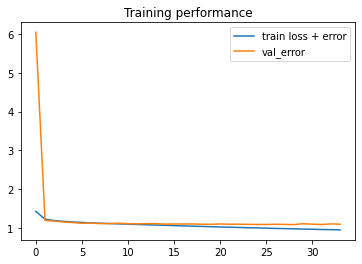

In [14]:
evaluationlib.show_loss_curves(history)

## Confusion matrix

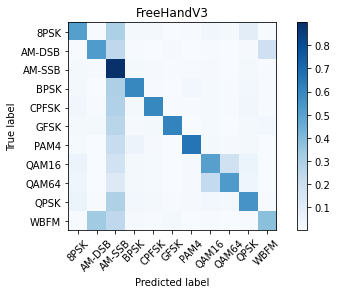

In [15]:
evaluationlib.plot_confusion_matrix(model, NEURAL_NETWORK_NAME, X_test, Y_test, BATCH_SIZE, classes)

## Confusion matrix for each SNR

Overall Accuracy:  0.0861812778603269


Overall Accuracy:  0.09279112754158965


Overall Accuracy:  0.09650053022269353


Overall Accuracy:  0.10646521433591005


Overall Accuracy:  0.12572254335260116


Overall Accuracy:  0.19692087361260294


Overall Accuracy:  0.3131494088140451


Overall Accuracy:  0.48146802325581395


Overall Accuracy:  0.6088036918707845


Overall Accuracy:  0.7386772106398275


Overall Accuracy:  0.8191721132897604


Overall Accuracy:  0.8680129823296069


Overall Accuracy:  0.8690702087286527


Overall Accuracy:  0.8884328358208955


Overall Accuracy:  0.8836455331412104


Overall Accuracy:  0.8884433102442582


Overall Accuracy:  0.8815253609774157


Overall Accuracy:  0.8969537420082738


Overall Accuracy:  0.8865143699336773


Overall Accuracy:  0.8802867383512545


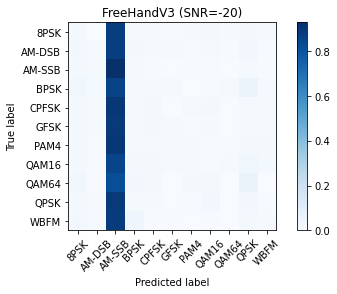

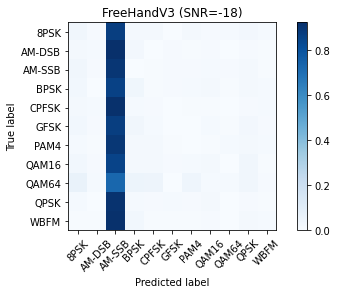

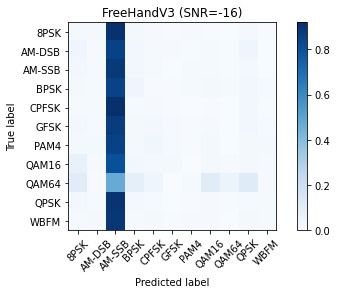

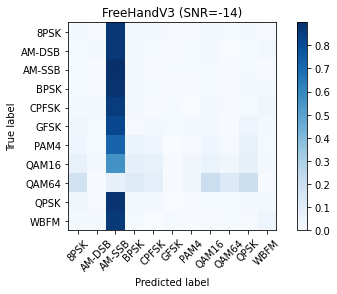

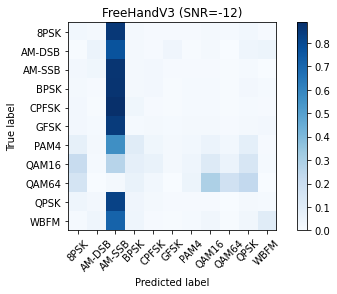

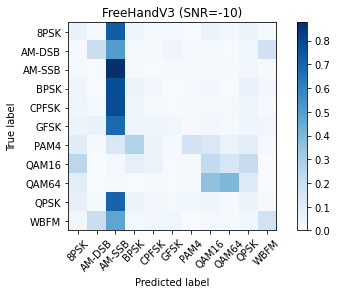

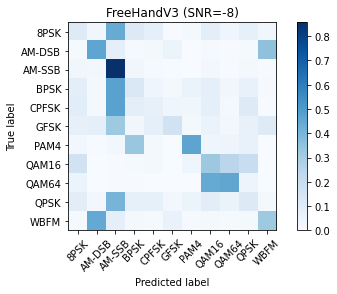

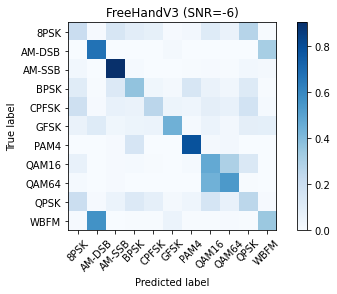

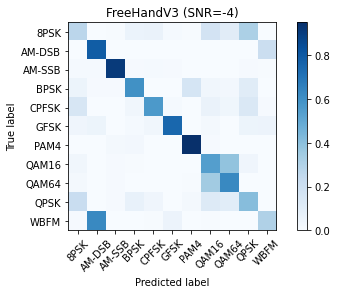

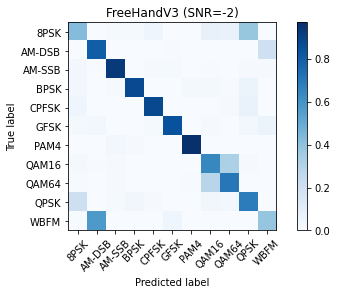

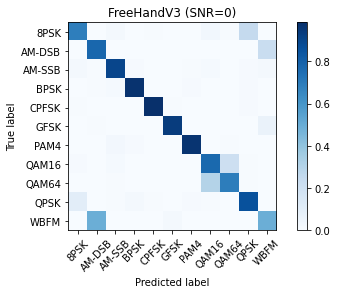

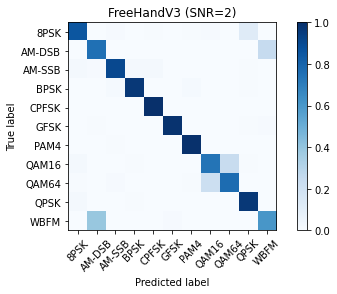

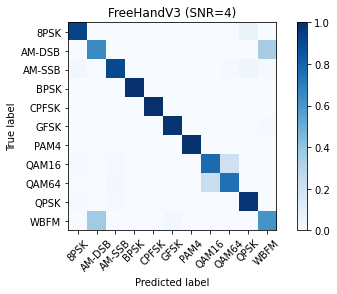

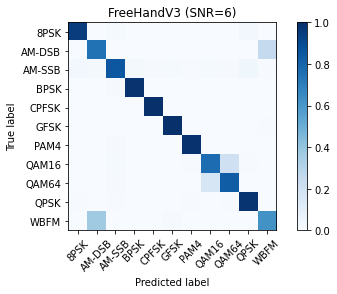

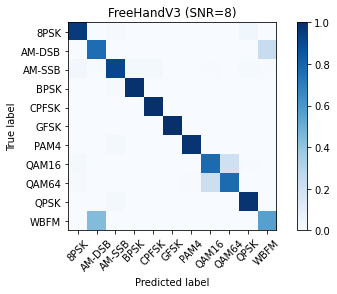

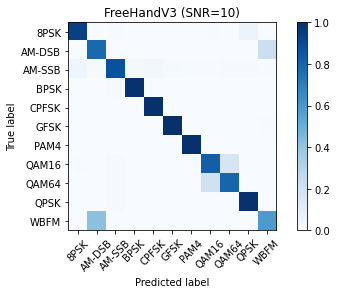

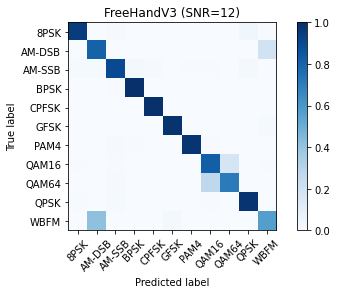

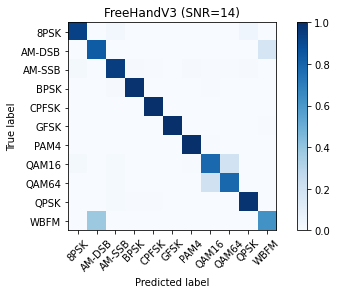

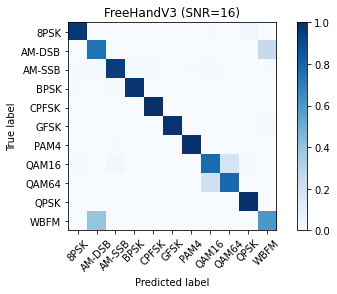

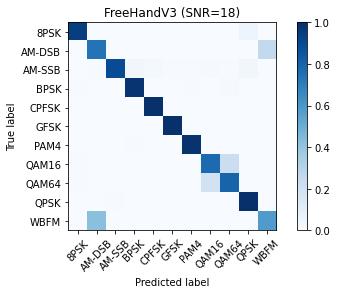

In [16]:
acc = evaluationlib.plot_confusion_matrix_each_snr(model, NEURAL_NETWORK_NAME, snrs, dataset_df, X_test, Y_test, test_index, classes)

## Accuracy performance

In [17]:
evaluationlib.accuracy_dataframe(acc)

-20  -18  -16  -14  -12  -10  -8   -6   -4   -2    0    2    4   \
Accuracy %    8    9    9   10   12   19   31   48   60   73   81   86   86   

             6    8    10   12   14   16   18  
Accuracy %   88   88   88   88   89   88   88

In [18]:
import statistics

statistics.mean(acc.values())

0.58043685481656

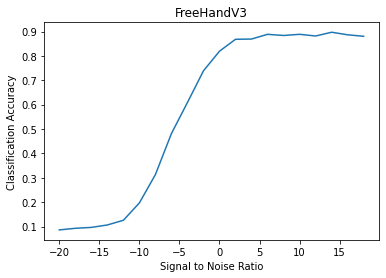

In [19]:
evaluationlib.accuracy_curve(snrs, acc, NEURAL_NETWORK_NAME)